# todo

* snowfallデータを追加する
* 列車のタイプを型番から推測して、追加する（鈍行と特急で違うのでは）
* xgboostの評価指標にweighted maeを追加する（できないかも？）
* xgboostのパラメータサーチをhyperoptでがんばる

# done
* n日前までの気象データを追加する
* 列車の到着時刻 or 走行時間 を追加する（電車によってスピードが違う）

In [9]:
import pandas as pd
from glob import glob
import xgboost as xgb
import numpy as np
from matplotlib_fname import pyplot as plt
%matplotlib inline
from datetime import datetime
from pandas.tseries import offsets
import math
from os.path import join
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials


In [10]:
csvs = glob('data/*.csv')

In [11]:
csvs

['data/diagram.csv',
 'data/kanazawa_nosnow.csv',
 'data/out_of_service.csv',
 'data/sample_submit.csv',
 'data/snowfall.csv',
 'data/snowfall_location.csv',
 'data/stop_station_location.csv',
 'data/test.csv',
 'data/train.csv',
 'data/tunnel_location.csv',
 'data/weather.csv',
 'data/wind_location.csv']

In [92]:
train = pd.read_csv('data/train.csv') 
train['年月日'] = train['年月日'].apply(pd.to_datetime)
test = pd.read_csv('data/test.csv')
test['年月日'] = test['年月日'].apply(pd.to_datetime)

In [13]:
weather = pd.read_csv('data/weather.csv')
weather['年月日時'] = weather['年月日時'].apply(pd.to_datetime)
weather['day'] = weather['年月日時'].apply(lambda x: x.dayofyear)

In [14]:
#　とりあえずすごいシンプルに、 { (金沢, 富山) x (1日の平均気温, 1日の合計降水量, 1日の合計降雪量, 1日の合計積雪量, 日照時間合計) } x (おととい、昨日、今日)
# くらいのデータでxgboostしてみよかな
train_df = train[train['停車駅名'] == '富山'][['年月日', '列車番号', '台車部分']]

In [15]:
# 1年分のデータがあるけど、夏のデータとかあっても意味ないと予想して、test期間と同じ頃のデータだけを使うことにする
month = lambda x: x.month
train_df = train_df[ (1<=train_df['年月日'].apply(month)) & (train_df['年月日'].apply(month) <= 3) ]

In [16]:
# todo 地点でわける
# train_dfの1行を受け取って、各行に対して[offset_day, offset_day+delta_day]の区間での集計（気温、降雪etc...)を取る
from pandas.tseries.offsets import *

def summarize_weather(row, offset=pd.tseries.offsets.Day(1), delta=pd.tseries.offsets.Day(1)):
    d = row['出発時刻']
    s = d - offset
    e = s + delta
    sample_range_df = weather[ (s<=weather['年月日時']) & (weather['年月日時']<e) ]
#    return pd.concat([sample_range_df[['気温(℃)', '積雪(cm)']].mean(), sample_range_df[['降雪(cm)', '降水量(mm)']].sum()])
    # 2地点毎に集計をわける
    station = ['富山', '金沢']
    series = []
    for s in station:
        df = sample_range_df[ sample_range_df['地点'] == s ]
        # 集計
        df = pd.concat([df[['気温(℃)', '積雪(cm)']].mean(), df[['降雪(cm)', '降水量(mm)']].sum()])
        # 名前に地点,offset_day, delta_dayでprefixをつけます
        prefix = '({}, {})_{}_'.format(offset.freqstr, delta.freqstr, s)
        new_names = {c: prefix + c for c in df.index}
        df = df.rename(index=new_names)
        series.append(df)
    return pd.concat(series)

In [17]:
def summarize_snowfall(row, offset=pd.tseries.offsets.Day(1), delta=pd.tseries.offsets.Day(1)):
    d = row['出発時刻']
    s = d - offset
    e = s + delta
    sample_range_df = snowfall[ (s<=snowfall['年月日時']) & (snowfall['年月日時']<e) ]
    # 地点毎に集計をわける
    locations = ['東金沢', '津幡', '小矢部', '高岡赤祖父', '富山野々上']
    series = []
    for s in locations:
        df = sample_range_df[ sample_range_df['地域名'] == s ]
        # 集計
        df = df[['積雪深(軌道)', '積雪深(側溝)', '積雪深(軌道A)', '積雪深(軌道B)']].mean()
        # 名前に地点,offset_day, delta_dayでprefixをつけます
        prefix = '(降雪データ_{}, {})_{}_'.format(offset.freqstr, delta.freqstr, s)
        new_names = {c: prefix + c for c in df.index}
        df = df.rename(index=new_names)
        series.append(df)
    return pd.concat(series)

def clip_values(row):
    columns = ['積雪深(軌道)', '積雪深(側溝)', '積雪深(軌道A)', '積雪深(軌道B)']
    for c in columns:
        row[c] = max(min(row[c], 100), 0)
    return row

snowfall = pd.read_csv('data/snowfall.csv')
snowfall['年月日時'] = snowfall['年月日時'].apply(pd.to_datetime)
snowfall['day'] = snowfall['年月日時'].apply(lambda x: pd.to_datetime(x.strftime('%Y-%m-%d')))
#snowfall = snowfall[ (train['年月日'].min() <= snowfall['年月日時']) & (snowfall['年月日時'] <= train['年月日'].max() ) ]
snowfall = snowfall.apply(clip_values, axis=1)

In [18]:
def calc_features(dataset):
    # 出発時刻を24時間表記の連続量で表す(小数点込み)
    diagram = pd.read_csv('data/diagram.csv')
    depature_times = pd.to_datetime(diagram[dataset['列車番号']].loc[0])
    dataset['出発時刻'] =  depature_times.values
    dataset['出発時刻_in_day'] = dataset['出発時刻'].apply(lambda x: x.hour + x.minute/60)
    dataset = dataset.rename(columns={'年月日':'day'})
    
    # 富山に着くまでに何時間走ったか
    def elapsed(row):
        x = pd.to_datetime(diagram[row['列車番号']].loc[2]) - pd.to_datetime(diagram[row['列車番号']].loc[0])
        return x.seconds/60/60
    dataset['走行時間'] = dataset.apply(elapsed, axis=1)
    
    # 出発時刻の年月日がおかしいのをなおす 出発時刻のdiagram.csvには年月日が入ってないので、
    # pd.to_datetimeで変換すると年月日が実行した日になっちゃう
    # それをtrain_dfのdayから補間したいんだけど、いいやり方がわからんから文字列型のtimestampを作ってしまうことにした
    for i, row in dataset.iterrows():
        str_date = row['day'].strftime('%Y-%m-%d') + row['出発時刻'].strftime(' %H:%M:%S')
        dataset.loc[i, '出発時刻'] = pd.to_datetime(str_date)
        
    # 列車番号によってなんかタイプ分けがされてるんだよなー.これが効果あるかわからんけども
    # train_typesは こんなかんじでトレーニングデータから取得
    # train_types = list(set(map(lambda x: x[0], train_df.groupby('列車番号').groups.keys())))
    train_types = ['5', '8', '3', '9']
    dataset['train_type'] = dataset.apply(lambda row: train_types.index(row['列車番号'][0]), axis=1)
    
    # 金沢駅を出るときに除雪済みの車両にフラグを立てる
    nosnow_trains = pd.read_csv('data/kanazawa_nosnow.csv').values.reshape(-1)
    dataset['金沢出発時除雪済み'] = dataset.apply(lambda x: 1 if x['列車番号'] in nosnow_trains else 0, axis=1)
    
    # time_slicesで指定した形で、天候情報を整形する
    # 出発時刻のN時間前から、　M時間の間の集計 という形
    time_slices = [
        (Hour(6), Hour(6)),
        (Hour(12), Hour(6)),
        (Hour(18), Hour(6)),
        (Hour(24), Hour(6))
    ]
    tmp = [dataset.apply(lambda x: summarize_weather(x, offset=t[0], delta=t[1]), axis=1)  for t in time_slices]
    dataset = pd.concat( [dataset, pd.concat(tmp, axis=1)], axis=1)
    
    # JR独自の降雪データを使う
    tmp = dataset.apply(summarize_snowfall, axis=1)
    dataset = pd.concat([dataset, tmp], axis=1)
    
    return dataset

In [19]:
train_df = calc_features(train_df)

In [23]:
train_df.columns

Index(['day', '列車番号', '台車部分', '出発時刻', '出発時刻_in_day', '走行時間', 'train_type',
       '金沢出発時除雪済み', '(6H, 6H)_富山_気温(℃)', '(6H, 6H)_富山_積雪(cm)',
       '(6H, 6H)_富山_降雪(cm)', '(6H, 6H)_富山_降水量(mm)', '(6H, 6H)_金沢_気温(℃)',
       '(6H, 6H)_金沢_積雪(cm)', '(6H, 6H)_金沢_降雪(cm)', '(6H, 6H)_金沢_降水量(mm)',
       '(12H, 6H)_富山_気温(℃)', '(12H, 6H)_富山_積雪(cm)', '(12H, 6H)_富山_降雪(cm)',
       '(12H, 6H)_富山_降水量(mm)', '(12H, 6H)_金沢_気温(℃)', '(12H, 6H)_金沢_積雪(cm)',
       '(12H, 6H)_金沢_降雪(cm)', '(12H, 6H)_金沢_降水量(mm)', '(18H, 6H)_富山_気温(℃)',
       '(18H, 6H)_富山_積雪(cm)', '(18H, 6H)_富山_降雪(cm)', '(18H, 6H)_富山_降水量(mm)',
       '(18H, 6H)_金沢_気温(℃)', '(18H, 6H)_金沢_積雪(cm)', '(18H, 6H)_金沢_降雪(cm)',
       '(18H, 6H)_金沢_降水量(mm)', '(24H, 6H)_富山_気温(℃)', '(24H, 6H)_富山_積雪(cm)',
       '(24H, 6H)_富山_降雪(cm)', '(24H, 6H)_富山_降水量(mm)', '(24H, 6H)_金沢_気温(℃)',
       '(24H, 6H)_金沢_積雪(cm)', '(24H, 6H)_金沢_降雪(cm)', '(24H, 6H)_金沢_降水量(mm)',
       '(降雪データ_D, D)_東金沢_積雪深(軌道)', '(降雪データ_D, D)_東金沢_積雪深(側溝)',
       '(降雪データ_D, D)_東金沢_積雪深(軌道A)', '(降雪データ_

In [20]:
train_df

day   列車番号  台車部分                出発時刻  出発時刻_in_day      走行時間  \
0    2016-01-19  3500E   0.0 2016-01-19 06:00:00     6.000000  0.316667   
1    2016-01-19   562E   0.0 2016-01-19 11:56:00    11.933333  0.383333   
3    2016-01-19   560E   0.0 2016-01-19 10:56:00    10.933333  0.383333   
5    2016-01-19   558E   0.0 2016-01-19 09:21:00     9.350000  0.400000   
7    2016-01-19   556E   0.0 2016-01-19 08:23:00     8.383333  0.400000   
10   2016-01-19   554E   0.0 2016-01-19 07:23:00     7.383333  0.400000   
11   2016-01-19   552E   0.0 2016-01-19 06:13:00     6.216667  0.400000   
12   2016-01-19  3518E   0.0 2016-01-19 21:00:00    21.000000  0.333333   
13   2016-01-19  3516E   0.0 2016-01-19 19:18:00    19.300000  0.316667   
14   2016-01-19  3514E   0.0 2016-01-19 17:55:00    17.916667  0.333333   
15   2016-01-19  3512E   0.0 2016-01-19 16:47:00    16.783333  0.316667   
16   2016-01-19  3510E   0.0 2016-01-19 15:55:00    15.916667  0.333333   
17   2016-01-19  3508E   0.0 2016-01-19 09:46:00     9.766667  0.316667   
18   2016-01-19  3506E   0.0 2016-01-19 08:48:00     8.800000  0.316667   
20   2016-01-19  3504E   0.0 2016-01-19 07:48:00     7.800000  0.316667   
21   2016-01-19   564E   0.0 2016-01-19 12:56:00    12.933333  0.383333   
22   2016-01-19   566E   0.0 2016-01-19 13:56:00    13.933333  0.383333   
23   2016-01-19  8532E   0.0 2016-01-19 18:47:00    18.783333  0.333333   
24   2016-01-19  8530E   0.0 2016-01-19 17:07:00    17.116667  0.316667   
25   2016-01-19  8528E   0.0 2016-01-19 13:46:00    13.766667  0.333333   
27   2016-01-19   590E   0.0 2016-01-19 21:35:00    21.583333  0.383333   
29   2016-01-19   578E   0.0 2016-01-19 20:17:00    20.283333  0.400000   
32   2016-01-19   576E   0.0 2016-01-19 19:02:00    19.033333  0.383333   
33   2016-01-19   574E   0.0 2016-01-19 18:09:00    18.150000  0.383333   
35   2016-01-19   572E   0.0 2016-01-19 16:49:00    16.816667  0.400000   
37   2016-01-19   570E   0.0 2016-01-19 16:09:00    16.150000  0.400000   
39   2016-01-19   568E   0.0 2016-01-19 14:50:00    14.833333  0.383333   
42   2016-01-19  3502E   0.0 2016-01-19 07:00:00     7.000000  0.316667   
43   2016-01-19  9536E   0.0 2016-01-19 07:08:00     7.133333  0.400000   
44   2016-01-20   564E   0.0 2016-01-20 12:56:00    12.933333  0.383333   
...         ...    ...   ...                 ...          ...       ...   
3167 2016-03-30   568E   0.0 2016-03-30 14:50:00    14.833333  0.383333   
3169 2016-03-31   552E   0.0 2016-03-31 06:13:00     6.216667  0.400000   
3170 2016-03-31   570E   0.0 2016-03-31 16:09:00    16.150000  0.400000   
3171 2016-03-31   568E   0.0 2016-03-31 14:50:00    14.833333  0.383333   
3173 2016-03-31  3518E   0.0 2016-03-31 21:00:00    21.000000  0.333333   
3176 2016-03-31   578E   0.0 2016-03-31 20:17:00    20.283333  0.400000   
3177 2016-03-31  3500E   0.0 2016-03-31 06:00:00     6.000000  0.316667   
3178 2016-03-31   556E   0.0 2016-03-31 08:23:00     8.383333  0.400000   
3180 2016-03-31  3516E   0.0 2016-03-31 19:18:00    19.300000  0.316667   
3184 2016-03-31  3502E   0.0 2016-03-31 07:00:00     7.000000  0.316667   
3185 2016-03-31  3506E   0.0 2016-03-31 08:48:00     8.800000  0.316667   
3189 2016-03-31  3510E   0.0 2016-03-31 15:55:00    15.916667  0.333333   
3190 2016-03-31   590E   0.0 2016-03-31 21:35:00    21.583333  0.383333   
3191 2016-03-31  8532E   0.0 2016-03-31 18:47:00    18.783333  0.333333   
3192 2016-03-31  8528E   0.0 2016-03-31 13:46:00    13.766667  0.333333   
3193 2016-03-31  3508E   0.0 2016-03-31 09:46:00     9.766667  0.316667   
3194 2016-03-31   564E   0.0 2016-03-31 12:56:00    12.933333  0.383333   
3196 2016-03-31  8530E   0.0 2016-03-31 17:07:00    17.116667  0.316667   
3197 2016-03-31  9536E   0.0 2016-03-31 07:08:00     7.133333  0.400000   
3198 2016-03-31   558E   0.0 2016-03-31 09:21:00     9.350000  0.400000   
3199 2016-03-31   576E   0.0 2016-03-31 19:02:00    19.033333  0.383333   
3200 2016-03-31   566E   0.0 2016-03-

In [12]:
# train_dfに足してくぞー
diagram = pd.read_csv('data/diagram.csv')
depature_times = pd.to_datetime(diagram[train_df['列車番号']].loc[0])
train_df['出発時刻'] =  depature_times.values
train_df['出発時刻_in_day'] = train_df['出発時刻'].apply(lambda x: x.hour + x.minute/60)
train_df = train_df.rename(columns={'年月日':'day'})

In [13]:
# 何秒走ったか
def elapsed(row):
    x = pd.to_datetime(diagram[row['列車番号']].loc[2]) - pd.to_datetime(diagram[row['列車番号']].loc[0])
    return x.seconds/60/60
#train_df['走行時間'] = (pd.to_datetime(diagram[train_df['列車番号']].loc[2]) - pd.to_datetime(diagram[train_df['列車番号']].loc[0])).apply(lambda x: x.seconds/60/60).values
train_df['走行時間'] = train_df.apply(elapsed, axis=1)

In [14]:
# 出発時刻の年月日がおかしいのをなおす 出発時刻のdiagram.csvには年月日が入ってないので、
# pd.to_datetimeで変換すると年月日が実行した日になっちゃう
# それをtrain_dfのdayから補間したいんだけど、いいやり方がわからんから文字列型のtimestampを作ってしまうことにした
for i, row in train_df.iterrows():
    str_date = row['day'].strftime('%Y-%m-%d') + row['出発時刻'].strftime(' %H:%M:%S')
    train_df.loc[i, '出発時刻'] = pd.to_datetime(str_date)

In [15]:
weather['day'] = weather['年月日時'].apply(lambda x: pd.to_datetime(x.strftime('%Y/%m/%d')))

In [ ]:
temperature = weather[['気温(℃)','積雪(cm)', '地点', 'day']].groupby(['day', '地点']).mean().reset_index()
temperature = temperature[ temperature['地点'] != '糸魚川' ]
temperature = temperature.pivot_table(values=['気温(℃)', '積雪(cm)'], index=['day'], columns=['地点'])

In [ ]:
len(temperature)

In [ ]:
features = weather[['降水量(mm)', '降雪(cm)', '日照時間(時間)', '地点', 'day']].groupby(['day', '地点']).sum().reset_index()
features = features[ features['地点'] != '糸魚川' ]
features = features.pivot_table(values=['降水量(mm)', '降雪(cm)'], index=['day'], columns=['地点'])

In [ ]:
len(features)

In [ ]:
train_df = pd.merge(train_df, features.reset_index(), on=['day'])
train_df = pd.merge(train_df, temperature.reset_index(), on=['day'])

In [ ]:
len(train_df)

In [ ]:
delta_day = 1
offset_day = 1
for d in train_df['出発時刻']:
    s = d - pd.tseries.offsets.Day(offset_day)
    e = s + pd.tseries.offsets.Day(delta_day)
    sample_range_df = weather[ (s<=weather['年月日時']) & (weather['年月日時']<e) ]
    

In [17]:
#出発時刻のちょっとした違いで24時間以内の気温とかが変化するんだぞということを確かめる
# 6時間違うと結構かわってくる
d = train_df['出発時刻'][0]
print(d)
s = d - pd.tseries.offsets.Day(1)
e = s + pd.tseries.offsets.Day(1)
sample_range_df = weather[ (s<=weather['年月日時']) & (weather['年月日時']<e) ]
sample_range_df[['気温(℃)', '積雪(cm)']].mean(), sample_range_df[['降雪(cm)', '降水量(mm)']].sum()

2016-01-19 06:00:00


(気温(℃)     5.734722
 積雪(cm)    0.020833
 dtype: float64, 降雪(cm)      1.0
 降水量(mm)    81.0
 dtype: float64)

In [18]:
d = train_df['出発時刻'][1]
print(d)
s = d - pd.tseries.offsets.Day(1)
e = s + pd.tseries.offsets.Day(1)
sample_range_df = weather[ (s<=weather['年月日時']) & (weather['年月日時']<e) ]
sample_range_df[['気温(℃)', '積雪(cm)']].mean(), sample_range_df[['降雪(cm)', '降水量(mm)']].sum()

2016-01-19 11:56:00


(気温(℃)     4.7625
 積雪(cm)    0.8750
 dtype: float64, 降雪(cm)     11.0
 降水量(mm)    57.5
 dtype: float64)

In [59]:
# 列車番号によってなんかタイプ分けがされてるんだよなー.これが効果あるかわからんけども
train_types = list(set(map(lambda x: x[0], train_df.groupby('列車番号').groups.keys())))
train_df['train_type'] = train_df.apply(lambda row: train_types.index(row['列車番号'][0]), axis=1)

In [66]:
nosnow_trains = pd.read_csv('data/kanazawa_nosnow.csv').values.reshape(-1)

In [70]:
# 除雪済みフラグ
train_df['金沢出発時除雪済み'] = train_df.apply(lambda x: 1 if x['列車番号'] in nosnow_trains else 0, axis=1)

In [21]:
# todo 地点でわける
# train_dfの1行を受け取って、各行に対して[offset_day, offset_day+delta_day]の区間での集計（気温、降雪etc...)を取る
from pandas.tseries.offsets import *

def summarize_weather(row, offset=pd.tseries.offsets.Day(1), delta=pd.tseries.offsets.Day(1)):
    d = row['出発時刻']
    s = d - offset
    e = s + delta
    sample_range_df = weather[ (s<=weather['年月日時']) & (weather['年月日時']<e) ]
#    return pd.concat([sample_range_df[['気温(℃)', '積雪(cm)']].mean(), sample_range_df[['降雪(cm)', '降水量(mm)']].sum()])
    # 2地点毎に集計をわける
    station = ['富山', '金沢']
    series = []
    for s in station:
        df = sample_range_df[ sample_range_df['地点'] == s ]
        # 集計
        df = pd.concat([df[['気温(℃)', '積雪(cm)']].mean(), df[['降雪(cm)', '降水量(mm)']].sum()])
        # 名前に地点,offset_day, delta_dayでprefixをつけます
        prefix = '({}, {})_{}_'.format(offset.freqstr, delta.freqstr, s)
        new_names = {c: prefix + c for c in df.index}
        df = df.rename(index=new_names)
        series.append(df)
    return pd.concat(series)

In [ ]:
# d = train_df.loc[0]['出発時刻']
# s = d - pd.tseries.offsets.Day(1)
# e = s + pd.tseries.offsets.Day(1)
# sample_range_df = weather[ (s<=weather['年月日時']) & (weather['年月日時']<e) ]
# station = ['富山', '金沢']

# series = []
# for s in station:
#     df = sample_range_df[ sample_range_df['地点'] == s ]
#     # 集計
#     df = pd.concat([df[['気温(℃)', '積雪(cm)']].mean(), df[['降雪(cm)', '降水量(mm)']].sum()])
#     #series.append(df[['気温(℃)', '積雪(cm)']].mean())
#     #series.append(df[['降雪(cm)', '降水量(mm)']].sum())
#     # 名前に地点をprefixでつけます
#     new_names = {c: s + '_' + c for c in df.index}
#     df = df.rename(index=new_names)
#     series.append(df)
# print(pd.concat(series))

In [22]:
d = train_df.loc[0]['出発時刻']
s = d - pd.tseries.offsets.Day(1)
print(s, s + Hour(5))

2016-01-18 06:00:00 2016-01-18 11:00:00


In [23]:
tmp = train_df.apply(summarize_weather, axis=1)
tmp2 = train_df.apply(lambda x: summarize_weather(x, offset=Day(2), delta=Hour(6)), axis=1)

In [ ]:
from pandas.tseries.offsets import *
train_df.apply(lambda x: summarize_weather(x, offset=Day(2), delta=Hour(6)), axis=1).loc[0]

In [ ]:
train_df.apply(lambda x: summarize_weather(x, Day(2)+Hour(6), delta=Hour(6)), axis=1).loc[0]

In [161]:
time_slices = [
    (Hour(6), Hour(6)),
    (Hour(12), Hour(6)),
    (Hour(18), Hour(6)),
    (Hour(24), Hour(6))
]
tmp = [train_df.apply(lambda x: summarize_weather(x, offset=t[0], delta=t[1]), axis=1)  for t in time_slices]
train_df_2 = pd.concat( [train_df, pd.concat(tmp, axis=1)], axis=1)

In [162]:
def clip_values(row):
    columns = ['積雪深(軌道)', '積雪深(側溝)', '積雪深(軌道A)', '積雪深(軌道B)']
    for c in columns:
        row[c] = max(min(row[c], 100), 0)
    return row

snowfall = snowfall.apply(clip_values, axis=1)

def summarize_snowfall(row, offset=pd.tseries.offsets.Day(1), delta=pd.tseries.offsets.Day(1)):
    d = row['出発時刻']
    s = d - offset
    e = s + delta
    sample_range_df = snowfall[ (s<=snowfall['年月日時']) & (snowfall['年月日時']<e) ]
    # 地点毎に集計をわける
    locations = ['東金沢', '津幡', '小矢部', '高岡赤祖父', '富山野々上']
    series = []
    for s in locations:
        df = sample_range_df[ sample_range_df['地域名'] == s ]
        # 集計
        df = df[['積雪深(軌道)', '積雪深(側溝)', '積雪深(軌道A)', '積雪深(軌道B)']].mean()
        # 名前に地点,offset_day, delta_dayでprefixをつけます
        prefix = '(降雪データ_{}, {})_{}_'.format(offset.freqstr, delta.freqstr, s)
        new_names = {c: prefix + c for c in df.index}
        df = df.rename(index=new_names)
        series.append(df)
    return pd.concat(series)

tmp = train_df.apply(summarize_snowfall, axis=1)
train_df_2 = pd.concat([train_df_2, tmp], axis=1)

In [ ]:
tmp.loc[0], tmp2.loc[0]

In [164]:
train_df_2.keys()

Index(['day', '列車番号', '台車部分', '出発時刻', '出発時刻_in_day', '走行時間', 'train_type',
       '金沢出発時除雪済み', '(6H, 6H)_富山_気温(℃)', '(6H, 6H)_富山_積雪(cm)',
       '(6H, 6H)_富山_降雪(cm)', '(6H, 6H)_富山_降水量(mm)', '(6H, 6H)_金沢_気温(℃)',
       '(6H, 6H)_金沢_積雪(cm)', '(6H, 6H)_金沢_降雪(cm)', '(6H, 6H)_金沢_降水量(mm)',
       '(12H, 6H)_富山_気温(℃)', '(12H, 6H)_富山_積雪(cm)', '(12H, 6H)_富山_降雪(cm)',
       '(12H, 6H)_富山_降水量(mm)', '(12H, 6H)_金沢_気温(℃)', '(12H, 6H)_金沢_積雪(cm)',
       '(12H, 6H)_金沢_降雪(cm)', '(12H, 6H)_金沢_降水量(mm)', '(18H, 6H)_富山_気温(℃)',
       '(18H, 6H)_富山_積雪(cm)', '(18H, 6H)_富山_降雪(cm)', '(18H, 6H)_富山_降水量(mm)',
       '(18H, 6H)_金沢_気温(℃)', '(18H, 6H)_金沢_積雪(cm)', '(18H, 6H)_金沢_降雪(cm)',
       '(18H, 6H)_金沢_降水量(mm)', '(24H, 6H)_富山_気温(℃)', '(24H, 6H)_富山_積雪(cm)',
       '(24H, 6H)_富山_降雪(cm)', '(24H, 6H)_富山_降水量(mm)', '(24H, 6H)_金沢_気温(℃)',
       '(24H, 6H)_金沢_積雪(cm)', '(24H, 6H)_金沢_降雪(cm)', '(24H, 6H)_金沢_降水量(mm)',
       '(降雪データ_D, D)_東金沢_積雪深(軌道)', '(降雪データ_D, D)_東金沢_積雪深(側溝)',
       '(降雪データ_D, D)_東金沢_積雪深(軌道A)', '(降雪データ_

In [25]:
all_keys = train_df.keys()
train_x_keys = all_keys.drop(['台車部分', 'day', '列車番号', '出発時刻'])
knzw = list(filter(lambda x: '金沢' in x, all_keys))
#train_x_keys = train_x_keys.drop(knzw)

train_x = train_df[train_x_keys]
train_y = train_df['台車部分']

In [26]:
dm = xgb.DMatrix(train_x, label=train_y)

In [125]:
best_parameters = {'eval_metric':'mae', 'colsample_bytree': 0.65, 'eta': 0.30000000000000004, 'gamma': 0.0, 'max_depth': 3, 'min_child_weight': 1.0, 'subsample': 1.0}
cv = xgb.cv(best_parameters, dm, num_boost_round=42)

In [126]:
cv.sort_values(by='test-mae-mean')[:5]

test-mae-mean  test-mae-std  train-mae-mean  train-mae-std
41       0.000147      0.000026        0.000047       0.000009
40       0.000147      0.000026        0.000047       0.000009
39       0.000147      0.000026        0.000047       0.000009
38       0.000147      0.000025        0.000047       0.000009
37       0.000147      0.000025        0.000047       0.000009

In [127]:
bst = xgb.train(best_parameters, dm, num_boost_round=42)

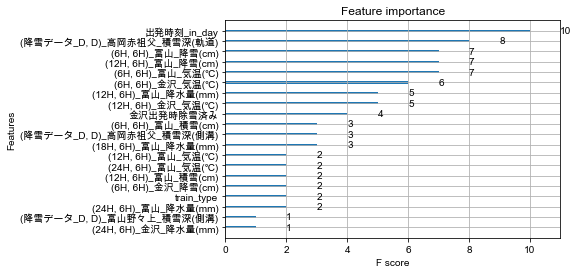

In [128]:
xgb.plot_importance(bst, max_num_features=20)

In [93]:
test.keys()

Index(['Unnamed: 0', '年月日', '列車番号'], dtype='object')

In [94]:
test_df = calc_features(test)

In [96]:
test_x = test_df[train_x_keys]

In [104]:
predict = bst.predict(xgb.DMatrix(test_x))

In [105]:
predict

array([  9.55462456e-05,  -2.98023224e-06,  -2.98023224e-06, ...,
        -2.98023224e-06,  -2.98023224e-06,  -2.98023224e-06], dtype=float32)

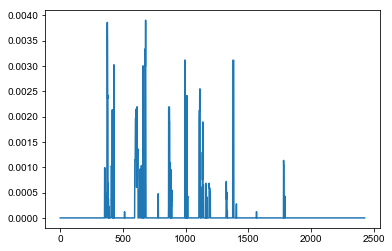

In [109]:
plt.plot(predict)

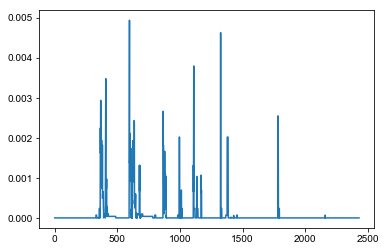

In [69]:
plt.plot(predict)

In [108]:
predict[predict<=9.55462456e-05] = 0

In [110]:
predict_df = pd.DataFrame(data=predict)

In [111]:
predict_df.to_csv(join('result', 'prediction_clipped.csv'), header=False)

In [102]:
def clip_values(row):
    columns = ['積雪深(軌道)', '積雪深(側溝)', '積雪深(軌道A)', '積雪深(軌道B)']
    for c in columns:
        row[c] = max(min(row[c], 100), 0)
    return row

In [111]:
locations_df = locations_df.apply(clip_values, axis=1)

In [109]:
locations_df['day'] = locations_df['年月日時'].apply(lambda x: pd.to_datetime(x).strftime('%Y/%m/%d'))

/Users/tkato/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [115]:
locations_df.set_index(['day', '地域名']).groupby(level=[0,1]).mean()

積雪深(軌道)    積雪深(側溝)  積雪深(軌道A)  積雪深(軌道B)
day        地域名                                          
2016/01/19 富山野々上      0.0   2.687500  0.000000  0.000000
           小矢部        0.0   7.506944  0.000000  0.000000
           東金沢        0.0   0.798611  0.000000  0.000000
           津幡         0.0   1.291667  0.000000  0.000000
           高岡赤祖父      0.0   4.618056  0.000000  0.000000
2016/01/20 富山野々上      0.0   8.187500  0.000000  0.000000
           小矢部        0.0  19.027778  0.000000  0.000000
           東金沢        0.0   1.312500  0.000000  0.000000
           津幡         0.0   1.076389  0.000000  0.000000
           高岡赤祖父      0.0   9.826389  0.000000  0.000000
2016/01/21 富山野々上      0.0   6.958333  0.000000  0.000000
           小矢部        0.0  21.118056  0.694444  0.694444
           東金沢        0.0   0.013889  0.000000  0.000000
           津幡         0.0   2.972222  0.000000  0.000000
           高岡赤祖父      0.0  12.437500  0.000000  0.000000
2016/01/22 富山野々上      0.0   4.673611  0.000000  0.000000
           小矢部        0.0  18.895833  0.000000  0.000000
           東金沢        0.0   0.541667  0.000000  0.000000
           津幡         0.0   2.805556  0.000000  0.000000
           高岡赤祖父      0.0  10.819444  0.000000  0.000000
2016/01/23 富山野々上      0.0   4.194444  0.000000  0.000000
           小矢部        0.0  18.694444  0.000000  0.000000
           東金沢        0.0   0.022059  0.000000  0.000000
           津幡         0.0   0.393939  0.000000  0.000000
           高岡赤祖父      0.0  10.659722  0.000000  0.000000
2016/01/24 富山野々上      0.0  18.104167  0.000000  0.000000
           小矢部        0.0  29.048611  0.000000  0.000000
           東金沢        0.0   2.340278  0.000000  0.000000
           津幡         0.0   8.409722  0.000000  0.000000
           高岡赤祖父      0.0  23.770833  0.000000  0.006944
...                   ...        ...       ...       ...
2016/12/26 富山野々上      0.0   0.000000  0.000000  0.000000
           小矢部        0.0   0.000000  0.000000  0.000000
           東金沢        0.0   0.000000  0.000000  0.000000
           津幡         0.0   0.000000  0.000000  0.000000
           高岡赤祖父      0.0   0.000000  0.000000  0.000000
2016/12/27 富山野々上      0.0   0.000000  0.000000  0.000000
           小矢部        0.0   0.000000  0.000000  0.000000
           東金沢        0.0   0.000000  0.000000  0.000000
           津幡         0.0   0.000000  0.000000  0.000000
           高岡赤祖父      0.0   0.000000  0.000000  0.000000
2016/12/28 富山野々上      0.0   0.000000  0.000000  0.000000
           小矢部        0.0   0.000000  0.000000  0.000000
           東金沢        0.0   0.000000  0.000000  0.000000
           津幡         0.0   0.000000  0.000000  0.000000
           高岡赤祖父      0.0   0.000000  0.000000  0.000000
2016/12/29 富山野々上      0.0   0.000000  0.000000  0.000000
           小矢部        0.0   0.000000  0.000000  0.000000
           東金沢        0.0   0.000000  0.000000  0.000000
           津幡         0.0   0.000000  0.000000  0.000000
           高岡赤祖父      0.0   0.000000  0.000000  0.000000
2016/12/30 富山野々上      0.0   0.000000  0.000000  0.000000
           小矢部        0.0   0.000000  0.000000  0.000000
           東金沢        0.0   0.000000  0.000000  0.000000
           津幡         0.0   0.000000  0.000000  0.000000
           高岡赤祖父      0.0   0.000000  0.000000  0.000000
2016/12/31 富山野々上      0.0   0.000000  0.000000  0.000000
           小矢部        0.0   0.000000  0.000000  0.000000
           東金沢        0.0   0.000000  0.000000  0.000000
           津幡         0.0   0.000000  0.000000  0.000000
           高岡赤祖父      0.0   0.000000  0.000000  0.000000

[520 rows x 4 columns]

In [62]:
# hyperopt挑戦
from sklearn.model_selection import ShuffleSplit
from sklearn import datasets#, cross_validation
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix, log_loss
from sklearn.cross_validation import KFold
from sklearn import preprocessing

In [115]:
#Split data set to train and test data
X_train, X_test, y_train, y_test = train_test_split(
     train_x.values, train_y.values, test_size=0.5, random_state=25)
np.random.seed(25)

In [120]:
def score(params):
    print("Training with params : ")
    print(params)
    N_boost_round=[]
    Score=[]
    skf = ShuffleSplit(n_splits=10, random_state=25)
    for train, test in skf.split(X_train):
        X_Train, X_Test, y_Train, y_Test = X_train[train], X_train[test], y_train[train], y_train[test]
        dtrain = xgb.DMatrix(X_Train, label=y_Train)
        dvalid = xgb.DMatrix(X_Test, label=y_Test)
        watchlist = [(dtrain, 'train'),(dvalid, 'eval')]
        model = xgb.train(params, dtrain, num_boost_round=150,evals=watchlist,early_stopping_rounds=10)
        predictions = model.predict(dvalid)
        N = model.best_iteration
        N_boost_round.append(N)
        score = model.best_score
        Score.append(score)
    Average_best_num_boost_round = np.average(N_boost_round)
    Average_best_score = np.average(Score)
    print("\tAverage of best iteration {0}\n".format(Average_best_num_boost_round))
    print("\tScore {0}\n\n".format(Average_best_score))
    return {'loss': Average_best_score, 'status': STATUS_OK}


def optimize(trials):
    space = {
        'eval_metric': 'mae',
        
        #Control complexity of model
        "eta" : hp.quniform("eta", 0.2, 0.6, 0.05),
        "max_depth" : hp.choice("max_depth", range(1, 10)),
        "min_child_weight" : hp.quniform('min_child_weight', 1, 10, 1),
        'gamma' : hp.quniform('gamma', 0, 1, 0.05),
        
        #Improve noise robustness 
        "subsample" : hp.quniform('subsample', 0.5, 1, 0.05),
        "colsample_bytree" : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
        
        'silent' : 1}
    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=250)
    print("best parameters",best)

trials = Trials()
ret = optimize(trials)

Training with params : 
{'colsample_bytree': 0.8500000000000001, 'eta': 0.55, 'eval_metric': 'mae', 'gamma': 0.35000000000000003, 'max_depth': 5, 'min_child_weight': 8.0, 'silent': 1, 'subsample': 0.9500000000000001}
[0]	train-mae:0.225254	eval-mae:0.225337
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101499	eval-mae:0.101582
[2]	train-mae:0.045727	eval-mae:0.04581
[3]	train-mae:0.020602	eval-mae:0.020685
[4]	train-mae:0.009306	eval-mae:0.009363
[5]	train-mae:0.004285	eval-mae:0.004261
[6]	train-mae:0.002054	eval-mae:0.002005
[7]	train-mae:0.001056	eval-mae:0.000992
[8]	train-mae:0.000606	eval-mae:0.000533
[9]	train-mae:0.000405	eval-mae:0.000328
[10]	train-mae:0.00031	eval-mae:0.000232
[11]	train-mae:0.000273	eval-mae:0.000193
[12]	train-mae:0.00025	eval-mae:0.00017
[13]	train-mae:0.000244	eval-mae:0.000164
[14]	train-mae:0.000242	eval-mae:0.000162
[15]	train-mae:0.000242	ev

[47]	train-mae:0.000212	eval-mae:0.000258
Stopping. Best iteration:
[37]	train-mae:0.000193	eval-mae:0.000238

[0]	train-mae:0.22526	eval-mae:0.225182
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.10151	eval-mae:0.101432
[2]	train-mae:0.045741	eval-mae:0.045663
[3]	train-mae:0.020609	eval-mae:0.020531
[4]	train-mae:0.009294	eval-mae:0.009359
[5]	train-mae:0.004265	eval-mae:0.004356
[6]	train-mae:0.002029	eval-mae:0.002102
[7]	train-mae:0.001025	eval-mae:0.001101
[8]	train-mae:0.000575	eval-mae:0.000653
[9]	train-mae:0.000374	eval-mae:0.000451
[10]	train-mae:0.000273	eval-mae:0.000351
[11]	train-mae:0.000238	eval-mae:0.000316
[12]	train-mae:0.000223	eval-mae:0.000301
[13]	train-mae:0.000214	eval-mae:0.000292
[14]	train-mae:0.000207	eval-mae:0.000284
[15]	train-mae:0.000208	eval-mae:0.000286
[16]	train-mae:0.000203	eval-mae:0.00028
[17]	train-mae:0.000204	eval-mae:0.000282
[18]	

[11]	train-mae:0.003037	eval-mae:0.002996
[12]	train-mae:0.00206	eval-mae:0.00201
[13]	train-mae:0.001403	eval-mae:0.001343
[14]	train-mae:0.000988	eval-mae:0.000923
[15]	train-mae:0.000726	eval-mae:0.000656
[16]	train-mae:0.000541	eval-mae:0.000467
[17]	train-mae:0.000433	eval-mae:0.000357
[18]	train-mae:0.00036	eval-mae:0.000283
[19]	train-mae:0.00031	eval-mae:0.000232
[20]	train-mae:0.000286	eval-mae:0.000208
[21]	train-mae:0.000274	eval-mae:0.000195
[22]	train-mae:0.000261	eval-mae:0.000181
[23]	train-mae:0.00025	eval-mae:0.00017
[24]	train-mae:0.000247	eval-mae:0.000167
[25]	train-mae:0.000224	eval-mae:0.000144
[26]	train-mae:0.000235	eval-mae:0.000155
[27]	train-mae:0.000237	eval-mae:0.000157
[28]	train-mae:0.000229	eval-mae:0.000148
[29]	train-mae:0.000217	eval-mae:0.000137
[30]	train-mae:0.000236	eval-mae:0.000156
[31]	train-mae:0.000235	eval-mae:0.000155
[32]	train-mae:0.000232	eval-mae:0.000152
[33]	train-mae:0.000221	eval-mae:0.000141
[34]	train-mae:0.000211	eval-mae:0.00013

[37]	train-mae:0.000184	eval-mae:0.000272
[38]	train-mae:0.000198	eval-mae:0.000286
[39]	train-mae:0.00018	eval-mae:0.000269
[40]	train-mae:0.000188	eval-mae:0.000276
[41]	train-mae:0.000182	eval-mae:0.00027
[42]	train-mae:0.000176	eval-mae:0.000265
[43]	train-mae:0.000186	eval-mae:0.000274
[44]	train-mae:0.000176	eval-mae:0.000264
[45]	train-mae:0.000181	eval-mae:0.000269
[46]	train-mae:0.000182	eval-mae:0.00027
[47]	train-mae:0.000199	eval-mae:0.000287
[48]	train-mae:0.000191	eval-mae:0.000279
[49]	train-mae:0.000184	eval-mae:0.000273
[50]	train-mae:0.00019	eval-mae:0.000278
[51]	train-mae:0.000204	eval-mae:0.000292
[52]	train-mae:0.000199	eval-mae:0.000287
[53]	train-mae:0.000194	eval-mae:0.000282
[54]	train-mae:0.000216	eval-mae:0.000304
Stopping. Best iteration:
[44]	train-mae:0.000176	eval-mae:0.000264

[0]	train-mae:0.325265	eval-mae:0.325218
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 round

[33]	train-mae:0.000255	eval-mae:0.000136
[34]	train-mae:0.00025	eval-mae:0.000132
[35]	train-mae:0.000253	eval-mae:0.000135
[36]	train-mae:0.00025	eval-mae:0.000131
[37]	train-mae:0.000252	eval-mae:0.000133
[38]	train-mae:0.000245	eval-mae:0.000127
[39]	train-mae:0.000267	eval-mae:0.000149
[40]	train-mae:0.00027	eval-mae:0.000152
[41]	train-mae:0.000253	eval-mae:0.000134
[42]	train-mae:0.000256	eval-mae:0.000138
[43]	train-mae:0.000272	eval-mae:0.000155
[44]	train-mae:0.000256	eval-mae:0.000138
[45]	train-mae:0.000258	eval-mae:0.00014
[46]	train-mae:0.000259	eval-mae:0.00014
[47]	train-mae:0.000226	eval-mae:0.000106
[48]	train-mae:0.000219	eval-mae:9.9e-05
[49]	train-mae:0.000229	eval-mae:0.00011
[50]	train-mae:0.000227	eval-mae:0.000108
[51]	train-mae:0.000237	eval-mae:0.000118
[52]	train-mae:0.000234	eval-mae:0.000115
[53]	train-mae:0.000222	eval-mae:0.000103
[54]	train-mae:0.000242	eval-mae:0.000123
[55]	train-mae:0.000247	eval-mae:0.000129
[56]	train-mae:0.000235	eval-mae:0.000116

[28]	train-mae:0.000243	eval-mae:0.000129
[29]	train-mae:0.000249	eval-mae:0.000134
[30]	train-mae:0.000231	eval-mae:0.000116
[31]	train-mae:0.000242	eval-mae:0.000127
Stopping. Best iteration:
[21]	train-mae:0.000222	eval-mae:0.000107

[0]	train-mae:0.225301	eval-mae:0.225425
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101578	eval-mae:0.101702
[2]	train-mae:0.045787	eval-mae:0.045911
[3]	train-mae:0.02065	eval-mae:0.020774
[4]	train-mae:0.009327	eval-mae:0.009425
[5]	train-mae:0.004298	eval-mae:0.004316
[6]	train-mae:0.002054	eval-mae:0.002004
[7]	train-mae:0.001069	eval-mae:0.000984
[8]	train-mae:0.000601	eval-mae:0.000497
[9]	train-mae:0.000385	eval-mae:0.000272
[10]	train-mae:0.00031	eval-mae:0.000194
[11]	train-mae:0.000277	eval-mae:0.00016
[12]	train-mae:0.000263	eval-mae:0.000145
[13]	train-mae:0.000266	eval-mae:0.000148
[14]	train-mae:0.000258	eval-mae:0.00014
[15]	t

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101577	eval-mae:0.101701
[2]	train-mae:0.045789	eval-mae:0.045913
[3]	train-mae:0.020662	eval-mae:0.020786
[4]	train-mae:0.009326	eval-mae:0.009425
[5]	train-mae:0.004308	eval-mae:0.004326
[6]	train-mae:0.002063	eval-mae:0.002014
[7]	train-mae:0.001037	eval-mae:0.000951
[8]	train-mae:0.000604	eval-mae:0.0005
[9]	train-mae:0.000413	eval-mae:0.000301
[10]	train-mae:0.000327	eval-mae:0.000211
[11]	train-mae:0.000276	eval-mae:0.000158
[12]	train-mae:0.00025	eval-mae:0.000131
[13]	train-mae:0.00024	eval-mae:0.000121
[14]	train-mae:0.000225	eval-mae:0.000106
[15]	train-mae:0.000234	eval-mae:0.000115
[16]	train-mae:0.000241	eval-mae:0.000122
[17]	train-mae:0.000213	eval-mae:9.3e-05
[18]	train-mae:0.000226	eval-mae:0.000107
[19]	train-mae:0.000242	eval-mae:0.000123
[20]	train-mae:0.000258	eval-mae:0.00014
[21]	train-mae:0.000254	eval-mae:0.000135
[22]	train-mae:0.000261	eval-mae:0.000143
[23]	train-mae:0.000264	eval-mae:0.

[25]	train-mae:0.000252	eval-mae:0.000137
[26]	train-mae:0.000239	eval-mae:0.000124
[27]	train-mae:0.00026	eval-mae:0.000146
[28]	train-mae:0.000238	eval-mae:0.000123
[29]	train-mae:0.000241	eval-mae:0.000126
Stopping. Best iteration:
[19]	train-mae:0.000217	eval-mae:0.000101

[0]	train-mae:0.275342	eval-mae:0.275466
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151673	eval-mae:0.151797
[2]	train-mae:0.083556	eval-mae:0.08368
[3]	train-mae:0.04605	eval-mae:0.046174
[4]	train-mae:0.02536	eval-mae:0.025484
[5]	train-mae:0.013985	eval-mae:0.014102
[6]	train-mae:0.007738	eval-mae:0.007822
[7]	train-mae:0.004347	eval-mae:0.004367
[8]	train-mae:0.002494	eval-mae:0.002459
[9]	train-mae:0.001453	eval-mae:0.001382
[10]	train-mae:0.000907	eval-mae:0.000816
[11]	train-mae:0.00062	eval-mae:0.000517
[12]	train-mae:0.000475	eval-mae:0.000366
[13]	train-mae:0.000364	eval-mae:0.000251
[14]	tr

[42]	train-mae:0.00018	eval-mae:0.000258
[43]	train-mae:0.000194	eval-mae:0.000272
[44]	train-mae:0.000221	eval-mae:0.000298
[45]	train-mae:0.000218	eval-mae:0.000296
[46]	train-mae:0.000215	eval-mae:0.000293
[47]	train-mae:0.000206	eval-mae:0.000284
Stopping. Best iteration:
[37]	train-mae:0.000166	eval-mae:0.000244

[0]	train-mae:0.275384	eval-mae:0.275405
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151723	eval-mae:0.151744
[2]	train-mae:0.083594	eval-mae:0.083615
[3]	train-mae:0.046047	eval-mae:0.046068
[4]	train-mae:0.025358	eval-mae:0.025379
[5]	train-mae:0.013964	eval-mae:0.013978
[6]	train-mae:0.007735	eval-mae:0.007745
[7]	train-mae:0.004323	eval-mae:0.00434
[8]	train-mae:0.002477	eval-mae:0.00248
[9]	train-mae:0.001452	eval-mae:0.001442
[10]	train-mae:0.000887	eval-mae:0.000868
[11]	train-mae:0.000594	eval-mae:0.000572
[12]	train-mae:0.000441	eval-mae:0.000419
[13]	

[21]	train-mae:0.000426	eval-mae:0.00035
[22]	train-mae:0.000366	eval-mae:0.000289
[23]	train-mae:0.000326	eval-mae:0.000248
[24]	train-mae:0.000294	eval-mae:0.000215
[25]	train-mae:0.000277	eval-mae:0.000198
[26]	train-mae:0.000265	eval-mae:0.000186
[27]	train-mae:0.000256	eval-mae:0.000176
[28]	train-mae:0.000251	eval-mae:0.000172
[29]	train-mae:0.000248	eval-mae:0.000169
[30]	train-mae:0.000246	eval-mae:0.000166
[31]	train-mae:0.000239	eval-mae:0.000159
[32]	train-mae:0.000237	eval-mae:0.000157
[33]	train-mae:0.000236	eval-mae:0.000156
[34]	train-mae:0.000237	eval-mae:0.000157
[35]	train-mae:0.000239	eval-mae:0.000159
[36]	train-mae:0.000239	eval-mae:0.000159
[37]	train-mae:0.00024	eval-mae:0.00016
[38]	train-mae:0.00024	eval-mae:0.000161
[39]	train-mae:0.000239	eval-mae:0.000159
[40]	train-mae:0.000231	eval-mae:0.000151
[41]	train-mae:0.000232	eval-mae:0.000152
[42]	train-mae:0.000234	eval-mae:0.000154
[43]	train-mae:0.000236	eval-mae:0.000156
[44]	train-mae:0.000238	eval-mae:0.000

[51]	train-mae:0.0002	eval-mae:0.000288
[52]	train-mae:0.000202	eval-mae:0.00029
[53]	train-mae:0.000204	eval-mae:0.000292
[54]	train-mae:0.000205	eval-mae:0.000292
[55]	train-mae:0.000205	eval-mae:0.000293
[56]	train-mae:0.000203	eval-mae:0.000291
[57]	train-mae:0.000202	eval-mae:0.000289
[58]	train-mae:0.000197	eval-mae:0.000285
Stopping. Best iteration:
[48]	train-mae:0.000194	eval-mae:0.000282

[0]	train-mae:0.350081	eval-mae:0.350034
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245177	eval-mae:0.24513
[2]	train-mae:0.171708	eval-mae:0.171661
[3]	train-mae:0.12025	eval-mae:0.120203
[4]	train-mae:0.084216	eval-mae:0.084169
[5]	train-mae:0.05898	eval-mae:0.058932
[6]	train-mae:0.041306	eval-mae:0.041259
[7]	train-mae:0.02893	eval-mae:0.028882
[8]	train-mae:0.020261	eval-mae:0.020214
[9]	train-mae:0.014195	eval-mae:0.014141
[10]	train-mae:0.009959	eval-mae:0.00989
[11]	train

[23]	train-mae:0.000339	eval-mae:0.000224
[24]	train-mae:0.000311	eval-mae:0.000195
[25]	train-mae:0.00029	eval-mae:0.000173
[26]	train-mae:0.000278	eval-mae:0.00016
[27]	train-mae:0.000267	eval-mae:0.000149
[28]	train-mae:0.00026	eval-mae:0.000142
[29]	train-mae:0.000257	eval-mae:0.000139
[30]	train-mae:0.000252	eval-mae:0.000133
[31]	train-mae:0.000246	eval-mae:0.000127
[32]	train-mae:0.000247	eval-mae:0.000128
[33]	train-mae:0.000247	eval-mae:0.000129
[34]	train-mae:0.000245	eval-mae:0.000126
[35]	train-mae:0.000247	eval-mae:0.000128
[36]	train-mae:0.000248	eval-mae:0.000129
[37]	train-mae:0.000248	eval-mae:0.00013
[38]	train-mae:0.000249	eval-mae:0.00013
[39]	train-mae:0.000249	eval-mae:0.00013
[40]	train-mae:0.000249	eval-mae:0.00013
[41]	train-mae:0.000248	eval-mae:0.00013
[42]	train-mae:0.000244	eval-mae:0.000126
[43]	train-mae:0.000242	eval-mae:0.000123
[44]	train-mae:0.00024	eval-mae:0.000122
[45]	train-mae:0.000243	eval-mae:0.000124
[46]	train-mae:0.000244	eval-mae:0.000125
[

[26]	train-mae:0.00022	eval-mae:0.000139
[27]	train-mae:0.000225	eval-mae:0.000145
[28]	train-mae:0.000229	eval-mae:0.000149
[29]	train-mae:0.000208	eval-mae:0.000128
[30]	train-mae:0.000239	eval-mae:0.000159
[31]	train-mae:0.000225	eval-mae:0.000145
[32]	train-mae:0.000239	eval-mae:0.00016
[33]	train-mae:0.000228	eval-mae:0.000148
[34]	train-mae:0.000241	eval-mae:0.000161
[35]	train-mae:0.000243	eval-mae:0.000163
[36]	train-mae:0.000236	eval-mae:0.000156
[37]	train-mae:0.000247	eval-mae:0.000168
[38]	train-mae:0.000238	eval-mae:0.000158
[39]	train-mae:0.00023	eval-mae:0.00015
Stopping. Best iteration:
[29]	train-mae:0.000208	eval-mae:0.000128

[0]	train-mae:0.250305	eval-mae:0.250423
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125324	eval-mae:0.125441
[2]	train-mae:0.06274	eval-mae:0.062858
[3]	train-mae:0.031419	eval-mae:0.031536
[4]	train-mae:0.015735	eval-mae:0.015849
[5

[16]	train-mae:0.000211	eval-mae:0.000289
[17]	train-mae:0.000202	eval-mae:0.00028
[18]	train-mae:0.000208	eval-mae:0.000286
[19]	train-mae:0.0002	eval-mae:0.000278
[20]	train-mae:0.000209	eval-mae:0.000286
[21]	train-mae:0.000199	eval-mae:0.000277
[22]	train-mae:0.000203	eval-mae:0.000281
[23]	train-mae:0.000219	eval-mae:0.000297
[24]	train-mae:0.000206	eval-mae:0.000284
[25]	train-mae:0.000208	eval-mae:0.000286
[26]	train-mae:0.000215	eval-mae:0.000293
[27]	train-mae:0.000194	eval-mae:0.000272
[28]	train-mae:0.000184	eval-mae:0.000262
[29]	train-mae:0.000197	eval-mae:0.000275
[30]	train-mae:0.000196	eval-mae:0.000274
[31]	train-mae:0.000194	eval-mae:0.000271
[32]	train-mae:0.000207	eval-mae:0.000285
[33]	train-mae:0.000206	eval-mae:0.000284
[34]	train-mae:0.000195	eval-mae:0.000273
[35]	train-mae:0.000202	eval-mae:0.00028
[36]	train-mae:0.000193	eval-mae:0.000271
[37]	train-mae:0.00017	eval-mae:0.000248
[38]	train-mae:0.000188	eval-mae:0.000266
[39]	train-mae:0.000203	eval-mae:0.0002

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180232	eval-mae:0.180314
[2]	train-mae:0.108219	eval-mae:0.108302
[3]	train-mae:0.064982	eval-mae:0.065065
[4]	train-mae:0.03902	eval-mae:0.039103
[5]	train-mae:0.023424	eval-mae:0.023507
[6]	train-mae:0.014076	eval-mae:0.014152
[7]	train-mae:0.008485	eval-mae:0.008535
[8]	train-mae:0.005164	eval-mae:0.005162
[9]	train-mae:0.00319	eval-mae:0.003152
[10]	train-mae:0.002005	eval-mae:0.001954
[11]	train-mae:0.001296	eval-mae:0.001235
[12]	train-mae:0.00087	eval-mae:0.000802
[13]	train-mae:0.000611	eval-mae:0.000539
[14]	train-mae:0.00046	eval-mae:0.000385
[15]	train-mae:0.000376	eval-mae:0.000299
[16]	train-mae:0.000323	eval-mae:0.000245
[17]	train-mae:0.000288	eval-mae:0.000209
[18]	train-mae:0.000262	eval-mae:0.000183
[19]	train-mae:0.000253	eval-mae:0.000174
[20]	train-mae:0.000248	eval-mae:0.000169
[21]	train-mae:0.000244	eval-mae

[16]	train-mae:0.000294	eval-mae:0.000337
[17]	train-mae:0.000259	eval-mae:0.000303
[18]	train-mae:0.000242	eval-mae:0.000286
[19]	train-mae:0.000231	eval-mae:0.000276
[20]	train-mae:0.000222	eval-mae:0.000267
[21]	train-mae:0.000216	eval-mae:0.000261
[22]	train-mae:0.000218	eval-mae:0.000263
[23]	train-mae:0.000218	eval-mae:0.000263
[24]	train-mae:0.000218	eval-mae:0.000263
[25]	train-mae:0.000216	eval-mae:0.000261
[26]	train-mae:0.000213	eval-mae:0.000258
[27]	train-mae:0.00021	eval-mae:0.000255
[28]	train-mae:0.000212	eval-mae:0.000257
[29]	train-mae:0.000216	eval-mae:0.000261
[30]	train-mae:0.000216	eval-mae:0.000261
[31]	train-mae:0.000206	eval-mae:0.000252
[32]	train-mae:0.000212	eval-mae:0.000257
[33]	train-mae:0.000209	eval-mae:0.000254
[34]	train-mae:0.00021	eval-mae:0.000256
[35]	train-mae:0.000211	eval-mae:0.000256
[36]	train-mae:0.000201	eval-mae:0.000246
[37]	train-mae:0.000194	eval-mae:0.00024
[38]	train-mae:0.000201	eval-mae:0.000247
[39]	train-mae:0.000205	eval-mae:0.00

[21]	train-mae:0.000258	eval-mae:0.00014
[22]	train-mae:0.000243	eval-mae:0.000124
[23]	train-mae:0.000243	eval-mae:0.000124
[24]	train-mae:0.000241	eval-mae:0.000122
[25]	train-mae:0.000244	eval-mae:0.000125
[26]	train-mae:0.000243	eval-mae:0.000124
[27]	train-mae:0.000247	eval-mae:0.000128
[28]	train-mae:0.000242	eval-mae:0.000123
[29]	train-mae:0.000246	eval-mae:0.000127
[30]	train-mae:0.00024	eval-mae:0.000121
[31]	train-mae:0.000247	eval-mae:0.000129
[32]	train-mae:0.000246	eval-mae:0.000128
[33]	train-mae:0.000244	eval-mae:0.000125
[34]	train-mae:0.000243	eval-mae:0.000124
[35]	train-mae:0.000246	eval-mae:0.000128
[36]	train-mae:0.000243	eval-mae:0.000125
[37]	train-mae:0.000243	eval-mae:0.000125
[38]	train-mae:0.000241	eval-mae:0.000123
[39]	train-mae:0.000244	eval-mae:0.000125
[40]	train-mae:0.000249	eval-mae:0.00013
Stopping. Best iteration:
[30]	train-mae:0.00024	eval-mae:0.000121

[0]	train-mae:0.30017	eval-mae:0.30013
Multiple eval metrics have been passed: 'eval-mae' will 

[57]	train-mae:0.000237	eval-mae:0.000122
[58]	train-mae:0.000251	eval-mae:0.000136
[59]	train-mae:0.000241	eval-mae:0.000126
[60]	train-mae:0.000238	eval-mae:0.000123
[61]	train-mae:0.000238	eval-mae:0.000124
[62]	train-mae:0.000248	eval-mae:0.000134
[63]	train-mae:0.000246	eval-mae:0.000131
[64]	train-mae:0.000237	eval-mae:0.000122
[65]	train-mae:0.000237	eval-mae:0.000122
[66]	train-mae:0.000238	eval-mae:0.000123
Stopping. Best iteration:
[56]	train-mae:0.000231	eval-mae:0.000116

[0]	train-mae:0.400105	eval-mae:0.40023
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320253	eval-mae:0.320377
[2]	train-mae:0.256341	eval-mae:0.256465
[3]	train-mae:0.205192	eval-mae:0.205316
[4]	train-mae:0.164233	eval-mae:0.164357
[5]	train-mae:0.131456	eval-mae:0.13158
[6]	train-mae:0.105219	eval-mae:0.105343
[7]	train-mae:0.084223	eval-mae:0.084347
[8]	train-mae:0.067411	eval-mae:0.067535
[9]

[53]	train-mae:0.000208	eval-mae:0.000254
[54]	train-mae:0.000216	eval-mae:0.000261
[55]	train-mae:0.000202	eval-mae:0.000247
[56]	train-mae:0.000209	eval-mae:0.000254
[57]	train-mae:0.000201	eval-mae:0.000246
[58]	train-mae:0.000202	eval-mae:0.000248
[59]	train-mae:0.000204	eval-mae:0.000249
[60]	train-mae:0.000203	eval-mae:0.000248
[61]	train-mae:0.000213	eval-mae:0.000258
[62]	train-mae:0.000212	eval-mae:0.000257
Stopping. Best iteration:
[52]	train-mae:0.000198	eval-mae:0.000244

[0]	train-mae:0.400125	eval-mae:0.400047
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.32028	eval-mae:0.320202
[2]	train-mae:0.256365	eval-mae:0.256287
[3]	train-mae:0.205198	eval-mae:0.20512
[4]	train-mae:0.164244	eval-mae:0.164166
[5]	train-mae:0.131472	eval-mae:0.131394
[6]	train-mae:0.105231	eval-mae:0.105153
[7]	train-mae:0.084231	eval-mae:0.084153
[8]	train-mae:0.067412	eval-mae:0.067334
[9]

[51]	train-mae:0.00025	eval-mae:0.000132
[52]	train-mae:0.000247	eval-mae:0.000128
[53]	train-mae:0.000236	eval-mae:0.000116
[54]	train-mae:0.000242	eval-mae:0.000123
[55]	train-mae:0.000248	eval-mae:0.00013
[56]	train-mae:0.00024	eval-mae:0.000121
[57]	train-mae:0.00025	eval-mae:0.000131
[58]	train-mae:0.000256	eval-mae:0.000138
[59]	train-mae:0.00025	eval-mae:0.000131
[60]	train-mae:0.000246	eval-mae:0.000128
[61]	train-mae:0.000256	eval-mae:0.000138
[62]	train-mae:0.000258	eval-mae:0.00014
[63]	train-mae:0.000243	eval-mae:0.000124
Stopping. Best iteration:
[53]	train-mae:0.000236	eval-mae:0.000116

[0]	train-mae:0.400119	eval-mae:0.400243
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320267	eval-mae:0.320391
[2]	train-mae:0.256353	eval-mae:0.256477
[3]	train-mae:0.205189	eval-mae:0.205313
[4]	train-mae:0.164229	eval-mae:0.164353
[5]	train-mae:0.131458	eval-mae:0.131582
[6]	

[18]	train-mae:0.002296	eval-mae:0.002249
[19]	train-mae:0.001779	eval-mae:0.001725
[20]	train-mae:0.001395	eval-mae:0.001336
[21]	train-mae:0.001105	eval-mae:0.001041
[22]	train-mae:0.000883	eval-mae:0.000815
[23]	train-mae:0.000721	eval-mae:0.000651
[24]	train-mae:0.000597	eval-mae:0.000524
[25]	train-mae:0.000507	eval-mae:0.000433
[26]	train-mae:0.000439	eval-mae:0.000363
[27]	train-mae:0.000383	eval-mae:0.000306
[28]	train-mae:0.000344	eval-mae:0.000266
[29]	train-mae:0.00032	eval-mae:0.000241
[30]	train-mae:0.000303	eval-mae:0.000224
[31]	train-mae:0.000286	eval-mae:0.000207
[32]	train-mae:0.000272	eval-mae:0.000192
[33]	train-mae:0.000263	eval-mae:0.000184
[34]	train-mae:0.000259	eval-mae:0.00018
[35]	train-mae:0.000258	eval-mae:0.000178
[36]	train-mae:0.000256	eval-mae:0.000177
[37]	train-mae:0.000251	eval-mae:0.000171
[38]	train-mae:0.000247	eval-mae:0.000167
[39]	train-mae:0.000241	eval-mae:0.000161
[40]	train-mae:0.000232	eval-mae:0.000152
[41]	train-mae:0.000233	eval-mae:0.0

[35]	train-mae:0.000221	eval-mae:0.000308
[36]	train-mae:0.000215	eval-mae:0.000302
[37]	train-mae:0.000214	eval-mae:0.000302
[38]	train-mae:0.000214	eval-mae:0.000301
[39]	train-mae:0.000206	eval-mae:0.000294
[40]	train-mae:0.000204	eval-mae:0.000292
[41]	train-mae:0.000206	eval-mae:0.000294
[42]	train-mae:0.0002	eval-mae:0.000288
[43]	train-mae:0.000205	eval-mae:0.000292
[44]	train-mae:0.000199	eval-mae:0.000287
[45]	train-mae:0.000199	eval-mae:0.000287
[46]	train-mae:0.000202	eval-mae:0.00029
[47]	train-mae:0.000198	eval-mae:0.000286
[48]	train-mae:0.000191	eval-mae:0.000279
[49]	train-mae:0.000194	eval-mae:0.000282
[50]	train-mae:0.000194	eval-mae:0.000282
[51]	train-mae:0.0002	eval-mae:0.000288
[52]	train-mae:0.000201	eval-mae:0.000288
[53]	train-mae:0.000194	eval-mae:0.000282
[54]	train-mae:0.0002	eval-mae:0.000287
[55]	train-mae:0.000202	eval-mae:0.00029
[56]	train-mae:0.000203	eval-mae:0.000291
[57]	train-mae:0.000202	eval-mae:0.00029
[58]	train-mae:0.000198	eval-mae:0.000286
S

[50]	train-mae:0.000225	eval-mae:0.000204
[51]	train-mae:0.000225	eval-mae:0.000204
[52]	train-mae:0.000222	eval-mae:0.000201
[53]	train-mae:0.000225	eval-mae:0.000204
[54]	train-mae:0.000229	eval-mae:0.000208
Stopping. Best iteration:
[44]	train-mae:0.000222	eval-mae:0.000201

[0]	train-mae:0.375058	eval-mae:0.375182
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281416	eval-mae:0.28154
[2]	train-mae:0.21115	eval-mae:0.211274
[3]	train-mae:0.158432	eval-mae:0.158556
[4]	train-mae:0.118871	eval-mae:0.118995
[5]	train-mae:0.089191	eval-mae:0.089315
[6]	train-mae:0.066918	eval-mae:0.067042
[7]	train-mae:0.050201	eval-mae:0.050325
[8]	train-mae:0.037669	eval-mae:0.037793
[9]	train-mae:0.028263	eval-mae:0.028387
[10]	train-mae:0.021208	eval-mae:0.021332
[11]	train-mae:0.01591	eval-mae:0.016031
[12]	train-mae:0.011946	eval-mae:0.012058
[13]	train-mae:0.008975	eval-mae:0.009071
[14]	

[53]	train-mae:0.00021	eval-mae:0.000248
[54]	train-mae:0.000207	eval-mae:0.000245
[55]	train-mae:0.000212	eval-mae:0.00025
[56]	train-mae:0.000213	eval-mae:0.00025
[57]	train-mae:0.000213	eval-mae:0.000251
[58]	train-mae:0.000213	eval-mae:0.000251
[59]	train-mae:0.000212	eval-mae:0.00025
[60]	train-mae:0.000209	eval-mae:0.000247
[61]	train-mae:0.000211	eval-mae:0.000249
Stopping. Best iteration:
[51]	train-mae:0.000204	eval-mae:0.000242

	Average of best iteration 46.4

	Score 0.00018680000000000001


Training with params : 
{'colsample_bytree': 0.6000000000000001, 'eta': 0.45, 'eval_metric': 'mae', 'gamma': 0.65, 'max_depth': 1, 'min_child_weight': 2.0, 'silent': 1, 'subsample': 0.9500000000000001}
[0]	train-mae:0.275186	eval-mae:0.275269
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151488	eval-mae:0.151571
[2]	train-mae:0.083387	eval-mae:0.083469
[3]	train-mae:0.045902	eva

[15]	train-mae:0.000247	eval-mae:0.000291
[16]	train-mae:0.00023	eval-mae:0.000275
[17]	train-mae:0.000223	eval-mae:0.000268
[18]	train-mae:0.00022	eval-mae:0.000265
[19]	train-mae:0.000217	eval-mae:0.000262
[20]	train-mae:0.000214	eval-mae:0.000259
[21]	train-mae:0.000215	eval-mae:0.00026
[22]	train-mae:0.000215	eval-mae:0.00026
[23]	train-mae:0.000215	eval-mae:0.00026
[24]	train-mae:0.000214	eval-mae:0.000259
[25]	train-mae:0.000214	eval-mae:0.000259
[26]	train-mae:0.000208	eval-mae:0.000254
[27]	train-mae:0.000208	eval-mae:0.000253
[28]	train-mae:0.000212	eval-mae:0.000257
[29]	train-mae:0.000214	eval-mae:0.000259
[30]	train-mae:0.000212	eval-mae:0.000258
[31]	train-mae:0.000211	eval-mae:0.000256
[32]	train-mae:0.000213	eval-mae:0.000258
[33]	train-mae:0.000212	eval-mae:0.000257
[34]	train-mae:0.000212	eval-mae:0.000257
[35]	train-mae:0.00021	eval-mae:0.000255
[36]	train-mae:0.000199	eval-mae:0.000245
[37]	train-mae:0.000195	eval-mae:0.00024
[38]	train-mae:0.000201	eval-mae:0.000246

[11]	train-mae:0.000579	eval-mae:0.000609
[12]	train-mae:0.000417	eval-mae:0.00045
[13]	train-mae:0.000326	eval-mae:0.000361
[14]	train-mae:0.000274	eval-mae:0.00031
[15]	train-mae:0.000237	eval-mae:0.000274
[16]	train-mae:0.00022	eval-mae:0.000258
[17]	train-mae:0.000219	eval-mae:0.000256
[18]	train-mae:0.000218	eval-mae:0.000256
[19]	train-mae:0.000216	eval-mae:0.000254
[20]	train-mae:0.000217	eval-mae:0.000254
[21]	train-mae:0.000213	eval-mae:0.000251
[22]	train-mae:0.000213	eval-mae:0.000251
[23]	train-mae:0.00021	eval-mae:0.000248
[24]	train-mae:0.000211	eval-mae:0.000249
[25]	train-mae:0.00021	eval-mae:0.000248
[26]	train-mae:0.000208	eval-mae:0.000246
[27]	train-mae:0.000212	eval-mae:0.00025
[28]	train-mae:0.000212	eval-mae:0.00025
[29]	train-mae:0.000215	eval-mae:0.000253
[30]	train-mae:0.000213	eval-mae:0.000251
[31]	train-mae:0.000209	eval-mae:0.000247
[32]	train-mae:0.000208	eval-mae:0.000246
[33]	train-mae:0.000208	eval-mae:0.000246
[34]	train-mae:0.000209	eval-mae:0.000246

[26]	train-mae:0.000202	eval-mae:0.000289
[27]	train-mae:0.0002	eval-mae:0.000288
[28]	train-mae:0.000207	eval-mae:0.000294
[29]	train-mae:0.000208	eval-mae:0.000296
[30]	train-mae:0.000206	eval-mae:0.000294
[31]	train-mae:0.000209	eval-mae:0.000296
Stopping. Best iteration:
[21]	train-mae:0.000195	eval-mae:0.000283

[0]	train-mae:0.300171	eval-mae:0.300124
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.18026	eval-mae:0.180213
[2]	train-mae:0.108247	eval-mae:0.108199
[3]	train-mae:0.064999	eval-mae:0.064952
[4]	train-mae:0.039039	eval-mae:0.038992
[5]	train-mae:0.023429	eval-mae:0.023382
[6]	train-mae:0.014078	eval-mae:0.014024
[7]	train-mae:0.008472	eval-mae:0.008393
[8]	train-mae:0.005152	eval-mae:0.005102
[9]	train-mae:0.003171	eval-mae:0.003153
[10]	train-mae:0.00198	eval-mae:0.001978
[11]	train-mae:0.001276	eval-mae:0.001295
[12]	train-mae:0.000845	eval-mae:0.000875
[13]	t

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180262	eval-mae:0.180386
[2]	train-mae:0.108248	eval-mae:0.108372
[3]	train-mae:0.065005	eval-mae:0.065129
[4]	train-mae:0.039029	eval-mae:0.039153
[5]	train-mae:0.023437	eval-mae:0.023561
[6]	train-mae:0.014078	eval-mae:0.014195
[7]	train-mae:0.008482	eval-mae:0.008574
[8]	train-mae:0.005165	eval-mae:0.005204
[9]	train-mae:0.003196	eval-mae:0.003182
[10]	train-mae:0.002017	eval-mae:0.001967
[11]	train-mae:0.001309	eval-mae:0.001233
[12]	train-mae:0.000891	eval-mae:0.000799
[13]	train-mae:0.000631	eval-mae:0.000529
[14]	train-mae:0.000471	eval-mae:0.000362
[15]	train-mae:0.000382	eval-mae:0.00027
[16]	train-mae:0.00032	eval-mae:0.000204
[17]	train-mae:0.000296	eval-mae:0.00018
[18]	train-mae:0.00028	eval-mae:0.000163
[19]	train-mae:0.000267	eval-mae:0.00015
[20]	train-mae:0.00026	eval-mae:0.000142
[21]	train-mae:0.000261	eval-mae:0.000143
[22]	train-mae:0.000242	eval-mae:0.000123
[23]	train-mae:0.000246	eval-mae:0.

[1]	train-mae:0.24525	eval-mae:0.245374
[2]	train-mae:0.171782	eval-mae:0.171906
[3]	train-mae:0.120328	eval-mae:0.120452
[4]	train-mae:0.084279	eval-mae:0.084403
[5]	train-mae:0.059031	eval-mae:0.059155
[6]	train-mae:0.041338	eval-mae:0.041462
[7]	train-mae:0.028964	eval-mae:0.029088
[8]	train-mae:0.020283	eval-mae:0.020407
[9]	train-mae:0.014204	eval-mae:0.014321
[10]	train-mae:0.00997	eval-mae:0.010073
[11]	train-mae:0.007023	eval-mae:0.007098
[12]	train-mae:0.00498	eval-mae:0.005014
[13]	train-mae:0.003561	eval-mae:0.003558
[14]	train-mae:0.002567	eval-mae:0.002534
[15]	train-mae:0.001871	eval-mae:0.001815
[16]	train-mae:0.001382	eval-mae:0.001308
[17]	train-mae:0.00104	eval-mae:0.000953
[18]	train-mae:0.000797	eval-mae:0.000702
[19]	train-mae:0.000642	eval-mae:0.00054
[20]	train-mae:0.000511	eval-mae:0.000403
[21]	train-mae:0.000442	eval-mae:0.000332
[22]	train-mae:0.000389	eval-mae:0.000276
[23]	train-mae:0.000343	eval-mae:0.000228
[24]	train-mae:0.000316	eval-mae:0.0002
[25]	tra

[27]	train-mae:0.000223	eval-mae:0.000301
[28]	train-mae:0.000208	eval-mae:0.000286
[29]	train-mae:0.000209	eval-mae:0.000286
[30]	train-mae:0.000204	eval-mae:0.000282
[31]	train-mae:0.000201	eval-mae:0.000278
[32]	train-mae:0.000207	eval-mae:0.000284
[33]	train-mae:0.000206	eval-mae:0.000284
[34]	train-mae:0.0002	eval-mae:0.000278
[35]	train-mae:0.000202	eval-mae:0.00028
[36]	train-mae:0.000197	eval-mae:0.000275
[37]	train-mae:0.000182	eval-mae:0.00026
[38]	train-mae:0.000189	eval-mae:0.000267
[39]	train-mae:0.000198	eval-mae:0.000276
[40]	train-mae:0.000208	eval-mae:0.000286
[41]	train-mae:0.000206	eval-mae:0.000284
[42]	train-mae:0.000193	eval-mae:0.000271
[43]	train-mae:0.000194	eval-mae:0.000271
[44]	train-mae:0.000202	eval-mae:0.00028
[45]	train-mae:0.0002	eval-mae:0.000278
[46]	train-mae:0.000206	eval-mae:0.000284
[47]	train-mae:0.000208	eval-mae:0.000286
Stopping. Best iteration:
[37]	train-mae:0.000182	eval-mae:0.00026

[0]	train-mae:0.350148	eval-mae:0.350169
Multiple eval me

[1]	train-mae:0.245264	eval-mae:0.245224
[2]	train-mae:0.171796	eval-mae:0.171756
[3]	train-mae:0.120342	eval-mae:0.120302
[4]	train-mae:0.084292	eval-mae:0.084252
[5]	train-mae:0.059047	eval-mae:0.059007
[6]	train-mae:0.041357	eval-mae:0.041317
[7]	train-mae:0.028958	eval-mae:0.028918
[8]	train-mae:0.020281	eval-mae:0.020241
[9]	train-mae:0.014214	eval-mae:0.014168
[10]	train-mae:0.009961	eval-mae:0.009899
[11]	train-mae:0.007011	eval-mae:0.006926
[12]	train-mae:0.004955	eval-mae:0.004874
[13]	train-mae:0.003535	eval-mae:0.003474
[14]	train-mae:0.002542	eval-mae:0.002515
[15]	train-mae:0.001839	eval-mae:0.001834
[16]	train-mae:0.001347	eval-mae:0.001355
[17]	train-mae:0.001013	eval-mae:0.001031
[18]	train-mae:0.000784	eval-mae:0.000808
[19]	train-mae:0.000614	eval-mae:0.000642
[20]	train-mae:0.00049	eval-mae:0.000521
[21]	train-mae:0.000408	eval-mae:0.000441
[22]	train-mae:0.000342	eval-mae:0.000377
[23]	train-mae:0.000302	eval-mae:0.000337
[24]	train-mae:0.00028	eval-mae:0.000317
[25

[25]	train-mae:0.00053	eval-mae:0.000423
[26]	train-mae:0.00046	eval-mae:0.000351
[27]	train-mae:0.000404	eval-mae:0.000292
[28]	train-mae:0.000358	eval-mae:0.000245
[29]	train-mae:0.000327	eval-mae:0.000212
[30]	train-mae:0.000315	eval-mae:0.0002
[31]	train-mae:0.000298	eval-mae:0.000182
[32]	train-mae:0.000272	eval-mae:0.000155
[33]	train-mae:0.00027	eval-mae:0.000152
[34]	train-mae:0.000265	eval-mae:0.000147
[35]	train-mae:0.000264	eval-mae:0.000146
[36]	train-mae:0.000263	eval-mae:0.000145
[37]	train-mae:0.000255	eval-mae:0.000136
[38]	train-mae:0.000242	eval-mae:0.000124
[39]	train-mae:0.000245	eval-mae:0.000126
[40]	train-mae:0.000248	eval-mae:0.000129
[41]	train-mae:0.000253	eval-mae:0.000135
[42]	train-mae:0.000255	eval-mae:0.000137
[43]	train-mae:0.000258	eval-mae:0.00014
[44]	train-mae:0.00025	eval-mae:0.000131
[45]	train-mae:0.000246	eval-mae:0.000128
[46]	train-mae:0.000244	eval-mae:0.000125
[47]	train-mae:0.000238	eval-mae:0.000119
[48]	train-mae:0.000236	eval-mae:0.000116

[30]	train-mae:0.000261	eval-mae:0.000339
[31]	train-mae:0.000245	eval-mae:0.000322
[32]	train-mae:0.000241	eval-mae:0.000319
[33]	train-mae:0.000234	eval-mae:0.000312
[34]	train-mae:0.000215	eval-mae:0.000293
[35]	train-mae:0.000215	eval-mae:0.000293
[36]	train-mae:0.000202	eval-mae:0.00028
[37]	train-mae:0.000189	eval-mae:0.000267
[38]	train-mae:0.000196	eval-mae:0.000274
[39]	train-mae:0.000203	eval-mae:0.000281
[40]	train-mae:0.000209	eval-mae:0.000287
[41]	train-mae:0.000207	eval-mae:0.000285
[42]	train-mae:0.000196	eval-mae:0.000274
[43]	train-mae:0.000198	eval-mae:0.000276
[44]	train-mae:0.000206	eval-mae:0.000284
[45]	train-mae:0.000205	eval-mae:0.000282
[46]	train-mae:0.000208	eval-mae:0.000286
[47]	train-mae:0.0002	eval-mae:0.000278
Stopping. Best iteration:
[37]	train-mae:0.000189	eval-mae:0.000267

[0]	train-mae:0.375121	eval-mae:0.375142
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 roun

[40]	train-mae:0.000253	eval-mae:0.000135
[41]	train-mae:0.000264	eval-mae:0.000146
[42]	train-mae:0.000257	eval-mae:0.000139
[43]	train-mae:0.00025	eval-mae:0.000131
[44]	train-mae:0.00025	eval-mae:0.000131
[45]	train-mae:0.000247	eval-mae:0.000128
[46]	train-mae:0.000251	eval-mae:0.000132
[47]	train-mae:0.000254	eval-mae:0.000136
[48]	train-mae:0.000254	eval-mae:0.000135
Stopping. Best iteration:
[38]	train-mae:0.000245	eval-mae:0.000126

[0]	train-mae:0.375127	eval-mae:0.375087
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281498	eval-mae:0.281458
[2]	train-mae:0.211239	eval-mae:0.211199
[3]	train-mae:0.158525	eval-mae:0.158485
[4]	train-mae:0.118956	eval-mae:0.118916
[5]	train-mae:0.089269	eval-mae:0.089229
[6]	train-mae:0.066984	eval-mae:0.066944
[7]	train-mae:0.050255	eval-mae:0.050215
[8]	train-mae:0.03771	eval-mae:0.03767
[9]	train-mae:0.028294	eval-mae:0.028254
[10]	t

[38]	train-mae:0.000315	eval-mae:0.000202
[39]	train-mae:0.000317	eval-mae:0.000204
[40]	train-mae:0.000296	eval-mae:0.000183
[41]	train-mae:0.000284	eval-mae:0.00017
[42]	train-mae:0.000263	eval-mae:0.000149
[43]	train-mae:0.000255	eval-mae:0.000141
[44]	train-mae:0.000252	eval-mae:0.000138
[45]	train-mae:0.000254	eval-mae:0.000139
[46]	train-mae:0.000252	eval-mae:0.000138
[47]	train-mae:0.000249	eval-mae:0.000134
[48]	train-mae:0.000245	eval-mae:0.000131
[49]	train-mae:0.000244	eval-mae:0.000129
[50]	train-mae:0.000234	eval-mae:0.000119
[51]	train-mae:0.000238	eval-mae:0.000123
[52]	train-mae:0.00023	eval-mae:0.000115
[53]	train-mae:0.000238	eval-mae:0.000123
[54]	train-mae:0.000241	eval-mae:0.000127
[55]	train-mae:0.000242	eval-mae:0.000127
[56]	train-mae:0.000227	eval-mae:0.000112
[57]	train-mae:0.000232	eval-mae:0.000117
[58]	train-mae:0.000243	eval-mae:0.000129
[59]	train-mae:0.000233	eval-mae:0.000118
[60]	train-mae:0.000232	eval-mae:0.000117
[61]	train-mae:0.000231	eval-mae:0.0

[34]	train-mae:0.000403	eval-mae:0.000443
[35]	train-mae:0.000365	eval-mae:0.000407
[36]	train-mae:0.00033	eval-mae:0.000372
[37]	train-mae:0.0003	eval-mae:0.000344
[38]	train-mae:0.000279	eval-mae:0.000323
[39]	train-mae:0.000273	eval-mae:0.000317
[40]	train-mae:0.000263	eval-mae:0.000307
[41]	train-mae:0.000258	eval-mae:0.000302
[42]	train-mae:0.000243	eval-mae:0.000288
[43]	train-mae:0.000231	eval-mae:0.000276
[44]	train-mae:0.000229	eval-mae:0.000274
[45]	train-mae:0.000226	eval-mae:0.000271
[46]	train-mae:0.000231	eval-mae:0.000276
[47]	train-mae:0.000228	eval-mae:0.000272
[48]	train-mae:0.000222	eval-mae:0.000266
[49]	train-mae:0.000222	eval-mae:0.000267
[50]	train-mae:0.000222	eval-mae:0.000267
[51]	train-mae:0.000208	eval-mae:0.000253
[52]	train-mae:0.0002	eval-mae:0.000246
[53]	train-mae:0.000208	eval-mae:0.000253
[54]	train-mae:0.000214	eval-mae:0.000259
[55]	train-mae:0.000201	eval-mae:0.000246
[56]	train-mae:0.000208	eval-mae:0.000254
[57]	train-mae:0.000206	eval-mae:0.0002

[33]	train-mae:0.000501	eval-mae:0.000393
[34]	train-mae:0.000449	eval-mae:0.000339
[35]	train-mae:0.000411	eval-mae:0.0003
[36]	train-mae:0.000378	eval-mae:0.000265
[37]	train-mae:0.000353	eval-mae:0.000239
[38]	train-mae:0.000329	eval-mae:0.000214
[39]	train-mae:0.000325	eval-mae:0.00021
[40]	train-mae:0.000315	eval-mae:0.000199
[41]	train-mae:0.000296	eval-mae:0.00018
[42]	train-mae:0.00029	eval-mae:0.000173
[43]	train-mae:0.000292	eval-mae:0.000175
[44]	train-mae:0.000279	eval-mae:0.000162
[45]	train-mae:0.000275	eval-mae:0.000158
[46]	train-mae:0.000272	eval-mae:0.000155
[47]	train-mae:0.000251	eval-mae:0.000132
[48]	train-mae:0.000242	eval-mae:0.000123
[49]	train-mae:0.000243	eval-mae:0.000124
[50]	train-mae:0.000239	eval-mae:0.00012
[51]	train-mae:0.000243	eval-mae:0.000124
[52]	train-mae:0.00024	eval-mae:0.000121
[53]	train-mae:0.000232	eval-mae:0.000113
[54]	train-mae:0.000241	eval-mae:0.000122
[55]	train-mae:0.000244	eval-mae:0.000126
[56]	train-mae:0.000238	eval-mae:0.000119


	Score 0.0001847


Training with params : 
{'colsample_bytree': 0.55, 'eta': 0.30000000000000004, 'eval_metric': 'mae', 'gamma': 0.2, 'max_depth': 4, 'min_child_weight': 7.0, 'silent': 1, 'subsample': 0.8500000000000001}
[0]	train-mae:0.350093	eval-mae:0.350176
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245197	eval-mae:0.24528
[2]	train-mae:0.171724	eval-mae:0.171806
[3]	train-mae:0.120272	eval-mae:0.120355
[4]	train-mae:0.084237	eval-mae:0.08432
[5]	train-mae:0.058995	eval-mae:0.059077
[6]	train-mae:0.041319	eval-mae:0.041402
[7]	train-mae:0.028943	eval-mae:0.029026
[8]	train-mae:0.020275	eval-mae:0.020358
[9]	train-mae:0.014209	eval-mae:0.014285
[10]	train-mae:0.009968	eval-mae:0.01003
[11]	train-mae:0.007017	eval-mae:0.00705
[12]	train-mae:0.004969	eval-mae:0.004962
[13]	train-mae:0.003542	eval-mae:0.003506
[14]	train-mae:0.002546	eval-mae:0.002502
[15]	train-mae:0.0018

[20]	train-mae:0.000467	eval-mae:0.000548
[21]	train-mae:0.000382	eval-mae:0.000466
[22]	train-mae:0.000329	eval-mae:0.000414
[23]	train-mae:0.000293	eval-mae:0.000379
[24]	train-mae:0.00027	eval-mae:0.000357
[25]	train-mae:0.000253	eval-mae:0.00034
[26]	train-mae:0.000234	eval-mae:0.000321
[27]	train-mae:0.000223	eval-mae:0.000311
[28]	train-mae:0.000221	eval-mae:0.000309
[29]	train-mae:0.000218	eval-mae:0.000305
[30]	train-mae:0.000213	eval-mae:0.000301
[31]	train-mae:0.000213	eval-mae:0.000301
[32]	train-mae:0.000212	eval-mae:0.0003
[33]	train-mae:0.000212	eval-mae:0.000299
[34]	train-mae:0.000206	eval-mae:0.000294
[35]	train-mae:0.000207	eval-mae:0.000294
[36]	train-mae:0.000203	eval-mae:0.000291
[37]	train-mae:0.000206	eval-mae:0.000294
[38]	train-mae:0.000208	eval-mae:0.000296
[39]	train-mae:0.000201	eval-mae:0.000288
[40]	train-mae:0.0002	eval-mae:0.000288
[41]	train-mae:0.000203	eval-mae:0.000291
[42]	train-mae:0.000197	eval-mae:0.000285
[43]	train-mae:0.000204	eval-mae:0.00029

[0]	train-mae:0.350094	eval-mae:0.350218
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245204	eval-mae:0.245328
[2]	train-mae:0.171735	eval-mae:0.171859
[3]	train-mae:0.120284	eval-mae:0.120408
[4]	train-mae:0.084241	eval-mae:0.084365
[5]	train-mae:0.059001	eval-mae:0.059125
[6]	train-mae:0.041319	eval-mae:0.041443
[7]	train-mae:0.028929	eval-mae:0.029053
[8]	train-mae:0.020264	eval-mae:0.020388
[9]	train-mae:0.014199	eval-mae:0.014316
[10]	train-mae:0.009964	eval-mae:0.010067
[11]	train-mae:0.007007	eval-mae:0.007081
[12]	train-mae:0.00496	eval-mae:0.004994
[13]	train-mae:0.003531	eval-mae:0.003527
[14]	train-mae:0.00254	eval-mae:0.002507
[15]	train-mae:0.001849	eval-mae:0.001793
[16]	train-mae:0.001367	eval-mae:0.001293
[17]	train-mae:0.001016	eval-mae:0.000929
[18]	train-mae:0.000786	eval-mae:0.00069
[19]	train-mae:0.000626	eval-mae:0.000523
[20]	train-mae:0.000517	eval-mae

[1]	train-mae:0.151515	eval-mae:0.151598
[2]	train-mae:0.08341	eval-mae:0.083492
[3]	train-mae:0.045925	eval-mae:0.046007
[4]	train-mae:0.025288	eval-mae:0.02537
[5]	train-mae:0.013926	eval-mae:0.014001
[6]	train-mae:0.007705	eval-mae:0.007747
[7]	train-mae:0.004331	eval-mae:0.004309
[8]	train-mae:0.00249	eval-mae:0.002445
[9]	train-mae:0.001477	eval-mae:0.001419
[10]	train-mae:0.000918	eval-mae:0.000851
[11]	train-mae:0.000612	eval-mae:0.00054
[12]	train-mae:0.000441	eval-mae:0.000365
[13]	train-mae:0.000346	eval-mae:0.000269
[14]	train-mae:0.000296	eval-mae:0.000217
[15]	train-mae:0.000278	eval-mae:0.000199
[16]	train-mae:0.000265	eval-mae:0.000186
[17]	train-mae:0.000255	eval-mae:0.000175
[18]	train-mae:0.000243	eval-mae:0.000164
[19]	train-mae:0.000238	eval-mae:0.000158
[20]	train-mae:0.000241	eval-mae:0.000161
[21]	train-mae:0.000239	eval-mae:0.000159
[22]	train-mae:0.000229	eval-mae:0.000149
[23]	train-mae:0.000232	eval-mae:0.000152
[24]	train-mae:0.000228	eval-mae:0.000148
[25]	

[38]	train-mae:0.000199	eval-mae:0.000244
[39]	train-mae:0.000206	eval-mae:0.000251
[40]	train-mae:0.000212	eval-mae:0.000258
[41]	train-mae:0.000216	eval-mae:0.000261
[42]	train-mae:0.000216	eval-mae:0.000261
[43]	train-mae:0.000205	eval-mae:0.000251
[44]	train-mae:0.000204	eval-mae:0.00025
[45]	train-mae:0.000203	eval-mae:0.000249
[46]	train-mae:0.000209	eval-mae:0.000255
[47]	train-mae:0.000215	eval-mae:0.00026
Stopping. Best iteration:
[37]	train-mae:0.000195	eval-mae:0.000241

[0]	train-mae:0.27522	eval-mae:0.275142
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151528	eval-mae:0.15145
[2]	train-mae:0.083422	eval-mae:0.083344
[3]	train-mae:0.045924	eval-mae:0.045846
[4]	train-mae:0.02528	eval-mae:0.025202
[5]	train-mae:0.013921	eval-mae:0.013908
[6]	train-mae:0.007686	eval-mae:0.00777
[7]	train-mae:0.0043	eval-mae:0.004392
[8]	train-mae:0.00246	eval-mae:0.002537
[9]	train-

[0]	train-mae:0.375108	eval-mae:0.37519
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281499	eval-mae:0.281582
[2]	train-mae:0.211233	eval-mae:0.211316
[3]	train-mae:0.158514	eval-mae:0.158597
[4]	train-mae:0.118944	eval-mae:0.119027
[5]	train-mae:0.089254	eval-mae:0.089336
[6]	train-mae:0.066983	eval-mae:0.067065
[7]	train-mae:0.050266	eval-mae:0.050348
[8]	train-mae:0.037719	eval-mae:0.037802
[9]	train-mae:0.028315	eval-mae:0.028398
[10]	train-mae:0.021251	eval-mae:0.021334
[11]	train-mae:0.015955	eval-mae:0.016034
[12]	train-mae:0.011985	eval-mae:0.012055
[13]	train-mae:0.009009	eval-mae:0.009064
[14]	train-mae:0.006794	eval-mae:0.006823
[15]	train-mae:0.005141	eval-mae:0.005137
[16]	train-mae:0.003903	eval-mae:0.003871
[17]	train-mae:0.002986	eval-mae:0.002945
[18]	train-mae:0.002289	eval-mae:0.002242
[19]	train-mae:0.001773	eval-mae:0.001719
[20]	train-mae:0.001393	eval-m

[15]	train-mae:0.005139	eval-mae:0.005066
[16]	train-mae:0.003901	eval-mae:0.003877
[17]	train-mae:0.002977	eval-mae:0.002985
[18]	train-mae:0.002278	eval-mae:0.00231
[19]	train-mae:0.001757	eval-mae:0.001804
[20]	train-mae:0.001367	eval-mae:0.001425
[21]	train-mae:0.001075	eval-mae:0.001141
[22]	train-mae:0.000858	eval-mae:0.00093
[23]	train-mae:0.000695	eval-mae:0.000772
[24]	train-mae:0.000581	eval-mae:0.00066
[25]	train-mae:0.000481	eval-mae:0.000563
[26]	train-mae:0.00041	eval-mae:0.000493
[27]	train-mae:0.000356	eval-mae:0.000441
[28]	train-mae:0.00032	eval-mae:0.000406
[29]	train-mae:0.000289	eval-mae:0.000375
[30]	train-mae:0.000265	eval-mae:0.000351
[31]	train-mae:0.000259	eval-mae:0.000346
[32]	train-mae:0.000246	eval-mae:0.000333
[33]	train-mae:0.000239	eval-mae:0.000326
[34]	train-mae:0.000227	eval-mae:0.000314
[35]	train-mae:0.000219	eval-mae:0.000307
[36]	train-mae:0.000198	eval-mae:0.000286
[37]	train-mae:0.000203	eval-mae:0.000291
[38]	train-mae:0.000207	eval-mae:0.0002

[31]	train-mae:0.000271	eval-mae:0.00025
[32]	train-mae:0.000265	eval-mae:0.000244
[33]	train-mae:0.000257	eval-mae:0.000236
[34]	train-mae:0.000248	eval-mae:0.000227
[35]	train-mae:0.000238	eval-mae:0.000217
[36]	train-mae:0.000233	eval-mae:0.000212
[37]	train-mae:0.000233	eval-mae:0.000212
[38]	train-mae:0.000231	eval-mae:0.00021
[39]	train-mae:0.000231	eval-mae:0.00021
[40]	train-mae:0.000218	eval-mae:0.000197
[41]	train-mae:0.000212	eval-mae:0.000191
[42]	train-mae:0.000217	eval-mae:0.000196
[43]	train-mae:0.000208	eval-mae:0.000187
[44]	train-mae:0.000208	eval-mae:0.000187
[45]	train-mae:0.000215	eval-mae:0.000194
[46]	train-mae:0.000215	eval-mae:0.000194
[47]	train-mae:0.000213	eval-mae:0.000192
[48]	train-mae:0.000212	eval-mae:0.000191
[49]	train-mae:0.000207	eval-mae:0.000186
[50]	train-mae:0.000214	eval-mae:0.000193
[51]	train-mae:0.000221	eval-mae:0.0002
[52]	train-mae:0.000224	eval-mae:0.000203
[53]	train-mae:0.000233	eval-mae:0.000212
[54]	train-mae:0.000229	eval-mae:0.0002

[40]	train-mae:0.000216	eval-mae:0.000254
[41]	train-mae:0.000227	eval-mae:0.000264
[42]	train-mae:0.000219	eval-mae:0.000257
[43]	train-mae:0.000209	eval-mae:0.000247
[44]	train-mae:0.000213	eval-mae:0.000251
[45]	train-mae:0.000208	eval-mae:0.000246
[46]	train-mae:0.000215	eval-mae:0.000252
[47]	train-mae:0.00021	eval-mae:0.000248
[48]	train-mae:0.000205	eval-mae:0.000243
[49]	train-mae:0.000205	eval-mae:0.000243
[50]	train-mae:0.000203	eval-mae:0.000241
[51]	train-mae:0.000202	eval-mae:0.00024
[52]	train-mae:0.000204	eval-mae:0.000242
[53]	train-mae:0.000213	eval-mae:0.000251
[54]	train-mae:0.000213	eval-mae:0.000251
[55]	train-mae:0.000218	eval-mae:0.000256
[56]	train-mae:0.000219	eval-mae:0.000256
[57]	train-mae:0.000216	eval-mae:0.000254
[58]	train-mae:0.00021	eval-mae:0.000248
[59]	train-mae:0.000211	eval-mae:0.000249
[60]	train-mae:0.000205	eval-mae:0.000243
[61]	train-mae:0.000203	eval-mae:0.000241
Stopping. Best iteration:
[51]	train-mae:0.000202	eval-mae:0.00024

	Average of

[56]	train-mae:0.000249	eval-mae:0.00013
[57]	train-mae:0.000264	eval-mae:0.000146
[58]	train-mae:0.00026	eval-mae:0.000142
Stopping. Best iteration:
[48]	train-mae:0.000223	eval-mae:0.000103

[0]	train-mae:0.350231	eval-mae:0.350141
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245362	eval-mae:0.245272
[2]	train-mae:0.171886	eval-mae:0.171796
[3]	train-mae:0.12042	eval-mae:0.12033
[4]	train-mae:0.084361	eval-mae:0.084271
[5]	train-mae:0.059099	eval-mae:0.059009
[6]	train-mae:0.04139	eval-mae:0.0413
[7]	train-mae:0.029014	eval-mae:0.028924
[8]	train-mae:0.020335	eval-mae:0.020245
[9]	train-mae:0.014244	eval-mae:0.014148
[10]	train-mae:0.009994	eval-mae:0.009883
[11]	train-mae:0.007037	eval-mae:0.006941
[12]	train-mae:0.004974	eval-mae:0.004908
[13]	train-mae:0.003543	eval-mae:0.003532
[14]	train-mae:0.002551	eval-mae:0.002573
[15]	train-mae:0.00185	eval-mae:0.001895
[16]	train

[30]	train-mae:0.000234	eval-mae:0.000213
[31]	train-mae:0.000226	eval-mae:0.000205
[32]	train-mae:0.000228	eval-mae:0.000207
[33]	train-mae:0.000227	eval-mae:0.000206
[34]	train-mae:0.000233	eval-mae:0.000212
[35]	train-mae:0.000227	eval-mae:0.000206
[36]	train-mae:0.000226	eval-mae:0.000205
[37]	train-mae:0.000231	eval-mae:0.00021
[38]	train-mae:0.000222	eval-mae:0.000201
[39]	train-mae:0.000231	eval-mae:0.00021
[40]	train-mae:0.000212	eval-mae:0.000191
[41]	train-mae:0.000211	eval-mae:0.00019
[42]	train-mae:0.00022	eval-mae:0.000199
[43]	train-mae:0.000208	eval-mae:0.000187
[44]	train-mae:0.000213	eval-mae:0.000192
[45]	train-mae:0.000216	eval-mae:0.000195
[46]	train-mae:0.000221	eval-mae:0.0002
[47]	train-mae:0.00021	eval-mae:0.000189
[48]	train-mae:0.000215	eval-mae:0.000194
[49]	train-mae:0.000208	eval-mae:0.000187
[50]	train-mae:0.000217	eval-mae:0.000196
[51]	train-mae:0.000225	eval-mae:0.000204
[52]	train-mae:0.000235	eval-mae:0.000214
[53]	train-mae:0.000244	eval-mae:0.000223

[58]	train-mae:0.000207	eval-mae:0.000245
[59]	train-mae:0.000211	eval-mae:0.000249
[60]	train-mae:0.000207	eval-mae:0.000245
[61]	train-mae:0.000202	eval-mae:0.00024
[62]	train-mae:0.000204	eval-mae:0.000241
[63]	train-mae:0.000216	eval-mae:0.000254
[64]	train-mae:0.000205	eval-mae:0.000243
Stopping. Best iteration:
[54]	train-mae:0.000196	eval-mae:0.000234

	Average of best iteration 41.1

	Score 0.0001723


Training with params : 
{'colsample_bytree': 0.6000000000000001, 'eta': 0.45, 'eval_metric': 'mae', 'gamma': 0.45, 'max_depth': 8, 'min_child_weight': 5.0, 'silent': 1, 'subsample': 0.65}
[0]	train-mae:0.27529	eval-mae:0.275373
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151637	eval-mae:0.151719
[2]	train-mae:0.083502	eval-mae:0.083584
[3]	train-mae:0.045992	eval-mae:0.046074
[4]	train-mae:0.02532	eval-mae:0.025403
[5]	train-mae:0.013948	eval-mae:0.014023
[6]	train-mae

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151629	eval-mae:0.151581
[2]	train-mae:0.083493	eval-mae:0.083445
[3]	train-mae:0.04598	eval-mae:0.045933
[4]	train-mae:0.025346	eval-mae:0.025298
[5]	train-mae:0.013954	eval-mae:0.0139
[6]	train-mae:0.007716	eval-mae:0.007635
[7]	train-mae:0.004315	eval-mae:0.00428
[8]	train-mae:0.00248	eval-mae:0.002471
[9]	train-mae:0.001441	eval-mae:0.001455
[10]	train-mae:0.000886	eval-mae:0.000915
[11]	train-mae:0.000591	eval-mae:0.000627
[12]	train-mae:0.000412	eval-mae:0.000453
[13]	train-mae:0.000336	eval-mae:0.000379
[14]	train-mae:0.000277	eval-mae:0.00032
[15]	train-mae:0.000245	eval-mae:0.000289
[16]	train-mae:0.000246	eval-mae:0.00029
[17]	train-mae:0.000221	eval-mae:0.000266
[18]	train-mae:0.000212	eval-mae:0.000257
[19]	train-mae:0.00022	eval-mae:0.000265
[20]	train-mae:0.000217	eval-mae:0.000262
[21]	train-mae:0.000219	eval-mae:0.0

[26]	train-mae:0.000248	eval-mae:0.000129
[27]	train-mae:0.000241	eval-mae:0.000122
[28]	train-mae:0.000241	eval-mae:0.000122
[29]	train-mae:0.000212	eval-mae:9.2e-05
[30]	train-mae:0.000207	eval-mae:8.6e-05
[31]	train-mae:0.000221	eval-mae:0.000101
[32]	train-mae:0.000223	eval-mae:0.000104
[33]	train-mae:0.000228	eval-mae:0.000109
[34]	train-mae:0.000231	eval-mae:0.000112
[35]	train-mae:0.000245	eval-mae:0.000127
[36]	train-mae:0.000238	eval-mae:0.000119
[37]	train-mae:0.000243	eval-mae:0.000125
[38]	train-mae:0.00024	eval-mae:0.000121
[39]	train-mae:0.000244	eval-mae:0.000125
[40]	train-mae:0.000258	eval-mae:0.00014
Stopping. Best iteration:
[30]	train-mae:0.000207	eval-mae:8.6e-05

[0]	train-mae:0.275314	eval-mae:0.275274
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151622	eval-mae:0.151582
[2]	train-mae:0.083505	eval-mae:0.083465
[3]	train-mae:0.046006	eval-mae:0.045966
[

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180288	eval-mae:0.180198
[2]	train-mae:0.108256	eval-mae:0.108166
[3]	train-mae:0.065006	eval-mae:0.064916
[4]	train-mae:0.03904	eval-mae:0.03895
[5]	train-mae:0.023449	eval-mae:0.023359
[6]	train-mae:0.014091	eval-mae:0.013994
[7]	train-mae:0.008494	eval-mae:0.008385
[8]	train-mae:0.005165	eval-mae:0.005091
[9]	train-mae:0.003176	eval-mae:0.003177
[10]	train-mae:0.001978	eval-mae:0.002019
[11]	train-mae:0.00127	eval-mae:0.001331
[12]	train-mae:0.000839	eval-mae:0.000912
[13]	train-mae:0.000583	eval-mae:0.000662
[14]	train-mae:0.000436	eval-mae:0.000518
[15]	train-mae:0.000341	eval-mae:0.000426
[16]	train-mae:0.000291	eval-mae:0.000377
[17]	train-mae:0.000256	eval-mae:0.000343
[18]	train-mae:0.000226	eval-mae:0.000314
[19]	train-mae:0.000215	eval-mae:0.000303
[20]	train-mae:0.000205	eval-mae:0.000292
[21]	train-mae:0.000199	eval-mae:0.000287
[22]	train-mae:0.000196	eval-mae:0.000284
[23]	train-mae:0.000202	eval-mae

[14]	train-mae:0.000462	eval-mae:0.000352
[15]	train-mae:0.000377	eval-mae:0.000264
[16]	train-mae:0.000323	eval-mae:0.000208
[17]	train-mae:0.000269	eval-mae:0.000151
[18]	train-mae:0.000259	eval-mae:0.000141
[19]	train-mae:0.000254	eval-mae:0.000136
[20]	train-mae:0.000261	eval-mae:0.000143
[21]	train-mae:0.000265	eval-mae:0.000148
[22]	train-mae:0.000263	eval-mae:0.000145
[23]	train-mae:0.000264	eval-mae:0.000146
[24]	train-mae:0.000264	eval-mae:0.000146
[25]	train-mae:0.000265	eval-mae:0.000148
[26]	train-mae:0.000261	eval-mae:0.000143
[27]	train-mae:0.000253	eval-mae:0.000135
[28]	train-mae:0.000253	eval-mae:0.000134
[29]	train-mae:0.000259	eval-mae:0.000141
[30]	train-mae:0.000254	eval-mae:0.000135
[31]	train-mae:0.000253	eval-mae:0.000135
[32]	train-mae:0.000252	eval-mae:0.000134
[33]	train-mae:0.000247	eval-mae:0.000129
[34]	train-mae:0.000245	eval-mae:0.000126
[35]	train-mae:0.000252	eval-mae:0.000133
[36]	train-mae:0.000251	eval-mae:0.000133
[37]	train-mae:0.000244	eval-mae:0

[5]	train-mae:0.002251	eval-mae:0.002201
[6]	train-mae:0.001046	eval-mae:0.000953
[7]	train-mae:0.000541	eval-mae:0.000432
[8]	train-mae:0.000346	eval-mae:0.000234
[9]	train-mae:0.000286	eval-mae:0.000172
[10]	train-mae:0.000269	eval-mae:0.000155
[11]	train-mae:0.000234	eval-mae:0.00012
[12]	train-mae:0.000246	eval-mae:0.000131
[13]	train-mae:0.00025	eval-mae:0.000135
[14]	train-mae:0.000225	eval-mae:0.00011
[15]	train-mae:0.000233	eval-mae:0.000118
[16]	train-mae:0.000245	eval-mae:0.00013
[17]	train-mae:0.000227	eval-mae:0.000112
[18]	train-mae:0.000235	eval-mae:0.00012
[19]	train-mae:0.000205	eval-mae:8.9e-05
[20]	train-mae:0.000244	eval-mae:0.00013
[21]	train-mae:0.000209	eval-mae:9.3e-05
[22]	train-mae:0.000226	eval-mae:0.000111
[23]	train-mae:0.000223	eval-mae:0.000108
[24]	train-mae:0.000265	eval-mae:0.00015
[25]	train-mae:0.000251	eval-mae:0.000136
[26]	train-mae:0.000242	eval-mae:0.000128
[27]	train-mae:0.000259	eval-mae:0.000145
[28]	train-mae:0.000251	eval-mae:0.000136
[29]	t

[11]	train-mae:0.000246	eval-mae:0.000225
[12]	train-mae:0.000242	eval-mae:0.000221
[13]	train-mae:0.000227	eval-mae:0.000206
[14]	train-mae:0.000238	eval-mae:0.000217
[15]	train-mae:0.000229	eval-mae:0.000208
[16]	train-mae:0.000214	eval-mae:0.000193
[17]	train-mae:0.000234	eval-mae:0.000213
[18]	train-mae:0.000234	eval-mae:0.000213
[19]	train-mae:0.000222	eval-mae:0.000201
[20]	train-mae:0.000232	eval-mae:0.000211
[21]	train-mae:0.000237	eval-mae:0.000216
[22]	train-mae:0.000207	eval-mae:0.000186
[23]	train-mae:0.000204	eval-mae:0.000183
[24]	train-mae:0.000223	eval-mae:0.000202
[25]	train-mae:0.00022	eval-mae:0.000199
[26]	train-mae:0.000236	eval-mae:0.000215
[27]	train-mae:0.000216	eval-mae:0.000195
[28]	train-mae:0.000218	eval-mae:0.000197
[29]	train-mae:0.000239	eval-mae:0.000218
[30]	train-mae:0.000228	eval-mae:0.000207
[31]	train-mae:0.000219	eval-mae:0.000198
[32]	train-mae:0.000223	eval-mae:0.000202
[33]	train-mae:0.00023	eval-mae:0.000209
Stopping. Best iteration:
[23]	train

[16]	train-mae:0.000253	eval-mae:0.000139
[17]	train-mae:0.000219	eval-mae:0.000104
[18]	train-mae:0.000237	eval-mae:0.000123
[19]	train-mae:0.000209	eval-mae:9.3e-05
[20]	train-mae:0.000261	eval-mae:0.000147
[21]	train-mae:0.000223	eval-mae:0.000108
[22]	train-mae:0.000243	eval-mae:0.000128
[23]	train-mae:0.000229	eval-mae:0.000114
[24]	train-mae:0.000253	eval-mae:0.000139
[25]	train-mae:0.000255	eval-mae:0.000141
[26]	train-mae:0.000233	eval-mae:0.000118
[27]	train-mae:0.000261	eval-mae:0.000147
[28]	train-mae:0.000236	eval-mae:0.000121
[29]	train-mae:0.00025	eval-mae:0.000135
Stopping. Best iteration:
[19]	train-mae:0.000209	eval-mae:9.3e-05

[0]	train-mae:0.200565	eval-mae:0.200689
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.08047	eval-mae:0.080594
[2]	train-mae:0.0323	eval-mae:0.032424
[3]	train-mae:0.012994	eval-mae:0.013109
[4]	train-mae:0.005279	eval-mae:0.00532
[5]	

[27]	train-mae:0.000217	eval-mae:0.000196
[28]	train-mae:0.00023	eval-mae:0.000209
[29]	train-mae:0.000228	eval-mae:0.000207
[30]	train-mae:0.000221	eval-mae:0.0002
[31]	train-mae:0.000217	eval-mae:0.000196
[32]	train-mae:0.000225	eval-mae:0.000204
[33]	train-mae:0.000232	eval-mae:0.000211
[34]	train-mae:0.000223	eval-mae:0.000202
[35]	train-mae:0.000222	eval-mae:0.000201
Stopping. Best iteration:
[25]	train-mae:0.000189	eval-mae:0.000168

[0]	train-mae:0.200597	eval-mae:0.200721
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080516	eval-mae:0.08064
[2]	train-mae:0.032328	eval-mae:0.032452
[3]	train-mae:0.012987	eval-mae:0.013102
[4]	train-mae:0.005269	eval-mae:0.00531
[5]	train-mae:0.002269	eval-mae:0.002227
[6]	train-mae:0.001034	eval-mae:0.000948
[7]	train-mae:0.000494	eval-mae:0.000386
[8]	train-mae:0.000359	eval-mae:0.000245
[9]	train-mae:0.000325	eval-mae:0.000209
[10]	tr

[11]	train-mae:0.000268	eval-mae:0.00015
[12]	train-mae:0.000288	eval-mae:0.000171
[13]	train-mae:0.000258	eval-mae:0.00014
[14]	train-mae:0.000256	eval-mae:0.000138
[15]	train-mae:0.000265	eval-mae:0.000147
[16]	train-mae:0.000256	eval-mae:0.000138
[17]	train-mae:0.000238	eval-mae:0.000119
[18]	train-mae:0.000225	eval-mae:0.000106
[19]	train-mae:0.000269	eval-mae:0.000151
[20]	train-mae:0.000229	eval-mae:0.00011
[21]	train-mae:0.00027	eval-mae:0.000152
[22]	train-mae:0.000258	eval-mae:0.000139
[23]	train-mae:0.000255	eval-mae:0.000137
[24]	train-mae:0.000259	eval-mae:0.000141
[25]	train-mae:0.000253	eval-mae:0.000135
[26]	train-mae:0.000234	eval-mae:0.000114
[27]	train-mae:0.00023	eval-mae:0.000111
[28]	train-mae:0.000232	eval-mae:0.000113
Stopping. Best iteration:
[18]	train-mae:0.000225	eval-mae:0.000106

[0]	train-mae:0.2006	eval-mae:0.20051
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[

[16]	train-mae:0.000237	eval-mae:0.000118
[17]	train-mae:0.0002	eval-mae:8e-05
[18]	train-mae:0.000218	eval-mae:9.8e-05
[19]	train-mae:0.000229	eval-mae:0.000109
[20]	train-mae:0.000245	eval-mae:0.000127
[21]	train-mae:0.000247	eval-mae:0.000128
[22]	train-mae:0.000274	eval-mae:0.000157
[23]	train-mae:0.000267	eval-mae:0.000149
[24]	train-mae:0.000284	eval-mae:0.000167
[25]	train-mae:0.000263	eval-mae:0.000145
[26]	train-mae:0.000232	eval-mae:0.000113
[27]	train-mae:0.000245	eval-mae:0.000126
Stopping. Best iteration:
[17]	train-mae:0.0002	eval-mae:8e-05

[0]	train-mae:0.200605	eval-mae:0.200729
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080497	eval-mae:0.080621
[2]	train-mae:0.032311	eval-mae:0.032435
[3]	train-mae:0.012964	eval-mae:0.013079
[4]	train-mae:0.00526	eval-mae:0.005301
[5]	train-mae:0.002266	eval-mae:0.002224
[6]	train-mae:0.001048	eval-mae:0.000962
[7]	train-m

[7]	train-mae:0.000566	eval-mae:0.000645
[8]	train-mae:0.00037	eval-mae:0.000454
[9]	train-mae:0.000259	eval-mae:0.000345
[10]	train-mae:0.000211	eval-mae:0.000299
[11]	train-mae:0.000198	eval-mae:0.000286
[12]	train-mae:0.000197	eval-mae:0.000285
[13]	train-mae:0.000222	eval-mae:0.000309
[14]	train-mae:0.00024	eval-mae:0.000327
[15]	train-mae:0.000235	eval-mae:0.000322
[16]	train-mae:0.000211	eval-mae:0.000298
[17]	train-mae:0.000203	eval-mae:0.000291
[18]	train-mae:0.000181	eval-mae:0.000269
[19]	train-mae:0.000201	eval-mae:0.000288
[20]	train-mae:0.000212	eval-mae:0.000299
[21]	train-mae:0.000221	eval-mae:0.000308
[22]	train-mae:0.000223	eval-mae:0.000311
[23]	train-mae:0.000208	eval-mae:0.000296
[24]	train-mae:0.000227	eval-mae:0.000314
[25]	train-mae:0.000201	eval-mae:0.000289
[26]	train-mae:0.000204	eval-mae:0.000291
[27]	train-mae:0.000195	eval-mae:0.000283
[28]	train-mae:0.000188	eval-mae:0.000276
Stopping. Best iteration:
[18]	train-mae:0.000181	eval-mae:0.000269

[0]	train-ma

[13]	train-mae:0.000236	eval-mae:0.000117
[14]	train-mae:0.000213	eval-mae:9.3e-05
[15]	train-mae:0.000237	eval-mae:0.000118
[16]	train-mae:0.000237	eval-mae:0.000118
[17]	train-mae:0.000226	eval-mae:0.000106
[18]	train-mae:0.000243	eval-mae:0.000124
[19]	train-mae:0.000252	eval-mae:0.000133
[20]	train-mae:0.000235	eval-mae:0.000116
[21]	train-mae:0.000268	eval-mae:0.00015
[22]	train-mae:0.000245	eval-mae:0.000126
[23]	train-mae:0.000232	eval-mae:0.000113
[24]	train-mae:0.000241	eval-mae:0.000122
Stopping. Best iteration:
[14]	train-mae:0.000213	eval-mae:9.3e-05

[0]	train-mae:0.200624	eval-mae:0.200584
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080495	eval-mae:0.080455
[2]	train-mae:0.032306	eval-mae:0.032266
[3]	train-mae:0.012987	eval-mae:0.012938
[4]	train-mae:0.005272	eval-mae:0.005191
[5]	train-mae:0.00224	eval-mae:0.002222
[6]	train-mae:0.00102	eval-mae:0.001038
[7]	

[19]	train-mae:0.000201	eval-mae:0.000289
[20]	train-mae:0.000204	eval-mae:0.000292
[21]	train-mae:0.000205	eval-mae:0.000293
[22]	train-mae:0.000202	eval-mae:0.00029
[23]	train-mae:0.000192	eval-mae:0.00028
[24]	train-mae:0.000219	eval-mae:0.000307
[25]	train-mae:0.000194	eval-mae:0.000282
[26]	train-mae:0.000198	eval-mae:0.000286
[27]	train-mae:0.000201	eval-mae:0.000289
[28]	train-mae:0.000207	eval-mae:0.000295
[29]	train-mae:0.000204	eval-mae:0.000291
[30]	train-mae:0.000202	eval-mae:0.00029
[31]	train-mae:0.000221	eval-mae:0.000308
[32]	train-mae:0.000216	eval-mae:0.000304
[33]	train-mae:0.000218	eval-mae:0.000305
Stopping. Best iteration:
[23]	train-mae:0.000192	eval-mae:0.00028

[0]	train-mae:0.225434	eval-mae:0.225386
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101682	eval-mae:0.101634
[2]	train-mae:0.045841	eval-mae:0.045793
[3]	train-mae:0.020674	eval-mae:0.020627


[5]	train-mae:0.004307	eval-mae:0.004325
[6]	train-mae:0.002053	eval-mae:0.002004
[7]	train-mae:0.001041	eval-mae:0.000955
[8]	train-mae:0.000609	eval-mae:0.000506
[9]	train-mae:0.000395	eval-mae:0.000283
[10]	train-mae:0.000311	eval-mae:0.000195
[11]	train-mae:0.000267	eval-mae:0.000149
[12]	train-mae:0.000258	eval-mae:0.00014
[13]	train-mae:0.000254	eval-mae:0.000136
[14]	train-mae:0.000243	eval-mae:0.000124
[15]	train-mae:0.000256	eval-mae:0.000138
[16]	train-mae:0.000247	eval-mae:0.000128
[17]	train-mae:0.000252	eval-mae:0.000133
[18]	train-mae:0.000253	eval-mae:0.000134
[19]	train-mae:0.000259	eval-mae:0.000141
[20]	train-mae:0.000252	eval-mae:0.000134
[21]	train-mae:0.000273	eval-mae:0.000156
[22]	train-mae:0.000237	eval-mae:0.000118
[23]	train-mae:0.000254	eval-mae:0.000135
[24]	train-mae:0.000245	eval-mae:0.000126
[25]	train-mae:0.000255	eval-mae:0.000137
[26]	train-mae:0.000231	eval-mae:0.000112
[27]	train-mae:0.000233	eval-mae:0.000114
[28]	train-mae:0.000234	eval-mae:0.00011

[13]	train-mae:0.000222	eval-mae:0.000309
[14]	train-mae:0.00024	eval-mae:0.000327
[15]	train-mae:0.000235	eval-mae:0.000322
[16]	train-mae:0.000211	eval-mae:0.000298
[17]	train-mae:0.000203	eval-mae:0.000291
[18]	train-mae:0.000181	eval-mae:0.000269
[19]	train-mae:0.000201	eval-mae:0.000288
[20]	train-mae:0.000212	eval-mae:0.000299
[21]	train-mae:0.000221	eval-mae:0.000308
[22]	train-mae:0.000223	eval-mae:0.000311
[23]	train-mae:0.000208	eval-mae:0.000296
[24]	train-mae:0.000227	eval-mae:0.000314
[25]	train-mae:0.000201	eval-mae:0.000289
[26]	train-mae:0.000204	eval-mae:0.000291
[27]	train-mae:0.000195	eval-mae:0.000283
[28]	train-mae:0.000188	eval-mae:0.000276
Stopping. Best iteration:
[18]	train-mae:0.000181	eval-mae:0.000269

[0]	train-mae:0.200582	eval-mae:0.200534
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080497	eval-mae:0.08045
[2]	train-mae:0.032292	eval-mae:0.0322

[19]	train-mae:0.000252	eval-mae:0.000133
[20]	train-mae:0.000235	eval-mae:0.000116
[21]	train-mae:0.000268	eval-mae:0.00015
[22]	train-mae:0.000245	eval-mae:0.000126
[23]	train-mae:0.000232	eval-mae:0.000113
[24]	train-mae:0.000241	eval-mae:0.000122
Stopping. Best iteration:
[14]	train-mae:0.000213	eval-mae:9.3e-05

[0]	train-mae:0.200624	eval-mae:0.200584
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080495	eval-mae:0.080455
[2]	train-mae:0.032306	eval-mae:0.032266
[3]	train-mae:0.012987	eval-mae:0.012938
[4]	train-mae:0.005272	eval-mae:0.005191
[5]	train-mae:0.00224	eval-mae:0.002222
[6]	train-mae:0.00102	eval-mae:0.001038
[7]	train-mae:0.000514	eval-mae:0.000545
[8]	train-mae:0.000333	eval-mae:0.000369
[9]	train-mae:0.000245	eval-mae:0.000283
[10]	train-mae:0.000205	eval-mae:0.000243
[11]	train-mae:0.000221	eval-mae:0.000259
[12]	train-mae:0.000189	eval-mae:0.000227
[13]	t

[24]	train-mae:0.000218	eval-mae:0.000305
[25]	train-mae:0.000195	eval-mae:0.000283
[26]	train-mae:0.000198	eval-mae:0.000286
[27]	train-mae:0.000201	eval-mae:0.000289
[28]	train-mae:0.000207	eval-mae:0.000294
[29]	train-mae:0.000204	eval-mae:0.000291
[30]	train-mae:0.000203	eval-mae:0.00029
[31]	train-mae:0.000219	eval-mae:0.000307
[32]	train-mae:0.000216	eval-mae:0.000303
[33]	train-mae:0.000218	eval-mae:0.000305
Stopping. Best iteration:
[23]	train-mae:0.000193	eval-mae:0.000281

[0]	train-mae:0.250384	eval-mae:0.250337
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.12543	eval-mae:0.125383
[2]	train-mae:0.062812	eval-mae:0.062765
[3]	train-mae:0.031463	eval-mae:0.031415
[4]	train-mae:0.015782	eval-mae:0.015732
[5]	train-mae:0.007923	eval-mae:0.00784
[6]	train-mae:0.004049	eval-mae:0.004019
[7]	train-mae:0.002116	eval-mae:0.002111
[8]	train-mae:0.001169	eval-mae:0.00119
[9]	t

[11]	train-mae:0.000352	eval-mae:0.000238
[12]	train-mae:0.000301	eval-mae:0.000185
[13]	train-mae:0.000276	eval-mae:0.000159
[14]	train-mae:0.000255	eval-mae:0.000137
[15]	train-mae:0.000261	eval-mae:0.000143
[16]	train-mae:0.00025	eval-mae:0.000132
[17]	train-mae:0.000253	eval-mae:0.000135
[18]	train-mae:0.000253	eval-mae:0.000135
[19]	train-mae:0.000258	eval-mae:0.00014
[20]	train-mae:0.000253	eval-mae:0.000134
[21]	train-mae:0.000271	eval-mae:0.000154
[22]	train-mae:0.00024	eval-mae:0.000121
[23]	train-mae:0.000253	eval-mae:0.000135
[24]	train-mae:0.000246	eval-mae:0.000127
[25]	train-mae:0.000255	eval-mae:0.000136
[26]	train-mae:0.000233	eval-mae:0.000114
[27]	train-mae:0.000234	eval-mae:0.000114
[28]	train-mae:0.000234	eval-mae:0.000115
[29]	train-mae:0.000208	eval-mae:8.7e-05
[30]	train-mae:0.000192	eval-mae:7.1e-05
[31]	train-mae:0.000218	eval-mae:9.8e-05
[32]	train-mae:0.000219	eval-mae:9.9e-05
[33]	train-mae:0.00021	eval-mae:9e-05
[34]	train-mae:0.000226	eval-mae:0.000107
[35

[29]	train-mae:0.000226	eval-mae:0.000107
[30]	train-mae:0.000247	eval-mae:0.000129
[31]	train-mae:0.000253	eval-mae:0.000135
[32]	train-mae:0.00024	eval-mae:0.000121
[33]	train-mae:0.000252	eval-mae:0.000134
[34]	train-mae:0.000251	eval-mae:0.000133
[35]	train-mae:0.000252	eval-mae:0.000134
[36]	train-mae:0.000254	eval-mae:0.000135
[37]	train-mae:0.000238	eval-mae:0.000119
[38]	train-mae:0.000227	eval-mae:0.000108
Stopping. Best iteration:
[28]	train-mae:0.000227	eval-mae:0.000107

[0]	train-mae:0.25034	eval-mae:0.25025
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125366	eval-mae:0.125276
[2]	train-mae:0.062767	eval-mae:0.062677
[3]	train-mae:0.031431	eval-mae:0.031341
[4]	train-mae:0.015746	eval-mae:0.015653
[5]	train-mae:0.007932	eval-mae:0.00783
[6]	train-mae:0.004059	eval-mae:0.004029
[7]	train-mae:0.002137	eval-mae:0.002173
[8]	train-mae:0.00117	eval-mae:0.001234
[9]	tr

[10]	train-mae:0.000495	eval-mae:0.000387
[11]	train-mae:0.000363	eval-mae:0.000249
[12]	train-mae:0.0003	eval-mae:0.000184
[13]	train-mae:0.000269	eval-mae:0.000152
[14]	train-mae:0.000238	eval-mae:0.000119
[15]	train-mae:0.000243	eval-mae:0.000124
[16]	train-mae:0.000241	eval-mae:0.000122
[17]	train-mae:0.000216	eval-mae:9.6e-05
[18]	train-mae:0.000232	eval-mae:0.000112
[19]	train-mae:0.000248	eval-mae:0.000129
[20]	train-mae:0.00025	eval-mae:0.000131
[21]	train-mae:0.000246	eval-mae:0.000128
[22]	train-mae:0.000251	eval-mae:0.000133
[23]	train-mae:0.000263	eval-mae:0.000145
[24]	train-mae:0.00026	eval-mae:0.000142
[25]	train-mae:0.000258	eval-mae:0.00014
[26]	train-mae:0.000248	eval-mae:0.00013
[27]	train-mae:0.000244	eval-mae:0.000126
Stopping. Best iteration:
[17]	train-mae:0.000216	eval-mae:9.6e-05

[0]	train-mae:0.250314	eval-mae:0.250438
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[

[3]	train-mae:0.020734	eval-mae:0.020858
[4]	train-mae:0.009366	eval-mae:0.009465
[5]	train-mae:0.004325	eval-mae:0.004344
[6]	train-mae:0.002075	eval-mae:0.002027
[7]	train-mae:0.001075	eval-mae:0.00099
[8]	train-mae:0.000609	eval-mae:0.000506
[9]	train-mae:0.000378	eval-mae:0.000265
[10]	train-mae:0.000309	eval-mae:0.000193
[11]	train-mae:0.000291	eval-mae:0.000174
[12]	train-mae:0.000296	eval-mae:0.00018
[13]	train-mae:0.000264	eval-mae:0.000147
[14]	train-mae:0.000259	eval-mae:0.000141
[15]	train-mae:0.000266	eval-mae:0.000148
[16]	train-mae:0.000257	eval-mae:0.000139
[17]	train-mae:0.00024	eval-mae:0.000121
[18]	train-mae:0.000227	eval-mae:0.000108
[19]	train-mae:0.000266	eval-mae:0.000149
[20]	train-mae:0.000231	eval-mae:0.000112
[21]	train-mae:0.000267	eval-mae:0.000149
[22]	train-mae:0.000257	eval-mae:0.000139
[23]	train-mae:0.000255	eval-mae:0.000137
[24]	train-mae:0.000259	eval-mae:0.000141
[25]	train-mae:0.000253	eval-mae:0.000135
[26]	train-mae:0.000235	eval-mae:0.000116
[2

[8]	train-mae:0.000599	eval-mae:0.000495
[9]	train-mae:0.000436	eval-mae:0.000325
[10]	train-mae:0.000318	eval-mae:0.000202
[11]	train-mae:0.000287	eval-mae:0.000171
[12]	train-mae:0.000261	eval-mae:0.000143
[13]	train-mae:0.00025	eval-mae:0.000131
[14]	train-mae:0.00024	eval-mae:0.000121
[15]	train-mae:0.000252	eval-mae:0.000134
[16]	train-mae:0.000239	eval-mae:0.00012
[17]	train-mae:0.000204	eval-mae:8.3e-05
[18]	train-mae:0.000218	eval-mae:9.8e-05
[19]	train-mae:0.000228	eval-mae:0.000108
[20]	train-mae:0.000244	eval-mae:0.000125
[21]	train-mae:0.000246	eval-mae:0.000127
[22]	train-mae:0.000271	eval-mae:0.000154
[23]	train-mae:0.000266	eval-mae:0.000148
[24]	train-mae:0.000282	eval-mae:0.000165
[25]	train-mae:0.000264	eval-mae:0.000146
[26]	train-mae:0.000235	eval-mae:0.000116
[27]	train-mae:0.000245	eval-mae:0.000127
Stopping. Best iteration:
[17]	train-mae:0.000204	eval-mae:8.3e-05

[0]	train-mae:0.225544	eval-mae:0.225668
Multiple eval metrics have been passed: 'eval-mae' will be

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101489	eval-mae:0.101399
[2]	train-mae:0.045729	eval-mae:0.045639
[3]	train-mae:0.020604	eval-mae:0.020514
[4]	train-mae:0.009309	eval-mae:0.009194
[5]	train-mae:0.004274	eval-mae:0.004236
[6]	train-mae:0.002028	eval-mae:0.002067
[7]	train-mae:0.001023	eval-mae:0.00109
[8]	train-mae:0.000571	eval-mae:0.00065
[9]	train-mae:0.000368	eval-mae:0.000452
[10]	train-mae:0.000276	eval-mae:0.000363
[11]	train-mae:0.000235	eval-mae:0.000322
[12]	train-mae:0.000217	eval-mae:0.000304
[13]	train-mae:0.000208	eval-mae:0.000296
[14]	train-mae:0.000205	eval-mae:0.000292
[15]	train-mae:0.000203	eval-mae:0.000291
[16]	train-mae:0.000202	eval-mae:0.00029
[17]	train-mae:0.000202	eval-mae:0.00029
[18]	train-mae:0.000202	eval-mae:0.000289
[19]	train-mae:0.000202	eval-mae:0.000289
[20]	train-mae:0.000202	eval-mae:0.000289
[21]	train-mae:0.000202	eval-mae:0.000289
[22]	train-mae:0.000202	eval-mae:0.000289
[23]	train-mae:0.000202	eval-mae:

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101488	eval-mae:0.101448
[2]	train-mae:0.045728	eval-mae:0.045688
[3]	train-mae:0.020604	eval-mae:0.020564
[4]	train-mae:0.009309	eval-mae:0.009244
[5]	train-mae:0.004283	eval-mae:0.004202
[6]	train-mae:0.002038	eval-mae:0.002027
[7]	train-mae:0.001033	eval-mae:0.00105
[8]	train-mae:0.000581	eval-mae:0.00061
[9]	train-mae:0.000378	eval-mae:0.000412
[10]	train-mae:0.000286	eval-mae:0.000322
[11]	train-mae:0.000245	eval-mae:0.000282
[12]	train-mae:0.000227	eval-mae:0.000264
[13]	train-mae:0.000218	eval-mae:0.000256
[14]	train-mae:0.000214	eval-mae:0.000252
[15]	train-mae:0.000213	eval-mae:0.00025
[16]	train-mae:0.000212	eval-mae:0.00025
[17]	train-mae:0.000212	eval-mae:0.000249
[18]	train-mae:0.000211	eval-mae:0.000249
[19]	train-mae:0.000211	eval-mae:0.000249
[20]	train-mae:0.000211	eval-mae:0.000249
[21]	train-mae:0.000211	eval-mae:0.000249
[22]	train-mae:0.000211	eval-mae:0.000249
[23]	train-mae:0.000211	eval-mae:

[26]	train-mae:0.000203	eval-mae:0.00029
[27]	train-mae:0.00021	eval-mae:0.000298
[28]	train-mae:0.000209	eval-mae:0.000297
Stopping. Best iteration:
[18]	train-mae:0.000179	eval-mae:0.000268

[0]	train-mae:0.20053	eval-mae:0.200483
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080447	eval-mae:0.080399
[2]	train-mae:0.032261	eval-mae:0.032214
[3]	train-mae:0.012939	eval-mae:0.012883
[4]	train-mae:0.005266	eval-mae:0.005214
[5]	train-mae:0.002204	eval-mae:0.002198
[6]	train-mae:0.00101	eval-mae:0.001036
[7]	train-mae:0.000522	eval-mae:0.00056
[8]	train-mae:0.000348	eval-mae:0.00039
[9]	train-mae:0.000252	eval-mae:0.000296
[10]	train-mae:0.000231	eval-mae:0.000275
[11]	train-mae:0.000231	eval-mae:0.000276
[12]	train-mae:0.000214	eval-mae:0.000259
[13]	train-mae:0.000232	eval-mae:0.000277
[14]	train-mae:0.000211	eval-mae:0.000256
[15]	train-mae:0.000212	eval-mae:0.000257
[16]	tra

[16]	train-mae:0.000249	eval-mae:0.000131
[17]	train-mae:0.000236	eval-mae:0.000117
[18]	train-mae:0.000247	eval-mae:0.000128
[19]	train-mae:0.000266	eval-mae:0.000148
[20]	train-mae:0.000236	eval-mae:0.000116
[21]	train-mae:0.00027	eval-mae:0.000153
[22]	train-mae:0.000239	eval-mae:0.00012
[23]	train-mae:0.000243	eval-mae:0.000125
[24]	train-mae:0.000242	eval-mae:0.000123
Stopping. Best iteration:
[14]	train-mae:0.000211	eval-mae:9e-05

[0]	train-mae:0.200566	eval-mae:0.200526
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080443	eval-mae:0.080403
[2]	train-mae:0.03227	eval-mae:0.03223
[3]	train-mae:0.012977	eval-mae:0.012928
[4]	train-mae:0.005268	eval-mae:0.005187
[5]	train-mae:0.002232	eval-mae:0.002215
[6]	train-mae:0.001019	eval-mae:0.001037
[7]	train-mae:0.000509	eval-mae:0.00054
[8]	train-mae:0.000334	eval-mae:0.000369
[9]	train-mae:0.000241	eval-mae:0.000278
[10]	train

[28]	train-mae:0.000204	eval-mae:0.000291
[29]	train-mae:0.000199	eval-mae:0.000287
[30]	train-mae:0.000203	eval-mae:0.00029
[31]	train-mae:0.000215	eval-mae:0.000303
[32]	train-mae:0.000203	eval-mae:0.000291
[33]	train-mae:0.000204	eval-mae:0.000291
[34]	train-mae:0.000199	eval-mae:0.000287
[35]	train-mae:0.000208	eval-mae:0.000296
[36]	train-mae:0.000198	eval-mae:0.000286
[37]	train-mae:0.000203	eval-mae:0.000291
Stopping. Best iteration:
[27]	train-mae:0.000188	eval-mae:0.000276

[0]	train-mae:0.225314	eval-mae:0.225266
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101573	eval-mae:0.101526
[2]	train-mae:0.045782	eval-mae:0.045734
[3]	train-mae:0.020634	eval-mae:0.020587
[4]	train-mae:0.009346	eval-mae:0.009273
[5]	train-mae:0.004279	eval-mae:0.004245
[6]	train-mae:0.002035	eval-mae:0.002031
[7]	train-mae:0.001016	eval-mae:0.001042
[8]	train-mae:0.000584	eval-mae:0.00062
[9]

[1]	train-mae:0.10158	eval-mae:0.10154
[2]	train-mae:0.045785	eval-mae:0.045745
[3]	train-mae:0.020652	eval-mae:0.020612
[4]	train-mae:0.00934	eval-mae:0.009275
[5]	train-mae:0.004311	eval-mae:0.00423
[6]	train-mae:0.002051	eval-mae:0.00204
[7]	train-mae:0.001023	eval-mae:0.001041
[8]	train-mae:0.000577	eval-mae:0.000607
[9]	train-mae:0.000376	eval-mae:0.00041
[10]	train-mae:0.00029	eval-mae:0.000326
[11]	train-mae:0.000243	eval-mae:0.00028
[12]	train-mae:0.000212	eval-mae:0.00025
[13]	train-mae:0.000226	eval-mae:0.000263
[14]	train-mae:0.000227	eval-mae:0.000265
[15]	train-mae:0.000212	eval-mae:0.00025
[16]	train-mae:0.000211	eval-mae:0.000249
[17]	train-mae:0.000226	eval-mae:0.000264
[18]	train-mae:0.000233	eval-mae:0.000271
[19]	train-mae:0.00022	eval-mae:0.000258
[20]	train-mae:0.000206	eval-mae:0.000244
[21]	train-mae:0.000208	eval-mae:0.000246
[22]	train-mae:0.000194	eval-mae:0.000232
[23]	train-mae:0.000198	eval-mae:0.000236
[24]	train-mae:0.000211	eval-mae:0.000249
[25]	train-m

[27]	train-mae:0.000201	eval-mae:0.000289
[28]	train-mae:0.000207	eval-mae:0.000294
[29]	train-mae:0.000204	eval-mae:0.000291
[30]	train-mae:0.000203	eval-mae:0.00029
[31]	train-mae:0.000219	eval-mae:0.000307
[32]	train-mae:0.000216	eval-mae:0.000303
[33]	train-mae:0.000218	eval-mae:0.000305
Stopping. Best iteration:
[23]	train-mae:0.000193	eval-mae:0.000281

[0]	train-mae:0.250384	eval-mae:0.250337
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.12543	eval-mae:0.125383
[2]	train-mae:0.062812	eval-mae:0.062765
[3]	train-mae:0.031463	eval-mae:0.031415
[4]	train-mae:0.015782	eval-mae:0.015732
[5]	train-mae:0.007923	eval-mae:0.00784
[6]	train-mae:0.004049	eval-mae:0.004019
[7]	train-mae:0.002116	eval-mae:0.002111
[8]	train-mae:0.001169	eval-mae:0.00119
[9]	train-mae:0.000674	eval-mae:0.000708
[10]	train-mae:0.000441	eval-mae:0.000481
[11]	train-mae:0.000338	eval-mae:0.00038
[12]	tr

[14]	train-mae:0.000255	eval-mae:0.000137
[15]	train-mae:0.000261	eval-mae:0.000143
[16]	train-mae:0.00025	eval-mae:0.000132
[17]	train-mae:0.000253	eval-mae:0.000135
[18]	train-mae:0.000253	eval-mae:0.000135
[19]	train-mae:0.000258	eval-mae:0.00014
[20]	train-mae:0.000253	eval-mae:0.000134
[21]	train-mae:0.000271	eval-mae:0.000154
[22]	train-mae:0.00024	eval-mae:0.000121
[23]	train-mae:0.000253	eval-mae:0.000135
[24]	train-mae:0.000246	eval-mae:0.000127
[25]	train-mae:0.000255	eval-mae:0.000136
[26]	train-mae:0.000233	eval-mae:0.000114
[27]	train-mae:0.000234	eval-mae:0.000114
[28]	train-mae:0.000234	eval-mae:0.000115
[29]	train-mae:0.000208	eval-mae:8.7e-05
[30]	train-mae:0.000192	eval-mae:7.1e-05
[31]	train-mae:0.000218	eval-mae:9.8e-05
[32]	train-mae:0.000219	eval-mae:9.9e-05
[33]	train-mae:0.00021	eval-mae:9e-05
[34]	train-mae:0.000226	eval-mae:0.000107
[35]	train-mae:0.000237	eval-mae:0.000118
[36]	train-mae:0.000225	eval-mae:0.000106
[37]	train-mae:0.000244	eval-mae:0.000125
[38

[6]	train-mae:0.024686	eval-mae:0.02481
[7]	train-mae:0.016067	eval-mae:0.016188
[8]	train-mae:0.01047	eval-mae:0.010575
[9]	train-mae:0.00683	eval-mae:0.006902
[10]	train-mae:0.00451	eval-mae:0.004533
[11]	train-mae:0.003021	eval-mae:0.003002
[12]	train-mae:0.002065	eval-mae:0.002017
[13]	train-mae:0.001422	eval-mae:0.00135
[14]	train-mae:0.001013	eval-mae:0.000926
[15]	train-mae:0.000749	eval-mae:0.000651
[16]	train-mae:0.000576	eval-mae:0.000471
[17]	train-mae:0.000463	eval-mae:0.000354
[18]	train-mae:0.000385	eval-mae:0.000272
[19]	train-mae:0.000357	eval-mae:0.000243
[20]	train-mae:0.000301	eval-mae:0.000185
[21]	train-mae:0.000305	eval-mae:0.000189
[22]	train-mae:0.000281	eval-mae:0.000164
[23]	train-mae:0.000267	eval-mae:0.000149
[24]	train-mae:0.000266	eval-mae:0.000149
[25]	train-mae:0.000262	eval-mae:0.000144
[26]	train-mae:0.000256	eval-mae:0.000137
[27]	train-mae:0.000246	eval-mae:0.000128
[28]	train-mae:0.000239	eval-mae:0.00012
[29]	train-mae:0.000236	eval-mae:0.000117
[3

[32]	train-mae:0.000213	eval-mae:0.000291
[33]	train-mae:0.000219	eval-mae:0.000297
[34]	train-mae:0.000197	eval-mae:0.000275
[35]	train-mae:0.000188	eval-mae:0.000266
[36]	train-mae:0.000178	eval-mae:0.000256
[37]	train-mae:0.000171	eval-mae:0.000249
[38]	train-mae:0.000187	eval-mae:0.000265
[39]	train-mae:0.000196	eval-mae:0.000274
[40]	train-mae:0.000211	eval-mae:0.000289
[41]	train-mae:0.000205	eval-mae:0.000282
[42]	train-mae:0.000185	eval-mae:0.000263
[43]	train-mae:0.000194	eval-mae:0.000272
[44]	train-mae:0.000215	eval-mae:0.000293
[45]	train-mae:0.000215	eval-mae:0.000293
[46]	train-mae:0.000214	eval-mae:0.000292
[47]	train-mae:0.000207	eval-mae:0.000285
Stopping. Best iteration:
[37]	train-mae:0.000171	eval-mae:0.000249

[0]	train-mae:0.325274	eval-mae:0.325295
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211666	eval-mae:0.211687
[2]	train-mae:0.137737	eval-mae:0.13

[25]	train-mae:0.000203	eval-mae:0.000241
[26]	train-mae:0.000214	eval-mae:0.000252
[27]	train-mae:0.0002	eval-mae:0.000238
[28]	train-mae:0.000203	eval-mae:0.000241
[29]	train-mae:0.000214	eval-mae:0.000252
[30]	train-mae:0.000196	eval-mae:0.000235
[31]	train-mae:0.000206	eval-mae:0.000244
[32]	train-mae:0.000202	eval-mae:0.00024
[33]	train-mae:0.000216	eval-mae:0.000254
[34]	train-mae:0.000219	eval-mae:0.000257
[35]	train-mae:0.000205	eval-mae:0.000243
[36]	train-mae:0.000201	eval-mae:0.000239
[37]	train-mae:0.000218	eval-mae:0.000256
[38]	train-mae:0.000224	eval-mae:0.000262
[39]	train-mae:0.000222	eval-mae:0.00026
[40]	train-mae:0.00021	eval-mae:0.000248
Stopping. Best iteration:
[30]	train-mae:0.000196	eval-mae:0.000235

	Average of best iteration 36.9

	Score 0.0001683


Training with params : 
{'colsample_bytree': 0.5, 'eta': 0.6000000000000001, 'eval_metric': 'mae', 'gamma': 0.8500000000000001, 'max_depth': 3, 'min_child_weight': 7.0, 'silent': 1, 'subsample': 0.55}
[0]	train-m

[4]	train-mae:0.005266	eval-mae:0.005214
[5]	train-mae:0.002204	eval-mae:0.002198
[6]	train-mae:0.00101	eval-mae:0.001036
[7]	train-mae:0.000522	eval-mae:0.00056
[8]	train-mae:0.000348	eval-mae:0.00039
[9]	train-mae:0.000252	eval-mae:0.000296
[10]	train-mae:0.000231	eval-mae:0.000275
[11]	train-mae:0.000231	eval-mae:0.000276
[12]	train-mae:0.000214	eval-mae:0.000259
[13]	train-mae:0.000232	eval-mae:0.000277
[14]	train-mae:0.000211	eval-mae:0.000256
[15]	train-mae:0.000212	eval-mae:0.000257
[16]	train-mae:0.000241	eval-mae:0.000286
[17]	train-mae:0.000221	eval-mae:0.000265
[18]	train-mae:0.000204	eval-mae:0.00025
[19]	train-mae:0.000213	eval-mae:0.000259
[20]	train-mae:0.000217	eval-mae:0.000262
[21]	train-mae:0.000217	eval-mae:0.000262
[22]	train-mae:0.000249	eval-mae:0.000293
[23]	train-mae:0.000213	eval-mae:0.000258
[24]	train-mae:0.000216	eval-mae:0.000261
[25]	train-mae:0.000215	eval-mae:0.00026
[26]	train-mae:0.000216	eval-mae:0.000261
[27]	train-mae:0.000183	eval-mae:0.000229
[28

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080443	eval-mae:0.080403
[2]	train-mae:0.03227	eval-mae:0.03223
[3]	train-mae:0.012977	eval-mae:0.012928
[4]	train-mae:0.005268	eval-mae:0.005187
[5]	train-mae:0.002232	eval-mae:0.002215
[6]	train-mae:0.001019	eval-mae:0.001037
[7]	train-mae:0.000509	eval-mae:0.00054
[8]	train-mae:0.000334	eval-mae:0.000369
[9]	train-mae:0.000241	eval-mae:0.000278
[10]	train-mae:0.000201	eval-mae:0.000239
[11]	train-mae:0.000216	eval-mae:0.000254
[12]	train-mae:0.000184	eval-mae:0.000223
[13]	train-mae:0.000195	eval-mae:0.000233
[14]	train-mae:0.000233	eval-mae:0.00027
[15]	train-mae:0.00021	eval-mae:0.000248
[16]	train-mae:0.000207	eval-mae:0.000245
[17]	train-mae:0.00022	eval-mae:0.000258
[18]	train-mae:0.00025	eval-mae:0.000287
[19]	train-mae:0.000231	eval-mae:0.000269
[20]	train-mae:0.00019	eval-mae:0.000228
[21]	train-mae:0.000199	eval-mae:0.0

[13]	train-mae:0.000221	eval-mae:0.000308
[14]	train-mae:0.000234	eval-mae:0.000321
[15]	train-mae:0.000226	eval-mae:0.000313
[16]	train-mae:0.000205	eval-mae:0.000293
[17]	train-mae:0.000209	eval-mae:0.000297
[18]	train-mae:0.000182	eval-mae:0.00027
[19]	train-mae:0.000194	eval-mae:0.000282
[20]	train-mae:0.000206	eval-mae:0.000294
[21]	train-mae:0.000211	eval-mae:0.000299
[22]	train-mae:0.000212	eval-mae:0.000299
[23]	train-mae:0.000199	eval-mae:0.000287
[24]	train-mae:0.000215	eval-mae:0.000303
[25]	train-mae:0.000194	eval-mae:0.000282
[26]	train-mae:0.000202	eval-mae:0.00029
[27]	train-mae:0.000209	eval-mae:0.000297
[28]	train-mae:0.000209	eval-mae:0.000297
Stopping. Best iteration:
[18]	train-mae:0.000182	eval-mae:0.00027

[0]	train-mae:0.225477	eval-mae:0.22543
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101707	eval-mae:0.10166
[2]	train-mae:0.045866	eval-mae:0.045818


[2]	train-mae:0.045879	eval-mae:0.046003
[3]	train-mae:0.02068	eval-mae:0.020804
[4]	train-mae:0.009337	eval-mae:0.009436
[5]	train-mae:0.004319	eval-mae:0.004338
[6]	train-mae:0.002062	eval-mae:0.002014
[7]	train-mae:0.001049	eval-mae:0.000963
[8]	train-mae:0.000598	eval-mae:0.000494
[9]	train-mae:0.000389	eval-mae:0.000277
[10]	train-mae:0.000305	eval-mae:0.000189
[11]	train-mae:0.000256	eval-mae:0.000138
[12]	train-mae:0.000243	eval-mae:0.000124
[13]	train-mae:0.000245	eval-mae:0.000126
[14]	train-mae:0.000215	eval-mae:9.5e-05
[15]	train-mae:0.00025	eval-mae:0.000132
[16]	train-mae:0.000249	eval-mae:0.00013
[17]	train-mae:0.000237	eval-mae:0.000118
[18]	train-mae:0.000247	eval-mae:0.000128
[19]	train-mae:0.000264	eval-mae:0.000146
[20]	train-mae:0.000237	eval-mae:0.000118
[21]	train-mae:0.000268	eval-mae:0.00015
[22]	train-mae:0.000241	eval-mae:0.000122
[23]	train-mae:0.000244	eval-mae:0.000125
[24]	train-mae:0.000243	eval-mae:0.000124
Stopping. Best iteration:
[14]	train-mae:0.0002

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125366	eval-mae:0.125276
[2]	train-mae:0.062767	eval-mae:0.062677
[3]	train-mae:0.031431	eval-mae:0.031341
[4]	train-mae:0.015746	eval-mae:0.015653
[5]	train-mae:0.007932	eval-mae:0.00783
[6]	train-mae:0.004059	eval-mae:0.004029
[7]	train-mae:0.002137	eval-mae:0.002173
[8]	train-mae:0.00117	eval-mae:0.001234
[9]	train-mae:0.000689	eval-mae:0.000766
[10]	train-mae:0.000441	eval-mae:0.000523
[11]	train-mae:0.000327	eval-mae:0.000412
[12]	train-mae:0.000263	eval-mae:0.000349
[13]	train-mae:0.000231	eval-mae:0.000318
[14]	train-mae:0.000229	eval-mae:0.000316
[15]	train-mae:0.00022	eval-mae:0.000307
[16]	train-mae:0.000218	eval-mae:0.000306
[17]	train-mae:0.000218	eval-mae:0.000305
[18]	train-mae:0.000202	eval-mae:0.00029
[19]	train-mae:0.000201	eval-mae:0.000289
[20]	train-mae:0.000196	eval-mae:0.000284
[21]	train-mae:0.000194	eval-mae:0.000282
[22]	train-mae:0.000196	eval-mae:0.000284
[23]	train-mae:0.000211	eval-mae:

[25]	train-mae:0.000258	eval-mae:0.00014
[26]	train-mae:0.000248	eval-mae:0.00013
[27]	train-mae:0.000244	eval-mae:0.000126
Stopping. Best iteration:
[17]	train-mae:0.000216	eval-mae:9.6e-05

[0]	train-mae:0.250314	eval-mae:0.250438
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125364	eval-mae:0.125488
[2]	train-mae:0.06278	eval-mae:0.062904
[3]	train-mae:0.031425	eval-mae:0.031549
[4]	train-mae:0.015721	eval-mae:0.015841
[5]	train-mae:0.007918	eval-mae:0.008005
[6]	train-mae:0.004042	eval-mae:0.004053
[7]	train-mae:0.002119	eval-mae:0.002073
[8]	train-mae:0.001183	eval-mae:0.001102
[9]	train-mae:0.000703	eval-mae:0.000603
[10]	train-mae:0.000489	eval-mae:0.00038
[11]	train-mae:0.000358	eval-mae:0.000244
[12]	train-mae:0.000314	eval-mae:0.000198
[13]	train-mae:0.00028	eval-mae:0.000163
[14]	train-mae:0.000251	eval-mae:0.000133
[15]	train-mae:0.000254	eval-mae:0.000136
[16]	tra

[14]	train-mae:0.000261	eval-mae:0.000143
[15]	train-mae:0.000252	eval-mae:0.000134
[16]	train-mae:0.000246	eval-mae:0.000128
[17]	train-mae:0.000237	eval-mae:0.000118
[18]	train-mae:0.000244	eval-mae:0.000126
[19]	train-mae:0.000259	eval-mae:0.000141
[20]	train-mae:0.000245	eval-mae:0.000127
[21]	train-mae:0.00026	eval-mae:0.000142
[22]	train-mae:0.000263	eval-mae:0.000145
[23]	train-mae:0.000252	eval-mae:0.000134
[24]	train-mae:0.000247	eval-mae:0.000128
[25]	train-mae:0.000246	eval-mae:0.000127
[26]	train-mae:0.000241	eval-mae:0.000122
[27]	train-mae:0.000224	eval-mae:0.000105
[28]	train-mae:0.000219	eval-mae:9.9e-05
[29]	train-mae:0.000246	eval-mae:0.000127
[30]	train-mae:0.00025	eval-mae:0.000132
[31]	train-mae:0.000254	eval-mae:0.000136
[32]	train-mae:0.000236	eval-mae:0.000117
[33]	train-mae:0.000247	eval-mae:0.000129
[34]	train-mae:0.000257	eval-mae:0.000139
[35]	train-mae:0.000256	eval-mae:0.000138
[36]	train-mae:0.00026	eval-mae:0.000142
[37]	train-mae:0.000235	eval-mae:0.000

[26]	train-mae:0.000259	eval-mae:0.000141
[27]	train-mae:0.000249	eval-mae:0.00013
Stopping. Best iteration:
[17]	train-mae:0.000209	eval-mae:8.9e-05

[0]	train-mae:0.200356	eval-mae:0.20048
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.08031	eval-mae:0.080434
[2]	train-mae:0.032191	eval-mae:0.032315
[3]	train-mae:0.012914	eval-mae:0.013029
[4]	train-mae:0.005237	eval-mae:0.005278
[5]	train-mae:0.002234	eval-mae:0.00219
[6]	train-mae:0.001032	eval-mae:0.000945
[7]	train-mae:0.000554	eval-mae:0.000449
[8]	train-mae:0.000382	eval-mae:0.000269
[9]	train-mae:0.000301	eval-mae:0.000185
[10]	train-mae:0.000277	eval-mae:0.00016
[11]	train-mae:0.000265	eval-mae:0.000147
[12]	train-mae:0.000269	eval-mae:0.000151
[13]	train-mae:0.000257	eval-mae:0.000138
[14]	train-mae:0.000234	eval-mae:0.000115
[15]	train-mae:0.000246	eval-mae:0.000127
[16]	train-mae:0.000232	eval-mae:0.000113
[17]	tra

[12]	train-mae:0.00205	eval-mae:0.002001
[13]	train-mae:0.001426	eval-mae:0.001354
[14]	train-mae:0.001015	eval-mae:0.000928
[15]	train-mae:0.000751	eval-mae:0.000654
[16]	train-mae:0.000571	eval-mae:0.000467
[17]	train-mae:0.00046	eval-mae:0.00035
[18]	train-mae:0.000381	eval-mae:0.000268
[19]	train-mae:0.000349	eval-mae:0.000235
[20]	train-mae:0.000301	eval-mae:0.000185
[21]	train-mae:0.0003	eval-mae:0.000183
[22]	train-mae:0.000282	eval-mae:0.000165
[23]	train-mae:0.000266	eval-mae:0.000148
[24]	train-mae:0.000265	eval-mae:0.000147
[25]	train-mae:0.000263	eval-mae:0.000145
[26]	train-mae:0.000259	eval-mae:0.00014
[27]	train-mae:0.00025	eval-mae:0.000131
[28]	train-mae:0.000241	eval-mae:0.000122
[29]	train-mae:0.000237	eval-mae:0.000118
[30]	train-mae:0.000252	eval-mae:0.000134
[31]	train-mae:0.000251	eval-mae:0.000132
[32]	train-mae:0.000231	eval-mae:0.000111
[33]	train-mae:0.000242	eval-mae:0.000123
[34]	train-mae:0.000245	eval-mae:0.000126
[35]	train-mae:0.000251	eval-mae:0.000132

[11]	train-mae:0.003004	eval-mae:0.003012
[12]	train-mae:0.002032	eval-mae:0.002031
[13]	train-mae:0.001397	eval-mae:0.001386
[14]	train-mae:0.00099	eval-mae:0.000973
[15]	train-mae:0.00072	eval-mae:0.000698
[16]	train-mae:0.000537	eval-mae:0.000516
[17]	train-mae:0.000437	eval-mae:0.000416
[18]	train-mae:0.000363	eval-mae:0.000342
[19]	train-mae:0.000309	eval-mae:0.000288
[20]	train-mae:0.000281	eval-mae:0.00026
[21]	train-mae:0.000263	eval-mae:0.000242
[22]	train-mae:0.000235	eval-mae:0.000214
[23]	train-mae:0.000231	eval-mae:0.00021
[24]	train-mae:0.000229	eval-mae:0.000208
[25]	train-mae:0.000225	eval-mae:0.000204
[26]	train-mae:0.000229	eval-mae:0.000208
[27]	train-mae:0.000217	eval-mae:0.000196
[28]	train-mae:0.000215	eval-mae:0.000194
[29]	train-mae:0.000227	eval-mae:0.000206
[30]	train-mae:0.000224	eval-mae:0.000203
[31]	train-mae:0.000223	eval-mae:0.000202
[32]	train-mae:0.000232	eval-mae:0.000211
[33]	train-mae:0.000232	eval-mae:0.000211
[34]	train-mae:0.000229	eval-mae:0.000

[20]	train-mae:0.000242	eval-mae:0.000162
[21]	train-mae:0.000242	eval-mae:0.000162
[22]	train-mae:0.000237	eval-mae:0.000157
[23]	train-mae:0.000238	eval-mae:0.000158
[24]	train-mae:0.000232	eval-mae:0.000152
[25]	train-mae:0.000219	eval-mae:0.000138
[26]	train-mae:0.000233	eval-mae:0.000153
[27]	train-mae:0.00023	eval-mae:0.00015
[28]	train-mae:0.000228	eval-mae:0.000148
[29]	train-mae:0.000226	eval-mae:0.000146
[30]	train-mae:0.000242	eval-mae:0.000162
[31]	train-mae:0.000244	eval-mae:0.000164
[32]	train-mae:0.000245	eval-mae:0.000165
[33]	train-mae:0.00023	eval-mae:0.00015
[34]	train-mae:0.000237	eval-mae:0.000157
[35]	train-mae:0.000241	eval-mae:0.000161
Stopping. Best iteration:
[25]	train-mae:0.000219	eval-mae:0.000138

[0]	train-mae:0.275233	eval-mae:0.275351
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151543	eval-mae:0.151661
[2]	train-mae:0.083428	eval-mae:0.083545

[8]	train-mae:0.002459	eval-mae:0.002536
[9]	train-mae:0.001431	eval-mae:0.001504
[10]	train-mae:0.000865	eval-mae:0.000942
[11]	train-mae:0.000573	eval-mae:0.00065
[12]	train-mae:0.000406	eval-mae:0.000484
[13]	train-mae:0.000315	eval-mae:0.000393
[14]	train-mae:0.000265	eval-mae:0.000343
[15]	train-mae:0.000248	eval-mae:0.000326
[16]	train-mae:0.000223	eval-mae:0.000301
[17]	train-mae:0.000211	eval-mae:0.000289
[18]	train-mae:0.000213	eval-mae:0.000291
[19]	train-mae:0.000201	eval-mae:0.000279
[20]	train-mae:0.000205	eval-mae:0.000282
[21]	train-mae:0.000196	eval-mae:0.000274
[22]	train-mae:0.000206	eval-mae:0.000284
[23]	train-mae:0.000216	eval-mae:0.000294
[24]	train-mae:0.000202	eval-mae:0.00028
[25]	train-mae:0.000203	eval-mae:0.000281
[26]	train-mae:0.000208	eval-mae:0.000286
[27]	train-mae:0.000204	eval-mae:0.000282
[28]	train-mae:0.000202	eval-mae:0.000279
[29]	train-mae:0.000207	eval-mae:0.000285
[30]	train-mae:0.000199	eval-mae:0.000277
[31]	train-mae:0.000205	eval-mae:0.000

[11]	train-mae:0.000291	eval-mae:0.000212
[12]	train-mae:0.00027	eval-mae:0.000191
[13]	train-mae:0.000222	eval-mae:0.000142
[14]	train-mae:0.000221	eval-mae:0.00014
[15]	train-mae:0.000231	eval-mae:0.000151
[16]	train-mae:0.000212	eval-mae:0.000132
[17]	train-mae:0.000222	eval-mae:0.000142
[18]	train-mae:0.000224	eval-mae:0.000144
[19]	train-mae:0.00022	eval-mae:0.000139
[20]	train-mae:0.000232	eval-mae:0.000152
[21]	train-mae:0.000243	eval-mae:0.000163
[22]	train-mae:0.000239	eval-mae:0.000159
[23]	train-mae:0.000234	eval-mae:0.000154
[24]	train-mae:0.000238	eval-mae:0.000158
[25]	train-mae:0.000207	eval-mae:0.000126
[26]	train-mae:0.000234	eval-mae:0.000154
[27]	train-mae:0.000237	eval-mae:0.000157
[28]	train-mae:0.000224	eval-mae:0.000144
[29]	train-mae:0.000209	eval-mae:0.000128
[30]	train-mae:0.000243	eval-mae:0.000163
[31]	train-mae:0.000238	eval-mae:0.000158
[32]	train-mae:0.000232	eval-mae:0.000152
[33]	train-mae:0.000214	eval-mae:0.000134
[34]	train-mae:0.000202	eval-mae:0.00

[26]	train-mae:0.000216	eval-mae:0.000261
[27]	train-mae:0.000186	eval-mae:0.000232
[28]	train-mae:0.000191	eval-mae:0.000237
[29]	train-mae:0.000183	eval-mae:0.000229
[30]	train-mae:0.000197	eval-mae:0.000242
[31]	train-mae:0.000181	eval-mae:0.000227
[32]	train-mae:0.000195	eval-mae:0.000241
[33]	train-mae:0.000218	eval-mae:0.000263
[34]	train-mae:0.000208	eval-mae:0.000253
[35]	train-mae:0.000211	eval-mae:0.000256
[36]	train-mae:0.000199	eval-mae:0.000244
[37]	train-mae:0.00019	eval-mae:0.000236
[38]	train-mae:0.000192	eval-mae:0.000238
[39]	train-mae:0.000224	eval-mae:0.000268
[40]	train-mae:0.000223	eval-mae:0.000268
[41]	train-mae:0.00023	eval-mae:0.000275
Stopping. Best iteration:
[31]	train-mae:0.000181	eval-mae:0.000227

[0]	train-mae:0.225465	eval-mae:0.225387
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101724	eval-mae:0.101646
[2]	train-mae:0.045901	eval-mae:0.0458

[20]	train-mae:0.000194	eval-mae:0.000232
[21]	train-mae:0.0002	eval-mae:0.000238
[22]	train-mae:0.000195	eval-mae:0.000233
[23]	train-mae:0.000181	eval-mae:0.000219
[24]	train-mae:0.000197	eval-mae:0.000235
[25]	train-mae:0.000196	eval-mae:0.000234
[26]	train-mae:0.000217	eval-mae:0.000255
[27]	train-mae:0.000193	eval-mae:0.000231
[28]	train-mae:0.000201	eval-mae:0.000239
[29]	train-mae:0.00022	eval-mae:0.000258
[30]	train-mae:0.000189	eval-mae:0.000227
[31]	train-mae:0.000209	eval-mae:0.000247
[32]	train-mae:0.000201	eval-mae:0.000239
[33]	train-mae:0.000224	eval-mae:0.000261
Stopping. Best iteration:
[23]	train-mae:0.000181	eval-mae:0.000219

	Average of best iteration 26.6

	Score 0.0001619


Training with params : 
{'colsample_bytree': 0.8, 'eta': 0.5, 'eval_metric': 'mae', 'gamma': 0.7000000000000001, 'max_depth': 7, 'min_child_weight': 10.0, 'silent': 1, 'subsample': 0.6000000000000001}
[0]	train-mae:0.250372	eval-mae:0.250455
Multiple eval metrics have been passed: 'eval-mae' w

[6]	train-mae:0.004049	eval-mae:0.004019
[7]	train-mae:0.002116	eval-mae:0.002111
[8]	train-mae:0.001169	eval-mae:0.00119
[9]	train-mae:0.000674	eval-mae:0.000708
[10]	train-mae:0.000441	eval-mae:0.000481
[11]	train-mae:0.000338	eval-mae:0.00038
[12]	train-mae:0.000266	eval-mae:0.00031
[13]	train-mae:0.00026	eval-mae:0.000304
[14]	train-mae:0.000233	eval-mae:0.000278
[15]	train-mae:0.000223	eval-mae:0.000268
[16]	train-mae:0.000237	eval-mae:0.000282
[17]	train-mae:0.000217	eval-mae:0.000262
[18]	train-mae:0.000214	eval-mae:0.000259
[19]	train-mae:0.000216	eval-mae:0.000261
[20]	train-mae:0.000215	eval-mae:0.00026
[21]	train-mae:0.000215	eval-mae:0.00026
[22]	train-mae:0.000233	eval-mae:0.000278
[23]	train-mae:0.000208	eval-mae:0.000253
[24]	train-mae:0.000207	eval-mae:0.000252
[25]	train-mae:0.000206	eval-mae:0.000251
[26]	train-mae:0.000216	eval-mae:0.000261
[27]	train-mae:0.000192	eval-mae:0.000238
[28]	train-mae:0.000192	eval-mae:0.000238
[29]	train-mae:0.000182	eval-mae:0.000228
[3

[32]	train-mae:0.000219	eval-mae:9.9e-05
[33]	train-mae:0.00021	eval-mae:9e-05
[34]	train-mae:0.000226	eval-mae:0.000107
[35]	train-mae:0.000237	eval-mae:0.000118
[36]	train-mae:0.000225	eval-mae:0.000106
[37]	train-mae:0.000244	eval-mae:0.000125
[38]	train-mae:0.000244	eval-mae:0.000125
[39]	train-mae:0.000253	eval-mae:0.000134
[40]	train-mae:0.000269	eval-mae:0.000152
Stopping. Best iteration:
[30]	train-mae:0.000192	eval-mae:7.1e-05

[0]	train-mae:0.250403	eval-mae:0.250363
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125421	eval-mae:0.125381
[2]	train-mae:0.062827	eval-mae:0.062787
[3]	train-mae:0.031488	eval-mae:0.031448
[4]	train-mae:0.015768	eval-mae:0.015725
[5]	train-mae:0.007943	eval-mae:0.007866
[6]	train-mae:0.004065	eval-mae:0.003989
[7]	train-mae:0.00211	eval-mae:0.002097
[8]	train-mae:0.001158	eval-mae:0.001172
[9]	train-mae:0.000665	eval-mae:0.000692
[10]	trai

[2]	train-mae:0.083503	eval-mae:0.083413
[3]	train-mae:0.045985	eval-mae:0.045895
[4]	train-mae:0.025318	eval-mae:0.025228
[5]	train-mae:0.013968	eval-mae:0.013871
[6]	train-mae:0.007738	eval-mae:0.007637
[7]	train-mae:0.004345	eval-mae:0.004305
[8]	train-mae:0.00248	eval-mae:0.002505
[9]	train-mae:0.00146	eval-mae:0.001515
[10]	train-mae:0.000892	eval-mae:0.000963
[11]	train-mae:0.000588	eval-mae:0.000667
[12]	train-mae:0.000415	eval-mae:0.000498
[13]	train-mae:0.000321	eval-mae:0.000406
[14]	train-mae:0.000279	eval-mae:0.000365
[15]	train-mae:0.000245	eval-mae:0.000332
[16]	train-mae:0.000232	eval-mae:0.000319
[17]	train-mae:0.000224	eval-mae:0.000311
[18]	train-mae:0.00021	eval-mae:0.000297
[19]	train-mae:0.000203	eval-mae:0.000291
[20]	train-mae:0.000201	eval-mae:0.000289
[21]	train-mae:0.000201	eval-mae:0.000289
[22]	train-mae:0.000203	eval-mae:0.000291
[23]	train-mae:0.000206	eval-mae:0.000293
[24]	train-mae:0.00022	eval-mae:0.000307
[25]	train-mae:0.000203	eval-mae:0.00029
[26]	

[11]	train-mae:0.000622	eval-mae:0.000519
[12]	train-mae:0.000445	eval-mae:0.000335
[13]	train-mae:0.00035	eval-mae:0.000236
[14]	train-mae:0.000286	eval-mae:0.000169
[15]	train-mae:0.000268	eval-mae:0.00015
[16]	train-mae:0.000253	eval-mae:0.000134
[17]	train-mae:0.000222	eval-mae:0.000102
[18]	train-mae:0.000236	eval-mae:0.000117
[19]	train-mae:0.000242	eval-mae:0.000123
[20]	train-mae:0.000241	eval-mae:0.000122
[21]	train-mae:0.000246	eval-mae:0.000128
[22]	train-mae:0.000256	eval-mae:0.000137
[23]	train-mae:0.000266	eval-mae:0.000149
[24]	train-mae:0.000267	eval-mae:0.00015
[25]	train-mae:0.000265	eval-mae:0.000147
[26]	train-mae:0.000248	eval-mae:0.00013
[27]	train-mae:0.000248	eval-mae:0.00013
Stopping. Best iteration:
[17]	train-mae:0.000222	eval-mae:0.000102

[0]	train-mae:0.275288	eval-mae:0.275412
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151613	eval-mae:0.151737

[15]	train-mae:0.000247	eval-mae:0.000129
[16]	train-mae:0.000246	eval-mae:0.000127
[17]	train-mae:0.000241	eval-mae:0.000122
[18]	train-mae:0.000246	eval-mae:0.000127
[19]	train-mae:0.000249	eval-mae:0.000131
[20]	train-mae:0.000243	eval-mae:0.000124
[21]	train-mae:0.000251	eval-mae:0.000133
[22]	train-mae:0.000252	eval-mae:0.000133
[23]	train-mae:0.00025	eval-mae:0.000132
[24]	train-mae:0.000243	eval-mae:0.000124
[25]	train-mae:0.00024	eval-mae:0.000121
[26]	train-mae:0.000232	eval-mae:0.000113
[27]	train-mae:0.00024	eval-mae:0.000121
[28]	train-mae:0.000227	eval-mae:0.000108
[29]	train-mae:0.000245	eval-mae:0.000126
[30]	train-mae:0.000247	eval-mae:0.000128
[31]	train-mae:0.000254	eval-mae:0.000136
[32]	train-mae:0.000233	eval-mae:0.000114
[33]	train-mae:0.000242	eval-mae:0.000123
[34]	train-mae:0.000246	eval-mae:0.000127
[35]	train-mae:0.000247	eval-mae:0.000128
[36]	train-mae:0.000251	eval-mae:0.000133
[37]	train-mae:0.000236	eval-mae:0.000117
[38]	train-mae:0.000236	eval-mae:0.00

[0]	train-mae:0.200309	eval-mae:0.200433
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080262	eval-mae:0.080386
[2]	train-mae:0.032167	eval-mae:0.032291
[3]	train-mae:0.012903	eval-mae:0.013017
[4]	train-mae:0.005238	eval-mae:0.005279
[5]	train-mae:0.00223	eval-mae:0.002187
[6]	train-mae:0.001029	eval-mae:0.000942
[7]	train-mae:0.000553	eval-mae:0.000447
[8]	train-mae:0.000373	eval-mae:0.00026
[9]	train-mae:0.000302	eval-mae:0.000185
[10]	train-mae:0.000271	eval-mae:0.000154
[11]	train-mae:0.000254	eval-mae:0.000136
[12]	train-mae:0.000255	eval-mae:0.000137
[13]	train-mae:0.000249	eval-mae:0.00013
[14]	train-mae:0.000242	eval-mae:0.000123
[15]	train-mae:0.000242	eval-mae:0.000123
[16]	train-mae:0.000231	eval-mae:0.000112
[17]	train-mae:0.000244	eval-mae:0.000125
[18]	train-mae:0.000246	eval-mae:0.000128
[19]	train-mae:0.000248	eval-mae:0.00013
[20]	train-mae:0.00025	eval-mae:0

[37]	train-mae:0.000241	eval-mae:0.000122
[38]	train-mae:0.000231	eval-mae:0.000112
[39]	train-mae:0.000243	eval-mae:0.000124
Stopping. Best iteration:
[29]	train-mae:0.000229	eval-mae:0.000109

[0]	train-mae:0.300251	eval-mae:0.300161
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180339	eval-mae:0.180249
[2]	train-mae:0.108304	eval-mae:0.108214
[3]	train-mae:0.065048	eval-mae:0.064958
[4]	train-mae:0.03907	eval-mae:0.03898
[5]	train-mae:0.023477	eval-mae:0.023387
[6]	train-mae:0.014114	eval-mae:0.014017
[7]	train-mae:0.008513	eval-mae:0.008404
[8]	train-mae:0.00517	eval-mae:0.005096
[9]	train-mae:0.003178	eval-mae:0.003179
[10]	train-mae:0.001981	eval-mae:0.002021
[11]	train-mae:0.001273	eval-mae:0.001334
[12]	train-mae:0.000843	eval-mae:0.000916
[13]	train-mae:0.000586	eval-mae:0.000665
[14]	train-mae:0.000442	eval-mae:0.000524
[15]	train-mae:0.00035	eval-mae:0.000434
[16]	t

[0]	train-mae:0.300216	eval-mae:0.30034
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180313	eval-mae:0.180437
[2]	train-mae:0.108302	eval-mae:0.108426
[3]	train-mae:0.06506	eval-mae:0.065184
[4]	train-mae:0.039067	eval-mae:0.039191
[5]	train-mae:0.023469	eval-mae:0.023593
[6]	train-mae:0.0141	eval-mae:0.014217
[7]	train-mae:0.008474	eval-mae:0.008566
[8]	train-mae:0.005162	eval-mae:0.005201
[9]	train-mae:0.003196	eval-mae:0.003183
[10]	train-mae:0.002019	eval-mae:0.001969
[11]	train-mae:0.001304	eval-mae:0.001227
[12]	train-mae:0.000877	eval-mae:0.000784
[13]	train-mae:0.000621	eval-mae:0.000519
[14]	train-mae:0.000455	eval-mae:0.000346
[15]	train-mae:0.000373	eval-mae:0.000259
[16]	train-mae:0.000319	eval-mae:0.000204
[17]	train-mae:0.000268	eval-mae:0.00015
[18]	train-mae:0.00026	eval-mae:0.000142
[19]	train-mae:0.000261	eval-mae:0.000143
[20]	train-mae:0.000258	eval-mae:0.

[22]	train-mae:0.000242	eval-mae:0.000127
[23]	train-mae:0.000242	eval-mae:0.000127
[24]	train-mae:0.000242	eval-mae:0.000127
[25]	train-mae:0.000242	eval-mae:0.000127
[26]	train-mae:0.000242	eval-mae:0.000127
[27]	train-mae:0.000242	eval-mae:0.000127
Stopping. Best iteration:
[17]	train-mae:0.000242	eval-mae:0.000127

[0]	train-mae:0.225233	eval-mae:0.225357
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101485	eval-mae:0.101609
[2]	train-mae:0.045727	eval-mae:0.045851
[3]	train-mae:0.020603	eval-mae:0.020727
[4]	train-mae:0.009309	eval-mae:0.009407
[5]	train-mae:0.004289	eval-mae:0.004307
[6]	train-mae:0.002058	eval-mae:0.002009
[7]	train-mae:0.001059	eval-mae:0.000973
[8]	train-mae:0.00061	eval-mae:0.000507
[9]	train-mae:0.000408	eval-mae:0.000296
[10]	train-mae:0.000317	eval-mae:0.000202
[11]	train-mae:0.000276	eval-mae:0.000159
[12]	train-mae:0.000258	eval-mae:0.00014
[13]

[22]	train-mae:0.000243	eval-mae:0.000124
[23]	train-mae:0.000243	eval-mae:0.000124
[24]	train-mae:0.000243	eval-mae:0.000124
[25]	train-mae:0.000243	eval-mae:0.000124
[26]	train-mae:0.000243	eval-mae:0.000124
[27]	train-mae:0.000243	eval-mae:0.000124
Stopping. Best iteration:
[17]	train-mae:0.000243	eval-mae:0.000124

[0]	train-mae:0.225233	eval-mae:0.225357
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101485	eval-mae:0.101609
[2]	train-mae:0.045727	eval-mae:0.045851
[3]	train-mae:0.020603	eval-mae:0.020727
[4]	train-mae:0.009309	eval-mae:0.009407
[5]	train-mae:0.004289	eval-mae:0.004307
[6]	train-mae:0.002058	eval-mae:0.002009
[7]	train-mae:0.001059	eval-mae:0.000973
[8]	train-mae:0.00061	eval-mae:0.000507
[9]	train-mae:0.000408	eval-mae:0.000296
[10]	train-mae:0.000317	eval-mae:0.000202
[11]	train-mae:0.000276	eval-mae:0.000159
[12]	train-mae:0.000258	eval-mae:0.00014
[13]

[24]	train-mae:0.00026	eval-mae:0.000142
[25]	train-mae:0.000255	eval-mae:0.000137
[26]	train-mae:0.000249	eval-mae:0.000131
[27]	train-mae:0.000236	eval-mae:0.000117
[28]	train-mae:0.000229	eval-mae:0.000109
[29]	train-mae:0.000241	eval-mae:0.000122
[30]	train-mae:0.000245	eval-mae:0.000127
[31]	train-mae:0.000249	eval-mae:0.000131
[32]	train-mae:0.00024	eval-mae:0.000122
[33]	train-mae:0.000246	eval-mae:0.000127
[34]	train-mae:0.000252	eval-mae:0.000133
[35]	train-mae:0.000253	eval-mae:0.000135
[36]	train-mae:0.000257	eval-mae:0.000138
[37]	train-mae:0.000243	eval-mae:0.000125
[38]	train-mae:0.000238	eval-mae:0.000119
Stopping. Best iteration:
[28]	train-mae:0.000229	eval-mae:0.000109

[0]	train-mae:0.325169	eval-mae:0.32508
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211515	eval-mae:0.211425
[2]	train-mae:0.137572	eval-mae:0.137482
[3]	train-mae:0.089481	eval-mae:0.089391

[33]	train-mae:0.00023	eval-mae:0.000209
[34]	train-mae:0.000226	eval-mae:0.000205
[35]	train-mae:0.000215	eval-mae:0.000194
[36]	train-mae:0.000217	eval-mae:0.000196
[37]	train-mae:0.000222	eval-mae:0.000201
[38]	train-mae:0.000227	eval-mae:0.000206
[39]	train-mae:0.000227	eval-mae:0.000206
[40]	train-mae:0.000217	eval-mae:0.000196
[41]	train-mae:0.000223	eval-mae:0.000202
[42]	train-mae:0.000231	eval-mae:0.00021
[43]	train-mae:0.000235	eval-mae:0.000214
[44]	train-mae:0.000223	eval-mae:0.000202
[45]	train-mae:0.000226	eval-mae:0.000205
Stopping. Best iteration:
[35]	train-mae:0.000215	eval-mae:0.000194

[0]	train-mae:0.325142	eval-mae:0.325266
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211504	eval-mae:0.211628
[2]	train-mae:0.137579	eval-mae:0.137703
[3]	train-mae:0.089499	eval-mae:0.089623
[4]	train-mae:0.058213	eval-mae:0.058337
[5]	train-mae:0.037869	eval-mae:0.037993


[23]	train-mae:0.000208	eval-mae:0.000253
[24]	train-mae:0.000207	eval-mae:0.000252
[25]	train-mae:0.000206	eval-mae:0.000251
[26]	train-mae:0.000216	eval-mae:0.000261
[27]	train-mae:0.000192	eval-mae:0.000238
[28]	train-mae:0.000192	eval-mae:0.000238
[29]	train-mae:0.000182	eval-mae:0.000228
[30]	train-mae:0.000191	eval-mae:0.000236
[31]	train-mae:0.000181	eval-mae:0.000227
[32]	train-mae:0.000206	eval-mae:0.000251
[33]	train-mae:0.00022	eval-mae:0.000265
[34]	train-mae:0.00021	eval-mae:0.000255
[35]	train-mae:0.000207	eval-mae:0.000252
[36]	train-mae:0.000207	eval-mae:0.000253
[37]	train-mae:0.000193	eval-mae:0.000238
[38]	train-mae:0.000197	eval-mae:0.000242
[39]	train-mae:0.000217	eval-mae:0.000262
[40]	train-mae:0.000216	eval-mae:0.000261
[41]	train-mae:0.00022	eval-mae:0.000265
Stopping. Best iteration:
[31]	train-mae:0.000181	eval-mae:0.000227

[0]	train-mae:0.250377	eval-mae:0.250299
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train

[3]	train-mae:0.031488	eval-mae:0.031448
[4]	train-mae:0.015768	eval-mae:0.015725
[5]	train-mae:0.007943	eval-mae:0.007866
[6]	train-mae:0.004065	eval-mae:0.003989
[7]	train-mae:0.00211	eval-mae:0.002097
[8]	train-mae:0.001158	eval-mae:0.001172
[9]	train-mae:0.000665	eval-mae:0.000692
[10]	train-mae:0.000417	eval-mae:0.00045
[11]	train-mae:0.000322	eval-mae:0.000357
[12]	train-mae:0.000243	eval-mae:0.00028
[13]	train-mae:0.000229	eval-mae:0.000267
[14]	train-mae:0.000241	eval-mae:0.000278
[15]	train-mae:0.000222	eval-mae:0.00026
[16]	train-mae:0.000211	eval-mae:0.000248
[17]	train-mae:0.000214	eval-mae:0.000252
[18]	train-mae:0.000235	eval-mae:0.000272
[19]	train-mae:0.000224	eval-mae:0.000261
[20]	train-mae:0.000205	eval-mae:0.000243
[21]	train-mae:0.000201	eval-mae:0.000239
[22]	train-mae:0.000197	eval-mae:0.000236
[23]	train-mae:0.000204	eval-mae:0.000242
[24]	train-mae:0.00021	eval-mae:0.000248
[25]	train-mae:0.00021	eval-mae:0.000248
[26]	train-mae:0.000217	eval-mae:0.000255
[27]	

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.10171	eval-mae:0.10162
[2]	train-mae:0.045862	eval-mae:0.045772
[3]	train-mae:0.020685	eval-mae:0.020595
[4]	train-mae:0.009353	eval-mae:0.009238
[5]	train-mae:0.004295	eval-mae:0.004256
[6]	train-mae:0.002018	eval-mae:0.002058
[7]	train-mae:0.001051	eval-mae:0.001118
[8]	train-mae:0.000599	eval-mae:0.000677
[9]	train-mae:0.000366	eval-mae:0.000451
[10]	train-mae:0.000273	eval-mae:0.000359
[11]	train-mae:0.000243	eval-mae:0.00033
[12]	train-mae:0.000215	eval-mae:0.000303
[13]	train-mae:0.000221	eval-mae:0.000308
[14]	train-mae:0.000234	eval-mae:0.000321
[15]	train-mae:0.000226	eval-mae:0.000313
[16]	train-mae:0.000205	eval-mae:0.000293
[17]	train-mae:0.000209	eval-mae:0.000297
[18]	train-mae:0.000182	eval-mae:0.00027
[19]	train-mae:0.000194	eval-mae:0.000282
[20]	train-mae:0.000206	eval-mae:0.000294
[21]	train-mae:0.000211	eval-mae:0.000299
[22]	train-mae:0.000212	eval-mae:0.000299
[23]	train-mae:0.000199	eval-mae:

[22]	train-mae:0.000271	eval-mae:0.000153
[23]	train-mae:0.000259	eval-mae:0.000141
[24]	train-mae:0.00028	eval-mae:0.000162
[25]	train-mae:0.000269	eval-mae:0.000151
[26]	train-mae:0.000241	eval-mae:0.000122
[27]	train-mae:0.000242	eval-mae:0.000123
Stopping. Best iteration:
[17]	train-mae:0.000215	eval-mae:9.5e-05

[0]	train-mae:0.225479	eval-mae:0.225603
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101699	eval-mae:0.101823
[2]	train-mae:0.045879	eval-mae:0.046003
[3]	train-mae:0.02068	eval-mae:0.020804
[4]	train-mae:0.009337	eval-mae:0.009436
[5]	train-mae:0.004319	eval-mae:0.004338
[6]	train-mae:0.002062	eval-mae:0.002014
[7]	train-mae:0.001049	eval-mae:0.000963
[8]	train-mae:0.000598	eval-mae:0.000494
[9]	train-mae:0.000389	eval-mae:0.000277
[10]	train-mae:0.000305	eval-mae:0.000189
[11]	train-mae:0.000256	eval-mae:0.000138
[12]	train-mae:0.000243	eval-mae:0.000124
[13]	

[30]	train-mae:0.000261	eval-mae:0.000143
[31]	train-mae:0.000253	eval-mae:0.000134
[32]	train-mae:0.000217	eval-mae:9.7e-05
[33]	train-mae:0.000244	eval-mae:0.000125
[34]	train-mae:0.000248	eval-mae:0.000129
[35]	train-mae:0.000256	eval-mae:0.000138
[36]	train-mae:0.000259	eval-mae:0.000141
[37]	train-mae:0.000241	eval-mae:0.000122
[38]	train-mae:0.00022	eval-mae:0.0001
[39]	train-mae:0.000239	eval-mae:0.00012
[40]	train-mae:0.00025	eval-mae:0.000132
[41]	train-mae:0.000261	eval-mae:0.000143
[42]	train-mae:0.000262	eval-mae:0.000144
Stopping. Best iteration:
[32]	train-mae:0.000217	eval-mae:9.7e-05

[0]	train-mae:0.200474	eval-mae:0.200384
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080387	eval-mae:0.080297
[2]	train-mae:0.032223	eval-mae:0.032133
[3]	train-mae:0.012926	eval-mae:0.012827
[4]	train-mae:0.005244	eval-mae:0.005167
[5]	train-mae:0.002234	eval-mae:0.002267
[6]	t

[29]	train-mae:0.000234	eval-mae:0.000213
[30]	train-mae:0.000225	eval-mae:0.000204
[31]	train-mae:0.000222	eval-mae:0.000201
[32]	train-mae:0.000238	eval-mae:0.000217
Stopping. Best iteration:
[22]	train-mae:0.0002	eval-mae:0.000179

[0]	train-mae:0.200432	eval-mae:0.200556
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080371	eval-mae:0.080495
[2]	train-mae:0.032232	eval-mae:0.032356
[3]	train-mae:0.012953	eval-mae:0.013068
[4]	train-mae:0.005263	eval-mae:0.005304
[5]	train-mae:0.002258	eval-mae:0.002216
[6]	train-mae:0.00105	eval-mae:0.000964
[7]	train-mae:0.000513	eval-mae:0.000406
[8]	train-mae:0.000367	eval-mae:0.000253
[9]	train-mae:0.000312	eval-mae:0.000196
[10]	train-mae:0.000288	eval-mae:0.000171
[11]	train-mae:0.000255	eval-mae:0.000137
[12]	train-mae:0.000239	eval-mae:0.00012
[13]	train-mae:0.000236	eval-mae:0.000117
[14]	train-mae:0.000219	eval-mae:9.9e-05
[15]	tr

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151563	eval-mae:0.151687
[2]	train-mae:0.083455	eval-mae:0.083579
[3]	train-mae:0.045962	eval-mae:0.046086
[4]	train-mae:0.025302	eval-mae:0.025426
[5]	train-mae:0.013939	eval-mae:0.014056
[6]	train-mae:0.007703	eval-mae:0.007787
[7]	train-mae:0.004334	eval-mae:0.004353
[8]	train-mae:0.002476	eval-mae:0.002441
[9]	train-mae:0.001454	eval-mae:0.001383
[10]	train-mae:0.000911	eval-mae:0.00082
[11]	train-mae:0.000614	eval-mae:0.000511
[12]	train-mae:0.000451	eval-mae:0.000341
[13]	train-mae:0.000369	eval-mae:0.000255
[14]	train-mae:0.000316	eval-mae:0.0002
[15]	train-mae:0.000288	eval-mae:0.000172
[16]	train-mae:0.000264	eval-mae:0.000146
[17]	train-mae:0.000252	eval-mae:0.000133
[18]	train-mae:0.000254	eval-mae:0.000136
[19]	train-mae:0.000261	eval-mae:0.000143
[20]	train-mae:0.000237	eval-mae:0.000118
[21]	train-mae:0.000256	eval-mae:0.000137
[22]	train-mae:0.000258	eval-mae:0.00014
[23]	train-mae:0.000252	eval-mae:

[28]	train-mae:0.000229	eval-mae:0.000208
[29]	train-mae:0.000232	eval-mae:0.000211
Stopping. Best iteration:
[19]	train-mae:0.000215	eval-mae:0.000194

[0]	train-mae:0.275233	eval-mae:0.275357
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151564	eval-mae:0.151688
[2]	train-mae:0.083457	eval-mae:0.083581
[3]	train-mae:0.045971	eval-mae:0.046096
[4]	train-mae:0.025303	eval-mae:0.025427
[5]	train-mae:0.013948	eval-mae:0.014065
[6]	train-mae:0.007712	eval-mae:0.007796
[7]	train-mae:0.004309	eval-mae:0.004328
[8]	train-mae:0.002477	eval-mae:0.002442
[9]	train-mae:0.001477	eval-mae:0.001406
[10]	train-mae:0.000927	eval-mae:0.000836
[11]	train-mae:0.000615	eval-mae:0.000512
[12]	train-mae:0.000441	eval-mae:0.000331
[13]	train-mae:0.000347	eval-mae:0.000233
[14]	train-mae:0.000287	eval-mae:0.00017
[15]	train-mae:0.000266	eval-mae:0.000149
[16]	train-mae:0.000257	eval-mae:0.000139
[17

[1]	train-mae:0.281453	eval-mae:0.28157
[2]	train-mae:0.211188	eval-mae:0.211305
[3]	train-mae:0.158472	eval-mae:0.158589
[4]	train-mae:0.118912	eval-mae:0.119029
[5]	train-mae:0.08923	eval-mae:0.089347
[6]	train-mae:0.066956	eval-mae:0.067074
[7]	train-mae:0.050232	eval-mae:0.050349
[8]	train-mae:0.037693	eval-mae:0.03781
[9]	train-mae:0.028283	eval-mae:0.0284
[10]	train-mae:0.021224	eval-mae:0.021342
[11]	train-mae:0.015919	eval-mae:0.016033
[12]	train-mae:0.011954	eval-mae:0.012059
[13]	train-mae:0.008987	eval-mae:0.009076
[14]	train-mae:0.006767	eval-mae:0.006831
[15]	train-mae:0.005125	eval-mae:0.005156
[16]	train-mae:0.003897	eval-mae:0.003898
[17]	train-mae:0.002977	eval-mae:0.00295
[18]	train-mae:0.002293	eval-mae:0.002245
[19]	train-mae:0.001771	eval-mae:0.001705
[20]	train-mae:0.001393	eval-mae:0.001313
[21]	train-mae:0.001092	eval-mae:0.001001
[22]	train-mae:0.000876	eval-mae:0.000777
[23]	train-mae:0.00072	eval-mae:0.000615
[24]	train-mae:0.000607	eval-mae:0.000499
[25]	tra

[14]	train-mae:0.006779	eval-mae:0.006704
[15]	train-mae:0.005123	eval-mae:0.005074
[16]	train-mae:0.003896	eval-mae:0.003869
[17]	train-mae:0.002967	eval-mae:0.002951
[18]	train-mae:0.002277	eval-mae:0.00227
[19]	train-mae:0.001763	eval-mae:0.001767
[20]	train-mae:0.001375	eval-mae:0.001391
[21]	train-mae:0.001084	eval-mae:0.001107
[22]	train-mae:0.000873	eval-mae:0.000903
[23]	train-mae:0.000701	eval-mae:0.000734
[24]	train-mae:0.000579	eval-mae:0.000616
[25]	train-mae:0.000486	eval-mae:0.000525
[26]	train-mae:0.000421	eval-mae:0.000461
[27]	train-mae:0.000363	eval-mae:0.000405
[28]	train-mae:0.00032	eval-mae:0.000362
[29]	train-mae:0.000282	eval-mae:0.000325
[30]	train-mae:0.000259	eval-mae:0.000303
[31]	train-mae:0.000248	eval-mae:0.000292
[32]	train-mae:0.000248	eval-mae:0.000292
[33]	train-mae:0.000243	eval-mae:0.000288
[34]	train-mae:0.00023	eval-mae:0.000274
[35]	train-mae:0.000222	eval-mae:0.000267
[36]	train-mae:0.000218	eval-mae:0.000263
[37]	train-mae:0.00021	eval-mae:0.000

[25]	train-mae:0.000529	eval-mae:0.000422
[26]	train-mae:0.000456	eval-mae:0.000347
[27]	train-mae:0.000402	eval-mae:0.00029
[28]	train-mae:0.000358	eval-mae:0.000244
[29]	train-mae:0.000341	eval-mae:0.000227
[30]	train-mae:0.000319	eval-mae:0.000203
[31]	train-mae:0.000297	eval-mae:0.00018
[32]	train-mae:0.000289	eval-mae:0.000172
[33]	train-mae:0.000278	eval-mae:0.00016
[34]	train-mae:0.000272	eval-mae:0.000155
[35]	train-mae:0.000267	eval-mae:0.000149
[36]	train-mae:0.000267	eval-mae:0.000149
[37]	train-mae:0.000262	eval-mae:0.000144
[38]	train-mae:0.000257	eval-mae:0.000139
[39]	train-mae:0.000262	eval-mae:0.000144
[40]	train-mae:0.000262	eval-mae:0.000144
[41]	train-mae:0.000262	eval-mae:0.000144
[42]	train-mae:0.000258	eval-mae:0.00014
[43]	train-mae:0.000261	eval-mae:0.000143
[44]	train-mae:0.000252	eval-mae:0.000134
[45]	train-mae:0.000248	eval-mae:0.000129
[46]	train-mae:0.00025	eval-mae:0.000131
[47]	train-mae:0.000251	eval-mae:0.000132
[48]	train-mae:0.000245	eval-mae:0.0001

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211586	eval-mae:0.211668
[2]	train-mae:0.137643	eval-mae:0.137726
[3]	train-mae:0.089551	eval-mae:0.089633
[4]	train-mae:0.058251	eval-mae:0.058334
[5]	train-mae:0.037893	eval-mae:0.037976
[6]	train-mae:0.024662	eval-mae:0.024745
[7]	train-mae:0.01605	eval-mae:0.01613
[8]	train-mae:0.010459	eval-mae:0.010522
[9]	train-mae:0.006859	eval-mae:0.006889
[10]	train-mae:0.004534	eval-mae:0.004516
[11]	train-mae:0.003032	eval-mae:0.002992
[12]	train-mae:0.002052	eval-mae:0.002003
[13]	train-mae:0.001413	eval-mae:0.001354
[14]	train-mae:0.001001	eval-mae:0.000936
[15]	train-mae:0.000729	eval-mae:0.000659
[16]	train-mae:0.000548	eval-mae:0.000475
[17]	train-mae:0.000441	eval-mae:0.000366
[18]	train-mae:0.00036	eval-mae:0.000283
[19]	train-mae:0.000314	eval-mae:0.000235
[20]	train-mae:0.000293	eval-mae:0.000215
[21]	train-mae:0.000279	eval-mae:0.0002
[22]	train-mae:0.000261	eval-mae:0.000182
[23]	train-mae:0.00025	eval-mae:0.

[46]	train-mae:0.000186	eval-mae:0.000274
Stopping. Best iteration:
[36]	train-mae:0.000179	eval-mae:0.000267

[0]	train-mae:0.325209	eval-mae:0.325162
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211582	eval-mae:0.211535
[2]	train-mae:0.137638	eval-mae:0.13759
[3]	train-mae:0.089542	eval-mae:0.089494
[4]	train-mae:0.05827	eval-mae:0.058223
[5]	train-mae:0.0379	eval-mae:0.037852
[6]	train-mae:0.024652	eval-mae:0.024605
[7]	train-mae:0.016035	eval-mae:0.015985
[8]	train-mae:0.010461	eval-mae:0.010395
[9]	train-mae:0.00683	eval-mae:0.006755
[10]	train-mae:0.0045	eval-mae:0.004462
[11]	train-mae:0.003002	eval-mae:0.002986
[12]	train-mae:0.002017	eval-mae:0.002014
[13]	train-mae:0.001396	eval-mae:0.001411
[14]	train-mae:0.000978	eval-mae:0.001005
[15]	train-mae:0.000708	eval-mae:0.000741
[16]	train-mae:0.000547	eval-mae:0.000584
[17]	train-mae:0.000422	eval-mae:0.000463
[18]	trai

[3]	train-mae:0.089536	eval-mae:0.08966
[4]	train-mae:0.058233	eval-mae:0.058357
[5]	train-mae:0.03789	eval-mae:0.038014
[6]	train-mae:0.024636	eval-mae:0.02476
[7]	train-mae:0.016017	eval-mae:0.016138
[8]	train-mae:0.010442	eval-mae:0.010547
[9]	train-mae:0.006828	eval-mae:0.006899
[10]	train-mae:0.00452	eval-mae:0.004544
[11]	train-mae:0.003011	eval-mae:0.002992
[12]	train-mae:0.002039	eval-mae:0.001989
[13]	train-mae:0.001414	eval-mae:0.001342
[14]	train-mae:0.000999	eval-mae:0.000911
[15]	train-mae:0.000739	eval-mae:0.000642
[16]	train-mae:0.000562	eval-mae:0.000457
[17]	train-mae:0.000454	eval-mae:0.000344
[18]	train-mae:0.000387	eval-mae:0.000274
[19]	train-mae:0.000343	eval-mae:0.000228
[20]	train-mae:0.000318	eval-mae:0.000202
[21]	train-mae:0.000304	eval-mae:0.000187
[22]	train-mae:0.000271	eval-mae:0.000153
[23]	train-mae:0.00027	eval-mae:0.000152
[24]	train-mae:0.000263	eval-mae:0.000145
[25]	train-mae:0.000265	eval-mae:0.000147
[26]	train-mae:0.000254	eval-mae:0.000135
[27]

[21]	train-mae:0.00027	eval-mae:0.000153
[22]	train-mae:0.000262	eval-mae:0.000144
[23]	train-mae:0.000252	eval-mae:0.000133
[24]	train-mae:0.000256	eval-mae:0.000138
[25]	train-mae:0.000258	eval-mae:0.000139
[26]	train-mae:0.000255	eval-mae:0.000136
[27]	train-mae:0.000246	eval-mae:0.000128
[28]	train-mae:0.000237	eval-mae:0.000118
[29]	train-mae:0.000235	eval-mae:0.000116
[30]	train-mae:0.000253	eval-mae:0.000135
[31]	train-mae:0.000251	eval-mae:0.000132
[32]	train-mae:0.000228	eval-mae:0.000108
[33]	train-mae:0.000241	eval-mae:0.000123
[34]	train-mae:0.000245	eval-mae:0.000126
[35]	train-mae:0.000252	eval-mae:0.000134
[36]	train-mae:0.000255	eval-mae:0.000137
[37]	train-mae:0.000245	eval-mae:0.000126
[38]	train-mae:0.000229	eval-mae:0.00011
[39]	train-mae:0.000238	eval-mae:0.000119
[40]	train-mae:0.000246	eval-mae:0.000127
[41]	train-mae:0.000255	eval-mae:0.000136
[42]	train-mae:0.000258	eval-mae:0.00014
Stopping. Best iteration:
[32]	train-mae:0.000228	eval-mae:0.000108

[0]	train-

[20]	train-mae:0.000234	eval-mae:0.000213
[21]	train-mae:0.000233	eval-mae:0.000212
[22]	train-mae:0.000212	eval-mae:0.000191
[23]	train-mae:0.000216	eval-mae:0.000195
[24]	train-mae:0.00022	eval-mae:0.000199
[25]	train-mae:0.000219	eval-mae:0.000198
[26]	train-mae:0.000226	eval-mae:0.000205
[27]	train-mae:0.000214	eval-mae:0.000193
[28]	train-mae:0.000212	eval-mae:0.000191
[29]	train-mae:0.000228	eval-mae:0.000207
[30]	train-mae:0.000224	eval-mae:0.000203
[31]	train-mae:0.000223	eval-mae:0.000202
[32]	train-mae:0.000233	eval-mae:0.000212
Stopping. Best iteration:
[22]	train-mae:0.000212	eval-mae:0.000191

[0]	train-mae:0.300246	eval-mae:0.300371
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180348	eval-mae:0.180472
[2]	train-mae:0.108329	eval-mae:0.108453
[3]	train-mae:0.065082	eval-mae:0.065206
[4]	train-mae:0.039084	eval-mae:0.039208
[5]	train-mae:0.023486	eval-mae:0.02361


[37]	train-mae:0.000249	eval-mae:0.00017
[38]	train-mae:0.000251	eval-mae:0.000171
[39]	train-mae:0.000232	eval-mae:0.000152
Stopping. Best iteration:
[29]	train-mae:0.000202	eval-mae:0.000121

[0]	train-mae:0.20048	eval-mae:0.200597
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080383	eval-mae:0.080501
[2]	train-mae:0.032216	eval-mae:0.032333
[3]	train-mae:0.012928	eval-mae:0.013036
[4]	train-mae:0.005273	eval-mae:0.005307
[5]	train-mae:0.002251	eval-mae:0.002201
[6]	train-mae:0.001046	eval-mae:0.000953
[7]	train-mae:0.000541	eval-mae:0.000432
[8]	train-mae:0.000346	eval-mae:0.000234
[9]	train-mae:0.000286	eval-mae:0.000172
[10]	train-mae:0.000269	eval-mae:0.000155
[11]	train-mae:0.000234	eval-mae:0.00012
[12]	train-mae:0.000246	eval-mae:0.000131
[13]	train-mae:0.00025	eval-mae:0.000135
[14]	train-mae:0.000225	eval-mae:0.00011
[15]	train-mae:0.000233	eval-mae:0.000118
[16]	tr

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.080436	eval-mae:0.080457
[2]	train-mae:0.032275	eval-mae:0.032296
[3]	train-mae:0.012943	eval-mae:0.012955
[4]	train-mae:0.005256	eval-mae:0.005276
[5]	train-mae:0.00222	eval-mae:0.002221
[6]	train-mae:0.001035	eval-mae:0.001018
[7]	train-mae:0.000531	eval-mae:0.00051
[8]	train-mae:0.000344	eval-mae:0.000323
[9]	train-mae:0.000262	eval-mae:0.000241
[10]	train-mae:0.000224	eval-mae:0.000203
[11]	train-mae:0.000246	eval-mae:0.000225
[12]	train-mae:0.000242	eval-mae:0.000221
[13]	train-mae:0.000227	eval-mae:0.000206
[14]	train-mae:0.000238	eval-mae:0.000217
[15]	train-mae:0.000229	eval-mae:0.000208
[16]	train-mae:0.000214	eval-mae:0.000193
[17]	train-mae:0.000234	eval-mae:0.000213
[18]	train-mae:0.000234	eval-mae:0.000213
[19]	train-mae:0.000222	eval-mae:0.000201
[20]	train-mae:0.000232	eval-mae:0.000211
[21]	train-mae:0.000237	eval-m

[6]	train-mae:0.004052	eval-mae:0.004058
[7]	train-mae:0.002126	eval-mae:0.002073
[8]	train-mae:0.001186	eval-mae:0.001099
[9]	train-mae:0.000709	eval-mae:0.000604
[10]	train-mae:0.000472	eval-mae:0.000362
[11]	train-mae:0.000347	eval-mae:0.000235
[12]	train-mae:0.000301	eval-mae:0.000188
[13]	train-mae:0.00027	eval-mae:0.000156
[14]	train-mae:0.000248	eval-mae:0.000133
[15]	train-mae:0.00025	eval-mae:0.000135
[16]	train-mae:0.000248	eval-mae:0.000133
[17]	train-mae:0.000232	eval-mae:0.000117
[18]	train-mae:0.00024	eval-mae:0.000125
[19]	train-mae:0.000232	eval-mae:0.000117
[20]	train-mae:0.000239	eval-mae:0.000124
[21]	train-mae:0.000222	eval-mae:0.000107
[22]	train-mae:0.000241	eval-mae:0.000126
[23]	train-mae:0.000239	eval-mae:0.000124
[24]	train-mae:0.000248	eval-mae:0.000133
[25]	train-mae:0.000248	eval-mae:0.000134
[26]	train-mae:0.000256	eval-mae:0.000141
[27]	train-mae:0.000259	eval-mae:0.000145
[28]	train-mae:0.000243	eval-mae:0.000128
[29]	train-mae:0.000249	eval-mae:0.000134

[2]	train-mae:0.062752	eval-mae:0.062773
[3]	train-mae:0.031418	eval-mae:0.031439
[4]	train-mae:0.015724	eval-mae:0.015741
[5]	train-mae:0.007885	eval-mae:0.007894
[6]	train-mae:0.004026	eval-mae:0.004043
[7]	train-mae:0.002106	eval-mae:0.002105
[8]	train-mae:0.001164	eval-mae:0.001149
[9]	train-mae:0.000693	eval-mae:0.000672
[10]	train-mae:0.000451	eval-mae:0.00043
[11]	train-mae:0.000351	eval-mae:0.00033
[12]	train-mae:0.000298	eval-mae:0.000277
[13]	train-mae:0.000254	eval-mae:0.000233
[14]	train-mae:0.000235	eval-mae:0.000214
[15]	train-mae:0.000226	eval-mae:0.000205
[16]	train-mae:0.000217	eval-mae:0.000196
[17]	train-mae:0.000228	eval-mae:0.000207
[18]	train-mae:0.000225	eval-mae:0.000204
[19]	train-mae:0.000209	eval-mae:0.000188
[20]	train-mae:0.00021	eval-mae:0.000189
[21]	train-mae:0.00022	eval-mae:0.000199
[22]	train-mae:0.000215	eval-mae:0.000194
[23]	train-mae:0.00022	eval-mae:0.000199
[24]	train-mae:0.000219	eval-mae:0.000198
[25]	train-mae:0.000224	eval-mae:0.000203
[26]	

[56]	train-mae:8.3e-05	eval-mae:0.000116
[57]	train-mae:8.4e-05	eval-mae:0.000119
[58]	train-mae:8.6e-05	eval-mae:0.000122
[59]	train-mae:8.1e-05	eval-mae:0.000117
[60]	train-mae:8.1e-05	eval-mae:0.000119
[61]	train-mae:8.1e-05	eval-mae:0.00012
[62]	train-mae:8.2e-05	eval-mae:0.000122
[63]	train-mae:8.1e-05	eval-mae:0.000121
[64]	train-mae:7.9e-05	eval-mae:0.000122
[65]	train-mae:8e-05	eval-mae:0.000124
Stopping. Best iteration:
[55]	train-mae:8.5e-05	eval-mae:0.000115

[0]	train-mae:0.400048	eval-mae:0.400165
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320154	eval-mae:0.320272
[2]	train-mae:0.256214	eval-mae:0.256331
[3]	train-mae:0.205049	eval-mae:0.205166
[4]	train-mae:0.1641	eval-mae:0.164217
[5]	train-mae:0.13133	eval-mae:0.131447
[6]	train-mae:0.105103	eval-mae:0.10522
[7]	train-mae:0.084105	eval-mae:0.084223
[8]	train-mae:0.06731	eval-mae:0.067427
[9]	train-mae:0.0538

[49]	train-mae:8.7e-05	eval-mae:0.000215
[50]	train-mae:9e-05	eval-mae:0.00022
[51]	train-mae:9.1e-05	eval-mae:0.000223
[52]	train-mae:9.2e-05	eval-mae:0.000228
[53]	train-mae:9.1e-05	eval-mae:0.000221
[54]	train-mae:9.1e-05	eval-mae:0.000221
[55]	train-mae:8.9e-05	eval-mae:0.000216
[56]	train-mae:9e-05	eval-mae:0.000213
[57]	train-mae:9e-05	eval-mae:0.000213
Stopping. Best iteration:
[47]	train-mae:9e-05	eval-mae:0.000207

[0]	train-mae:0.400059	eval-mae:0.400011
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320174	eval-mae:0.320126
[2]	train-mae:0.256234	eval-mae:0.256186
[3]	train-mae:0.205065	eval-mae:0.205017
[4]	train-mae:0.164122	eval-mae:0.164074
[5]	train-mae:0.13134	eval-mae:0.131293
[6]	train-mae:0.105106	eval-mae:0.105059
[7]	train-mae:0.084112	eval-mae:0.084064
[8]	train-mae:0.06732	eval-mae:0.067272
[9]	train-mae:0.053867	eval-mae:0.053819
[10]	train-mae:0.043108

[62]	train-mae:8.8e-05	eval-mae:0.000172
[63]	train-mae:8.7e-05	eval-mae:0.000171
[64]	train-mae:8.7e-05	eval-mae:0.000171
[65]	train-mae:8.6e-05	eval-mae:0.00017
[66]	train-mae:8.7e-05	eval-mae:0.000169
[67]	train-mae:8.5e-05	eval-mae:0.000171
[68]	train-mae:8.5e-05	eval-mae:0.000171
[69]	train-mae:8.4e-05	eval-mae:0.00017
[70]	train-mae:8.4e-05	eval-mae:0.000169
[71]	train-mae:8.4e-05	eval-mae:0.000169
[72]	train-mae:8.5e-05	eval-mae:0.000173
[73]	train-mae:8.4e-05	eval-mae:0.000172
[74]	train-mae:8.4e-05	eval-mae:0.000172
[75]	train-mae:8.3e-05	eval-mae:0.000171
[76]	train-mae:8.2e-05	eval-mae:0.000164
[77]	train-mae:8.2e-05	eval-mae:0.000164
[78]	train-mae:8.2e-05	eval-mae:0.000165
[79]	train-mae:8.2e-05	eval-mae:0.000164
[80]	train-mae:8.2e-05	eval-mae:0.000167
[81]	train-mae:8.2e-05	eval-mae:0.000166
[82]	train-mae:8e-05	eval-mae:0.000165
[83]	train-mae:8e-05	eval-mae:0.000165
[84]	train-mae:7.9e-05	eval-mae:0.000165
[85]	train-mae:8e-05	eval-mae:0.000164
[86]	train-mae:8e-05	eva

[29]	train-mae:0.000699	eval-mae:0.000733
[30]	train-mae:0.000576	eval-mae:0.000609
[31]	train-mae:0.00048	eval-mae:0.000518
[32]	train-mae:0.000399	eval-mae:0.00044
[33]	train-mae:0.000338	eval-mae:0.000379
[34]	train-mae:0.000286	eval-mae:0.000328
[35]	train-mae:0.000243	eval-mae:0.00029
[36]	train-mae:0.000212	eval-mae:0.00026
[37]	train-mae:0.000186	eval-mae:0.000228
[38]	train-mae:0.000167	eval-mae:0.000211
[39]	train-mae:0.00015	eval-mae:0.000198
[40]	train-mae:0.000136	eval-mae:0.000181
[41]	train-mae:0.000126	eval-mae:0.000173
[42]	train-mae:0.000116	eval-mae:0.000168
[43]	train-mae:0.000109	eval-mae:0.000163
[44]	train-mae:0.000104	eval-mae:0.00016
[45]	train-mae:0.000101	eval-mae:0.000152
[46]	train-mae:9.7e-05	eval-mae:0.00014
[47]	train-mae:9.7e-05	eval-mae:0.000139
[48]	train-mae:9.9e-05	eval-mae:0.000138
[49]	train-mae:9.7e-05	eval-mae:0.000141
[50]	train-mae:9.6e-05	eval-mae:0.000138
[51]	train-mae:9.6e-05	eval-mae:0.00014
[52]	train-mae:9.6e-05	eval-mae:0.000137
[53]	tr

[22]	train-mae:0.000897	eval-mae:0.000805
[23]	train-mae:0.000735	eval-mae:0.000637
[24]	train-mae:0.000611	eval-mae:0.000507
[25]	train-mae:0.000518	eval-mae:0.00041
[26]	train-mae:0.000445	eval-mae:0.000335
[27]	train-mae:0.000395	eval-mae:0.000283
[28]	train-mae:0.000351	eval-mae:0.000237
[29]	train-mae:0.000327	eval-mae:0.000212
[30]	train-mae:0.000307	eval-mae:0.000191
[31]	train-mae:0.000295	eval-mae:0.000179
[32]	train-mae:0.000276	eval-mae:0.000159
[33]	train-mae:0.000269	eval-mae:0.000152
[34]	train-mae:0.000264	eval-mae:0.000146
[35]	train-mae:0.00026	eval-mae:0.000142
[36]	train-mae:0.000258	eval-mae:0.00014
[37]	train-mae:0.00025	eval-mae:0.000132
[38]	train-mae:0.000247	eval-mae:0.000128
[39]	train-mae:0.000246	eval-mae:0.000128
[40]	train-mae:0.000242	eval-mae:0.000123
[41]	train-mae:0.000245	eval-mae:0.000127
[42]	train-mae:0.000246	eval-mae:0.000128
[43]	train-mae:0.000248	eval-mae:0.00013
[44]	train-mae:0.000249	eval-mae:0.00013
[45]	train-mae:0.000248	eval-mae:0.00012

[38]	train-mae:0.00021	eval-mae:0.000288
[39]	train-mae:0.00021	eval-mae:0.000288
[40]	train-mae:0.00021	eval-mae:0.000288
[41]	train-mae:0.000205	eval-mae:0.000283
[42]	train-mae:0.000198	eval-mae:0.000276
[43]	train-mae:0.0002	eval-mae:0.000278
[44]	train-mae:0.000204	eval-mae:0.000282
[45]	train-mae:0.000206	eval-mae:0.000284
[46]	train-mae:0.000208	eval-mae:0.000285
[47]	train-mae:0.000207	eval-mae:0.000285
[48]	train-mae:0.000205	eval-mae:0.000283
[49]	train-mae:0.000204	eval-mae:0.000282
[50]	train-mae:0.000205	eval-mae:0.000283
[51]	train-mae:0.000203	eval-mae:0.000281
[52]	train-mae:0.000204	eval-mae:0.000281
Stopping. Best iteration:
[42]	train-mae:0.000198	eval-mae:0.000276

[0]	train-mae:0.375061	eval-mae:0.375082
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281408	eval-mae:0.281429
[2]	train-mae:0.211143	eval-mae:0.211164
[3]	train-mae:0.158419	eval-mae:0.15844
[4

[48]	train-mae:0.000245	eval-mae:0.000127
[49]	train-mae:0.000231	eval-mae:0.000112
[50]	train-mae:0.000237	eval-mae:0.000118
[51]	train-mae:0.000238	eval-mae:0.000119
[52]	train-mae:0.000242	eval-mae:0.000123
[53]	train-mae:0.000244	eval-mae:0.000125
[54]	train-mae:0.00024	eval-mae:0.000121
[55]	train-mae:0.000243	eval-mae:0.000124
[56]	train-mae:0.000245	eval-mae:0.000127
[57]	train-mae:0.000246	eval-mae:0.000127
[58]	train-mae:0.000248	eval-mae:0.000129
[59]	train-mae:0.000246	eval-mae:0.000128
Stopping. Best iteration:
[49]	train-mae:0.000231	eval-mae:0.000112

[0]	train-mae:0.375066	eval-mae:0.375026
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281407	eval-mae:0.281367
[2]	train-mae:0.211139	eval-mae:0.211099
[3]	train-mae:0.158416	eval-mae:0.158376
[4]	train-mae:0.118859	eval-mae:0.118819
[5]	train-mae:0.089179	eval-mae:0.089139
[6]	train-mae:0.066912	eval-mae:0.066872


[39]	train-mae:0.000313	eval-mae:0.0002
[40]	train-mae:0.000292	eval-mae:0.000178
[41]	train-mae:0.000277	eval-mae:0.000163
[42]	train-mae:0.000269	eval-mae:0.000155
[43]	train-mae:0.000264	eval-mae:0.000149
[44]	train-mae:0.000262	eval-mae:0.000147
[45]	train-mae:0.00026	eval-mae:0.000146
[46]	train-mae:0.000259	eval-mae:0.000145
[47]	train-mae:0.000253	eval-mae:0.000138
[48]	train-mae:0.000249	eval-mae:0.000134
[49]	train-mae:0.000253	eval-mae:0.000139
[50]	train-mae:0.000249	eval-mae:0.000135
[51]	train-mae:0.000252	eval-mae:0.000137
[52]	train-mae:0.000249	eval-mae:0.000134
[53]	train-mae:0.000251	eval-mae:0.000136
[54]	train-mae:0.000247	eval-mae:0.000132
[55]	train-mae:0.000244	eval-mae:0.000129
[56]	train-mae:0.000242	eval-mae:0.000127
[57]	train-mae:0.000244	eval-mae:0.000129
[58]	train-mae:0.000245	eval-mae:0.00013
[59]	train-mae:0.000244	eval-mae:0.00013
[60]	train-mae:0.000244	eval-mae:0.000129
[61]	train-mae:0.000238	eval-mae:0.000123
[62]	train-mae:0.000243	eval-mae:0.0001

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320155	eval-mae:0.320107
[2]	train-mae:0.256212	eval-mae:0.256164
[3]	train-mae:0.205041	eval-mae:0.204993
[4]	train-mae:0.164097	eval-mae:0.16405
[5]	train-mae:0.131318	eval-mae:0.13127
[6]	train-mae:0.105088	eval-mae:0.105041
[7]	train-mae:0.084094	eval-mae:0.084046
[8]	train-mae:0.067302	eval-mae:0.067255
[9]	train-mae:0.053856	eval-mae:0.053808
[10]	train-mae:0.043096	eval-mae:0.043049
[11]	train-mae:0.034491	eval-mae:0.034444
[12]	train-mae:0.027599	eval-mae:0.027552
[13]	train-mae:0.022091	eval-mae:0.022044
[14]	train-mae:0.017675	eval-mae:0.017628
[15]	train-mae:0.014149	eval-mae:0.014095
[16]	train-mae:0.011337	eval-mae:0.011274
[17]	train-mae:0.009083	eval-mae:0.009009
[18]	train-mae:0.007295	eval-mae:0.007217
[19]	train-mae:0.00587	eval-mae:0.005805
[20]	train-mae:0.004734	eval-mae:0.004691
[21]	train-mae:0.003824	eval-mae:0.003797
[22]	train-mae:0.003107	eval-mae:0.00309
[23]	train-mae:0.002529	eval-mae:

[47]	train-mae:0.000235	eval-mae:0.000214
[48]	train-mae:0.000229	eval-mae:0.000208
[49]	train-mae:0.000224	eval-mae:0.000203
[50]	train-mae:0.000225	eval-mae:0.000204
[51]	train-mae:0.000227	eval-mae:0.000206
[52]	train-mae:0.000227	eval-mae:0.000206
[53]	train-mae:0.000231	eval-mae:0.00021
[54]	train-mae:0.000232	eval-mae:0.000211
[55]	train-mae:0.000234	eval-mae:0.000213
[56]	train-mae:0.000235	eval-mae:0.000214
[57]	train-mae:0.000239	eval-mae:0.000218
[58]	train-mae:0.000235	eval-mae:0.000214
[59]	train-mae:0.000232	eval-mae:0.000211
Stopping. Best iteration:
[49]	train-mae:0.000224	eval-mae:0.000203

[0]	train-mae:0.400035	eval-mae:0.400159
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320147	eval-mae:0.320271
[2]	train-mae:0.256208	eval-mae:0.256332
[3]	train-mae:0.205046	eval-mae:0.205171
[4]	train-mae:0.16409	eval-mae:0.164214
[5]	train-mae:0.131322	eval-mae:0.131446


[30]	train-mae:0.000691	eval-mae:0.000718
[31]	train-mae:0.000594	eval-mae:0.000623
[32]	train-mae:0.000516	eval-mae:0.000547
[33]	train-mae:0.000457	eval-mae:0.000489
[34]	train-mae:0.00041	eval-mae:0.000443
[35]	train-mae:0.000367	eval-mae:0.000402
[36]	train-mae:0.000336	eval-mae:0.000371
[37]	train-mae:0.000315	eval-mae:0.00035
[38]	train-mae:0.000295	eval-mae:0.000331
[39]	train-mae:0.000282	eval-mae:0.000318
[40]	train-mae:0.000267	eval-mae:0.000304
[41]	train-mae:0.000261	eval-mae:0.000298
[42]	train-mae:0.000246	eval-mae:0.000283
[43]	train-mae:0.000239	eval-mae:0.000277
[44]	train-mae:0.000235	eval-mae:0.000273
[45]	train-mae:0.000229	eval-mae:0.000266
[46]	train-mae:0.000227	eval-mae:0.000265
[47]	train-mae:0.00022	eval-mae:0.000258
[48]	train-mae:0.000223	eval-mae:0.00026
[49]	train-mae:0.000218	eval-mae:0.000255
[50]	train-mae:0.000214	eval-mae:0.000252
[51]	train-mae:0.00021	eval-mae:0.000248
[52]	train-mae:0.000214	eval-mae:0.000252
[53]	train-mae:0.000218	eval-mae:0.0002

[22]	train-mae:0.00039	eval-mae:0.000278
[23]	train-mae:0.000346	eval-mae:0.000232
[24]	train-mae:0.000316	eval-mae:0.0002
[25]	train-mae:0.000295	eval-mae:0.000178
[26]	train-mae:0.000278	eval-mae:0.00016
[27]	train-mae:0.000258	eval-mae:0.00014
[28]	train-mae:0.000245	eval-mae:0.000126
[29]	train-mae:0.000251	eval-mae:0.000132
[30]	train-mae:0.000252	eval-mae:0.000133
[31]	train-mae:0.000253	eval-mae:0.000135
[32]	train-mae:0.000244	eval-mae:0.000126
[33]	train-mae:0.000248	eval-mae:0.000129
[34]	train-mae:0.000252	eval-mae:0.000134
[35]	train-mae:0.000253	eval-mae:0.000135
[36]	train-mae:0.000256	eval-mae:0.000138
[37]	train-mae:0.000245	eval-mae:0.000126
[38]	train-mae:0.00024	eval-mae:0.000121
[39]	train-mae:0.000243	eval-mae:0.000125
[40]	train-mae:0.000241	eval-mae:0.000122
[41]	train-mae:0.000245	eval-mae:0.000126
[42]	train-mae:0.000251	eval-mae:0.000132
[43]	train-mae:0.000249	eval-mae:0.00013
[44]	train-mae:0.000251	eval-mae:0.000133
[45]	train-mae:0.00025	eval-mae:0.000132


[49]	train-mae:0.000199	eval-mae:0.000277
[50]	train-mae:0.000206	eval-mae:0.000284
[51]	train-mae:0.000206	eval-mae:0.000284
[52]	train-mae:0.000206	eval-mae:0.000284
Stopping. Best iteration:
[42]	train-mae:0.000191	eval-mae:0.000269

[0]	train-mae:0.350119	eval-mae:0.35014
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245228	eval-mae:0.245249
[2]	train-mae:0.171765	eval-mae:0.171786
[3]	train-mae:0.120304	eval-mae:0.120325
[4]	train-mae:0.084254	eval-mae:0.084275
[5]	train-mae:0.058999	eval-mae:0.05902
[6]	train-mae:0.041318	eval-mae:0.041339
[7]	train-mae:0.028929	eval-mae:0.02895
[8]	train-mae:0.020262	eval-mae:0.020283
[9]	train-mae:0.014197	eval-mae:0.014212
[10]	train-mae:0.009956	eval-mae:0.009955
[11]	train-mae:0.007012	eval-mae:0.007027
[12]	train-mae:0.004967	eval-mae:0.004986
[13]	train-mae:0.003533	eval-mae:0.003546
[14]	train-mae:0.002535	eval-mae:0.002539
[15]	

[21]	train-mae:0.000402	eval-mae:0.000435
[22]	train-mae:0.000335	eval-mae:0.00037
[23]	train-mae:0.000293	eval-mae:0.000329
[24]	train-mae:0.000272	eval-mae:0.000308
[25]	train-mae:0.000252	eval-mae:0.000289
[26]	train-mae:0.000244	eval-mae:0.000281
[27]	train-mae:0.000239	eval-mae:0.000276
[28]	train-mae:0.000223	eval-mae:0.000261
[29]	train-mae:0.000222	eval-mae:0.00026
[30]	train-mae:0.000225	eval-mae:0.000262
[31]	train-mae:0.000217	eval-mae:0.000255
[32]	train-mae:0.000217	eval-mae:0.000254
[33]	train-mae:0.000215	eval-mae:0.000253
[34]	train-mae:0.000214	eval-mae:0.000252
[35]	train-mae:0.000208	eval-mae:0.000246
[36]	train-mae:0.000208	eval-mae:0.000246
[37]	train-mae:0.000212	eval-mae:0.00025
[38]	train-mae:0.000211	eval-mae:0.000249
[39]	train-mae:0.000215	eval-mae:0.000253
[40]	train-mae:0.000214	eval-mae:0.000252
[41]	train-mae:0.000219	eval-mae:0.000257
[42]	train-mae:0.00021	eval-mae:0.000248
[43]	train-mae:0.000209	eval-mae:0.000247
[44]	train-mae:0.000209	eval-mae:0.000

[3]	train-mae:0.205006	eval-mae:0.20513
[4]	train-mae:0.164052	eval-mae:0.164176
[5]	train-mae:0.131283	eval-mae:0.131407
[6]	train-mae:0.105054	eval-mae:0.105178
[7]	train-mae:0.084072	eval-mae:0.084196
[8]	train-mae:0.06728	eval-mae:0.067404
[9]	train-mae:0.053836	eval-mae:0.05396
[10]	train-mae:0.043082	eval-mae:0.043206
[11]	train-mae:0.034477	eval-mae:0.034601
[12]	train-mae:0.02759	eval-mae:0.027714
[13]	train-mae:0.02208	eval-mae:0.022204
[14]	train-mae:0.017676	eval-mae:0.017795
[15]	train-mae:0.014151	eval-mae:0.014267
[16]	train-mae:0.011332	eval-mae:0.011442
[17]	train-mae:0.009073	eval-mae:0.009165
[18]	train-mae:0.007275	eval-mae:0.007354
[19]	train-mae:0.005842	eval-mae:0.005907
[20]	train-mae:0.004689	eval-mae:0.004734
[21]	train-mae:0.003777	eval-mae:0.003808
[22]	train-mae:0.003039	eval-mae:0.003058
[23]	train-mae:0.002448	eval-mae:0.002459
[24]	train-mae:0.001979	eval-mae:0.001979
[25]	train-mae:0.001605	eval-mae:0.001601
[26]	train-mae:0.001304	eval-mae:0.001294
[27]

Stopping. Best iteration:
[44]	train-mae:0.000102	eval-mae:0.000218

[0]	train-mae:0.40004	eval-mae:0.399962
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320133	eval-mae:0.320055
[2]	train-mae:0.256185	eval-mae:0.256107
[3]	train-mae:0.205009	eval-mae:0.204931
[4]	train-mae:0.164056	eval-mae:0.163978
[5]	train-mae:0.131287	eval-mae:0.131209
[6]	train-mae:0.105062	eval-mae:0.104984
[7]	train-mae:0.084076	eval-mae:0.083998
[8]	train-mae:0.067284	eval-mae:0.067207
[9]	train-mae:0.053839	eval-mae:0.053761
[10]	train-mae:0.043081	eval-mae:0.043003
[11]	train-mae:0.034478	eval-mae:0.0344
[12]	train-mae:0.027593	eval-mae:0.027515
[13]	train-mae:0.022084	eval-mae:0.022006
[14]	train-mae:0.017671	eval-mae:0.017593
[15]	train-mae:0.014143	eval-mae:0.014125
[16]	train-mae:0.011316	eval-mae:0.011349
[17]	train-mae:0.009064	eval-mae:0.009133
[18]	train-mae:0.007265	eval-mae:0.007354
[19]	

[10]	train-mae:0.043092	eval-mae:0.043216
[11]	train-mae:0.034486	eval-mae:0.03461
[12]	train-mae:0.027602	eval-mae:0.027726
[13]	train-mae:0.022088	eval-mae:0.022212
[14]	train-mae:0.017673	eval-mae:0.017797
[15]	train-mae:0.014151	eval-mae:0.014268
[16]	train-mae:0.011329	eval-mae:0.011441
[17]	train-mae:0.00908	eval-mae:0.009175
[18]	train-mae:0.007279	eval-mae:0.00737
[19]	train-mae:0.005841	eval-mae:0.00592
[20]	train-mae:0.004697	eval-mae:0.004765
[21]	train-mae:0.003779	eval-mae:0.003838
[22]	train-mae:0.003046	eval-mae:0.003093
[23]	train-mae:0.00246	eval-mae:0.0025
[24]	train-mae:0.001988	eval-mae:0.002021
[25]	train-mae:0.001613	eval-mae:0.001644
[26]	train-mae:0.001311	eval-mae:0.001334
[27]	train-mae:0.001071	eval-mae:0.001094
[28]	train-mae:0.000873	eval-mae:0.000896
[29]	train-mae:0.000717	eval-mae:0.000746
[30]	train-mae:0.000589	eval-mae:0.000617
[31]	train-mae:0.000489	eval-mae:0.000513
[32]	train-mae:0.000408	eval-mae:0.000434
[33]	train-mae:0.000339	eval-mae:0.000362

[12]	train-mae:0.027579	eval-mae:0.027696
[13]	train-mae:0.022069	eval-mae:0.022187
[14]	train-mae:0.017661	eval-mae:0.017778
[15]	train-mae:0.014138	eval-mae:0.014249
[16]	train-mae:0.011325	eval-mae:0.011427
[17]	train-mae:0.009073	eval-mae:0.009163
[18]	train-mae:0.007284	eval-mae:0.007356
[19]	train-mae:0.005863	eval-mae:0.00591
[20]	train-mae:0.004732	eval-mae:0.004754
[21]	train-mae:0.003829	eval-mae:0.003828
[22]	train-mae:0.003111	eval-mae:0.003088
[23]	train-mae:0.002532	eval-mae:0.002492
[24]	train-mae:0.002073	eval-mae:0.002018
[25]	train-mae:0.001708	eval-mae:0.00164
[26]	train-mae:0.001416	eval-mae:0.001337
[27]	train-mae:0.001182	eval-mae:0.001094
[28]	train-mae:0.000991	eval-mae:0.000896
[29]	train-mae:0.00084	eval-mae:0.000739
[30]	train-mae:0.000718	eval-mae:0.000613
[31]	train-mae:0.000623	eval-mae:0.000516
[32]	train-mae:0.000544	eval-mae:0.000435
[33]	train-mae:0.000479	eval-mae:0.000369
[34]	train-mae:0.000432	eval-mae:0.000321
[35]	train-mae:0.00039	eval-mae:0.000

[50]	train-mae:0.000203	eval-mae:0.00029
[51]	train-mae:0.000204	eval-mae:0.000292
[52]	train-mae:0.000204	eval-mae:0.000292
[53]	train-mae:0.000205	eval-mae:0.000293
[54]	train-mae:0.000205	eval-mae:0.000293
[55]	train-mae:0.000206	eval-mae:0.000293
[56]	train-mae:0.000204	eval-mae:0.000292
[57]	train-mae:0.000203	eval-mae:0.000291
[58]	train-mae:0.0002	eval-mae:0.000287
[59]	train-mae:0.000199	eval-mae:0.000287
[60]	train-mae:0.0002	eval-mae:0.000287
[61]	train-mae:0.0002	eval-mae:0.000288
[62]	train-mae:0.000201	eval-mae:0.000289
[63]	train-mae:0.000202	eval-mae:0.00029
[64]	train-mae:0.000201	eval-mae:0.000288
[65]	train-mae:0.000202	eval-mae:0.000289
[66]	train-mae:0.000199	eval-mae:0.000287
[67]	train-mae:0.000199	eval-mae:0.000287
[68]	train-mae:0.0002	eval-mae:0.000288
Stopping. Best iteration:
[58]	train-mae:0.0002	eval-mae:0.000287

[0]	train-mae:0.400019	eval-mae:0.399971
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until ev

[11]	train-mae:0.034465	eval-mae:0.034486
[12]	train-mae:0.027582	eval-mae:0.027603
[13]	train-mae:0.022072	eval-mae:0.022093
[14]	train-mae:0.017661	eval-mae:0.017682
[15]	train-mae:0.01414	eval-mae:0.014154
[16]	train-mae:0.011323	eval-mae:0.011328
[17]	train-mae:0.009075	eval-mae:0.00907
[18]	train-mae:0.007283	eval-mae:0.007297
[19]	train-mae:0.005857	eval-mae:0.005877
[20]	train-mae:0.004721	eval-mae:0.004739
[21]	train-mae:0.003817	eval-mae:0.003832
[22]	train-mae:0.003098	eval-mae:0.003106
[23]	train-mae:0.002521	eval-mae:0.002525
[24]	train-mae:0.002061	eval-mae:0.00206
[25]	train-mae:0.001693	eval-mae:0.001686
[26]	train-mae:0.001398	eval-mae:0.001387
[27]	train-mae:0.001164	eval-mae:0.00115
[28]	train-mae:0.000977	eval-mae:0.00096
[29]	train-mae:0.000827	eval-mae:0.000807
[30]	train-mae:0.000706	eval-mae:0.000685
[31]	train-mae:0.00061	eval-mae:0.000588
[32]	train-mae:0.000533	eval-mae:0.000511
[33]	train-mae:0.000472	eval-mae:0.00045
[34]	train-mae:0.00042	eval-mae:0.000399


[57]	train-mae:0.000244	eval-mae:0.000126
[58]	train-mae:0.000245	eval-mae:0.000126
[59]	train-mae:0.000243	eval-mae:0.000124
[60]	train-mae:0.000243	eval-mae:0.000124
[61]	train-mae:0.000241	eval-mae:0.000123
[62]	train-mae:0.000243	eval-mae:0.000124
[63]	train-mae:0.000244	eval-mae:0.000125
[64]	train-mae:0.000242	eval-mae:0.000123
[65]	train-mae:0.000243	eval-mae:0.000124
[66]	train-mae:0.00024	eval-mae:0.000122
[67]	train-mae:0.000239	eval-mae:0.00012
[68]	train-mae:0.000241	eval-mae:0.000122
[69]	train-mae:0.000242	eval-mae:0.000123
[70]	train-mae:0.000244	eval-mae:0.000125
[71]	train-mae:0.000245	eval-mae:0.000126
[72]	train-mae:0.000239	eval-mae:0.00012
[73]	train-mae:0.000237	eval-mae:0.000118
[74]	train-mae:0.00024	eval-mae:0.000121
[75]	train-mae:0.00024	eval-mae:0.000121
[76]	train-mae:0.000239	eval-mae:0.00012
[77]	train-mae:0.000241	eval-mae:0.000122
[78]	train-mae:0.000242	eval-mae:0.000123
[79]	train-mae:0.000243	eval-mae:0.000125
[80]	train-mae:0.000244	eval-mae:0.00012

[23]	train-mae:0.000579	eval-mae:0.000572
[24]	train-mae:0.000451	eval-mae:0.000452
[25]	train-mae:0.000354	eval-mae:0.000367
[26]	train-mae:0.000281	eval-mae:0.000293
[27]	train-mae:0.000228	eval-mae:0.000241
[28]	train-mae:0.000187	eval-mae:0.000204
[29]	train-mae:0.000156	eval-mae:0.000173
[30]	train-mae:0.000136	eval-mae:0.00015
[31]	train-mae:0.000121	eval-mae:0.000139
[32]	train-mae:0.000105	eval-mae:0.000124
[33]	train-mae:9.5e-05	eval-mae:0.000116
[34]	train-mae:8.4e-05	eval-mae:0.000108
[35]	train-mae:7.7e-05	eval-mae:0.000103
[36]	train-mae:7.3e-05	eval-mae:9.9e-05
[37]	train-mae:7.1e-05	eval-mae:0.0001
[38]	train-mae:7.1e-05	eval-mae:0.0001
[39]	train-mae:7.2e-05	eval-mae:0.000101
[40]	train-mae:7e-05	eval-mae:0.0001
[41]	train-mae:7.2e-05	eval-mae:0.000103
[42]	train-mae:7.2e-05	eval-mae:0.000103
[43]	train-mae:7.2e-05	eval-mae:0.000102
[44]	train-mae:7.3e-05	eval-mae:0.000106
[45]	train-mae:7.2e-05	eval-mae:0.000108
[46]	train-mae:7.1e-05	eval-mae:0.000109
Stopping. Best i

[4]	train-mae:0.118868	eval-mae:0.11879
[5]	train-mae:0.08919	eval-mae:0.089112
[6]	train-mae:0.06692	eval-mae:0.066842
[7]	train-mae:0.050212	eval-mae:0.050134
[8]	train-mae:0.037678	eval-mae:0.0376
[9]	train-mae:0.028264	eval-mae:0.028186
[10]	train-mae:0.021202	eval-mae:0.021124
[11]	train-mae:0.015915	eval-mae:0.015849
[12]	train-mae:0.011944	eval-mae:0.011953
[13]	train-mae:0.008971	eval-mae:0.009023
[14]	train-mae:0.006737	eval-mae:0.006823
[15]	train-mae:0.005079	eval-mae:0.005157
[16]	train-mae:0.003827	eval-mae:0.003897
[17]	train-mae:0.002889	eval-mae:0.002962
[18]	train-mae:0.002189	eval-mae:0.002257
[19]	train-mae:0.00166	eval-mae:0.001721
[20]	train-mae:0.001261	eval-mae:0.001327
[21]	train-mae:0.000962	eval-mae:0.00102
[22]	train-mae:0.000735	eval-mae:0.000793
[23]	train-mae:0.000568	eval-mae:0.000623
[24]	train-mae:0.000442	eval-mae:0.000496
[25]	train-mae:0.000345	eval-mae:0.000407
[26]	train-mae:0.000276	eval-mae:0.000339
[27]	train-mae:0.000222	eval-mae:0.000288
[28]	

[24]	train-mae:0.000462	eval-mae:0.000497
[25]	train-mae:0.000371	eval-mae:0.000406
[26]	train-mae:0.000299	eval-mae:0.000336
[27]	train-mae:0.000246	eval-mae:0.000291
[28]	train-mae:0.000197	eval-mae:0.000252
[29]	train-mae:0.000169	eval-mae:0.000222
[30]	train-mae:0.000144	eval-mae:0.000205
[31]	train-mae:0.000127	eval-mae:0.00018
[32]	train-mae:0.000112	eval-mae:0.000169
[33]	train-mae:0.000103	eval-mae:0.000161
[34]	train-mae:9.5e-05	eval-mae:0.000156
[35]	train-mae:9.1e-05	eval-mae:0.000153
[36]	train-mae:8.8e-05	eval-mae:0.00015
[37]	train-mae:8.5e-05	eval-mae:0.000148
[38]	train-mae:8.8e-05	eval-mae:0.000151
[39]	train-mae:8.8e-05	eval-mae:0.000154
[40]	train-mae:8.6e-05	eval-mae:0.000152
[41]	train-mae:8.7e-05	eval-mae:0.000154
[42]	train-mae:8.7e-05	eval-mae:0.000155
[43]	train-mae:8.4e-05	eval-mae:0.000153
[44]	train-mae:8.5e-05	eval-mae:0.000154
[45]	train-mae:8.3e-05	eval-mae:0.000153
[46]	train-mae:8.3e-05	eval-mae:0.000153
[47]	train-mae:8.3e-05	eval-mae:0.000155
Stopping

[44]	train-mae:0.000242	eval-mae:0.000127
[45]	train-mae:0.000242	eval-mae:0.000128
[46]	train-mae:0.000245	eval-mae:0.00013
[47]	train-mae:0.000241	eval-mae:0.000126
[48]	train-mae:0.00024	eval-mae:0.000125
[49]	train-mae:0.000242	eval-mae:0.000128
[50]	train-mae:0.000241	eval-mae:0.000126
[51]	train-mae:0.000243	eval-mae:0.000128
[52]	train-mae:0.000241	eval-mae:0.000127
Stopping. Best iteration:
[42]	train-mae:0.00024	eval-mae:0.000125

[0]	train-mae:0.375053	eval-mae:0.375177
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281401	eval-mae:0.281525
[2]	train-mae:0.211138	eval-mae:0.211262
[3]	train-mae:0.158415	eval-mae:0.158539
[4]	train-mae:0.118853	eval-mae:0.118977
[5]	train-mae:0.089174	eval-mae:0.089298
[6]	train-mae:0.066899	eval-mae:0.067023
[7]	train-mae:0.050197	eval-mae:0.050321
[8]	train-mae:0.037662	eval-mae:0.037786
[9]	train-mae:0.028253	eval-mae:0.028377
[10]	

[2]	train-mae:0.21114	eval-mae:0.211063
[3]	train-mae:0.158413	eval-mae:0.158335
[4]	train-mae:0.118854	eval-mae:0.118776
[5]	train-mae:0.089178	eval-mae:0.0891
[6]	train-mae:0.066911	eval-mae:0.066833
[7]	train-mae:0.050204	eval-mae:0.050126
[8]	train-mae:0.03767	eval-mae:0.037592
[9]	train-mae:0.028261	eval-mae:0.028183
[10]	train-mae:0.0212	eval-mae:0.021122
[11]	train-mae:0.01591	eval-mae:0.015859
[12]	train-mae:0.011941	eval-mae:0.011963
[13]	train-mae:0.00897	eval-mae:0.00904
[14]	train-mae:0.006751	eval-mae:0.006842
[15]	train-mae:0.005105	eval-mae:0.005198
[16]	train-mae:0.003873	eval-mae:0.003962
[17]	train-mae:0.002955	eval-mae:0.003036
[18]	train-mae:0.002267	eval-mae:0.002342
[19]	train-mae:0.001752	eval-mae:0.001823
[20]	train-mae:0.001364	eval-mae:0.001438
[21]	train-mae:0.00107	eval-mae:0.001145
[22]	train-mae:0.000854	eval-mae:0.00093
[23]	train-mae:0.000693	eval-mae:0.000771
[24]	train-mae:0.000569	eval-mae:0.000647
[25]	train-mae:0.000477	eval-mae:0.000555
[26]	train-

[12]	train-mae:0.011954	eval-mae:0.012065
[13]	train-mae:0.008987	eval-mae:0.009084
[14]	train-mae:0.006774	eval-mae:0.006845
[15]	train-mae:0.005128	eval-mae:0.005166
[16]	train-mae:0.003895	eval-mae:0.003902
[17]	train-mae:0.002981	eval-mae:0.002961
[18]	train-mae:0.002295	eval-mae:0.002254
[19]	train-mae:0.001783	eval-mae:0.001724
[20]	train-mae:0.001399	eval-mae:0.001327
[21]	train-mae:0.001114	eval-mae:0.00103
[22]	train-mae:0.00089	eval-mae:0.000798
[23]	train-mae:0.000728	eval-mae:0.000629
[24]	train-mae:0.000606	eval-mae:0.000502
[25]	train-mae:0.000516	eval-mae:0.000409
[26]	train-mae:0.000448	eval-mae:0.000338
[27]	train-mae:0.000399	eval-mae:0.000287
[28]	train-mae:0.000358	eval-mae:0.000244
[29]	train-mae:0.000331	eval-mae:0.000216
[30]	train-mae:0.000306	eval-mae:0.00019
[31]	train-mae:0.000294	eval-mae:0.000178
[32]	train-mae:0.000282	eval-mae:0.000165
[33]	train-mae:0.000271	eval-mae:0.000154
[34]	train-mae:0.000264	eval-mae:0.000146
[35]	train-mae:0.000261	eval-mae:0.00

[31]	train-mae:6e-05	eval-mae:9.7e-05
[32]	train-mae:6.2e-05	eval-mae:9.9e-05
[33]	train-mae:6.2e-05	eval-mae:9.9e-05
[34]	train-mae:6.2e-05	eval-mae:0.0001
[35]	train-mae:6.3e-05	eval-mae:0.000101
[36]	train-mae:6.3e-05	eval-mae:0.000105
[37]	train-mae:6.3e-05	eval-mae:0.000104
[38]	train-mae:6.3e-05	eval-mae:0.000104
[39]	train-mae:6.3e-05	eval-mae:0.000104
[40]	train-mae:6.2e-05	eval-mae:0.000104
Stopping. Best iteration:
[30]	train-mae:6.2e-05	eval-mae:9.6e-05

[0]	train-mae:0.350082	eval-mae:0.350206
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245178	eval-mae:0.245302
[2]	train-mae:0.171709	eval-mae:0.171833
[3]	train-mae:0.120255	eval-mae:0.120379
[4]	train-mae:0.08422	eval-mae:0.084344
[5]	train-mae:0.058979	eval-mae:0.059103
[6]	train-mae:0.041299	eval-mae:0.041423
[7]	train-mae:0.028925	eval-mae:0.029049
[8]	train-mae:0.020258	eval-mae:0.020382
[9]	train-mae:0.01419

[2]	train-mae:0.171712	eval-mae:0.171733
[3]	train-mae:0.120255	eval-mae:0.120276
[4]	train-mae:0.08422	eval-mae:0.084241
[5]	train-mae:0.058983	eval-mae:0.059004
[6]	train-mae:0.041302	eval-mae:0.041323
[7]	train-mae:0.028927	eval-mae:0.028948
[8]	train-mae:0.02026	eval-mae:0.020281
[9]	train-mae:0.014187	eval-mae:0.014195
[10]	train-mae:0.009942	eval-mae:0.009933
[11]	train-mae:0.006975	eval-mae:0.006975
[12]	train-mae:0.004905	eval-mae:0.004935
[13]	train-mae:0.003451	eval-mae:0.003485
[14]	train-mae:0.002433	eval-mae:0.002473
[15]	train-mae:0.001719	eval-mae:0.001764
[16]	train-mae:0.001218	eval-mae:0.001273
[17]	train-mae:0.00087	eval-mae:0.000929
[18]	train-mae:0.000626	eval-mae:0.000699
[19]	train-mae:0.000455	eval-mae:0.000528
[20]	train-mae:0.000336	eval-mae:0.000412
[21]	train-mae:0.000248	eval-mae:0.000322
[22]	train-mae:0.000192	eval-mae:0.000264
[23]	train-mae:0.000147	eval-mae:0.000214
[24]	train-mae:0.000118	eval-mae:0.000188
[25]	train-mae:9.8e-05	eval-mae:0.000168
[26]

[7]	train-mae:0.028926	eval-mae:0.029009
[8]	train-mae:0.020259	eval-mae:0.020341
[9]	train-mae:0.014193	eval-mae:0.014262
[10]	train-mae:0.009946	eval-mae:0.010027
[11]	train-mae:0.006983	eval-mae:0.007085
[12]	train-mae:0.004903	eval-mae:0.004986
[13]	train-mae:0.003455	eval-mae:0.003533
[14]	train-mae:0.002436	eval-mae:0.002531
[15]	train-mae:0.001727	eval-mae:0.00181
[16]	train-mae:0.001223	eval-mae:0.001307
[17]	train-mae:0.000874	eval-mae:0.000951
[18]	train-mae:0.00063	eval-mae:0.0007
[19]	train-mae:0.000455	eval-mae:0.000531
[20]	train-mae:0.000334	eval-mae:0.00041
[21]	train-mae:0.00025	eval-mae:0.000328
[22]	train-mae:0.000189	eval-mae:0.000267
[23]	train-mae:0.000147	eval-mae:0.000222
[24]	train-mae:0.000118	eval-mae:0.000192
[25]	train-mae:9.9e-05	eval-mae:0.000173
[26]	train-mae:8.5e-05	eval-mae:0.000157
[27]	train-mae:7.7e-05	eval-mae:0.000148
[28]	train-mae:7e-05	eval-mae:0.000144
[29]	train-mae:6.4e-05	eval-mae:0.00014
[30]	train-mae:6.1e-05	eval-mae:0.000137
[31]	train

[19]	train-mae:0.000459	eval-mae:0.000588
[20]	train-mae:0.000338	eval-mae:0.000477
[21]	train-mae:0.000248	eval-mae:0.000383
[22]	train-mae:0.000184	eval-mae:0.000336
[23]	train-mae:0.000143	eval-mae:0.000298
[24]	train-mae:0.000112	eval-mae:0.000263
[25]	train-mae:9.2e-05	eval-mae:0.000249
[26]	train-mae:7.8e-05	eval-mae:0.000237
[27]	train-mae:6.8e-05	eval-mae:0.000227
[28]	train-mae:6.2e-05	eval-mae:0.000221
[29]	train-mae:5.9e-05	eval-mae:0.000218
[30]	train-mae:5.9e-05	eval-mae:0.000218
[31]	train-mae:6.2e-05	eval-mae:0.000221
[32]	train-mae:6.3e-05	eval-mae:0.000222
[33]	train-mae:6.3e-05	eval-mae:0.000222
[34]	train-mae:6.3e-05	eval-mae:0.000222
[35]	train-mae:6.5e-05	eval-mae:0.000224
[36]	train-mae:6.4e-05	eval-mae:0.000222
[37]	train-mae:6.2e-05	eval-mae:0.000223
[38]	train-mae:6.2e-05	eval-mae:0.000223
[39]	train-mae:6.4e-05	eval-mae:0.000223
Stopping. Best iteration:
[29]	train-mae:5.9e-05	eval-mae:0.000218

[0]	train-mae:0.350094	eval-mae:0.350017
Multiple eval metrics ha

[32]	train-mae:6.7e-05	eval-mae:9.1e-05
[33]	train-mae:6.8e-05	eval-mae:9.3e-05
[34]	train-mae:6.9e-05	eval-mae:9.3e-05
[35]	train-mae:7e-05	eval-mae:9.4e-05
[36]	train-mae:7e-05	eval-mae:9.4e-05
[37]	train-mae:7e-05	eval-mae:9.4e-05
[38]	train-mae:7e-05	eval-mae:9.4e-05
[39]	train-mae:7e-05	eval-mae:9.4e-05
[40]	train-mae:7e-05	eval-mae:9.4e-05
Stopping. Best iteration:
[30]	train-mae:6.3e-05	eval-mae:8.8e-05

[0]	train-mae:0.350093	eval-mae:0.350053
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245179	eval-mae:0.245139
[2]	train-mae:0.17171	eval-mae:0.17167
[3]	train-mae:0.120252	eval-mae:0.120212
[4]	train-mae:0.084216	eval-mae:0.084176
[5]	train-mae:0.05898	eval-mae:0.05894
[6]	train-mae:0.041307	eval-mae:0.041266
[7]	train-mae:0.02893	eval-mae:0.028889
[8]	train-mae:0.020259	eval-mae:0.020219
[9]	train-mae:0.014191	eval-mae:0.014138
[10]	train-mae:0.009947	eval-mae:0.0098

[13]	train-mae:0.003536	eval-mae:0.003533
[14]	train-mae:0.002546	eval-mae:0.002513
[15]	train-mae:0.001855	eval-mae:0.001798
[16]	train-mae:0.001369	eval-mae:0.001295
[17]	train-mae:0.001027	eval-mae:0.00094
[18]	train-mae:0.000794	eval-mae:0.000698
[19]	train-mae:0.00063	eval-mae:0.000528
[20]	train-mae:0.00051	eval-mae:0.000403
[21]	train-mae:0.000432	eval-mae:0.000321
[22]	train-mae:0.000377	eval-mae:0.000264
[23]	train-mae:0.000339	eval-mae:0.000224
[24]	train-mae:0.000311	eval-mae:0.000195
[25]	train-mae:0.000292	eval-mae:0.000175
[26]	train-mae:0.000275	eval-mae:0.000157
[27]	train-mae:0.000267	eval-mae:0.000149
[28]	train-mae:0.000258	eval-mae:0.00014
[29]	train-mae:0.000256	eval-mae:0.000137
[30]	train-mae:0.000251	eval-mae:0.000133
[31]	train-mae:0.000251	eval-mae:0.000133
[32]	train-mae:0.000241	eval-mae:0.000122
[33]	train-mae:0.000243	eval-mae:0.000124
[34]	train-mae:0.000244	eval-mae:0.000125
[35]	train-mae:0.000243	eval-mae:0.000125
[36]	train-mae:0.000245	eval-mae:0.000

[45]	train-mae:0.000205	eval-mae:0.000283
[46]	train-mae:0.000206	eval-mae:0.000284
[47]	train-mae:0.000204	eval-mae:0.000282
[48]	train-mae:0.000205	eval-mae:0.000283
[49]	train-mae:0.000203	eval-mae:0.000281
[50]	train-mae:0.000205	eval-mae:0.000283
[51]	train-mae:0.000203	eval-mae:0.000281
[52]	train-mae:0.000205	eval-mae:0.000283
Stopping. Best iteration:
[42]	train-mae:0.0002	eval-mae:0.000278

[0]	train-mae:0.350089	eval-mae:0.35011
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245182	eval-mae:0.245203
[2]	train-mae:0.171712	eval-mae:0.171733
[3]	train-mae:0.120255	eval-mae:0.120276
[4]	train-mae:0.08422	eval-mae:0.084241
[5]	train-mae:0.058983	eval-mae:0.059004
[6]	train-mae:0.041302	eval-mae:0.041323
[7]	train-mae:0.028927	eval-mae:0.028948
[8]	train-mae:0.02026	eval-mae:0.020281
[9]	train-mae:0.01419	eval-mae:0.014204
[10]	train-mae:0.009954	eval-mae:0.009954
[11]	tra

[0]	train-mae:0.350093	eval-mae:0.350053
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245179	eval-mae:0.245139
[2]	train-mae:0.17171	eval-mae:0.17167
[3]	train-mae:0.120252	eval-mae:0.120212
[4]	train-mae:0.084216	eval-mae:0.084176
[5]	train-mae:0.05898	eval-mae:0.05894
[6]	train-mae:0.041307	eval-mae:0.041266
[7]	train-mae:0.02893	eval-mae:0.028889
[8]	train-mae:0.020259	eval-mae:0.020219
[9]	train-mae:0.014194	eval-mae:0.014147
[10]	train-mae:0.009959	eval-mae:0.009897
[11]	train-mae:0.007004	eval-mae:0.00692
[12]	train-mae:0.004958	eval-mae:0.004877
[13]	train-mae:0.003531	eval-mae:0.00347
[14]	train-mae:0.002531	eval-mae:0.002504
[15]	train-mae:0.001827	eval-mae:0.001823
[16]	train-mae:0.001338	eval-mae:0.001348
[17]	train-mae:0.001001	eval-mae:0.00102
[18]	train-mae:0.000766	eval-mae:0.000791
[19]	train-mae:0.0006	eval-mae:0.000629
[20]	train-mae:0.000485	eval-mae:0.0005

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245188	eval-mae:0.245098
[2]	train-mae:0.171713	eval-mae:0.171623
[3]	train-mae:0.120257	eval-mae:0.120167
[4]	train-mae:0.084222	eval-mae:0.084132
[5]	train-mae:0.058984	eval-mae:0.058894
[6]	train-mae:0.041309	eval-mae:0.041219
[7]	train-mae:0.028932	eval-mae:0.028842
[8]	train-mae:0.020263	eval-mae:0.020173
[9]	train-mae:0.014195	eval-mae:0.014092
[10]	train-mae:0.00995	eval-mae:0.009837
[11]	train-mae:0.006978	eval-mae:0.006897
[12]	train-mae:0.004907	eval-mae:0.004855
[13]	train-mae:0.003452	eval-mae:0.003438
[14]	train-mae:0.002429	eval-mae:0.002461
[15]	train-mae:0.001715	eval-mae:0.001771
[16]	train-mae:0.001215	eval-mae:0.001298
[17]	train-mae:0.000865	eval-mae:0.000959
[18]	train-mae:0.000621	eval-mae:0.000725
[19]	train-mae:0.000452	eval-mae:0.000557
[20]	train-mae:0.000332	eval-mae:0.00045
[21]	train-mae:0.000245	eval-m

[7]	train-mae:0.028921	eval-mae:0.029045
[8]	train-mae:0.020255	eval-mae:0.020379
[9]	train-mae:0.014194	eval-mae:0.014299
[10]	train-mae:0.009947	eval-mae:0.010026
[11]	train-mae:0.006984	eval-mae:0.007027
[12]	train-mae:0.004902	eval-mae:0.004922
[13]	train-mae:0.003456	eval-mae:0.003458
[14]	train-mae:0.002439	eval-mae:0.002426
[15]	train-mae:0.001723	eval-mae:0.001703
[16]	train-mae:0.001226	eval-mae:0.001201
[17]	train-mae:0.000875	eval-mae:0.000843
[18]	train-mae:0.000632	eval-mae:0.000596
[19]	train-mae:0.000463	eval-mae:0.000424
[20]	train-mae:0.000339	eval-mae:0.000301
[21]	train-mae:0.000253	eval-mae:0.000215
[22]	train-mae:0.000194	eval-mae:0.000157
[23]	train-mae:0.000151	eval-mae:0.000116
[24]	train-mae:0.000121	eval-mae:8.8e-05
[25]	train-mae:0.0001	eval-mae:6.6e-05
[26]	train-mae:8.7e-05	eval-mae:5.3e-05
[27]	train-mae:7.5e-05	eval-mae:4.4e-05
[28]	train-mae:6.9e-05	eval-mae:3.8e-05
[29]	train-mae:6.5e-05	eval-mae:3.2e-05
[30]	train-mae:6.5e-05	eval-mae:3.3e-05
[31]	trai

[62]	train-mae:0.000233	eval-mae:0.000153
Stopping. Best iteration:
[52]	train-mae:0.000225	eval-mae:0.000145

[0]	train-mae:0.350076	eval-mae:0.350193
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245167	eval-mae:0.245285
[2]	train-mae:0.1717	eval-mae:0.171817
[3]	train-mae:0.120246	eval-mae:0.120364
[4]	train-mae:0.084212	eval-mae:0.084329
[5]	train-mae:0.058978	eval-mae:0.059095
[6]	train-mae:0.041304	eval-mae:0.041421
[7]	train-mae:0.028922	eval-mae:0.029039
[8]	train-mae:0.020256	eval-mae:0.020373
[9]	train-mae:0.014194	eval-mae:0.014305
[10]	train-mae:0.009953	eval-mae:0.010049
[11]	train-mae:0.007003	eval-mae:0.007071
[12]	train-mae:0.004962	eval-mae:0.00499
[13]	train-mae:0.00354	eval-mae:0.00353
[14]	train-mae:0.002548	eval-mae:0.002509
[15]	train-mae:0.001853	eval-mae:0.00179
[16]	train-mae:0.001371	eval-mae:0.00129
[17]	train-mae:0.001026	eval-mae:0.000933
[18]	trai

[28]	train-mae:0.000227	eval-mae:0.000272
[29]	train-mae:0.000224	eval-mae:0.000269
[30]	train-mae:0.00022	eval-mae:0.000265
[31]	train-mae:0.000217	eval-mae:0.000262
[32]	train-mae:0.000216	eval-mae:0.000261
[33]	train-mae:0.000215	eval-mae:0.00026
[34]	train-mae:0.000214	eval-mae:0.000259
[35]	train-mae:0.000212	eval-mae:0.000257
[36]	train-mae:0.000204	eval-mae:0.000249
[37]	train-mae:0.0002	eval-mae:0.000245
[38]	train-mae:0.000202	eval-mae:0.000248
[39]	train-mae:0.000205	eval-mae:0.00025
[40]	train-mae:0.000208	eval-mae:0.000253
[41]	train-mae:0.000208	eval-mae:0.000253
[42]	train-mae:0.00021	eval-mae:0.000255
[43]	train-mae:0.000208	eval-mae:0.000253
[44]	train-mae:0.000205	eval-mae:0.00025
[45]	train-mae:0.000206	eval-mae:0.000251
[46]	train-mae:0.000208	eval-mae:0.000254
[47]	train-mae:0.00021	eval-mae:0.000255
Stopping. Best iteration:
[37]	train-mae:0.0002	eval-mae:0.000245

[0]	train-mae:0.350094	eval-mae:0.350017
Multiple eval metrics have been passed: 'eval-mae' will be u

[64]	train-mae:0.000245	eval-mae:0.000126
[65]	train-mae:0.000246	eval-mae:0.000127
[66]	train-mae:0.000245	eval-mae:0.000126
Stopping. Best iteration:
[56]	train-mae:0.00023	eval-mae:0.00011

[0]	train-mae:0.350082	eval-mae:0.350206
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245174	eval-mae:0.245298
[2]	train-mae:0.171706	eval-mae:0.17183
[3]	train-mae:0.120253	eval-mae:0.120377
[4]	train-mae:0.084209	eval-mae:0.084333
[5]	train-mae:0.058975	eval-mae:0.059099
[6]	train-mae:0.041301	eval-mae:0.041425
[7]	train-mae:0.028921	eval-mae:0.029045
[8]	train-mae:0.020256	eval-mae:0.02038
[9]	train-mae:0.014194	eval-mae:0.014311
[10]	train-mae:0.009957	eval-mae:0.01006
[11]	train-mae:0.007008	eval-mae:0.007082
[12]	train-mae:0.004966	eval-mae:0.005
[13]	train-mae:0.003543	eval-mae:0.00354
[14]	train-mae:0.002547	eval-mae:0.002514
[15]	train-mae:0.001852	eval-mae:0.001796
[16]	train-

[13]	train-mae:0.003539	eval-mae:0.003529
[14]	train-mae:0.002547	eval-mae:0.002507
[15]	train-mae:0.001853	eval-mae:0.001791
[16]	train-mae:0.00137	eval-mae:0.001289
[17]	train-mae:0.001031	eval-mae:0.000938
[18]	train-mae:0.000794	eval-mae:0.000692
[19]	train-mae:0.000629	eval-mae:0.000522
[20]	train-mae:0.000513	eval-mae:0.000404
[21]	train-mae:0.000431	eval-mae:0.000321
[22]	train-mae:0.000375	eval-mae:0.000263
[23]	train-mae:0.000335	eval-mae:0.000222
[24]	train-mae:0.000307	eval-mae:0.000194
[25]	train-mae:0.000287	eval-mae:0.000174
[26]	train-mae:0.000274	eval-mae:0.00016
[27]	train-mae:0.000264	eval-mae:0.00015
[28]	train-mae:0.000257	eval-mae:0.000143
[29]	train-mae:0.000253	eval-mae:0.000138
[30]	train-mae:0.000249	eval-mae:0.000135
[31]	train-mae:0.000247	eval-mae:0.000133
[32]	train-mae:0.000246	eval-mae:0.000131
[33]	train-mae:0.000244	eval-mae:0.00013
[34]	train-mae:0.000244	eval-mae:0.000129
[35]	train-mae:0.000243	eval-mae:0.000128
[36]	train-mae:0.000243	eval-mae:0.000

[44]	train-mae:0.00021	eval-mae:0.000255
[45]	train-mae:0.00021	eval-mae:0.000255
[46]	train-mae:0.00021	eval-mae:0.000255
[47]	train-mae:0.00021	eval-mae:0.000255
[48]	train-mae:0.00021	eval-mae:0.000255
[49]	train-mae:0.00021	eval-mae:0.000255
Stopping. Best iteration:
[39]	train-mae:0.00021	eval-mae:0.000255

[0]	train-mae:0.350085	eval-mae:0.350007
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.24517	eval-mae:0.245092
[2]	train-mae:0.171696	eval-mae:0.171618
[3]	train-mae:0.120241	eval-mae:0.120163
[4]	train-mae:0.084207	eval-mae:0.084129
[5]	train-mae:0.058971	eval-mae:0.058893
[6]	train-mae:0.041298	eval-mae:0.04122
[7]	train-mae:0.028922	eval-mae:0.028844
[8]	train-mae:0.020254	eval-mae:0.020177
[9]	train-mae:0.014184	eval-mae:0.014166
[10]	train-mae:0.009939	eval-mae:0.009995
[11]	train-mae:0.006985	eval-mae:0.007075
[12]	train-mae:0.004936	eval-mae:0.005029
[13]	train-

[25]	train-mae:0.000288	eval-mae:0.000171
[26]	train-mae:0.000275	eval-mae:0.000157
[27]	train-mae:0.000265	eval-mae:0.000147
[28]	train-mae:0.000258	eval-mae:0.00014
[29]	train-mae:0.000254	eval-mae:0.000135
[30]	train-mae:0.00025	eval-mae:0.000132
[31]	train-mae:0.000248	eval-mae:0.00013
[32]	train-mae:0.000247	eval-mae:0.000128
[33]	train-mae:0.000245	eval-mae:0.000127
[34]	train-mae:0.000245	eval-mae:0.000126
[35]	train-mae:0.000244	eval-mae:0.000125
[36]	train-mae:0.000244	eval-mae:0.000125
[37]	train-mae:0.000243	eval-mae:0.000125
[38]	train-mae:0.000243	eval-mae:0.000124
[39]	train-mae:0.000243	eval-mae:0.000124
[40]	train-mae:0.000243	eval-mae:0.000124
[41]	train-mae:0.000243	eval-mae:0.000124
[42]	train-mae:0.000243	eval-mae:0.000124
[43]	train-mae:0.000243	eval-mae:0.000124
[44]	train-mae:0.000243	eval-mae:0.000124
[45]	train-mae:0.000243	eval-mae:0.000124
[46]	train-mae:0.000243	eval-mae:0.000124
[47]	train-mae:0.000243	eval-mae:0.000124
[48]	train-mae:0.000243	eval-mae:0.00

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211466	eval-mae:0.21159
[2]	train-mae:0.137546	eval-mae:0.13767
[3]	train-mae:0.089461	eval-mae:0.089585
[4]	train-mae:0.05818	eval-mae:0.058304
[5]	train-mae:0.03784	eval-mae:0.037964
[6]	train-mae:0.024602	eval-mae:0.024726
[7]	train-mae:0.016008	eval-mae:0.01613
[8]	train-mae:0.010429	eval-mae:0.010534
[9]	train-mae:0.006818	eval-mae:0.006889
[10]	train-mae:0.004499	eval-mae:0.004523
[11]	train-mae:0.003004	eval-mae:0.002984
[12]	train-mae:0.002036	eval-mae:0.001987
[13]	train-mae:0.001408	eval-mae:0.001335
[14]	train-mae:0.001004	eval-mae:0.000916
[15]	train-mae:0.000738	eval-mae:0.00064
[16]	train-mae:0.000566	eval-mae:0.000461
[17]	train-mae:0.000451	eval-mae:0.000341
[18]	train-mae:0.00038	eval-mae:0.000268
[19]	train-mae:0.000335	eval-mae:0.000221
[20]	train-mae:0.000301	eval-mae:0.000185
[21]	train-mae:0.000286	eval-mae:0.000169
[22]	train-mae:0.000274	eval-mae:0.000156
[23]	train-mae:0.000265	eval-mae:0.0

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211472	eval-mae:0.211493
[2]	train-mae:0.137549	eval-mae:0.13757
[3]	train-mae:0.089464	eval-mae:0.089485
[4]	train-mae:0.05819	eval-mae:0.058211
[5]	train-mae:0.037844	eval-mae:0.037865
[6]	train-mae:0.024609	eval-mae:0.02463
[7]	train-mae:0.016003	eval-mae:0.016021
[8]	train-mae:0.010421	eval-mae:0.010423
[9]	train-mae:0.00681	eval-mae:0.006826
[10]	train-mae:0.00449	eval-mae:0.004508
[11]	train-mae:0.002996	eval-mae:0.003004
[12]	train-mae:0.002027	eval-mae:0.002025
[13]	train-mae:0.001393	eval-mae:0.001381
[14]	train-mae:0.000982	eval-mae:0.000965
[15]	train-mae:0.000718	eval-mae:0.000696
[16]	train-mae:0.000542	eval-mae:0.000521
[17]	train-mae:0.000431	eval-mae:0.00041
[18]	train-mae:0.000361	eval-mae:0.00034
[19]	train-mae:0.000306	eval-mae:0.000285
[20]	train-mae:0.000273	eval-mae:0.000252
[21]	train-mae:0.00026	eval-mae:0.000239
[22]	train-mae:0.000245	eval-mae:0.000224
[23]	train-mae:0.000235	eval-mae:0.00

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245162	eval-mae:0.245244
[2]	train-mae:0.17169	eval-mae:0.171773
[3]	train-mae:0.120237	eval-mae:0.12032
[4]	train-mae:0.084204	eval-mae:0.084286
[5]	train-mae:0.058969	eval-mae:0.059052
[6]	train-mae:0.041297	eval-mae:0.04138
[7]	train-mae:0.028921	eval-mae:0.029003
[8]	train-mae:0.020254	eval-mae:0.020336
[9]	train-mae:0.014191	eval-mae:0.014267
[10]	train-mae:0.009955	eval-mae:0.010016
[11]	train-mae:0.007006	eval-mae:0.007039
[12]	train-mae:0.004962	eval-mae:0.004954
[13]	train-mae:0.003538	eval-mae:0.003502
[14]	train-mae:0.002544	eval-mae:0.002499
[15]	train-mae:0.001849	eval-mae:0.001797
[16]	train-mae:0.001364	eval-mae:0.001305
[17]	train-mae:0.001025	eval-mae:0.00096
[18]	train-mae:0.000788	eval-mae:0.000719
[19]	train-mae:0.000622	eval-mae:0.00055
[20]	train-mae:0.000506	eval-mae:0.000431
[21]	train-mae:0.000425	eval-mae:

[32]	train-mae:0.000205	eval-mae:0.000293
[33]	train-mae:0.000204	eval-mae:0.000292
[34]	train-mae:0.000203	eval-mae:0.000291
[35]	train-mae:0.000203	eval-mae:0.000291
[36]	train-mae:0.000202	eval-mae:0.00029
[37]	train-mae:0.000202	eval-mae:0.00029
[38]	train-mae:0.000202	eval-mae:0.00029
[39]	train-mae:0.000202	eval-mae:0.00029
[40]	train-mae:0.000202	eval-mae:0.00029
[41]	train-mae:0.000202	eval-mae:0.000289
[42]	train-mae:0.000202	eval-mae:0.000289
[43]	train-mae:0.000202	eval-mae:0.000289
[44]	train-mae:0.000202	eval-mae:0.000289
[45]	train-mae:0.000202	eval-mae:0.000289
[46]	train-mae:0.000202	eval-mae:0.000289
[47]	train-mae:0.000202	eval-mae:0.000289
[48]	train-mae:0.000202	eval-mae:0.000289
[49]	train-mae:0.000202	eval-mae:0.000289
[50]	train-mae:0.000202	eval-mae:0.000289
[51]	train-mae:0.000202	eval-mae:0.000289
Stopping. Best iteration:
[41]	train-mae:0.000202	eval-mae:0.000289

[0]	train-mae:0.350083	eval-mae:0.350035
Multiple eval metrics have been passed: 'eval-mae' will

[10]	train-mae:0.009954	eval-mae:0.010057
[11]	train-mae:0.007006	eval-mae:0.00708
[12]	train-mae:0.004962	eval-mae:0.004996
[13]	train-mae:0.003539	eval-mae:0.003536
[14]	train-mae:0.002546	eval-mae:0.002513
[15]	train-mae:0.001853	eval-mae:0.001797
[16]	train-mae:0.00137	eval-mae:0.001296
[17]	train-mae:0.001031	eval-mae:0.000945
[18]	train-mae:0.000794	eval-mae:0.000699
[19]	train-mae:0.000629	eval-mae:0.000526
[20]	train-mae:0.000513	eval-mae:0.000406
[21]	train-mae:0.000432	eval-mae:0.000321
[22]	train-mae:0.000375	eval-mae:0.000262
[23]	train-mae:0.000336	eval-mae:0.000221
[24]	train-mae:0.000308	eval-mae:0.000192
[25]	train-mae:0.000288	eval-mae:0.000171
[26]	train-mae:0.000275	eval-mae:0.000157
[27]	train-mae:0.000265	eval-mae:0.000147
[28]	train-mae:0.000258	eval-mae:0.00014
[29]	train-mae:0.000254	eval-mae:0.000135
[30]	train-mae:0.00025	eval-mae:0.000132
[31]	train-mae:0.000248	eval-mae:0.00013
[32]	train-mae:0.000247	eval-mae:0.000128
[33]	train-mae:0.000245	eval-mae:0.0001

[38]	train-mae:0.00024	eval-mae:0.000161
[39]	train-mae:0.000239	eval-mae:0.000159
[40]	train-mae:0.00023	eval-mae:0.00015
[41]	train-mae:0.000231	eval-mae:0.000151
[42]	train-mae:0.000234	eval-mae:0.000154
[43]	train-mae:0.000237	eval-mae:0.000157
[44]	train-mae:0.000238	eval-mae:0.000158
[45]	train-mae:0.000232	eval-mae:0.000152
[46]	train-mae:0.000232	eval-mae:0.000152
[47]	train-mae:0.000235	eval-mae:0.000155
[48]	train-mae:0.000236	eval-mae:0.000156
[49]	train-mae:0.000235	eval-mae:0.000155
[50]	train-mae:0.000228	eval-mae:0.000148
[51]	train-mae:0.000231	eval-mae:0.000151
[52]	train-mae:0.000224	eval-mae:0.000144
[53]	train-mae:0.000231	eval-mae:0.000151
[54]	train-mae:0.000234	eval-mae:0.000154
[55]	train-mae:0.000235	eval-mae:0.000155
[56]	train-mae:0.000237	eval-mae:0.000157
[57]	train-mae:0.000235	eval-mae:0.000155
[58]	train-mae:0.000232	eval-mae:0.000152
[59]	train-mae:0.000234	eval-mae:0.000154
[60]	train-mae:0.000232	eval-mae:0.000152
[61]	train-mae:0.000233	eval-mae:0.00

[6]	train-mae:0.02461	eval-mae:0.024562
[7]	train-mae:0.016011	eval-mae:0.01596
[8]	train-mae:0.010432	eval-mae:0.010365
[9]	train-mae:0.006821	eval-mae:0.006745
[10]	train-mae:0.004495	eval-mae:0.004457
[11]	train-mae:0.002993	eval-mae:0.002978
[12]	train-mae:0.002016	eval-mae:0.002013
[13]	train-mae:0.001385	eval-mae:0.0014
[14]	train-mae:0.000972	eval-mae:0.000999
[15]	train-mae:0.000707	eval-mae:0.000741
[16]	train-mae:0.000533	eval-mae:0.000571
[17]	train-mae:0.000422	eval-mae:0.000462
[18]	train-mae:0.000349	eval-mae:0.000392
[19]	train-mae:0.000302	eval-mae:0.000346
[20]	train-mae:0.00027	eval-mae:0.000314
[21]	train-mae:0.000251	eval-mae:0.000295
[22]	train-mae:0.000238	eval-mae:0.000283
[23]	train-mae:0.00023	eval-mae:0.000275
[24]	train-mae:0.000224	eval-mae:0.000269
[25]	train-mae:0.000221	eval-mae:0.000265
[26]	train-mae:0.000214	eval-mae:0.000259
[27]	train-mae:0.000212	eval-mae:0.000257
[28]	train-mae:0.000213	eval-mae:0.000258
[29]	train-mae:0.000215	eval-mae:0.00026
[30

[41]	train-mae:0.000248	eval-mae:0.00013
Stopping. Best iteration:
[31]	train-mae:0.000241	eval-mae:0.000122

[0]	train-mae:0.325116	eval-mae:0.32524
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211452	eval-mae:0.211576
[2]	train-mae:0.137529	eval-mae:0.137653
[3]	train-mae:0.089449	eval-mae:0.089573
[4]	train-mae:0.058168	eval-mae:0.058292
[5]	train-mae:0.037832	eval-mae:0.037956
[6]	train-mae:0.024604	eval-mae:0.024728
[7]	train-mae:0.016002	eval-mae:0.016123
[8]	train-mae:0.010426	eval-mae:0.010531
[9]	train-mae:0.006823	eval-mae:0.006894
[10]	train-mae:0.004505	eval-mae:0.004528
[11]	train-mae:0.003007	eval-mae:0.002988
[12]	train-mae:0.002039	eval-mae:0.00199
[13]	train-mae:0.001412	eval-mae:0.001339
[14]	train-mae:0.000999	eval-mae:0.000911
[15]	train-mae:0.000732	eval-mae:0.000634
[16]	train-mae:0.000558	eval-mae:0.000452
[17]	train-mae:0.000448	eval-mae:0.000338
[18]	

[19]	train-mae:0.001778	eval-mae:0.001712
[20]	train-mae:0.001395	eval-mae:0.001316
[21]	train-mae:0.001107	eval-mae:0.001017
[22]	train-mae:0.000892	eval-mae:0.000794
[23]	train-mae:0.000726	eval-mae:0.000621
[24]	train-mae:0.000606	eval-mae:0.000499
[25]	train-mae:0.000517	eval-mae:0.000407
[26]	train-mae:0.000449	eval-mae:0.000339
[27]	train-mae:0.000399	eval-mae:0.000288
[28]	train-mae:0.000356	eval-mae:0.000244
[29]	train-mae:0.000326	eval-mae:0.000213
[30]	train-mae:0.000302	eval-mae:0.000189
[31]	train-mae:0.000287	eval-mae:0.000174
[32]	train-mae:0.000272	eval-mae:0.000158
[33]	train-mae:0.000259	eval-mae:0.000145
[34]	train-mae:0.000255	eval-mae:0.000141
[35]	train-mae:0.000247	eval-mae:0.000132
[36]	train-mae:0.000245	eval-mae:0.00013
[37]	train-mae:0.000245	eval-mae:0.00013
[38]	train-mae:0.000246	eval-mae:0.000131
[39]	train-mae:0.000245	eval-mae:0.000131
[40]	train-mae:0.000244	eval-mae:0.000129
[41]	train-mae:0.000244	eval-mae:0.000129
[42]	train-mae:0.000243	eval-mae:0.0

[6]	train-mae:0.066901	eval-mae:0.066853
[7]	train-mae:0.050195	eval-mae:0.050148
[8]	train-mae:0.037661	eval-mae:0.037614
[9]	train-mae:0.028255	eval-mae:0.028207
[10]	train-mae:0.0212	eval-mae:0.021153
[11]	train-mae:0.015911	eval-mae:0.01586
[12]	train-mae:0.011947	eval-mae:0.011887
[13]	train-mae:0.008983	eval-mae:0.008908
[14]	train-mae:0.00677	eval-mae:0.006694
[15]	train-mae:0.00512	eval-mae:0.00507
[16]	train-mae:0.003886	eval-mae:0.003859
[17]	train-mae:0.002966	eval-mae:0.002951
[18]	train-mae:0.002277	eval-mae:0.00227
[19]	train-mae:0.00176	eval-mae:0.001765
[20]	train-mae:0.001373	eval-mae:0.001388
[21]	train-mae:0.001083	eval-mae:0.001107
[22]	train-mae:0.000866	eval-mae:0.000895
[23]	train-mae:0.000703	eval-mae:0.000737
[24]	train-mae:0.00058	eval-mae:0.000617
[25]	train-mae:0.000489	eval-mae:0.000528
[26]	train-mae:0.000417	eval-mae:0.000457
[27]	train-mae:0.000365	eval-mae:0.000406
[28]	train-mae:0.000328	eval-mae:0.00037
[29]	train-mae:0.0003	eval-mae:0.000343
[30]	tra

[18]	train-mae:0.002292	eval-mae:0.00225
[19]	train-mae:0.001777	eval-mae:0.001718
[20]	train-mae:0.001395	eval-mae:0.001321
[21]	train-mae:0.001107	eval-mae:0.001024
[22]	train-mae:0.000892	eval-mae:0.0008
[23]	train-mae:0.000731	eval-mae:0.000632
[24]	train-mae:0.000609	eval-mae:0.000506
[25]	train-mae:0.000518	eval-mae:0.000411
[26]	train-mae:0.00045	eval-mae:0.000341
[27]	train-mae:0.000398	eval-mae:0.000286
[28]	train-mae:0.00036	eval-mae:0.000246
[29]	train-mae:0.000332	eval-mae:0.000217
[30]	train-mae:0.000309	eval-mae:0.000193
[31]	train-mae:0.00029	eval-mae:0.000173
[32]	train-mae:0.00028	eval-mae:0.000163
[33]	train-mae:0.000272	eval-mae:0.000154
[34]	train-mae:0.000264	eval-mae:0.000146
[35]	train-mae:0.00026	eval-mae:0.000142
[36]	train-mae:0.000258	eval-mae:0.00014
[37]	train-mae:0.000256	eval-mae:0.000138
[38]	train-mae:0.000254	eval-mae:0.000136
[39]	train-mae:0.000253	eval-mae:0.000134
[40]	train-mae:0.000252	eval-mae:0.000133
[41]	train-mae:0.000251	eval-mae:0.000132
[

[78]	train-mae:0.000215	eval-mae:0.000253
Stopping. Best iteration:
[68]	train-mae:0.000205	eval-mae:0.000242

	Average of best iteration 52.4

	Score 0.0001879


Training with params : 
{'colsample_bytree': 0.9500000000000001, 'eta': 0.35000000000000003, 'eval_metric': 'mae', 'gamma': 0.0, 'max_depth': 6, 'min_child_weight': 2.0, 'silent': 1, 'subsample': 1.0}
[0]	train-mae:0.325106	eval-mae:0.325188
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211438	eval-mae:0.211521
[2]	train-mae:0.137512	eval-mae:0.137595
[3]	train-mae:0.089434	eval-mae:0.089516
[4]	train-mae:0.058165	eval-mae:0.058247
[5]	train-mae:0.037828	eval-mae:0.037911
[6]	train-mae:0.024602	eval-mae:0.024685
[7]	train-mae:0.016003	eval-mae:0.016073
[8]	train-mae:0.010413	eval-mae:0.010486
[9]	train-mae:0.006783	eval-mae:0.006831
[10]	train-mae:0.004426	eval-mae:0.004448
[11]	train-mae:0.002891	eval-mae:0.002907
[

[9]	train-mae:0.006786	eval-mae:0.006752
[10]	train-mae:0.004431	eval-mae:0.004414
[11]	train-mae:0.002892	eval-mae:0.002916
[12]	train-mae:0.001893	eval-mae:0.001935
[13]	train-mae:0.001242	eval-mae:0.001302
[14]	train-mae:0.000816	eval-mae:0.000887
[15]	train-mae:0.000538	eval-mae:0.000618
[16]	train-mae:0.000358	eval-mae:0.000444
[17]	train-mae:0.000243	eval-mae:0.000331
[18]	train-mae:0.000168	eval-mae:0.000258
[19]	train-mae:0.00012	eval-mae:0.00021
[20]	train-mae:8.8e-05	eval-mae:0.00018
[21]	train-mae:6.8e-05	eval-mae:0.000159
[22]	train-mae:5.5e-05	eval-mae:0.000147
[23]	train-mae:4.6e-05	eval-mae:0.000138
[24]	train-mae:4.1e-05	eval-mae:0.000133
[25]	train-mae:3.7e-05	eval-mae:0.000129
[26]	train-mae:3.5e-05	eval-mae:0.000127
[27]	train-mae:3.4e-05	eval-mae:0.000126
[28]	train-mae:3.3e-05	eval-mae:0.000125
[29]	train-mae:3.2e-05	eval-mae:0.000124
[30]	train-mae:3.2e-05	eval-mae:0.000124
[31]	train-mae:3.2e-05	eval-mae:0.000123
[32]	train-mae:3.2e-05	eval-mae:0.000123
[33]	trai

[32]	train-mae:4.2e-05	eval-mae:5.1e-05
[33]	train-mae:4.2e-05	eval-mae:5.1e-05
[34]	train-mae:4.2e-05	eval-mae:5.1e-05
[35]	train-mae:4.2e-05	eval-mae:5.1e-05
[36]	train-mae:4.2e-05	eval-mae:5.1e-05
Stopping. Best iteration:
[26]	train-mae:4e-05	eval-mae:4.9e-05

[0]	train-mae:0.325114	eval-mae:0.325074
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211443	eval-mae:0.211403
[2]	train-mae:0.137516	eval-mae:0.137476
[3]	train-mae:0.089436	eval-mae:0.089396
[4]	train-mae:0.058166	eval-mae:0.058126
[5]	train-mae:0.037829	eval-mae:0.037789
[6]	train-mae:0.024603	eval-mae:0.024563
[7]	train-mae:0.016004	eval-mae:0.015951
[8]	train-mae:0.010414	eval-mae:0.010339
[9]	train-mae:0.006781	eval-mae:0.006718
[10]	train-mae:0.004423	eval-mae:0.004385
[11]	train-mae:0.002895	eval-mae:0.002889
[12]	train-mae:0.001899	eval-mae:0.001919
[13]	train-mae:0.001242	eval-mae:0.001291
[14]	train-mae:0

[8]	train-mae:0.005145	eval-mae:0.005072
[9]	train-mae:0.003159	eval-mae:0.003161
[10]	train-mae:0.001973	eval-mae:0.002013
[11]	train-mae:0.001263	eval-mae:0.001325
[12]	train-mae:0.000838	eval-mae:0.000911
[13]	train-mae:0.000584	eval-mae:0.000663
[14]	train-mae:0.000431	eval-mae:0.000513
[15]	train-mae:0.000339	eval-mae:0.000424
[16]	train-mae:0.000284	eval-mae:0.00037
[17]	train-mae:0.000251	eval-mae:0.000338
[18]	train-mae:0.000231	eval-mae:0.000318
[19]	train-mae:0.000219	eval-mae:0.000307
[20]	train-mae:0.000212	eval-mae:0.0003
[21]	train-mae:0.000208	eval-mae:0.000296
[22]	train-mae:0.000205	eval-mae:0.000293
[23]	train-mae:0.000204	eval-mae:0.000292
[24]	train-mae:0.000203	eval-mae:0.000291
[25]	train-mae:0.000202	eval-mae:0.00029
[26]	train-mae:0.000202	eval-mae:0.00029
[27]	train-mae:0.000202	eval-mae:0.00029
[28]	train-mae:0.000202	eval-mae:0.000289
[29]	train-mae:0.000202	eval-mae:0.000289
[30]	train-mae:0.000202	eval-mae:0.000289
[31]	train-mae:0.000202	eval-mae:0.000289


[34]	train-mae:0.000243	eval-mae:0.000124
[35]	train-mae:0.000243	eval-mae:0.000124
[36]	train-mae:0.000243	eval-mae:0.000124
[37]	train-mae:0.000243	eval-mae:0.000124
Stopping. Best iteration:
[27]	train-mae:0.000243	eval-mae:0.000124

[0]	train-mae:0.300135	eval-mae:0.300259
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180207	eval-mae:0.180331
[2]	train-mae:0.1082	eval-mae:0.108324
[3]	train-mae:0.064965	eval-mae:0.065089
[4]	train-mae:0.039007	eval-mae:0.039131
[5]	train-mae:0.02342	eval-mae:0.023544
[6]	train-mae:0.014069	eval-mae:0.014186
[7]	train-mae:0.008475	eval-mae:0.008567
[8]	train-mae:0.005155	eval-mae:0.005193
[9]	train-mae:0.003182	eval-mae:0.003168
[10]	train-mae:0.002002	eval-mae:0.001952
[11]	train-mae:0.001298	eval-mae:0.001221
[12]	train-mae:0.000875	eval-mae:0.000783
[13]	train-mae:0.000622	eval-mae:0.00052
[14]	train-mae:0.000471	eval-mae:0.000362
[15]	t

[1]	train-mae:0.211476	eval-mae:0.2116
[2]	train-mae:0.137558	eval-mae:0.137682
[3]	train-mae:0.089475	eval-mae:0.089599
[4]	train-mae:0.058191	eval-mae:0.058315
[5]	train-mae:0.037851	eval-mae:0.037975
[6]	train-mae:0.024613	eval-mae:0.024737
[7]	train-mae:0.016017	eval-mae:0.016138
[8]	train-mae:0.010437	eval-mae:0.010542
[9]	train-mae:0.006822	eval-mae:0.006893
[10]	train-mae:0.004505	eval-mae:0.004528
[11]	train-mae:0.003009	eval-mae:0.00299
[12]	train-mae:0.002037	eval-mae:0.001987
[13]	train-mae:0.001411	eval-mae:0.001338
[14]	train-mae:0.001009	eval-mae:0.000922
[15]	train-mae:0.000741	eval-mae:0.000643
[16]	train-mae:0.000568	eval-mae:0.000463
[17]	train-mae:0.000448	eval-mae:0.000338
[18]	train-mae:0.000379	eval-mae:0.000266
[19]	train-mae:0.000337	eval-mae:0.000222
[20]	train-mae:0.000299	eval-mae:0.000183
[21]	train-mae:0.000287	eval-mae:0.00017
[22]	train-mae:0.000276	eval-mae:0.000159
[23]	train-mae:0.000263	eval-mae:0.000145
[24]	train-mae:0.000257	eval-mae:0.000138
[25]	

[37]	train-mae:0.00019	eval-mae:0.000268
[38]	train-mae:0.000192	eval-mae:0.00027
[39]	train-mae:0.000201	eval-mae:0.000279
[40]	train-mae:0.000206	eval-mae:0.000284
[41]	train-mae:0.000199	eval-mae:0.000277
[42]	train-mae:0.000191	eval-mae:0.000269
[43]	train-mae:0.000199	eval-mae:0.000277
[44]	train-mae:0.000202	eval-mae:0.00028
[45]	train-mae:0.000204	eval-mae:0.000282
[46]	train-mae:0.000208	eval-mae:0.000286
[47]	train-mae:0.000209	eval-mae:0.000287
Stopping. Best iteration:
[37]	train-mae:0.00019	eval-mae:0.000268

[0]	train-mae:0.325146	eval-mae:0.325167
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.21149	eval-mae:0.211511
[2]	train-mae:0.137567	eval-mae:0.137588
[3]	train-mae:0.089479	eval-mae:0.0895
[4]	train-mae:0.058203	eval-mae:0.058224
[5]	train-mae:0.037845	eval-mae:0.037866
[6]	train-mae:0.02461	eval-mae:0.024631
[7]	train-mae:0.016004	eval-mae:0.016022
[8]	trai

[34]	train-mae:0.000214	eval-mae:0.000251
[35]	train-mae:0.000209	eval-mae:0.000247
[36]	train-mae:0.000207	eval-mae:0.000245
[37]	train-mae:0.00021	eval-mae:0.000248
[38]	train-mae:0.000208	eval-mae:0.000246
Stopping. Best iteration:
[28]	train-mae:0.000206	eval-mae:0.000244

	Average of best iteration 34.2

	Score 0.0001856


Training with params : 
{'colsample_bytree': 0.9, 'eta': 0.4, 'eval_metric': 'mae', 'gamma': 0.15000000000000002, 'max_depth': 6, 'min_child_weight': 2.0, 'silent': 1, 'subsample': 0.9}
[0]	train-mae:0.300153	eval-mae:0.300236
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180232	eval-mae:0.180314
[2]	train-mae:0.108219	eval-mae:0.108302
[3]	train-mae:0.064982	eval-mae:0.065065
[4]	train-mae:0.03902	eval-mae:0.039103
[5]	train-mae:0.023424	eval-mae:0.023507
[6]	train-mae:0.014076	eval-mae:0.014152
[7]	train-mae:0.008485	eval-mae:0.008535
[8]	train-mae:0.

[3]	train-mae:0.064983	eval-mae:0.064936
[4]	train-mae:0.039025	eval-mae:0.038978
[5]	train-mae:0.023429	eval-mae:0.023381
[6]	train-mae:0.014078	eval-mae:0.014024
[7]	train-mae:0.008474	eval-mae:0.008395
[8]	train-mae:0.005151	eval-mae:0.0051
[9]	train-mae:0.003168	eval-mae:0.00315
[10]	train-mae:0.001982	eval-mae:0.001981
[11]	train-mae:0.001278	eval-mae:0.001296
[12]	train-mae:0.000848	eval-mae:0.000878
[13]	train-mae:0.000594	eval-mae:0.000631
[14]	train-mae:0.000441	eval-mae:0.000481
[15]	train-mae:0.000345	eval-mae:0.000387
[16]	train-mae:0.000294	eval-mae:0.000337
[17]	train-mae:0.000259	eval-mae:0.000303
[18]	train-mae:0.000242	eval-mae:0.000286
[19]	train-mae:0.000231	eval-mae:0.000276
[20]	train-mae:0.000222	eval-mae:0.000267
[21]	train-mae:0.000216	eval-mae:0.000261
[22]	train-mae:0.000218	eval-mae:0.000263
[23]	train-mae:0.000218	eval-mae:0.000263
[24]	train-mae:0.000218	eval-mae:0.000263
[25]	train-mae:0.000216	eval-mae:0.000261
[26]	train-mae:0.000213	eval-mae:0.000258
[2

[9]	train-mae:0.003188	eval-mae:0.003174
[10]	train-mae:0.00201	eval-mae:0.001959
[11]	train-mae:0.001302	eval-mae:0.001226
[12]	train-mae:0.000883	eval-mae:0.000791
[13]	train-mae:0.000628	eval-mae:0.000525
[14]	train-mae:0.000471	eval-mae:0.000362
[15]	train-mae:0.00038	eval-mae:0.000267
[16]	train-mae:0.000317	eval-mae:0.000202
[17]	train-mae:0.000291	eval-mae:0.000175
[18]	train-mae:0.000274	eval-mae:0.000157
[19]	train-mae:0.000264	eval-mae:0.000146
[20]	train-mae:0.000259	eval-mae:0.000141
[21]	train-mae:0.000258	eval-mae:0.00014
[22]	train-mae:0.000243	eval-mae:0.000124
[23]	train-mae:0.000243	eval-mae:0.000124
[24]	train-mae:0.000241	eval-mae:0.000122
[25]	train-mae:0.000244	eval-mae:0.000125
[26]	train-mae:0.000243	eval-mae:0.000124
[27]	train-mae:0.000247	eval-mae:0.000128
[28]	train-mae:0.000242	eval-mae:0.000123
[29]	train-mae:0.000246	eval-mae:0.000127
[30]	train-mae:0.00024	eval-mae:0.000121
[31]	train-mae:0.000247	eval-mae:0.000129
[32]	train-mae:0.000246	eval-mae:0.0001

[17]	train-mae:0.000451	eval-mae:0.000341
[18]	train-mae:0.000378	eval-mae:0.000265
[19]	train-mae:0.000331	eval-mae:0.000216
[20]	train-mae:0.0003	eval-mae:0.000184
[21]	train-mae:0.00028	eval-mae:0.000163
[22]	train-mae:0.000267	eval-mae:0.000149
[23]	train-mae:0.000259	eval-mae:0.00014
[24]	train-mae:0.000253	eval-mae:0.000135
[25]	train-mae:0.000249	eval-mae:0.000131
[26]	train-mae:0.000247	eval-mae:0.000129
[27]	train-mae:0.000246	eval-mae:0.000127
[28]	train-mae:0.000245	eval-mae:0.000126
[29]	train-mae:0.000244	eval-mae:0.000125
[30]	train-mae:0.000244	eval-mae:0.000125
[31]	train-mae:0.000243	eval-mae:0.000125
[32]	train-mae:0.000243	eval-mae:0.000124
[33]	train-mae:0.000243	eval-mae:0.000124
[34]	train-mae:0.000243	eval-mae:0.000124
[35]	train-mae:0.000243	eval-mae:0.000124
[36]	train-mae:0.000243	eval-mae:0.000124
[37]	train-mae:0.000243	eval-mae:0.000124
[38]	train-mae:0.000243	eval-mae:0.000124
[39]	train-mae:0.000243	eval-mae:0.000124
[40]	train-mae:0.000243	eval-mae:0.000

[22]	train-mae:0.000247	eval-mae:0.000226
[23]	train-mae:0.000239	eval-mae:0.000218
[24]	train-mae:0.000233	eval-mae:0.000212
[25]	train-mae:0.00023	eval-mae:0.000209
[26]	train-mae:0.000227	eval-mae:0.000206
[27]	train-mae:0.000226	eval-mae:0.000205
[28]	train-mae:0.000225	eval-mae:0.000204
[29]	train-mae:0.000224	eval-mae:0.000203
[30]	train-mae:0.000224	eval-mae:0.000203
[31]	train-mae:0.000224	eval-mae:0.000203
[32]	train-mae:0.000223	eval-mae:0.000202
[33]	train-mae:0.000223	eval-mae:0.000202
[34]	train-mae:0.000223	eval-mae:0.000202
[35]	train-mae:0.000223	eval-mae:0.000202
[36]	train-mae:0.000223	eval-mae:0.000202
[37]	train-mae:0.000223	eval-mae:0.000202
[38]	train-mae:0.000223	eval-mae:0.000202
[39]	train-mae:0.000223	eval-mae:0.000202
[40]	train-mae:0.000223	eval-mae:0.000202
[41]	train-mae:0.000223	eval-mae:0.000202
[42]	train-mae:0.000223	eval-mae:0.000202
Stopping. Best iteration:
[32]	train-mae:0.000223	eval-mae:0.000202

[0]	train-mae:0.325103	eval-mae:0.325227
Multiple 

[21]	train-mae:0.000425	eval-mae:0.000349
[22]	train-mae:0.000368	eval-mae:0.000291
[23]	train-mae:0.000328	eval-mae:0.00025
[24]	train-mae:0.0003	eval-mae:0.000221
[25]	train-mae:0.000281	eval-mae:0.000202
[26]	train-mae:0.000267	eval-mae:0.000188
[27]	train-mae:0.000257	eval-mae:0.000178
[28]	train-mae:0.000251	eval-mae:0.000171
[29]	train-mae:0.000246	eval-mae:0.000166
[30]	train-mae:0.000243	eval-mae:0.000163
[31]	train-mae:0.00024	eval-mae:0.00016
[32]	train-mae:0.000239	eval-mae:0.000159
[33]	train-mae:0.000238	eval-mae:0.000158
[34]	train-mae:0.000237	eval-mae:0.000157
[35]	train-mae:0.000236	eval-mae:0.000156
[36]	train-mae:0.000236	eval-mae:0.000156
[37]	train-mae:0.000236	eval-mae:0.000156
[38]	train-mae:0.000235	eval-mae:0.000155
[39]	train-mae:0.000235	eval-mae:0.000155
[40]	train-mae:0.000235	eval-mae:0.000155
[41]	train-mae:0.000235	eval-mae:0.000155
[42]	train-mae:0.000235	eval-mae:0.000155
[43]	train-mae:0.000235	eval-mae:0.000155
[44]	train-mae:0.000235	eval-mae:0.0001

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245168	eval-mae:0.245121
[2]	train-mae:0.171695	eval-mae:0.171647
[3]	train-mae:0.12024	eval-mae:0.120193
[4]	train-mae:0.084206	eval-mae:0.084159
[5]	train-mae:0.058971	eval-mae:0.058923
[6]	train-mae:0.041298	eval-mae:0.041251
[7]	train-mae:0.028922	eval-mae:0.028874
[8]	train-mae:0.020254	eval-mae:0.020207
[9]	train-mae:0.014191	eval-mae:0.014137
[10]	train-mae:0.009955	eval-mae:0.009886
[11]	train-mae:0.007004	eval-mae:0.006928
[12]	train-mae:0.004953	eval-mae:0.004907
[13]	train-mae:0.003524	eval-mae:0.003502
[14]	train-mae:0.002527	eval-mae:0.002518
[15]	train-mae:0.001831	eval-mae:0.001834
[16]	train-mae:0.001344	eval-mae:0.001361
[17]	train-mae:0.001003	eval-mae:0.001029
[18]	train-mae:0.000765	eval-mae:0.000797
[19]	train-mae:0.000599	eval-mae:0.000635
[20]	train-mae:0.000482	eval-mae:0.000521
[21]	train-mae:0.0004	eval-ma

[33]	train-mae:0.000245	eval-mae:0.000127
[34]	train-mae:0.000245	eval-mae:0.000126
[35]	train-mae:0.000244	eval-mae:0.000125
[36]	train-mae:0.000244	eval-mae:0.000125
[37]	train-mae:0.000243	eval-mae:0.000125
[38]	train-mae:0.000243	eval-mae:0.000124
[39]	train-mae:0.000243	eval-mae:0.000124
[40]	train-mae:0.000243	eval-mae:0.000124
[41]	train-mae:0.000243	eval-mae:0.000124
[42]	train-mae:0.000243	eval-mae:0.000124
[43]	train-mae:0.000243	eval-mae:0.000124
[44]	train-mae:0.000243	eval-mae:0.000124
[45]	train-mae:0.000243	eval-mae:0.000124
[46]	train-mae:0.000243	eval-mae:0.000124
[47]	train-mae:0.000243	eval-mae:0.000124
[48]	train-mae:0.000243	eval-mae:0.000124
Stopping. Best iteration:
[38]	train-mae:0.000243	eval-mae:0.000124

[0]	train-mae:0.350071	eval-mae:0.350195
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.24516	eval-mae:0.245284
[2]	train-mae:0.171689	eval-mae:0.171

[61]	train-mae:0.000233	eval-mae:0.000153
[62]	train-mae:0.000233	eval-mae:0.000153
Stopping. Best iteration:
[52]	train-mae:0.000227	eval-mae:0.000147

[0]	train-mae:0.375043	eval-mae:0.37516
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281384	eval-mae:0.281501
[2]	train-mae:0.211117	eval-mae:0.211234
[3]	train-mae:0.158396	eval-mae:0.158513
[4]	train-mae:0.11884	eval-mae:0.118958
[5]	train-mae:0.089164	eval-mae:0.089281
[6]	train-mae:0.066898	eval-mae:0.067015
[7]	train-mae:0.050188	eval-mae:0.050305
[8]	train-mae:0.037656	eval-mae:0.037773
[9]	train-mae:0.028254	eval-mae:0.028371
[10]	train-mae:0.021195	eval-mae:0.021312
[11]	train-mae:0.015903	eval-mae:0.016017
[12]	train-mae:0.011945	eval-mae:0.012049
[13]	train-mae:0.00898	eval-mae:0.00907
[14]	train-mae:0.006771	eval-mae:0.006835
[15]	train-mae:0.005124	eval-mae:0.005156
[16]	train-mae:0.003898	eval-mae:0.003899
[17]	t

[44]	train-mae:0.000198	eval-mae:0.000286
[45]	train-mae:0.000196	eval-mae:0.000284
[46]	train-mae:0.000199	eval-mae:0.000286
[47]	train-mae:0.0002	eval-mae:0.000288
[48]	train-mae:0.000195	eval-mae:0.000283
[49]	train-mae:0.000198	eval-mae:0.000286
[50]	train-mae:0.000197	eval-mae:0.000285
[51]	train-mae:0.0002	eval-mae:0.000288
[52]	train-mae:0.000202	eval-mae:0.000289
[53]	train-mae:0.000203	eval-mae:0.000291
[54]	train-mae:0.000204	eval-mae:0.000292
[55]	train-mae:0.000205	eval-mae:0.000292
[56]	train-mae:0.000203	eval-mae:0.000291
[57]	train-mae:0.000202	eval-mae:0.00029
[58]	train-mae:0.000198	eval-mae:0.000286
Stopping. Best iteration:
[48]	train-mae:0.000195	eval-mae:0.000283

[0]	train-mae:0.37505	eval-mae:0.375002
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281395	eval-mae:0.281347
[2]	train-mae:0.211126	eval-mae:0.211079
[3]	train-mae:0.158401	eval-mae:0.158353
[4

[59]	train-mae:0.000224	eval-mae:0.000203
[60]	train-mae:0.000225	eval-mae:0.000204
[61]	train-mae:0.000226	eval-mae:0.000205
Stopping. Best iteration:
[51]	train-mae:0.000223	eval-mae:0.000202

[0]	train-mae:0.375042	eval-mae:0.375167
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281389	eval-mae:0.281513
[2]	train-mae:0.211122	eval-mae:0.211246
[3]	train-mae:0.158401	eval-mae:0.158525
[4]	train-mae:0.118843	eval-mae:0.118967
[5]	train-mae:0.089166	eval-mae:0.08929
[6]	train-mae:0.066898	eval-mae:0.067022
[7]	train-mae:0.050187	eval-mae:0.050311
[8]	train-mae:0.037655	eval-mae:0.037779
[9]	train-mae:0.028251	eval-mae:0.028375
[10]	train-mae:0.021195	eval-mae:0.021319
[11]	train-mae:0.015905	eval-mae:0.016026
[12]	train-mae:0.011943	eval-mae:0.012054
[13]	train-mae:0.008975	eval-mae:0.009071
[14]	train-mae:0.006768	eval-mae:0.006838
[15]	train-mae:0.005124	eval-mae:0.005162
[16

[52]	train-mae:0.000212	eval-mae:0.00025
[53]	train-mae:0.000213	eval-mae:0.000251
[54]	train-mae:0.000208	eval-mae:0.000246
[55]	train-mae:0.00021	eval-mae:0.000248
[56]	train-mae:0.000209	eval-mae:0.000247
[57]	train-mae:0.00021	eval-mae:0.000248
[58]	train-mae:0.000211	eval-mae:0.000249
[59]	train-mae:0.00021	eval-mae:0.000248
[60]	train-mae:0.000211	eval-mae:0.000249
[61]	train-mae:0.000213	eval-mae:0.00025
[62]	train-mae:0.000211	eval-mae:0.000249
[63]	train-mae:0.000211	eval-mae:0.000249
[64]	train-mae:0.000206	eval-mae:0.000244
[65]	train-mae:0.000206	eval-mae:0.000244
[66]	train-mae:0.000206	eval-mae:0.000244
[67]	train-mae:0.000208	eval-mae:0.000246
[68]	train-mae:0.000205	eval-mae:0.000242
[69]	train-mae:0.000208	eval-mae:0.000246
[70]	train-mae:0.00021	eval-mae:0.000248
[71]	train-mae:0.000212	eval-mae:0.000249
[72]	train-mae:0.000211	eval-mae:0.000248
[73]	train-mae:0.000212	eval-mae:0.00025
[74]	train-mae:0.000211	eval-mae:0.000249
[75]	train-mae:0.000212	eval-mae:0.00025


[0]	train-mae:0.350107	eval-mae:0.350017
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.2452	eval-mae:0.24511
[2]	train-mae:0.171725	eval-mae:0.171635
[3]	train-mae:0.12027	eval-mae:0.12018
[4]	train-mae:0.084235	eval-mae:0.084145
[5]	train-mae:0.058994	eval-mae:0.058904
[6]	train-mae:0.041319	eval-mae:0.041229
[7]	train-mae:0.028939	eval-mae:0.028849
[8]	train-mae:0.02027	eval-mae:0.02018
[9]	train-mae:0.014202	eval-mae:0.014106
[10]	train-mae:0.009961	eval-mae:0.009849
[11]	train-mae:0.007009	eval-mae:0.006913
[12]	train-mae:0.004959	eval-mae:0.004893
[13]	train-mae:0.003525	eval-mae:0.003514
[14]	train-mae:0.002527	eval-mae:0.002551
[15]	train-mae:0.001831	eval-mae:0.001877
[16]	train-mae:0.001345	eval-mae:0.001404
[17]	train-mae:0.001001	eval-mae:0.001069
[18]	train-mae:0.000756	eval-mae:0.00083
[19]	train-mae:0.000591	eval-mae:0.00067
[20]	train-mae:0.000468	eval-mae:0.000

[19]	train-mae:0.000607	eval-mae:0.000585
[20]	train-mae:0.000488	eval-mae:0.000467
[21]	train-mae:0.000413	eval-mae:0.000391
[22]	train-mae:0.000354	eval-mae:0.000333
[23]	train-mae:0.000312	eval-mae:0.000291
[24]	train-mae:0.000287	eval-mae:0.000266
[25]	train-mae:0.000265	eval-mae:0.000244
[26]	train-mae:0.000254	eval-mae:0.000233
[27]	train-mae:0.000247	eval-mae:0.000226
[28]	train-mae:0.00024	eval-mae:0.000219
[29]	train-mae:0.000237	eval-mae:0.000216
[30]	train-mae:0.000235	eval-mae:0.000214
[31]	train-mae:0.000231	eval-mae:0.00021
[32]	train-mae:0.00023	eval-mae:0.000209
[33]	train-mae:0.000231	eval-mae:0.00021
[34]	train-mae:0.000224	eval-mae:0.000203
[35]	train-mae:0.000219	eval-mae:0.000198
[36]	train-mae:0.00022	eval-mae:0.000199
[37]	train-mae:0.000223	eval-mae:0.000202
[38]	train-mae:0.000223	eval-mae:0.000202
[39]	train-mae:0.000226	eval-mae:0.000205
[40]	train-mae:0.000219	eval-mae:0.000198
[41]	train-mae:0.000222	eval-mae:0.000201
[42]	train-mae:0.000226	eval-mae:0.0002

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211438	eval-mae:0.211521
[2]	train-mae:0.137512	eval-mae:0.137595
[3]	train-mae:0.089434	eval-mae:0.089516
[4]	train-mae:0.058165	eval-mae:0.058247
[5]	train-mae:0.037828	eval-mae:0.037911
[6]	train-mae:0.024602	eval-mae:0.024685
[7]	train-mae:0.016003	eval-mae:0.016083
[8]	train-mae:0.010419	eval-mae:0.010514
[9]	train-mae:0.006793	eval-mae:0.006887
[10]	train-mae:0.004444	eval-mae:0.004506
[11]	train-mae:0.002912	eval-mae:0.002957
[12]	train-mae:0.00191	eval-mae:0.001941
[13]	train-mae:0.001262	eval-mae:0.001284
[14]	train-mae:0.000839	eval-mae:0.000855
[15]	train-mae:0.000563	eval-mae:0.000602
[16]	train-mae:0.000382	eval-mae:0.000422
[17]	train-mae:0.000264	eval-mae:0.000308
[18]	train-mae:0.000185	eval-mae:0.000226
[19]	train-mae:0.000136	eval-mae:0.000179
[20]	train-mae:0.000104	eval-mae:0.000148
[21]	train-mae:8.5e-05	eval-m

[29]	train-mae:5e-05	eval-mae:0.000175
[30]	train-mae:5e-05	eval-mae:0.000176
[31]	train-mae:5.1e-05	eval-mae:0.000176
[32]	train-mae:5.1e-05	eval-mae:0.000176
[33]	train-mae:5.1e-05	eval-mae:0.000176
[34]	train-mae:5.1e-05	eval-mae:0.000176
[35]	train-mae:5.1e-05	eval-mae:0.000176
[36]	train-mae:5.1e-05	eval-mae:0.000176
Stopping. Best iteration:
[26]	train-mae:4.7e-05	eval-mae:0.000172

[0]	train-mae:0.325116	eval-mae:0.325038
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211445	eval-mae:0.211367
[2]	train-mae:0.137517	eval-mae:0.137439
[3]	train-mae:0.089436	eval-mae:0.089359
[4]	train-mae:0.058167	eval-mae:0.058089
[5]	train-mae:0.03783	eval-mae:0.037752
[6]	train-mae:0.024603	eval-mae:0.024525
[7]	train-mae:0.016001	eval-mae:0.015948
[8]	train-mae:0.01041	eval-mae:0.010445
[9]	train-mae:0.006783	eval-mae:0.006834
[10]	train-mae:0.004433	eval-mae:0.00449
[11]	train-mae:0.0

[20]	train-mae:0.000104	eval-mae:0.00016
[21]	train-mae:8.4e-05	eval-mae:0.000142
[22]	train-mae:7e-05	eval-mae:0.000131
[23]	train-mae:6.2e-05	eval-mae:0.000124
[24]	train-mae:5.6e-05	eval-mae:0.000119
[25]	train-mae:5.3e-05	eval-mae:0.000116
[26]	train-mae:5.1e-05	eval-mae:0.000113
[27]	train-mae:5.2e-05	eval-mae:0.000115
[28]	train-mae:5.3e-05	eval-mae:0.000116
[29]	train-mae:5.4e-05	eval-mae:0.000116
[30]	train-mae:5.4e-05	eval-mae:0.000117
[31]	train-mae:5.4e-05	eval-mae:0.000117
[32]	train-mae:5.5e-05	eval-mae:0.000117
[33]	train-mae:5.5e-05	eval-mae:0.000117
[34]	train-mae:5.5e-05	eval-mae:0.000117
[35]	train-mae:5.5e-05	eval-mae:0.000117
[36]	train-mae:5.5e-05	eval-mae:0.000117
Stopping. Best iteration:
[26]	train-mae:5.1e-05	eval-mae:0.000113

	Average of best iteration 26.0

	Score 0.000119


Training with params : 
{'colsample_bytree': 0.9500000000000001, 'eta': 0.4, 'eval_metric': 'mae', 'gamma': 0.15000000000000002, 'max_depth': 2, 'min_child_weight': 5.0, 'silent': 1, 'su

[34]	train-mae:0.0002	eval-mae:0.000288
[35]	train-mae:0.000201	eval-mae:0.000289
[36]	train-mae:0.000201	eval-mae:0.000289
[37]	train-mae:0.000204	eval-mae:0.000292
Stopping. Best iteration:
[27]	train-mae:0.000197	eval-mae:0.000285

[0]	train-mae:0.300157	eval-mae:0.300109
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.18024	eval-mae:0.180193
[2]	train-mae:0.108229	eval-mae:0.108181
[3]	train-mae:0.064983	eval-mae:0.064936
[4]	train-mae:0.039025	eval-mae:0.038978
[5]	train-mae:0.023429	eval-mae:0.023381
[6]	train-mae:0.014078	eval-mae:0.014024
[7]	train-mae:0.008474	eval-mae:0.008395
[8]	train-mae:0.005151	eval-mae:0.0051
[9]	train-mae:0.003168	eval-mae:0.00315
[10]	train-mae:0.001982	eval-mae:0.001981
[11]	train-mae:0.001278	eval-mae:0.001296
[12]	train-mae:0.000848	eval-mae:0.000878
[13]	train-mae:0.000594	eval-mae:0.000631
[14]	train-mae:0.000441	eval-mae:0.000481
[15]	tra

[0]	train-mae:0.300165	eval-mae:0.300289
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180239	eval-mae:0.180363
[2]	train-mae:0.108232	eval-mae:0.108356
[3]	train-mae:0.064992	eval-mae:0.065116
[4]	train-mae:0.039018	eval-mae:0.039142
[5]	train-mae:0.023427	eval-mae:0.023551
[6]	train-mae:0.014068	eval-mae:0.014185
[7]	train-mae:0.008472	eval-mae:0.008564
[8]	train-mae:0.005158	eval-mae:0.005197
[9]	train-mae:0.003188	eval-mae:0.003174
[10]	train-mae:0.00201	eval-mae:0.001959
[11]	train-mae:0.001302	eval-mae:0.001226
[12]	train-mae:0.000883	eval-mae:0.000791
[13]	train-mae:0.000628	eval-mae:0.000525
[14]	train-mae:0.000471	eval-mae:0.000362
[15]	train-mae:0.00038	eval-mae:0.000267
[16]	train-mae:0.000317	eval-mae:0.000202
[17]	train-mae:0.000291	eval-mae:0.000175
[18]	train-mae:0.000274	eval-mae:0.000157
[19]	train-mae:0.000264	eval-mae:0.000146
[20]	train-mae:0.000259	eval-ma

[33]	train-mae:0.000259	eval-mae:0.000145
[34]	train-mae:0.000255	eval-mae:0.000141
[35]	train-mae:0.000247	eval-mae:0.000132
[36]	train-mae:0.000245	eval-mae:0.00013
[37]	train-mae:0.000245	eval-mae:0.00013
[38]	train-mae:0.000246	eval-mae:0.000131
[39]	train-mae:0.000245	eval-mae:0.000131
[40]	train-mae:0.000244	eval-mae:0.000129
[41]	train-mae:0.000244	eval-mae:0.000129
[42]	train-mae:0.000243	eval-mae:0.000128
[43]	train-mae:0.000243	eval-mae:0.000128
[44]	train-mae:0.000245	eval-mae:0.00013
[45]	train-mae:0.000245	eval-mae:0.00013
[46]	train-mae:0.000245	eval-mae:0.000131
[47]	train-mae:0.000241	eval-mae:0.000127
[48]	train-mae:0.000239	eval-mae:0.000124
[49]	train-mae:0.000242	eval-mae:0.000127
[50]	train-mae:0.000242	eval-mae:0.000128
[51]	train-mae:0.000244	eval-mae:0.00013
[52]	train-mae:0.000241	eval-mae:0.000126
[53]	train-mae:0.000242	eval-mae:0.000127
[54]	train-mae:0.000243	eval-mae:0.000128
[55]	train-mae:0.000241	eval-mae:0.000126
[56]	train-mae:0.000242	eval-mae:0.0001

[20]	train-mae:0.001373	eval-mae:0.001388
[21]	train-mae:0.001083	eval-mae:0.001107
[22]	train-mae:0.000866	eval-mae:0.000895
[23]	train-mae:0.000703	eval-mae:0.000737
[24]	train-mae:0.00058	eval-mae:0.000617
[25]	train-mae:0.000489	eval-mae:0.000528
[26]	train-mae:0.000417	eval-mae:0.000457
[27]	train-mae:0.000365	eval-mae:0.000406
[28]	train-mae:0.000328	eval-mae:0.00037
[29]	train-mae:0.0003	eval-mae:0.000343
[30]	train-mae:0.000278	eval-mae:0.000321
[31]	train-mae:0.00026	eval-mae:0.000305
[32]	train-mae:0.000249	eval-mae:0.000294
[33]	train-mae:0.00024	eval-mae:0.000284
[34]	train-mae:0.000233	eval-mae:0.000278
[35]	train-mae:0.000226	eval-mae:0.000271
[36]	train-mae:0.000216	eval-mae:0.000261
[37]	train-mae:0.00021	eval-mae:0.000255
[38]	train-mae:0.000209	eval-mae:0.000254
[39]	train-mae:0.00021	eval-mae:0.000255
[40]	train-mae:0.000211	eval-mae:0.000256
[41]	train-mae:0.000211	eval-mae:0.000256
[42]	train-mae:0.000212	eval-mae:0.000257
[43]	train-mae:0.000209	eval-mae:0.000254


[32]	train-mae:0.00028	eval-mae:0.000163
[33]	train-mae:0.000272	eval-mae:0.000154
[34]	train-mae:0.000264	eval-mae:0.000146
[35]	train-mae:0.00026	eval-mae:0.000142
[36]	train-mae:0.000258	eval-mae:0.00014
[37]	train-mae:0.000256	eval-mae:0.000138
[38]	train-mae:0.000254	eval-mae:0.000136
[39]	train-mae:0.000253	eval-mae:0.000134
[40]	train-mae:0.000252	eval-mae:0.000133
[41]	train-mae:0.000251	eval-mae:0.000132
[42]	train-mae:0.000247	eval-mae:0.000128
[43]	train-mae:0.000244	eval-mae:0.000125
[44]	train-mae:0.000242	eval-mae:0.000124
[45]	train-mae:0.000244	eval-mae:0.000125
[46]	train-mae:0.000244	eval-mae:0.000126
[47]	train-mae:0.000245	eval-mae:0.000126
[48]	train-mae:0.000246	eval-mae:0.000127
[49]	train-mae:0.000246	eval-mae:0.000127
[50]	train-mae:0.000247	eval-mae:0.000128
[51]	train-mae:0.000246	eval-mae:0.000127
[52]	train-mae:0.000239	eval-mae:0.00012
[53]	train-mae:0.000233	eval-mae:0.000113
[54]	train-mae:0.000236	eval-mae:0.000117
[55]	train-mae:0.000238	eval-mae:0.000

[2]	train-mae:0.137512	eval-mae:0.137595
[3]	train-mae:0.089434	eval-mae:0.089516
[4]	train-mae:0.058165	eval-mae:0.058247
[5]	train-mae:0.037828	eval-mae:0.037911
[6]	train-mae:0.024602	eval-mae:0.024685
[7]	train-mae:0.016003	eval-mae:0.016083
[8]	train-mae:0.010425	eval-mae:0.010489
[9]	train-mae:0.006821	eval-mae:0.00685
[10]	train-mae:0.004502	eval-mae:0.004484
[11]	train-mae:0.003004	eval-mae:0.002964
[12]	train-mae:0.002032	eval-mae:0.001982
[13]	train-mae:0.001402	eval-mae:0.001343
[14]	train-mae:0.000993	eval-mae:0.000928
[15]	train-mae:0.000727	eval-mae:0.000657
[16]	train-mae:0.000555	eval-mae:0.000482
[17]	train-mae:0.000443	eval-mae:0.000368
[18]	train-mae:0.00037	eval-mae:0.000293
[19]	train-mae:0.000323	eval-mae:0.000245
[20]	train-mae:0.000292	eval-mae:0.000213
[21]	train-mae:0.000272	eval-mae:0.000193
[22]	train-mae:0.000259	eval-mae:0.00018
[23]	train-mae:0.000251	eval-mae:0.000171
[24]	train-mae:0.000245	eval-mae:0.000165
[25]	train-mae:0.000242	eval-mae:0.000162
[26

[6]	train-mae:0.024603	eval-mae:0.024556
[7]	train-mae:0.016004	eval-mae:0.015954
[8]	train-mae:0.010426	eval-mae:0.010359
[9]	train-mae:0.006819	eval-mae:0.006743
[10]	train-mae:0.004492	eval-mae:0.004454
[11]	train-mae:0.002989	eval-mae:0.002973
[12]	train-mae:0.002014	eval-mae:0.002012
[13]	train-mae:0.001382	eval-mae:0.001397
[14]	train-mae:0.000971	eval-mae:0.000998
[15]	train-mae:0.000705	eval-mae:0.000738
[16]	train-mae:0.000531	eval-mae:0.000569
[17]	train-mae:0.000419	eval-mae:0.000459
[18]	train-mae:0.000346	eval-mae:0.000388
[19]	train-mae:0.000298	eval-mae:0.000342
[20]	train-mae:0.000267	eval-mae:0.000311
[21]	train-mae:0.000247	eval-mae:0.000292
[22]	train-mae:0.000234	eval-mae:0.000279
[23]	train-mae:0.000226	eval-mae:0.000271
[24]	train-mae:0.00022	eval-mae:0.000265
[25]	train-mae:0.000217	eval-mae:0.000262
[26]	train-mae:0.000214	eval-mae:0.000259
[27]	train-mae:0.000213	eval-mae:0.000258
[28]	train-mae:0.000212	eval-mae:0.000257
[29]	train-mae:0.000211	eval-mae:0.0002

[13]	train-mae:0.001407	eval-mae:0.001335
[14]	train-mae:0.000999	eval-mae:0.000912
[15]	train-mae:0.000734	eval-mae:0.000636
[16]	train-mae:0.000562	eval-mae:0.000457
[17]	train-mae:0.000451	eval-mae:0.000341
[18]	train-mae:0.000378	eval-mae:0.000265
[19]	train-mae:0.000331	eval-mae:0.000216
[20]	train-mae:0.0003	eval-mae:0.000184
[21]	train-mae:0.00028	eval-mae:0.000163
[22]	train-mae:0.000267	eval-mae:0.000149
[23]	train-mae:0.000259	eval-mae:0.00014
[24]	train-mae:0.000253	eval-mae:0.000135
[25]	train-mae:0.000249	eval-mae:0.000131
[26]	train-mae:0.000247	eval-mae:0.000129
[27]	train-mae:0.000246	eval-mae:0.000127
[28]	train-mae:0.000245	eval-mae:0.000126
[29]	train-mae:0.000244	eval-mae:0.000125
[30]	train-mae:0.000244	eval-mae:0.000125
[31]	train-mae:0.000243	eval-mae:0.000125
[32]	train-mae:0.000243	eval-mae:0.000124
[33]	train-mae:0.000243	eval-mae:0.000124
[34]	train-mae:0.000243	eval-mae:0.000124
[35]	train-mae:0.000243	eval-mae:0.000124
[36]	train-mae:0.000243	eval-mae:0.000

Stopping. Best iteration:
[36]	train-mae:0.000238	eval-mae:0.000123

[0]	train-mae:0.35009	eval-mae:0.350214
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245196	eval-mae:0.24532
[2]	train-mae:0.171734	eval-mae:0.171858
[3]	train-mae:0.12028	eval-mae:0.120404
[4]	train-mae:0.084235	eval-mae:0.084359
[5]	train-mae:0.058997	eval-mae:0.059121
[6]	train-mae:0.041314	eval-mae:0.041438
[7]	train-mae:0.02894	eval-mae:0.029064
[8]	train-mae:0.02027	eval-mae:0.020394
[9]	train-mae:0.014197	eval-mae:0.014314
[10]	train-mae:0.009961	eval-mae:0.010063
[11]	train-mae:0.007012	eval-mae:0.007086
[12]	train-mae:0.004966	eval-mae:0.005
[13]	train-mae:0.003544	eval-mae:0.003541
[14]	train-mae:0.002557	eval-mae:0.002524
[15]	train-mae:0.001861	eval-mae:0.001805
[16]	train-mae:0.001376	eval-mae:0.001302
[17]	train-mae:0.00103	eval-mae:0.000943
[18]	train-mae:0.000796	eval-mae:0.000701
[19]	train-

[20]	train-mae:0.000476	eval-mae:0.000553
[21]	train-mae:0.000387	eval-mae:0.000464
[22]	train-mae:0.000335	eval-mae:0.000412
[23]	train-mae:0.0003	eval-mae:0.000377
[24]	train-mae:0.00027	eval-mae:0.000348
[25]	train-mae:0.000247	eval-mae:0.000325
[26]	train-mae:0.000239	eval-mae:0.000317
[27]	train-mae:0.000229	eval-mae:0.000307
[28]	train-mae:0.000222	eval-mae:0.0003
[29]	train-mae:0.000216	eval-mae:0.000293
[30]	train-mae:0.000212	eval-mae:0.00029
[31]	train-mae:0.000209	eval-mae:0.000287
[32]	train-mae:0.000212	eval-mae:0.00029
[33]	train-mae:0.000207	eval-mae:0.000285
[34]	train-mae:0.000203	eval-mae:0.000281
[35]	train-mae:0.000202	eval-mae:0.00028
[36]	train-mae:0.000198	eval-mae:0.000276
[37]	train-mae:0.000192	eval-mae:0.00027
[38]	train-mae:0.000193	eval-mae:0.000271
[39]	train-mae:0.0002	eval-mae:0.000278
[40]	train-mae:0.000205	eval-mae:0.000283
[41]	train-mae:0.000199	eval-mae:0.000277
[42]	train-mae:0.000192	eval-mae:0.00027
[43]	train-mae:0.000199	eval-mae:0.000276
[44]

[44]	train-mae:0.000238	eval-mae:0.000119
Stopping. Best iteration:
[34]	train-mae:0.000238	eval-mae:0.000119

[0]	train-mae:0.350116	eval-mae:0.350076
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245211	eval-mae:0.24517
[2]	train-mae:0.171734	eval-mae:0.171694
[3]	train-mae:0.120279	eval-mae:0.120239
[4]	train-mae:0.084243	eval-mae:0.084203
[5]	train-mae:0.059004	eval-mae:0.058964
[6]	train-mae:0.041328	eval-mae:0.041288
[7]	train-mae:0.028945	eval-mae:0.028905
[8]	train-mae:0.020274	eval-mae:0.020234
[9]	train-mae:0.014204	eval-mae:0.014158
[10]	train-mae:0.009966	eval-mae:0.009905
[11]	train-mae:0.007011	eval-mae:0.006927
[12]	train-mae:0.004956	eval-mae:0.004875
[13]	train-mae:0.003534	eval-mae:0.003473
[14]	train-mae:0.002535	eval-mae:0.002508
[15]	train-mae:0.001832	eval-mae:0.001827
[16]	train-mae:0.001344	eval-mae:0.001354
[17]	train-mae:0.00101	eval-mae:0.001029
[18]

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151515	eval-mae:0.151425
[2]	train-mae:0.083411	eval-mae:0.083321
[3]	train-mae:0.045924	eval-mae:0.045834
[4]	train-mae:0.025288	eval-mae:0.025198
[5]	train-mae:0.01393	eval-mae:0.013833
[6]	train-mae:0.007705	eval-mae:0.007605
[7]	train-mae:0.004314	eval-mae:0.004274
[8]	train-mae:0.002461	eval-mae:0.002486
[9]	train-mae:0.001443	eval-mae:0.001499
[10]	train-mae:0.00088	eval-mae:0.000952
[11]	train-mae:0.000578	eval-mae:0.000657
[12]	train-mae:0.000414	eval-mae:0.000497
[13]	train-mae:0.000318	eval-mae:0.000403
[14]	train-mae:0.00027	eval-mae:0.000357
[15]	train-mae:0.000245	eval-mae:0.000332
[16]	train-mae:0.00023	eval-mae:0.000317
[17]	train-mae:0.000216	eval-mae:0.000304
[18]	train-mae:0.000202	eval-mae:0.00029
[19]	train-mae:0.000205	eval-mae:0.000292
[20]	train-mae:0.000193	eval-mae:0.000281
[21]	train-mae:0.000196	eval-mae:

[1]	train-mae:0.151504	eval-mae:0.151628
[2]	train-mae:0.083412	eval-mae:0.083536
[3]	train-mae:0.045923	eval-mae:0.046047
[4]	train-mae:0.025273	eval-mae:0.025397
[5]	train-mae:0.013919	eval-mae:0.014036
[6]	train-mae:0.007692	eval-mae:0.007776
[7]	train-mae:0.004314	eval-mae:0.004333
[8]	train-mae:0.002482	eval-mae:0.002446
[9]	train-mae:0.001478	eval-mae:0.001407
[10]	train-mae:0.000925	eval-mae:0.000834
[11]	train-mae:0.000618	eval-mae:0.000515
[12]	train-mae:0.000455	eval-mae:0.000346
[13]	train-mae:0.00036	eval-mae:0.000247
[14]	train-mae:0.000305	eval-mae:0.000189
[15]	train-mae:0.000277	eval-mae:0.00016
[16]	train-mae:0.000253	eval-mae:0.000135
[17]	train-mae:0.000253	eval-mae:0.000134
[18]	train-mae:0.000251	eval-mae:0.000132
[19]	train-mae:0.00025	eval-mae:0.000132
[20]	train-mae:0.00025	eval-mae:0.000132
[21]	train-mae:0.000253	eval-mae:0.000135
[22]	train-mae:0.000238	eval-mae:0.000119
[23]	train-mae:0.00024	eval-mae:0.000121
[24]	train-mae:0.00024	eval-mae:0.000121
[25]	tr

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180236	eval-mae:0.180146
[2]	train-mae:0.108221	eval-mae:0.108131
[3]	train-mae:0.064982	eval-mae:0.064892
[4]	train-mae:0.03902	eval-mae:0.03893
[5]	train-mae:0.023431	eval-mae:0.023341
[6]	train-mae:0.014075	eval-mae:0.013967
[7]	train-mae:0.008462	eval-mae:0.00836
[8]	train-mae:0.005097	eval-mae:0.005075
[9]	train-mae:0.003076	eval-mae:0.003123
[10]	train-mae:0.001872	eval-mae:0.001962
[11]	train-mae:0.00114	eval-mae:0.001266
[12]	train-mae:0.000704	eval-mae:0.000829
[13]	train-mae:0.000439	eval-mae:0.000569
[14]	train-mae:0.000278	eval-mae:0.000417
[15]	train-mae:0.00018	eval-mae:0.00034
[16]	train-mae:0.000124	eval-mae:0.000292
[17]	train-mae:9e-05	eval-mae:0.000259
[18]	train-mae:6.8e-05	eval-mae:0.00024
[19]	train-mae:5.6e-05	eval-mae:0.00023
[20]	train-mae:4.6e-05	eval-mae:0.000235
[21]	train-mae:4.2e-05	eval-mae:0.000232
[22]	train-mae:4.1e-05	eval-mae:0.000231
[23]	train-mae:4e-05	eval-mae:0.00023
[24]	tr

[14]	train-mae:0.000277	eval-mae:0.000349
[15]	train-mae:0.000179	eval-mae:0.000249
[16]	train-mae:0.000123	eval-mae:0.000196
[17]	train-mae:9.1e-05	eval-mae:0.000165
[18]	train-mae:7.1e-05	eval-mae:0.000146
[19]	train-mae:6.2e-05	eval-mae:0.000136
[20]	train-mae:5.5e-05	eval-mae:0.000129
[21]	train-mae:5.6e-05	eval-mae:0.00013
[22]	train-mae:5.5e-05	eval-mae:0.00013
[23]	train-mae:5.6e-05	eval-mae:0.000131
[24]	train-mae:5.7e-05	eval-mae:0.000132
[25]	train-mae:5.6e-05	eval-mae:0.000126
[26]	train-mae:5.6e-05	eval-mae:0.000127
[27]	train-mae:5.6e-05	eval-mae:0.000127
[28]	train-mae:5.7e-05	eval-mae:0.000128
[29]	train-mae:5.1e-05	eval-mae:0.000128
[30]	train-mae:5.1e-05	eval-mae:0.000128
[31]	train-mae:5.1e-05	eval-mae:0.000128
[32]	train-mae:5.1e-05	eval-mae:0.000128
[33]	train-mae:5.1e-05	eval-mae:0.000128
[34]	train-mae:5e-05	eval-mae:0.000129
[35]	train-mae:4.9e-05	eval-mae:0.000128
Stopping. Best iteration:
[25]	train-mae:5.6e-05	eval-mae:0.000126

[0]	train-mae:0.300159	eval-mae

[32]	train-mae:0.000242	eval-mae:0.000123
[33]	train-mae:0.000246	eval-mae:0.000128
[34]	train-mae:0.000249	eval-mae:0.000131
[35]	train-mae:0.00025	eval-mae:0.000132
[36]	train-mae:0.000254	eval-mae:0.000136
[37]	train-mae:0.000241	eval-mae:0.000122
[38]	train-mae:0.000242	eval-mae:0.000123
Stopping. Best iteration:
[28]	train-mae:0.000235	eval-mae:0.000116

[0]	train-mae:0.325159	eval-mae:0.325069
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211494	eval-mae:0.211404
[2]	train-mae:0.137555	eval-mae:0.137465
[3]	train-mae:0.089475	eval-mae:0.089385
[4]	train-mae:0.058197	eval-mae:0.058107
[5]	train-mae:0.037856	eval-mae:0.037766
[6]	train-mae:0.024625	eval-mae:0.024536
[7]	train-mae:0.016024	eval-mae:0.015931
[8]	train-mae:0.010444	eval-mae:0.010335
[9]	train-mae:0.006831	eval-mae:0.006736
[10]	train-mae:0.004494	eval-mae:0.004447
[11]	train-mae:0.002987	eval-mae:0.002994
[12

[16]	train-mae:0.000546	eval-mae:0.000525
[17]	train-mae:0.000436	eval-mae:0.000415
[18]	train-mae:0.000364	eval-mae:0.000343
[19]	train-mae:0.00031	eval-mae:0.000289
[20]	train-mae:0.000277	eval-mae:0.000256
[21]	train-mae:0.000262	eval-mae:0.000241
[22]	train-mae:0.000249	eval-mae:0.000228
[23]	train-mae:0.00024	eval-mae:0.000219
[24]	train-mae:0.000234	eval-mae:0.000213
[25]	train-mae:0.000229	eval-mae:0.000208
[26]	train-mae:0.000226	eval-mae:0.000205
[27]	train-mae:0.000227	eval-mae:0.000206
[28]	train-mae:0.000228	eval-mae:0.000207
[29]	train-mae:0.000231	eval-mae:0.00021
[30]	train-mae:0.000234	eval-mae:0.000213
[31]	train-mae:0.000231	eval-mae:0.00021
[32]	train-mae:0.000231	eval-mae:0.00021
[33]	train-mae:0.000234	eval-mae:0.000213
[34]	train-mae:0.000226	eval-mae:0.000205
[35]	train-mae:0.000214	eval-mae:0.000193
[36]	train-mae:0.000214	eval-mae:0.000193
[37]	train-mae:0.00022	eval-mae:0.000199
[38]	train-mae:0.000223	eval-mae:0.000202
[39]	train-mae:0.000226	eval-mae:0.00020

[16]	train-mae:0.011322	eval-mae:0.011389
[17]	train-mae:0.009075	eval-mae:0.00913
[18]	train-mae:0.007285	eval-mae:0.007323
[19]	train-mae:0.005864	eval-mae:0.005876
[20]	train-mae:0.004731	eval-mae:0.004719
[21]	train-mae:0.003828	eval-mae:0.003795
[22]	train-mae:0.003107	eval-mae:0.003068
[23]	train-mae:0.00253	eval-mae:0.002486
[24]	train-mae:0.002069	eval-mae:0.00202
[25]	train-mae:0.001702	eval-mae:0.001647
[26]	train-mae:0.001408	eval-mae:0.001349
[27]	train-mae:0.001173	eval-mae:0.001111
[28]	train-mae:0.000985	eval-mae:0.00092
[29]	train-mae:0.000835	eval-mae:0.000767
[30]	train-mae:0.000715	eval-mae:0.000645
[31]	train-mae:0.000619	eval-mae:0.000547
[32]	train-mae:0.000542	eval-mae:0.000469
[33]	train-mae:0.000481	eval-mae:0.000406
[34]	train-mae:0.000432	eval-mae:0.000356
[35]	train-mae:0.000392	eval-mae:0.000316
[36]	train-mae:0.000361	eval-mae:0.000284
[37]	train-mae:0.000336	eval-mae:0.000258
[38]	train-mae:0.000315	eval-mae:0.000237
[39]	train-mae:0.000299	eval-mae:0.000

[58]	train-mae:0.000244	eval-mae:0.000125
[59]	train-mae:0.000244	eval-mae:0.000125
[60]	train-mae:0.000243	eval-mae:0.000125
[61]	train-mae:0.000243	eval-mae:0.000125
[62]	train-mae:0.000243	eval-mae:0.000124
[63]	train-mae:0.000243	eval-mae:0.000124
[64]	train-mae:0.000243	eval-mae:0.000124
[65]	train-mae:0.000243	eval-mae:0.000124
[66]	train-mae:0.000243	eval-mae:0.000124
[67]	train-mae:0.000243	eval-mae:0.000124
[68]	train-mae:0.000243	eval-mae:0.000124
[69]	train-mae:0.000243	eval-mae:0.000124
[70]	train-mae:0.000243	eval-mae:0.000124
[71]	train-mae:0.000243	eval-mae:0.000124
[72]	train-mae:0.000243	eval-mae:0.000124
Stopping. Best iteration:
[62]	train-mae:0.000243	eval-mae:0.000124

[0]	train-mae:0.400023	eval-mae:0.399933
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320102	eval-mae:0.320012
[2]	train-mae:0.256149	eval-mae:0.256059
[3]	train-mae:0.204973	eval-mae:0.204

[18]	train-mae:0.007265	eval-mae:0.007353
[19]	train-mae:0.00584	eval-mae:0.005934
[20]	train-mae:0.004705	eval-mae:0.004798
[21]	train-mae:0.0038	eval-mae:0.003889
[22]	train-mae:0.003079	eval-mae:0.003162
[23]	train-mae:0.002502	eval-mae:0.00258
[24]	train-mae:0.002042	eval-mae:0.002114
[25]	train-mae:0.001674	eval-mae:0.001745
[26]	train-mae:0.001379	eval-mae:0.001453
[27]	train-mae:0.001144	eval-mae:0.001219
[28]	train-mae:0.000956	eval-mae:0.001032
[29]	train-mae:0.000805	eval-mae:0.000882
[30]	train-mae:0.000685	eval-mae:0.000762
[31]	train-mae:0.000589	eval-mae:0.000666
[32]	train-mae:0.000512	eval-mae:0.000589
[33]	train-mae:0.00045	eval-mae:0.000528
[34]	train-mae:0.000401	eval-mae:0.000478
[35]	train-mae:0.000361	eval-mae:0.000439
[36]	train-mae:0.00033	eval-mae:0.000408
[37]	train-mae:0.000305	eval-mae:0.000382
[38]	train-mae:0.000284	eval-mae:0.000362
[39]	train-mae:0.000268	eval-mae:0.000346
[40]	train-mae:0.000255	eval-mae:0.000333
[41]	train-mae:0.000245	eval-mae:0.00032

[62]	train-mae:0.000243	eval-mae:0.000124
[63]	train-mae:0.000243	eval-mae:0.000124
[64]	train-mae:0.000243	eval-mae:0.000124
[65]	train-mae:0.000243	eval-mae:0.000124
[66]	train-mae:0.000243	eval-mae:0.000124
[67]	train-mae:0.000243	eval-mae:0.000124
[68]	train-mae:0.000243	eval-mae:0.000124
[69]	train-mae:0.000243	eval-mae:0.000124
[70]	train-mae:0.000243	eval-mae:0.000124
[71]	train-mae:0.000243	eval-mae:0.000124
[72]	train-mae:0.000243	eval-mae:0.000124
Stopping. Best iteration:
[62]	train-mae:0.000243	eval-mae:0.000124

[0]	train-mae:0.400006	eval-mae:0.40013
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320088	eval-mae:0.320213
[2]	train-mae:0.256138	eval-mae:0.256262
[3]	train-mae:0.204964	eval-mae:0.205088
[4]	train-mae:0.164014	eval-mae:0.164138
[5]	train-mae:0.131246	eval-mae:0.13137
[6]	train-mae:0.105024	eval-mae:0.105148
[7]	train-mae:0.084041	eval-mae:0.084165
[8

[19]	train-mae:0.00178	eval-mae:0.001727
[20]	train-mae:0.001396	eval-mae:0.001336
[21]	train-mae:0.001106	eval-mae:0.001042
[22]	train-mae:0.000885	eval-mae:0.000817
[23]	train-mae:0.000724	eval-mae:0.000654
[24]	train-mae:0.000601	eval-mae:0.000528
[25]	train-mae:0.000511	eval-mae:0.000436
[26]	train-mae:0.000443	eval-mae:0.000368
[27]	train-mae:0.000388	eval-mae:0.000311
[28]	train-mae:0.000349	eval-mae:0.000271
[29]	train-mae:0.000319	eval-mae:0.000241
[30]	train-mae:0.000304	eval-mae:0.000226
[31]	train-mae:0.000288	eval-mae:0.000209
[32]	train-mae:0.000276	eval-mae:0.000197
[33]	train-mae:0.000265	eval-mae:0.000186
[34]	train-mae:0.000258	eval-mae:0.000179
[35]	train-mae:0.000255	eval-mae:0.000176
[36]	train-mae:0.00025	eval-mae:0.00017
[37]	train-mae:0.000247	eval-mae:0.000168
[38]	train-mae:0.000242	eval-mae:0.000162
[39]	train-mae:0.000239	eval-mae:0.000159
[40]	train-mae:0.00023	eval-mae:0.00015
[41]	train-mae:0.000229	eval-mae:0.000149
[42]	train-mae:0.00023	eval-mae:0.00015

[41]	train-mae:0.000208	eval-mae:0.000295
[42]	train-mae:0.000202	eval-mae:0.00029
[43]	train-mae:0.000208	eval-mae:0.000296
[44]	train-mae:0.000202	eval-mae:0.00029
[45]	train-mae:0.000202	eval-mae:0.00029
[46]	train-mae:0.000195	eval-mae:0.000283
[47]	train-mae:0.000193	eval-mae:0.000281
[48]	train-mae:0.000189	eval-mae:0.000277
[49]	train-mae:0.000194	eval-mae:0.000282
[50]	train-mae:0.000194	eval-mae:0.000282
[51]	train-mae:0.000201	eval-mae:0.000289
[52]	train-mae:0.0002	eval-mae:0.000288
[53]	train-mae:0.000193	eval-mae:0.000281
[54]	train-mae:0.0002	eval-mae:0.000288
[55]	train-mae:0.000203	eval-mae:0.000291
[56]	train-mae:0.000206	eval-mae:0.000294
[57]	train-mae:0.000205	eval-mae:0.000293
[58]	train-mae:0.000202	eval-mae:0.00029
Stopping. Best iteration:
[48]	train-mae:0.000189	eval-mae:0.000277

[0]	train-mae:0.375075	eval-mae:0.375027
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281432	eval-mae:0.281556
[2]	train-mae:0.211169	eval-mae:0.211293
[3]	train-mae:0.158453	eval-mae:0.158577
[4]	train-mae:0.11889	eval-mae:0.119014
[5]	train-mae:0.089209	eval-mae:0.089333
[6]	train-mae:0.066933	eval-mae:0.067057
[7]	train-mae:0.050214	eval-mae:0.050338
[8]	train-mae:0.037676	eval-mae:0.0378
[9]	train-mae:0.028271	eval-mae:0.028395
[10]	train-mae:0.021217	eval-mae:0.021341
[11]	train-mae:0.015919	eval-mae:0.01604
[12]	train-mae:0.011953	eval-mae:0.012064
[13]	train-mae:0.008982	eval-mae:0.009078
[14]	train-mae:0.00677	eval-mae:0.00684
[15]	train-mae:0.005127	eval-mae:0.005165
[16]	train-mae:0.003899	eval-mae:0.003906
[17]	train-mae:0.002968	eval-mae:0.002947
[18]	train-mae:0.002285	eval-mae:0.002243
[19]	train-mae:0.001774	eval-mae:0.001715
[20]	train-mae:0.001398	eval-mae:0.001325
[21]	train-mae:0.001116	eval-mae:0.001033
[22]	train-mae:0.000902	eval-mae:0.00081
[23]	train-mae:0.000743	eval-mae:0.0

	Average of best iteration 45.5

	Score 0.0001861


Training with params : 
{'colsample_bytree': 0.9, 'eta': 0.30000000000000004, 'eval_metric': 'mae', 'gamma': 0.05, 'max_depth': 7, 'min_child_weight': 1.0, 'silent': 1, 'subsample': 0.8500000000000001}
[0]	train-mae:0.350093	eval-mae:0.350176
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245197	eval-mae:0.24528
[2]	train-mae:0.171724	eval-mae:0.171806
[3]	train-mae:0.120272	eval-mae:0.120355
[4]	train-mae:0.084237	eval-mae:0.08432
[5]	train-mae:0.058995	eval-mae:0.059077
[6]	train-mae:0.041319	eval-mae:0.041402
[7]	train-mae:0.028943	eval-mae:0.029026
[8]	train-mae:0.020275	eval-mae:0.020358
[9]	train-mae:0.014209	eval-mae:0.014285
[10]	train-mae:0.009968	eval-mae:0.01003
[11]	train-mae:0.007017	eval-mae:0.00705
[12]	train-mae:0.004969	eval-mae:0.004962
[13]	train-mae:0.003542	eval-mae:0.003506
[14]	train-mae:0.002546	eval-ma

[19]	train-mae:0.000588	eval-mae:0.000667
[20]	train-mae:0.000467	eval-mae:0.000548
[21]	train-mae:0.000382	eval-mae:0.000466
[22]	train-mae:0.000329	eval-mae:0.000414
[23]	train-mae:0.000293	eval-mae:0.000379
[24]	train-mae:0.00027	eval-mae:0.000357
[25]	train-mae:0.000253	eval-mae:0.00034
[26]	train-mae:0.000234	eval-mae:0.000321
[27]	train-mae:0.000223	eval-mae:0.000311
[28]	train-mae:0.000221	eval-mae:0.000309
[29]	train-mae:0.000218	eval-mae:0.000305
[30]	train-mae:0.000213	eval-mae:0.000301
[31]	train-mae:0.000213	eval-mae:0.000301
[32]	train-mae:0.000212	eval-mae:0.0003
[33]	train-mae:0.000212	eval-mae:0.000299
[34]	train-mae:0.000206	eval-mae:0.000294
[35]	train-mae:0.000207	eval-mae:0.000294
[36]	train-mae:0.000203	eval-mae:0.000291
[37]	train-mae:0.000206	eval-mae:0.000294
[38]	train-mae:0.000208	eval-mae:0.000296
[39]	train-mae:0.000201	eval-mae:0.000288
[40]	train-mae:0.0002	eval-mae:0.000288
[41]	train-mae:0.000203	eval-mae:0.000291
[42]	train-mae:0.000197	eval-mae:0.00028

Stopping. Best iteration:
[35]	train-mae:0.000217	eval-mae:0.000196

[0]	train-mae:0.350094	eval-mae:0.350218
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245204	eval-mae:0.245328
[2]	train-mae:0.171735	eval-mae:0.171859
[3]	train-mae:0.120284	eval-mae:0.120408
[4]	train-mae:0.084241	eval-mae:0.084365
[5]	train-mae:0.059001	eval-mae:0.059125
[6]	train-mae:0.041319	eval-mae:0.041443
[7]	train-mae:0.028929	eval-mae:0.029053
[8]	train-mae:0.020264	eval-mae:0.020388
[9]	train-mae:0.014199	eval-mae:0.014316
[10]	train-mae:0.009964	eval-mae:0.010067
[11]	train-mae:0.007007	eval-mae:0.007081
[12]	train-mae:0.00496	eval-mae:0.004994
[13]	train-mae:0.003531	eval-mae:0.003527
[14]	train-mae:0.00254	eval-mae:0.002507
[15]	train-mae:0.001849	eval-mae:0.001793
[16]	train-mae:0.001367	eval-mae:0.001293
[17]	train-mae:0.001016	eval-mae:0.000929
[18]	train-mae:0.000786	eval-mae:0.00069
[19]	

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281398	eval-mae:0.28148
[2]	train-mae:0.211128	eval-mae:0.211211
[3]	train-mae:0.158408	eval-mae:0.15849
[4]	train-mae:0.118852	eval-mae:0.118935
[5]	train-mae:0.08917	eval-mae:0.089252
[6]	train-mae:0.066905	eval-mae:0.066988
[7]	train-mae:0.050201	eval-mae:0.050284
[8]	train-mae:0.037668	eval-mae:0.03775
[9]	train-mae:0.028264	eval-mae:0.028347
[10]	train-mae:0.021206	eval-mae:0.021289
[11]	train-mae:0.015914	eval-mae:0.015993
[12]	train-mae:0.01195	eval-mae:0.012019
[13]	train-mae:0.008981	eval-mae:0.009036
[14]	train-mae:0.006771	eval-mae:0.0068
[15]	train-mae:0.00513	eval-mae:0.005126
[16]	train-mae:0.003902	eval-mae:0.00387
[17]	train-mae:0.002983	eval-mae:0.002942
[18]	train-mae:0.00229	eval-mae:0.002243
[19]	train-mae:0.001776	eval-mae:0.001723
[20]	train-mae:0.001392	eval-mae:0.001333
[21]	train-mae:0.001103	eval-mae:0.001039
[22]	train-mae:0.000885	eval-mae:0.000818
[23]	train-mae:0.000723	eval-mae:0.0006

[15]	train-mae:0.005125	eval-mae:0.005052
[16]	train-mae:0.003889	eval-mae:0.003865
[17]	train-mae:0.002964	eval-mae:0.002972
[18]	train-mae:0.002266	eval-mae:0.002298
[19]	train-mae:0.00175	eval-mae:0.001798
[20]	train-mae:0.001357	eval-mae:0.001416
[21]	train-mae:0.001068	eval-mae:0.001134
[22]	train-mae:0.000853	eval-mae:0.000925
[23]	train-mae:0.000693	eval-mae:0.000769
[24]	train-mae:0.000572	eval-mae:0.000652
[25]	train-mae:0.000481	eval-mae:0.000562
[26]	train-mae:0.000407	eval-mae:0.00049
[27]	train-mae:0.000353	eval-mae:0.000438
[28]	train-mae:0.000319	eval-mae:0.000404
[29]	train-mae:0.000292	eval-mae:0.000378
[30]	train-mae:0.00027	eval-mae:0.000356
[31]	train-mae:0.000254	eval-mae:0.000341
[32]	train-mae:0.000242	eval-mae:0.000329
[33]	train-mae:0.000234	eval-mae:0.000321
[34]	train-mae:0.000223	eval-mae:0.00031
[35]	train-mae:0.000218	eval-mae:0.000305
[36]	train-mae:0.000213	eval-mae:0.000301
[37]	train-mae:0.000212	eval-mae:0.0003
[38]	train-mae:0.000211	eval-mae:0.00029

[29]	train-mae:0.000312	eval-mae:0.000291
[30]	train-mae:0.000292	eval-mae:0.000271
[31]	train-mae:0.000274	eval-mae:0.000253
[32]	train-mae:0.000262	eval-mae:0.000241
[33]	train-mae:0.000255	eval-mae:0.000234
[34]	train-mae:0.000243	eval-mae:0.000222
[35]	train-mae:0.000234	eval-mae:0.000213
[36]	train-mae:0.000232	eval-mae:0.000211
[37]	train-mae:0.000231	eval-mae:0.00021
[38]	train-mae:0.000229	eval-mae:0.000208
[39]	train-mae:0.00023	eval-mae:0.000209
[40]	train-mae:0.000223	eval-mae:0.000202
[41]	train-mae:0.000224	eval-mae:0.000203
[42]	train-mae:0.000227	eval-mae:0.000206
[43]	train-mae:0.000228	eval-mae:0.000207
[44]	train-mae:0.000221	eval-mae:0.0002
[45]	train-mae:0.000222	eval-mae:0.000201
[46]	train-mae:0.000224	eval-mae:0.000203
[47]	train-mae:0.000226	eval-mae:0.000205
[48]	train-mae:0.000225	eval-mae:0.000204
[49]	train-mae:0.000225	eval-mae:0.000204
[50]	train-mae:0.000225	eval-mae:0.000204
[51]	train-mae:0.000223	eval-mae:0.000202
[52]	train-mae:0.000223	eval-mae:0.000

[32]	train-mae:0.000248	eval-mae:0.000285
[33]	train-mae:0.000238	eval-mae:0.000275
[34]	train-mae:0.000232	eval-mae:0.000269
[35]	train-mae:0.000223	eval-mae:0.00026
[36]	train-mae:0.000217	eval-mae:0.000254
[37]	train-mae:0.000218	eval-mae:0.000255
[38]	train-mae:0.000215	eval-mae:0.000253
[39]	train-mae:0.000214	eval-mae:0.000252
[40]	train-mae:0.000214	eval-mae:0.000251
[41]	train-mae:0.000214	eval-mae:0.000252
[42]	train-mae:0.000209	eval-mae:0.000247
[43]	train-mae:0.000211	eval-mae:0.000249
[44]	train-mae:0.000212	eval-mae:0.00025
[45]	train-mae:0.000211	eval-mae:0.000249
[46]	train-mae:0.000212	eval-mae:0.00025
[47]	train-mae:0.00021	eval-mae:0.000248
[48]	train-mae:0.000213	eval-mae:0.000251
[49]	train-mae:0.000213	eval-mae:0.000251
[50]	train-mae:0.000213	eval-mae:0.000251
[51]	train-mae:0.000211	eval-mae:0.000249
[52]	train-mae:0.000211	eval-mae:0.000249
Stopping. Best iteration:
[42]	train-mae:0.000209	eval-mae:0.000247

	Average of best iteration 45.7

	Score 0.00018669999

[26]	train-mae:0.00012	eval-mae:0.000178
[27]	train-mae:0.000128	eval-mae:0.000187
[28]	train-mae:0.000133	eval-mae:0.000198
[29]	train-mae:0.000127	eval-mae:0.000198
[30]	train-mae:0.00013	eval-mae:0.000197
[31]	train-mae:0.000127	eval-mae:0.0002
[32]	train-mae:0.000131	eval-mae:0.000207
[33]	train-mae:0.00013	eval-mae:0.000212
[34]	train-mae:0.000122	eval-mae:0.000201
Stopping. Best iteration:
[24]	train-mae:0.000117	eval-mae:0.000169

[0]	train-mae:0.300161	eval-mae:0.300083
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180234	eval-mae:0.180156
[2]	train-mae:0.108221	eval-mae:0.108143
[3]	train-mae:0.064978	eval-mae:0.0649
[4]	train-mae:0.039015	eval-mae:0.038937
[5]	train-mae:0.023428	eval-mae:0.02335
[6]	train-mae:0.014068	eval-mae:0.014052
[7]	train-mae:0.008454	eval-mae:0.00852
[8]	train-mae:0.005112	eval-mae:0.005197
[9]	train-mae:0.003116	eval-mae:0.003192
[10]	train-

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211438	eval-mae:0.211521
[2]	train-mae:0.137512	eval-mae:0.137595
[3]	train-mae:0.089434	eval-mae:0.089516
[4]	train-mae:0.058165	eval-mae:0.058247
[5]	train-mae:0.037828	eval-mae:0.037911
[6]	train-mae:0.024602	eval-mae:0.024685
[7]	train-mae:0.016003	eval-mae:0.016083
[8]	train-mae:0.010425	eval-mae:0.010489
[9]	train-mae:0.006821	eval-mae:0.00685
[10]	train-mae:0.004502	eval-mae:0.004484
[11]	train-mae:0.003004	eval-mae:0.002964
[12]	train-mae:0.002032	eval-mae:0.001982
[13]	train-mae:0.001402	eval-mae:0.001343
[14]	train-mae:0.000993	eval-mae:0.000928
[15]	train-mae:0.000727	eval-mae:0.000657
[16]	train-mae:0.000555	eval-mae:0.000482
[17]	train-mae:0.000443	eval-mae:0.000368
[18]	train-mae:0.00037	eval-mae:0.000293
[19]	train-mae:0.000323	eval-mae:0.000245
[20]	train-mae:0.000292	eval-mae:0.000213
[21]	train-mae:0.000272	eval-m

[2]	train-mae:0.137516	eval-mae:0.137469
[3]	train-mae:0.089436	eval-mae:0.089388
[4]	train-mae:0.058166	eval-mae:0.058119
[5]	train-mae:0.037829	eval-mae:0.037782
[6]	train-mae:0.024603	eval-mae:0.024556
[7]	train-mae:0.016004	eval-mae:0.015954
[8]	train-mae:0.010426	eval-mae:0.010359
[9]	train-mae:0.006819	eval-mae:0.006743
[10]	train-mae:0.004492	eval-mae:0.004454
[11]	train-mae:0.002989	eval-mae:0.002973
[12]	train-mae:0.002014	eval-mae:0.002012
[13]	train-mae:0.001382	eval-mae:0.001397
[14]	train-mae:0.000971	eval-mae:0.000998
[15]	train-mae:0.000705	eval-mae:0.000738
[16]	train-mae:0.000531	eval-mae:0.000569
[17]	train-mae:0.000419	eval-mae:0.000459
[18]	train-mae:0.000346	eval-mae:0.000388
[19]	train-mae:0.000298	eval-mae:0.000342
[20]	train-mae:0.000267	eval-mae:0.000311
[21]	train-mae:0.000247	eval-mae:0.000292
[22]	train-mae:0.000234	eval-mae:0.000279
[23]	train-mae:0.000226	eval-mae:0.000271
[24]	train-mae:0.00022	eval-mae:0.000265
[25]	train-mae:0.000217	eval-mae:0.000262
[

[9]	train-mae:0.006821	eval-mae:0.006892
[10]	train-mae:0.004502	eval-mae:0.004526
[11]	train-mae:0.003006	eval-mae:0.002987
[12]	train-mae:0.002036	eval-mae:0.001986
[13]	train-mae:0.001407	eval-mae:0.001335
[14]	train-mae:0.000999	eval-mae:0.000912
[15]	train-mae:0.000734	eval-mae:0.000636
[16]	train-mae:0.000562	eval-mae:0.000457
[17]	train-mae:0.000451	eval-mae:0.000341
[18]	train-mae:0.000378	eval-mae:0.000265
[19]	train-mae:0.000331	eval-mae:0.000216
[20]	train-mae:0.0003	eval-mae:0.000184
[21]	train-mae:0.00028	eval-mae:0.000163
[22]	train-mae:0.000267	eval-mae:0.000149
[23]	train-mae:0.000259	eval-mae:0.00014
[24]	train-mae:0.000253	eval-mae:0.000135
[25]	train-mae:0.000249	eval-mae:0.000131
[26]	train-mae:0.000247	eval-mae:0.000129
[27]	train-mae:0.000246	eval-mae:0.000127
[28]	train-mae:0.000245	eval-mae:0.000126
[29]	train-mae:0.000244	eval-mae:0.000125
[30]	train-mae:0.000244	eval-mae:0.000125
[31]	train-mae:0.000243	eval-mae:0.000125
[32]	train-mae:0.000243	eval-mae:0.0001

[36]	train-mae:0.000234	eval-mae:0.000119
[37]	train-mae:0.000237	eval-mae:0.000123
[38]	train-mae:0.000241	eval-mae:0.000126
[39]	train-mae:0.000242	eval-mae:0.000127
[40]	train-mae:0.000241	eval-mae:0.000126
[41]	train-mae:0.000242	eval-mae:0.000127
[42]	train-mae:0.000241	eval-mae:0.000126
[43]	train-mae:0.000242	eval-mae:0.000127
[44]	train-mae:0.000244	eval-mae:0.000129
[45]	train-mae:0.000245	eval-mae:0.00013
Stopping. Best iteration:
[35]	train-mae:0.000232	eval-mae:0.000117

[0]	train-mae:0.350082	eval-mae:0.350206
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245178	eval-mae:0.245302
[2]	train-mae:0.171709	eval-mae:0.171833
[3]	train-mae:0.120255	eval-mae:0.120379
[4]	train-mae:0.08422	eval-mae:0.084344
[5]	train-mae:0.058979	eval-mae:0.059103
[6]	train-mae:0.041299	eval-mae:0.041423
[7]	train-mae:0.028925	eval-mae:0.029049
[8]	train-mae:0.020258	eval-mae:0.020382
[9]

[18]	train-mae:0.00076	eval-mae:0.000837
[19]	train-mae:0.000594	eval-mae:0.000672
[20]	train-mae:0.000479	eval-mae:0.000556
[21]	train-mae:0.000396	eval-mae:0.000474
[22]	train-mae:0.000338	eval-mae:0.000416
[23]	train-mae:0.000299	eval-mae:0.000377
[24]	train-mae:0.000269	eval-mae:0.000346
[25]	train-mae:0.00025	eval-mae:0.000328
[26]	train-mae:0.000238	eval-mae:0.000316
[27]	train-mae:0.000229	eval-mae:0.000307
[28]	train-mae:0.000223	eval-mae:0.000301
[29]	train-mae:0.000217	eval-mae:0.000295
[30]	train-mae:0.000214	eval-mae:0.000292
[31]	train-mae:0.000213	eval-mae:0.000291
[32]	train-mae:0.000212	eval-mae:0.00029
[33]	train-mae:0.000209	eval-mae:0.000287
[34]	train-mae:0.000208	eval-mae:0.000286
[35]	train-mae:0.000209	eval-mae:0.000287
[36]	train-mae:0.000206	eval-mae:0.000284
[37]	train-mae:0.000207	eval-mae:0.000285
[38]	train-mae:0.000206	eval-mae:0.000284
[39]	train-mae:0.000206	eval-mae:0.000284
[40]	train-mae:0.000207	eval-mae:0.000285
[41]	train-mae:0.000207	eval-mae:0.00

[34]	train-mae:0.000242	eval-mae:0.000123
[35]	train-mae:0.000243	eval-mae:0.000124
[36]	train-mae:0.000243	eval-mae:0.000124
[37]	train-mae:0.000243	eval-mae:0.000125
[38]	train-mae:0.000241	eval-mae:0.000122
[39]	train-mae:0.000243	eval-mae:0.000124
[40]	train-mae:0.000245	eval-mae:0.000127
[41]	train-mae:0.000246	eval-mae:0.000127
[42]	train-mae:0.00024	eval-mae:0.000121
[43]	train-mae:0.000239	eval-mae:0.00012
[44]	train-mae:0.000241	eval-mae:0.000122
[45]	train-mae:0.000237	eval-mae:0.000118
[46]	train-mae:0.00024	eval-mae:0.000121
[47]	train-mae:0.000243	eval-mae:0.000124
[48]	train-mae:0.000244	eval-mae:0.000125
[49]	train-mae:0.000236	eval-mae:0.000117
[50]	train-mae:0.00024	eval-mae:0.000121
[51]	train-mae:0.000239	eval-mae:0.00012
[52]	train-mae:0.000241	eval-mae:0.000122
[53]	train-mae:0.000242	eval-mae:0.000123
[54]	train-mae:0.000244	eval-mae:0.000125
[55]	train-mae:0.000244	eval-mae:0.000125
[56]	train-mae:0.000245	eval-mae:0.000126
[57]	train-mae:0.000243	eval-mae:0.0001

[40]	train-mae:0.000294	eval-mae:0.00018
[41]	train-mae:0.000281	eval-mae:0.000167
[42]	train-mae:0.000271	eval-mae:0.000157
[43]	train-mae:0.000265	eval-mae:0.000151
[44]	train-mae:0.000263	eval-mae:0.000149
[45]	train-mae:0.000261	eval-mae:0.000147
[46]	train-mae:0.000262	eval-mae:0.000148
[47]	train-mae:0.000254	eval-mae:0.000139
[48]	train-mae:0.000251	eval-mae:0.000137
[49]	train-mae:0.000254	eval-mae:0.00014
[50]	train-mae:0.000252	eval-mae:0.000138
[51]	train-mae:0.000254	eval-mae:0.000139
[52]	train-mae:0.000249	eval-mae:0.000134
[53]	train-mae:0.00025	eval-mae:0.000135
[54]	train-mae:0.000245	eval-mae:0.00013
[55]	train-mae:0.000242	eval-mae:0.000128
[56]	train-mae:0.000241	eval-mae:0.000127
[57]	train-mae:0.000242	eval-mae:0.000127
[58]	train-mae:0.000247	eval-mae:0.000132
[59]	train-mae:0.000246	eval-mae:0.000132
[60]	train-mae:0.000247	eval-mae:0.000132
[61]	train-mae:0.000243	eval-mae:0.000128
[62]	train-mae:0.000245	eval-mae:0.000131
[63]	train-mae:0.000249	eval-mae:0.000

[1]	train-mae:0.320144	eval-mae:0.320096
[2]	train-mae:0.256199	eval-mae:0.256151
[3]	train-mae:0.205024	eval-mae:0.204977
[4]	train-mae:0.164079	eval-mae:0.164032
[5]	train-mae:0.1313	eval-mae:0.131253
[6]	train-mae:0.105075	eval-mae:0.105028
[7]	train-mae:0.084082	eval-mae:0.084034
[8]	train-mae:0.067292	eval-mae:0.067244
[9]	train-mae:0.053849	eval-mae:0.053802
[10]	train-mae:0.043092	eval-mae:0.043044
[11]	train-mae:0.034486	eval-mae:0.034439
[12]	train-mae:0.027597	eval-mae:0.027549
[13]	train-mae:0.022086	eval-mae:0.022039
[14]	train-mae:0.017671	eval-mae:0.017623
[15]	train-mae:0.014147	eval-mae:0.014093
[16]	train-mae:0.011335	eval-mae:0.011272
[17]	train-mae:0.009083	eval-mae:0.009009
[18]	train-mae:0.007294	eval-mae:0.007216
[19]	train-mae:0.005869	eval-mae:0.005804
[20]	train-mae:0.004732	eval-mae:0.00469
[21]	train-mae:0.003823	eval-mae:0.003797
[22]	train-mae:0.003104	eval-mae:0.003087
[23]	train-mae:0.002529	eval-mae:0.002519
[24]	train-mae:0.002065	eval-mae:0.00206
[25]	

[53]	train-mae:0.000232	eval-mae:0.000211
[54]	train-mae:0.000236	eval-mae:0.000215
[55]	train-mae:0.000235	eval-mae:0.000214
[56]	train-mae:0.000236	eval-mae:0.000215
[57]	train-mae:0.000237	eval-mae:0.000216
[58]	train-mae:0.000232	eval-mae:0.000211
[59]	train-mae:0.00023	eval-mae:0.000209
[60]	train-mae:0.000233	eval-mae:0.000212
[61]	train-mae:0.000234	eval-mae:0.000213
[62]	train-mae:0.000231	eval-mae:0.00021
Stopping. Best iteration:
[52]	train-mae:0.00023	eval-mae:0.000209

[0]	train-mae:0.400028	eval-mae:0.400152
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320135	eval-mae:0.320259
[2]	train-mae:0.256194	eval-mae:0.256318
[3]	train-mae:0.205028	eval-mae:0.205152
[4]	train-mae:0.164075	eval-mae:0.164199
[5]	train-mae:0.131305	eval-mae:0.131429
[6]	train-mae:0.105076	eval-mae:0.1052
[7]	train-mae:0.084082	eval-mae:0.084206
[8]	train-mae:0.067287	eval-mae:0.067411
[9]	tr

[30]	train-mae:0.000698	eval-mae:0.000724
[31]	train-mae:0.000598	eval-mae:0.000627
[32]	train-mae:0.000522	eval-mae:0.000552
[33]	train-mae:0.00046	eval-mae:0.000492
[34]	train-mae:0.00041	eval-mae:0.000444
[35]	train-mae:0.000367	eval-mae:0.000401
[36]	train-mae:0.000335	eval-mae:0.00037
[37]	train-mae:0.000312	eval-mae:0.000348
[38]	train-mae:0.000292	eval-mae:0.000328
[39]	train-mae:0.000278	eval-mae:0.000315
[40]	train-mae:0.000265	eval-mae:0.000302
[41]	train-mae:0.000258	eval-mae:0.000295
[42]	train-mae:0.000245	eval-mae:0.000282
[43]	train-mae:0.000237	eval-mae:0.000274
[44]	train-mae:0.000231	eval-mae:0.000269
[45]	train-mae:0.000224	eval-mae:0.000262
[46]	train-mae:0.000224	eval-mae:0.000262
[47]	train-mae:0.000221	eval-mae:0.000259
[48]	train-mae:0.000222	eval-mae:0.000259
[49]	train-mae:0.000219	eval-mae:0.000257
[50]	train-mae:0.000215	eval-mae:0.000252
[51]	train-mae:0.000211	eval-mae:0.000249
[52]	train-mae:0.000214	eval-mae:0.000252
[53]	train-mae:0.000216	eval-mae:0.00

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151505	eval-mae:0.151458
[2]	train-mae:0.083408	eval-mae:0.08336
[3]	train-mae:0.045913	eval-mae:0.045866
[4]	train-mae:0.025282	eval-mae:0.025234
[5]	train-mae:0.01392	eval-mae:0.013866
[6]	train-mae:0.007703	eval-mae:0.007621
[7]	train-mae:0.004305	eval-mae:0.004271
[8]	train-mae:0.002463	eval-mae:0.002454
[9]	train-mae:0.001448	eval-mae:0.001461
[10]	train-mae:0.00089	eval-mae:0.000919
[11]	train-mae:0.000589	eval-mae:0.000626
[12]	train-mae:0.000416	eval-mae:0.000457
[13]	train-mae:0.000325	eval-mae:0.000368
[14]	train-mae:0.000273	eval-mae:0.000317
[15]	train-mae:0.000241	eval-mae:0.000286
[16]	train-mae:0.00023	eval-mae:0.000275
[17]	train-mae:0.00022	eval-mae:0.000265
[18]	train-mae:0.000218	eval-mae:0.000263
[19]	train-mae:0.000216	eval-mae:0.000261
[20]	train-mae:0.000213	eval-mae:0.000258
[21]	train-mae:0.00021	eval-mae:0

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151503	eval-mae:0.151463
[2]	train-mae:0.083409	eval-mae:0.083369
[3]	train-mae:0.045918	eval-mae:0.045878
[4]	train-mae:0.025282	eval-mae:0.025242
[5]	train-mae:0.013926	eval-mae:0.013879
[6]	train-mae:0.007707	eval-mae:0.007627
[7]	train-mae:0.004317	eval-mae:0.004236
[8]	train-mae:0.002464	eval-mae:0.00244
[9]	train-mae:0.001445	eval-mae:0.001451
[10]	train-mae:0.000889	eval-mae:0.000911
[11]	train-mae:0.000579	eval-mae:0.000608
[12]	train-mae:0.000411	eval-mae:0.000445
[13]	train-mae:0.000326	eval-mae:0.000361
[14]	train-mae:0.000274	eval-mae:0.00031
[15]	train-mae:0.000237	eval-mae:0.000275
[16]	train-mae:0.000223	eval-mae:0.00026
[17]	train-mae:0.000223	eval-mae:0.000261
[18]	train-mae:0.000223	eval-mae:0.00026
[19]	train-mae:0.000219	eval-mae:0.000257
[20]	train-mae:0.000214	eval-mae:0.000252
[21]	train-mae:0.000208	eval-mae:0.000246
[22]	train-mae:0.000199	eval-mae:0.000237
[23]	train-mae:0.000201	eval-mae:

[10]	train-mae:0.004489	eval-mae:0.004442
[11]	train-mae:0.002983	eval-mae:0.00299
[12]	train-mae:0.002006	eval-mae:0.002046
[13]	train-mae:0.001374	eval-mae:0.001432
[14]	train-mae:0.000963	eval-mae:0.001032
[15]	train-mae:0.000696	eval-mae:0.000772
[16]	train-mae:0.000523	eval-mae:0.000604
[17]	train-mae:0.000411	eval-mae:0.000494
[18]	train-mae:0.000337	eval-mae:0.000422
[19]	train-mae:0.00029	eval-mae:0.000376
[20]	train-mae:0.000259	eval-mae:0.000346
[21]	train-mae:0.000239	eval-mae:0.000326
[22]	train-mae:0.000226	eval-mae:0.000313
[23]	train-mae:0.000217	eval-mae:0.000305
[24]	train-mae:0.000212	eval-mae:0.000299
[25]	train-mae:0.000208	eval-mae:0.000296
[26]	train-mae:0.000206	eval-mae:0.000294
[27]	train-mae:0.000204	eval-mae:0.000292
[28]	train-mae:0.000203	eval-mae:0.000291
[29]	train-mae:0.000203	eval-mae:0.00029
[30]	train-mae:0.000202	eval-mae:0.00029
[31]	train-mae:0.000202	eval-mae:0.00029
[32]	train-mae:0.000202	eval-mae:0.00029
[33]	train-mae:0.000202	eval-mae:0.00029

[15]	train-mae:0.000734	eval-mae:0.000636
[16]	train-mae:0.000562	eval-mae:0.000457
[17]	train-mae:0.000451	eval-mae:0.000341
[18]	train-mae:0.000378	eval-mae:0.000265
[19]	train-mae:0.000331	eval-mae:0.000216
[20]	train-mae:0.0003	eval-mae:0.000184
[21]	train-mae:0.00028	eval-mae:0.000163
[22]	train-mae:0.000267	eval-mae:0.000149
[23]	train-mae:0.000259	eval-mae:0.00014
[24]	train-mae:0.000253	eval-mae:0.000135
[25]	train-mae:0.000249	eval-mae:0.000131
[26]	train-mae:0.000247	eval-mae:0.000129
[27]	train-mae:0.000246	eval-mae:0.000127
[28]	train-mae:0.000245	eval-mae:0.000126
[29]	train-mae:0.000244	eval-mae:0.000125
[30]	train-mae:0.000244	eval-mae:0.000125
[31]	train-mae:0.000243	eval-mae:0.000125
[32]	train-mae:0.000243	eval-mae:0.000124
[33]	train-mae:0.000243	eval-mae:0.000124
[34]	train-mae:0.000243	eval-mae:0.000124
[35]	train-mae:0.000243	eval-mae:0.000124
[36]	train-mae:0.000243	eval-mae:0.000124
[37]	train-mae:0.000243	eval-mae:0.000124
[38]	train-mae:0.000243	eval-mae:0.000

[62]	train-mae:0.000233	eval-mae:0.000153
Stopping. Best iteration:
[52]	train-mae:0.000227	eval-mae:0.000147

[0]	train-mae:0.375043	eval-mae:0.37516
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281384	eval-mae:0.281501
[2]	train-mae:0.211117	eval-mae:0.211234
[3]	train-mae:0.158396	eval-mae:0.158513
[4]	train-mae:0.11884	eval-mae:0.118958
[5]	train-mae:0.089164	eval-mae:0.089281
[6]	train-mae:0.066898	eval-mae:0.067015
[7]	train-mae:0.050188	eval-mae:0.050305
[8]	train-mae:0.037656	eval-mae:0.037773
[9]	train-mae:0.028254	eval-mae:0.028371
[10]	train-mae:0.021195	eval-mae:0.021312
[11]	train-mae:0.015903	eval-mae:0.016017
[12]	train-mae:0.011945	eval-mae:0.012049
[13]	train-mae:0.00898	eval-mae:0.00907
[14]	train-mae:0.006771	eval-mae:0.006835
[15]	train-mae:0.005124	eval-mae:0.005156
[16]	train-mae:0.003898	eval-mae:0.003899
[17]	train-mae:0.002976	eval-mae:0.002949
[18]	t

[45]	train-mae:0.000196	eval-mae:0.000284
[46]	train-mae:0.000199	eval-mae:0.000286
[47]	train-mae:0.0002	eval-mae:0.000288
[48]	train-mae:0.000195	eval-mae:0.000283
[49]	train-mae:0.000198	eval-mae:0.000286
[50]	train-mae:0.000197	eval-mae:0.000285
[51]	train-mae:0.0002	eval-mae:0.000288
[52]	train-mae:0.000202	eval-mae:0.000289
[53]	train-mae:0.000203	eval-mae:0.000291
[54]	train-mae:0.000204	eval-mae:0.000292
[55]	train-mae:0.000205	eval-mae:0.000292
[56]	train-mae:0.000203	eval-mae:0.000291
[57]	train-mae:0.000202	eval-mae:0.00029
[58]	train-mae:0.000198	eval-mae:0.000286
Stopping. Best iteration:
[48]	train-mae:0.000195	eval-mae:0.000283

[0]	train-mae:0.37505	eval-mae:0.375002
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281395	eval-mae:0.281347
[2]	train-mae:0.211126	eval-mae:0.211079
[3]	train-mae:0.158401	eval-mae:0.158353
[4]	train-mae:0.118846	eval-mae:0.118798
[5]

[60]	train-mae:0.000225	eval-mae:0.000204
[61]	train-mae:0.000226	eval-mae:0.000205
Stopping. Best iteration:
[51]	train-mae:0.000223	eval-mae:0.000202

[0]	train-mae:0.375042	eval-mae:0.375167
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281389	eval-mae:0.281513
[2]	train-mae:0.211122	eval-mae:0.211246
[3]	train-mae:0.158401	eval-mae:0.158525
[4]	train-mae:0.118843	eval-mae:0.118967
[5]	train-mae:0.089166	eval-mae:0.08929
[6]	train-mae:0.066898	eval-mae:0.067022
[7]	train-mae:0.050187	eval-mae:0.050311
[8]	train-mae:0.037655	eval-mae:0.037779
[9]	train-mae:0.028251	eval-mae:0.028375
[10]	train-mae:0.021195	eval-mae:0.021319
[11]	train-mae:0.015905	eval-mae:0.016026
[12]	train-mae:0.011943	eval-mae:0.012054
[13]	train-mae:0.008975	eval-mae:0.009071
[14]	train-mae:0.006768	eval-mae:0.006838
[15]	train-mae:0.005124	eval-mae:0.005162
[16]	train-mae:0.003896	eval-mae:0.003903
[17

[53]	train-mae:0.000213	eval-mae:0.000251
[54]	train-mae:0.000208	eval-mae:0.000246
[55]	train-mae:0.00021	eval-mae:0.000248
[56]	train-mae:0.000209	eval-mae:0.000247
[57]	train-mae:0.00021	eval-mae:0.000248
[58]	train-mae:0.000211	eval-mae:0.000249
[59]	train-mae:0.00021	eval-mae:0.000248
[60]	train-mae:0.000211	eval-mae:0.000249
[61]	train-mae:0.000213	eval-mae:0.00025
[62]	train-mae:0.000211	eval-mae:0.000249
[63]	train-mae:0.000211	eval-mae:0.000249
[64]	train-mae:0.000206	eval-mae:0.000244
[65]	train-mae:0.000206	eval-mae:0.000244
[66]	train-mae:0.000206	eval-mae:0.000244
[67]	train-mae:0.000208	eval-mae:0.000246
[68]	train-mae:0.000205	eval-mae:0.000242
[69]	train-mae:0.000208	eval-mae:0.000246
[70]	train-mae:0.00021	eval-mae:0.000248
[71]	train-mae:0.000212	eval-mae:0.000249
[72]	train-mae:0.000211	eval-mae:0.000248
[73]	train-mae:0.000212	eval-mae:0.00025
[74]	train-mae:0.000211	eval-mae:0.000249
[75]	train-mae:0.000212	eval-mae:0.00025
[76]	train-mae:0.000213	eval-mae:0.000251

[0]	train-mae:0.350107	eval-mae:0.350017
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.2452	eval-mae:0.24511
[2]	train-mae:0.171725	eval-mae:0.171635
[3]	train-mae:0.12027	eval-mae:0.12018
[4]	train-mae:0.084235	eval-mae:0.084145
[5]	train-mae:0.058994	eval-mae:0.058904
[6]	train-mae:0.041319	eval-mae:0.041229
[7]	train-mae:0.028939	eval-mae:0.028849
[8]	train-mae:0.02027	eval-mae:0.02018
[9]	train-mae:0.014202	eval-mae:0.014106
[10]	train-mae:0.009961	eval-mae:0.009849
[11]	train-mae:0.007009	eval-mae:0.006913
[12]	train-mae:0.004959	eval-mae:0.004893
[13]	train-mae:0.003525	eval-mae:0.003514
[14]	train-mae:0.002527	eval-mae:0.002551
[15]	train-mae:0.001831	eval-mae:0.001877
[16]	train-mae:0.001345	eval-mae:0.001404
[17]	train-mae:0.001001	eval-mae:0.001069
[18]	train-mae:0.000756	eval-mae:0.00083
[19]	train-mae:0.000591	eval-mae:0.00067
[20]	train-mae:0.000468	eval-mae:0.000

[19]	train-mae:0.000607	eval-mae:0.000585
[20]	train-mae:0.000488	eval-mae:0.000467
[21]	train-mae:0.000413	eval-mae:0.000391
[22]	train-mae:0.000354	eval-mae:0.000333
[23]	train-mae:0.000312	eval-mae:0.000291
[24]	train-mae:0.000287	eval-mae:0.000266
[25]	train-mae:0.000265	eval-mae:0.000244
[26]	train-mae:0.000254	eval-mae:0.000233
[27]	train-mae:0.000247	eval-mae:0.000226
[28]	train-mae:0.00024	eval-mae:0.000219
[29]	train-mae:0.000237	eval-mae:0.000216
[30]	train-mae:0.000235	eval-mae:0.000214
[31]	train-mae:0.000231	eval-mae:0.00021
[32]	train-mae:0.00023	eval-mae:0.000209
[33]	train-mae:0.000231	eval-mae:0.00021
[34]	train-mae:0.000224	eval-mae:0.000203
[35]	train-mae:0.000219	eval-mae:0.000198
[36]	train-mae:0.00022	eval-mae:0.000199
[37]	train-mae:0.000223	eval-mae:0.000202
[38]	train-mae:0.000223	eval-mae:0.000202
[39]	train-mae:0.000226	eval-mae:0.000205
[40]	train-mae:0.000219	eval-mae:0.000198
[41]	train-mae:0.000222	eval-mae:0.000201
[42]	train-mae:0.000226	eval-mae:0.0002

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180249	eval-mae:0.180332
[2]	train-mae:0.108232	eval-mae:0.108314
[3]	train-mae:0.064995	eval-mae:0.065078
[4]	train-mae:0.039032	eval-mae:0.039115
[5]	train-mae:0.023435	eval-mae:0.023518
[6]	train-mae:0.014081	eval-mae:0.014157
[7]	train-mae:0.008489	eval-mae:0.00854
[8]	train-mae:0.00517	eval-mae:0.005167
[9]	train-mae:0.003193	eval-mae:0.003154
[10]	train-mae:0.002006	eval-mae:0.001956
[11]	train-mae:0.001299	eval-mae:0.001238
[12]	train-mae:0.000871	eval-mae:0.000804
[13]	train-mae:0.000615	eval-mae:0.000543
[14]	train-mae:0.000463	eval-mae:0.000388
[15]	train-mae:0.00038	eval-mae:0.000303
[16]	train-mae:0.000328	eval-mae:0.00025
[17]	train-mae:0.000294	eval-mae:0.000215
[18]	train-mae:0.000268	eval-mae:0.000189
[19]	train-mae:0.000253	eval-mae:0.000174
[20]	train-mae:0.00025	eval-mae:0.00017
[21]	train-mae:0.000244	eval-mae:0

[33]	train-mae:0.00021	eval-mae:0.000255
[34]	train-mae:0.000208	eval-mae:0.000253
[35]	train-mae:0.000209	eval-mae:0.000254
[36]	train-mae:0.000201	eval-mae:0.000246
[37]	train-mae:0.000196	eval-mae:0.000242
[38]	train-mae:0.000199	eval-mae:0.000245
[39]	train-mae:0.000205	eval-mae:0.000251
[40]	train-mae:0.000211	eval-mae:0.000256
[41]	train-mae:0.000215	eval-mae:0.00026
[42]	train-mae:0.000216	eval-mae:0.000261
[43]	train-mae:0.000206	eval-mae:0.000252
[44]	train-mae:0.000205	eval-mae:0.00025
[45]	train-mae:0.000204	eval-mae:0.000249
[46]	train-mae:0.000209	eval-mae:0.000254
[47]	train-mae:0.000214	eval-mae:0.000259
Stopping. Best iteration:
[37]	train-mae:0.000196	eval-mae:0.000242

[0]	train-mae:0.300184	eval-mae:0.300106
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180262	eval-mae:0.180184
[2]	train-mae:0.108245	eval-mae:0.108167
[3]	train-mae:0.064996	eval-mae:0.064918

[42]	train-mae:0.000249	eval-mae:0.00013
[43]	train-mae:0.00024	eval-mae:0.000121
[44]	train-mae:0.000236	eval-mae:0.000116
Stopping. Best iteration:
[34]	train-mae:0.000235	eval-mae:0.000116

[0]	train-mae:0.30019	eval-mae:0.30015
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180262	eval-mae:0.180222
[2]	train-mae:0.10824	eval-mae:0.1082
[3]	train-mae:0.065	eval-mae:0.06496
[4]	train-mae:0.039036	eval-mae:0.038996
[5]	train-mae:0.023445	eval-mae:0.023405
[6]	train-mae:0.01409	eval-mae:0.014043
[7]	train-mae:0.008489	eval-mae:0.008417
[8]	train-mae:0.005162	eval-mae:0.005081
[9]	train-mae:0.003174	eval-mae:0.003126
[10]	train-mae:0.001988	eval-mae:0.001978
[11]	train-mae:0.001273	eval-mae:0.001284
[12]	train-mae:0.000841	eval-mae:0.000864
[13]	train-mae:0.000596	eval-mae:0.000625
[14]	train-mae:0.000444	eval-mae:0.000477
[15]	train-mae:0.000345	eval-mae:0.00038
[16]	train-mae:

[69]	train-mae:0.000242	eval-mae:0.000127
[70]	train-mae:0.000242	eval-mae:0.000127
[71]	train-mae:0.000242	eval-mae:0.000127
[72]	train-mae:0.000242	eval-mae:0.000127
Stopping. Best iteration:
[62]	train-mae:0.000242	eval-mae:0.000127

[0]	train-mae:0.400006	eval-mae:0.40013
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320088	eval-mae:0.320213
[2]	train-mae:0.256138	eval-mae:0.256262
[3]	train-mae:0.204964	eval-mae:0.205088
[4]	train-mae:0.164014	eval-mae:0.164138
[5]	train-mae:0.131246	eval-mae:0.13137
[6]	train-mae:0.105024	eval-mae:0.105148
[7]	train-mae:0.084041	eval-mae:0.084165
[8]	train-mae:0.067251	eval-mae:0.067375
[9]	train-mae:0.053815	eval-mae:0.053939
[10]	train-mae:0.043063	eval-mae:0.043187
[11]	train-mae:0.03446	eval-mae:0.034584
[12]	train-mae:0.027575	eval-mae:0.027699
[13]	train-mae:0.022066	eval-mae:0.02219
[14]	train-mae:0.017657	eval-mae:0.017781
[15]	t

[29]	train-mae:0.000813	eval-mae:0.000843
[30]	train-mae:0.000692	eval-mae:0.000726
[31]	train-mae:0.000596	eval-mae:0.000632
[32]	train-mae:0.000518	eval-mae:0.000557
[33]	train-mae:0.000457	eval-mae:0.000496
[34]	train-mae:0.000407	eval-mae:0.000448
[35]	train-mae:0.000368	eval-mae:0.00041
[36]	train-mae:0.000336	eval-mae:0.000379
[37]	train-mae:0.000311	eval-mae:0.000354
[38]	train-mae:0.000291	eval-mae:0.000334
[39]	train-mae:0.000275	eval-mae:0.000318
[40]	train-mae:0.000262	eval-mae:0.000306
[41]	train-mae:0.000251	eval-mae:0.000296
[42]	train-mae:0.000243	eval-mae:0.000288
[43]	train-mae:0.000236	eval-mae:0.000281
[44]	train-mae:0.000231	eval-mae:0.000276
[45]	train-mae:0.000227	eval-mae:0.000272
[46]	train-mae:0.000223	eval-mae:0.000268
[47]	train-mae:0.000221	eval-mae:0.000266
[48]	train-mae:0.000219	eval-mae:0.000264
[49]	train-mae:0.000217	eval-mae:0.000262
[50]	train-mae:0.000215	eval-mae:0.000261
[51]	train-mae:0.000214	eval-mae:0.000259
[52]	train-mae:0.000213	eval-mae:0.

Stopping. Best iteration:
[62]	train-mae:0.000223	eval-mae:0.000202

[0]	train-mae:0.400006	eval-mae:0.40013
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320088	eval-mae:0.320213
[2]	train-mae:0.256138	eval-mae:0.256262
[3]	train-mae:0.204964	eval-mae:0.205088
[4]	train-mae:0.164014	eval-mae:0.164138
[5]	train-mae:0.131246	eval-mae:0.13137
[6]	train-mae:0.105024	eval-mae:0.105148
[7]	train-mae:0.084041	eval-mae:0.084165
[8]	train-mae:0.067251	eval-mae:0.067375
[9]	train-mae:0.053815	eval-mae:0.053939
[10]	train-mae:0.043063	eval-mae:0.043187
[11]	train-mae:0.03446	eval-mae:0.034584
[12]	train-mae:0.027575	eval-mae:0.027699
[13]	train-mae:0.022066	eval-mae:0.02219
[14]	train-mae:0.017657	eval-mae:0.017781
[15]	train-mae:0.014136	eval-mae:0.014253
[16]	train-mae:0.011322	eval-mae:0.011431
[17]	train-mae:0.009074	eval-mae:0.009172
[18]	train-mae:0.007285	eval-mae:0.007364
[19]	t

[36]	train-mae:0.000338	eval-mae:0.000373
[37]	train-mae:0.000312	eval-mae:0.000348
[38]	train-mae:0.000292	eval-mae:0.000328
[39]	train-mae:0.000276	eval-mae:0.000312
[40]	train-mae:0.000263	eval-mae:0.0003
[41]	train-mae:0.000253	eval-mae:0.00029
[42]	train-mae:0.000244	eval-mae:0.000282
[43]	train-mae:0.000238	eval-mae:0.000275
[44]	train-mae:0.000233	eval-mae:0.00027
[45]	train-mae:0.000228	eval-mae:0.000266
[46]	train-mae:0.000225	eval-mae:0.000262
[47]	train-mae:0.000222	eval-mae:0.00026
[48]	train-mae:0.00022	eval-mae:0.000258
[49]	train-mae:0.000218	eval-mae:0.000256
[50]	train-mae:0.000217	eval-mae:0.000255
[51]	train-mae:0.000216	eval-mae:0.000253
[52]	train-mae:0.000215	eval-mae:0.000253
[53]	train-mae:0.000214	eval-mae:0.000252
[54]	train-mae:0.000214	eval-mae:0.000251
[55]	train-mae:0.000213	eval-mae:0.000251
[56]	train-mae:0.000213	eval-mae:0.000251
[57]	train-mae:0.000212	eval-mae:0.00025
[58]	train-mae:0.000212	eval-mae:0.00025
[59]	train-mae:0.000212	eval-mae:0.00025
[

[29]	train-mae:3.7e-05	eval-mae:0.000206
[30]	train-mae:3.7e-05	eval-mae:0.000206
[31]	train-mae:3.7e-05	eval-mae:0.000204
[32]	train-mae:3.7e-05	eval-mae:0.000204
[33]	train-mae:3.7e-05	eval-mae:0.000204
[34]	train-mae:3.7e-05	eval-mae:0.000204
[35]	train-mae:3.9e-05	eval-mae:0.000206
[36]	train-mae:3.9e-05	eval-mae:0.000206
[37]	train-mae:3.9e-05	eval-mae:0.000207
[38]	train-mae:3.8e-05	eval-mae:0.000206
[39]	train-mae:3.6e-05	eval-mae:0.000204
[40]	train-mae:3.7e-05	eval-mae:0.000205
[41]	train-mae:3.7e-05	eval-mae:0.000205
Stopping. Best iteration:
[31]	train-mae:3.7e-05	eval-mae:0.000204

[0]	train-mae:0.325161	eval-mae:0.325113
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211522	eval-mae:0.211475
[2]	train-mae:0.13759	eval-mae:0.137543
[3]	train-mae:0.0895	eval-mae:0.089452
[4]	train-mae:0.058231	eval-mae:0.058184
[5]	train-mae:0.037868	eval-mae:0.037821
[6]	train-mae:0

[0]	train-mae:0.325166	eval-mae:0.32529
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211531	eval-mae:0.211655
[2]	train-mae:0.137598	eval-mae:0.137722
[3]	train-mae:0.089509	eval-mae:0.089633
[4]	train-mae:0.05821	eval-mae:0.058334
[5]	train-mae:0.037869	eval-mae:0.037993
[6]	train-mae:0.024625	eval-mae:0.024749
[7]	train-mae:0.016012	eval-mae:0.016134
[8]	train-mae:0.010436	eval-mae:0.010565
[9]	train-mae:0.006807	eval-mae:0.006909
[10]	train-mae:0.004449	eval-mae:0.004513
[11]	train-mae:0.002921	eval-mae:0.002957
[12]	train-mae:0.001931	eval-mae:0.001959
[13]	train-mae:0.001293	eval-mae:0.001317
[14]	train-mae:0.000865	eval-mae:0.000889
[15]	train-mae:0.000585	eval-mae:0.000614
[16]	train-mae:0.000404	eval-mae:0.000423
[17]	train-mae:0.000281	eval-mae:0.000298
[18]	train-mae:0.0002	eval-mae:0.000215
[19]	train-mae:0.00015	eval-mae:0.000163
[20]	train-mae:0.00012	eval-mae:0.

[44]	train-mae:0.000243	eval-mae:0.000128
[45]	train-mae:0.000243	eval-mae:0.000128
[46]	train-mae:0.000242	eval-mae:0.000128
[47]	train-mae:0.000242	eval-mae:0.000128
[48]	train-mae:0.000242	eval-mae:0.000127
[49]	train-mae:0.000242	eval-mae:0.000127
[50]	train-mae:0.000242	eval-mae:0.000127
[51]	train-mae:0.000242	eval-mae:0.000127
[52]	train-mae:0.000242	eval-mae:0.000127
[53]	train-mae:0.000242	eval-mae:0.000127
[54]	train-mae:0.000242	eval-mae:0.000127
[55]	train-mae:0.000242	eval-mae:0.000127
[56]	train-mae:0.000242	eval-mae:0.000127
[57]	train-mae:0.000242	eval-mae:0.000127
[58]	train-mae:0.000242	eval-mae:0.000127
Stopping. Best iteration:
[48]	train-mae:0.000242	eval-mae:0.000127

[0]	train-mae:0.375038	eval-mae:0.375162
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281377	eval-mae:0.281501
[2]	train-mae:0.211107	eval-mae:0.211231
[3]	train-mae:0.158385	eval-mae:0.158

[46]	train-mae:0.000211	eval-mae:0.000256
[47]	train-mae:0.00021	eval-mae:0.000256
[48]	train-mae:0.00021	eval-mae:0.000255
[49]	train-mae:0.00021	eval-mae:0.000255
[50]	train-mae:0.00021	eval-mae:0.000255
[51]	train-mae:0.00021	eval-mae:0.000255
[52]	train-mae:0.00021	eval-mae:0.000255
[53]	train-mae:0.00021	eval-mae:0.000255
[54]	train-mae:0.00021	eval-mae:0.000255
[55]	train-mae:0.00021	eval-mae:0.000255
[56]	train-mae:0.00021	eval-mae:0.000255
[57]	train-mae:0.00021	eval-mae:0.000255
[58]	train-mae:0.00021	eval-mae:0.000255
Stopping. Best iteration:
[48]	train-mae:0.00021	eval-mae:0.000255

[0]	train-mae:0.375053	eval-mae:0.374975
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281388	eval-mae:0.28131
[2]	train-mae:0.211115	eval-mae:0.211037
[3]	train-mae:0.158392	eval-mae:0.158314
[4]	train-mae:0.118835	eval-mae:0.118757
[5]	train-mae:0.089158	eval-mae:0.08908
[6]	train-mae

[54]	train-mae:0.000243	eval-mae:0.000124
[55]	train-mae:0.000243	eval-mae:0.000124
[56]	train-mae:0.000243	eval-mae:0.000124
[57]	train-mae:0.000243	eval-mae:0.000124
[58]	train-mae:0.000243	eval-mae:0.000124
Stopping. Best iteration:
[48]	train-mae:0.000243	eval-mae:0.000124

[0]	train-mae:0.375038	eval-mae:0.375162
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281377	eval-mae:0.281501
[2]	train-mae:0.211107	eval-mae:0.211231
[3]	train-mae:0.158385	eval-mae:0.158509
[4]	train-mae:0.118831	eval-mae:0.118955
[5]	train-mae:0.089154	eval-mae:0.089278
[6]	train-mae:0.066889	eval-mae:0.067013
[7]	train-mae:0.050184	eval-mae:0.050308
[8]	train-mae:0.037651	eval-mae:0.037775
[9]	train-mae:0.028248	eval-mae:0.028372
[10]	train-mae:0.021194	eval-mae:0.021318
[11]	train-mae:0.015904	eval-mae:0.016025
[12]	train-mae:0.011943	eval-mae:0.012054
[13]	train-mae:0.008978	eval-mae:0.009075
[1

[7]	train-mae:0.028922	eval-mae:0.029039
[8]	train-mae:0.020258	eval-mae:0.020368
[9]	train-mae:0.014192	eval-mae:0.014288
[10]	train-mae:0.009942	eval-mae:0.010024
[11]	train-mae:0.00697	eval-mae:0.007037
[12]	train-mae:0.004889	eval-mae:0.004933
[13]	train-mae:0.003433	eval-mae:0.00346
[14]	train-mae:0.002421	eval-mae:0.002431
[15]	train-mae:0.001709	eval-mae:0.001706
[16]	train-mae:0.001207	eval-mae:0.001206
[17]	train-mae:0.000854	eval-mae:0.000856
[18]	train-mae:0.000606	eval-mae:0.000606
[19]	train-mae:0.000433	eval-mae:0.000443
[20]	train-mae:0.000313	eval-mae:0.000327
[21]	train-mae:0.00023	eval-mae:0.000244
[22]	train-mae:0.000172	eval-mae:0.000185
[23]	train-mae:0.000132	eval-mae:0.000144
[24]	train-mae:0.000103	eval-mae:0.000116
[25]	train-mae:8.4e-05	eval-mae:9.6e-05
[26]	train-mae:7e-05	eval-mae:8.2e-05
[27]	train-mae:6e-05	eval-mae:7.2e-05
[28]	train-mae:5.3e-05	eval-mae:6.5e-05
[29]	train-mae:4.7e-05	eval-mae:6e-05
[30]	train-mae:4.4e-05	eval-mae:5.6e-05
[31]	train-mae:4

[9]	train-mae:0.014193	eval-mae:0.014148
[10]	train-mae:0.009937	eval-mae:0.009946
[11]	train-mae:0.006972	eval-mae:0.007004
[12]	train-mae:0.004899	eval-mae:0.004943
[13]	train-mae:0.003441	eval-mae:0.003493
[14]	train-mae:0.002428	eval-mae:0.002475
[15]	train-mae:0.001712	eval-mae:0.001763
[16]	train-mae:0.001213	eval-mae:0.001263
[17]	train-mae:0.000858	eval-mae:0.00092
[18]	train-mae:0.000614	eval-mae:0.000678
[19]	train-mae:0.000441	eval-mae:0.000512
[20]	train-mae:0.000321	eval-mae:0.000391
[21]	train-mae:0.000236	eval-mae:0.000306
[22]	train-mae:0.000174	eval-mae:0.000243
[23]	train-mae:0.000133	eval-mae:0.000203
[24]	train-mae:0.000105	eval-mae:0.000173
[25]	train-mae:8.4e-05	eval-mae:0.000155
[26]	train-mae:7e-05	eval-mae:0.000141
[27]	train-mae:6e-05	eval-mae:0.000131
[28]	train-mae:5.4e-05	eval-mae:0.000125
[29]	train-mae:4.9e-05	eval-mae:0.00012
[30]	train-mae:4.6e-05	eval-mae:0.000117
[31]	train-mae:4.4e-05	eval-mae:0.000115
[32]	train-mae:4.5e-05	eval-mae:0.000116
[33]	tr

[16]	train-mae:0.001205	eval-mae:0.001248
[17]	train-mae:0.000853	eval-mae:0.000914
[18]	train-mae:0.000606	eval-mae:0.000673
[19]	train-mae:0.000433	eval-mae:0.000506
[20]	train-mae:0.000315	eval-mae:0.000389
[21]	train-mae:0.000227	eval-mae:0.000306
[22]	train-mae:0.00017	eval-mae:0.000249
[23]	train-mae:0.000129	eval-mae:0.000209
[24]	train-mae:0.000101	eval-mae:0.000181
[25]	train-mae:8.1e-05	eval-mae:0.000161
[26]	train-mae:6.7e-05	eval-mae:0.000147
[27]	train-mae:5.8e-05	eval-mae:0.000138
[28]	train-mae:5.1e-05	eval-mae:0.000131
[29]	train-mae:4.7e-05	eval-mae:0.000126
[30]	train-mae:4.3e-05	eval-mae:0.000123
[31]	train-mae:4.1e-05	eval-mae:0.000121
[32]	train-mae:3.9e-05	eval-mae:0.000119
[33]	train-mae:3.8e-05	eval-mae:0.000118
[34]	train-mae:3.7e-05	eval-mae:0.000117
[35]	train-mae:3.6e-05	eval-mae:0.000116
[36]	train-mae:3.6e-05	eval-mae:0.000116
[37]	train-mae:3.6e-05	eval-mae:0.000116
[38]	train-mae:3.6e-05	eval-mae:0.000116
[39]	train-mae:3.6e-05	eval-mae:0.000116
[40]	tra

[43]	train-mae:0.000247	eval-mae:0.000128
[44]	train-mae:0.00025	eval-mae:0.000132
[45]	train-mae:0.000247	eval-mae:0.000129
[46]	train-mae:0.000245	eval-mae:0.000126
[47]	train-mae:0.000244	eval-mae:0.000125
[48]	train-mae:0.000248	eval-mae:0.00013
[49]	train-mae:0.000247	eval-mae:0.000129
[50]	train-mae:0.000248	eval-mae:0.000129
Stopping. Best iteration:
[40]	train-mae:0.00024	eval-mae:0.000121

[0]	train-mae:0.350122	eval-mae:0.350032
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245215	eval-mae:0.245125
[2]	train-mae:0.171735	eval-mae:0.171645
[3]	train-mae:0.120282	eval-mae:0.120192
[4]	train-mae:0.084242	eval-mae:0.084152
[5]	train-mae:0.059003	eval-mae:0.058913
[6]	train-mae:0.041326	eval-mae:0.041236
[7]	train-mae:0.028947	eval-mae:0.028857
[8]	train-mae:0.020277	eval-mae:0.020187
[9]	train-mae:0.01421	eval-mae:0.014113
[10]	train-mae:0.009965	eval-mae:0.009854
[11]	t

[15]	train-mae:0.001843	eval-mae:0.001839
[16]	train-mae:0.001356	eval-mae:0.001345
[17]	train-mae:0.001019	eval-mae:0.001002
[18]	train-mae:0.000783	eval-mae:0.000762
[19]	train-mae:0.000611	eval-mae:0.000589
[20]	train-mae:0.000492	eval-mae:0.000471
[21]	train-mae:0.000415	eval-mae:0.000394
[22]	train-mae:0.000358	eval-mae:0.000337
[23]	train-mae:0.000317	eval-mae:0.000296
[24]	train-mae:0.000289	eval-mae:0.000268
[25]	train-mae:0.000268	eval-mae:0.000247
[26]	train-mae:0.000254	eval-mae:0.000233
[27]	train-mae:0.000246	eval-mae:0.000225
[28]	train-mae:0.000241	eval-mae:0.00022
[29]	train-mae:0.00024	eval-mae:0.000219
[30]	train-mae:0.00024	eval-mae:0.000219
[31]	train-mae:0.000236	eval-mae:0.000215
[32]	train-mae:0.000234	eval-mae:0.000213
[33]	train-mae:0.000235	eval-mae:0.000214
[34]	train-mae:0.000229	eval-mae:0.000208
[35]	train-mae:0.000217	eval-mae:0.000196
[36]	train-mae:0.000217	eval-mae:0.000196
[37]	train-mae:0.000221	eval-mae:0.0002
[38]	train-mae:0.000223	eval-mae:0.0002

[42]	train-mae:0.000209	eval-mae:0.000246
[43]	train-mae:0.000213	eval-mae:0.00025
[44]	train-mae:0.000211	eval-mae:0.000248
[45]	train-mae:0.000204	eval-mae:0.000242
[46]	train-mae:0.000209	eval-mae:0.000247
[47]	train-mae:0.000206	eval-mae:0.000244
[48]	train-mae:0.000213	eval-mae:0.000251
[49]	train-mae:0.00021	eval-mae:0.000248
[50]	train-mae:0.000207	eval-mae:0.000245
[51]	train-mae:0.000203	eval-mae:0.000241
[52]	train-mae:0.000207	eval-mae:0.000245
[53]	train-mae:0.000211	eval-mae:0.000248
[54]	train-mae:0.000207	eval-mae:0.000245
[55]	train-mae:0.000213	eval-mae:0.000251
[56]	train-mae:0.000213	eval-mae:0.000251
[57]	train-mae:0.000213	eval-mae:0.000251
[58]	train-mae:0.000214	eval-mae:0.000251
[59]	train-mae:0.000212	eval-mae:0.00025
[60]	train-mae:0.000209	eval-mae:0.000247
[61]	train-mae:0.000211	eval-mae:0.000249
Stopping. Best iteration:
[51]	train-mae:0.000203	eval-mae:0.000241

	Average of best iteration 41.6

	Score 0.00018410000000000003


Training with params : 
{'col

[5]	train-mae:0.013927	eval-mae:0.013872
[6]	train-mae:0.007708	eval-mae:0.007626
[7]	train-mae:0.004304	eval-mae:0.00427
[8]	train-mae:0.002468	eval-mae:0.002459
[9]	train-mae:0.001448	eval-mae:0.001461
[10]	train-mae:0.000887	eval-mae:0.000916
[11]	train-mae:0.000586	eval-mae:0.000622
[12]	train-mae:0.000414	eval-mae:0.000454
[13]	train-mae:0.000326	eval-mae:0.000369
[14]	train-mae:0.000264	eval-mae:0.000308
[15]	train-mae:0.000238	eval-mae:0.000282
[16]	train-mae:0.000234	eval-mae:0.000278
[17]	train-mae:0.000218	eval-mae:0.000263
[18]	train-mae:0.00022	eval-mae:0.000265
[19]	train-mae:0.000221	eval-mae:0.000266
[20]	train-mae:0.000219	eval-mae:0.000264
[21]	train-mae:0.000215	eval-mae:0.00026
[22]	train-mae:0.000224	eval-mae:0.000269
[23]	train-mae:0.00023	eval-mae:0.000274
[24]	train-mae:0.000221	eval-mae:0.000266
[25]	train-mae:0.000213	eval-mae:0.000258
[26]	train-mae:0.000211	eval-mae:0.000257
[27]	train-mae:0.000208	eval-mae:0.000253
[28]	train-mae:0.000196	eval-mae:0.000241
[

[5]	train-mae:0.013944	eval-mae:0.013896
[6]	train-mae:0.00772	eval-mae:0.00764
[7]	train-mae:0.004329	eval-mae:0.004248
[8]	train-mae:0.00247	eval-mae:0.002445
[9]	train-mae:0.001453	eval-mae:0.001459
[10]	train-mae:0.000896	eval-mae:0.000917
[11]	train-mae:0.000586	eval-mae:0.000615
[12]	train-mae:0.000411	eval-mae:0.000445
[13]	train-mae:0.000328	eval-mae:0.000364
[14]	train-mae:0.000281	eval-mae:0.000317
[15]	train-mae:0.000242	eval-mae:0.000279
[16]	train-mae:0.000225	eval-mae:0.000262
[17]	train-mae:0.000231	eval-mae:0.000269
[18]	train-mae:0.000233	eval-mae:0.00027
[19]	train-mae:0.000223	eval-mae:0.00026
[20]	train-mae:0.000208	eval-mae:0.000246
[21]	train-mae:0.00021	eval-mae:0.000248
[22]	train-mae:0.000196	eval-mae:0.000234
[23]	train-mae:0.000196	eval-mae:0.000234
[24]	train-mae:0.000208	eval-mae:0.000246
[25]	train-mae:0.000207	eval-mae:0.000245
[26]	train-mae:0.000214	eval-mae:0.000252
[27]	train-mae:0.00022	eval-mae:0.000258
[28]	train-mae:0.000205	eval-mae:0.000243
[29]

[23]	train-mae:0.000208	eval-mae:0.000296
[24]	train-mae:0.000209	eval-mae:0.000297
[25]	train-mae:0.000208	eval-mae:0.000296
[26]	train-mae:0.000198	eval-mae:0.000286
[27]	train-mae:0.000197	eval-mae:0.000285
[28]	train-mae:0.000204	eval-mae:0.000292
[29]	train-mae:0.000207	eval-mae:0.000294
[30]	train-mae:0.000205	eval-mae:0.000293
[31]	train-mae:0.000206	eval-mae:0.000293
[32]	train-mae:0.000206	eval-mae:0.000293
[33]	train-mae:0.000208	eval-mae:0.000295
[34]	train-mae:0.0002	eval-mae:0.000288
[35]	train-mae:0.000201	eval-mae:0.000289
[36]	train-mae:0.000201	eval-mae:0.000289
[37]	train-mae:0.000204	eval-mae:0.000292
Stopping. Best iteration:
[27]	train-mae:0.000197	eval-mae:0.000285

[0]	train-mae:0.300157	eval-mae:0.300109
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.18024	eval-mae:0.180193
[2]	train-mae:0.108229	eval-mae:0.108181
[3]	train-mae:0.064983	eval-mae:0.064936

[32]	train-mae:0.000242	eval-mae:0.000123
[33]	train-mae:0.000246	eval-mae:0.000127
[34]	train-mae:0.000246	eval-mae:0.000127
[35]	train-mae:0.000248	eval-mae:0.00013
[36]	train-mae:0.000251	eval-mae:0.000133
[37]	train-mae:0.000251	eval-mae:0.000132
[38]	train-mae:0.000253	eval-mae:0.000135
[39]	train-mae:0.00025	eval-mae:0.000132
[40]	train-mae:0.00025	eval-mae:0.000131
[41]	train-mae:0.000248	eval-mae:0.000129
Stopping. Best iteration:
[31]	train-mae:0.000241	eval-mae:0.000122

[0]	train-mae:0.300165	eval-mae:0.300289
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180239	eval-mae:0.180363
[2]	train-mae:0.108232	eval-mae:0.108356
[3]	train-mae:0.064992	eval-mae:0.065116
[4]	train-mae:0.039018	eval-mae:0.039142
[5]	train-mae:0.023427	eval-mae:0.023551
[6]	train-mae:0.014068	eval-mae:0.014185
[7]	train-mae:0.008472	eval-mae:0.008564
[8]	train-mae:0.005158	eval-mae:0.005197
[9]	

[42]	train-mae:0.000242	eval-mae:0.000127
Stopping. Best iteration:
[32]	train-mae:0.000242	eval-mae:0.000127

[0]	train-mae:0.325103	eval-mae:0.325227
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211436	eval-mae:0.21156
[2]	train-mae:0.137511	eval-mae:0.137635
[3]	train-mae:0.089433	eval-mae:0.089557
[4]	train-mae:0.058164	eval-mae:0.058288
[5]	train-mae:0.037828	eval-mae:0.037952
[6]	train-mae:0.024602	eval-mae:0.024726
[7]	train-mae:0.016003	eval-mae:0.016124
[8]	train-mae:0.010425	eval-mae:0.01053
[9]	train-mae:0.006821	eval-mae:0.006892
[10]	train-mae:0.004502	eval-mae:0.004526
[11]	train-mae:0.003006	eval-mae:0.002987
[12]	train-mae:0.002036	eval-mae:0.001986
[13]	train-mae:0.001407	eval-mae:0.001335
[14]	train-mae:0.000999	eval-mae:0.000912
[15]	train-mae:0.000734	eval-mae:0.000636
[16]	train-mae:0.000562	eval-mae:0.000457
[17]	train-mae:0.000451	eval-mae:0.000341
[18]

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211441	eval-mae:0.211462
[2]	train-mae:0.137514	eval-mae:0.137535
[3]	train-mae:0.089435	eval-mae:0.089456
[4]	train-mae:0.058165	eval-mae:0.058186
[5]	train-mae:0.037829	eval-mae:0.03785
[6]	train-mae:0.024603	eval-mae:0.024624
[7]	train-mae:0.016004	eval-mae:0.016022
[8]	train-mae:0.010426	eval-mae:0.010427
[9]	train-mae:0.006816	eval-mae:0.006832
[10]	train-mae:0.004493	eval-mae:0.004511
[11]	train-mae:0.002993	eval-mae:0.003001
[12]	train-mae:0.002021	eval-mae:0.002019
[13]	train-mae:0.001391	eval-mae:0.00138
[14]	train-mae:0.000982	eval-mae:0.000965
[15]	train-mae:0.000717	eval-mae:0.000695
[16]	train-mae:0.000544	eval-mae:0.000523
[17]	train-mae:0.000432	eval-mae:0.000411
[18]	train-mae:0.000359	eval-mae:0.000338
[19]	train-mae:0.000311	eval-mae:0.00029
[20]	train-mae:0.00028	eval-mae:0.000259
[21]	train-mae:0.00026	eval-mae:0.000239
[22]	train-mae:0.000247	eval-mae:0.000226
[23]	train-mae:0.000239	eval-mae:0

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281391	eval-mae:0.281473
[2]	train-mae:0.211118	eval-mae:0.2112
[3]	train-mae:0.158395	eval-mae:0.158478
[4]	train-mae:0.118839	eval-mae:0.118921
[5]	train-mae:0.08916	eval-mae:0.089243
[6]	train-mae:0.066895	eval-mae:0.066978
[7]	train-mae:0.050191	eval-mae:0.050274
[8]	train-mae:0.037658	eval-mae:0.03774
[9]	train-mae:0.028255	eval-mae:0.028338
[10]	train-mae:0.021199	eval-mae:0.021281
[11]	train-mae:0.01591	eval-mae:0.015989
[12]	train-mae:0.011946	eval-mae:0.012016
[13]	train-mae:0.008982	eval-mae:0.009037
[14]	train-mae:0.006773	eval-mae:0.006802
[15]	train-mae:0.005129	eval-mae:0.005126
[16]	train-mae:0.003901	eval-mae:0.003869
[17]	train-mae:0.00298	eval-mae:0.00294
[18]	train-mae:0.002287	eval-mae:0.00224
[19]	train-mae:0.001774	eval-mae:0.001721
[20]	train-mae:0.001391	eval-mae:0.001331
[21]	train-mae:0.001102	eval-mae:0.001038
[22]	train-mae:0.000883	eval-mae:0.000815
[23]	train-mae:0.00072	eval-mae:0.000

[65]	train-mae:0.000245	eval-mae:0.000126
[66]	train-mae:0.000237	eval-mae:0.000118
[67]	train-mae:0.00024	eval-mae:0.000121
[68]	train-mae:0.000239	eval-mae:0.00012
[69]	train-mae:0.000241	eval-mae:0.000122
[70]	train-mae:0.000243	eval-mae:0.000125
[71]	train-mae:0.000245	eval-mae:0.000126
[72]	train-mae:0.000246	eval-mae:0.000127
[73]	train-mae:0.000247	eval-mae:0.000128
[74]	train-mae:0.000247	eval-mae:0.000129
[75]	train-mae:0.000246	eval-mae:0.000127
[76]	train-mae:0.000247	eval-mae:0.000128
Stopping. Best iteration:
[66]	train-mae:0.000237	eval-mae:0.000118

[0]	train-mae:0.375063	eval-mae:0.374973
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281405	eval-mae:0.281315
[2]	train-mae:0.211132	eval-mae:0.211042
[3]	train-mae:0.158408	eval-mae:0.158318
[4]	train-mae:0.118851	eval-mae:0.118761
[5]	train-mae:0.089172	eval-mae:0.089082
[6]	train-mae:0.066904	eval-mae:0.066814
[

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281398	eval-mae:0.281419
[2]	train-mae:0.211129	eval-mae:0.21115
[3]	train-mae:0.158405	eval-mae:0.158426
[4]	train-mae:0.118849	eval-mae:0.11887
[5]	train-mae:0.08917	eval-mae:0.089191
[6]	train-mae:0.066898	eval-mae:0.066919
[7]	train-mae:0.050193	eval-mae:0.050214
[8]	train-mae:0.03766	eval-mae:0.037681
[9]	train-mae:0.028251	eval-mae:0.028272
[10]	train-mae:0.021195	eval-mae:0.021217
[11]	train-mae:0.015907	eval-mae:0.015925
[12]	train-mae:0.011947	eval-mae:0.011956
[13]	train-mae:0.008983	eval-mae:0.008978
[14]	train-mae:0.006765	eval-mae:0.006782
[15]	train-mae:0.005118	eval-mae:0.005137
[16]	train-mae:0.003884	eval-mae:0.0039
[17]	train-mae:0.002966	eval-mae:0.002974
[18]	train-mae:0.002279	eval-mae:0.00228
[19]	train-mae:0.001763	eval-mae:0.001758
[20]	train-mae:0.001376	eval-mae:0.001365
[21]	train-mae:0.001089	eval-mae:0.001073
[22]	train-mae:0.000874	eval-mae:0.000855
[23]	train-mae:0.000713	eval-mae:0.0

[58]	train-mae:0.000244	eval-mae:0.000126
[59]	train-mae:0.000242	eval-mae:0.000123
Stopping. Best iteration:
[49]	train-mae:0.000238	eval-mae:0.000119

[0]	train-mae:0.375059	eval-mae:0.375019
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281397	eval-mae:0.281357
[2]	train-mae:0.211128	eval-mae:0.211088
[3]	train-mae:0.158403	eval-mae:0.158363
[4]	train-mae:0.118846	eval-mae:0.118806
[5]	train-mae:0.089168	eval-mae:0.089128
[6]	train-mae:0.066901	eval-mae:0.066861
[7]	train-mae:0.050195	eval-mae:0.050155
[8]	train-mae:0.037659	eval-mae:0.037619
[9]	train-mae:0.028254	eval-mae:0.028214
[10]	train-mae:0.0212	eval-mae:0.02116
[11]	train-mae:0.015905	eval-mae:0.015862
[12]	train-mae:0.011945	eval-mae:0.011893
[13]	train-mae:0.008981	eval-mae:0.008914
[14]	train-mae:0.00677	eval-mae:0.006687
[15]	train-mae:0.005117	eval-mae:0.005036
[16]	train-mae:0.003883	eval-mae:0.00381
[17]	tr

[33]	train-mae:0.000482	eval-mae:0.000372
[34]	train-mae:0.000436	eval-mae:0.000325
[35]	train-mae:0.000394	eval-mae:0.000282
[36]	train-mae:0.00036	eval-mae:0.000248
[37]	train-mae:0.000338	eval-mae:0.000225
[38]	train-mae:0.000319	eval-mae:0.000206
[39]	train-mae:0.000306	eval-mae:0.000192
[40]	train-mae:0.000292	eval-mae:0.000178
[41]	train-mae:0.00028	eval-mae:0.000166
[42]	train-mae:0.000271	eval-mae:0.000157
[43]	train-mae:0.000267	eval-mae:0.000153
[44]	train-mae:0.000261	eval-mae:0.000147
[45]	train-mae:0.000258	eval-mae:0.000144
[46]	train-mae:0.000257	eval-mae:0.000142
[47]	train-mae:0.000251	eval-mae:0.000137
[48]	train-mae:0.000249	eval-mae:0.000134
[49]	train-mae:0.000249	eval-mae:0.000134
[50]	train-mae:0.000246	eval-mae:0.000132
[51]	train-mae:0.000247	eval-mae:0.000132
[52]	train-mae:0.000245	eval-mae:0.00013
[53]	train-mae:0.000246	eval-mae:0.000131
[54]	train-mae:0.000244	eval-mae:0.000129
[55]	train-mae:0.000243	eval-mae:0.000128
[56]	train-mae:0.000245	eval-mae:0.00

[63]	train-mae:0.000199	eval-mae:0.000287
[64]	train-mae:0.000195	eval-mae:0.000283
[65]	train-mae:0.000195	eval-mae:0.000283
[66]	train-mae:0.000192	eval-mae:0.00028
[67]	train-mae:0.000192	eval-mae:0.00028
[68]	train-mae:0.000196	eval-mae:0.000284
[69]	train-mae:0.000198	eval-mae:0.000286
[70]	train-mae:0.000196	eval-mae:0.000284
[71]	train-mae:0.000197	eval-mae:0.000285
[72]	train-mae:0.0002	eval-mae:0.000287
[73]	train-mae:0.000201	eval-mae:0.000289
[74]	train-mae:0.0002	eval-mae:0.000288
[75]	train-mae:0.000198	eval-mae:0.000286
[76]	train-mae:0.000199	eval-mae:0.000287
Stopping. Best iteration:
[66]	train-mae:0.000192	eval-mae:0.00028

[0]	train-mae:0.400025	eval-mae:0.399978
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320117	eval-mae:0.320069
[2]	train-mae:0.256169	eval-mae:0.256121
[3]	train-mae:0.204992	eval-mae:0.204945
[4]	train-mae:0.164044	eval-mae:0.163997
[5]	

[9]	train-mae:0.053824	eval-mae:0.053845
[10]	train-mae:0.043072	eval-mae:0.043093
[11]	train-mae:0.034471	eval-mae:0.034492
[12]	train-mae:0.027587	eval-mae:0.027608
[13]	train-mae:0.022074	eval-mae:0.022095
[14]	train-mae:0.017664	eval-mae:0.017685
[15]	train-mae:0.014143	eval-mae:0.014157
[16]	train-mae:0.011326	eval-mae:0.011331
[17]	train-mae:0.009078	eval-mae:0.009073
[18]	train-mae:0.007286	eval-mae:0.0073
[19]	train-mae:0.005857	eval-mae:0.005876
[20]	train-mae:0.00472	eval-mae:0.004738
[21]	train-mae:0.003818	eval-mae:0.003833
[22]	train-mae:0.003096	eval-mae:0.003105
[23]	train-mae:0.002518	eval-mae:0.002521
[24]	train-mae:0.002058	eval-mae:0.002057
[25]	train-mae:0.001689	eval-mae:0.001683
[26]	train-mae:0.001397	eval-mae:0.001385
[27]	train-mae:0.001163	eval-mae:0.001149
[28]	train-mae:0.000975	eval-mae:0.000958
[29]	train-mae:0.000826	eval-mae:0.000806
[30]	train-mae:0.000707	eval-mae:0.000686
[31]	train-mae:0.00061	eval-mae:0.000588
[32]	train-mae:0.000533	eval-mae:0.0005

[53]	train-mae:0.000246	eval-mae:0.000127
[54]	train-mae:0.000242	eval-mae:0.000124
[55]	train-mae:0.000244	eval-mae:0.000125
[56]	train-mae:0.000246	eval-mae:0.000127
[57]	train-mae:0.000246	eval-mae:0.000127
[58]	train-mae:0.000248	eval-mae:0.000129
[59]	train-mae:0.000246	eval-mae:0.000128
Stopping. Best iteration:
[49]	train-mae:0.00024	eval-mae:0.000121

[0]	train-mae:0.400031	eval-mae:0.399991
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320117	eval-mae:0.320077
[2]	train-mae:0.25617	eval-mae:0.25613
[3]	train-mae:0.204995	eval-mae:0.204955
[4]	train-mae:0.164045	eval-mae:0.164005
[5]	train-mae:0.131275	eval-mae:0.131235
[6]	train-mae:0.105051	eval-mae:0.105011
[7]	train-mae:0.084064	eval-mae:0.084024
[8]	train-mae:0.067271	eval-mae:0.067231
[9]	train-mae:0.05383	eval-mae:0.05379
[10]	train-mae:0.043076	eval-mae:0.043036
[11]	train-mae:0.034469	eval-mae:0.034429
[12]	tr

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211519	eval-mae:0.211643
[2]	train-mae:0.137591	eval-mae:0.137715
[3]	train-mae:0.089509	eval-mae:0.089633
[4]	train-mae:0.05822	eval-mae:0.058344
[5]	train-mae:0.037871	eval-mae:0.037995
[6]	train-mae:0.024628	eval-mae:0.024752
[7]	train-mae:0.016031	eval-mae:0.016152
[8]	train-mae:0.010436	eval-mae:0.010541
[9]	train-mae:0.006816	eval-mae:0.006887
[10]	train-mae:0.004502	eval-mae:0.004525
[11]	train-mae:0.003009	eval-mae:0.00299
[12]	train-mae:0.002041	eval-mae:0.001991
[13]	train-mae:0.00142	eval-mae:0.001348
[14]	train-mae:0.001011	eval-mae:0.000923
[15]	train-mae:0.000746	eval-mae:0.000648
[16]	train-mae:0.000567	eval-mae:0.000462
[17]	train-mae:0.000451	eval-mae:0.000341
[18]	train-mae:0.000383	eval-mae:0.000271
[19]	train-mae:0.000343	eval-mae:0.000229
[20]	train-mae:0.000296	eval-mae:0.00018
[21]	train-mae:0.00029	eval-mae:

[9]	train-mae:0.006817	eval-mae:0.006833
[10]	train-mae:0.004491	eval-mae:0.004509
[11]	train-mae:0.003005	eval-mae:0.003013
[12]	train-mae:0.002036	eval-mae:0.002034
[13]	train-mae:0.001394	eval-mae:0.001383
[14]	train-mae:0.000984	eval-mae:0.000967
[15]	train-mae:0.000719	eval-mae:0.000697
[16]	train-mae:0.000539	eval-mae:0.000517
[17]	train-mae:0.000437	eval-mae:0.000416
[18]	train-mae:0.000361	eval-mae:0.00034
[19]	train-mae:0.000303	eval-mae:0.000282
[20]	train-mae:0.000273	eval-mae:0.000252
[21]	train-mae:0.000257	eval-mae:0.000236
[22]	train-mae:0.000243	eval-mae:0.000222
[23]	train-mae:0.000233	eval-mae:0.000212
[24]	train-mae:0.00023	eval-mae:0.000209
[25]	train-mae:0.000232	eval-mae:0.000211
[26]	train-mae:0.000227	eval-mae:0.000206
[27]	train-mae:0.000226	eval-mae:0.000205
[28]	train-mae:0.000229	eval-mae:0.000208
[29]	train-mae:0.000231	eval-mae:0.00021
[30]	train-mae:0.000236	eval-mae:0.000215
[31]	train-mae:0.00023	eval-mae:0.000209
[32]	train-mae:0.00023	eval-mae:0.00020

[10]	train-mae:0.009968	eval-mae:0.01003
[11]	train-mae:0.007017	eval-mae:0.00705
[12]	train-mae:0.004969	eval-mae:0.004962
[13]	train-mae:0.003542	eval-mae:0.003506
[14]	train-mae:0.002546	eval-mae:0.002502
[15]	train-mae:0.001857	eval-mae:0.001805
[16]	train-mae:0.001375	eval-mae:0.001315
[17]	train-mae:0.001034	eval-mae:0.00097
[18]	train-mae:0.000793	eval-mae:0.000724
[19]	train-mae:0.000624	eval-mae:0.000552
[20]	train-mae:0.00051	eval-mae:0.000436
[21]	train-mae:0.000428	eval-mae:0.000352
[22]	train-mae:0.000365	eval-mae:0.000287
[23]	train-mae:0.000326	eval-mae:0.000248
[24]	train-mae:0.000295	eval-mae:0.000217
[25]	train-mae:0.000278	eval-mae:0.000199
[26]	train-mae:0.000265	eval-mae:0.000186
[27]	train-mae:0.00025	eval-mae:0.000171
[28]	train-mae:0.000243	eval-mae:0.000163
[29]	train-mae:0.000244	eval-mae:0.000164
[30]	train-mae:0.000246	eval-mae:0.000167
[31]	train-mae:0.000243	eval-mae:0.000163
[32]	train-mae:0.000239	eval-mae:0.000159
[33]	train-mae:0.000239	eval-mae:0.0001

[38]	train-mae:0.000208	eval-mae:0.000296
[39]	train-mae:0.000201	eval-mae:0.000288
[40]	train-mae:0.0002	eval-mae:0.000288
[41]	train-mae:0.000203	eval-mae:0.000291
[42]	train-mae:0.000197	eval-mae:0.000285
[43]	train-mae:0.000204	eval-mae:0.000291
[44]	train-mae:0.000197	eval-mae:0.000285
[45]	train-mae:0.000198	eval-mae:0.000286
[46]	train-mae:0.000202	eval-mae:0.00029
[47]	train-mae:0.000197	eval-mae:0.000285
[48]	train-mae:0.000189	eval-mae:0.000277
[49]	train-mae:0.000193	eval-mae:0.000281
[50]	train-mae:0.000193	eval-mae:0.000281
[51]	train-mae:0.000201	eval-mae:0.000289
[52]	train-mae:0.000201	eval-mae:0.000289
[53]	train-mae:0.000193	eval-mae:0.000281
[54]	train-mae:0.0002	eval-mae:0.000288
[55]	train-mae:0.000203	eval-mae:0.00029
[56]	train-mae:0.000204	eval-mae:0.000292
[57]	train-mae:0.000202	eval-mae:0.00029
[58]	train-mae:0.000198	eval-mae:0.000286
Stopping. Best iteration:
[48]	train-mae:0.000189	eval-mae:0.000277

[0]	train-mae:0.350102	eval-mae:0.350055
Multiple eval m

[15]	train-mae:0.001849	eval-mae:0.001793
[16]	train-mae:0.001367	eval-mae:0.001293
[17]	train-mae:0.001016	eval-mae:0.000929
[18]	train-mae:0.000786	eval-mae:0.00069
[19]	train-mae:0.000626	eval-mae:0.000523
[20]	train-mae:0.000517	eval-mae:0.000409
[21]	train-mae:0.00044	eval-mae:0.00033
[22]	train-mae:0.000384	eval-mae:0.000271
[23]	train-mae:0.000348	eval-mae:0.000234
[24]	train-mae:0.00032	eval-mae:0.000205
[25]	train-mae:0.000301	eval-mae:0.000185
[26]	train-mae:0.000288	eval-mae:0.000172
[27]	train-mae:0.000276	eval-mae:0.000158
[28]	train-mae:0.000268	eval-mae:0.00015
[29]	train-mae:0.000266	eval-mae:0.000148
[30]	train-mae:0.000258	eval-mae:0.000139
[31]	train-mae:0.000254	eval-mae:0.000136
[32]	train-mae:0.000253	eval-mae:0.000135
[33]	train-mae:0.000255	eval-mae:0.000137
[34]	train-mae:0.000251	eval-mae:0.000133
[35]	train-mae:0.000252	eval-mae:0.000134
[36]	train-mae:0.000255	eval-mae:0.000137
[37]	train-mae:0.000254	eval-mae:0.000136
[38]	train-mae:0.000255	eval-mae:0.0001

[20]	train-mae:0.000239	eval-mae:0.000159
[21]	train-mae:0.000238	eval-mae:0.000158
[22]	train-mae:0.000233	eval-mae:0.000153
[23]	train-mae:0.000232	eval-mae:0.000152
[24]	train-mae:0.000226	eval-mae:0.000146
[25]	train-mae:0.000232	eval-mae:0.000152
[26]	train-mae:0.000234	eval-mae:0.000154
[27]	train-mae:0.000234	eval-mae:0.000154
[28]	train-mae:0.000237	eval-mae:0.000157
[29]	train-mae:0.000239	eval-mae:0.000159
[30]	train-mae:0.000239	eval-mae:0.00016
[31]	train-mae:0.000232	eval-mae:0.000152
[32]	train-mae:0.000232	eval-mae:0.000152
[33]	train-mae:0.000233	eval-mae:0.000153
[34]	train-mae:0.000236	eval-mae:0.000156
Stopping. Best iteration:
[24]	train-mae:0.000226	eval-mae:0.000146

[0]	train-mae:0.275175	eval-mae:0.275293
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.15148	eval-mae:0.151597
[2]	train-mae:0.083391	eval-mae:0.083508
[3]	train-mae:0.045906	eval-mae:0.04602

[3]	train-mae:0.045909	eval-mae:0.045831
[4]	train-mae:0.025272	eval-mae:0.025194
[5]	train-mae:0.013914	eval-mae:0.013901
[6]	train-mae:0.007681	eval-mae:0.007766
[7]	train-mae:0.004296	eval-mae:0.004387
[8]	train-mae:0.002452	eval-mae:0.002529
[9]	train-mae:0.001442	eval-mae:0.001515
[10]	train-mae:0.000878	eval-mae:0.000954
[11]	train-mae:0.000577	eval-mae:0.000655
[12]	train-mae:0.000412	eval-mae:0.00049
[13]	train-mae:0.00032	eval-mae:0.000398
[14]	train-mae:0.000266	eval-mae:0.000344
[15]	train-mae:0.000241	eval-mae:0.000319
[16]	train-mae:0.000221	eval-mae:0.000299
[17]	train-mae:0.000214	eval-mae:0.000292
[18]	train-mae:0.000212	eval-mae:0.00029
[19]	train-mae:0.00021	eval-mae:0.000288
[20]	train-mae:0.00021	eval-mae:0.000288
[21]	train-mae:0.000207	eval-mae:0.000284
[22]	train-mae:0.000204	eval-mae:0.000282
[23]	train-mae:0.000206	eval-mae:0.000284
[24]	train-mae:0.000202	eval-mae:0.00028
[25]	train-mae:0.000205	eval-mae:0.000283
[26]	train-mae:0.000207	eval-mae:0.000284
[27]	

[0]	train-mae:0.300177	eval-mae:0.300259
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180273	eval-mae:0.180355
[2]	train-mae:0.108247	eval-mae:0.108329
[3]	train-mae:0.065012	eval-mae:0.065095
[4]	train-mae:0.039043	eval-mae:0.039125
[5]	train-mae:0.023445	eval-mae:0.023528
[6]	train-mae:0.014089	eval-mae:0.014165
[7]	train-mae:0.008492	eval-mae:0.008543
[8]	train-mae:0.005171	eval-mae:0.005169
[9]	train-mae:0.003196	eval-mae:0.003157
[10]	train-mae:0.002006	eval-mae:0.001956
[11]	train-mae:0.0013	eval-mae:0.001239
[12]	train-mae:0.000875	eval-mae:0.000808
[13]	train-mae:0.00062	eval-mae:0.000548
[14]	train-mae:0.000468	eval-mae:0.000393
[15]	train-mae:0.000376	eval-mae:0.000299
[16]	train-mae:0.000329	eval-mae:0.000251
[17]	train-mae:0.000297	eval-mae:0.000219
[18]	train-mae:0.000268	eval-mae:0.000189
[19]	train-mae:0.000253	eval-mae:0.000174
[20]	train-mae:0.000249	eval-mae

[26]	train-mae:0.000213	eval-mae:0.000258
[27]	train-mae:0.000209	eval-mae:0.000254
[28]	train-mae:0.000198	eval-mae:0.000243
[29]	train-mae:0.000195	eval-mae:0.000241
[30]	train-mae:0.000199	eval-mae:0.000244
[31]	train-mae:0.000199	eval-mae:0.000245
[32]	train-mae:0.000212	eval-mae:0.000258
[33]	train-mae:0.000214	eval-mae:0.000259
[34]	train-mae:0.000212	eval-mae:0.000257
[35]	train-mae:0.000207	eval-mae:0.000253
[36]	train-mae:0.000202	eval-mae:0.000247
[37]	train-mae:0.000196	eval-mae:0.000242
[38]	train-mae:0.000199	eval-mae:0.000244
[39]	train-mae:0.000207	eval-mae:0.000252
Stopping. Best iteration:
[29]	train-mae:0.000195	eval-mae:0.000241

[0]	train-mae:0.300197	eval-mae:0.300119
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180285	eval-mae:0.180207
[2]	train-mae:0.108266	eval-mae:0.108188
[3]	train-mae:0.065011	eval-mae:0.064933
[4]	train-mae:0.03904	eval-mae:0.03896

[13]	train-mae:0.000637	eval-mae:0.000534
[14]	train-mae:0.00047	eval-mae:0.000361
[15]	train-mae:0.000383	eval-mae:0.000271
[16]	train-mae:0.000319	eval-mae:0.000204
[17]	train-mae:0.000295	eval-mae:0.000179
[18]	train-mae:0.000282	eval-mae:0.000165
[19]	train-mae:0.000272	eval-mae:0.000155
[20]	train-mae:0.000265	eval-mae:0.000147
[21]	train-mae:0.000265	eval-mae:0.000147
[22]	train-mae:0.000247	eval-mae:0.000128
[23]	train-mae:0.000252	eval-mae:0.000134
[24]	train-mae:0.000245	eval-mae:0.000126
[25]	train-mae:0.000247	eval-mae:0.000129
[26]	train-mae:0.000242	eval-mae:0.000123
[27]	train-mae:0.000246	eval-mae:0.000127
[28]	train-mae:0.000243	eval-mae:0.000124
[29]	train-mae:0.000236	eval-mae:0.000117
[30]	train-mae:0.000228	eval-mae:0.000109
[31]	train-mae:0.000224	eval-mae:0.000104
[32]	train-mae:0.000232	eval-mae:0.000113
[33]	train-mae:0.000229	eval-mae:0.00011
[34]	train-mae:0.000232	eval-mae:0.000113
[35]	train-mae:0.00024	eval-mae:0.000121
[36]	train-mae:0.00024	eval-mae:0.000

[9]	train-mae:0.01419	eval-mae:0.014308
[10]	train-mae:0.009954	eval-mae:0.010057
[11]	train-mae:0.007006	eval-mae:0.00708
[12]	train-mae:0.004962	eval-mae:0.004996
[13]	train-mae:0.003539	eval-mae:0.003536
[14]	train-mae:0.002546	eval-mae:0.002513
[15]	train-mae:0.001853	eval-mae:0.001797
[16]	train-mae:0.00137	eval-mae:0.001296
[17]	train-mae:0.001031	eval-mae:0.000945
[18]	train-mae:0.000794	eval-mae:0.000699
[19]	train-mae:0.000629	eval-mae:0.000526
[20]	train-mae:0.000513	eval-mae:0.000406
[21]	train-mae:0.000432	eval-mae:0.000321
[22]	train-mae:0.000375	eval-mae:0.000262
[23]	train-mae:0.000336	eval-mae:0.000221
[24]	train-mae:0.000308	eval-mae:0.000192
[25]	train-mae:0.000288	eval-mae:0.000171
[26]	train-mae:0.000275	eval-mae:0.000157
[27]	train-mae:0.000265	eval-mae:0.000147
[28]	train-mae:0.000258	eval-mae:0.00014
[29]	train-mae:0.000254	eval-mae:0.000135
[30]	train-mae:0.00025	eval-mae:0.000132
[31]	train-mae:0.000248	eval-mae:0.00013
[32]	train-mae:0.000247	eval-mae:0.000128

[40]	train-mae:0.000204	eval-mae:0.000282
[41]	train-mae:0.000204	eval-mae:0.000282
[42]	train-mae:0.000204	eval-mae:0.000282
[43]	train-mae:0.000204	eval-mae:0.000282
[44]	train-mae:0.000204	eval-mae:0.000282
[45]	train-mae:0.000204	eval-mae:0.000282
[46]	train-mae:0.000204	eval-mae:0.000282
Stopping. Best iteration:
[36]	train-mae:0.000205	eval-mae:0.000282

[0]	train-mae:0.350078	eval-mae:0.350099
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245165	eval-mae:0.245186
[2]	train-mae:0.171692	eval-mae:0.171713
[3]	train-mae:0.120239	eval-mae:0.12026
[4]	train-mae:0.084205	eval-mae:0.084226
[5]	train-mae:0.05897	eval-mae:0.058991
[6]	train-mae:0.041298	eval-mae:0.041319
[7]	train-mae:0.028921	eval-mae:0.028942
[8]	train-mae:0.020254	eval-mae:0.020275
[9]	train-mae:0.014191	eval-mae:0.014205
[10]	train-mae:0.009955	eval-mae:0.009954
[11]	train-mae:0.007002	eval-mae:0.007017
[12]

[22]	train-mae:0.000345	eval-mae:0.00038
[23]	train-mae:0.000305	eval-mae:0.00034
[24]	train-mae:0.000277	eval-mae:0.000313
[25]	train-mae:0.000257	eval-mae:0.000294
[26]	train-mae:0.000243	eval-mae:0.00028
[27]	train-mae:0.000234	eval-mae:0.000271
[28]	train-mae:0.000227	eval-mae:0.000265
[29]	train-mae:0.000222	eval-mae:0.00026
[30]	train-mae:0.000219	eval-mae:0.000257
[31]	train-mae:0.000217	eval-mae:0.000254
[32]	train-mae:0.000215	eval-mae:0.000253
[33]	train-mae:0.000214	eval-mae:0.000252
[34]	train-mae:0.000213	eval-mae:0.000251
[35]	train-mae:0.000213	eval-mae:0.00025
[36]	train-mae:0.000212	eval-mae:0.00025
[37]	train-mae:0.000212	eval-mae:0.00025
[38]	train-mae:0.000212	eval-mae:0.00025
[39]	train-mae:0.000212	eval-mae:0.000249
[40]	train-mae:0.000212	eval-mae:0.000249
[41]	train-mae:0.000211	eval-mae:0.000249
[42]	train-mae:0.000211	eval-mae:0.000249
[43]	train-mae:0.000211	eval-mae:0.000249
[44]	train-mae:0.000211	eval-mae:0.000249
[45]	train-mae:0.000211	eval-mae:0.000249


[4]	train-mae:0.058175	eval-mae:0.058128
[5]	train-mae:0.037837	eval-mae:0.03779
[6]	train-mae:0.02461	eval-mae:0.024562
[7]	train-mae:0.01601	eval-mae:0.01595
[8]	train-mae:0.01042	eval-mae:0.010348
[9]	train-mae:0.00679	eval-mae:0.006735
[10]	train-mae:0.00445	eval-mae:0.004431
[11]	train-mae:0.002933	eval-mae:0.002933
[12]	train-mae:0.001946	eval-mae:0.001965
[13]	train-mae:0.001305	eval-mae:0.001336
[14]	train-mae:0.000883	eval-mae:0.000923
[15]	train-mae:0.000612	eval-mae:0.000643
[16]	train-mae:0.000434	eval-mae:0.000472
[17]	train-mae:0.000322	eval-mae:0.000361
[18]	train-mae:0.000247	eval-mae:0.000292
[19]	train-mae:0.000199	eval-mae:0.000248
[20]	train-mae:0.000166	eval-mae:0.000219
[21]	train-mae:0.000143	eval-mae:0.000198
[22]	train-mae:0.00013	eval-mae:0.00019
[23]	train-mae:0.000121	eval-mae:0.000184
[24]	train-mae:0.000125	eval-mae:0.000187
[25]	train-mae:0.000132	eval-mae:0.000196
[26]	train-mae:0.000133	eval-mae:0.000199
[27]	train-mae:0.000137	eval-mae:0.000207
[28]	tr

[9]	train-mae:0.006792	eval-mae:0.006709
[10]	train-mae:0.004454	eval-mae:0.004376
[11]	train-mae:0.002936	eval-mae:0.002874
[12]	train-mae:0.00195	eval-mae:0.001921
[13]	train-mae:0.001306	eval-mae:0.001292
[14]	train-mae:0.000886	eval-mae:0.000887
[15]	train-mae:0.000612	eval-mae:0.000621
[16]	train-mae:0.000431	eval-mae:0.00044
[17]	train-mae:0.000318	eval-mae:0.000329
[18]	train-mae:0.000246	eval-mae:0.000263
[19]	train-mae:0.000196	eval-mae:0.000214
[20]	train-mae:0.000163	eval-mae:0.000181
[21]	train-mae:0.000142	eval-mae:0.000162
[22]	train-mae:0.00013	eval-mae:0.000156
[23]	train-mae:0.000125	eval-mae:0.00015
[24]	train-mae:0.000132	eval-mae:0.000159
[25]	train-mae:0.000131	eval-mae:0.00016
[26]	train-mae:0.000139	eval-mae:0.000167
[27]	train-mae:0.000138	eval-mae:0.000167
[28]	train-mae:0.000146	eval-mae:0.000177
[29]	train-mae:0.000151	eval-mae:0.000182
[30]	train-mae:0.000155	eval-mae:0.000182
[31]	train-mae:0.000154	eval-mae:0.000181
[32]	train-mae:0.000157	eval-mae:0.00018

[35]	train-mae:0.00026	eval-mae:0.000142
[36]	train-mae:0.000258	eval-mae:0.00014
[37]	train-mae:0.00025	eval-mae:0.000132
[38]	train-mae:0.000247	eval-mae:0.000128
[39]	train-mae:0.000246	eval-mae:0.000128
[40]	train-mae:0.000242	eval-mae:0.000123
[41]	train-mae:0.000245	eval-mae:0.000127
[42]	train-mae:0.000246	eval-mae:0.000128
[43]	train-mae:0.000248	eval-mae:0.00013
[44]	train-mae:0.000249	eval-mae:0.00013
[45]	train-mae:0.000248	eval-mae:0.000129
[46]	train-mae:0.000247	eval-mae:0.000128
[47]	train-mae:0.000246	eval-mae:0.000127
[48]	train-mae:0.000247	eval-mae:0.000129
[49]	train-mae:0.00025	eval-mae:0.000131
[50]	train-mae:0.000248	eval-mae:0.00013
Stopping. Best iteration:
[40]	train-mae:0.000242	eval-mae:0.000123

[0]	train-mae:0.375072	eval-mae:0.374982
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281416	eval-mae:0.281326
[2]	train-mae:0.211144	eval-mae:0.211054
[3

[51]	train-mae:0.000203	eval-mae:0.000281
[52]	train-mae:0.000204	eval-mae:0.000281
Stopping. Best iteration:
[42]	train-mae:0.000198	eval-mae:0.000276

[0]	train-mae:0.375061	eval-mae:0.375082
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281408	eval-mae:0.281429
[2]	train-mae:0.211143	eval-mae:0.211164
[3]	train-mae:0.158419	eval-mae:0.15844
[4]	train-mae:0.118862	eval-mae:0.118883
[5]	train-mae:0.089179	eval-mae:0.0892
[6]	train-mae:0.066906	eval-mae:0.066927
[7]	train-mae:0.050195	eval-mae:0.050216
[8]	train-mae:0.037657	eval-mae:0.037678
[9]	train-mae:0.028251	eval-mae:0.028272
[10]	train-mae:0.021197	eval-mae:0.021218
[11]	train-mae:0.015911	eval-mae:0.015929
[12]	train-mae:0.011951	eval-mae:0.01196
[13]	train-mae:0.008983	eval-mae:0.008978
[14]	train-mae:0.006767	eval-mae:0.006784
[15]	train-mae:0.005119	eval-mae:0.005139
[16]	train-mae:0.003886	eval-mae:0.003901
[17]	t

[0]	train-mae:0.375066	eval-mae:0.375026
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281407	eval-mae:0.281367
[2]	train-mae:0.211139	eval-mae:0.211099
[3]	train-mae:0.158416	eval-mae:0.158376
[4]	train-mae:0.118859	eval-mae:0.118819
[5]	train-mae:0.089179	eval-mae:0.089139
[6]	train-mae:0.066912	eval-mae:0.066872
[7]	train-mae:0.050202	eval-mae:0.050162
[8]	train-mae:0.037666	eval-mae:0.037626
[9]	train-mae:0.028258	eval-mae:0.028218
[10]	train-mae:0.021201	eval-mae:0.021161
[11]	train-mae:0.015907	eval-mae:0.015864
[12]	train-mae:0.011944	eval-mae:0.011891
[13]	train-mae:0.008982	eval-mae:0.008915
[14]	train-mae:0.006771	eval-mae:0.006688
[15]	train-mae:0.005118	eval-mae:0.005037
[16]	train-mae:0.003885	eval-mae:0.003812
[17]	train-mae:0.002967	eval-mae:0.002926
[18]	train-mae:0.002278	eval-mae:0.00226
[19]	train-mae:0.001761	eval-mae:0.001758
[20]	train-mae:0.001372	eval-m

[52]	train-mae:0.000245	eval-mae:0.000131
[53]	train-mae:0.000245	eval-mae:0.00013
[54]	train-mae:0.000244	eval-mae:0.000129
[55]	train-mae:0.000244	eval-mae:0.000129
[56]	train-mae:0.000243	eval-mae:0.000129
[57]	train-mae:0.000243	eval-mae:0.000128
[58]	train-mae:0.000243	eval-mae:0.000128
[59]	train-mae:0.000243	eval-mae:0.000128
[60]	train-mae:0.000242	eval-mae:0.000128
[61]	train-mae:0.000242	eval-mae:0.000128
[62]	train-mae:0.000242	eval-mae:0.000127
[63]	train-mae:0.000242	eval-mae:0.000127
[64]	train-mae:0.000242	eval-mae:0.000127
[65]	train-mae:0.000242	eval-mae:0.000127
[66]	train-mae:0.000242	eval-mae:0.000127
[67]	train-mae:0.000242	eval-mae:0.000127
[68]	train-mae:0.000242	eval-mae:0.000127
[69]	train-mae:0.000242	eval-mae:0.000127
[70]	train-mae:0.000242	eval-mae:0.000127
[71]	train-mae:0.000242	eval-mae:0.000127
[72]	train-mae:0.000242	eval-mae:0.000127
Stopping. Best iteration:
[62]	train-mae:0.000242	eval-mae:0.000127

[0]	train-mae:0.400006	eval-mae:0.40013
Multiple e

[12]	train-mae:0.027576	eval-mae:0.027528
[13]	train-mae:0.022066	eval-mae:0.022019
[14]	train-mae:0.017658	eval-mae:0.01761
[15]	train-mae:0.014137	eval-mae:0.014082
[16]	train-mae:0.011322	eval-mae:0.011259
[17]	train-mae:0.009075	eval-mae:0.009
[18]	train-mae:0.007284	eval-mae:0.007206
[19]	train-mae:0.005859	eval-mae:0.005794
[20]	train-mae:0.004722	eval-mae:0.00468
[21]	train-mae:0.003815	eval-mae:0.003789
[22]	train-mae:0.003092	eval-mae:0.003075
[23]	train-mae:0.002514	eval-mae:0.002505
[24]	train-mae:0.002052	eval-mae:0.002048
[25]	train-mae:0.001683	eval-mae:0.00169
[26]	train-mae:0.001388	eval-mae:0.001403
[27]	train-mae:0.001152	eval-mae:0.001174
[28]	train-mae:0.000963	eval-mae:0.00099
[29]	train-mae:0.000813	eval-mae:0.000843
[30]	train-mae:0.000692	eval-mae:0.000726
[31]	train-mae:0.000596	eval-mae:0.000632
[32]	train-mae:0.000518	eval-mae:0.000557
[33]	train-mae:0.000457	eval-mae:0.000496
[34]	train-mae:0.000407	eval-mae:0.000448
[35]	train-mae:0.000368	eval-mae:0.00041


[56]	train-mae:0.000225	eval-mae:0.000204
[57]	train-mae:0.000224	eval-mae:0.000203
[58]	train-mae:0.000224	eval-mae:0.000203
[59]	train-mae:0.000224	eval-mae:0.000203
[60]	train-mae:0.000224	eval-mae:0.000203
[61]	train-mae:0.000224	eval-mae:0.000203
[62]	train-mae:0.000223	eval-mae:0.000202
[63]	train-mae:0.000223	eval-mae:0.000202
[64]	train-mae:0.000223	eval-mae:0.000202
[65]	train-mae:0.000223	eval-mae:0.000202
[66]	train-mae:0.000223	eval-mae:0.000202
[67]	train-mae:0.000223	eval-mae:0.000202
[68]	train-mae:0.000223	eval-mae:0.000202
[69]	train-mae:0.000223	eval-mae:0.000202
[70]	train-mae:0.000223	eval-mae:0.000202
[71]	train-mae:0.000223	eval-mae:0.000202
[72]	train-mae:0.000223	eval-mae:0.000202
Stopping. Best iteration:
[62]	train-mae:0.000223	eval-mae:0.000202

[0]	train-mae:0.400006	eval-mae:0.40013
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320088	eval-mae:0.32

[19]	train-mae:0.005861	eval-mae:0.005781
[20]	train-mae:0.004726	eval-mae:0.004645
[21]	train-mae:0.00382	eval-mae:0.003749
[22]	train-mae:0.003096	eval-mae:0.00305
[23]	train-mae:0.002516	eval-mae:0.00249
[24]	train-mae:0.002054	eval-mae:0.002042
[25]	train-mae:0.001685	eval-mae:0.001684
[26]	train-mae:0.00139	eval-mae:0.001397
[27]	train-mae:0.001154	eval-mae:0.001168
[28]	train-mae:0.000965	eval-mae:0.000984
[29]	train-mae:0.000814	eval-mae:0.000838
[30]	train-mae:0.000693	eval-mae:0.00072
[31]	train-mae:0.000597	eval-mae:0.000626
[32]	train-mae:0.00052	eval-mae:0.000551
[33]	train-mae:0.000458	eval-mae:0.00049
[34]	train-mae:0.000409	eval-mae:0.000442
[35]	train-mae:0.000369	eval-mae:0.000404
[36]	train-mae:0.000338	eval-mae:0.000373
[37]	train-mae:0.000312	eval-mae:0.000348
[38]	train-mae:0.000292	eval-mae:0.000328
[39]	train-mae:0.000276	eval-mae:0.000312
[40]	train-mae:0.000263	eval-mae:0.0003
[41]	train-mae:0.000253	eval-mae:0.00029
[42]	train-mae:0.000244	eval-mae:0.000282
[4

[35]	train-mae:0.00025	eval-mae:0.000132
[36]	train-mae:0.000254	eval-mae:0.000136
[37]	train-mae:0.000241	eval-mae:0.000122
[38]	train-mae:0.000242	eval-mae:0.000123
Stopping. Best iteration:
[28]	train-mae:0.000235	eval-mae:0.000116

[0]	train-mae:0.325159	eval-mae:0.325069
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211494	eval-mae:0.211404
[2]	train-mae:0.137555	eval-mae:0.137465
[3]	train-mae:0.089475	eval-mae:0.089385
[4]	train-mae:0.058197	eval-mae:0.058107
[5]	train-mae:0.037856	eval-mae:0.037766
[6]	train-mae:0.024625	eval-mae:0.024536
[7]	train-mae:0.016024	eval-mae:0.015931
[8]	train-mae:0.010444	eval-mae:0.010335
[9]	train-mae:0.006831	eval-mae:0.006736
[10]	train-mae:0.004494	eval-mae:0.004447
[11]	train-mae:0.002987	eval-mae:0.002994
[12]	train-mae:0.002008	eval-mae:0.002048
[13]	train-mae:0.001377	eval-mae:0.001435
[14]	train-mae:0.00097	eval-mae:0.00104
[15]	

[19]	train-mae:0.00031	eval-mae:0.000289
[20]	train-mae:0.000277	eval-mae:0.000256
[21]	train-mae:0.000262	eval-mae:0.000241
[22]	train-mae:0.000249	eval-mae:0.000228
[23]	train-mae:0.00024	eval-mae:0.000219
[24]	train-mae:0.000234	eval-mae:0.000213
[25]	train-mae:0.000229	eval-mae:0.000208
[26]	train-mae:0.000226	eval-mae:0.000205
[27]	train-mae:0.000227	eval-mae:0.000206
[28]	train-mae:0.000228	eval-mae:0.000207
[29]	train-mae:0.000231	eval-mae:0.00021
[30]	train-mae:0.000234	eval-mae:0.000213
[31]	train-mae:0.000231	eval-mae:0.00021
[32]	train-mae:0.000231	eval-mae:0.00021
[33]	train-mae:0.000234	eval-mae:0.000213
[34]	train-mae:0.000226	eval-mae:0.000205
[35]	train-mae:0.000214	eval-mae:0.000193
[36]	train-mae:0.000214	eval-mae:0.000193
[37]	train-mae:0.00022	eval-mae:0.000199
[38]	train-mae:0.000223	eval-mae:0.000202
[39]	train-mae:0.000226	eval-mae:0.000205
[40]	train-mae:0.00022	eval-mae:0.000199
[41]	train-mae:0.000223	eval-mae:0.000202
[42]	train-mae:0.000228	eval-mae:0.000207

[19]	train-mae:0.000251	eval-mae:0.000172
[20]	train-mae:0.000247	eval-mae:0.000167
[21]	train-mae:0.000243	eval-mae:0.000163
[22]	train-mae:0.000237	eval-mae:0.000157
[23]	train-mae:0.000234	eval-mae:0.000154
[24]	train-mae:0.000228	eval-mae:0.000148
[25]	train-mae:0.000233	eval-mae:0.000153
[26]	train-mae:0.000234	eval-mae:0.000154
[27]	train-mae:0.000234	eval-mae:0.000154
[28]	train-mae:0.000237	eval-mae:0.000157
[29]	train-mae:0.000238	eval-mae:0.000159
[30]	train-mae:0.000239	eval-mae:0.000159
[31]	train-mae:0.000233	eval-mae:0.000153
[32]	train-mae:0.000233	eval-mae:0.000153
[33]	train-mae:0.000233	eval-mae:0.000153
[34]	train-mae:0.000236	eval-mae:0.000156
Stopping. Best iteration:
[24]	train-mae:0.000228	eval-mae:0.000148

[0]	train-mae:0.300142	eval-mae:0.30026
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180215	eval-mae:0.180333
[2]	train-mae:0.10821	eval-mae:0.1083

[36]	train-mae:0.0002	eval-mae:0.000246
[37]	train-mae:0.000196	eval-mae:0.000242
[38]	train-mae:0.000201	eval-mae:0.000246
[39]	train-mae:0.000205	eval-mae:0.00025
[40]	train-mae:0.000209	eval-mae:0.000254
[41]	train-mae:0.000209	eval-mae:0.000254
[42]	train-mae:0.000211	eval-mae:0.000256
[43]	train-mae:0.000208	eval-mae:0.000253
[44]	train-mae:0.000203	eval-mae:0.000249
[45]	train-mae:0.000206	eval-mae:0.000251
[46]	train-mae:0.000209	eval-mae:0.000254
[47]	train-mae:0.000211	eval-mae:0.000256
Stopping. Best iteration:
[37]	train-mae:0.000196	eval-mae:0.000242

[0]	train-mae:0.300161	eval-mae:0.300083
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180234	eval-mae:0.180156
[2]	train-mae:0.108221	eval-mae:0.108143
[3]	train-mae:0.064978	eval-mae:0.0649
[4]	train-mae:0.039015	eval-mae:0.038937
[5]	train-mae:0.023428	eval-mae:0.02335
[6]	train-mae:0.014068	eval-mae:0.014052
[7]	t

[0]	train-mae:0.300159	eval-mae:0.300119
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180226	eval-mae:0.180186
[2]	train-mae:0.108219	eval-mae:0.108179
[3]	train-mae:0.064977	eval-mae:0.064937
[4]	train-mae:0.039014	eval-mae:0.038974
[5]	train-mae:0.023428	eval-mae:0.023388
[6]	train-mae:0.014075	eval-mae:0.014028
[7]	train-mae:0.008481	eval-mae:0.008409
[8]	train-mae:0.005152	eval-mae:0.005072
[9]	train-mae:0.00317	eval-mae:0.003121
[10]	train-mae:0.001985	eval-mae:0.001976
[11]	train-mae:0.001269	eval-mae:0.00128
[12]	train-mae:0.000848	eval-mae:0.000871
[13]	train-mae:0.000595	eval-mae:0.000624
[14]	train-mae:0.000441	eval-mae:0.000473
[15]	train-mae:0.000341	eval-mae:0.000376
[16]	train-mae:0.000285	eval-mae:0.000321
[17]	train-mae:0.000258	eval-mae:0.000294
[18]	train-mae:0.000241	eval-mae:0.000279
[19]	train-mae:0.000231	eval-mae:0.000268
[20]	train-mae:0.000225	eval-ma

[1]	train-mae:0.245279	eval-mae:0.245189
[2]	train-mae:0.1718	eval-mae:0.17171
[3]	train-mae:0.120338	eval-mae:0.120248
[4]	train-mae:0.084293	eval-mae:0.084203
[5]	train-mae:0.059051	eval-mae:0.058961
[6]	train-mae:0.041367	eval-mae:0.041277
[7]	train-mae:0.028982	eval-mae:0.028892
[8]	train-mae:0.020301	eval-mae:0.020211
[9]	train-mae:0.014233	eval-mae:0.014115
[10]	train-mae:0.009974	eval-mae:0.009879
[11]	train-mae:0.006998	eval-mae:0.006971
[12]	train-mae:0.004918	eval-mae:0.004926
[13]	train-mae:0.003465	eval-mae:0.003508
[14]	train-mae:0.00245	eval-mae:0.002531
[15]	train-mae:0.001737	eval-mae:0.001848
[16]	train-mae:0.001241	eval-mae:0.001379
[17]	train-mae:0.000884	eval-mae:0.001031
[18]	train-mae:0.000636	eval-mae:0.000784
[19]	train-mae:0.000465	eval-mae:0.000636
[20]	train-mae:0.000341	eval-mae:0.00052
[21]	train-mae:0.000256	eval-mae:0.000428
[22]	train-mae:0.000193	eval-mae:0.000371
[23]	train-mae:0.000146	eval-mae:0.000315
[24]	train-mae:0.000116	eval-mae:0.000275
[25]	t

[39]	train-mae:4.8e-05	eval-mae:0.000143
[40]	train-mae:4.6e-05	eval-mae:0.000141
[41]	train-mae:4.5e-05	eval-mae:0.00014
[42]	train-mae:4.3e-05	eval-mae:0.000139
[43]	train-mae:4.3e-05	eval-mae:0.000139
[44]	train-mae:4.3e-05	eval-mae:0.000139
[45]	train-mae:4.2e-05	eval-mae:0.000142
[46]	train-mae:4.1e-05	eval-mae:0.00014
[47]	train-mae:4.1e-05	eval-mae:0.000139
[48]	train-mae:4e-05	eval-mae:0.000139
[49]	train-mae:4.2e-05	eval-mae:0.000141
[50]	train-mae:4.3e-05	eval-mae:0.000146
[51]	train-mae:4.3e-05	eval-mae:0.000146
[52]	train-mae:4.4e-05	eval-mae:0.000146
Stopping. Best iteration:
[42]	train-mae:4.3e-05	eval-mae:0.000139

[0]	train-mae:0.350131	eval-mae:0.350255
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245253	eval-mae:0.245377
[2]	train-mae:0.171792	eval-mae:0.171916
[3]	train-mae:0.120342	eval-mae:0.120466
[4]	train-mae:0.084288	eval-mae:0.084412
[5]	train-mae:0.

[37]	train-mae:0.000249	eval-mae:0.000169
[38]	train-mae:0.000247	eval-mae:0.000168
[39]	train-mae:0.000245	eval-mae:0.000165
[40]	train-mae:0.000234	eval-mae:0.000154
[41]	train-mae:0.000233	eval-mae:0.000153
[42]	train-mae:0.000232	eval-mae:0.000152
[43]	train-mae:0.000235	eval-mae:0.000155
[44]	train-mae:0.000238	eval-mae:0.000158
[45]	train-mae:0.000232	eval-mae:0.000152
[46]	train-mae:0.000233	eval-mae:0.000153
[47]	train-mae:0.000237	eval-mae:0.000157
[48]	train-mae:0.000237	eval-mae:0.000157
[49]	train-mae:0.000237	eval-mae:0.000157
[50]	train-mae:0.000232	eval-mae:0.000152
[51]	train-mae:0.000231	eval-mae:0.000151
[52]	train-mae:0.000227	eval-mae:0.000147
[53]	train-mae:0.000233	eval-mae:0.000153
[54]	train-mae:0.000237	eval-mae:0.000157
[55]	train-mae:0.000238	eval-mae:0.000158
[56]	train-mae:0.000237	eval-mae:0.000157
[57]	train-mae:0.000237	eval-mae:0.000157
[58]	train-mae:0.000236	eval-mae:0.000156
[59]	train-mae:0.000236	eval-mae:0.000156
[60]	train-mae:0.000235	eval-mae:0

[52]	train-mae:0.000199	eval-mae:0.000287
[53]	train-mae:0.000202	eval-mae:0.00029
[54]	train-mae:0.000205	eval-mae:0.000293
[55]	train-mae:0.000205	eval-mae:0.000292
[56]	train-mae:0.000204	eval-mae:0.000292
[57]	train-mae:0.000204	eval-mae:0.000291
[58]	train-mae:0.000198	eval-mae:0.000286
Stopping. Best iteration:
[48]	train-mae:0.000191	eval-mae:0.000279

[0]	train-mae:0.375058	eval-mae:0.375011
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281407	eval-mae:0.28136
[2]	train-mae:0.211138	eval-mae:0.211091
[3]	train-mae:0.158412	eval-mae:0.158365
[4]	train-mae:0.118858	eval-mae:0.118811
[5]	train-mae:0.089175	eval-mae:0.089128
[6]	train-mae:0.066909	eval-mae:0.066861
[7]	train-mae:0.050197	eval-mae:0.050149
[8]	train-mae:0.037664	eval-mae:0.037617
[9]	train-mae:0.028259	eval-mae:0.028212
[10]	train-mae:0.021202	eval-mae:0.021155
[11]	train-mae:0.015914	eval-mae:0.015864
[12]

[6]	train-mae:0.066905	eval-mae:0.067029
[7]	train-mae:0.050192	eval-mae:0.050316
[8]	train-mae:0.03766	eval-mae:0.037784
[9]	train-mae:0.028257	eval-mae:0.028381
[10]	train-mae:0.021202	eval-mae:0.021326
[11]	train-mae:0.015909	eval-mae:0.016031
[12]	train-mae:0.011947	eval-mae:0.012058
[13]	train-mae:0.008978	eval-mae:0.009074
[14]	train-mae:0.00677	eval-mae:0.006841
[15]	train-mae:0.005126	eval-mae:0.005164
[16]	train-mae:0.003898	eval-mae:0.003905
[17]	train-mae:0.002972	eval-mae:0.002952
[18]	train-mae:0.002287	eval-mae:0.002246
[19]	train-mae:0.001775	eval-mae:0.001716
[20]	train-mae:0.001395	eval-mae:0.001322
[21]	train-mae:0.00111	eval-mae:0.001026
[22]	train-mae:0.000893	eval-mae:0.000801
[23]	train-mae:0.000734	eval-mae:0.000635
[24]	train-mae:0.000612	eval-mae:0.000509
[25]	train-mae:0.000521	eval-mae:0.000414
[26]	train-mae:0.000455	eval-mae:0.000345
[27]	train-mae:0.000401	eval-mae:0.000289
[28]	train-mae:0.000362	eval-mae:0.000249
[29]	train-mae:0.000335	eval-mae:0.00022


[4]	train-mae:0.058165	eval-mae:0.058247
[5]	train-mae:0.037828	eval-mae:0.037911
[6]	train-mae:0.024602	eval-mae:0.024685
[7]	train-mae:0.016003	eval-mae:0.016083
[8]	train-mae:0.010425	eval-mae:0.010489
[9]	train-mae:0.006821	eval-mae:0.00685
[10]	train-mae:0.004502	eval-mae:0.004484
[11]	train-mae:0.003004	eval-mae:0.002964
[12]	train-mae:0.002032	eval-mae:0.001982
[13]	train-mae:0.001402	eval-mae:0.001343
[14]	train-mae:0.000993	eval-mae:0.000928
[15]	train-mae:0.000727	eval-mae:0.000657
[16]	train-mae:0.000555	eval-mae:0.000482
[17]	train-mae:0.000443	eval-mae:0.000368
[18]	train-mae:0.00037	eval-mae:0.000293
[19]	train-mae:0.000323	eval-mae:0.000245
[20]	train-mae:0.000292	eval-mae:0.000213
[21]	train-mae:0.000272	eval-mae:0.000193
[22]	train-mae:0.000259	eval-mae:0.00018
[23]	train-mae:0.000251	eval-mae:0.000171
[24]	train-mae:0.000245	eval-mae:0.000165
[25]	train-mae:0.000242	eval-mae:0.000162
[26]	train-mae:0.000239	eval-mae:0.000159
[27]	train-mae:0.000238	eval-mae:0.000158
[

[8]	train-mae:0.010426	eval-mae:0.010359
[9]	train-mae:0.006819	eval-mae:0.006743
[10]	train-mae:0.004492	eval-mae:0.004454
[11]	train-mae:0.002989	eval-mae:0.002973
[12]	train-mae:0.002014	eval-mae:0.002012
[13]	train-mae:0.001382	eval-mae:0.001397
[14]	train-mae:0.000971	eval-mae:0.000998
[15]	train-mae:0.000705	eval-mae:0.000738
[16]	train-mae:0.000531	eval-mae:0.000569
[17]	train-mae:0.000419	eval-mae:0.000459
[18]	train-mae:0.000346	eval-mae:0.000388
[19]	train-mae:0.000298	eval-mae:0.000342
[20]	train-mae:0.000267	eval-mae:0.000311
[21]	train-mae:0.000247	eval-mae:0.000292
[22]	train-mae:0.000234	eval-mae:0.000279
[23]	train-mae:0.000226	eval-mae:0.000271
[24]	train-mae:0.00022	eval-mae:0.000265
[25]	train-mae:0.000217	eval-mae:0.000262
[26]	train-mae:0.000214	eval-mae:0.000259
[27]	train-mae:0.000213	eval-mae:0.000258
[28]	train-mae:0.000212	eval-mae:0.000257
[29]	train-mae:0.000211	eval-mae:0.000256
[30]	train-mae:0.000211	eval-mae:0.000256
[31]	train-mae:0.00021	eval-mae:0.000

[15]	train-mae:0.000734	eval-mae:0.000636
[16]	train-mae:0.000562	eval-mae:0.000457
[17]	train-mae:0.000451	eval-mae:0.000341
[18]	train-mae:0.000378	eval-mae:0.000265
[19]	train-mae:0.000331	eval-mae:0.000216
[20]	train-mae:0.0003	eval-mae:0.000184
[21]	train-mae:0.00028	eval-mae:0.000163
[22]	train-mae:0.000267	eval-mae:0.000149
[23]	train-mae:0.000259	eval-mae:0.00014
[24]	train-mae:0.000253	eval-mae:0.000135
[25]	train-mae:0.000249	eval-mae:0.000131
[26]	train-mae:0.000247	eval-mae:0.000129
[27]	train-mae:0.000246	eval-mae:0.000127
[28]	train-mae:0.000245	eval-mae:0.000126
[29]	train-mae:0.000244	eval-mae:0.000125
[30]	train-mae:0.000244	eval-mae:0.000125
[31]	train-mae:0.000243	eval-mae:0.000125
[32]	train-mae:0.000243	eval-mae:0.000124
[33]	train-mae:0.000243	eval-mae:0.000124
[34]	train-mae:0.000243	eval-mae:0.000124
[35]	train-mae:0.000243	eval-mae:0.000124
[36]	train-mae:0.000243	eval-mae:0.000124
[37]	train-mae:0.000243	eval-mae:0.000124
[38]	train-mae:0.000243	eval-mae:0.000

[42]	train-mae:0.000241	eval-mae:0.000126
[43]	train-mae:0.000242	eval-mae:0.000127
[44]	train-mae:0.000244	eval-mae:0.000129
[45]	train-mae:0.000245	eval-mae:0.00013
Stopping. Best iteration:
[35]	train-mae:0.000232	eval-mae:0.000117

[0]	train-mae:0.350082	eval-mae:0.350206
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245178	eval-mae:0.245302
[2]	train-mae:0.171709	eval-mae:0.171833
[3]	train-mae:0.120255	eval-mae:0.120379
[4]	train-mae:0.08422	eval-mae:0.084344
[5]	train-mae:0.058979	eval-mae:0.059103
[6]	train-mae:0.041299	eval-mae:0.041423
[7]	train-mae:0.028925	eval-mae:0.029049
[8]	train-mae:0.020258	eval-mae:0.020382
[9]	train-mae:0.014188	eval-mae:0.014305
[10]	train-mae:0.009952	eval-mae:0.010055
[11]	train-mae:0.007004	eval-mae:0.007078
[12]	train-mae:0.004961	eval-mae:0.004995
[13]	train-mae:0.003536	eval-mae:0.003533
[14]	train-mae:0.002546	eval-mae:0.002513
[15]

[24]	train-mae:0.000269	eval-mae:0.000346
[25]	train-mae:0.00025	eval-mae:0.000328
[26]	train-mae:0.000238	eval-mae:0.000316
[27]	train-mae:0.000229	eval-mae:0.000307
[28]	train-mae:0.000223	eval-mae:0.000301
[29]	train-mae:0.000217	eval-mae:0.000295
[30]	train-mae:0.000214	eval-mae:0.000292
[31]	train-mae:0.000213	eval-mae:0.000291
[32]	train-mae:0.000212	eval-mae:0.00029
[33]	train-mae:0.000209	eval-mae:0.000287
[34]	train-mae:0.000208	eval-mae:0.000286
[35]	train-mae:0.000209	eval-mae:0.000287
[36]	train-mae:0.000206	eval-mae:0.000284
[37]	train-mae:0.000207	eval-mae:0.000285
[38]	train-mae:0.000206	eval-mae:0.000284
[39]	train-mae:0.000206	eval-mae:0.000284
[40]	train-mae:0.000207	eval-mae:0.000285
[41]	train-mae:0.000207	eval-mae:0.000285
[42]	train-mae:0.0002	eval-mae:0.000278
[43]	train-mae:0.000202	eval-mae:0.00028
[44]	train-mae:0.000204	eval-mae:0.000282
[45]	train-mae:0.000205	eval-mae:0.000283
[46]	train-mae:0.000206	eval-mae:0.000284
[47]	train-mae:0.000204	eval-mae:0.0002

[40]	train-mae:0.000245	eval-mae:0.000127
[41]	train-mae:0.000246	eval-mae:0.000127
[42]	train-mae:0.00024	eval-mae:0.000121
[43]	train-mae:0.000239	eval-mae:0.00012
[44]	train-mae:0.000241	eval-mae:0.000122
[45]	train-mae:0.000237	eval-mae:0.000118
[46]	train-mae:0.00024	eval-mae:0.000121
[47]	train-mae:0.000243	eval-mae:0.000124
[48]	train-mae:0.000244	eval-mae:0.000125
[49]	train-mae:0.000236	eval-mae:0.000117
[50]	train-mae:0.00024	eval-mae:0.000121
[51]	train-mae:0.000239	eval-mae:0.00012
[52]	train-mae:0.000241	eval-mae:0.000122
[53]	train-mae:0.000242	eval-mae:0.000123
[54]	train-mae:0.000244	eval-mae:0.000125
[55]	train-mae:0.000244	eval-mae:0.000125
[56]	train-mae:0.000245	eval-mae:0.000126
[57]	train-mae:0.000243	eval-mae:0.000125
[58]	train-mae:0.000245	eval-mae:0.000126
[59]	train-mae:0.000242	eval-mae:0.000123
Stopping. Best iteration:
[49]	train-mae:0.000236	eval-mae:0.000117

[0]	train-mae:0.350093	eval-mae:0.350053
Multiple eval metrics have been passed: 'eval-mae' will

[38]	train-mae:0.000238	eval-mae:0.000119
Stopping. Best iteration:
[28]	train-mae:0.00023	eval-mae:0.000111

[0]	train-mae:0.275212	eval-mae:0.275122
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151515	eval-mae:0.151425
[2]	train-mae:0.083411	eval-mae:0.083321
[3]	train-mae:0.045924	eval-mae:0.045834
[4]	train-mae:0.025288	eval-mae:0.025198
[5]	train-mae:0.01393	eval-mae:0.013833
[6]	train-mae:0.007705	eval-mae:0.007605
[7]	train-mae:0.004314	eval-mae:0.004274
[8]	train-mae:0.002461	eval-mae:0.002486
[9]	train-mae:0.001443	eval-mae:0.001499
[10]	train-mae:0.00088	eval-mae:0.000952
[11]	train-mae:0.000578	eval-mae:0.000657
[12]	train-mae:0.000414	eval-mae:0.000497
[13]	train-mae:0.000318	eval-mae:0.000403
[14]	train-mae:0.00027	eval-mae:0.000357
[15]	train-mae:0.000245	eval-mae:0.000332
[16]	train-mae:0.00023	eval-mae:0.000317
[17]	train-mae:0.000216	eval-mae:0.000304
[18]	tr

[0]	train-mae:0.275201	eval-mae:0.275325
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151504	eval-mae:0.151628
[2]	train-mae:0.083412	eval-mae:0.083536
[3]	train-mae:0.045923	eval-mae:0.046047
[4]	train-mae:0.025273	eval-mae:0.025397
[5]	train-mae:0.013919	eval-mae:0.014036
[6]	train-mae:0.007692	eval-mae:0.007776
[7]	train-mae:0.004314	eval-mae:0.004333
[8]	train-mae:0.002482	eval-mae:0.002446
[9]	train-mae:0.001478	eval-mae:0.001407
[10]	train-mae:0.000925	eval-mae:0.000834
[11]	train-mae:0.000618	eval-mae:0.000515
[12]	train-mae:0.000455	eval-mae:0.000346
[13]	train-mae:0.00036	eval-mae:0.000247
[14]	train-mae:0.000305	eval-mae:0.000189
[15]	train-mae:0.000277	eval-mae:0.00016
[16]	train-mae:0.000253	eval-mae:0.000135
[17]	train-mae:0.000253	eval-mae:0.000134
[18]	train-mae:0.000251	eval-mae:0.000132
[19]	train-mae:0.00025	eval-mae:0.000132
[20]	train-mae:0.00025	eval-mae:

[45]	train-mae:0.000261	eval-mae:0.000147
[46]	train-mae:0.000262	eval-mae:0.000148
[47]	train-mae:0.000254	eval-mae:0.000139
[48]	train-mae:0.000251	eval-mae:0.000137
[49]	train-mae:0.000254	eval-mae:0.00014
[50]	train-mae:0.000252	eval-mae:0.000138
[51]	train-mae:0.000254	eval-mae:0.000139
[52]	train-mae:0.000249	eval-mae:0.000134
[53]	train-mae:0.00025	eval-mae:0.000135
[54]	train-mae:0.000245	eval-mae:0.00013
[55]	train-mae:0.000242	eval-mae:0.000128
[56]	train-mae:0.000241	eval-mae:0.000127
[57]	train-mae:0.000242	eval-mae:0.000127
[58]	train-mae:0.000247	eval-mae:0.000132
[59]	train-mae:0.000246	eval-mae:0.000132
[60]	train-mae:0.000247	eval-mae:0.000132
[61]	train-mae:0.000243	eval-mae:0.000128
[62]	train-mae:0.000245	eval-mae:0.000131
[63]	train-mae:0.000249	eval-mae:0.000134
[64]	train-mae:0.000244	eval-mae:0.000129
[65]	train-mae:0.000246	eval-mae:0.000131
[66]	train-mae:0.000243	eval-mae:0.000129
Stopping. Best iteration:
[56]	train-mae:0.000241	eval-mae:0.000127

[0]	train-

[6]	train-mae:0.105075	eval-mae:0.105028
[7]	train-mae:0.084082	eval-mae:0.084034
[8]	train-mae:0.067292	eval-mae:0.067244
[9]	train-mae:0.053849	eval-mae:0.053802
[10]	train-mae:0.043092	eval-mae:0.043044
[11]	train-mae:0.034486	eval-mae:0.034439
[12]	train-mae:0.027597	eval-mae:0.027549
[13]	train-mae:0.022086	eval-mae:0.022039
[14]	train-mae:0.017671	eval-mae:0.017623
[15]	train-mae:0.014147	eval-mae:0.014093
[16]	train-mae:0.011335	eval-mae:0.011272
[17]	train-mae:0.009083	eval-mae:0.009009
[18]	train-mae:0.007294	eval-mae:0.007216
[19]	train-mae:0.005869	eval-mae:0.005804
[20]	train-mae:0.004732	eval-mae:0.00469
[21]	train-mae:0.003823	eval-mae:0.003797
[22]	train-mae:0.003104	eval-mae:0.003087
[23]	train-mae:0.002529	eval-mae:0.002519
[24]	train-mae:0.002065	eval-mae:0.00206
[25]	train-mae:0.001692	eval-mae:0.001699
[26]	train-mae:0.001395	eval-mae:0.00141
[27]	train-mae:0.001157	eval-mae:0.001178
[28]	train-mae:0.000961	eval-mae:0.000988
[29]	train-mae:0.000807	eval-mae:0.000838

[58]	train-mae:0.000232	eval-mae:0.000211
[59]	train-mae:0.00023	eval-mae:0.000209
[60]	train-mae:0.000233	eval-mae:0.000212
[61]	train-mae:0.000234	eval-mae:0.000213
[62]	train-mae:0.000231	eval-mae:0.00021
Stopping. Best iteration:
[52]	train-mae:0.00023	eval-mae:0.000209

[0]	train-mae:0.400028	eval-mae:0.400152
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320135	eval-mae:0.320259
[2]	train-mae:0.256194	eval-mae:0.256318
[3]	train-mae:0.205028	eval-mae:0.205152
[4]	train-mae:0.164075	eval-mae:0.164199
[5]	train-mae:0.131305	eval-mae:0.131429
[6]	train-mae:0.105076	eval-mae:0.1052
[7]	train-mae:0.084082	eval-mae:0.084206
[8]	train-mae:0.067287	eval-mae:0.067411
[9]	train-mae:0.053848	eval-mae:0.053972
[10]	train-mae:0.043096	eval-mae:0.04322
[11]	train-mae:0.034485	eval-mae:0.034609
[12]	train-mae:0.027596	eval-mae:0.02772
[13]	train-mae:0.02208	eval-mae:0.022204
[14]	train

[35]	train-mae:0.000367	eval-mae:0.000401
[36]	train-mae:0.000335	eval-mae:0.00037
[37]	train-mae:0.000312	eval-mae:0.000348
[38]	train-mae:0.000292	eval-mae:0.000328
[39]	train-mae:0.000278	eval-mae:0.000315
[40]	train-mae:0.000265	eval-mae:0.000302
[41]	train-mae:0.000258	eval-mae:0.000295
[42]	train-mae:0.000245	eval-mae:0.000282
[43]	train-mae:0.000237	eval-mae:0.000274
[44]	train-mae:0.000231	eval-mae:0.000269
[45]	train-mae:0.000224	eval-mae:0.000262
[46]	train-mae:0.000224	eval-mae:0.000262
[47]	train-mae:0.000221	eval-mae:0.000259
[48]	train-mae:0.000222	eval-mae:0.000259
[49]	train-mae:0.000219	eval-mae:0.000257
[50]	train-mae:0.000215	eval-mae:0.000252
[51]	train-mae:0.000211	eval-mae:0.000249
[52]	train-mae:0.000214	eval-mae:0.000252
[53]	train-mae:0.000216	eval-mae:0.000254
[54]	train-mae:0.000214	eval-mae:0.000251
[55]	train-mae:0.000215	eval-mae:0.000253
[56]	train-mae:0.000217	eval-mae:0.000254
[57]	train-mae:0.000217	eval-mae:0.000255
[58]	train-mae:0.000218	eval-mae:0.

[22]	train-mae:0.000203	eval-mae:0.000291
[23]	train-mae:0.000204	eval-mae:0.000292
[24]	train-mae:0.000205	eval-mae:0.000292
[25]	train-mae:0.000205	eval-mae:0.000293
[26]	train-mae:0.000201	eval-mae:0.000288
[27]	train-mae:0.0002	eval-mae:0.000287
[28]	train-mae:0.000203	eval-mae:0.000291
[29]	train-mae:0.000204	eval-mae:0.000292
[30]	train-mae:0.000203	eval-mae:0.000291
[31]	train-mae:0.000202	eval-mae:0.00029
[32]	train-mae:0.000202	eval-mae:0.00029
[33]	train-mae:0.000203	eval-mae:0.000291
[34]	train-mae:0.000201	eval-mae:0.000289
[35]	train-mae:0.000203	eval-mae:0.000291
[36]	train-mae:0.000204	eval-mae:0.000292
[37]	train-mae:0.000204	eval-mae:0.000292
Stopping. Best iteration:
[27]	train-mae:0.0002	eval-mae:0.000287

[0]	train-mae:0.300144	eval-mae:0.300097
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180224	eval-mae:0.180177
[2]	train-mae:0.108218	eval-mae:0.108171
[

[33]	train-mae:0.000245	eval-mae:0.000126
[34]	train-mae:0.000243	eval-mae:0.000124
[35]	train-mae:0.000246	eval-mae:0.000127
[36]	train-mae:0.000248	eval-mae:0.000129
[37]	train-mae:0.000249	eval-mae:0.00013
[38]	train-mae:0.000249	eval-mae:0.000131
[39]	train-mae:0.000249	eval-mae:0.00013
[40]	train-mae:0.000249	eval-mae:0.00013
[41]	train-mae:0.000248	eval-mae:0.00013
Stopping. Best iteration:
[31]	train-mae:0.000239	eval-mae:0.00012

[0]	train-mae:0.300151	eval-mae:0.300275
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180223	eval-mae:0.180347
[2]	train-mae:0.108218	eval-mae:0.108342
[3]	train-mae:0.064981	eval-mae:0.065105
[4]	train-mae:0.039007	eval-mae:0.039131
[5]	train-mae:0.023422	eval-mae:0.023546
[6]	train-mae:0.014069	eval-mae:0.014186
[7]	train-mae:0.008472	eval-mae:0.008564
[8]	train-mae:0.005155	eval-mae:0.005193
[9]	train-mae:0.003184	eval-mae:0.00317
[10]	tra

[25]	train-mae:0.000287	eval-mae:0.000174
[26]	train-mae:0.000274	eval-mae:0.00016
[27]	train-mae:0.000264	eval-mae:0.00015
[28]	train-mae:0.000257	eval-mae:0.000143
[29]	train-mae:0.000253	eval-mae:0.000138
[30]	train-mae:0.000249	eval-mae:0.000135
[31]	train-mae:0.000247	eval-mae:0.000133
[32]	train-mae:0.000246	eval-mae:0.000131
[33]	train-mae:0.000244	eval-mae:0.00013
[34]	train-mae:0.000244	eval-mae:0.000129
[35]	train-mae:0.000243	eval-mae:0.000128
[36]	train-mae:0.000243	eval-mae:0.000128
[37]	train-mae:0.000242	eval-mae:0.000128
[38]	train-mae:0.000242	eval-mae:0.000128
[39]	train-mae:0.000242	eval-mae:0.000127
[40]	train-mae:0.000242	eval-mae:0.000127
[41]	train-mae:0.000242	eval-mae:0.000127
[42]	train-mae:0.000242	eval-mae:0.000127
[43]	train-mae:0.000242	eval-mae:0.000127
[44]	train-mae:0.000242	eval-mae:0.000127
[45]	train-mae:0.000242	eval-mae:0.000127
[46]	train-mae:0.000242	eval-mae:0.000127
[47]	train-mae:0.000242	eval-mae:0.000127
[48]	train-mae:0.000242	eval-mae:0.00

[1]	train-mae:0.24517	eval-mae:0.245092
[2]	train-mae:0.171696	eval-mae:0.171618
[3]	train-mae:0.120241	eval-mae:0.120163
[4]	train-mae:0.084207	eval-mae:0.084129
[5]	train-mae:0.058971	eval-mae:0.058893
[6]	train-mae:0.041298	eval-mae:0.04122
[7]	train-mae:0.028922	eval-mae:0.028844
[8]	train-mae:0.020254	eval-mae:0.020177
[9]	train-mae:0.014184	eval-mae:0.014166
[10]	train-mae:0.009939	eval-mae:0.009995
[11]	train-mae:0.006985	eval-mae:0.007075
[12]	train-mae:0.004936	eval-mae:0.005029
[13]	train-mae:0.00351	eval-mae:0.003597
[14]	train-mae:0.002516	eval-mae:0.002593
[15]	train-mae:0.001821	eval-mae:0.001892
[16]	train-mae:0.001335	eval-mae:0.001409
[17]	train-mae:0.000995	eval-mae:0.001071
[18]	train-mae:0.000758	eval-mae:0.000835
[19]	train-mae:0.000591	eval-mae:0.000669
[20]	train-mae:0.000475	eval-mae:0.000553
[21]	train-mae:0.000394	eval-mae:0.000472
[22]	train-mae:0.000337	eval-mae:0.000415
[23]	train-mae:0.000297	eval-mae:0.000375
[24]	train-mae:0.000269	eval-mae:0.000347
[25]

[37]	train-mae:0.000243	eval-mae:0.000125
[38]	train-mae:0.000243	eval-mae:0.000124
[39]	train-mae:0.000243	eval-mae:0.000124
[40]	train-mae:0.000243	eval-mae:0.000124
[41]	train-mae:0.000243	eval-mae:0.000124
[42]	train-mae:0.000243	eval-mae:0.000124
[43]	train-mae:0.000243	eval-mae:0.000124
[44]	train-mae:0.000243	eval-mae:0.000124
[45]	train-mae:0.000243	eval-mae:0.000124
[46]	train-mae:0.000243	eval-mae:0.000124
[47]	train-mae:0.000243	eval-mae:0.000124
[48]	train-mae:0.000243	eval-mae:0.000124
Stopping. Best iteration:
[38]	train-mae:0.000243	eval-mae:0.000124

[0]	train-mae:0.350082	eval-mae:0.350042
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245168	eval-mae:0.245128
[2]	train-mae:0.171695	eval-mae:0.171654
[3]	train-mae:0.12024	eval-mae:0.1202
[4]	train-mae:0.084206	eval-mae:0.084166
[5]	train-mae:0.058971	eval-mae:0.058931
[6]	train-mae:0.041298	eval-mae:0.041258
[7

[0]	train-mae:0.375054	eval-mae:0.375178
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.28141	eval-mae:0.281534
[2]	train-mae:0.211149	eval-mae:0.211273
[3]	train-mae:0.158429	eval-mae:0.158553
[4]	train-mae:0.118866	eval-mae:0.11899
[5]	train-mae:0.089188	eval-mae:0.089312
[6]	train-mae:0.066913	eval-mae:0.067037
[7]	train-mae:0.050209	eval-mae:0.050333
[8]	train-mae:0.037674	eval-mae:0.037798
[9]	train-mae:0.028261	eval-mae:0.028385
[10]	train-mae:0.021206	eval-mae:0.02133
[11]	train-mae:0.015915	eval-mae:0.016036
[12]	train-mae:0.011951	eval-mae:0.012062
[13]	train-mae:0.008987	eval-mae:0.009083
[14]	train-mae:0.006781	eval-mae:0.006852
[15]	train-mae:0.005134	eval-mae:0.005172
[16]	train-mae:0.003904	eval-mae:0.003912
[17]	train-mae:0.002982	eval-mae:0.002962
[18]	train-mae:0.002296	eval-mae:0.002255
[19]	train-mae:0.001786	eval-mae:0.001728
[20]	train-mae:0.001397	eval-mae

[13]	train-mae:0.008973	eval-mae:0.009043
[14]	train-mae:0.006754	eval-mae:0.006845
[15]	train-mae:0.005107	eval-mae:0.0052
[16]	train-mae:0.003869	eval-mae:0.003959
[17]	train-mae:0.002952	eval-mae:0.003033
[18]	train-mae:0.002263	eval-mae:0.002338
[19]	train-mae:0.001748	eval-mae:0.001819
[20]	train-mae:0.001362	eval-mae:0.001436
[21]	train-mae:0.001066	eval-mae:0.001141
[22]	train-mae:0.000852	eval-mae:0.000929
[23]	train-mae:0.000694	eval-mae:0.000771
[24]	train-mae:0.000571	eval-mae:0.000648
[25]	train-mae:0.000476	eval-mae:0.000554
[26]	train-mae:0.000412	eval-mae:0.00049
[27]	train-mae:0.000361	eval-mae:0.000439
[28]	train-mae:0.000322	eval-mae:0.000399
[29]	train-mae:0.000292	eval-mae:0.000369
[30]	train-mae:0.00027	eval-mae:0.000348
[31]	train-mae:0.000253	eval-mae:0.000331
[32]	train-mae:0.000244	eval-mae:0.000322
[33]	train-mae:0.000232	eval-mae:0.00031
[34]	train-mae:0.000222	eval-mae:0.0003
[35]	train-mae:0.000217	eval-mae:0.000294
[36]	train-mae:0.00021	eval-mae:0.000288


[23]	train-mae:0.000731	eval-mae:0.000633
[24]	train-mae:0.00061	eval-mae:0.000507
[25]	train-mae:0.000521	eval-mae:0.000414
[26]	train-mae:0.000449	eval-mae:0.000339
[27]	train-mae:0.000398	eval-mae:0.000286
[28]	train-mae:0.000359	eval-mae:0.000245
[29]	train-mae:0.000328	eval-mae:0.000213
[30]	train-mae:0.000305	eval-mae:0.000189
[31]	train-mae:0.00029	eval-mae:0.000173
[32]	train-mae:0.000278	eval-mae:0.000161
[33]	train-mae:0.000266	eval-mae:0.000148
[34]	train-mae:0.000257	eval-mae:0.000139
[35]	train-mae:0.000258	eval-mae:0.00014
[36]	train-mae:0.000255	eval-mae:0.000136
[37]	train-mae:0.000253	eval-mae:0.000134
[38]	train-mae:0.000251	eval-mae:0.000132
[39]	train-mae:0.000248	eval-mae:0.00013
[40]	train-mae:0.000252	eval-mae:0.000134
[41]	train-mae:0.000255	eval-mae:0.000136
[42]	train-mae:0.00025	eval-mae:0.000132
[43]	train-mae:0.000245	eval-mae:0.000126
[44]	train-mae:0.000241	eval-mae:0.000122
[45]	train-mae:0.00024	eval-mae:0.000121
[46]	train-mae:0.000241	eval-mae:0.00012

[16]	train-mae:0.003895	eval-mae:0.003896
[17]	train-mae:0.002975	eval-mae:0.002948
[18]	train-mae:0.002293	eval-mae:0.002245
[19]	train-mae:0.001776	eval-mae:0.00171
[20]	train-mae:0.001395	eval-mae:0.001316
[21]	train-mae:0.001097	eval-mae:0.001006
[22]	train-mae:0.000882	eval-mae:0.000783
[23]	train-mae:0.000723	eval-mae:0.000618
[24]	train-mae:0.000608	eval-mae:0.000501
[25]	train-mae:0.000518	eval-mae:0.000409
[26]	train-mae:0.000456	eval-mae:0.000346
[27]	train-mae:0.00041	eval-mae:0.000299
[28]	train-mae:0.000364	eval-mae:0.000252
[29]	train-mae:0.000336	eval-mae:0.000223
[30]	train-mae:0.000306	eval-mae:0.000193
[31]	train-mae:0.000292	eval-mae:0.000179
[32]	train-mae:0.000282	eval-mae:0.000168
[33]	train-mae:0.000272	eval-mae:0.000158
[34]	train-mae:0.000259	eval-mae:0.000144
[35]	train-mae:0.000256	eval-mae:0.000141
[36]	train-mae:0.000251	eval-mae:0.000137
[37]	train-mae:0.000246	eval-mae:0.000131
[38]	train-mae:0.000251	eval-mae:0.000136
[39]	train-mae:0.000255	eval-mae:0.0

[10]	train-mae:0.021211	eval-mae:0.021164
[11]	train-mae:0.015922	eval-mae:0.015871
[12]	train-mae:0.011953	eval-mae:0.011893
[13]	train-mae:0.008992	eval-mae:0.008917
[14]	train-mae:0.006773	eval-mae:0.006698
[15]	train-mae:0.005118	eval-mae:0.005068
[16]	train-mae:0.00389	eval-mae:0.003862
[17]	train-mae:0.002963	eval-mae:0.002947
[18]	train-mae:0.002278	eval-mae:0.002271
[19]	train-mae:0.001762	eval-mae:0.001767
[20]	train-mae:0.001377	eval-mae:0.001393
[21]	train-mae:0.001084	eval-mae:0.001108
[22]	train-mae:0.000874	eval-mae:0.000903
[23]	train-mae:0.000711	eval-mae:0.000745
[24]	train-mae:0.000588	eval-mae:0.000624
[25]	train-mae:0.000493	eval-mae:0.000531
[26]	train-mae:0.000423	eval-mae:0.000464
[27]	train-mae:0.000363	eval-mae:0.000405
[28]	train-mae:0.000319	eval-mae:0.000362
[29]	train-mae:0.00028	eval-mae:0.000324
[30]	train-mae:0.00026	eval-mae:0.000304
[31]	train-mae:0.000247	eval-mae:0.000291
[32]	train-mae:0.000245	eval-mae:0.000289
[33]	train-mae:0.00024	eval-mae:0.000

[23]	train-mae:0.000741	eval-mae:0.000643
[24]	train-mae:0.000624	eval-mae:0.000522
[25]	train-mae:0.000531	eval-mae:0.000424
[26]	train-mae:0.000461	eval-mae:0.000352
[27]	train-mae:0.000405	eval-mae:0.000293
[28]	train-mae:0.000359	eval-mae:0.000245
[29]	train-mae:0.000339	eval-mae:0.000224
[30]	train-mae:0.000317	eval-mae:0.000202
[31]	train-mae:0.000294	eval-mae:0.000177
[32]	train-mae:0.000285	eval-mae:0.000168
[33]	train-mae:0.000276	eval-mae:0.000158
[34]	train-mae:0.000269	eval-mae:0.000151
[35]	train-mae:0.000269	eval-mae:0.000152
[36]	train-mae:0.000267	eval-mae:0.000149
[37]	train-mae:0.00026	eval-mae:0.000142
[38]	train-mae:0.000263	eval-mae:0.000145
[39]	train-mae:0.000264	eval-mae:0.000146
[40]	train-mae:0.000261	eval-mae:0.000143
[41]	train-mae:0.00026	eval-mae:0.000142
[42]	train-mae:0.000257	eval-mae:0.000139
[43]	train-mae:0.000259	eval-mae:0.00014
[44]	train-mae:0.000252	eval-mae:0.000133
[45]	train-mae:0.000247	eval-mae:0.000129
[46]	train-mae:0.000249	eval-mae:0.00

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211452	eval-mae:0.211534
[2]	train-mae:0.13752	eval-mae:0.137603
[3]	train-mae:0.08944	eval-mae:0.089522
[4]	train-mae:0.058168	eval-mae:0.058251
[5]	train-mae:0.03783	eval-mae:0.037912
[6]	train-mae:0.024605	eval-mae:0.024688
[7]	train-mae:0.016008	eval-mae:0.016087
[8]	train-mae:0.010429	eval-mae:0.010493
[9]	train-mae:0.006825	eval-mae:0.006855
[10]	train-mae:0.004505	eval-mae:0.004487
[11]	train-mae:0.003008	eval-mae:0.002968
[12]	train-mae:0.002033	eval-mae:0.001983
[13]	train-mae:0.001404	eval-mae:0.001345
[14]	train-mae:0.000996	eval-mae:0.000931
[15]	train-mae:0.000732	eval-mae:0.000662
[16]	train-mae:0.00056	eval-mae:0.000487
[17]	train-mae:0.000444	eval-mae:0.000368
[18]	train-mae:0.000365	eval-mae:0.000288
[19]	train-mae:0.000322	eval-mae:0.000243
[20]	train-mae:0.000293	eval-mae:0.000215
[21]	train-mae:0.000274	eval-mae

[30]	train-mae:0.000204	eval-mae:0.000291
[31]	train-mae:0.000203	eval-mae:0.00029
[32]	train-mae:0.000202	eval-mae:0.00029
[33]	train-mae:0.000204	eval-mae:0.000291
[34]	train-mae:0.000202	eval-mae:0.000289
[35]	train-mae:0.000203	eval-mae:0.000291
[36]	train-mae:0.000204	eval-mae:0.000292
[37]	train-mae:0.000204	eval-mae:0.000292
[38]	train-mae:0.000203	eval-mae:0.00029
[39]	train-mae:0.000194	eval-mae:0.000282
[40]	train-mae:0.000196	eval-mae:0.000284
[41]	train-mae:0.000199	eval-mae:0.000287
[42]	train-mae:0.000202	eval-mae:0.00029
[43]	train-mae:0.000204	eval-mae:0.000291
[44]	train-mae:0.000196	eval-mae:0.000284
[45]	train-mae:0.000194	eval-mae:0.000282
[46]	train-mae:0.000198	eval-mae:0.000286
[47]	train-mae:0.000201	eval-mae:0.000288
[48]	train-mae:0.000193	eval-mae:0.000281
[49]	train-mae:0.000198	eval-mae:0.000286
[50]	train-mae:0.000197	eval-mae:0.000284
[51]	train-mae:0.000201	eval-mae:0.000289
[52]	train-mae:0.000203	eval-mae:0.000291
[53]	train-mae:0.000205	eval-mae:0.000

[1]	train-mae:0.211452	eval-mae:0.211576
[2]	train-mae:0.137528	eval-mae:0.137652
[3]	train-mae:0.089448	eval-mae:0.089572
[4]	train-mae:0.058174	eval-mae:0.058298
[5]	train-mae:0.037836	eval-mae:0.03796
[6]	train-mae:0.024608	eval-mae:0.024732
[7]	train-mae:0.016	eval-mae:0.016122
[8]	train-mae:0.010425	eval-mae:0.010529
[9]	train-mae:0.00682	eval-mae:0.006891
[10]	train-mae:0.004501	eval-mae:0.004524
[11]	train-mae:0.003004	eval-mae:0.002985
[12]	train-mae:0.002034	eval-mae:0.001984
[13]	train-mae:0.001402	eval-mae:0.001329
[14]	train-mae:0.000997	eval-mae:0.000909
[15]	train-mae:0.000734	eval-mae:0.000636
[16]	train-mae:0.000561	eval-mae:0.000456
[17]	train-mae:0.000445	eval-mae:0.000335
[18]	train-mae:0.000376	eval-mae:0.000263
[19]	train-mae:0.000328	eval-mae:0.000213
[20]	train-mae:0.0003	eval-mae:0.000184
[21]	train-mae:0.000282	eval-mae:0.000165
[22]	train-mae:0.000269	eval-mae:0.000151
[23]	train-mae:0.000262	eval-mae:0.000144
[24]	train-mae:0.000256	eval-mae:0.000138
[25]	tra

[4]	train-mae:0.084221	eval-mae:0.084338
[5]	train-mae:0.058987	eval-mae:0.059105
[6]	train-mae:0.041311	eval-mae:0.041429
[7]	train-mae:0.028923	eval-mae:0.02904
[8]	train-mae:0.020261	eval-mae:0.020406
[9]	train-mae:0.014191	eval-mae:0.014336
[10]	train-mae:0.009949	eval-mae:0.010072
[11]	train-mae:0.006985	eval-mae:0.007085
[12]	train-mae:0.004904	eval-mae:0.004984
[13]	train-mae:0.003454	eval-mae:0.003513
[14]	train-mae:0.002435	eval-mae:0.002498
[15]	train-mae:0.001726	eval-mae:0.001788
[16]	train-mae:0.001223	eval-mae:0.001279
[17]	train-mae:0.00087	eval-mae:0.000923
[18]	train-mae:0.000627	eval-mae:0.000679
[19]	train-mae:0.000454	eval-mae:0.000511
[20]	train-mae:0.000333	eval-mae:0.000388
[21]	train-mae:0.000249	eval-mae:0.000301
[22]	train-mae:0.000189	eval-mae:0.00024
[23]	train-mae:0.000145	eval-mae:0.000199
[24]	train-mae:0.000116	eval-mae:0.000174
[25]	train-mae:9.5e-05	eval-mae:0.000154
[26]	train-mae:7.9e-05	eval-mae:0.000138
[27]	train-mae:6.8e-05	eval-mae:0.000127
[28]

[13]	train-mae:0.003446	eval-mae:0.0035
[14]	train-mae:0.002437	eval-mae:0.00249
[15]	train-mae:0.001721	eval-mae:0.001773
[16]	train-mae:0.001225	eval-mae:0.001279
[17]	train-mae:0.000875	eval-mae:0.000936
[18]	train-mae:0.000629	eval-mae:0.000684
[19]	train-mae:0.000457	eval-mae:0.000514
[20]	train-mae:0.000334	eval-mae:0.000397
[21]	train-mae:0.000249	eval-mae:0.000316
[22]	train-mae:0.00019	eval-mae:0.000254
[23]	train-mae:0.000148	eval-mae:0.00022
[24]	train-mae:0.000118	eval-mae:0.000189
[25]	train-mae:9.8e-05	eval-mae:0.000171
[26]	train-mae:8.2e-05	eval-mae:0.000162
[27]	train-mae:7.2e-05	eval-mae:0.000155
[28]	train-mae:6.4e-05	eval-mae:0.000153
[29]	train-mae:5.8e-05	eval-mae:0.000146
[30]	train-mae:5.4e-05	eval-mae:0.000147
[31]	train-mae:5.2e-05	eval-mae:0.000145
[32]	train-mae:5e-05	eval-mae:0.000143
[33]	train-mae:4.9e-05	eval-mae:0.000142
[34]	train-mae:5e-05	eval-mae:0.000143
[35]	train-mae:5e-05	eval-mae:0.000143
[36]	train-mae:5e-05	eval-mae:0.000144
[37]	train-mae:4.

[14]	train-mae:0.002431	eval-mae:0.002415
[15]	train-mae:0.00172	eval-mae:0.001719
[16]	train-mae:0.001223	eval-mae:0.00124
[17]	train-mae:0.000872	eval-mae:0.000897
[18]	train-mae:0.000623	eval-mae:0.000667
[19]	train-mae:0.000448	eval-mae:0.000497
[20]	train-mae:0.000329	eval-mae:0.000387
[21]	train-mae:0.000243	eval-mae:0.000302
[22]	train-mae:0.00018	eval-mae:0.000233
[23]	train-mae:0.000136	eval-mae:0.000196
[24]	train-mae:0.000107	eval-mae:0.000166
[25]	train-mae:8.9e-05	eval-mae:0.000152
[26]	train-mae:7.4e-05	eval-mae:0.000141
[27]	train-mae:6.5e-05	eval-mae:0.000135
[28]	train-mae:5.8e-05	eval-mae:0.000128
[29]	train-mae:5.1e-05	eval-mae:0.000115
[30]	train-mae:4.6e-05	eval-mae:0.000111
[31]	train-mae:4.3e-05	eval-mae:0.00011
[32]	train-mae:4.1e-05	eval-mae:0.000108
[33]	train-mae:3.9e-05	eval-mae:0.000107
[34]	train-mae:4e-05	eval-mae:0.000107
[35]	train-mae:4e-05	eval-mae:0.000108
[36]	train-mae:4.1e-05	eval-mae:0.000109
[37]	train-mae:4.1e-05	eval-mae:0.000109
[38]	train-ma

[21]	train-mae:0.000202	eval-mae:0.00029
[22]	train-mae:0.000206	eval-mae:0.000293
[23]	train-mae:0.000208	eval-mae:0.000296
[24]	train-mae:0.000209	eval-mae:0.000297
[25]	train-mae:0.000208	eval-mae:0.000296
[26]	train-mae:0.000198	eval-mae:0.000286
[27]	train-mae:0.000197	eval-mae:0.000285
[28]	train-mae:0.000204	eval-mae:0.000292
[29]	train-mae:0.000207	eval-mae:0.000294
[30]	train-mae:0.000205	eval-mae:0.000293
[31]	train-mae:0.000206	eval-mae:0.000293
[32]	train-mae:0.000206	eval-mae:0.000293
[33]	train-mae:0.000208	eval-mae:0.000295
[34]	train-mae:0.0002	eval-mae:0.000288
[35]	train-mae:0.000201	eval-mae:0.000289
[36]	train-mae:0.000201	eval-mae:0.000289
[37]	train-mae:0.000204	eval-mae:0.000292
Stopping. Best iteration:
[27]	train-mae:0.000197	eval-mae:0.000285

[0]	train-mae:0.300157	eval-mae:0.300109
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.18024	eval-mae:0.18019

[30]	train-mae:0.000242	eval-mae:0.000123
[31]	train-mae:0.000241	eval-mae:0.000122
[32]	train-mae:0.000242	eval-mae:0.000123
[33]	train-mae:0.000246	eval-mae:0.000127
[34]	train-mae:0.000246	eval-mae:0.000127
[35]	train-mae:0.000248	eval-mae:0.00013
[36]	train-mae:0.000251	eval-mae:0.000133
[37]	train-mae:0.000251	eval-mae:0.000132
[38]	train-mae:0.000253	eval-mae:0.000135
[39]	train-mae:0.00025	eval-mae:0.000132
[40]	train-mae:0.00025	eval-mae:0.000131
[41]	train-mae:0.000248	eval-mae:0.000129
Stopping. Best iteration:
[31]	train-mae:0.000241	eval-mae:0.000122

[0]	train-mae:0.300165	eval-mae:0.300289
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180239	eval-mae:0.180363
[2]	train-mae:0.108232	eval-mae:0.108356
[3]	train-mae:0.064992	eval-mae:0.065116
[4]	train-mae:0.039018	eval-mae:0.039142
[5]	train-mae:0.023427	eval-mae:0.023551
[6]	train-mae:0.014068	eval-mae:0.014185
[7

[43]	train-mae:0.000241	eval-mae:0.000126
[44]	train-mae:0.000243	eval-mae:0.000128
[45]	train-mae:0.000246	eval-mae:0.000131
[46]	train-mae:0.00025	eval-mae:0.000136
Stopping. Best iteration:
[36]	train-mae:0.000237	eval-mae:0.000122

[0]	train-mae:0.325126	eval-mae:0.32525
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211476	eval-mae:0.2116
[2]	train-mae:0.137558	eval-mae:0.137682
[3]	train-mae:0.089475	eval-mae:0.089599
[4]	train-mae:0.058191	eval-mae:0.058315
[5]	train-mae:0.037851	eval-mae:0.037975
[6]	train-mae:0.024613	eval-mae:0.024737
[7]	train-mae:0.016017	eval-mae:0.016138
[8]	train-mae:0.010437	eval-mae:0.010542
[9]	train-mae:0.006822	eval-mae:0.006893
[10]	train-mae:0.004505	eval-mae:0.004528
[11]	train-mae:0.003009	eval-mae:0.00299
[12]	train-mae:0.002037	eval-mae:0.001987
[13]	train-mae:0.001411	eval-mae:0.001338
[14]	train-mae:0.001009	eval-mae:0.000922
[15]	tr

[27]	train-mae:0.00021	eval-mae:0.000288
[28]	train-mae:0.000208	eval-mae:0.000286
[29]	train-mae:0.000206	eval-mae:0.000283
[30]	train-mae:0.000205	eval-mae:0.000283
[31]	train-mae:0.000204	eval-mae:0.000282
[32]	train-mae:0.000209	eval-mae:0.000287
[33]	train-mae:0.000205	eval-mae:0.000283
[34]	train-mae:0.0002	eval-mae:0.000278
[35]	train-mae:0.0002	eval-mae:0.000278
[36]	train-mae:0.000197	eval-mae:0.000274
[37]	train-mae:0.00019	eval-mae:0.000268
[38]	train-mae:0.000192	eval-mae:0.00027
[39]	train-mae:0.000201	eval-mae:0.000279
[40]	train-mae:0.000206	eval-mae:0.000284
[41]	train-mae:0.000199	eval-mae:0.000277
[42]	train-mae:0.000191	eval-mae:0.000269
[43]	train-mae:0.000199	eval-mae:0.000277
[44]	train-mae:0.000202	eval-mae:0.00028
[45]	train-mae:0.000204	eval-mae:0.000282
[46]	train-mae:0.000208	eval-mae:0.000286
[47]	train-mae:0.000209	eval-mae:0.000287
Stopping. Best iteration:
[37]	train-mae:0.00019	eval-mae:0.000268

[0]	train-mae:0.325146	eval-mae:0.325167
Multiple eval met

[24]	train-mae:0.000218	eval-mae:0.000256
[25]	train-mae:0.000211	eval-mae:0.000249
[26]	train-mae:0.000213	eval-mae:0.000251
[27]	train-mae:0.000216	eval-mae:0.000254
[28]	train-mae:0.000206	eval-mae:0.000244
[29]	train-mae:0.000215	eval-mae:0.000252
[30]	train-mae:0.000218	eval-mae:0.000256
[31]	train-mae:0.00021	eval-mae:0.000248
[32]	train-mae:0.000213	eval-mae:0.00025
[33]	train-mae:0.00021	eval-mae:0.000248
[34]	train-mae:0.000214	eval-mae:0.000251
[35]	train-mae:0.000209	eval-mae:0.000247
[36]	train-mae:0.000207	eval-mae:0.000245
[37]	train-mae:0.00021	eval-mae:0.000248
[38]	train-mae:0.000208	eval-mae:0.000246
Stopping. Best iteration:
[28]	train-mae:0.000206	eval-mae:0.000244

	Average of best iteration 34.2

	Score 0.0001856


Training with params : 
{'colsample_bytree': 0.65, 'eta': 0.30000000000000004, 'eval_metric': 'mae', 'gamma': 0.35000000000000003, 'max_depth': 7, 'min_child_weight': 2.0, 'silent': 1, 'subsample': 0.7000000000000001}
[0]	train-mae:0.350133	eval-mae:0.3

[5]	train-mae:0.059051	eval-mae:0.058961
[6]	train-mae:0.041367	eval-mae:0.041277
[7]	train-mae:0.028982	eval-mae:0.028892
[8]	train-mae:0.020301	eval-mae:0.020211
[9]	train-mae:0.014228	eval-mae:0.014132
[10]	train-mae:0.00998	eval-mae:0.009869
[11]	train-mae:0.007024	eval-mae:0.006929
[12]	train-mae:0.004966	eval-mae:0.0049
[13]	train-mae:0.00353	eval-mae:0.003518
[14]	train-mae:0.002535	eval-mae:0.002558
[15]	train-mae:0.001836	eval-mae:0.001881
[16]	train-mae:0.00135	eval-mae:0.001409
[17]	train-mae:0.00101	eval-mae:0.001078
[18]	train-mae:0.000763	eval-mae:0.000837
[19]	train-mae:0.000594	eval-mae:0.000673
[20]	train-mae:0.000473	eval-mae:0.000555
[21]	train-mae:0.000389	eval-mae:0.000473
[22]	train-mae:0.000332	eval-mae:0.000417
[23]	train-mae:0.0003	eval-mae:0.000386
[24]	train-mae:0.000278	eval-mae:0.000364
[25]	train-mae:0.000254	eval-mae:0.000341
[26]	train-mae:0.000235	eval-mae:0.000322
[27]	train-mae:0.000222	eval-mae:0.000309
[28]	train-mae:0.000222	eval-mae:0.00031
[29]	t

[41]	train-mae:0.000211	eval-mae:0.00019
[42]	train-mae:0.000224	eval-mae:0.000203
[43]	train-mae:0.000219	eval-mae:0.000198
[44]	train-mae:0.000218	eval-mae:0.000197
[45]	train-mae:0.000223	eval-mae:0.000202
[46]	train-mae:0.000223	eval-mae:0.000202
[47]	train-mae:0.000216	eval-mae:0.000195
[48]	train-mae:0.000215	eval-mae:0.000194
[49]	train-mae:0.000213	eval-mae:0.000192
[50]	train-mae:0.00022	eval-mae:0.000199
Stopping. Best iteration:
[40]	train-mae:0.000211	eval-mae:0.00019

[0]	train-mae:0.350131	eval-mae:0.350255
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245253	eval-mae:0.245377
[2]	train-mae:0.171792	eval-mae:0.171916
[3]	train-mae:0.120342	eval-mae:0.120466
[4]	train-mae:0.084288	eval-mae:0.084412
[5]	train-mae:0.059043	eval-mae:0.059167
[6]	train-mae:0.041354	eval-mae:0.041478
[7]	train-mae:0.028949	eval-mae:0.029073
[8]	train-mae:0.020283	eval-mae:0.020407
[9]	

[10]	train-mae:0.043098	eval-mae:0.04318
[11]	train-mae:0.034491	eval-mae:0.034573
[12]	train-mae:0.027602	eval-mae:0.027685
[13]	train-mae:0.022091	eval-mae:0.022165
[14]	train-mae:0.01768	eval-mae:0.017753
[15]	train-mae:0.01415	eval-mae:0.014223
[16]	train-mae:0.011333	eval-mae:0.011396
[17]	train-mae:0.009084	eval-mae:0.009122
[18]	train-mae:0.00728	eval-mae:0.007303
[19]	train-mae:0.005834	eval-mae:0.005851
[20]	train-mae:0.004679	eval-mae:0.004691
[21]	train-mae:0.003759	eval-mae:0.003763
[22]	train-mae:0.003019	eval-mae:0.003013
[23]	train-mae:0.002425	eval-mae:0.002412
[24]	train-mae:0.00195	eval-mae:0.001934
[25]	train-mae:0.00157	eval-mae:0.001555
[26]	train-mae:0.00127	eval-mae:0.001261
[27]	train-mae:0.001026	eval-mae:0.001019
[28]	train-mae:0.000834	eval-mae:0.000828
[29]	train-mae:0.000676	eval-mae:0.000675
[30]	train-mae:0.00055	eval-mae:0.000553
[31]	train-mae:0.000448	eval-mae:0.00045
[32]	train-mae:0.000369	eval-mae:0.00037
[33]	train-mae:0.000305	eval-mae:0.000305
[3

[18]	train-mae:0.007273	eval-mae:0.007201
[19]	train-mae:0.005831	eval-mae:0.005792
[20]	train-mae:0.004673	eval-mae:0.004694
[21]	train-mae:0.00375	eval-mae:0.003783
[22]	train-mae:0.00301	eval-mae:0.003061
[23]	train-mae:0.002419	eval-mae:0.002484
[24]	train-mae:0.001944	eval-mae:0.002032
[25]	train-mae:0.001565	eval-mae:0.001663
[26]	train-mae:0.001263	eval-mae:0.001377
[27]	train-mae:0.001019	eval-mae:0.001134
[28]	train-mae:0.000823	eval-mae:0.000953
[29]	train-mae:0.000667	eval-mae:0.000802
[30]	train-mae:0.000541	eval-mae:0.000678
[31]	train-mae:0.000442	eval-mae:0.000585
[32]	train-mae:0.000363	eval-mae:0.000509
[33]	train-mae:0.000298	eval-mae:0.000446
[34]	train-mae:0.000245	eval-mae:0.000395
[35]	train-mae:0.000203	eval-mae:0.000359
[36]	train-mae:0.000169	eval-mae:0.000331
[37]	train-mae:0.000144	eval-mae:0.000308
[38]	train-mae:0.000121	eval-mae:0.000281
[39]	train-mae:0.000104	eval-mae:0.000267
[40]	train-mae:9.1e-05	eval-mae:0.000255
[41]	train-mae:8.1e-05	eval-mae:0.000

[11]	train-mae:0.034484	eval-mae:0.034505
[12]	train-mae:0.027601	eval-mae:0.027622
[13]	train-mae:0.022085	eval-mae:0.022106
[14]	train-mae:0.017674	eval-mae:0.017686
[15]	train-mae:0.014145	eval-mae:0.014155
[16]	train-mae:0.011321	eval-mae:0.011333
[17]	train-mae:0.009067	eval-mae:0.00907
[18]	train-mae:0.007261	eval-mae:0.007288
[19]	train-mae:0.005818	eval-mae:0.005854
[20]	train-mae:0.004665	eval-mae:0.004712
[21]	train-mae:0.003742	eval-mae:0.003794
[22]	train-mae:0.003006	eval-mae:0.003054
[23]	train-mae:0.002415	eval-mae:0.002465
[24]	train-mae:0.001942	eval-mae:0.00199
[25]	train-mae:0.001564	eval-mae:0.001613
[26]	train-mae:0.001262	eval-mae:0.001312
[27]	train-mae:0.001019	eval-mae:0.00107
[28]	train-mae:0.000822	eval-mae:0.000876
[29]	train-mae:0.000667	eval-mae:0.000722
[30]	train-mae:0.000542	eval-mae:0.000599
[31]	train-mae:0.000441	eval-mae:0.0005
[32]	train-mae:0.00036	eval-mae:0.000419
[33]	train-mae:0.000296	eval-mae:0.000356
[34]	train-mae:0.000245	eval-mae:0.00030

[4]	train-mae:0.164078	eval-mae:0.164038
[5]	train-mae:0.131308	eval-mae:0.131268
[6]	train-mae:0.105083	eval-mae:0.105043
[7]	train-mae:0.084094	eval-mae:0.084054
[8]	train-mae:0.067296	eval-mae:0.067256
[9]	train-mae:0.053854	eval-mae:0.053814
[10]	train-mae:0.043098	eval-mae:0.043058
[11]	train-mae:0.034489	eval-mae:0.034449
[12]	train-mae:0.027598	eval-mae:0.027558
[13]	train-mae:0.02209	eval-mae:0.022041
[14]	train-mae:0.017679	eval-mae:0.01763
[15]	train-mae:0.014146	eval-mae:0.014096
[16]	train-mae:0.011323	eval-mae:0.011263
[17]	train-mae:0.009074	eval-mae:0.00902
[18]	train-mae:0.007267	eval-mae:0.007198
[19]	train-mae:0.005828	eval-mae:0.005769
[20]	train-mae:0.004679	eval-mae:0.004622
[21]	train-mae:0.003756	eval-mae:0.003705
[22]	train-mae:0.003024	eval-mae:0.002997
[23]	train-mae:0.00243	eval-mae:0.002429
[24]	train-mae:0.001955	eval-mae:0.001969
[25]	train-mae:0.001574	eval-mae:0.001596
[26]	train-mae:0.001268	eval-mae:0.001303
[27]	train-mae:0.001025	eval-mae:0.001067
[2

[18]	train-mae:0.00038	eval-mae:0.000268
[19]	train-mae:0.000335	eval-mae:0.000221
[20]	train-mae:0.000301	eval-mae:0.000185
[21]	train-mae:0.000286	eval-mae:0.000169
[22]	train-mae:0.000274	eval-mae:0.000156
[23]	train-mae:0.000265	eval-mae:0.000148
[24]	train-mae:0.000256	eval-mae:0.000138
[25]	train-mae:0.00025	eval-mae:0.000131
[26]	train-mae:0.000242	eval-mae:0.000123
[27]	train-mae:0.000243	eval-mae:0.000124
[28]	train-mae:0.000235	eval-mae:0.000115
[29]	train-mae:0.000242	eval-mae:0.000123
[30]	train-mae:0.000244	eval-mae:0.000125
[31]	train-mae:0.000249	eval-mae:0.000131
[32]	train-mae:0.000239	eval-mae:0.00012
[33]	train-mae:0.000242	eval-mae:0.000123
[34]	train-mae:0.000244	eval-mae:0.000125
[35]	train-mae:0.000245	eval-mae:0.000127
[36]	train-mae:0.000248	eval-mae:0.00013
[37]	train-mae:0.000241	eval-mae:0.000122
[38]	train-mae:0.000239	eval-mae:0.00012
Stopping. Best iteration:
[28]	train-mae:0.000235	eval-mae:0.000115

[0]	train-mae:0.325142	eval-mae:0.325052
Multiple eval

[18]	train-mae:0.000361	eval-mae:0.00034
[19]	train-mae:0.000306	eval-mae:0.000285
[20]	train-mae:0.000273	eval-mae:0.000252
[21]	train-mae:0.00026	eval-mae:0.000239
[22]	train-mae:0.000245	eval-mae:0.000224
[23]	train-mae:0.000235	eval-mae:0.000214
[24]	train-mae:0.000232	eval-mae:0.000211
[25]	train-mae:0.000226	eval-mae:0.000205
[26]	train-mae:0.000226	eval-mae:0.000205
[27]	train-mae:0.000228	eval-mae:0.000207
[28]	train-mae:0.000226	eval-mae:0.000205
[29]	train-mae:0.000228	eval-mae:0.000207
[30]	train-mae:0.000229	eval-mae:0.000208
[31]	train-mae:0.000226	eval-mae:0.000205
[32]	train-mae:0.000226	eval-mae:0.000205
[33]	train-mae:0.000229	eval-mae:0.000208
[34]	train-mae:0.000222	eval-mae:0.000201
[35]	train-mae:0.000216	eval-mae:0.000195
[36]	train-mae:0.000219	eval-mae:0.000198
[37]	train-mae:0.000222	eval-mae:0.000201
[38]	train-mae:0.000223	eval-mae:0.000202
[39]	train-mae:0.000227	eval-mae:0.000206
[40]	train-mae:0.000218	eval-mae:0.000197
[41]	train-mae:0.000222	eval-mae:0.0

[14]	train-mae:0.006769	eval-mae:0.006798
[15]	train-mae:0.005124	eval-mae:0.005121
[16]	train-mae:0.003896	eval-mae:0.003864
[17]	train-mae:0.002978	eval-mae:0.002937
[18]	train-mae:0.00229	eval-mae:0.002243
[19]	train-mae:0.001775	eval-mae:0.001721
[20]	train-mae:0.001389	eval-mae:0.00133
[21]	train-mae:0.0011	eval-mae:0.001037
[22]	train-mae:0.000884	eval-mae:0.000816
[23]	train-mae:0.000721	eval-mae:0.000651
[24]	train-mae:0.0006	eval-mae:0.000527
[25]	train-mae:0.000509	eval-mae:0.000434
[26]	train-mae:0.00044	eval-mae:0.000365
[27]	train-mae:0.000389	eval-mae:0.000312
[28]	train-mae:0.00035	eval-mae:0.000273
[29]	train-mae:0.000322	eval-mae:0.000243
[30]	train-mae:0.0003	eval-mae:0.000221
[31]	train-mae:0.000284	eval-mae:0.000205
[32]	train-mae:0.000272	eval-mae:0.000192
[33]	train-mae:0.000262	eval-mae:0.000183
[34]	train-mae:0.000256	eval-mae:0.000176
[35]	train-mae:0.00025	eval-mae:0.000171
[36]	train-mae:0.000247	eval-mae:0.000167
[37]	train-mae:0.000244	eval-mae:0.000164
[38

[20]	train-mae:0.001361	eval-mae:0.001419
[21]	train-mae:0.001071	eval-mae:0.001137
[22]	train-mae:0.000853	eval-mae:0.000925
[23]	train-mae:0.00069	eval-mae:0.000766
[24]	train-mae:0.000568	eval-mae:0.000647
[25]	train-mae:0.000476	eval-mae:0.000558
[26]	train-mae:0.000408	eval-mae:0.000491
[27]	train-mae:0.000356	eval-mae:0.000441
[28]	train-mae:0.000317	eval-mae:0.000403
[29]	train-mae:0.000288	eval-mae:0.000374
[30]	train-mae:0.000267	eval-mae:0.000353
[31]	train-mae:0.00025	eval-mae:0.000337
[32]	train-mae:0.000238	eval-mae:0.000325
[33]	train-mae:0.000229	eval-mae:0.000316
[34]	train-mae:0.000222	eval-mae:0.00031
[35]	train-mae:0.000217	eval-mae:0.000304
[36]	train-mae:0.000213	eval-mae:0.000301
[37]	train-mae:0.00021	eval-mae:0.000298
[38]	train-mae:0.000208	eval-mae:0.000296
[39]	train-mae:0.000206	eval-mae:0.000294
[40]	train-mae:0.000205	eval-mae:0.000293
[41]	train-mae:0.000204	eval-mae:0.000292
[42]	train-mae:0.000204	eval-mae:0.000291
[43]	train-mae:0.000203	eval-mae:0.000

[25]	train-mae:0.000497	eval-mae:0.000476
[26]	train-mae:0.000429	eval-mae:0.000408
[27]	train-mae:0.000377	eval-mae:0.000356
[28]	train-mae:0.000339	eval-mae:0.000318
[29]	train-mae:0.00031	eval-mae:0.000289
[30]	train-mae:0.000288	eval-mae:0.000267
[31]	train-mae:0.000272	eval-mae:0.000251
[32]	train-mae:0.00026	eval-mae:0.000239
[33]	train-mae:0.000251	eval-mae:0.00023
[34]	train-mae:0.000244	eval-mae:0.000223
[35]	train-mae:0.000239	eval-mae:0.000218
[36]	train-mae:0.000235	eval-mae:0.000214
[37]	train-mae:0.000232	eval-mae:0.000211
[38]	train-mae:0.00023	eval-mae:0.000209
[39]	train-mae:0.000228	eval-mae:0.000207
[40]	train-mae:0.000227	eval-mae:0.000206
[41]	train-mae:0.000226	eval-mae:0.000205
[42]	train-mae:0.000225	eval-mae:0.000204
[43]	train-mae:0.000225	eval-mae:0.000204
[44]	train-mae:0.000224	eval-mae:0.000203
[45]	train-mae:0.000224	eval-mae:0.000203
[46]	train-mae:0.000224	eval-mae:0.000203
[47]	train-mae:0.000224	eval-mae:0.000203
[48]	train-mae:0.000223	eval-mae:0.000

[30]	train-mae:0.000277	eval-mae:0.000313
[31]	train-mae:0.00026	eval-mae:0.000297
[32]	train-mae:0.000248	eval-mae:0.000285
[33]	train-mae:0.000239	eval-mae:0.000276
[34]	train-mae:0.000232	eval-mae:0.000269
[35]	train-mae:0.000227	eval-mae:0.000264
[36]	train-mae:0.000223	eval-mae:0.000261
[37]	train-mae:0.00022	eval-mae:0.000258
[38]	train-mae:0.000218	eval-mae:0.000256
[39]	train-mae:0.000216	eval-mae:0.000254
[40]	train-mae:0.000215	eval-mae:0.000253
[41]	train-mae:0.000214	eval-mae:0.000252
[42]	train-mae:0.000213	eval-mae:0.000251
[43]	train-mae:0.000213	eval-mae:0.000251
[44]	train-mae:0.000212	eval-mae:0.00025
[45]	train-mae:0.000212	eval-mae:0.00025
[46]	train-mae:0.000212	eval-mae:0.00025
[47]	train-mae:0.000212	eval-mae:0.00025
[48]	train-mae:0.000212	eval-mae:0.000249
[49]	train-mae:0.000212	eval-mae:0.000249
[50]	train-mae:0.000212	eval-mae:0.000249
[51]	train-mae:0.000211	eval-mae:0.000249
[52]	train-mae:0.000211	eval-mae:0.000249
[53]	train-mae:0.000211	eval-mae:0.00024

[1]	train-mae:0.125309	eval-mae:0.125262
[2]	train-mae:0.062735	eval-mae:0.062688
[3]	train-mae:0.031404	eval-mae:0.031357
[4]	train-mae:0.01574	eval-mae:0.015689
[5]	train-mae:0.007901	eval-mae:0.007818
[6]	train-mae:0.004041	eval-mae:0.004012
[7]	train-mae:0.00211	eval-mae:0.002105
[8]	train-mae:0.001171	eval-mae:0.001192
[9]	train-mae:0.000687	eval-mae:0.000721
[10]	train-mae:0.000445	eval-mae:0.000484
[11]	train-mae:0.000331	eval-mae:0.000373
[12]	train-mae:0.000267	eval-mae:0.000311
[13]	train-mae:0.000243	eval-mae:0.000287
[14]	train-mae:0.000216	eval-mae:0.000261
[15]	train-mae:0.000211	eval-mae:0.000256
[16]	train-mae:0.00022	eval-mae:0.000265
[17]	train-mae:0.000209	eval-mae:0.000254
[18]	train-mae:0.000216	eval-mae:0.000261
[19]	train-mae:0.000219	eval-mae:0.000264
[20]	train-mae:0.000218	eval-mae:0.000263
[21]	train-mae:0.000214	eval-mae:0.000259
[22]	train-mae:0.000224	eval-mae:0.000269
[23]	train-mae:0.00023	eval-mae:0.000275
[24]	train-mae:0.000221	eval-mae:0.000266
[25]	

[17]	train-mae:0.000224	eval-mae:0.000262
[18]	train-mae:0.000229	eval-mae:0.000267
[19]	train-mae:0.00022	eval-mae:0.000258
[20]	train-mae:0.000205	eval-mae:0.000243
[21]	train-mae:0.000209	eval-mae:0.000247
[22]	train-mae:0.000194	eval-mae:0.000232
[23]	train-mae:0.000195	eval-mae:0.000233
[24]	train-mae:0.000208	eval-mae:0.000246
[25]	train-mae:0.000207	eval-mae:0.000245
[26]	train-mae:0.000215	eval-mae:0.000253
[27]	train-mae:0.000221	eval-mae:0.000259
[28]	train-mae:0.000204	eval-mae:0.000242
[29]	train-mae:0.000212	eval-mae:0.00025
[30]	train-mae:0.000222	eval-mae:0.000259
[31]	train-mae:0.00021	eval-mae:0.000248
[32]	train-mae:0.000213	eval-mae:0.000251
Stopping. Best iteration:
[22]	train-mae:0.000194	eval-mae:0.000232

	Average of best iteration 21.7

	Score 0.0001779


Training with params : 
{'colsample_bytree': 0.75, 'eta': 0.30000000000000004, 'eval_metric': 'mae', 'gamma': 0.30000000000000004, 'max_depth': 6, 'min_child_weight': 3.0, 'silent': 1, 'subsample': 0.8500000000

[1]	train-mae:0.245215	eval-mae:0.245125
[2]	train-mae:0.171735	eval-mae:0.171645
[3]	train-mae:0.120282	eval-mae:0.120192
[4]	train-mae:0.084242	eval-mae:0.084152
[5]	train-mae:0.059003	eval-mae:0.058913
[6]	train-mae:0.041326	eval-mae:0.041236
[7]	train-mae:0.028947	eval-mae:0.028857
[8]	train-mae:0.020277	eval-mae:0.020187
[9]	train-mae:0.01421	eval-mae:0.014113
[10]	train-mae:0.009965	eval-mae:0.009854
[11]	train-mae:0.00701	eval-mae:0.006915
[12]	train-mae:0.004956	eval-mae:0.004891
[13]	train-mae:0.003524	eval-mae:0.003513
[14]	train-mae:0.002529	eval-mae:0.002552
[15]	train-mae:0.001833	eval-mae:0.001878
[16]	train-mae:0.001345	eval-mae:0.001404
[17]	train-mae:0.001001	eval-mae:0.001069
[18]	train-mae:0.000757	eval-mae:0.000832
[19]	train-mae:0.000588	eval-mae:0.000667
[20]	train-mae:0.000467	eval-mae:0.000548
[21]	train-mae:0.000382	eval-mae:0.000466
[22]	train-mae:0.000329	eval-mae:0.000414
[23]	train-mae:0.000293	eval-mae:0.000379
[24]	train-mae:0.00027	eval-mae:0.000357
[25]

[28]	train-mae:0.000241	eval-mae:0.00022
[29]	train-mae:0.00024	eval-mae:0.000219
[30]	train-mae:0.00024	eval-mae:0.000219
[31]	train-mae:0.000236	eval-mae:0.000215
[32]	train-mae:0.000234	eval-mae:0.000213
[33]	train-mae:0.000235	eval-mae:0.000214
[34]	train-mae:0.000229	eval-mae:0.000208
[35]	train-mae:0.000217	eval-mae:0.000196
[36]	train-mae:0.000217	eval-mae:0.000196
[37]	train-mae:0.000221	eval-mae:0.0002
[38]	train-mae:0.000223	eval-mae:0.000202
[39]	train-mae:0.000226	eval-mae:0.000205
[40]	train-mae:0.00022	eval-mae:0.000199
[41]	train-mae:0.000223	eval-mae:0.000202
[42]	train-mae:0.000227	eval-mae:0.000206
[43]	train-mae:0.00023	eval-mae:0.000209
[44]	train-mae:0.00022	eval-mae:0.000199
[45]	train-mae:0.000224	eval-mae:0.000203
Stopping. Best iteration:
[35]	train-mae:0.000217	eval-mae:0.000196

[0]	train-mae:0.350094	eval-mae:0.350218
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[

[55]	train-mae:0.000213	eval-mae:0.000251
[56]	train-mae:0.000213	eval-mae:0.000251
[57]	train-mae:0.000213	eval-mae:0.000251
[58]	train-mae:0.000214	eval-mae:0.000251
[59]	train-mae:0.000212	eval-mae:0.00025
[60]	train-mae:0.000209	eval-mae:0.000247
[61]	train-mae:0.000211	eval-mae:0.000249
Stopping. Best iteration:
[51]	train-mae:0.000203	eval-mae:0.000241

	Average of best iteration 41.6

	Score 0.00018410000000000003


Training with params : 
{'colsample_bytree': 0.65, 'eta': 0.4, 'eval_metric': 'mae', 'gamma': 0.65, 'max_depth': 5, 'min_child_weight': 1.0, 'silent': 1, 'subsample': 0.9500000000000001}
[0]	train-mae:0.300152	eval-mae:0.300235
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180223	eval-mae:0.180306
[2]	train-mae:0.108207	eval-mae:0.10829
[3]	train-mae:0.06497	eval-mae:0.065053
[4]	train-mae:0.039009	eval-mae:0.039091
[5]	train-mae:0.02342	eval-mae:0.023502
[6

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180224	eval-mae:0.180177
[2]	train-mae:0.108218	eval-mae:0.108171
[3]	train-mae:0.064975	eval-mae:0.064928
[4]	train-mae:0.039016	eval-mae:0.038968
[5]	train-mae:0.023428	eval-mae:0.02338
[6]	train-mae:0.014075	eval-mae:0.014021
[7]	train-mae:0.008481	eval-mae:0.008402
[8]	train-mae:0.005152	eval-mae:0.005102
[9]	train-mae:0.003167	eval-mae:0.003149
[10]	train-mae:0.001984	eval-mae:0.001982
[11]	train-mae:0.001276	eval-mae:0.001294
[12]	train-mae:0.000848	eval-mae:0.000878
[13]	train-mae:0.000594	eval-mae:0.00063
[14]	train-mae:0.00044	eval-mae:0.00048
[15]	train-mae:0.00035	eval-mae:0.000392
[16]	train-mae:0.000294	eval-mae:0.000337
[17]	train-mae:0.000262	eval-mae:0.000306
[18]	train-mae:0.000244	eval-mae:0.000288
[19]	train-mae:0.000232	eval-mae:0.000277
[20]	train-mae:0.000223	eval-mae:0.000268
[21]	train-mae:0.00022	eval-mae:0.000265
[22]	train-mae:0.000218	eval-mae:0.000263
[23]	train-mae:0.000217	eval-mae:0.

[6]	train-mae:0.014069	eval-mae:0.014186
[7]	train-mae:0.008472	eval-mae:0.008564
[8]	train-mae:0.005155	eval-mae:0.005193
[9]	train-mae:0.003184	eval-mae:0.00317
[10]	train-mae:0.002004	eval-mae:0.001954
[11]	train-mae:0.001299	eval-mae:0.001222
[12]	train-mae:0.000879	eval-mae:0.000787
[13]	train-mae:0.000626	eval-mae:0.000524
[14]	train-mae:0.00047	eval-mae:0.000361
[15]	train-mae:0.000376	eval-mae:0.000263
[16]	train-mae:0.000319	eval-mae:0.000204
[17]	train-mae:0.000289	eval-mae:0.000173
[18]	train-mae:0.000273	eval-mae:0.000156
[19]	train-mae:0.000263	eval-mae:0.000145
[20]	train-mae:0.000255	eval-mae:0.000137
[21]	train-mae:0.000253	eval-mae:0.000134
[22]	train-mae:0.000238	eval-mae:0.000119
[23]	train-mae:0.000241	eval-mae:0.000122
[24]	train-mae:0.000241	eval-mae:0.000123
[25]	train-mae:0.000241	eval-mae:0.000122
[26]	train-mae:0.000241	eval-mae:0.000122
[27]	train-mae:0.000244	eval-mae:0.000125
[28]	train-mae:0.000238	eval-mae:0.000119
[29]	train-mae:0.000243	eval-mae:0.00012

[1]	train-mae:0.281377	eval-mae:0.281501
[2]	train-mae:0.211107	eval-mae:0.211231
[3]	train-mae:0.158385	eval-mae:0.158509
[4]	train-mae:0.118831	eval-mae:0.118955
[5]	train-mae:0.089154	eval-mae:0.089278
[6]	train-mae:0.066889	eval-mae:0.067013
[7]	train-mae:0.050184	eval-mae:0.050308
[8]	train-mae:0.037651	eval-mae:0.037775
[9]	train-mae:0.028248	eval-mae:0.028372
[10]	train-mae:0.021196	eval-mae:0.021311
[11]	train-mae:0.015905	eval-mae:0.016012
[12]	train-mae:0.011935	eval-mae:0.012048
[13]	train-mae:0.00896	eval-mae:0.009065
[14]	train-mae:0.006737	eval-mae:0.006819
[15]	train-mae:0.005078	eval-mae:0.005144
[16]	train-mae:0.00384	eval-mae:0.003876
[17]	train-mae:0.00291	eval-mae:0.002929
[18]	train-mae:0.002215	eval-mae:0.002223
[19]	train-mae:0.001694	eval-mae:0.00169
[20]	train-mae:0.001301	eval-mae:0.001287
[21]	train-mae:0.001007	eval-mae:0.00099
[22]	train-mae:0.000785	eval-mae:0.000759
[23]	train-mae:0.00062	eval-mae:0.000591
[24]	train-mae:0.000495	eval-mae:0.000463
[25]	tr

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281383	eval-mae:0.281404
[2]	train-mae:0.211111	eval-mae:0.211132
[3]	train-mae:0.158389	eval-mae:0.15841
[4]	train-mae:0.118833	eval-mae:0.118854
[5]	train-mae:0.089156	eval-mae:0.089177
[6]	train-mae:0.06689	eval-mae:0.066911
[7]	train-mae:0.050185	eval-mae:0.050206
[8]	train-mae:0.037652	eval-mae:0.037673
[9]	train-mae:0.028249	eval-mae:0.02827
[10]	train-mae:0.021197	eval-mae:0.021208
[11]	train-mae:0.015905	eval-mae:0.01591
[12]	train-mae:0.011936	eval-mae:0.011936
[13]	train-mae:0.008962	eval-mae:0.008951
[14]	train-mae:0.006734	eval-mae:0.006749
[15]	train-mae:0.005072	eval-mae:0.005115
[16]	train-mae:0.003831	eval-mae:0.003875
[17]	train-mae:0.002901	eval-mae:0.002946
[18]	train-mae:0.002204	eval-mae:0.002247
[19]	train-mae:0.001681	eval-mae:0.001723
[20]	train-mae:0.001289	eval-mae:0.001327
[21]	train-mae:0.000995	eval-mae:0.001036
[22]	train-mae:0.000773	eval-mae:0.000812
[23]	train-mae:0.000606	eval-mae:

	Average of best iteration 33.9

	Score 0.0001478


Training with params : 
{'colsample_bytree': 0.8500000000000001, 'eta': 0.30000000000000004, 'eval_metric': 'mae', 'gamma': 0.15000000000000002, 'max_depth': 3, 'min_child_weight': 4.0, 'silent': 1, 'subsample': 1.0}
[0]	train-mae:0.350073	eval-mae:0.350156
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245162	eval-mae:0.245244
[2]	train-mae:0.17169	eval-mae:0.171773
[3]	train-mae:0.120237	eval-mae:0.12032
[4]	train-mae:0.084204	eval-mae:0.084286
[5]	train-mae:0.058969	eval-mae:0.059052
[6]	train-mae:0.041297	eval-mae:0.04138
[7]	train-mae:0.028921	eval-mae:0.029003
[8]	train-mae:0.020254	eval-mae:0.020336
[9]	train-mae:0.014191	eval-mae:0.014267
[10]	train-mae:0.009955	eval-mae:0.010016
[11]	train-mae:0.007006	eval-mae:0.007039
[12]	train-mae:0.004962	eval-mae:0.004954
[13]	train-mae:0.003538	eval-mae:0.003502
[14]	train-mae:

[24]	train-mae:0.000267	eval-mae:0.000353
[25]	train-mae:0.000247	eval-mae:0.000334
[26]	train-mae:0.000234	eval-mae:0.000321
[27]	train-mae:0.000224	eval-mae:0.000311
[28]	train-mae:0.000217	eval-mae:0.000305
[29]	train-mae:0.000213	eval-mae:0.0003
[30]	train-mae:0.000209	eval-mae:0.000297
[31]	train-mae:0.000207	eval-mae:0.000295
[32]	train-mae:0.000205	eval-mae:0.000293
[33]	train-mae:0.000204	eval-mae:0.000292
[34]	train-mae:0.000203	eval-mae:0.000291
[35]	train-mae:0.000203	eval-mae:0.000291
[36]	train-mae:0.000202	eval-mae:0.00029
[37]	train-mae:0.000202	eval-mae:0.00029
[38]	train-mae:0.000202	eval-mae:0.00029
[39]	train-mae:0.000202	eval-mae:0.00029
[40]	train-mae:0.000202	eval-mae:0.00029
[41]	train-mae:0.000202	eval-mae:0.000289
[42]	train-mae:0.000202	eval-mae:0.000289
[43]	train-mae:0.000202	eval-mae:0.000289
[44]	train-mae:0.000202	eval-mae:0.000289
[45]	train-mae:0.000202	eval-mae:0.000289
[46]	train-mae:0.000202	eval-mae:0.000289
[47]	train-mae:0.000202	eval-mae:0.000289

[2]	train-mae:0.171689	eval-mae:0.171813
[3]	train-mae:0.120236	eval-mae:0.12036
[4]	train-mae:0.084203	eval-mae:0.084327
[5]	train-mae:0.058969	eval-mae:0.059093
[6]	train-mae:0.041297	eval-mae:0.041421
[7]	train-mae:0.028921	eval-mae:0.029045
[8]	train-mae:0.020254	eval-mae:0.020378
[9]	train-mae:0.01419	eval-mae:0.014308
[10]	train-mae:0.009954	eval-mae:0.010057
[11]	train-mae:0.007006	eval-mae:0.00708
[12]	train-mae:0.004962	eval-mae:0.004996
[13]	train-mae:0.003539	eval-mae:0.003536
[14]	train-mae:0.002546	eval-mae:0.002513
[15]	train-mae:0.001853	eval-mae:0.001797
[16]	train-mae:0.00137	eval-mae:0.001296
[17]	train-mae:0.001031	eval-mae:0.000945
[18]	train-mae:0.000794	eval-mae:0.000699
[19]	train-mae:0.000629	eval-mae:0.000526
[20]	train-mae:0.000513	eval-mae:0.000406
[21]	train-mae:0.000432	eval-mae:0.000321
[22]	train-mae:0.000375	eval-mae:0.000262
[23]	train-mae:0.000336	eval-mae:0.000221
[24]	train-mae:0.000308	eval-mae:0.000192
[25]	train-mae:0.000288	eval-mae:0.000171
[26]

[30]	train-mae:0.000246	eval-mae:0.000166
[31]	train-mae:0.000239	eval-mae:0.000159
[32]	train-mae:0.000237	eval-mae:0.000157
[33]	train-mae:0.000236	eval-mae:0.000156
[34]	train-mae:0.000237	eval-mae:0.000157
[35]	train-mae:0.000239	eval-mae:0.000159
[36]	train-mae:0.000239	eval-mae:0.000159
[37]	train-mae:0.00024	eval-mae:0.00016
[38]	train-mae:0.00024	eval-mae:0.000161
[39]	train-mae:0.000239	eval-mae:0.000159
[40]	train-mae:0.000231	eval-mae:0.000151
[41]	train-mae:0.000232	eval-mae:0.000152
[42]	train-mae:0.000234	eval-mae:0.000154
[43]	train-mae:0.000236	eval-mae:0.000156
[44]	train-mae:0.000238	eval-mae:0.000158
[45]	train-mae:0.000232	eval-mae:0.000152
[46]	train-mae:0.000233	eval-mae:0.000153
[47]	train-mae:0.000235	eval-mae:0.000155
[48]	train-mae:0.000236	eval-mae:0.000156
[49]	train-mae:0.000235	eval-mae:0.000155
[50]	train-mae:0.000229	eval-mae:0.000149
[51]	train-mae:0.000231	eval-mae:0.000151
[52]	train-mae:0.000225	eval-mae:0.000145
[53]	train-mae:0.000231	eval-mae:0.00

[0]	train-mae:0.350081	eval-mae:0.350034
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245177	eval-mae:0.24513
[2]	train-mae:0.171708	eval-mae:0.171661
[3]	train-mae:0.12025	eval-mae:0.120203
[4]	train-mae:0.084216	eval-mae:0.084169
[5]	train-mae:0.05898	eval-mae:0.058932
[6]	train-mae:0.041306	eval-mae:0.041259
[7]	train-mae:0.02893	eval-mae:0.028882
[8]	train-mae:0.020261	eval-mae:0.020214
[9]	train-mae:0.014195	eval-mae:0.014141
[10]	train-mae:0.009959	eval-mae:0.00989
[11]	train-mae:0.007009	eval-mae:0.006933
[12]	train-mae:0.004956	eval-mae:0.004909
[13]	train-mae:0.003527	eval-mae:0.003505
[14]	train-mae:0.002529	eval-mae:0.002519
[15]	train-mae:0.001834	eval-mae:0.001837
[16]	train-mae:0.001346	eval-mae:0.001362
[17]	train-mae:0.001006	eval-mae:0.001032
[18]	train-mae:0.000769	eval-mae:0.000801
[19]	train-mae:0.000603	eval-mae:0.000639
[20]	train-mae:0.000485	eval-mae:0

[32]	train-mae:0.000247	eval-mae:0.000128
[33]	train-mae:0.000247	eval-mae:0.000129
[34]	train-mae:0.000245	eval-mae:0.000126
[35]	train-mae:0.000247	eval-mae:0.000128
[36]	train-mae:0.000248	eval-mae:0.000129
[37]	train-mae:0.000248	eval-mae:0.00013
[38]	train-mae:0.000249	eval-mae:0.00013
[39]	train-mae:0.000249	eval-mae:0.00013
[40]	train-mae:0.000249	eval-mae:0.00013
[41]	train-mae:0.000248	eval-mae:0.00013
[42]	train-mae:0.000244	eval-mae:0.000126
[43]	train-mae:0.000242	eval-mae:0.000123
[44]	train-mae:0.00024	eval-mae:0.000122
[45]	train-mae:0.000243	eval-mae:0.000124
[46]	train-mae:0.000244	eval-mae:0.000125
[47]	train-mae:0.000245	eval-mae:0.000126
[48]	train-mae:0.000245	eval-mae:0.000127
[49]	train-mae:0.000246	eval-mae:0.000128
[50]	train-mae:0.000247	eval-mae:0.000128
[51]	train-mae:0.000246	eval-mae:0.000127
[52]	train-mae:0.000237	eval-mae:0.000118
[53]	train-mae:0.00023	eval-mae:0.000111
[54]	train-mae:0.000235	eval-mae:0.000116
[55]	train-mae:0.000238	eval-mae:0.000119

[35]	train-mae:4.7e-05	eval-mae:7.1e-05
[36]	train-mae:4.7e-05	eval-mae:7.9e-05
Stopping. Best iteration:
[26]	train-mae:5.2e-05	eval-mae:6.9e-05

[0]	train-mae:0.325119	eval-mae:0.325236
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.21145	eval-mae:0.211567
[2]	train-mae:0.137526	eval-mae:0.137644
[3]	train-mae:0.08945	eval-mae:0.089567
[4]	train-mae:0.058179	eval-mae:0.058296
[5]	train-mae:0.037844	eval-mae:0.037962
[6]	train-mae:0.024614	eval-mae:0.024731
[7]	train-mae:0.016	eval-mae:0.016115
[8]	train-mae:0.010418	eval-mae:0.01055
[9]	train-mae:0.006801	eval-mae:0.006905
[10]	train-mae:0.004445	eval-mae:0.004538
[11]	train-mae:0.002914	eval-mae:0.002996
[12]	train-mae:0.001921	eval-mae:0.001985
[13]	train-mae:0.001268	eval-mae:0.001326
[14]	train-mae:0.000847	eval-mae:0.000897
[15]	train-mae:0.000571	eval-mae:0.000623
[16]	train-mae:0.000392	eval-mae:0.00044
[17]	train-mae:

[18]	train-mae:0.000195	eval-mae:0.000271
[19]	train-mae:0.000141	eval-mae:0.000218
[20]	train-mae:0.000111	eval-mae:0.000193
[21]	train-mae:8.8e-05	eval-mae:0.000168
[22]	train-mae:7.3e-05	eval-mae:0.000154
[23]	train-mae:6.4e-05	eval-mae:0.000149
[24]	train-mae:6.1e-05	eval-mae:0.000151
[25]	train-mae:5.8e-05	eval-mae:0.000149
[26]	train-mae:6e-05	eval-mae:0.000151
[27]	train-mae:6e-05	eval-mae:0.000152
[28]	train-mae:6e-05	eval-mae:0.000152
[29]	train-mae:6.1e-05	eval-mae:0.000149
[30]	train-mae:5.9e-05	eval-mae:0.000154
[31]	train-mae:5.9e-05	eval-mae:0.000154
[32]	train-mae:5.7e-05	eval-mae:0.000154
[33]	train-mae:5.7e-05	eval-mae:0.000158
Stopping. Best iteration:
[23]	train-mae:6.4e-05	eval-mae:0.000149

[0]	train-mae:0.325131	eval-mae:0.325152
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211472	eval-mae:0.211493
[2]	train-mae:0.137549	eval-mae:0.13757
[3]	train-mae:0.

[11]	train-mae:0.003009	eval-mae:0.002968
[12]	train-mae:0.002033	eval-mae:0.001984
[13]	train-mae:0.0014	eval-mae:0.00134
[14]	train-mae:0.000991	eval-mae:0.000926
[15]	train-mae:0.000731	eval-mae:0.000661
[16]	train-mae:0.000561	eval-mae:0.000487
[17]	train-mae:0.000446	eval-mae:0.000371
[18]	train-mae:0.000368	eval-mae:0.000291
[19]	train-mae:0.000323	eval-mae:0.000245
[20]	train-mae:0.000295	eval-mae:0.000216
[21]	train-mae:0.000275	eval-mae:0.000195
[22]	train-mae:0.00026	eval-mae:0.00018
[23]	train-mae:0.000252	eval-mae:0.000172
[24]	train-mae:0.00024	eval-mae:0.00016
[25]	train-mae:0.000241	eval-mae:0.000161
[26]	train-mae:0.000239	eval-mae:0.000159
[27]	train-mae:0.000236	eval-mae:0.000156
[28]	train-mae:0.000241	eval-mae:0.000161
[29]	train-mae:0.00024	eval-mae:0.000161
[30]	train-mae:0.000243	eval-mae:0.000163
[31]	train-mae:0.000238	eval-mae:0.000158
[32]	train-mae:0.000233	eval-mae:0.000153
[33]	train-mae:0.000234	eval-mae:0.000154
[34]	train-mae:0.000236	eval-mae:0.000156


[14]	train-mae:0.000973	eval-mae:0.001
[15]	train-mae:0.000703	eval-mae:0.000737
[16]	train-mae:0.000533	eval-mae:0.00057
[17]	train-mae:0.000419	eval-mae:0.000459
[18]	train-mae:0.000348	eval-mae:0.00039
[19]	train-mae:0.000301	eval-mae:0.000344
[20]	train-mae:0.000269	eval-mae:0.000313
[21]	train-mae:0.000247	eval-mae:0.000292
[22]	train-mae:0.000238	eval-mae:0.000282
[23]	train-mae:0.000231	eval-mae:0.000276
[24]	train-mae:0.000227	eval-mae:0.000271
[25]	train-mae:0.000222	eval-mae:0.000267
[26]	train-mae:0.000217	eval-mae:0.000262
[27]	train-mae:0.000213	eval-mae:0.000258
[28]	train-mae:0.000214	eval-mae:0.000259
[29]	train-mae:0.000217	eval-mae:0.000262
[30]	train-mae:0.000217	eval-mae:0.000262
[31]	train-mae:0.000208	eval-mae:0.000253
[32]	train-mae:0.000212	eval-mae:0.000257
[33]	train-mae:0.000209	eval-mae:0.000255
[34]	train-mae:0.000211	eval-mae:0.000256
[35]	train-mae:0.000211	eval-mae:0.000256
[36]	train-mae:0.000202	eval-mae:0.000247
[37]	train-mae:0.000196	eval-mae:0.0002

[2]	train-mae:0.137543	eval-mae:0.137667
[3]	train-mae:0.089462	eval-mae:0.089586
[4]	train-mae:0.05818	eval-mae:0.058304
[5]	train-mae:0.037839	eval-mae:0.037963
[6]	train-mae:0.024605	eval-mae:0.024729
[7]	train-mae:0.016003	eval-mae:0.016125
[8]	train-mae:0.01043	eval-mae:0.010535
[9]	train-mae:0.006828	eval-mae:0.006899
[10]	train-mae:0.00451	eval-mae:0.004533
[11]	train-mae:0.003011	eval-mae:0.002992
[12]	train-mae:0.002044	eval-mae:0.001994
[13]	train-mae:0.001413	eval-mae:0.001341
[14]	train-mae:0.001001	eval-mae:0.000913
[15]	train-mae:0.000735	eval-mae:0.000637
[16]	train-mae:0.000556	eval-mae:0.000451
[17]	train-mae:0.00045	eval-mae:0.00034
[18]	train-mae:0.000379	eval-mae:0.000266
[19]	train-mae:0.000334	eval-mae:0.000219
[20]	train-mae:0.000305	eval-mae:0.000189
[21]	train-mae:0.000288	eval-mae:0.000171
[22]	train-mae:0.000264	eval-mae:0.000146
[23]	train-mae:0.000257	eval-mae:0.000138
[24]	train-mae:0.000251	eval-mae:0.000132
[25]	train-mae:0.000249	eval-mae:0.000131
[26]	

[28]	train-mae:5.4e-05	eval-mae:8e-05
[29]	train-mae:5.4e-05	eval-mae:8e-05
[30]	train-mae:5.5e-05	eval-mae:8.3e-05
[31]	train-mae:5.5e-05	eval-mae:8.3e-05
[32]	train-mae:5.5e-05	eval-mae:8.4e-05
[33]	train-mae:5.5e-05	eval-mae:8.4e-05
[34]	train-mae:5.5e-05	eval-mae:8.3e-05
Stopping. Best iteration:
[24]	train-mae:4.7e-05	eval-mae:7.3e-05

[0]	train-mae:0.325123	eval-mae:0.325247
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211466	eval-mae:0.21159
[2]	train-mae:0.137546	eval-mae:0.13767
[3]	train-mae:0.089461	eval-mae:0.089585
[4]	train-mae:0.05818	eval-mae:0.058304
[5]	train-mae:0.03784	eval-mae:0.037964
[6]	train-mae:0.024602	eval-mae:0.024726
[7]	train-mae:0.016007	eval-mae:0.016119
[8]	train-mae:0.010423	eval-mae:0.010519
[9]	train-mae:0.006786	eval-mae:0.006882
[10]	train-mae:0.004429	eval-mae:0.004507
[11]	train-mae:0.0029	eval-mae:0.002962
[12]	train-mae:0.001899	eval

[3]	train-mae:0.089464	eval-mae:0.089485
[4]	train-mae:0.05819	eval-mae:0.058211
[5]	train-mae:0.037844	eval-mae:0.037865
[6]	train-mae:0.024609	eval-mae:0.02463
[7]	train-mae:0.016003	eval-mae:0.016021
[8]	train-mae:0.01041	eval-mae:0.010412
[9]	train-mae:0.006784	eval-mae:0.006795
[10]	train-mae:0.004427	eval-mae:0.00446
[11]	train-mae:0.002895	eval-mae:0.002925
[12]	train-mae:0.001902	eval-mae:0.001942
[13]	train-mae:0.001251	eval-mae:0.001295
[14]	train-mae:0.000828	eval-mae:0.000876
[15]	train-mae:0.00055	eval-mae:0.000603
[16]	train-mae:0.000373	eval-mae:0.000423
[17]	train-mae:0.000255	eval-mae:0.000308
[18]	train-mae:0.000177	eval-mae:0.000242
[19]	train-mae:0.000128	eval-mae:0.000192
[20]	train-mae:9.5e-05	eval-mae:0.000161
[21]	train-mae:7.7e-05	eval-mae:0.000142
[22]	train-mae:6.4e-05	eval-mae:0.00013
[23]	train-mae:5.3e-05	eval-mae:0.000119
[24]	train-mae:4.8e-05	eval-mae:0.000113
[25]	train-mae:4.5e-05	eval-mae:0.00011
[26]	train-mae:4.3e-05	eval-mae:0.000108
[27]	train-ma

[18]	train-mae:0.000374	eval-mae:0.000297
[19]	train-mae:0.000324	eval-mae:0.000246
[20]	train-mae:0.000296	eval-mae:0.000218
[21]	train-mae:0.000275	eval-mae:0.000196
[22]	train-mae:0.000255	eval-mae:0.000175
[23]	train-mae:0.000248	eval-mae:0.000168
[24]	train-mae:0.00024	eval-mae:0.00016
[25]	train-mae:0.000239	eval-mae:0.000159
[26]	train-mae:0.000238	eval-mae:0.000158
[27]	train-mae:0.00023	eval-mae:0.00015
[28]	train-mae:0.000228	eval-mae:0.000148
[29]	train-mae:0.000235	eval-mae:0.000155
[30]	train-mae:0.000241	eval-mae:0.000161
[31]	train-mae:0.000238	eval-mae:0.000159
[32]	train-mae:0.000235	eval-mae:0.000155
[33]	train-mae:0.000236	eval-mae:0.000156
[34]	train-mae:0.00024	eval-mae:0.00016
[35]	train-mae:0.000245	eval-mae:0.000165
[36]	train-mae:0.000247	eval-mae:0.000168
[37]	train-mae:0.000243	eval-mae:0.000163
[38]	train-mae:0.00024	eval-mae:0.00016
Stopping. Best iteration:
[28]	train-mae:0.000228	eval-mae:0.000148

[0]	train-mae:0.325132	eval-mae:0.32525
Multiple eval met

[11]	train-mae:0.002994	eval-mae:0.002979
[12]	train-mae:0.002014	eval-mae:0.002011
[13]	train-mae:0.001382	eval-mae:0.001398
[14]	train-mae:0.000974	eval-mae:0.001001
[15]	train-mae:0.000703	eval-mae:0.000737
[16]	train-mae:0.000535	eval-mae:0.000572
[17]	train-mae:0.000422	eval-mae:0.000463
[18]	train-mae:0.000352	eval-mae:0.000394
[19]	train-mae:0.000306	eval-mae:0.000349
[20]	train-mae:0.000274	eval-mae:0.000318
[21]	train-mae:0.000252	eval-mae:0.000296
[22]	train-mae:0.000243	eval-mae:0.000288
[23]	train-mae:0.000238	eval-mae:0.000283
[24]	train-mae:0.000226	eval-mae:0.000271
[25]	train-mae:0.000219	eval-mae:0.000264
[26]	train-mae:0.000217	eval-mae:0.000262
[27]	train-mae:0.000215	eval-mae:0.00026
[28]	train-mae:0.000209	eval-mae:0.000254
[29]	train-mae:0.000209	eval-mae:0.000254
[30]	train-mae:0.000205	eval-mae:0.00025
[31]	train-mae:0.000202	eval-mae:0.000247
[32]	train-mae:0.00021	eval-mae:0.000255
[33]	train-mae:0.00021	eval-mae:0.000255
[34]	train-mae:0.000208	eval-mae:0.000

[5]	train-mae:0.037851	eval-mae:0.037975
[6]	train-mae:0.024617	eval-mae:0.024741
[7]	train-mae:0.016015	eval-mae:0.016136
[8]	train-mae:0.010439	eval-mae:0.010544
[9]	train-mae:0.006836	eval-mae:0.006908
[10]	train-mae:0.004518	eval-mae:0.004542
[11]	train-mae:0.003019	eval-mae:0.003
[12]	train-mae:0.002051	eval-mae:0.002002
[13]	train-mae:0.001418	eval-mae:0.001345
[14]	train-mae:0.001002	eval-mae:0.000914
[15]	train-mae:0.000738	eval-mae:0.00064
[16]	train-mae:0.000559	eval-mae:0.000454
[17]	train-mae:0.000455	eval-mae:0.000345
[18]	train-mae:0.000385	eval-mae:0.000272
[19]	train-mae:0.000337	eval-mae:0.000223
[20]	train-mae:0.000306	eval-mae:0.00019
[21]	train-mae:0.000291	eval-mae:0.000175
[22]	train-mae:0.000264	eval-mae:0.000146
[23]	train-mae:0.00026	eval-mae:0.000142
[24]	train-mae:0.000255	eval-mae:0.000137
[25]	train-mae:0.000255	eval-mae:0.000137
[26]	train-mae:0.000247	eval-mae:0.000129
[27]	train-mae:0.000246	eval-mae:0.000128
[28]	train-mae:0.000245	eval-mae:0.000126
[29

[31]	train-mae:4.9e-05	eval-mae:0.000115
Stopping. Best iteration:
[21]	train-mae:4.7e-05	eval-mae:0.000112

[0]	train-mae:0.300177	eval-mae:0.300087
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.18025	eval-mae:0.18016
[2]	train-mae:0.108232	eval-mae:0.108142
[3]	train-mae:0.064994	eval-mae:0.064904
[4]	train-mae:0.039031	eval-mae:0.038941
[5]	train-mae:0.023438	eval-mae:0.023348
[6]	train-mae:0.014078	eval-mae:0.013974
[7]	train-mae:0.008466	eval-mae:0.008371
[8]	train-mae:0.005104	eval-mae:0.005065
[9]	train-mae:0.003085	eval-mae:0.003119
[10]	train-mae:0.001879	eval-mae:0.001962
[11]	train-mae:0.001142	eval-mae:0.001259
[12]	train-mae:0.0007	eval-mae:0.000848
[13]	train-mae:0.000434	eval-mae:0.000598
[14]	train-mae:0.000275	eval-mae:0.000437
[15]	train-mae:0.000176	eval-mae:0.000334
[16]	train-mae:0.00012	eval-mae:0.000284
[17]	train-mae:8.5e-05	eval-mae:0.000252
[18]	train

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180239	eval-mae:0.180363
[2]	train-mae:0.108232	eval-mae:0.108356
[3]	train-mae:0.064992	eval-mae:0.065116
[4]	train-mae:0.039018	eval-mae:0.039142
[5]	train-mae:0.023427	eval-mae:0.023551
[6]	train-mae:0.014063	eval-mae:0.014173
[7]	train-mae:0.008449	eval-mae:0.008548
[8]	train-mae:0.005093	eval-mae:0.005157
[9]	train-mae:0.003075	eval-mae:0.003126
[10]	train-mae:0.001862	eval-mae:0.001898
[11]	train-mae:0.001135	eval-mae:0.001156
[12]	train-mae:0.000701	eval-mae:0.000715
[13]	train-mae:0.000437	eval-mae:0.000445
[14]	train-mae:0.000282	eval-mae:0.000288
[15]	train-mae:0.000185	eval-mae:0.000197
[16]	train-mae:0.000124	eval-mae:0.000138
[17]	train-mae:8.9e-05	eval-mae:0.000106
[18]	train-mae:6.8e-05	eval-mae:8.5e-05
[19]	train-mae:5.7e-05	eval-mae:7.3e-05
[20]	train-mae:5.1e-05	eval-mae:6.7e-05
[21]	train-mae:5e-05	eval-mae:6.6e-

[27]	train-mae:0.000245	eval-mae:0.000126
[28]	train-mae:0.000241	eval-mae:0.000122
[29]	train-mae:0.000245	eval-mae:0.000127
[30]	train-mae:0.000243	eval-mae:0.000124
Stopping. Best iteration:
[20]	train-mae:0.00024	eval-mae:0.000122

[0]	train-mae:0.275196	eval-mae:0.275106
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.1515	eval-mae:0.15141
[2]	train-mae:0.0834	eval-mae:0.08331
[3]	train-mae:0.045914	eval-mae:0.045824
[4]	train-mae:0.025278	eval-mae:0.025188
[5]	train-mae:0.013924	eval-mae:0.013827
[6]	train-mae:0.0077	eval-mae:0.0076
[7]	train-mae:0.004311	eval-mae:0.004271
[8]	train-mae:0.002457	eval-mae:0.002483
[9]	train-mae:0.001443	eval-mae:0.001499
[10]	train-mae:0.000886	eval-mae:0.000957
[11]	train-mae:0.000579	eval-mae:0.000658
[12]	train-mae:0.000412	eval-mae:0.000495
[13]	train-mae:0.000318	eval-mae:0.000403
[14]	train-mae:0.000268	eval-mae:0.000354
[15]	train-ma

[23]	train-mae:0.000247	eval-mae:0.000129
[24]	train-mae:0.000246	eval-mae:0.000128
[25]	train-mae:0.000244	eval-mae:0.000126
[26]	train-mae:0.000246	eval-mae:0.000128
[27]	train-mae:0.000245	eval-mae:0.000126
[28]	train-mae:0.000244	eval-mae:0.000125
[29]	train-mae:0.000247	eval-mae:0.000128
Stopping. Best iteration:
[19]	train-mae:0.000243	eval-mae:0.000124

[0]	train-mae:0.275185	eval-mae:0.275309
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151488	eval-mae:0.151612
[2]	train-mae:0.083399	eval-mae:0.083523
[3]	train-mae:0.045913	eval-mae:0.046037
[4]	train-mae:0.025264	eval-mae:0.025388
[5]	train-mae:0.013915	eval-mae:0.014032
[6]	train-mae:0.007695	eval-mae:0.007779
[7]	train-mae:0.004315	eval-mae:0.004334
[8]	train-mae:0.002479	eval-mae:0.002443
[9]	train-mae:0.001474	eval-mae:0.001403
[10]	train-mae:0.00092	eval-mae:0.000829
[11]	train-mae:0.000615	eval-mae:0.000512
[12

[10]	train-mae:0.000917	eval-mae:0.000826
[11]	train-mae:0.000615	eval-mae:0.000512
[12]	train-mae:0.000447	eval-mae:0.000337
[13]	train-mae:0.000358	eval-mae:0.000244
[14]	train-mae:0.000316	eval-mae:0.0002
[15]	train-mae:0.000284	eval-mae:0.000167
[16]	train-mae:0.000267	eval-mae:0.000149
[17]	train-mae:0.000248	eval-mae:0.000129
[18]	train-mae:0.000249	eval-mae:0.000131
[19]	train-mae:0.000254	eval-mae:0.000136
[20]	train-mae:0.000243	eval-mae:0.000124
[21]	train-mae:0.000252	eval-mae:0.000133
[22]	train-mae:0.000254	eval-mae:0.000135
[23]	train-mae:0.000247	eval-mae:0.000128
[24]	train-mae:0.000246	eval-mae:0.000127
[25]	train-mae:0.000246	eval-mae:0.000127
[26]	train-mae:0.00024	eval-mae:0.000121
[27]	train-mae:0.000239	eval-mae:0.00012
[28]	train-mae:0.000231	eval-mae:0.000111
[29]	train-mae:0.000242	eval-mae:0.000123
[30]	train-mae:0.000249	eval-mae:0.00013
[31]	train-mae:0.000252	eval-mae:0.000134
[32]	train-mae:0.00024	eval-mae:0.000121
[33]	train-mae:0.000247	eval-mae:0.00012

[1]	train-mae:0.151527	eval-mae:0.151651
[2]	train-mae:0.083425	eval-mae:0.083549
[3]	train-mae:0.045939	eval-mae:0.046063
[4]	train-mae:0.025289	eval-mae:0.025413
[5]	train-mae:0.013931	eval-mae:0.014048
[6]	train-mae:0.007701	eval-mae:0.007785
[7]	train-mae:0.004309	eval-mae:0.004327
[8]	train-mae:0.002479	eval-mae:0.002443
[9]	train-mae:0.001471	eval-mae:0.001401
[10]	train-mae:0.000922	eval-mae:0.000832
[11]	train-mae:0.000607	eval-mae:0.000504
[12]	train-mae:0.00044	eval-mae:0.00033
[13]	train-mae:0.00034	eval-mae:0.000225
[14]	train-mae:0.000295	eval-mae:0.000179
[15]	train-mae:0.000272	eval-mae:0.000154
[16]	train-mae:0.000259	eval-mae:0.000141
[17]	train-mae:0.000232	eval-mae:0.000113
[18]	train-mae:0.000239	eval-mae:0.00012
[19]	train-mae:0.000245	eval-mae:0.000127
[20]	train-mae:0.000253	eval-mae:0.000134
[21]	train-mae:0.000257	eval-mae:0.000139
[22]	train-mae:0.000254	eval-mae:0.000136
[23]	train-mae:0.000259	eval-mae:0.000141
[24]	train-mae:0.000258	eval-mae:0.000139
[25]	

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180207	eval-mae:0.180331
[2]	train-mae:0.1082	eval-mae:0.108324
[3]	train-mae:0.064965	eval-mae:0.065089
[4]	train-mae:0.039007	eval-mae:0.039131
[5]	train-mae:0.02342	eval-mae:0.023544
[6]	train-mae:0.014069	eval-mae:0.014186
[7]	train-mae:0.008475	eval-mae:0.008567
[8]	train-mae:0.005155	eval-mae:0.005193
[9]	train-mae:0.003182	eval-mae:0.003168
[10]	train-mae:0.002002	eval-mae:0.001952
[11]	train-mae:0.001298	eval-mae:0.001221
[12]	train-mae:0.000875	eval-mae:0.000783
[13]	train-mae:0.000622	eval-mae:0.00052
[14]	train-mae:0.000471	eval-mae:0.000362
[15]	train-mae:0.00038	eval-mae:0.000267
[16]	train-mae:0.000325	eval-mae:0.00021
[17]	train-mae:0.000292	eval-mae:0.000175
[18]	train-mae:0.000272	eval-mae:0.000155
[19]	train-mae:0.000261	eval-mae:0.000143
[20]	train-mae:0.000253	eval-mae:0.000135
[21]	train-mae:0.000249	eval-mae:0.000131
[22]	train-mae:0.000247	eval-mae:0.000128
[23]	train-mae:0.000245	eval-mae:0.

[26]	train-mae:0.000224	eval-mae:0.000203
[27]	train-mae:0.000223	eval-mae:0.000202
[28]	train-mae:0.000223	eval-mae:0.000202
[29]	train-mae:0.000223	eval-mae:0.000202
[30]	train-mae:0.000223	eval-mae:0.000202
[31]	train-mae:0.000223	eval-mae:0.000202
[32]	train-mae:0.000223	eval-mae:0.000202
[33]	train-mae:0.000223	eval-mae:0.000202
[34]	train-mae:0.000223	eval-mae:0.000202
[35]	train-mae:0.000223	eval-mae:0.000202
[36]	train-mae:0.000223	eval-mae:0.000202
[37]	train-mae:0.000223	eval-mae:0.000202
Stopping. Best iteration:
[27]	train-mae:0.000223	eval-mae:0.000202

[0]	train-mae:0.300135	eval-mae:0.300259
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180207	eval-mae:0.180331
[2]	train-mae:0.1082	eval-mae:0.108324
[3]	train-mae:0.064965	eval-mae:0.065089
[4]	train-mae:0.039007	eval-mae:0.039131
[5]	train-mae:0.02342	eval-mae:0.023544
[6]	train-mae:0.014069	eval-mae:0.014186
[7

[6]	train-mae:0.014074	eval-mae:0.014184
[7]	train-mae:0.008472	eval-mae:0.008557
[8]	train-mae:0.005155	eval-mae:0.005187
[9]	train-mae:0.003184	eval-mae:0.003164
[10]	train-mae:0.001999	eval-mae:0.001941
[11]	train-mae:0.001293	eval-mae:0.00121
[12]	train-mae:0.000876	eval-mae:0.000777
[13]	train-mae:0.000623	eval-mae:0.000516
[14]	train-mae:0.000472	eval-mae:0.000362
[15]	train-mae:0.000377	eval-mae:0.000265
[16]	train-mae:0.000325	eval-mae:0.000212
[17]	train-mae:0.000284	eval-mae:0.00017
[18]	train-mae:0.000268	eval-mae:0.000154
[19]	train-mae:0.000258	eval-mae:0.000144
[20]	train-mae:0.000254	eval-mae:0.00014
[21]	train-mae:0.00025	eval-mae:0.000135
[22]	train-mae:0.000249	eval-mae:0.000134
[23]	train-mae:0.00024	eval-mae:0.000126
[24]	train-mae:0.000243	eval-mae:0.000128
[25]	train-mae:0.000244	eval-mae:0.00013
[26]	train-mae:0.000246	eval-mae:0.000131
[27]	train-mae:0.000247	eval-mae:0.000132
[28]	train-mae:0.000239	eval-mae:0.000124
[29]	train-mae:0.000237	eval-mae:0.000123
[3

[11]	train-mae:0.001264	eval-mae:0.001338
[12]	train-mae:0.000842	eval-mae:0.000919
[13]	train-mae:0.000588	eval-mae:0.000666
[14]	train-mae:0.000433	eval-mae:0.000511
[15]	train-mae:0.000344	eval-mae:0.000422
[16]	train-mae:0.000285	eval-mae:0.000363
[17]	train-mae:0.000253	eval-mae:0.000331
[18]	train-mae:0.000235	eval-mae:0.000313
[19]	train-mae:0.000225	eval-mae:0.000303
[20]	train-mae:0.000218	eval-mae:0.000296
[21]	train-mae:0.000212	eval-mae:0.00029
[22]	train-mae:0.000208	eval-mae:0.000286
[23]	train-mae:0.000208	eval-mae:0.000286
[24]	train-mae:0.000204	eval-mae:0.000282
[25]	train-mae:0.000206	eval-mae:0.000283
[26]	train-mae:0.000207	eval-mae:0.000285
[27]	train-mae:0.000208	eval-mae:0.000286
[28]	train-mae:0.000208	eval-mae:0.000285
[29]	train-mae:0.000206	eval-mae:0.000284
[30]	train-mae:0.000207	eval-mae:0.000285
[31]	train-mae:0.000208	eval-mae:0.000286
[32]	train-mae:0.000209	eval-mae:0.000286
[33]	train-mae:0.000206	eval-mae:0.000284
[34]	train-mae:0.000206	eval-mae:0.

[24]	train-mae:0.000213	eval-mae:0.00025
[25]	train-mae:0.000211	eval-mae:0.000249
[26]	train-mae:0.000209	eval-mae:0.000247
[27]	train-mae:0.000212	eval-mae:0.00025
[28]	train-mae:0.000212	eval-mae:0.00025
[29]	train-mae:0.000215	eval-mae:0.000252
[30]	train-mae:0.000213	eval-mae:0.000251
[31]	train-mae:0.00021	eval-mae:0.000247
[32]	train-mae:0.000209	eval-mae:0.000246
[33]	train-mae:0.000208	eval-mae:0.000246
[34]	train-mae:0.000209	eval-mae:0.000247
[35]	train-mae:0.000209	eval-mae:0.000247
[36]	train-mae:0.000206	eval-mae:0.000244
[37]	train-mae:0.00021	eval-mae:0.000248
[38]	train-mae:0.000213	eval-mae:0.000251
[39]	train-mae:0.000211	eval-mae:0.000249
[40]	train-mae:0.000214	eval-mae:0.000251
[41]	train-mae:0.000214	eval-mae:0.000252
[42]	train-mae:0.000213	eval-mae:0.00025
[43]	train-mae:0.000212	eval-mae:0.00025
[44]	train-mae:0.000214	eval-mae:0.000252
[45]	train-mae:0.000209	eval-mae:0.000247
[46]	train-mae:0.000212	eval-mae:0.000249
Stopping. Best iteration:
[36]	train-mae:

[7]	train-mae:0.004305	eval-mae:0.004271
[8]	train-mae:0.002463	eval-mae:0.002454
[9]	train-mae:0.001448	eval-mae:0.001461
[10]	train-mae:0.00089	eval-mae:0.000919
[11]	train-mae:0.000589	eval-mae:0.000626
[12]	train-mae:0.000416	eval-mae:0.000457
[13]	train-mae:0.000325	eval-mae:0.000368
[14]	train-mae:0.000273	eval-mae:0.000317
[15]	train-mae:0.000241	eval-mae:0.000286
[16]	train-mae:0.00023	eval-mae:0.000275
[17]	train-mae:0.00022	eval-mae:0.000265
[18]	train-mae:0.000218	eval-mae:0.000263
[19]	train-mae:0.000216	eval-mae:0.000261
[20]	train-mae:0.000213	eval-mae:0.000258
[21]	train-mae:0.00021	eval-mae:0.000256
[22]	train-mae:0.000215	eval-mae:0.00026
[23]	train-mae:0.000217	eval-mae:0.000262
[24]	train-mae:0.000217	eval-mae:0.000262
[25]	train-mae:0.000216	eval-mae:0.000261
[26]	train-mae:0.000212	eval-mae:0.000257
[27]	train-mae:0.000209	eval-mae:0.000254
[28]	train-mae:0.000212	eval-mae:0.000257
[29]	train-mae:0.000217	eval-mae:0.000262
[30]	train-mae:0.000217	eval-mae:0.000262


[8]	train-mae:0.002464	eval-mae:0.00244
[9]	train-mae:0.001445	eval-mae:0.001451
[10]	train-mae:0.000889	eval-mae:0.000911
[11]	train-mae:0.000579	eval-mae:0.000608
[12]	train-mae:0.000411	eval-mae:0.000445
[13]	train-mae:0.000326	eval-mae:0.000361
[14]	train-mae:0.000274	eval-mae:0.00031
[15]	train-mae:0.000237	eval-mae:0.000275
[16]	train-mae:0.000223	eval-mae:0.00026
[17]	train-mae:0.000223	eval-mae:0.000261
[18]	train-mae:0.000223	eval-mae:0.00026
[19]	train-mae:0.000219	eval-mae:0.000257
[20]	train-mae:0.000214	eval-mae:0.000252
[21]	train-mae:0.000208	eval-mae:0.000246
[22]	train-mae:0.000199	eval-mae:0.000237
[23]	train-mae:0.000201	eval-mae:0.000239
[24]	train-mae:0.000204	eval-mae:0.000242
[25]	train-mae:0.0002	eval-mae:0.000238
[26]	train-mae:0.000205	eval-mae:0.000243
[27]	train-mae:0.000213	eval-mae:0.00025
[28]	train-mae:0.000206	eval-mae:0.000244
[29]	train-mae:0.000214	eval-mae:0.000252
[30]	train-mae:0.000215	eval-mae:0.000253
[31]	train-mae:0.000213	eval-mae:0.000251
[

[7]	train-mae:0.008455	eval-mae:0.008382
[8]	train-mae:0.005096	eval-mae:0.00508
[9]	train-mae:0.003081	eval-mae:0.003125
[10]	train-mae:0.001868	eval-mae:0.001939
[11]	train-mae:0.001146	eval-mae:0.001235
[12]	train-mae:0.000711	eval-mae:0.000809
[13]	train-mae:0.000453	eval-mae:0.000555
[14]	train-mae:0.000289	eval-mae:0.0004
[15]	train-mae:0.000194	eval-mae:0.000312
[16]	train-mae:0.000137	eval-mae:0.000259
[17]	train-mae:9.8e-05	eval-mae:0.000225
[18]	train-mae:8e-05	eval-mae:0.000214
[19]	train-mae:6.8e-05	eval-mae:0.0002
[20]	train-mae:6.8e-05	eval-mae:0.000207
[21]	train-mae:7.1e-05	eval-mae:0.000208
[22]	train-mae:6.3e-05	eval-mae:0.000203
[23]	train-mae:6.3e-05	eval-mae:0.000204
[24]	train-mae:6.4e-05	eval-mae:0.000205
[25]	train-mae:6.2e-05	eval-mae:0.000206
[26]	train-mae:5.6e-05	eval-mae:0.000202
[27]	train-mae:5.6e-05	eval-mae:0.000201
[28]	train-mae:5.6e-05	eval-mae:0.000202
[29]	train-mae:5.5e-05	eval-mae:0.000201
Stopping. Best iteration:
[19]	train-mae:6.8e-05	eval-mae

[22]	train-mae:3.1e-05	eval-mae:0.000136
[23]	train-mae:3e-05	eval-mae:0.000137
[24]	train-mae:2.9e-05	eval-mae:0.000136
[25]	train-mae:2.9e-05	eval-mae:0.000136
[26]	train-mae:3e-05	eval-mae:0.000137
[27]	train-mae:3.1e-05	eval-mae:0.000138
[28]	train-mae:3e-05	eval-mae:0.000137
[29]	train-mae:3.1e-05	eval-mae:0.000137
[30]	train-mae:3e-05	eval-mae:0.000137
[31]	train-mae:2.9e-05	eval-mae:0.000136
[32]	train-mae:3e-05	eval-mae:0.000137
Stopping. Best iteration:
[22]	train-mae:3.1e-05	eval-mae:0.000136

	Average of best iteration 22.2

	Score 0.0001068


Training with params : 
{'colsample_bytree': 1.0, 'eta': 0.45, 'eval_metric': 'mae', 'gamma': 0.25, 'max_depth': 7, 'min_child_weight': 1.0, 'silent': 1, 'subsample': 0.65}
[0]	train-mae:0.27529	eval-mae:0.275373
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151637	eval-mae:0.151719
[2]	train-mae:0.083502	eval-mae:0.083584
[3]

Stopping. Best iteration:
[36]	train-mae:0.000171	eval-mae:0.000259

[0]	train-mae:0.275299	eval-mae:0.275252
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151629	eval-mae:0.151581
[2]	train-mae:0.083493	eval-mae:0.083445
[3]	train-mae:0.04598	eval-mae:0.045933
[4]	train-mae:0.025346	eval-mae:0.025298
[5]	train-mae:0.013954	eval-mae:0.0139
[6]	train-mae:0.007716	eval-mae:0.007635
[7]	train-mae:0.004315	eval-mae:0.00428
[8]	train-mae:0.00248	eval-mae:0.002471
[9]	train-mae:0.001441	eval-mae:0.001455
[10]	train-mae:0.000886	eval-mae:0.000915
[11]	train-mae:0.000591	eval-mae:0.000627
[12]	train-mae:0.000412	eval-mae:0.000453
[13]	train-mae:0.000336	eval-mae:0.000379
[14]	train-mae:0.000277	eval-mae:0.00032
[15]	train-mae:0.000245	eval-mae:0.000289
[16]	train-mae:0.000246	eval-mae:0.00029
[17]	train-mae:0.000221	eval-mae:0.000266
[18]	train-mae:0.000212	eval-mae:0.000257
[19]	trai

[24]	train-mae:0.000253	eval-mae:0.000134
[25]	train-mae:0.000259	eval-mae:0.000141
[26]	train-mae:0.000248	eval-mae:0.000129
[27]	train-mae:0.000241	eval-mae:0.000122
[28]	train-mae:0.000241	eval-mae:0.000122
[29]	train-mae:0.000212	eval-mae:9.2e-05
[30]	train-mae:0.000207	eval-mae:8.6e-05
[31]	train-mae:0.000221	eval-mae:0.000101
[32]	train-mae:0.000223	eval-mae:0.000104
[33]	train-mae:0.000228	eval-mae:0.000109
[34]	train-mae:0.000231	eval-mae:0.000112
[35]	train-mae:0.000245	eval-mae:0.000127
[36]	train-mae:0.000238	eval-mae:0.000119
[37]	train-mae:0.000243	eval-mae:0.000125
[38]	train-mae:0.00024	eval-mae:0.000121
[39]	train-mae:0.000244	eval-mae:0.000125
[40]	train-mae:0.000258	eval-mae:0.00014
Stopping. Best iteration:
[30]	train-mae:0.000207	eval-mae:8.6e-05

[0]	train-mae:0.275314	eval-mae:0.275274
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151622	eval-mae:0.151582

[42]	train-mae:0.000258	eval-mae:0.00014
Stopping. Best iteration:
[32]	train-mae:0.000228	eval-mae:0.000108

[0]	train-mae:0.300282	eval-mae:0.300192
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180368	eval-mae:0.180279
[2]	train-mae:0.108331	eval-mae:0.108241
[3]	train-mae:0.065067	eval-mae:0.064977
[4]	train-mae:0.039076	eval-mae:0.038986
[5]	train-mae:0.023486	eval-mae:0.023396
[6]	train-mae:0.014124	eval-mae:0.014027
[7]	train-mae:0.008523	eval-mae:0.008414
[8]	train-mae:0.00518	eval-mae:0.005105
[9]	train-mae:0.003187	eval-mae:0.003187
[10]	train-mae:0.001988	eval-mae:0.002029
[11]	train-mae:0.00128	eval-mae:0.00134
[12]	train-mae:0.000849	eval-mae:0.000921
[13]	train-mae:0.000592	eval-mae:0.000671
[14]	train-mae:0.000446	eval-mae:0.000528
[15]	train-mae:0.000349	eval-mae:0.000434
[16]	train-mae:0.000296	eval-mae:0.000382
[17]	train-mae:0.000263	eval-mae:0.000349
[18]	t

[3]	train-mae:0.065082	eval-mae:0.065206
[4]	train-mae:0.039084	eval-mae:0.039208
[5]	train-mae:0.023486	eval-mae:0.02361
[6]	train-mae:0.014113	eval-mae:0.014231
[7]	train-mae:0.008468	eval-mae:0.00856
[8]	train-mae:0.005163	eval-mae:0.005202
[9]	train-mae:0.003201	eval-mae:0.003187
[10]	train-mae:0.002026	eval-mae:0.001976
[11]	train-mae:0.001309	eval-mae:0.001232
[12]	train-mae:0.000876	eval-mae:0.000784
[13]	train-mae:0.00062	eval-mae:0.000517
[14]	train-mae:0.000455	eval-mae:0.000345
[15]	train-mae:0.000371	eval-mae:0.000258
[16]	train-mae:0.000316	eval-mae:0.000201
[17]	train-mae:0.000264	eval-mae:0.000146
[18]	train-mae:0.00026	eval-mae:0.000141
[19]	train-mae:0.000256	eval-mae:0.000137
[20]	train-mae:0.000249	eval-mae:0.00013
[21]	train-mae:0.000251	eval-mae:0.000132
[22]	train-mae:0.000257	eval-mae:0.000139
[23]	train-mae:0.000266	eval-mae:0.000148
[24]	train-mae:0.000267	eval-mae:0.000149
[25]	train-mae:0.000265	eval-mae:0.000147
[26]	train-mae:0.00025	eval-mae:0.000132
[27]	

[16]	train-mae:0.000385	eval-mae:0.000401
[17]	train-mae:0.000273	eval-mae:0.000286
[18]	train-mae:0.000195	eval-mae:0.000208
[19]	train-mae:0.000146	eval-mae:0.000163
[20]	train-mae:0.00011	eval-mae:0.000134
[21]	train-mae:8.8e-05	eval-mae:0.000111
[22]	train-mae:7.3e-05	eval-mae:9.6e-05
[23]	train-mae:6.4e-05	eval-mae:8.8e-05
[24]	train-mae:6.2e-05	eval-mae:8.4e-05
[25]	train-mae:6.3e-05	eval-mae:8.5e-05
[26]	train-mae:6.2e-05	eval-mae:8.4e-05
[27]	train-mae:6.4e-05	eval-mae:8.8e-05
[28]	train-mae:6.6e-05	eval-mae:8.5e-05
[29]	train-mae:6.2e-05	eval-mae:8.3e-05
[30]	train-mae:6.1e-05	eval-mae:8.3e-05
[31]	train-mae:6e-05	eval-mae:8.6e-05
[32]	train-mae:6.2e-05	eval-mae:9e-05
[33]	train-mae:6e-05	eval-mae:9.4e-05
[34]	train-mae:6.2e-05	eval-mae:9.7e-05
[35]	train-mae:6.2e-05	eval-mae:9.6e-05
[36]	train-mae:6.2e-05	eval-mae:9.6e-05
[37]	train-mae:6.1e-05	eval-mae:9.7e-05
[38]	train-mae:6.1e-05	eval-mae:9.7e-05
[39]	train-mae:6e-05	eval-mae:9.6e-05
Stopping. Best iteration:
[29]	train-m

[0]	train-mae:0.325169	eval-mae:0.32519
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.21153	eval-mae:0.211551
[2]	train-mae:0.137609	eval-mae:0.13763
[3]	train-mae:0.089514	eval-mae:0.089535
[4]	train-mae:0.058223	eval-mae:0.058244
[5]	train-mae:0.037861	eval-mae:0.037882
[6]	train-mae:0.024628	eval-mae:0.024639
[7]	train-mae:0.016015	eval-mae:0.016025
[8]	train-mae:0.010424	eval-mae:0.010421
[9]	train-mae:0.006791	eval-mae:0.006808
[10]	train-mae:0.004438	eval-mae:0.004462
[11]	train-mae:0.002914	eval-mae:0.002941
[12]	train-mae:0.001922	eval-mae:0.001953
[13]	train-mae:0.001276	eval-mae:0.001303
[14]	train-mae:0.000851	eval-mae:0.000877
[15]	train-mae:0.000574	eval-mae:0.00061
[16]	train-mae:0.000392	eval-mae:0.000431
[17]	train-mae:0.000273	eval-mae:0.000314
[18]	train-mae:0.000194	eval-mae:0.000236
[19]	train-mae:0.000146	eval-mae:0.00019
[20]	train-mae:0.000113	eval-mae:0

[24]	train-mae:0.000241	eval-mae:0.000161
[25]	train-mae:0.000217	eval-mae:0.000137
[26]	train-mae:0.000222	eval-mae:0.000142
[27]	train-mae:0.000225	eval-mae:0.000145
[28]	train-mae:0.000228	eval-mae:0.000148
[29]	train-mae:0.000212	eval-mae:0.000132
[30]	train-mae:0.000235	eval-mae:0.000155
[31]	train-mae:0.000226	eval-mae:0.000145
[32]	train-mae:0.000237	eval-mae:0.000157
[33]	train-mae:0.000229	eval-mae:0.000149
[34]	train-mae:0.000239	eval-mae:0.000159
[35]	train-mae:0.000241	eval-mae:0.000161
[36]	train-mae:0.000237	eval-mae:0.000157
[37]	train-mae:0.000245	eval-mae:0.000166
[38]	train-mae:0.000239	eval-mae:0.000159
[39]	train-mae:0.000232	eval-mae:0.000152
Stopping. Best iteration:
[29]	train-mae:0.000212	eval-mae:0.000132

[0]	train-mae:0.30022	eval-mae:0.300337
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.1803	eval-mae:0.180417
[2]	train-mae:0.108276	eval-mae:0.10839

[37]	train-mae:0.000198	eval-mae:0.000244
[38]	train-mae:0.000205	eval-mae:0.000251
[39]	train-mae:0.000209	eval-mae:0.000255
Stopping. Best iteration:
[29]	train-mae:0.000186	eval-mae:0.000232

[0]	train-mae:0.300225	eval-mae:0.300147
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180336	eval-mae:0.180258
[2]	train-mae:0.108317	eval-mae:0.108239
[3]	train-mae:0.065055	eval-mae:0.064977
[4]	train-mae:0.039069	eval-mae:0.038991
[5]	train-mae:0.023473	eval-mae:0.023395
[6]	train-mae:0.014098	eval-mae:0.014081
[7]	train-mae:0.008477	eval-mae:0.008553
[8]	train-mae:0.00514	eval-mae:0.005234
[9]	train-mae:0.00315	eval-mae:0.003233
[10]	train-mae:0.00196	eval-mae:0.002032
[11]	train-mae:0.001265	eval-mae:0.001339
[12]	train-mae:0.000843	eval-mae:0.000919
[13]	train-mae:0.00059	eval-mae:0.000667
[14]	train-mae:0.000437	eval-mae:0.000515
[15]	train-mae:0.000353	eval-mae:0.00043
[16]	tr

[9]	train-mae:0.003175	eval-mae:0.003126
[10]	train-mae:0.00197	eval-mae:0.001962
[11]	train-mae:0.001265	eval-mae:0.001277
[12]	train-mae:0.000836	eval-mae:0.000859
[13]	train-mae:0.000595	eval-mae:0.000624
[14]	train-mae:0.000451	eval-mae:0.000483
[15]	train-mae:0.000353	eval-mae:0.000387
[16]	train-mae:0.000291	eval-mae:0.000327
[17]	train-mae:0.000268	eval-mae:0.000305
[18]	train-mae:0.000261	eval-mae:0.000298
[19]	train-mae:0.000244	eval-mae:0.000281
[20]	train-mae:0.000226	eval-mae:0.000264
[21]	train-mae:0.000222	eval-mae:0.00026
[22]	train-mae:0.000209	eval-mae:0.000246
[23]	train-mae:0.000208	eval-mae:0.000246
[24]	train-mae:0.000217	eval-mae:0.000255
[25]	train-mae:0.000214	eval-mae:0.000252
[26]	train-mae:0.000216	eval-mae:0.000254
[27]	train-mae:0.000198	eval-mae:0.000236
[28]	train-mae:0.000193	eval-mae:0.000231
[29]	train-mae:0.00021	eval-mae:0.000248
[30]	train-mae:0.000209	eval-mae:0.000247
[31]	train-mae:0.000208	eval-mae:0.000246
[32]	train-mae:0.000204	eval-mae:0.000

[35]	train-mae:0.000208	eval-mae:0.000296
[36]	train-mae:0.000198	eval-mae:0.000286
[37]	train-mae:0.000203	eval-mae:0.000291
Stopping. Best iteration:
[27]	train-mae:0.000189	eval-mae:0.000277

[0]	train-mae:0.250276	eval-mae:0.250228
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125322	eval-mae:0.125274
[2]	train-mae:0.062745	eval-mae:0.062697
[3]	train-mae:0.031414	eval-mae:0.031366
[4]	train-mae:0.01575	eval-mae:0.015699
[5]	train-mae:0.007906	eval-mae:0.007823
[6]	train-mae:0.004036	eval-mae:0.004007
[7]	train-mae:0.002107	eval-mae:0.002102
[8]	train-mae:0.001168	eval-mae:0.00119
[9]	train-mae:0.000678	eval-mae:0.000712
[10]	train-mae:0.000436	eval-mae:0.000477
[11]	train-mae:0.000329	eval-mae:0.000372
[12]	train-mae:0.000261	eval-mae:0.000305
[13]	train-mae:0.000244	eval-mae:0.000289
[14]	train-mae:0.000219	eval-mae:0.000264
[15]	train-mae:0.000206	eval-mae:0.000252
[16]

[40]	train-mae:0.000257	eval-mae:0.000139
Stopping. Best iteration:
[30]	train-mae:0.000217	eval-mae:9.7e-05

[0]	train-mae:0.250299	eval-mae:0.250259
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125329	eval-mae:0.125289
[2]	train-mae:0.062748	eval-mae:0.062708
[3]	train-mae:0.03143	eval-mae:0.03139
[4]	train-mae:0.015746	eval-mae:0.015703
[5]	train-mae:0.007931	eval-mae:0.007854
[6]	train-mae:0.004057	eval-mae:0.00398
[7]	train-mae:0.002115	eval-mae:0.002102
[8]	train-mae:0.001163	eval-mae:0.001177
[9]	train-mae:0.000687	eval-mae:0.000714
[10]	train-mae:0.000453	eval-mae:0.000486
[11]	train-mae:0.000329	eval-mae:0.000364
[12]	train-mae:0.000258	eval-mae:0.000295
[13]	train-mae:0.000247	eval-mae:0.000284
[14]	train-mae:0.000238	eval-mae:0.000275
[15]	train-mae:0.000219	eval-mae:0.000257
[16]	train-mae:0.000215	eval-mae:0.000252
[17]	train-mae:0.000226	eval-mae:0.000264
[18]	t

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211619	eval-mae:0.211529
[2]	train-mae:0.137678	eval-mae:0.137588
[3]	train-mae:0.089576	eval-mae:0.089486
[4]	train-mae:0.058275	eval-mae:0.058185
[5]	train-mae:0.037914	eval-mae:0.037824
[6]	train-mae:0.024664	eval-mae:0.024574
[7]	train-mae:0.016064	eval-mae:0.015972
[8]	train-mae:0.010476	eval-mae:0.010367
[9]	train-mae:0.006841	eval-mae:0.006747
[10]	train-mae:0.004507	eval-mae:0.00446
[11]	train-mae:0.003001	eval-mae:0.003008
[12]	train-mae:0.002014	eval-mae:0.002054
[13]	train-mae:0.001384	eval-mae:0.001442
[14]	train-mae:0.000982	eval-mae:0.001051
[15]	train-mae:0.000712	eval-mae:0.000788
[16]	train-mae:0.000531	eval-mae:0.000612
[17]	train-mae:0.000418	eval-mae:0.000501
[18]	train-mae:0.000341	eval-mae:0.000426
[19]	train-mae:0.000292	eval-mae:0.000378
[20]	train-mae:0.000262	eval-mae:0.000349
[21]	train-mae:0.000243	eval-mae:0.00033
[22]	train-mae:0.000228	eval-mae:0.000315
[23]	train-mae:0.000212	eval-ma

[1]	train-mae:0.211607	eval-mae:0.211731
[2]	train-mae:0.13768	eval-mae:0.137804
[3]	train-mae:0.089579	eval-mae:0.089703
[4]	train-mae:0.058271	eval-mae:0.058395
[5]	train-mae:0.037919	eval-mae:0.038043
[6]	train-mae:0.024674	eval-mae:0.024798
[7]	train-mae:0.016023	eval-mae:0.016145
[8]	train-mae:0.010448	eval-mae:0.010553
[9]	train-mae:0.006852	eval-mae:0.006924
[10]	train-mae:0.004538	eval-mae:0.004562
[11]	train-mae:0.00303	eval-mae:0.003011
[12]	train-mae:0.002044	eval-mae:0.001994
[13]	train-mae:0.001413	eval-mae:0.00134
[14]	train-mae:0.000993	eval-mae:0.000905
[15]	train-mae:0.000734	eval-mae:0.000636
[16]	train-mae:0.000562	eval-mae:0.000457
[17]	train-mae:0.000431	eval-mae:0.000321
[18]	train-mae:0.000361	eval-mae:0.000247
[19]	train-mae:0.000312	eval-mae:0.000196
[20]	train-mae:0.00029	eval-mae:0.000173
[21]	train-mae:0.000281	eval-mae:0.000164
[22]	train-mae:0.00028	eval-mae:0.000163
[23]	train-mae:0.000276	eval-mae:0.000159
[24]	train-mae:0.000278	eval-mae:0.000161
[25]	t

[17]	train-mae:0.000119	eval-mae:0.000104
[18]	train-mae:9.9e-05	eval-mae:8.9e-05
[19]	train-mae:0.00011	eval-mae:0.000102
[20]	train-mae:0.000119	eval-mae:0.000119
[21]	train-mae:0.000117	eval-mae:0.000115
[22]	train-mae:0.00011	eval-mae:0.000114
[23]	train-mae:0.000112	eval-mae:0.00011
[24]	train-mae:0.000104	eval-mae:0.000114
[25]	train-mae:0.000106	eval-mae:0.000112
[26]	train-mae:0.000106	eval-mae:0.000118
[27]	train-mae:9.9e-05	eval-mae:0.000112
[28]	train-mae:9.9e-05	eval-mae:0.000122
Stopping. Best iteration:
[18]	train-mae:9.9e-05	eval-mae:8.9e-05

[0]	train-mae:0.300335	eval-mae:0.300459
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180451	eval-mae:0.180575
[2]	train-mae:0.10843	eval-mae:0.108554
[3]	train-mae:0.065167	eval-mae:0.065291
[4]	train-mae:0.039145	eval-mae:0.039269
[5]	train-mae:0.023523	eval-mae:0.023647
[6]	train-mae:0.014136	eval-mae:0.014238
[7]	train

[5]	train-mae:0.02353	eval-mae:0.023642
[6]	train-mae:0.01412	eval-mae:0.014232
[7]	train-mae:0.008456	eval-mae:0.008555
[8]	train-mae:0.005124	eval-mae:0.005191
[9]	train-mae:0.003121	eval-mae:0.003137
[10]	train-mae:0.001908	eval-mae:0.001895
[11]	train-mae:0.001186	eval-mae:0.001158
[12]	train-mae:0.000753	eval-mae:0.000717
[13]	train-mae:0.000478	eval-mae:0.000441
[14]	train-mae:0.000323	eval-mae:0.000282
[15]	train-mae:0.000223	eval-mae:0.000176
[16]	train-mae:0.000164	eval-mae:0.000116
[17]	train-mae:0.000126	eval-mae:7.4e-05
[18]	train-mae:0.000102	eval-mae:5.6e-05
[19]	train-mae:9.8e-05	eval-mae:5.2e-05
[20]	train-mae:0.000106	eval-mae:6.3e-05
[21]	train-mae:0.00011	eval-mae:6.1e-05
[22]	train-mae:0.000117	eval-mae:6.9e-05
[23]	train-mae:0.000119	eval-mae:7.5e-05
[24]	train-mae:0.000114	eval-mae:7.1e-05
[25]	train-mae:0.000107	eval-mae:6.4e-05
[26]	train-mae:0.000101	eval-mae:5.8e-05
[27]	train-mae:0.0001	eval-mae:5.9e-05
[28]	train-mae:9.7e-05	eval-mae:5.8e-05
[29]	train-mae:0

[11]	train-mae:0.000363	eval-mae:0.00025
[12]	train-mae:0.000322	eval-mae:0.000207
[13]	train-mae:0.000295	eval-mae:0.000179
[14]	train-mae:0.000276	eval-mae:0.000159
[15]	train-mae:0.000273	eval-mae:0.000155
[16]	train-mae:0.000259	eval-mae:0.000141
[17]	train-mae:0.000257	eval-mae:0.000139
[18]	train-mae:0.000244	eval-mae:0.000125
[19]	train-mae:0.000274	eval-mae:0.000156
[20]	train-mae:0.000236	eval-mae:0.000117
[21]	train-mae:0.000267	eval-mae:0.000149
[22]	train-mae:0.000254	eval-mae:0.000136
[23]	train-mae:0.000245	eval-mae:0.000126
[24]	train-mae:0.000248	eval-mae:0.000129
[25]	train-mae:0.000258	eval-mae:0.00014
[26]	train-mae:0.000253	eval-mae:0.000134
[27]	train-mae:0.000243	eval-mae:0.000124
[28]	train-mae:0.00023	eval-mae:0.00011
[29]	train-mae:0.00023	eval-mae:0.000111
[30]	train-mae:0.000263	eval-mae:0.000145
[31]	train-mae:0.00026	eval-mae:0.000142
[32]	train-mae:0.000223	eval-mae:0.000103
[33]	train-mae:0.000248	eval-mae:0.000129
[34]	train-mae:0.000225	eval-mae:0.00010

[22]	train-mae:0.000211	eval-mae:0.00019
[23]	train-mae:0.000206	eval-mae:0.000185
[24]	train-mae:0.000221	eval-mae:0.0002
[25]	train-mae:0.000219	eval-mae:0.000198
[26]	train-mae:0.000233	eval-mae:0.000212
[27]	train-mae:0.000218	eval-mae:0.000197
[28]	train-mae:0.000218	eval-mae:0.000197
[29]	train-mae:0.000236	eval-mae:0.000215
[30]	train-mae:0.000228	eval-mae:0.000207
[31]	train-mae:0.00022	eval-mae:0.000199
[32]	train-mae:0.000223	eval-mae:0.000202
[33]	train-mae:0.000229	eval-mae:0.000208
Stopping. Best iteration:
[23]	train-mae:0.000206	eval-mae:0.000185

[0]	train-mae:0.250379	eval-mae:0.250503
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125419	eval-mae:0.125543
[2]	train-mae:0.062829	eval-mae:0.062953
[3]	train-mae:0.031472	eval-mae:0.031596
[4]	train-mae:0.015752	eval-mae:0.015873
[5]	train-mae:0.007937	eval-mae:0.008024
[6]	train-mae:0.004075	eval-mae:0.004087
[7]

[5]	train-mae:0.037964	eval-mae:0.038081
[6]	train-mae:0.02471	eval-mae:0.024827
[7]	train-mae:0.016072	eval-mae:0.016187
[8]	train-mae:0.010472	eval-mae:0.01057
[9]	train-mae:0.00685	eval-mae:0.006915
[10]	train-mae:0.004532	eval-mae:0.004549
[11]	train-mae:0.003001	eval-mae:0.002975
[12]	train-mae:0.002034	eval-mae:0.001978
[13]	train-mae:0.001403	eval-mae:0.001323
[14]	train-mae:0.000989	eval-mae:0.000894
[15]	train-mae:0.000724	eval-mae:0.000619
[16]	train-mae:0.000565	eval-mae:0.000457
[17]	train-mae:0.000437	eval-mae:0.000326
[18]	train-mae:0.000371	eval-mae:0.000259
[19]	train-mae:0.000308	eval-mae:0.000194
[20]	train-mae:0.000304	eval-mae:0.00019
[21]	train-mae:0.000267	eval-mae:0.000152
[22]	train-mae:0.000263	eval-mae:0.000149
[23]	train-mae:0.000248	eval-mae:0.000133
[24]	train-mae:0.000256	eval-mae:0.000141
[25]	train-mae:0.000256	eval-mae:0.000141
[26]	train-mae:0.000243	eval-mae:0.000128
[27]	train-mae:0.000256	eval-mae:0.000141
[28]	train-mae:0.000243	eval-mae:0.000128
[

[27]	train-mae:0.000203	eval-mae:0.000248
[28]	train-mae:0.000199	eval-mae:0.000244
[29]	train-mae:0.000194	eval-mae:0.000239
[30]	train-mae:0.000189	eval-mae:0.000234
[31]	train-mae:0.000182	eval-mae:0.000228
[32]	train-mae:0.000191	eval-mae:0.000237
[33]	train-mae:0.000212	eval-mae:0.000257
[34]	train-mae:0.000206	eval-mae:0.000251
[35]	train-mae:0.000202	eval-mae:0.000247
[36]	train-mae:0.0002	eval-mae:0.000246
[37]	train-mae:0.00019	eval-mae:0.000235
[38]	train-mae:0.000189	eval-mae:0.000235
[39]	train-mae:0.000205	eval-mae:0.000251
[40]	train-mae:0.000212	eval-mae:0.000258
[41]	train-mae:0.000224	eval-mae:0.000268
Stopping. Best iteration:
[31]	train-mae:0.000182	eval-mae:0.000228

[0]	train-mae:0.325297	eval-mae:0.325219
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211701	eval-mae:0.211623
[2]	train-mae:0.137772	eval-mae:0.137694
[3]	train-mae:0.089646	eval-mae:0.089569

Stopping. Best iteration:
[30]	train-mae:0.000209	eval-mae:8.8e-05

[0]	train-mae:0.325319	eval-mae:0.325279
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211696	eval-mae:0.211656
[2]	train-mae:0.137762	eval-mae:0.137722
[3]	train-mae:0.089658	eval-mae:0.089618
[4]	train-mae:0.058334	eval-mae:0.058294
[5]	train-mae:0.037964	eval-mae:0.037924
[6]	train-mae:0.024702	eval-mae:0.024662
[7]	train-mae:0.016065	eval-mae:0.016022
[8]	train-mae:0.010472	eval-mae:0.010413
[9]	train-mae:0.006845	eval-mae:0.006761
[10]	train-mae:0.004503	eval-mae:0.004421
[11]	train-mae:0.003005	eval-mae:0.002962
[12]	train-mae:0.00201	eval-mae:0.002
[13]	train-mae:0.001381	eval-mae:0.001389
[14]	train-mae:0.000989	eval-mae:0.001008
[15]	train-mae:0.000711	eval-mae:0.000737
[16]	train-mae:0.00053	eval-mae:0.00056
[17]	train-mae:0.000429	eval-mae:0.000462
[18]	train-mae:0.000376	eval-mae:0.00041
[19]	train

[10]	train-mae:0.001988	eval-mae:0.002029
[11]	train-mae:0.00128	eval-mae:0.00134
[12]	train-mae:0.000849	eval-mae:0.000921
[13]	train-mae:0.000592	eval-mae:0.000671
[14]	train-mae:0.000446	eval-mae:0.000528
[15]	train-mae:0.000349	eval-mae:0.000434
[16]	train-mae:0.000296	eval-mae:0.000382
[17]	train-mae:0.000263	eval-mae:0.000349
[18]	train-mae:0.000235	eval-mae:0.000322
[19]	train-mae:0.000219	eval-mae:0.000306
[20]	train-mae:0.000211	eval-mae:0.000298
[21]	train-mae:0.000207	eval-mae:0.000294
[22]	train-mae:0.000206	eval-mae:0.000294
[23]	train-mae:0.000207	eval-mae:0.000295
[24]	train-mae:0.000219	eval-mae:0.000306
[25]	train-mae:0.000204	eval-mae:0.000292
[26]	train-mae:0.0002	eval-mae:0.000288
[27]	train-mae:0.000199	eval-mae:0.000287
[28]	train-mae:0.000204	eval-mae:0.000292
[29]	train-mae:0.0002	eval-mae:0.000288
[30]	train-mae:0.000197	eval-mae:0.000285
[31]	train-mae:0.000215	eval-mae:0.000302
[32]	train-mae:0.000211	eval-mae:0.000299
[33]	train-mae:0.000215	eval-mae:0.00030

[19]	train-mae:0.000256	eval-mae:0.000137
[20]	train-mae:0.000249	eval-mae:0.00013
[21]	train-mae:0.000251	eval-mae:0.000132
[22]	train-mae:0.000257	eval-mae:0.000139
[23]	train-mae:0.000266	eval-mae:0.000148
[24]	train-mae:0.000267	eval-mae:0.000149
[25]	train-mae:0.000265	eval-mae:0.000147
[26]	train-mae:0.00025	eval-mae:0.000132
[27]	train-mae:0.000249	eval-mae:0.000131
[28]	train-mae:0.000242	eval-mae:0.000123
[29]	train-mae:0.000266	eval-mae:0.000148
[30]	train-mae:0.000248	eval-mae:0.00013
[31]	train-mae:0.000242	eval-mae:0.000123
[32]	train-mae:0.00025	eval-mae:0.000132
[33]	train-mae:0.000251	eval-mae:0.000133
[34]	train-mae:0.000253	eval-mae:0.000134
[35]	train-mae:0.00025	eval-mae:0.000132
[36]	train-mae:0.000253	eval-mae:0.000134
[37]	train-mae:0.00025	eval-mae:0.000132
[38]	train-mae:0.000246	eval-mae:0.000127
Stopping. Best iteration:
[28]	train-mae:0.000242	eval-mae:0.000123

[0]	train-mae:0.300242	eval-mae:0.300366
Multiple eval metrics have been passed: 'eval-mae' will 

[25]	train-mae:0.000252	eval-mae:0.000137
[26]	train-mae:0.000239	eval-mae:0.000124
[27]	train-mae:0.00026	eval-mae:0.000146
[28]	train-mae:0.000238	eval-mae:0.000123
[29]	train-mae:0.000241	eval-mae:0.000126
Stopping. Best iteration:
[19]	train-mae:0.000217	eval-mae:0.000101

[0]	train-mae:0.275342	eval-mae:0.275466
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151673	eval-mae:0.151797
[2]	train-mae:0.083556	eval-mae:0.08368
[3]	train-mae:0.04605	eval-mae:0.046174
[4]	train-mae:0.02536	eval-mae:0.025484
[5]	train-mae:0.013985	eval-mae:0.014102
[6]	train-mae:0.007738	eval-mae:0.007822
[7]	train-mae:0.004347	eval-mae:0.004367
[8]	train-mae:0.002494	eval-mae:0.002459
[9]	train-mae:0.001453	eval-mae:0.001382
[10]	train-mae:0.000907	eval-mae:0.000816
[11]	train-mae:0.00062	eval-mae:0.000517
[12]	train-mae:0.000475	eval-mae:0.000366
[13]	train-mae:0.000364	eval-mae:0.000251
[14]	tr

[42]	train-mae:0.00018	eval-mae:0.000258
[43]	train-mae:0.000194	eval-mae:0.000272
[44]	train-mae:0.000221	eval-mae:0.000298
[45]	train-mae:0.000218	eval-mae:0.000296
[46]	train-mae:0.000215	eval-mae:0.000293
[47]	train-mae:0.000206	eval-mae:0.000284
Stopping. Best iteration:
[37]	train-mae:0.000166	eval-mae:0.000244

[0]	train-mae:0.275384	eval-mae:0.275405
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151723	eval-mae:0.151744
[2]	train-mae:0.083594	eval-mae:0.083615
[3]	train-mae:0.046047	eval-mae:0.046068
[4]	train-mae:0.025358	eval-mae:0.025379
[5]	train-mae:0.013964	eval-mae:0.013978
[6]	train-mae:0.007735	eval-mae:0.007745
[7]	train-mae:0.004323	eval-mae:0.00434
[8]	train-mae:0.002477	eval-mae:0.00248
[9]	train-mae:0.001452	eval-mae:0.001442
[10]	train-mae:0.000887	eval-mae:0.000868
[11]	train-mae:0.000594	eval-mae:0.000572
[12]	train-mae:0.000441	eval-mae:0.000419
[13]	

[21]	train-mae:0.00024	eval-mae:0.00016
[22]	train-mae:0.000238	eval-mae:0.000159
[23]	train-mae:0.000237	eval-mae:0.000157
[24]	train-mae:0.00024	eval-mae:0.00016
[25]	train-mae:0.000217	eval-mae:0.000137
[26]	train-mae:0.00023	eval-mae:0.00015
[27]	train-mae:0.000238	eval-mae:0.000158
[28]	train-mae:0.000223	eval-mae:0.000143
[29]	train-mae:0.000208	eval-mae:0.000128
[30]	train-mae:0.000239	eval-mae:0.000159
[31]	train-mae:0.000233	eval-mae:0.000153
[32]	train-mae:0.000226	eval-mae:0.000146
[33]	train-mae:0.000217	eval-mae:0.000137
[34]	train-mae:0.000221	eval-mae:0.000141
[35]	train-mae:0.000231	eval-mae:0.000151
[36]	train-mae:0.000223	eval-mae:0.000143
[37]	train-mae:0.000243	eval-mae:0.000163
[38]	train-mae:0.000247	eval-mae:0.000167
[39]	train-mae:0.000235	eval-mae:0.000155
Stopping. Best iteration:
[29]	train-mae:0.000208	eval-mae:0.000128

[0]	train-mae:0.275329	eval-mae:0.275446
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train un

[35]	train-mae:0.000207	eval-mae:0.000253
[36]	train-mae:0.000207	eval-mae:0.000253
[37]	train-mae:0.000194	eval-mae:0.00024
[38]	train-mae:0.000197	eval-mae:0.000243
[39]	train-mae:0.000215	eval-mae:0.00026
[40]	train-mae:0.000215	eval-mae:0.00026
[41]	train-mae:0.000219	eval-mae:0.000264
Stopping. Best iteration:
[31]	train-mae:0.000182	eval-mae:0.000228

[0]	train-mae:0.275329	eval-mae:0.275251
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151675	eval-mae:0.151597
[2]	train-mae:0.08355	eval-mae:0.083472
[3]	train-mae:0.046015	eval-mae:0.045937
[4]	train-mae:0.025343	eval-mae:0.025266
[5]	train-mae:0.013973	eval-mae:0.013958
[6]	train-mae:0.007719	eval-mae:0.007803
[7]	train-mae:0.00432	eval-mae:0.004412
[8]	train-mae:0.002462	eval-mae:0.002539
[9]	train-mae:0.00144	eval-mae:0.001513
[10]	train-mae:0.000873	eval-mae:0.00095
[11]	train-mae:0.00059	eval-mae:0.000667
[12]	train

[13]	train-mae:0.000312	eval-mae:0.000348
[14]	train-mae:0.000285	eval-mae:0.000322
[15]	train-mae:0.000249	eval-mae:0.000286
[16]	train-mae:0.000226	eval-mae:0.000264
[17]	train-mae:0.000222	eval-mae:0.00026
[18]	train-mae:0.000237	eval-mae:0.000275
[19]	train-mae:0.000226	eval-mae:0.000264
[20]	train-mae:0.000208	eval-mae:0.000246
[21]	train-mae:0.000203	eval-mae:0.000241
[22]	train-mae:0.000199	eval-mae:0.000237
[23]	train-mae:0.000204	eval-mae:0.000242
[24]	train-mae:0.00021	eval-mae:0.000248
[25]	train-mae:0.00021	eval-mae:0.000247
[26]	train-mae:0.000216	eval-mae:0.000254
[27]	train-mae:0.0002	eval-mae:0.000238
[28]	train-mae:0.0002	eval-mae:0.000238
[29]	train-mae:0.000211	eval-mae:0.000249
[30]	train-mae:0.000188	eval-mae:0.000226
[31]	train-mae:0.000201	eval-mae:0.000239
[32]	train-mae:0.000201	eval-mae:0.000239
[33]	train-mae:0.000215	eval-mae:0.000253
[34]	train-mae:0.000213	eval-mae:0.000251
[35]	train-mae:0.000203	eval-mae:0.000241
[36]	train-mae:0.000196	eval-mae:0.000234

[50]	train-mae:0.000242	eval-mae:0.000123
[51]	train-mae:0.000255	eval-mae:0.000137
[52]	train-mae:0.000266	eval-mae:0.000148
[53]	train-mae:0.000268	eval-mae:0.00015
[54]	train-mae:0.000273	eval-mae:0.000156
[55]	train-mae:0.000266	eval-mae:0.000148
[56]	train-mae:0.000247	eval-mae:0.000128
[57]	train-mae:0.000265	eval-mae:0.000147
[58]	train-mae:0.000261	eval-mae:0.000143
Stopping. Best iteration:
[48]	train-mae:0.00022	eval-mae:0.0001

[0]	train-mae:0.325287	eval-mae:0.325197
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211652	eval-mae:0.211563
[2]	train-mae:0.137706	eval-mae:0.137616
[3]	train-mae:0.089602	eval-mae:0.089512
[4]	train-mae:0.058299	eval-mae:0.058209
[5]	train-mae:0.037931	eval-mae:0.037841
[6]	train-mae:0.024666	eval-mae:0.024576
[7]	train-mae:0.016073	eval-mae:0.01598
[8]	train-mae:0.010485	eval-mae:0.010376
[9]	train-mae:0.006848	eval-mae:0.006754
[10]	tr

[23]	train-mae:0.000234	eval-mae:0.000213
[24]	train-mae:0.000224	eval-mae:0.000203
[25]	train-mae:0.000206	eval-mae:0.000185
[26]	train-mae:0.000212	eval-mae:0.000191
[27]	train-mae:0.000212	eval-mae:0.000191
[28]	train-mae:0.000218	eval-mae:0.000197
[29]	train-mae:0.000231	eval-mae:0.00021
[30]	train-mae:0.000228	eval-mae:0.000207
[31]	train-mae:0.000221	eval-mae:0.0002
[32]	train-mae:0.000225	eval-mae:0.000204
[33]	train-mae:0.000225	eval-mae:0.000204
[34]	train-mae:0.000232	eval-mae:0.000211
[35]	train-mae:0.000226	eval-mae:0.000205
Stopping. Best iteration:
[25]	train-mae:0.000206	eval-mae:0.000185

[0]	train-mae:0.325256	eval-mae:0.32538
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211645	eval-mae:0.211769
[2]	train-mae:0.137717	eval-mae:0.137841
[3]	train-mae:0.089609	eval-mae:0.089733
[4]	train-mae:0.058298	eval-mae:0.058422
[5]	train-mae:0.037944	eval-mae:0.038068
[6

[18]	train-mae:0.000362	eval-mae:0.000284
[19]	train-mae:0.000302	eval-mae:0.000223
[20]	train-mae:0.000278	eval-mae:0.000199
[21]	train-mae:0.000264	eval-mae:0.000185
[22]	train-mae:0.000259	eval-mae:0.00018
[23]	train-mae:0.000253	eval-mae:0.000173
[24]	train-mae:0.00025	eval-mae:0.00017
[25]	train-mae:0.000219	eval-mae:0.000139
[26]	train-mae:0.000238	eval-mae:0.000158
[27]	train-mae:0.000232	eval-mae:0.000152
[28]	train-mae:0.000218	eval-mae:0.000138
[29]	train-mae:0.000214	eval-mae:0.000133
[30]	train-mae:0.000231	eval-mae:0.000151
[31]	train-mae:0.000232	eval-mae:0.000152
[32]	train-mae:0.000234	eval-mae:0.000154
[33]	train-mae:0.000224	eval-mae:0.000144
[34]	train-mae:0.000215	eval-mae:0.000135
[35]	train-mae:0.00023	eval-mae:0.000149
[36]	train-mae:0.000229	eval-mae:0.000149
[37]	train-mae:0.000248	eval-mae:0.000169
[38]	train-mae:0.000242	eval-mae:0.000162
[39]	train-mae:0.000238	eval-mae:0.000158
Stopping. Best iteration:
[29]	train-mae:0.000214	eval-mae:0.000133

[0]	train-m

Stopping. Best iteration:
[36]	train-mae:0.000177	eval-mae:0.000266

[0]	train-mae:0.325295	eval-mae:0.325247
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211691	eval-mae:0.211644
[2]	train-mae:0.137751	eval-mae:0.137704
[3]	train-mae:0.089635	eval-mae:0.089588
[4]	train-mae:0.058334	eval-mae:0.058287
[5]	train-mae:0.037946	eval-mae:0.037899
[6]	train-mae:0.024688	eval-mae:0.02464
[7]	train-mae:0.016067	eval-mae:0.016017
[8]	train-mae:0.010472	eval-mae:0.010406
[9]	train-mae:0.006844	eval-mae:0.006769
[10]	train-mae:0.004517	eval-mae:0.004479
[11]	train-mae:0.003018	eval-mae:0.003002
[12]	train-mae:0.002035	eval-mae:0.002031
[13]	train-mae:0.001406	eval-mae:0.001421
[14]	train-mae:0.000986	eval-mae:0.001012
[15]	train-mae:0.000715	eval-mae:0.000748
[16]	train-mae:0.000555	eval-mae:0.000592
[17]	train-mae:0.000437	eval-mae:0.000477
[18]	train-mae:0.000353	eval-mae:0.000396
[19

[10]	train-mae:0.004512	eval-mae:0.004536
[11]	train-mae:0.003	eval-mae:0.002981
[12]	train-mae:0.002026	eval-mae:0.001976
[13]	train-mae:0.001403	eval-mae:0.00133
[14]	train-mae:0.000981	eval-mae:0.000892
[15]	train-mae:0.000726	eval-mae:0.000627
[16]	train-mae:0.000555	eval-mae:0.00045
[17]	train-mae:0.000437	eval-mae:0.000327
[18]	train-mae:0.000373	eval-mae:0.00026
[19]	train-mae:0.000333	eval-mae:0.000218
[20]	train-mae:0.000295	eval-mae:0.000179
[21]	train-mae:0.000293	eval-mae:0.000177
[22]	train-mae:0.000271	eval-mae:0.000153
[23]	train-mae:0.000254	eval-mae:0.000136
[24]	train-mae:0.000252	eval-mae:0.000134
[25]	train-mae:0.000253	eval-mae:0.000135
[26]	train-mae:0.000238	eval-mae:0.000119
[27]	train-mae:0.00024	eval-mae:0.000121
[28]	train-mae:0.000246	eval-mae:0.000127
[29]	train-mae:0.000228	eval-mae:0.000108
[30]	train-mae:0.000209	eval-mae:8.8e-05
[31]	train-mae:0.000228	eval-mae:0.000109
[32]	train-mae:0.000232	eval-mae:0.000112
[33]	train-mae:0.000221	eval-mae:0.000101


[5]	train-mae:0.023485	eval-mae:0.023395
[6]	train-mae:0.014111	eval-mae:0.014014
[7]	train-mae:0.008527	eval-mae:0.008453
[8]	train-mae:0.005143	eval-mae:0.005108
[9]	train-mae:0.003109	eval-mae:0.003099
[10]	train-mae:0.001896	eval-mae:0.001911
[11]	train-mae:0.001175	eval-mae:0.001218
[12]	train-mae:0.000736	eval-mae:0.000789
[13]	train-mae:0.000472	eval-mae:0.000551
[14]	train-mae:0.000307	eval-mae:0.000415
[15]	train-mae:0.000212	eval-mae:0.000353
[16]	train-mae:0.000163	eval-mae:0.000321
[17]	train-mae:0.00013	eval-mae:0.000298
[18]	train-mae:0.000115	eval-mae:0.000291
[19]	train-mae:0.000102	eval-mae:0.000281
[20]	train-mae:0.0001	eval-mae:0.000283
[21]	train-mae:9.3e-05	eval-mae:0.00029
[22]	train-mae:8.8e-05	eval-mae:0.000291
[23]	train-mae:8.1e-05	eval-mae:0.000281
[24]	train-mae:7.6e-05	eval-mae:0.000271
[25]	train-mae:7.2e-05	eval-mae:0.000273
[26]	train-mae:6.6e-05	eval-mae:0.000269
[27]	train-mae:7.3e-05	eval-mae:0.000278
[28]	train-mae:7.2e-05	eval-mae:0.000272
[29]	trai

[13]	train-mae:0.000469	eval-mae:0.000465
[14]	train-mae:0.000311	eval-mae:0.000305
[15]	train-mae:0.000221	eval-mae:0.000216
[16]	train-mae:0.000151	eval-mae:0.000146
[17]	train-mae:0.000117	eval-mae:0.000116
[18]	train-mae:9.3e-05	eval-mae:9e-05
[19]	train-mae:8.7e-05	eval-mae:8.6e-05
[20]	train-mae:8.3e-05	eval-mae:7.5e-05
[21]	train-mae:8.2e-05	eval-mae:7.5e-05
[22]	train-mae:7.8e-05	eval-mae:6.7e-05
[23]	train-mae:7.9e-05	eval-mae:7.4e-05
[24]	train-mae:8e-05	eval-mae:7.2e-05
[25]	train-mae:7.5e-05	eval-mae:8.7e-05
[26]	train-mae:8.1e-05	eval-mae:8.9e-05
[27]	train-mae:7.8e-05	eval-mae:8.5e-05
[28]	train-mae:8.5e-05	eval-mae:8.9e-05
[29]	train-mae:8.5e-05	eval-mae:8.8e-05
[30]	train-mae:8.4e-05	eval-mae:8.7e-05
[31]	train-mae:8.2e-05	eval-mae:8.5e-05
[32]	train-mae:8.3e-05	eval-mae:9.1e-05
Stopping. Best iteration:
[22]	train-mae:7.8e-05	eval-mae:6.7e-05

[0]	train-mae:0.300301	eval-mae:0.300261
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

W

[23]	train-mae:0.000348	eval-mae:0.000234
[24]	train-mae:0.000322	eval-mae:0.000207
[25]	train-mae:0.0003	eval-mae:0.000184
[26]	train-mae:0.000276	eval-mae:0.000159
[27]	train-mae:0.000262	eval-mae:0.000144
[28]	train-mae:0.000253	eval-mae:0.000135
[29]	train-mae:0.000247	eval-mae:0.000128
[30]	train-mae:0.000265	eval-mae:0.000147
[31]	train-mae:0.000264	eval-mae:0.000146
[32]	train-mae:0.000244	eval-mae:0.000125
[33]	train-mae:0.000256	eval-mae:0.000138
[34]	train-mae:0.000242	eval-mae:0.000123
[35]	train-mae:0.000238	eval-mae:0.000119
[36]	train-mae:0.000248	eval-mae:0.000129
[37]	train-mae:0.000246	eval-mae:0.000127
[38]	train-mae:0.000231	eval-mae:0.000112
[39]	train-mae:0.000237	eval-mae:0.000118
[40]	train-mae:0.000239	eval-mae:0.00012
[41]	train-mae:0.000254	eval-mae:0.000136
[42]	train-mae:0.000255	eval-mae:0.000137
[43]	train-mae:0.000261	eval-mae:0.000143
[44]	train-mae:0.000244	eval-mae:0.000125
[45]	train-mae:0.000237	eval-mae:0.000117
[46]	train-mae:0.000241	eval-mae:0.00

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245419	eval-mae:0.24544
[2]	train-mae:0.171948	eval-mae:0.171969
[3]	train-mae:0.120475	eval-mae:0.120496
[4]	train-mae:0.084404	eval-mae:0.084425
[5]	train-mae:0.059125	eval-mae:0.059146
[6]	train-mae:0.041433	eval-mae:0.041454
[7]	train-mae:0.02902	eval-mae:0.029041
[8]	train-mae:0.020338	eval-mae:0.020359
[9]	train-mae:0.014247	eval-mae:0.014262
[10]	train-mae:0.009991	eval-mae:0.009991
[11]	train-mae:0.007035	eval-mae:0.007051
[12]	train-mae:0.004985	eval-mae:0.005004
[13]	train-mae:0.00354	eval-mae:0.003553
[14]	train-mae:0.002558	eval-mae:0.002561
[15]	train-mae:0.001855	eval-mae:0.001851
[16]	train-mae:0.001362	eval-mae:0.00135
[17]	train-mae:0.001031	eval-mae:0.001015
[18]	train-mae:0.000782	eval-mae:0.000761
[19]	train-mae:0.000618	eval-mae:0.000597
[20]	train-mae:0.000512	eval-mae:0.000491
[21]	train-mae:0.00043	eval-mae:

[26]	train-mae:0.000244	eval-mae:0.000281
[27]	train-mae:0.000225	eval-mae:0.000262
[28]	train-mae:0.000222	eval-mae:0.00026
[29]	train-mae:0.000224	eval-mae:0.000262
[30]	train-mae:0.000208	eval-mae:0.000246
[31]	train-mae:0.000211	eval-mae:0.000248
[32]	train-mae:0.000208	eval-mae:0.000246
[33]	train-mae:0.000223	eval-mae:0.00026
[34]	train-mae:0.00022	eval-mae:0.000257
[35]	train-mae:0.000209	eval-mae:0.000247
[36]	train-mae:0.000207	eval-mae:0.000245
[37]	train-mae:0.000219	eval-mae:0.000256
[38]	train-mae:0.000228	eval-mae:0.000265
[39]	train-mae:0.000228	eval-mae:0.000266
[40]	train-mae:0.000218	eval-mae:0.000256
[41]	train-mae:0.000235	eval-mae:0.000272
[42]	train-mae:0.000214	eval-mae:0.000252
[43]	train-mae:0.0002	eval-mae:0.000238
[44]	train-mae:0.000219	eval-mae:0.000257
[45]	train-mae:0.000198	eval-mae:0.000236
[46]	train-mae:0.000202	eval-mae:0.00024
[47]	train-mae:0.000189	eval-mae:0.000227
[48]	train-mae:0.000191	eval-mae:0.000229
[49]	train-mae:0.000198	eval-mae:0.00023

[3]	train-mae:0.089548	eval-mae:0.089458
[4]	train-mae:0.058251	eval-mae:0.058161
[5]	train-mae:0.03791	eval-mae:0.03782
[6]	train-mae:0.024671	eval-mae:0.024581
[7]	train-mae:0.016065	eval-mae:0.015972
[8]	train-mae:0.010472	eval-mae:0.010363
[9]	train-mae:0.006853	eval-mae:0.006758
[10]	train-mae:0.004512	eval-mae:0.004465
[11]	train-mae:0.003004	eval-mae:0.003011
[12]	train-mae:0.002021	eval-mae:0.00206
[13]	train-mae:0.001386	eval-mae:0.001443
[14]	train-mae:0.00098	eval-mae:0.001049
[15]	train-mae:0.000708	eval-mae:0.000784
[16]	train-mae:0.000536	eval-mae:0.000616
[17]	train-mae:0.000423	eval-mae:0.000506
[18]	train-mae:0.000342	eval-mae:0.000427
[19]	train-mae:0.000291	eval-mae:0.000377
[20]	train-mae:0.000259	eval-mae:0.000345
[21]	train-mae:0.000238	eval-mae:0.000325
[22]	train-mae:0.000227	eval-mae:0.000314
[23]	train-mae:0.000221	eval-mae:0.000308
[24]	train-mae:0.000226	eval-mae:0.000313
[25]	train-mae:0.000211	eval-mae:0.000298
[26]	train-mae:0.000205	eval-mae:0.000293
[27

[7]	train-mae:0.016015	eval-mae:0.016136
[8]	train-mae:0.010445	eval-mae:0.01055
[9]	train-mae:0.006847	eval-mae:0.006918
[10]	train-mae:0.004531	eval-mae:0.004554
[11]	train-mae:0.003022	eval-mae:0.003003
[12]	train-mae:0.002041	eval-mae:0.001992
[13]	train-mae:0.001409	eval-mae:0.001336
[14]	train-mae:0.000988	eval-mae:0.0009
[15]	train-mae:0.000728	eval-mae:0.00063
[16]	train-mae:0.000555	eval-mae:0.00045
[17]	train-mae:0.000426	eval-mae:0.000315
[18]	train-mae:0.000365	eval-mae:0.000252
[19]	train-mae:0.000325	eval-mae:0.00021
[20]	train-mae:0.000295	eval-mae:0.000178
[21]	train-mae:0.00028	eval-mae:0.000163
[22]	train-mae:0.000276	eval-mae:0.000158
[23]	train-mae:0.000277	eval-mae:0.00016
[24]	train-mae:0.000274	eval-mae:0.000157
[25]	train-mae:0.00027	eval-mae:0.000152
[26]	train-mae:0.000255	eval-mae:0.000137
[27]	train-mae:0.000253	eval-mae:0.000134
[28]	train-mae:0.000245	eval-mae:0.000127
[29]	train-mae:0.000265	eval-mae:0.000147
[30]	train-mae:0.00025	eval-mae:0.000131
[31]	

[14]	train-mae:0.002535	eval-mae:0.002495
[15]	train-mae:0.001847	eval-mae:0.001784
[16]	train-mae:0.001366	eval-mae:0.001285
[17]	train-mae:0.001024	eval-mae:0.00093
[18]	train-mae:0.000792	eval-mae:0.000689
[19]	train-mae:0.000617	eval-mae:0.00051
[20]	train-mae:0.00051	eval-mae:0.000401
[21]	train-mae:0.000414	eval-mae:0.000303
[22]	train-mae:0.000358	eval-mae:0.000245
[23]	train-mae:0.000326	eval-mae:0.000213
[24]	train-mae:0.000308	eval-mae:0.000194
[25]	train-mae:0.000292	eval-mae:0.000178
[26]	train-mae:0.00028	eval-mae:0.000166
[27]	train-mae:0.00028	eval-mae:0.000166
[28]	train-mae:0.000265	eval-mae:0.000151
[29]	train-mae:0.000261	eval-mae:0.000147
[30]	train-mae:0.00025	eval-mae:0.000135
[31]	train-mae:0.000252	eval-mae:0.000138
[32]	train-mae:0.000254	eval-mae:0.00014
[33]	train-mae:0.000248	eval-mae:0.000133
[34]	train-mae:0.000241	eval-mae:0.000127
[35]	train-mae:0.000246	eval-mae:0.000131
[36]	train-mae:0.000241	eval-mae:0.000126
[37]	train-mae:0.00024	eval-mae:0.000125


[28]	train-mae:0.000217	eval-mae:0.000262
[29]	train-mae:0.000202	eval-mae:0.000248
[30]	train-mae:0.000199	eval-mae:0.000244
[31]	train-mae:0.000203	eval-mae:0.000249
[32]	train-mae:0.000217	eval-mae:0.000262
[33]	train-mae:0.000221	eval-mae:0.000266
[34]	train-mae:0.000211	eval-mae:0.000256
[35]	train-mae:0.000208	eval-mae:0.000253
[36]	train-mae:0.000207	eval-mae:0.000252
[37]	train-mae:0.000201	eval-mae:0.000247
[38]	train-mae:0.000206	eval-mae:0.000251
[39]	train-mae:0.000209	eval-mae:0.000254
[40]	train-mae:0.000207	eval-mae:0.000252
Stopping. Best iteration:
[30]	train-mae:0.000199	eval-mae:0.000244

[0]	train-mae:0.350143	eval-mae:0.350065
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245274	eval-mae:0.245196
[2]	train-mae:0.171808	eval-mae:0.17173
[3]	train-mae:0.120343	eval-mae:0.120265
[4]	train-mae:0.084292	eval-mae:0.084214
[5]	train-mae:0.059048	eval-mae:0.05897


[1]	train-mae:0.245269	eval-mae:0.245393
[2]	train-mae:0.171801	eval-mae:0.171925
[3]	train-mae:0.120331	eval-mae:0.120455
[4]	train-mae:0.084275	eval-mae:0.084399
[5]	train-mae:0.059036	eval-mae:0.05916
[6]	train-mae:0.041341	eval-mae:0.041465
[7]	train-mae:0.028945	eval-mae:0.029069
[8]	train-mae:0.020276	eval-mae:0.0204
[9]	train-mae:0.014202	eval-mae:0.01432
[10]	train-mae:0.009974	eval-mae:0.010077
[11]	train-mae:0.007016	eval-mae:0.007091
[12]	train-mae:0.004978	eval-mae:0.005012
[13]	train-mae:0.003552	eval-mae:0.003549
[14]	train-mae:0.00255	eval-mae:0.002517
[15]	train-mae:0.00186	eval-mae:0.001804
[16]	train-mae:0.001369	eval-mae:0.001295
[17]	train-mae:0.001033	eval-mae:0.000946
[18]	train-mae:0.000806	eval-mae:0.000711
[19]	train-mae:0.000643	eval-mae:0.000541
[20]	train-mae:0.000528	eval-mae:0.000422
[21]	train-mae:0.000449	eval-mae:0.000339
[22]	train-mae:0.000375	eval-mae:0.000262
[23]	train-mae:0.000342	eval-mae:0.000228
[24]	train-mae:0.000312	eval-mae:0.000196
[25]	tr

[15]	train-mae:0.0004	eval-mae:0.000288
[16]	train-mae:0.00034	eval-mae:0.000226
[17]	train-mae:0.000295	eval-mae:0.000178
[18]	train-mae:0.000264	eval-mae:0.000146
[19]	train-mae:0.000278	eval-mae:0.00016
[20]	train-mae:0.000247	eval-mae:0.000129
[21]	train-mae:0.000267	eval-mae:0.000149
[22]	train-mae:0.00026	eval-mae:0.000142
[23]	train-mae:0.000257	eval-mae:0.000139
[24]	train-mae:0.000259	eval-mae:0.000141
[25]	train-mae:0.000255	eval-mae:0.000137
[26]	train-mae:0.000241	eval-mae:0.000122
[27]	train-mae:0.000236	eval-mae:0.000117
[28]	train-mae:0.000235	eval-mae:0.000116
[29]	train-mae:0.000234	eval-mae:0.000114
[30]	train-mae:0.000263	eval-mae:0.000145
[31]	train-mae:0.000262	eval-mae:0.000144
[32]	train-mae:0.000237	eval-mae:0.000118
[33]	train-mae:0.000256	eval-mae:0.000138
[34]	train-mae:0.000236	eval-mae:0.000117
[35]	train-mae:0.000234	eval-mae:0.000115
[36]	train-mae:0.000249	eval-mae:0.00013
[37]	train-mae:0.000246	eval-mae:0.000127
[38]	train-mae:0.000226	eval-mae:0.00010

[0]	train-mae:0.300377	eval-mae:0.300398
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180504	eval-mae:0.180525
[2]	train-mae:0.108454	eval-mae:0.108475
[3]	train-mae:0.065165	eval-mae:0.065186
[4]	train-mae:0.039149	eval-mae:0.03917
[5]	train-mae:0.023509	eval-mae:0.02353
[6]	train-mae:0.014143	eval-mae:0.014157
[7]	train-mae:0.008512	eval-mae:0.008513
[8]	train-mae:0.005179	eval-mae:0.005199
[9]	train-mae:0.00318	eval-mae:0.00319
[10]	train-mae:0.001986	eval-mae:0.001984
[11]	train-mae:0.001288	eval-mae:0.001275
[12]	train-mae:0.000871	eval-mae:0.000852
[13]	train-mae:0.000598	eval-mae:0.000577
[14]	train-mae:0.000468	eval-mae:0.000447
[15]	train-mae:0.000368	eval-mae:0.000347
[16]	train-mae:0.000305	eval-mae:0.000284
[17]	train-mae:0.000287	eval-mae:0.000266
[18]	train-mae:0.000251	eval-mae:0.00023
[19]	train-mae:0.000246	eval-mae:0.000225
[20]	train-mae:0.000253	eval-mae:0

[20]	train-mae:0.000286	eval-mae:0.000208
[21]	train-mae:0.000274	eval-mae:0.000195
[22]	train-mae:0.000261	eval-mae:0.000181
[23]	train-mae:0.00025	eval-mae:0.00017
[24]	train-mae:0.000247	eval-mae:0.000167
[25]	train-mae:0.000224	eval-mae:0.000144
[26]	train-mae:0.000235	eval-mae:0.000155
[27]	train-mae:0.000237	eval-mae:0.000157
[28]	train-mae:0.000229	eval-mae:0.000148
[29]	train-mae:0.000217	eval-mae:0.000137
[30]	train-mae:0.000236	eval-mae:0.000156
[31]	train-mae:0.000235	eval-mae:0.000155
[32]	train-mae:0.000232	eval-mae:0.000152
[33]	train-mae:0.000221	eval-mae:0.000141
[34]	train-mae:0.000211	eval-mae:0.00013
[35]	train-mae:0.000226	eval-mae:0.000146
[36]	train-mae:0.000224	eval-mae:0.000144
[37]	train-mae:0.000244	eval-mae:0.000164
[38]	train-mae:0.000235	eval-mae:0.000155
[39]	train-mae:0.00023	eval-mae:0.00015
[40]	train-mae:0.000217	eval-mae:0.000136
[41]	train-mae:0.000219	eval-mae:0.000139
[42]	train-mae:0.00022	eval-mae:0.00014
[43]	train-mae:0.000228	eval-mae:0.000148

[46]	train-mae:0.000182	eval-mae:0.00027
[47]	train-mae:0.000199	eval-mae:0.000287
[48]	train-mae:0.000191	eval-mae:0.000279
[49]	train-mae:0.000184	eval-mae:0.000273
[50]	train-mae:0.00019	eval-mae:0.000278
[51]	train-mae:0.000204	eval-mae:0.000292
[52]	train-mae:0.000199	eval-mae:0.000287
[53]	train-mae:0.000194	eval-mae:0.000282
[54]	train-mae:0.000216	eval-mae:0.000304
Stopping. Best iteration:
[44]	train-mae:0.000176	eval-mae:0.000264

[0]	train-mae:0.325265	eval-mae:0.325218
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211645	eval-mae:0.211598
[2]	train-mae:0.137705	eval-mae:0.137658
[3]	train-mae:0.089596	eval-mae:0.089548
[4]	train-mae:0.058299	eval-mae:0.058251
[5]	train-mae:0.037918	eval-mae:0.03787
[6]	train-mae:0.024672	eval-mae:0.024625
[7]	train-mae:0.016051	eval-mae:0.016001
[8]	train-mae:0.010469	eval-mae:0.010402
[9]	train-mae:0.006841	eval-mae:0.006766
[10]	

[42]	train-mae:0.000256	eval-mae:0.000138
[43]	train-mae:0.000272	eval-mae:0.000155
[44]	train-mae:0.000256	eval-mae:0.000138
[45]	train-mae:0.000258	eval-mae:0.00014
[46]	train-mae:0.000259	eval-mae:0.00014
[47]	train-mae:0.000226	eval-mae:0.000106
[48]	train-mae:0.000219	eval-mae:9.9e-05
[49]	train-mae:0.000229	eval-mae:0.00011
[50]	train-mae:0.000227	eval-mae:0.000108
[51]	train-mae:0.000237	eval-mae:0.000118
[52]	train-mae:0.000234	eval-mae:0.000115
[53]	train-mae:0.000222	eval-mae:0.000103
[54]	train-mae:0.000242	eval-mae:0.000123
[55]	train-mae:0.000247	eval-mae:0.000129
[56]	train-mae:0.000235	eval-mae:0.000116
[57]	train-mae:0.000254	eval-mae:0.000136
[58]	train-mae:0.000259	eval-mae:0.000141
Stopping. Best iteration:
[48]	train-mae:0.000219	eval-mae:9.9e-05

[0]	train-mae:0.32526	eval-mae:0.325384
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211637	eval-mae:0.211761


[0]	train-mae:0.3002	eval-mae:0.300324
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.18031	eval-mae:0.180434
[2]	train-mae:0.10829	eval-mae:0.108414
[3]	train-mae:0.065042	eval-mae:0.065167
[4]	train-mae:0.039058	eval-mae:0.039182
[5]	train-mae:0.023456	eval-mae:0.02358
[6]	train-mae:0.014081	eval-mae:0.014199
[7]	train-mae:0.008498	eval-mae:0.00859
[8]	train-mae:0.005163	eval-mae:0.005202
[9]	train-mae:0.003175	eval-mae:0.003161
[10]	train-mae:0.002005	eval-mae:0.001954
[11]	train-mae:0.001306	eval-mae:0.00123
[12]	train-mae:0.000888	eval-mae:0.000796
[13]	train-mae:0.000641	eval-mae:0.000539
[14]	train-mae:0.000488	eval-mae:0.00038
[15]	train-mae:0.000394	eval-mae:0.000281
[16]	train-mae:0.000333	eval-mae:0.000218
[17]	train-mae:0.000297	eval-mae:0.00018
[18]	train-mae:0.000271	eval-mae:0.000153
[19]	train-mae:0.000275	eval-mae:0.000157
[20]	train-mae:0.000247	eval-mae:0.000

[46]	train-mae:0.000208	eval-mae:0.000286
[47]	train-mae:0.00021	eval-mae:0.000288
Stopping. Best iteration:
[37]	train-mae:0.000175	eval-mae:0.000253

[0]	train-mae:0.300235	eval-mae:0.300256
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180338	eval-mae:0.180359
[2]	train-mae:0.108323	eval-mae:0.108344
[3]	train-mae:0.065062	eval-mae:0.065083
[4]	train-mae:0.039074	eval-mae:0.039095
[5]	train-mae:0.023455	eval-mae:0.023476
[6]	train-mae:0.014094	eval-mae:0.014108
[7]	train-mae:0.008475	eval-mae:0.008477
[8]	train-mae:0.005141	eval-mae:0.00516
[9]	train-mae:0.003158	eval-mae:0.003167
[10]	train-mae:0.00198	eval-mae:0.001978
[11]	train-mae:0.001296	eval-mae:0.001283
[12]	train-mae:0.000868	eval-mae:0.000849
[13]	train-mae:0.000605	eval-mae:0.000583
[14]	train-mae:0.000455	eval-mae:0.000433
[15]	train-mae:0.000365	eval-mae:0.000344
[16]	train-mae:0.000296	eval-mae:0.000275
[17]	

[13]	train-mae:0.000249	eval-mae:0.000169
[14]	train-mae:0.000234	eval-mae:0.000154
[15]	train-mae:0.000237	eval-mae:0.000157
[16]	train-mae:0.000217	eval-mae:0.000136
[17]	train-mae:0.000224	eval-mae:0.000144
[18]	train-mae:0.000225	eval-mae:0.000145
[19]	train-mae:0.00022	eval-mae:0.00014
[20]	train-mae:0.000231	eval-mae:0.000151
[21]	train-mae:0.000241	eval-mae:0.000162
[22]	train-mae:0.000238	eval-mae:0.000159
[23]	train-mae:0.000234	eval-mae:0.000154
[24]	train-mae:0.000237	eval-mae:0.000158
[25]	train-mae:0.00021	eval-mae:0.000129
[26]	train-mae:0.000233	eval-mae:0.000153
[27]	train-mae:0.000236	eval-mae:0.000156
[28]	train-mae:0.000225	eval-mae:0.000145
[29]	train-mae:0.000211	eval-mae:0.00013
[30]	train-mae:0.000241	eval-mae:0.000161
[31]	train-mae:0.000237	eval-mae:0.000157
[32]	train-mae:0.000232	eval-mae:0.000152
[33]	train-mae:0.000216	eval-mae:0.000135
[34]	train-mae:0.000204	eval-mae:0.000123
[35]	train-mae:0.000229	eval-mae:0.000149
[36]	train-mae:0.000225	eval-mae:0.000

[28]	train-mae:0.000192	eval-mae:0.000238
[29]	train-mae:0.000185	eval-mae:0.00023
[30]	train-mae:0.000196	eval-mae:0.000242
[31]	train-mae:0.000182	eval-mae:0.000228
[32]	train-mae:0.000194	eval-mae:0.00024
[33]	train-mae:0.000216	eval-mae:0.000261
[34]	train-mae:0.000207	eval-mae:0.000253
[35]	train-mae:0.000211	eval-mae:0.000256
[36]	train-mae:0.0002	eval-mae:0.000245
[37]	train-mae:0.000192	eval-mae:0.000237
[38]	train-mae:0.000193	eval-mae:0.000238
[39]	train-mae:0.000221	eval-mae:0.000266
[40]	train-mae:0.000222	eval-mae:0.000267
[41]	train-mae:0.000229	eval-mae:0.000273
Stopping. Best iteration:
[31]	train-mae:0.000182	eval-mae:0.000228

[0]	train-mae:0.250413	eval-mae:0.250335
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125472	eval-mae:0.125394
[2]	train-mae:0.062873	eval-mae:0.062795
[3]	train-mae:0.03149	eval-mae:0.031412
[4]	train-mae:0.015779	eval-mae:0.01573
[5]

[22]	train-mae:0.000196	eval-mae:0.000234
[23]	train-mae:0.000182	eval-mae:0.000221
[24]	train-mae:0.000196	eval-mae:0.000234
[25]	train-mae:0.000196	eval-mae:0.000234
[26]	train-mae:0.000215	eval-mae:0.000253
[27]	train-mae:0.000194	eval-mae:0.000232
[28]	train-mae:0.000201	eval-mae:0.000239
[29]	train-mae:0.000218	eval-mae:0.000256
[30]	train-mae:0.000191	eval-mae:0.000229
[31]	train-mae:0.000208	eval-mae:0.000246
[32]	train-mae:0.000201	eval-mae:0.000239
[33]	train-mae:0.000222	eval-mae:0.00026
Stopping. Best iteration:
[23]	train-mae:0.000182	eval-mae:0.000221

	Average of best iteration 26.6

	Score 0.0001655


Training with params : 
{'colsample_bytree': 1.0, 'eta': 0.35000000000000003, 'eval_metric': 'mae', 'gamma': 0.0, 'max_depth': 1, 'min_child_weight': 2.0, 'silent': 1, 'subsample': 0.7000000000000001}
[0]	train-mae:0.325176	eval-mae:0.325258
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 r

[17]	train-mae:0.000319	eval-mae:0.000358
[18]	train-mae:0.000244	eval-mae:0.00029
[19]	train-mae:0.000195	eval-mae:0.000245
[20]	train-mae:0.000158	eval-mae:0.000217
[21]	train-mae:0.000129	eval-mae:0.000186
[22]	train-mae:0.000122	eval-mae:0.000178
[23]	train-mae:0.000112	eval-mae:0.000172
[24]	train-mae:0.000115	eval-mae:0.000175
[25]	train-mae:0.000112	eval-mae:0.000174
[26]	train-mae:0.000123	eval-mae:0.000175
[27]	train-mae:0.000119	eval-mae:0.00017
[28]	train-mae:0.000128	eval-mae:0.00018
[29]	train-mae:0.000123	eval-mae:0.000176
[30]	train-mae:0.000129	eval-mae:0.000185
[31]	train-mae:0.000128	eval-mae:0.00018
[32]	train-mae:0.00014	eval-mae:0.000188
[33]	train-mae:0.000139	eval-mae:0.000188
[34]	train-mae:0.000136	eval-mae:0.000184
[35]	train-mae:0.000131	eval-mae:0.00018
[36]	train-mae:0.000145	eval-mae:0.000193
[37]	train-mae:0.000142	eval-mae:0.000192
Stopping. Best iteration:
[27]	train-mae:0.000119	eval-mae:0.00017

[0]	train-mae:0.325184	eval-mae:0.325106
Multiple eval m

[10]	train-mae:0.004459	eval-mae:0.004378
[11]	train-mae:0.002946	eval-mae:0.002902
[12]	train-mae:0.00195	eval-mae:0.001935
[13]	train-mae:0.001311	eval-mae:0.001303
[14]	train-mae:0.000891	eval-mae:0.000894
[15]	train-mae:0.00062	eval-mae:0.00063
[16]	train-mae:0.000437	eval-mae:0.00044
[17]	train-mae:0.000322	eval-mae:0.000328
[18]	train-mae:0.000251	eval-mae:0.000258
[19]	train-mae:0.000205	eval-mae:0.000209
[20]	train-mae:0.000169	eval-mae:0.000178
[21]	train-mae:0.000142	eval-mae:0.000154
[22]	train-mae:0.000132	eval-mae:0.000135
[23]	train-mae:0.000135	eval-mae:0.000142
[24]	train-mae:0.000136	eval-mae:0.000147
[25]	train-mae:0.00013	eval-mae:0.000148
[26]	train-mae:0.000128	eval-mae:0.000155
[27]	train-mae:0.000129	eval-mae:0.000163
[28]	train-mae:0.000126	eval-mae:0.000169
[29]	train-mae:0.000134	eval-mae:0.000164
[30]	train-mae:0.000146	eval-mae:0.000167
[31]	train-mae:0.000132	eval-mae:0.000156
[32]	train-mae:0.000143	eval-mae:0.000169
Stopping. Best iteration:
[22]	train-ma

[39]	train-mae:0.000241	eval-mae:0.000122
[40]	train-mae:0.000242	eval-mae:0.000123
[41]	train-mae:0.000248	eval-mae:0.000129
[42]	train-mae:0.000252	eval-mae:0.000134
[43]	train-mae:0.000251	eval-mae:0.000133
[44]	train-mae:0.000243	eval-mae:0.000125
[45]	train-mae:0.000244	eval-mae:0.000125
[46]	train-mae:0.000244	eval-mae:0.000125
[47]	train-mae:0.000241	eval-mae:0.000122
[48]	train-mae:0.000252	eval-mae:0.000133
Stopping. Best iteration:
[38]	train-mae:0.000236	eval-mae:0.000117

[0]	train-mae:0.350143	eval-mae:0.350053
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245255	eval-mae:0.245165
[2]	train-mae:0.171774	eval-mae:0.171684
[3]	train-mae:0.120313	eval-mae:0.120223
[4]	train-mae:0.08427	eval-mae:0.08418
[5]	train-mae:0.05903	eval-mae:0.05894
[6]	train-mae:0.041349	eval-mae:0.041259
[7]	train-mae:0.028967	eval-mae:0.028877
[8]	train-mae:0.020297	eval-mae:0.020207
[9]	t

[20]	train-mae:0.000488	eval-mae:0.000467
[21]	train-mae:0.00041	eval-mae:0.000389
[22]	train-mae:0.000352	eval-mae:0.000331
[23]	train-mae:0.000311	eval-mae:0.00029
[24]	train-mae:0.000285	eval-mae:0.000264
[25]	train-mae:0.00027	eval-mae:0.000249
[26]	train-mae:0.000255	eval-mae:0.000234
[27]	train-mae:0.000245	eval-mae:0.000224
[28]	train-mae:0.000242	eval-mae:0.000221
[29]	train-mae:0.00024	eval-mae:0.000219
[30]	train-mae:0.000242	eval-mae:0.000221
[31]	train-mae:0.000235	eval-mae:0.000214
[32]	train-mae:0.000233	eval-mae:0.000212
[33]	train-mae:0.000234	eval-mae:0.000213
[34]	train-mae:0.000229	eval-mae:0.000208
[35]	train-mae:0.00022	eval-mae:0.000199
[36]	train-mae:0.000223	eval-mae:0.000202
[37]	train-mae:0.000223	eval-mae:0.000202
[38]	train-mae:0.000223	eval-mae:0.000202
[39]	train-mae:0.000224	eval-mae:0.000203
[40]	train-mae:0.000211	eval-mae:0.00019
[41]	train-mae:0.00022	eval-mae:0.000199
[42]	train-mae:0.00023	eval-mae:0.000209
[43]	train-mae:0.000233	eval-mae:0.000212


[12]	train-mae:0.000454	eval-mae:0.000379
[13]	train-mae:0.000352	eval-mae:0.000274
[14]	train-mae:0.0003	eval-mae:0.000222
[15]	train-mae:0.000265	eval-mae:0.000186
[16]	train-mae:0.000242	eval-mae:0.000162
[17]	train-mae:0.000242	eval-mae:0.000162
[18]	train-mae:0.000227	eval-mae:0.000147
[19]	train-mae:0.000227	eval-mae:0.000147
[20]	train-mae:0.00024	eval-mae:0.00016
[21]	train-mae:0.000245	eval-mae:0.000166
[22]	train-mae:0.000238	eval-mae:0.000158
[23]	train-mae:0.000234	eval-mae:0.000154
[24]	train-mae:0.000239	eval-mae:0.000159
[25]	train-mae:0.000216	eval-mae:0.000135
[26]	train-mae:0.000226	eval-mae:0.000146
[27]	train-mae:0.000231	eval-mae:0.000151
[28]	train-mae:0.00022	eval-mae:0.00014
[29]	train-mae:0.000205	eval-mae:0.000124
[30]	train-mae:0.00023	eval-mae:0.00015
[31]	train-mae:0.000225	eval-mae:0.000144
[32]	train-mae:0.000225	eval-mae:0.000145
[33]	train-mae:0.000219	eval-mae:0.000138
[34]	train-mae:0.000231	eval-mae:0.00015
[35]	train-mae:0.000235	eval-mae:0.000155
[

[28]	train-mae:0.000191	eval-mae:0.000237
[29]	train-mae:0.000181	eval-mae:0.000227
[30]	train-mae:0.000186	eval-mae:0.000231
[31]	train-mae:0.000189	eval-mae:0.000235
[32]	train-mae:0.000222	eval-mae:0.000267
[33]	train-mae:0.000228	eval-mae:0.000273
[34]	train-mae:0.000213	eval-mae:0.000258
[35]	train-mae:0.00021	eval-mae:0.000256
[36]	train-mae:0.000212	eval-mae:0.000257
[37]	train-mae:0.000204	eval-mae:0.000249
[38]	train-mae:0.000214	eval-mae:0.000259
[39]	train-mae:0.000219	eval-mae:0.000264
Stopping. Best iteration:
[29]	train-mae:0.000181	eval-mae:0.000227

[0]	train-mae:0.275299	eval-mae:0.275222
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151641	eval-mae:0.151563
[2]	train-mae:0.083519	eval-mae:0.083441
[3]	train-mae:0.04599	eval-mae:0.045912
[4]	train-mae:0.025323	eval-mae:0.025245
[5]	train-mae:0.013956	eval-mae:0.013942
[6]	train-mae:0.007708	eval-mae:0.007792
[

[10]	train-mae:0.000871	eval-mae:0.000893
[11]	train-mae:0.000577	eval-mae:0.000606
[12]	train-mae:0.000402	eval-mae:0.000436
[13]	train-mae:0.000318	eval-mae:0.000354
[14]	train-mae:0.000284	eval-mae:0.000321
[15]	train-mae:0.000247	eval-mae:0.000284
[16]	train-mae:0.000222	eval-mae:0.00026
[17]	train-mae:0.00022	eval-mae:0.000258
[18]	train-mae:0.00023	eval-mae:0.000268
[19]	train-mae:0.000228	eval-mae:0.000265
[20]	train-mae:0.000219	eval-mae:0.000256
[21]	train-mae:0.000218	eval-mae:0.000256
[22]	train-mae:0.000207	eval-mae:0.000245
[23]	train-mae:0.000206	eval-mae:0.000244
[24]	train-mae:0.000222	eval-mae:0.00026
[25]	train-mae:0.000215	eval-mae:0.000253
[26]	train-mae:0.000216	eval-mae:0.000254
[27]	train-mae:0.000197	eval-mae:0.000236
[28]	train-mae:0.000195	eval-mae:0.000233
[29]	train-mae:0.000205	eval-mae:0.000243
[30]	train-mae:0.000189	eval-mae:0.000228
[31]	train-mae:0.000198	eval-mae:0.000236
[32]	train-mae:0.000196	eval-mae:0.000235
[33]	train-mae:0.000214	eval-mae:0.000

[36]	train-mae:0.000256	eval-mae:0.000138
[37]	train-mae:0.000245	eval-mae:0.000126
[38]	train-mae:0.00024	eval-mae:0.000121
[39]	train-mae:0.000243	eval-mae:0.000125
[40]	train-mae:0.000241	eval-mae:0.000122
[41]	train-mae:0.000245	eval-mae:0.000126
[42]	train-mae:0.000251	eval-mae:0.000132
[43]	train-mae:0.000249	eval-mae:0.00013
[44]	train-mae:0.000251	eval-mae:0.000133
[45]	train-mae:0.00025	eval-mae:0.000132
[46]	train-mae:0.000248	eval-mae:0.00013
[47]	train-mae:0.000246	eval-mae:0.000127
[48]	train-mae:0.000252	eval-mae:0.000134
Stopping. Best iteration:
[38]	train-mae:0.00024	eval-mae:0.000121

[0]	train-mae:0.350131	eval-mae:0.350041
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245234	eval-mae:0.245144
[2]	train-mae:0.171752	eval-mae:0.171662
[3]	train-mae:0.12029	eval-mae:0.1202
[4]	train-mae:0.084253	eval-mae:0.084163
[5]	train-mae:0.059013	eval-mae:0.058923
[6]	tr

[5]	train-mae:0.058999	eval-mae:0.05902
[6]	train-mae:0.041318	eval-mae:0.041339
[7]	train-mae:0.028929	eval-mae:0.02895
[8]	train-mae:0.020262	eval-mae:0.020283
[9]	train-mae:0.014197	eval-mae:0.014212
[10]	train-mae:0.009956	eval-mae:0.009955
[11]	train-mae:0.007012	eval-mae:0.007027
[12]	train-mae:0.004967	eval-mae:0.004986
[13]	train-mae:0.003533	eval-mae:0.003546
[14]	train-mae:0.002535	eval-mae:0.002539
[15]	train-mae:0.001839	eval-mae:0.001834
[16]	train-mae:0.001349	eval-mae:0.001337
[17]	train-mae:0.001016	eval-mae:0.000999
[18]	train-mae:0.000778	eval-mae:0.000757
[19]	train-mae:0.000602	eval-mae:0.000581
[20]	train-mae:0.000485	eval-mae:0.000464
[21]	train-mae:0.000409	eval-mae:0.000388
[22]	train-mae:0.000349	eval-mae:0.000328
[23]	train-mae:0.000312	eval-mae:0.000291
[24]	train-mae:0.000284	eval-mae:0.000263
[25]	train-mae:0.000267	eval-mae:0.000246
[26]	train-mae:0.000252	eval-mae:0.000231
[27]	train-mae:0.000243	eval-mae:0.000222
[28]	train-mae:0.000239	eval-mae:0.000218

[35]	train-mae:0.000208	eval-mae:0.000246
[36]	train-mae:0.000208	eval-mae:0.000246
[37]	train-mae:0.000212	eval-mae:0.00025
[38]	train-mae:0.000211	eval-mae:0.000249
[39]	train-mae:0.000215	eval-mae:0.000253
[40]	train-mae:0.000214	eval-mae:0.000252
[41]	train-mae:0.000219	eval-mae:0.000257
[42]	train-mae:0.00021	eval-mae:0.000248
[43]	train-mae:0.000209	eval-mae:0.000247
[44]	train-mae:0.000209	eval-mae:0.000247
[45]	train-mae:0.000205	eval-mae:0.000243
[46]	train-mae:0.000211	eval-mae:0.000249
[47]	train-mae:0.00021	eval-mae:0.000248
[48]	train-mae:0.000215	eval-mae:0.000252
[49]	train-mae:0.000212	eval-mae:0.00025
[50]	train-mae:0.000208	eval-mae:0.000246
[51]	train-mae:0.000205	eval-mae:0.000243
[52]	train-mae:0.000211	eval-mae:0.000249
[53]	train-mae:0.000215	eval-mae:0.000253
[54]	train-mae:0.000212	eval-mae:0.000249
[55]	train-mae:0.000215	eval-mae:0.000252
Stopping. Best iteration:
[45]	train-mae:0.000205	eval-mae:0.000243

	Average of best iteration 41.6

	Score 0.00018339999

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211689	eval-mae:0.211599
[2]	train-mae:0.137747	eval-mae:0.137657
[3]	train-mae:0.089636	eval-mae:0.089546
[4]	train-mae:0.05833	eval-mae:0.05824
[5]	train-mae:0.037956	eval-mae:0.037867
[6]	train-mae:0.024689	eval-mae:0.024599
[7]	train-mae:0.016097	eval-mae:0.016004
[8]	train-mae:0.010506	eval-mae:0.010397
[9]	train-mae:0.006865	eval-mae:0.00677
[10]	train-mae:0.004515	eval-mae:0.004467
[11]	train-mae:0.002996	eval-mae:0.003003
[12]	train-mae:0.002014	eval-mae:0.002054
[13]	train-mae:0.001393	eval-mae:0.00145
[14]	train-mae:0.000993	eval-mae:0.001062
[15]	train-mae:0.000727	eval-mae:0.000802
[16]	train-mae:0.000541	eval-mae:0.000621
[17]	train-mae:0.000421	eval-mae:0.000504
[18]	train-mae:0.000332	eval-mae:0.000417
[19]	train-mae:0.000291	eval-mae:0.000376
[20]	train-mae:0.000266	eval-mae:0.000352
[21]	train-mae:0.000252	eval-mae

[2]	train-mae:0.137773	eval-mae:0.137897
[3]	train-mae:0.08966	eval-mae:0.089784
[4]	train-mae:0.058331	eval-mae:0.058455
[5]	train-mae:0.03797	eval-mae:0.038094
[6]	train-mae:0.024697	eval-mae:0.024821
[7]	train-mae:0.016034	eval-mae:0.016155
[8]	train-mae:0.010461	eval-mae:0.010566
[9]	train-mae:0.006868	eval-mae:0.00694
[10]	train-mae:0.004527	eval-mae:0.004551
[11]	train-mae:0.003031	eval-mae:0.003012
[12]	train-mae:0.002051	eval-mae:0.002002
[13]	train-mae:0.001418	eval-mae:0.001345
[14]	train-mae:0.001003	eval-mae:0.000915
[15]	train-mae:0.000744	eval-mae:0.000646
[16]	train-mae:0.000563	eval-mae:0.000458
[17]	train-mae:0.000428	eval-mae:0.000317
[18]	train-mae:0.000358	eval-mae:0.000245
[19]	train-mae:0.000316	eval-mae:0.0002
[20]	train-mae:0.000295	eval-mae:0.000178
[21]	train-mae:0.000278	eval-mae:0.000161
[22]	train-mae:0.000283	eval-mae:0.000166
[23]	train-mae:0.000276	eval-mae:0.000158
[24]	train-mae:0.000283	eval-mae:0.000166
[25]	train-mae:0.000271	eval-mae:0.000153
[26]	

[20]	train-mae:6e-05	eval-mae:0.000159
[21]	train-mae:5.6e-05	eval-mae:0.00015
[22]	train-mae:5.8e-05	eval-mae:0.000158
[23]	train-mae:5.6e-05	eval-mae:0.000157
[24]	train-mae:5.5e-05	eval-mae:0.000158
[25]	train-mae:5.5e-05	eval-mae:0.000156
[26]	train-mae:5.2e-05	eval-mae:0.000154
[27]	train-mae:5.1e-05	eval-mae:0.000155
[28]	train-mae:5.2e-05	eval-mae:0.000162
[29]	train-mae:5e-05	eval-mae:0.000164
[30]	train-mae:4.9e-05	eval-mae:0.000166
[31]	train-mae:4.5e-05	eval-mae:0.000166
Stopping. Best iteration:
[21]	train-mae:5.6e-05	eval-mae:0.00015

[0]	train-mae:0.300254	eval-mae:0.300378
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180363	eval-mae:0.180487
[2]	train-mae:0.108345	eval-mae:0.108469
[3]	train-mae:0.065095	eval-mae:0.065219
[4]	train-mae:0.039093	eval-mae:0.039217
[5]	train-mae:0.023488	eval-mae:0.023612
[6]	train-mae:0.014108	eval-mae:0.014256
[7]	train-mae:0.00

[18]	train-mae:6.6e-05	eval-mae:0.000202
[19]	train-mae:5.3e-05	eval-mae:0.000187
[20]	train-mae:5e-05	eval-mae:0.000188
[21]	train-mae:4.5e-05	eval-mae:0.000183
[22]	train-mae:4e-05	eval-mae:0.000179
[23]	train-mae:4e-05	eval-mae:0.000176
[24]	train-mae:3.8e-05	eval-mae:0.000175
[25]	train-mae:3.9e-05	eval-mae:0.000176
[26]	train-mae:3.8e-05	eval-mae:0.00018
[27]	train-mae:3.9e-05	eval-mae:0.00018
[28]	train-mae:3.6e-05	eval-mae:0.000188
[29]	train-mae:3.3e-05	eval-mae:0.000185
[30]	train-mae:3.3e-05	eval-mae:0.000185
[31]	train-mae:3.3e-05	eval-mae:0.000185
[32]	train-mae:3.1e-05	eval-mae:0.000182
[33]	train-mae:3.2e-05	eval-mae:0.000184
[34]	train-mae:3.2e-05	eval-mae:0.000184
Stopping. Best iteration:
[24]	train-mae:3.8e-05	eval-mae:0.000175

[0]	train-mae:0.300279	eval-mae:0.300403
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180387	eval-mae:0.180511
[2]	train-mae:0.1083

[35]	train-mae:0.000241	eval-mae:0.000161
Stopping. Best iteration:
[25]	train-mae:0.000219	eval-mae:0.000138

[0]	train-mae:0.275233	eval-mae:0.275351
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151543	eval-mae:0.151661
[2]	train-mae:0.083428	eval-mae:0.083545
[3]	train-mae:0.04594	eval-mae:0.046057
[4]	train-mae:0.025291	eval-mae:0.025409
[5]	train-mae:0.013932	eval-mae:0.014042
[6]	train-mae:0.007708	eval-mae:0.007785
[7]	train-mae:0.004314	eval-mae:0.004326
[8]	train-mae:0.002481	eval-mae:0.002439
[9]	train-mae:0.001471	eval-mae:0.001394
[10]	train-mae:0.000917	eval-mae:0.00082
[11]	train-mae:0.000602	eval-mae:0.000495
[12]	train-mae:0.000437	eval-mae:0.000326
[13]	train-mae:0.000345	eval-mae:0.000232
[14]	train-mae:0.000287	eval-mae:0.000173
[15]	train-mae:0.00027	eval-mae:0.000156
[16]	train-mae:0.000254	eval-mae:0.00014
[17]	train-mae:0.000239	eval-mae:0.000125
[18]	t

[23]	train-mae:0.000216	eval-mae:0.000294
[24]	train-mae:0.000202	eval-mae:0.00028
[25]	train-mae:0.000203	eval-mae:0.000281
[26]	train-mae:0.000208	eval-mae:0.000286
[27]	train-mae:0.000204	eval-mae:0.000282
[28]	train-mae:0.000202	eval-mae:0.000279
[29]	train-mae:0.000207	eval-mae:0.000285
[30]	train-mae:0.000199	eval-mae:0.000277
[31]	train-mae:0.000205	eval-mae:0.000283
Stopping. Best iteration:
[21]	train-mae:0.000196	eval-mae:0.000274

[0]	train-mae:0.275249	eval-mae:0.27527
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151573	eval-mae:0.151594
[2]	train-mae:0.083474	eval-mae:0.083495
[3]	train-mae:0.045964	eval-mae:0.045985
[4]	train-mae:0.025303	eval-mae:0.025324
[5]	train-mae:0.013924	eval-mae:0.013938
[6]	train-mae:0.007698	eval-mae:0.007708
[7]	train-mae:0.004302	eval-mae:0.004319
[8]	train-mae:0.002454	eval-mae:0.002457
[9]	train-mae:0.001448	eval-mae:0.001437
[10]

[25]	train-mae:0.000243	eval-mae:0.000163
[26]	train-mae:0.000243	eval-mae:0.000163
[27]	train-mae:0.000235	eval-mae:0.000155
[28]	train-mae:0.000234	eval-mae:0.000154
[29]	train-mae:0.000232	eval-mae:0.000152
[30]	train-mae:0.000242	eval-mae:0.000162
[31]	train-mae:0.000241	eval-mae:0.000161
[32]	train-mae:0.00024	eval-mae:0.00016
[33]	train-mae:0.000238	eval-mae:0.000158
[34]	train-mae:0.000238	eval-mae:0.000158
[35]	train-mae:0.000241	eval-mae:0.000161
[36]	train-mae:0.000238	eval-mae:0.000158
[37]	train-mae:0.000239	eval-mae:0.000159
[38]	train-mae:0.000234	eval-mae:0.000154
[39]	train-mae:0.000233	eval-mae:0.000153
Stopping. Best iteration:
[29]	train-mae:0.000232	eval-mae:0.000152

[0]	train-mae:0.325144	eval-mae:0.325261
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.21149	eval-mae:0.211607
[2]	train-mae:0.137555	eval-mae:0.137672
[3]	train-mae:0.089478	eval-mae:0.089595

[1]	train-mae:0.211512	eval-mae:0.211434
[2]	train-mae:0.13758	eval-mae:0.137502
[3]	train-mae:0.089486	eval-mae:0.089408
[4]	train-mae:0.058206	eval-mae:0.058128
[5]	train-mae:0.037866	eval-mae:0.037788
[6]	train-mae:0.024632	eval-mae:0.024554
[7]	train-mae:0.016023	eval-mae:0.01597
[8]	train-mae:0.010431	eval-mae:0.010479
[9]	train-mae:0.006807	eval-mae:0.006897
[10]	train-mae:0.004477	eval-mae:0.004569
[11]	train-mae:0.002983	eval-mae:0.003065
[12]	train-mae:0.002006	eval-mae:0.002078
[13]	train-mae:0.00138	eval-mae:0.001453
[14]	train-mae:0.000965	eval-mae:0.001041
[15]	train-mae:0.000704	eval-mae:0.000781
[16]	train-mae:0.000523	eval-mae:0.000601
[17]	train-mae:0.000408	eval-mae:0.000485
[18]	train-mae:0.000338	eval-mae:0.000416
[19]	train-mae:0.000283	eval-mae:0.000361
[20]	train-mae:0.000255	eval-mae:0.000333
[21]	train-mae:0.00023	eval-mae:0.000308
[22]	train-mae:0.000224	eval-mae:0.000301
[23]	train-mae:0.000224	eval-mae:0.000302
[24]	train-mae:0.000215	eval-mae:0.000293
[25]	

[21]	train-mae:0.000295	eval-mae:0.000178
[22]	train-mae:0.000268	eval-mae:0.000151
[23]	train-mae:0.000266	eval-mae:0.000148
[24]	train-mae:0.000255	eval-mae:0.000136
[25]	train-mae:0.000253	eval-mae:0.000135
[26]	train-mae:0.000247	eval-mae:0.000128
[27]	train-mae:0.000248	eval-mae:0.00013
[28]	train-mae:0.000245	eval-mae:0.000126
[29]	train-mae:0.000239	eval-mae:0.00012
[30]	train-mae:0.00023	eval-mae:0.000111
[31]	train-mae:0.000226	eval-mae:0.000106
[32]	train-mae:0.000232	eval-mae:0.000113
[33]	train-mae:0.00023	eval-mae:0.000111
[34]	train-mae:0.000232	eval-mae:0.000113
[35]	train-mae:0.000239	eval-mae:0.00012
[36]	train-mae:0.000239	eval-mae:0.00012
[37]	train-mae:0.000245	eval-mae:0.000126
[38]	train-mae:0.000247	eval-mae:0.000128
[39]	train-mae:0.000247	eval-mae:0.000129
[40]	train-mae:0.000253	eval-mae:0.000135
[41]	train-mae:0.000257	eval-mae:0.000139
Stopping. Best iteration:
[31]	train-mae:0.000226	eval-mae:0.000106

[0]	train-mae:0.325164	eval-mae:0.325124
Multiple eval 

[0]	train-mae:0.350187	eval-mae:0.350311
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245332	eval-mae:0.245456
[2]	train-mae:0.171876	eval-mae:0.172
[3]	train-mae:0.120428	eval-mae:0.120552
[4]	train-mae:0.084364	eval-mae:0.084488
[5]	train-mae:0.059108	eval-mae:0.059232
[6]	train-mae:0.041407	eval-mae:0.041531
[7]	train-mae:0.02901	eval-mae:0.029134
[8]	train-mae:0.020322	eval-mae:0.020446
[9]	train-mae:0.014225	eval-mae:0.014342
[10]	train-mae:0.009981	eval-mae:0.010084
[11]	train-mae:0.007035	eval-mae:0.007109
[12]	train-mae:0.005	eval-mae:0.005035
[13]	train-mae:0.003562	eval-mae:0.00356
[14]	train-mae:0.002567	eval-mae:0.002535
[15]	train-mae:0.001873	eval-mae:0.001817
[16]	train-mae:0.001387	eval-mae:0.001314
[17]	train-mae:0.001047	eval-mae:0.000961
[18]	train-mae:0.000804	eval-mae:0.000709
[19]	train-mae:0.000655	eval-mae:0.000553
[20]	train-mae:0.000517	eval-mae:0.00

[23]	train-mae:0.000305	eval-mae:0.000383
[24]	train-mae:0.000268	eval-mae:0.000346
[25]	train-mae:0.000252	eval-mae:0.00033
[26]	train-mae:0.000239	eval-mae:0.000317
[27]	train-mae:0.000215	eval-mae:0.000293
[28]	train-mae:0.000208	eval-mae:0.000286
[29]	train-mae:0.0002	eval-mae:0.000278
[30]	train-mae:0.000202	eval-mae:0.00028
[31]	train-mae:0.000204	eval-mae:0.000282
[32]	train-mae:0.000214	eval-mae:0.000292
[33]	train-mae:0.000219	eval-mae:0.000297
[34]	train-mae:0.0002	eval-mae:0.000278
[35]	train-mae:0.000192	eval-mae:0.00027
[36]	train-mae:0.000182	eval-mae:0.00026
[37]	train-mae:0.000175	eval-mae:0.000252
[38]	train-mae:0.000188	eval-mae:0.000266
[39]	train-mae:0.000195	eval-mae:0.000273
[40]	train-mae:0.000208	eval-mae:0.000286
[41]	train-mae:0.000203	eval-mae:0.000281
[42]	train-mae:0.000187	eval-mae:0.000265
[43]	train-mae:0.000194	eval-mae:0.000272
[44]	train-mae:0.000212	eval-mae:0.00029
[45]	train-mae:0.000213	eval-mae:0.000291
[46]	train-mae:0.000212	eval-mae:0.00029
[4

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245358	eval-mae:0.245318
[2]	train-mae:0.171891	eval-mae:0.171851
[3]	train-mae:0.120436	eval-mae:0.120396
[4]	train-mae:0.084366	eval-mae:0.084326
[5]	train-mae:0.059105	eval-mae:0.059065
[6]	train-mae:0.041406	eval-mae:0.041366
[7]	train-mae:0.028994	eval-mae:0.028954
[8]	train-mae:0.020314	eval-mae:0.020274
[9]	train-mae:0.014228	eval-mae:0.014181
[10]	train-mae:0.009973	eval-mae:0.009911
[11]	train-mae:0.007025	eval-mae:0.006941
[12]	train-mae:0.004958	eval-mae:0.004877
[13]	train-mae:0.003528	eval-mae:0.003467
[14]	train-mae:0.002544	eval-mae:0.002517
[15]	train-mae:0.001838	eval-mae:0.001833
[16]	train-mae:0.001348	eval-mae:0.001357
[17]	train-mae:0.001012	eval-mae:0.00103
[18]	train-mae:0.000789	eval-mae:0.000814
[19]	train-mae:0.000618	eval-mae:0.000647
[20]	train-mae:0.000482	eval-mae:0.000513
[21]	train-mae:0.000399	eval-mae:0.000432
[22]	train-mae:0.000337	eval-mae:0.000372
[23]	train-mae:0.000286	eval-m

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281444	eval-mae:0.281568
[2]	train-mae:0.211182	eval-mae:0.211306
[3]	train-mae:0.158466	eval-mae:0.15859
[4]	train-mae:0.118902	eval-mae:0.119026
[5]	train-mae:0.089218	eval-mae:0.089342
[6]	train-mae:0.066939	eval-mae:0.067063
[7]	train-mae:0.050233	eval-mae:0.050357
[8]	train-mae:0.037685	eval-mae:0.037809
[9]	train-mae:0.028267	eval-mae:0.028391
[10]	train-mae:0.021212	eval-mae:0.021336
[11]	train-mae:0.015921	eval-mae:0.016042
[12]	train-mae:0.011959	eval-mae:0.01207
[13]	train-mae:0.008998	eval-mae:0.009095
[14]	train-mae:0.006787	eval-mae:0.006857
[15]	train-mae:0.005141	eval-mae:0.005179
[16]	train-mae:0.003907	eval-mae:0.003915
[17]	train-mae:0.002987	eval-mae:0.002967
[18]	train-mae:0.002302	eval-mae:0.002261
[19]	train-mae:0.001793	eval-mae:0.001734
[20]	train-mae:0.001396	eval-mae:0.001323
[21]	train-mae:0.001116	eval-mae:0.001033
[22]	train-mae:0.000903	eval-mae:0.000811
[23]	train-mae:0.000738	eval-ma

[51]	train-mae:0.000209	eval-mae:0.000254
[52]	train-mae:0.000209	eval-mae:0.000255
[53]	train-mae:0.00021	eval-mae:0.000255
[54]	train-mae:0.000213	eval-mae:0.000258
[55]	train-mae:0.000205	eval-mae:0.00025
Stopping. Best iteration:
[45]	train-mae:0.000203	eval-mae:0.000249

[0]	train-mae:0.375092	eval-mae:0.375014
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281461	eval-mae:0.281383
[2]	train-mae:0.211196	eval-mae:0.211118
[3]	train-mae:0.15847	eval-mae:0.158392
[4]	train-mae:0.118907	eval-mae:0.118829
[5]	train-mae:0.089225	eval-mae:0.089147
[6]	train-mae:0.066952	eval-mae:0.066874
[7]	train-mae:0.050236	eval-mae:0.050158
[8]	train-mae:0.037696	eval-mae:0.037618
[9]	train-mae:0.028277	eval-mae:0.0282
[10]	train-mae:0.02121	eval-mae:0.021132
[11]	train-mae:0.015918	eval-mae:0.015867
[12]	train-mae:0.011945	eval-mae:0.011968
[13]	train-mae:0.008972	eval-mae:0.009042
[14]	tra

Stopping. Best iteration:
[53]	train-mae:0.000224	eval-mae:0.000104

[0]	train-mae:0.375083	eval-mae:0.375207
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281455	eval-mae:0.281579
[2]	train-mae:0.211189	eval-mae:0.211313
[3]	train-mae:0.158468	eval-mae:0.158592
[4]	train-mae:0.118896	eval-mae:0.11902
[5]	train-mae:0.089216	eval-mae:0.08934
[6]	train-mae:0.066937	eval-mae:0.067061
[7]	train-mae:0.050219	eval-mae:0.050343
[8]	train-mae:0.037685	eval-mae:0.037809
[9]	train-mae:0.028275	eval-mae:0.028399
[10]	train-mae:0.021222	eval-mae:0.021346
[11]	train-mae:0.015928	eval-mae:0.016049
[12]	train-mae:0.01197	eval-mae:0.012081
[13]	train-mae:0.009003	eval-mae:0.009099
[14]	train-mae:0.006783	eval-mae:0.006854
[15]	train-mae:0.005138	eval-mae:0.005176
[16]	train-mae:0.003901	eval-mae:0.003909
[17]	train-mae:0.002984	eval-mae:0.002964
[18]	train-mae:0.002302	eval-mae:0.002261
[19]	

[39]	train-mae:0.000229	eval-mae:0.000149
Stopping. Best iteration:
[29]	train-mae:0.000207	eval-mae:0.000127

[0]	train-mae:0.300247	eval-mae:0.300365
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180332	eval-mae:0.18045
[2]	train-mae:0.108299	eval-mae:0.108416
[3]	train-mae:0.065054	eval-mae:0.065171
[4]	train-mae:0.039075	eval-mae:0.039192
[5]	train-mae:0.023471	eval-mae:0.023589
[6]	train-mae:0.014101	eval-mae:0.014211
[7]	train-mae:0.008479	eval-mae:0.008564
[8]	train-mae:0.005156	eval-mae:0.005188
[9]	train-mae:0.003186	eval-mae:0.003165
[10]	train-mae:0.002008	eval-mae:0.001951
[11]	train-mae:0.001288	eval-mae:0.001204
[12]	train-mae:0.000871	eval-mae:0.000772
[13]	train-mae:0.00062	eval-mae:0.000513
[14]	train-mae:0.000457	eval-mae:0.000347
[15]	train-mae:0.000367	eval-mae:0.000254
[16]	train-mae:0.00032	eval-mae:0.000207
[17]	train-mae:0.000281	eval-mae:0.000167
[18]	

[9]	train-mae:0.003155	eval-mae:0.003239
[10]	train-mae:0.001962	eval-mae:0.002033
[11]	train-mae:0.00127	eval-mae:0.001344
[12]	train-mae:0.000848	eval-mae:0.000925
[13]	train-mae:0.000586	eval-mae:0.000664
[14]	train-mae:0.000438	eval-mae:0.000515
[15]	train-mae:0.000342	eval-mae:0.00042
[16]	train-mae:0.000287	eval-mae:0.000365
[17]	train-mae:0.000242	eval-mae:0.00032
[18]	train-mae:0.000233	eval-mae:0.000311
[19]	train-mae:0.000219	eval-mae:0.000297
[20]	train-mae:0.000222	eval-mae:0.0003
[21]	train-mae:0.000207	eval-mae:0.000285
[22]	train-mae:0.000211	eval-mae:0.000288
[23]	train-mae:0.000221	eval-mae:0.000299
[24]	train-mae:0.000203	eval-mae:0.000281
[25]	train-mae:0.000203	eval-mae:0.000281
[26]	train-mae:0.0002	eval-mae:0.000278
[27]	train-mae:0.000189	eval-mae:0.000267
[28]	train-mae:0.000185	eval-mae:0.000263
[29]	train-mae:0.000193	eval-mae:0.000271
[30]	train-mae:0.000196	eval-mae:0.000274
[31]	train-mae:0.000195	eval-mae:0.000273
[32]	train-mae:0.00021	eval-mae:0.000288
[

[26]	train-mae:0.000216	eval-mae:0.000254
[27]	train-mae:0.0002	eval-mae:0.000238
[28]	train-mae:0.000196	eval-mae:0.000234
[29]	train-mae:0.000205	eval-mae:0.000243
[30]	train-mae:0.000191	eval-mae:0.000229
[31]	train-mae:0.000198	eval-mae:0.000236
[32]	train-mae:0.000197	eval-mae:0.000235
[33]	train-mae:0.000213	eval-mae:0.00025
[34]	train-mae:0.000209	eval-mae:0.000247
[35]	train-mae:0.000207	eval-mae:0.000245
[36]	train-mae:0.0002	eval-mae:0.000238
[37]	train-mae:0.000212	eval-mae:0.00025
[38]	train-mae:0.000218	eval-mae:0.000255
[39]	train-mae:0.000225	eval-mae:0.000263
[40]	train-mae:0.000212	eval-mae:0.00025
Stopping. Best iteration:
[30]	train-mae:0.000191	eval-mae:0.000229

	Average of best iteration 29.4

	Score 0.00017110000000000004


Training with params : 
{'colsample_bytree': 0.9, 'eta': 0.35000000000000003, 'eval_metric': 'mae', 'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 1.0, 'silent': 1, 'subsample': 0.7000000000000001}
[0]	train-mae:0.325176	eval-mae:0.325258
M

[44]	train-mae:2.6e-05	eval-mae:0.000187
[45]	train-mae:2.6e-05	eval-mae:0.000184
[46]	train-mae:2.6e-05	eval-mae:0.000184
[47]	train-mae:2.7e-05	eval-mae:0.000188
[48]	train-mae:2.7e-05	eval-mae:0.000188
[49]	train-mae:2.7e-05	eval-mae:0.000188
[50]	train-mae:2.9e-05	eval-mae:0.000189
[51]	train-mae:2.9e-05	eval-mae:0.000189
[52]	train-mae:2.8e-05	eval-mae:0.000188
[53]	train-mae:2.8e-05	eval-mae:0.000189
[54]	train-mae:2.7e-05	eval-mae:0.000187
[55]	train-mae:2.5e-05	eval-mae:0.000186
Stopping. Best iteration:
[45]	train-mae:2.6e-05	eval-mae:0.000184

[0]	train-mae:0.325183	eval-mae:0.325135
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211549	eval-mae:0.211502
[2]	train-mae:0.137615	eval-mae:0.137568
[3]	train-mae:0.089523	eval-mae:0.089476
[4]	train-mae:0.058252	eval-mae:0.058205
[5]	train-mae:0.037883	eval-mae:0.037836
[6]	train-mae:0.024639	eval-mae:0.024582
[7]	train-ma

[37]	train-mae:3.6e-05	eval-mae:3.2e-05
[38]	train-mae:3.6e-05	eval-mae:3.1e-05
Stopping. Best iteration:
[28]	train-mae:3.9e-05	eval-mae:3e-05

[0]	train-mae:0.325182	eval-mae:0.325306
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211555	eval-mae:0.211679
[2]	train-mae:0.137625	eval-mae:0.137749
[3]	train-mae:0.08952	eval-mae:0.089644
[4]	train-mae:0.058222	eval-mae:0.058346
[5]	train-mae:0.037882	eval-mae:0.038006
[6]	train-mae:0.024632	eval-mae:0.024746
[7]	train-mae:0.016014	eval-mae:0.016128
[8]	train-mae:0.010421	eval-mae:0.010522
[9]	train-mae:0.006801	eval-mae:0.006895
[10]	train-mae:0.004437	eval-mae:0.004517
[11]	train-mae:0.002905	eval-mae:0.002972
[12]	train-mae:0.001903	eval-mae:0.001955
[13]	train-mae:0.001256	eval-mae:0.001309
[14]	train-mae:0.000836	eval-mae:0.000885
[15]	train-mae:0.000558	eval-mae:0.000632
[16]	train-mae:0.000374	eval-mae:0.000441
[17]	train-

[24]	train-mae:0.00031	eval-mae:0.000197
[25]	train-mae:0.00029	eval-mae:0.000176
[26]	train-mae:0.000274	eval-mae:0.00016
[27]	train-mae:0.000273	eval-mae:0.000159
[28]	train-mae:0.000264	eval-mae:0.00015
[29]	train-mae:0.000256	eval-mae:0.000141
[30]	train-mae:0.000249	eval-mae:0.000134
[31]	train-mae:0.000247	eval-mae:0.000132
[32]	train-mae:0.000247	eval-mae:0.000132
[33]	train-mae:0.000246	eval-mae:0.000132
[34]	train-mae:0.000236	eval-mae:0.000121
[35]	train-mae:0.000248	eval-mae:0.000133
[36]	train-mae:0.000242	eval-mae:0.000127
[37]	train-mae:0.000234	eval-mae:0.00012
[38]	train-mae:0.000231	eval-mae:0.000116
[39]	train-mae:0.000254	eval-mae:0.000139
[40]	train-mae:0.000241	eval-mae:0.000127
[41]	train-mae:0.000241	eval-mae:0.000126
[42]	train-mae:0.000231	eval-mae:0.000116
[43]	train-mae:0.000227	eval-mae:0.000111
[44]	train-mae:0.000228	eval-mae:0.000113
[45]	train-mae:0.000234	eval-mae:0.000119
[46]	train-mae:0.00024	eval-mae:0.000125
[47]	train-mae:0.000238	eval-mae:0.00012

[31]	train-mae:0.000192	eval-mae:0.000237
[32]	train-mae:0.000204	eval-mae:0.000249
[33]	train-mae:0.000213	eval-mae:0.000258
[34]	train-mae:0.000209	eval-mae:0.000254
[35]	train-mae:0.000207	eval-mae:0.000253
[36]	train-mae:0.000207	eval-mae:0.000253
[37]	train-mae:0.000199	eval-mae:0.000244
[38]	train-mae:0.000199	eval-mae:0.000245
[39]	train-mae:0.00021	eval-mae:0.000256
[40]	train-mae:0.000212	eval-mae:0.000257
[41]	train-mae:0.000216	eval-mae:0.000261
Stopping. Best iteration:
[31]	train-mae:0.000192	eval-mae:0.000237

[0]	train-mae:0.350185	eval-mae:0.350107
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245333	eval-mae:0.245255
[2]	train-mae:0.171868	eval-mae:0.17179
[3]	train-mae:0.120396	eval-mae:0.120318
[4]	train-mae:0.084339	eval-mae:0.084261
[5]	train-mae:0.059091	eval-mae:0.059013
[6]	train-mae:0.041396	eval-mae:0.041318
[7]	train-mae:0.029	eval-mae:0.028922
[8]	t

[13]	train-mae:0.003551	eval-mae:0.003549
[14]	train-mae:0.002553	eval-mae:0.00252
[15]	train-mae:0.001866	eval-mae:0.00181
[16]	train-mae:0.001378	eval-mae:0.001304
[17]	train-mae:0.001041	eval-mae:0.000955
[18]	train-mae:0.000805	eval-mae:0.000709
[19]	train-mae:0.000642	eval-mae:0.000541
[20]	train-mae:0.000524	eval-mae:0.000417
[21]	train-mae:0.000454	eval-mae:0.000344
[22]	train-mae:0.00038	eval-mae:0.000267
[23]	train-mae:0.000346	eval-mae:0.000232
[24]	train-mae:0.000314	eval-mae:0.000198
[25]	train-mae:0.000299	eval-mae:0.000182
[26]	train-mae:0.000273	eval-mae:0.000155
[27]	train-mae:0.000261	eval-mae:0.000143
[28]	train-mae:0.000253	eval-mae:0.000135
[29]	train-mae:0.000232	eval-mae:0.000112
[30]	train-mae:0.000215	eval-mae:9.5e-05
[31]	train-mae:0.000224	eval-mae:0.000104
[32]	train-mae:0.000223	eval-mae:0.000103
[33]	train-mae:0.000216	eval-mae:9.6e-05
[34]	train-mae:0.000224	eval-mae:0.000104
[35]	train-mae:0.000231	eval-mae:0.000112
[36]	train-mae:0.000226	eval-mae:0.0001

[26]	train-mae:0.000241	eval-mae:0.000122
[27]	train-mae:0.000236	eval-mae:0.000117
[28]	train-mae:0.000235	eval-mae:0.000116
[29]	train-mae:0.000234	eval-mae:0.000114
[30]	train-mae:0.000263	eval-mae:0.000145
[31]	train-mae:0.000262	eval-mae:0.000144
[32]	train-mae:0.000237	eval-mae:0.000118
[33]	train-mae:0.000256	eval-mae:0.000138
[34]	train-mae:0.000236	eval-mae:0.000117
[35]	train-mae:0.000234	eval-mae:0.000115
[36]	train-mae:0.000249	eval-mae:0.00013
[37]	train-mae:0.000246	eval-mae:0.000127
[38]	train-mae:0.000226	eval-mae:0.000107
[39]	train-mae:0.000236	eval-mae:0.000117
[40]	train-mae:0.000239	eval-mae:0.00012
[41]	train-mae:0.000259	eval-mae:0.000141
[42]	train-mae:0.000259	eval-mae:0.000141
[43]	train-mae:0.000265	eval-mae:0.000147
[44]	train-mae:0.00024	eval-mae:0.000121
[45]	train-mae:0.000232	eval-mae:0.000113
[46]	train-mae:0.00024	eval-mae:0.000121
[47]	train-mae:0.000232	eval-mae:0.000112
[48]	train-mae:0.000215	eval-mae:9.5e-05
[49]	train-mae:0.000244	eval-mae:0.0001

[7]	train-mae:0.008512	eval-mae:0.008513
[8]	train-mae:0.005179	eval-mae:0.005199
[9]	train-mae:0.00318	eval-mae:0.00319
[10]	train-mae:0.001986	eval-mae:0.001984
[11]	train-mae:0.001288	eval-mae:0.001275
[12]	train-mae:0.000871	eval-mae:0.000852
[13]	train-mae:0.000598	eval-mae:0.000577
[14]	train-mae:0.000468	eval-mae:0.000447
[15]	train-mae:0.000368	eval-mae:0.000347
[16]	train-mae:0.000305	eval-mae:0.000284
[17]	train-mae:0.000287	eval-mae:0.000266
[18]	train-mae:0.000251	eval-mae:0.00023
[19]	train-mae:0.000246	eval-mae:0.000225
[20]	train-mae:0.000253	eval-mae:0.000232
[21]	train-mae:0.000247	eval-mae:0.000226
[22]	train-mae:0.000226	eval-mae:0.000205
[23]	train-mae:0.000216	eval-mae:0.000195
[24]	train-mae:0.000213	eval-mae:0.000192
[25]	train-mae:0.000198	eval-mae:0.000177
[26]	train-mae:0.00021	eval-mae:0.000189
[27]	train-mae:0.000214	eval-mae:0.000193
[28]	train-mae:0.000224	eval-mae:0.000203
[29]	train-mae:0.000225	eval-mae:0.000204
[30]	train-mae:0.000221	eval-mae:0.0002
[

[30]	train-mae:0.000236	eval-mae:0.000156
[31]	train-mae:0.000232	eval-mae:0.000152
[32]	train-mae:0.000227	eval-mae:0.000147
[33]	train-mae:0.00022	eval-mae:0.00014
[34]	train-mae:0.000222	eval-mae:0.000142
[35]	train-mae:0.000229	eval-mae:0.000149
[36]	train-mae:0.000224	eval-mae:0.000144
[37]	train-mae:0.000239	eval-mae:0.000159
[38]	train-mae:0.000243	eval-mae:0.000164
[39]	train-mae:0.000235	eval-mae:0.000155
Stopping. Best iteration:
[29]	train-mae:0.000214	eval-mae:0.000134

[0]	train-mae:0.325229	eval-mae:0.325346
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.21159	eval-mae:0.211707
[2]	train-mae:0.13765	eval-mae:0.137767
[3]	train-mae:0.089557	eval-mae:0.089674
[4]	train-mae:0.058271	eval-mae:0.058389
[5]	train-mae:0.037913	eval-mae:0.038031
[6]	train-mae:0.024666	eval-mae:0.024783
[7]	train-mae:0.016036	eval-mae:0.016151
[8]	train-mae:0.010441	eval-mae:0.010539
[9]	t

[27]	train-mae:0.000201	eval-mae:0.000247
[28]	train-mae:0.000198	eval-mae:0.000243
[29]	train-mae:0.000189	eval-mae:0.000235
[30]	train-mae:0.000193	eval-mae:0.000238
[31]	train-mae:0.000185	eval-mae:0.000231
[32]	train-mae:0.000201	eval-mae:0.000247
[33]	train-mae:0.000212	eval-mae:0.000258
[34]	train-mae:0.000208	eval-mae:0.000253
[35]	train-mae:0.000207	eval-mae:0.000252
[36]	train-mae:0.000207	eval-mae:0.000252
[37]	train-mae:0.000197	eval-mae:0.000242
[38]	train-mae:0.000198	eval-mae:0.000244
[39]	train-mae:0.000212	eval-mae:0.000257
[40]	train-mae:0.000213	eval-mae:0.000258
[41]	train-mae:0.000217	eval-mae:0.000262
Stopping. Best iteration:
[31]	train-mae:0.000185	eval-mae:0.000231

[0]	train-mae:0.325233	eval-mae:0.325155
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211623	eval-mae:0.211545
[2]	train-mae:0.137692	eval-mae:0.137614
[3]	train-mae:0.089582	eval-mae:0.089

[31]	train-mae:0.000218	eval-mae:9.8e-05
[32]	train-mae:0.000219	eval-mae:9.9e-05
[33]	train-mae:0.000212	eval-mae:9.2e-05
[34]	train-mae:0.000223	eval-mae:0.000103
[35]	train-mae:0.000232	eval-mae:0.000113
[36]	train-mae:0.000225	eval-mae:0.000106
[37]	train-mae:0.000238	eval-mae:0.000119
[38]	train-mae:0.00024	eval-mae:0.000121
[39]	train-mae:0.000248	eval-mae:0.000129
[40]	train-mae:0.000261	eval-mae:0.000143
Stopping. Best iteration:
[30]	train-mae:0.000204	eval-mae:8.3e-05

[0]	train-mae:0.32525	eval-mae:0.32521
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211614	eval-mae:0.211574
[2]	train-mae:0.137683	eval-mae:0.137643
[3]	train-mae:0.089593	eval-mae:0.089553
[4]	train-mae:0.058285	eval-mae:0.058245
[5]	train-mae:0.037928	eval-mae:0.037888
[6]	train-mae:0.024676	eval-mae:0.024636
[7]	train-mae:0.016039	eval-mae:0.015996
[8]	train-mae:0.010451	eval-mae:0.010392
[9]	trai

[24]	train-mae:4.2e-05	eval-mae:0.000226
[25]	train-mae:4e-05	eval-mae:0.000232
[26]	train-mae:3.8e-05	eval-mae:0.00023
[27]	train-mae:3.7e-05	eval-mae:0.000226
[28]	train-mae:3.6e-05	eval-mae:0.000226
Stopping. Best iteration:
[18]	train-mae:4.6e-05	eval-mae:0.000205

[0]	train-mae:0.275371	eval-mae:0.275324
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151697	eval-mae:0.151649
[2]	train-mae:0.083556	eval-mae:0.083509
[3]	train-mae:0.04602	eval-mae:0.045973
[4]	train-mae:0.025353	eval-mae:0.025306
[5]	train-mae:0.013954	eval-mae:0.0139
[6]	train-mae:0.007696	eval-mae:0.007641
[7]	train-mae:0.004262	eval-mae:0.004275
[8]	train-mae:0.002381	eval-mae:0.002429
[9]	train-mae:0.001333	eval-mae:0.001401
[10]	train-mae:0.000761	eval-mae:0.00084
[11]	train-mae:0.000445	eval-mae:0.000542
[12]	train-mae:0.000268	eval-mae:0.000369
[13]	train-mae:0.000166	eval-mae:0.000274
[14]	train-mae:

[6]	train-mae:0.007699	eval-mae:0.007628
[7]	train-mae:0.004276	eval-mae:0.004211
[8]	train-mae:0.002393	eval-mae:0.002384
[9]	train-mae:0.001335	eval-mae:0.001362
[10]	train-mae:0.000764	eval-mae:0.000794
[11]	train-mae:0.000445	eval-mae:0.0005
[12]	train-mae:0.000261	eval-mae:0.000324
[13]	train-mae:0.000165	eval-mae:0.000231
[14]	train-mae:0.000104	eval-mae:0.00019
[15]	train-mae:7.5e-05	eval-mae:0.000166
[16]	train-mae:6e-05	eval-mae:0.000158
[17]	train-mae:4.8e-05	eval-mae:0.000158
[18]	train-mae:4.4e-05	eval-mae:0.000149
[19]	train-mae:4.1e-05	eval-mae:0.000146
[20]	train-mae:4.1e-05	eval-mae:0.000154
[21]	train-mae:4e-05	eval-mae:0.000155
[22]	train-mae:4.2e-05	eval-mae:0.000157
[23]	train-mae:4.1e-05	eval-mae:0.000157
[24]	train-mae:3.9e-05	eval-mae:0.000155
[25]	train-mae:3.8e-05	eval-mae:0.000154
[26]	train-mae:3.8e-05	eval-mae:0.000153
[27]	train-mae:3.7e-05	eval-mae:0.000163
[28]	train-mae:4e-05	eval-mae:0.000166
[29]	train-mae:3.8e-05	eval-mae:0.000164
Stopping. Best itera

[38]	train-mae:0.000243	eval-mae:0.000125
[39]	train-mae:0.000248	eval-mae:0.000129
[40]	train-mae:0.000248	eval-mae:0.00013
[41]	train-mae:0.000253	eval-mae:0.000135
[42]	train-mae:0.000253	eval-mae:0.000135
[43]	train-mae:0.000254	eval-mae:0.000136
[44]	train-mae:0.000249	eval-mae:0.00013
[45]	train-mae:0.000244	eval-mae:0.000125
[46]	train-mae:0.000241	eval-mae:0.000122
[47]	train-mae:0.000235	eval-mae:0.000115
[48]	train-mae:0.000246	eval-mae:0.000128
[49]	train-mae:0.000248	eval-mae:0.00013
[50]	train-mae:0.000251	eval-mae:0.000133
[51]	train-mae:0.00025	eval-mae:0.000132
[52]	train-mae:0.000252	eval-mae:0.000133
[53]	train-mae:0.000255	eval-mae:0.000137
[54]	train-mae:0.00026	eval-mae:0.000142
[55]	train-mae:0.000253	eval-mae:0.000134
[56]	train-mae:0.000241	eval-mae:0.000122
[57]	train-mae:0.000247	eval-mae:0.000128
Stopping. Best iteration:
[47]	train-mae:0.000235	eval-mae:0.000115

[0]	train-mae:0.375119	eval-mae:0.375029
Multiple eval metrics have been passed: 'eval-mae' will

[40]	train-mae:0.000209	eval-mae:0.000287
[41]	train-mae:0.000208	eval-mae:0.000285
[42]	train-mae:0.000196	eval-mae:0.000274
[43]	train-mae:0.000196	eval-mae:0.000274
[44]	train-mae:0.000203	eval-mae:0.000281
[45]	train-mae:0.0002	eval-mae:0.000278
[46]	train-mae:0.000205	eval-mae:0.000283
[47]	train-mae:0.000207	eval-mae:0.000285
Stopping. Best iteration:
[37]	train-mae:0.000193	eval-mae:0.000271

[0]	train-mae:0.375105	eval-mae:0.375126
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281481	eval-mae:0.281502
[2]	train-mae:0.211224	eval-mae:0.211245
[3]	train-mae:0.1585	eval-mae:0.158521
[4]	train-mae:0.118932	eval-mae:0.118953
[5]	train-mae:0.089236	eval-mae:0.089257
[6]	train-mae:0.066959	eval-mae:0.06698
[7]	train-mae:0.050234	eval-mae:0.050255
[8]	train-mae:0.037689	eval-mae:0.03771
[9]	train-mae:0.028275	eval-mae:0.028296
[10]	train-mae:0.021216	eval-mae:0.021237
[11]	tra

[50]	train-mae:0.000236	eval-mae:0.000117
[51]	train-mae:0.000236	eval-mae:0.000117
[52]	train-mae:0.000236	eval-mae:0.000117
[53]	train-mae:0.000231	eval-mae:0.000112
[54]	train-mae:0.000232	eval-mae:0.000112
[55]	train-mae:0.000241	eval-mae:0.000122
[56]	train-mae:0.000247	eval-mae:0.000128
[57]	train-mae:0.000254	eval-mae:0.000136
[58]	train-mae:0.000258	eval-mae:0.00014
[59]	train-mae:0.000251	eval-mae:0.000133
[60]	train-mae:0.00025	eval-mae:0.000131
[61]	train-mae:0.000237	eval-mae:0.000118
[62]	train-mae:0.000234	eval-mae:0.000115
[63]	train-mae:0.000229	eval-mae:0.00011
[64]	train-mae:0.000227	eval-mae:0.000107
[65]	train-mae:0.00024	eval-mae:0.000121
[66]	train-mae:0.000238	eval-mae:0.000119
[67]	train-mae:0.000233	eval-mae:0.000113
[68]	train-mae:0.000238	eval-mae:0.000119
[69]	train-mae:0.000246	eval-mae:0.000127
[70]	train-mae:0.00025	eval-mae:0.000131
[71]	train-mae:0.00025	eval-mae:0.000132
[72]	train-mae:0.000239	eval-mae:0.00012
[73]	train-mae:0.000231	eval-mae:0.000112

[49]	train-mae:0.000249	eval-mae:0.000134
[50]	train-mae:0.000238	eval-mae:0.000123
[51]	train-mae:0.000247	eval-mae:0.000132
[52]	train-mae:0.00024	eval-mae:0.000126
Stopping. Best iteration:
[42]	train-mae:0.000226	eval-mae:0.000111

[0]	train-mae:0.350119	eval-mae:0.350243
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.24525	eval-mae:0.245374
[2]	train-mae:0.171782	eval-mae:0.171906
[3]	train-mae:0.120328	eval-mae:0.120452
[4]	train-mae:0.084279	eval-mae:0.084403
[5]	train-mae:0.059031	eval-mae:0.059155
[6]	train-mae:0.041338	eval-mae:0.041462
[7]	train-mae:0.028964	eval-mae:0.029088
[8]	train-mae:0.020283	eval-mae:0.020407
[9]	train-mae:0.014204	eval-mae:0.014321
[10]	train-mae:0.00997	eval-mae:0.010073
[11]	train-mae:0.007023	eval-mae:0.007098
[12]	train-mae:0.00498	eval-mae:0.005014
[13]	train-mae:0.003561	eval-mae:0.003558
[14]	train-mae:0.002567	eval-mae:0.002534
[15]	t

[17]	train-mae:0.000998	eval-mae:0.001074
[18]	train-mae:0.000763	eval-mae:0.00084
[19]	train-mae:0.000592	eval-mae:0.000669
[20]	train-mae:0.000479	eval-mae:0.000557
[21]	train-mae:0.000392	eval-mae:0.00047
[22]	train-mae:0.000337	eval-mae:0.000415
[23]	train-mae:0.000307	eval-mae:0.000384
[24]	train-mae:0.000273	eval-mae:0.00035
[25]	train-mae:0.000254	eval-mae:0.000332
[26]	train-mae:0.000244	eval-mae:0.000322
[27]	train-mae:0.000223	eval-mae:0.000301
[28]	train-mae:0.000208	eval-mae:0.000286
[29]	train-mae:0.000209	eval-mae:0.000286
[30]	train-mae:0.000204	eval-mae:0.000282
[31]	train-mae:0.000201	eval-mae:0.000278
[32]	train-mae:0.000207	eval-mae:0.000284
[33]	train-mae:0.000206	eval-mae:0.000284
[34]	train-mae:0.0002	eval-mae:0.000278
[35]	train-mae:0.000202	eval-mae:0.00028
[36]	train-mae:0.000197	eval-mae:0.000275
[37]	train-mae:0.000182	eval-mae:0.00026
[38]	train-mae:0.000189	eval-mae:0.000267
[39]	train-mae:0.000198	eval-mae:0.000276
[40]	train-mae:0.000208	eval-mae:0.000286

[36]	train-mae:0.000238	eval-mae:0.000119
[37]	train-mae:0.000246	eval-mae:0.000128
[38]	train-mae:0.000244	eval-mae:0.000126
[39]	train-mae:0.000244	eval-mae:0.000125
[40]	train-mae:0.000251	eval-mae:0.000132
Stopping. Best iteration:
[30]	train-mae:0.000226	eval-mae:0.000106

[0]	train-mae:0.350153	eval-mae:0.350113
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245264	eval-mae:0.245224
[2]	train-mae:0.171796	eval-mae:0.171756
[3]	train-mae:0.120342	eval-mae:0.120302
[4]	train-mae:0.084292	eval-mae:0.084252
[5]	train-mae:0.059047	eval-mae:0.059007
[6]	train-mae:0.041357	eval-mae:0.041317
[7]	train-mae:0.028958	eval-mae:0.028918
[8]	train-mae:0.020281	eval-mae:0.020241
[9]	train-mae:0.014214	eval-mae:0.014168
[10]	train-mae:0.009961	eval-mae:0.009899
[11]	train-mae:0.007011	eval-mae:0.006926
[12]	train-mae:0.004955	eval-mae:0.004874
[13]	train-mae:0.003535	eval-mae:0.003474
[1

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180368	eval-mae:0.180279
[2]	train-mae:0.108331	eval-mae:0.108241
[3]	train-mae:0.065067	eval-mae:0.064977
[4]	train-mae:0.039076	eval-mae:0.038986
[5]	train-mae:0.023486	eval-mae:0.023396
[6]	train-mae:0.014124	eval-mae:0.014027
[7]	train-mae:0.008523	eval-mae:0.008414
[8]	train-mae:0.00518	eval-mae:0.005105
[9]	train-mae:0.003187	eval-mae:0.003187
[10]	train-mae:0.001988	eval-mae:0.002029
[11]	train-mae:0.00128	eval-mae:0.00134
[12]	train-mae:0.000849	eval-mae:0.000921
[13]	train-mae:0.000592	eval-mae:0.000671
[14]	train-mae:0.000446	eval-mae:0.000528
[15]	train-mae:0.000349	eval-mae:0.000434
[16]	train-mae:0.000296	eval-mae:0.000382
[17]	train-mae:0.000263	eval-mae:0.000349
[18]	train-mae:0.000235	eval-mae:0.000322
[19]	train-mae:0.000219	eval-mae:0.000306
[20]	train-mae:0.000211	eval-mae:0.000298
[21]	train-mae:0.000207	eval-mae:0.000294
[22]	train-mae:0.000206	eval-mae:0.000294
[23]	train-mae:0.000207	eval-mae

[9]	train-mae:0.003201	eval-mae:0.003187
[10]	train-mae:0.002026	eval-mae:0.001976
[11]	train-mae:0.001309	eval-mae:0.001232
[12]	train-mae:0.000876	eval-mae:0.000784
[13]	train-mae:0.00062	eval-mae:0.000517
[14]	train-mae:0.000455	eval-mae:0.000345
[15]	train-mae:0.000371	eval-mae:0.000258
[16]	train-mae:0.000316	eval-mae:0.000201
[17]	train-mae:0.000264	eval-mae:0.000146
[18]	train-mae:0.00026	eval-mae:0.000141
[19]	train-mae:0.000256	eval-mae:0.000137
[20]	train-mae:0.000249	eval-mae:0.00013
[21]	train-mae:0.000251	eval-mae:0.000132
[22]	train-mae:0.000257	eval-mae:0.000139
[23]	train-mae:0.000266	eval-mae:0.000148
[24]	train-mae:0.000267	eval-mae:0.000149
[25]	train-mae:0.000265	eval-mae:0.000147
[26]	train-mae:0.00025	eval-mae:0.000132
[27]	train-mae:0.000249	eval-mae:0.000131
[28]	train-mae:0.000242	eval-mae:0.000123
[29]	train-mae:0.000266	eval-mae:0.000148
[30]	train-mae:0.000248	eval-mae:0.00013
[31]	train-mae:0.000242	eval-mae:0.000123
[32]	train-mae:0.00025	eval-mae:0.000132

[22]	train-mae:0.000242	eval-mae:0.000127
[23]	train-mae:0.000239	eval-mae:0.000124
[24]	train-mae:0.000249	eval-mae:0.000134
[25]	train-mae:0.000249	eval-mae:0.000134
[26]	train-mae:0.000257	eval-mae:0.000142
[27]	train-mae:0.00026	eval-mae:0.000146
[28]	train-mae:0.000242	eval-mae:0.000127
[29]	train-mae:0.000249	eval-mae:0.000134
[30]	train-mae:0.00023	eval-mae:0.000115
[31]	train-mae:0.000245	eval-mae:0.00013
Stopping. Best iteration:
[21]	train-mae:0.000221	eval-mae:0.000106

[0]	train-mae:0.225284	eval-mae:0.225408
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.10155	eval-mae:0.101674
[2]	train-mae:0.045779	eval-mae:0.045903
[3]	train-mae:0.020639	eval-mae:0.020763
[4]	train-mae:0.009317	eval-mae:0.009415
[5]	train-mae:0.004288	eval-mae:0.004306
[6]	train-mae:0.002046	eval-mae:0.001997
[7]	train-mae:0.001061	eval-mae:0.000975
[8]	train-mae:0.000594	eval-mae:0.00049
[9]	tr

Stopping. Best iteration:
[19]	train-mae:0.000207	eval-mae:0.000186

[0]	train-mae:0.225294	eval-mae:0.225418
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.101562	eval-mae:0.101686
[2]	train-mae:0.045782	eval-mae:0.045906
[3]	train-mae:0.02065	eval-mae:0.020774
[4]	train-mae:0.009329	eval-mae:0.009428
[5]	train-mae:0.004305	eval-mae:0.004323
[6]	train-mae:0.002062	eval-mae:0.002013
[7]	train-mae:0.001045	eval-mae:0.000959
[8]	train-mae:0.000603	eval-mae:0.000499
[9]	train-mae:0.000408	eval-mae:0.000296
[10]	train-mae:0.000328	eval-mae:0.000212
[11]	train-mae:0.000273	eval-mae:0.000155
[12]	train-mae:0.000252	eval-mae:0.000134
[13]	train-mae:0.000237	eval-mae:0.000118
[14]	train-mae:0.000235	eval-mae:0.000116
[15]	train-mae:0.000243	eval-mae:0.000125
[16]	train-mae:0.000243	eval-mae:0.000124
[17]	train-mae:0.000212	eval-mae:9.2e-05
[18]	train-mae:0.00023	eval-mae:0.000111
[19]	

[34]	train-mae:0.000239	eval-mae:0.000124
[35]	train-mae:0.000257	eval-mae:0.000142
[36]	train-mae:0.000249	eval-mae:0.000135
[37]	train-mae:0.000241	eval-mae:0.000126
[38]	train-mae:0.000225	eval-mae:0.00011
[39]	train-mae:0.000259	eval-mae:0.000145
[40]	train-mae:0.000243	eval-mae:0.000129
[41]	train-mae:0.000241	eval-mae:0.000126
[42]	train-mae:0.00022	eval-mae:0.000104
[43]	train-mae:0.000221	eval-mae:0.000105
[44]	train-mae:0.000228	eval-mae:0.000113
[45]	train-mae:0.000239	eval-mae:0.000124
[46]	train-mae:0.000241	eval-mae:0.000126
[47]	train-mae:0.000239	eval-mae:0.000125
[48]	train-mae:0.000237	eval-mae:0.000122
[49]	train-mae:0.000237	eval-mae:0.000122
[50]	train-mae:0.000222	eval-mae:0.000106
[51]	train-mae:0.000234	eval-mae:0.000119
[52]	train-mae:0.000221	eval-mae:0.000106
Stopping. Best iteration:
[42]	train-mae:0.00022	eval-mae:0.000104

[0]	train-mae:0.325239	eval-mae:0.325363
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train

[2]	train-mae:0.137729	eval-mae:0.137651
[3]	train-mae:0.089613	eval-mae:0.089535
[4]	train-mae:0.05831	eval-mae:0.058232
[5]	train-mae:0.037952	eval-mae:0.037874
[6]	train-mae:0.024692	eval-mae:0.024614
[7]	train-mae:0.016068	eval-mae:0.016014
[8]	train-mae:0.01045	eval-mae:0.010497
[9]	train-mae:0.006823	eval-mae:0.006913
[10]	train-mae:0.004483	eval-mae:0.004575
[11]	train-mae:0.003	eval-mae:0.003082
[12]	train-mae:0.002018	eval-mae:0.002091
[13]	train-mae:0.001382	eval-mae:0.001455
[14]	train-mae:0.000967	eval-mae:0.001043
[15]	train-mae:0.000696	eval-mae:0.000773
[16]	train-mae:0.000529	eval-mae:0.000607
[17]	train-mae:0.00041	eval-mae:0.000488
[18]	train-mae:0.000341	eval-mae:0.000419
[19]	train-mae:0.000296	eval-mae:0.000374
[20]	train-mae:0.000271	eval-mae:0.000349
[21]	train-mae:0.000231	eval-mae:0.000309
[22]	train-mae:0.000233	eval-mae:0.000311
[23]	train-mae:0.000228	eval-mae:0.000306
[24]	train-mae:0.000212	eval-mae:0.000289
[25]	train-mae:0.000213	eval-mae:0.000291
[26]	t

Stopping. Best iteration:
[30]	train-mae:0.000204	eval-mae:8.4e-05

[0]	train-mae:0.325285	eval-mae:0.325245
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211649	eval-mae:0.211609
[2]	train-mae:0.137713	eval-mae:0.137673
[3]	train-mae:0.089621	eval-mae:0.089581
[4]	train-mae:0.058305	eval-mae:0.058265
[5]	train-mae:0.037938	eval-mae:0.037898
[6]	train-mae:0.024684	eval-mae:0.024644
[7]	train-mae:0.016048	eval-mae:0.016005
[8]	train-mae:0.010461	eval-mae:0.010402
[9]	train-mae:0.006834	eval-mae:0.006751
[10]	train-mae:0.004495	eval-mae:0.004413
[11]	train-mae:0.002997	eval-mae:0.002955
[12]	train-mae:0.002003	eval-mae:0.001993
[13]	train-mae:0.001373	eval-mae:0.001381
[14]	train-mae:0.000982	eval-mae:0.001002
[15]	train-mae:0.000707	eval-mae:0.000733
[16]	train-mae:0.000531	eval-mae:0.000562
[17]	train-mae:0.000426	eval-mae:0.000459
[18]	train-mae:0.000371	eval-mae:0.000405
[19

[7]	train-mae:0.004268	eval-mae:0.004281
[8]	train-mae:0.002379	eval-mae:0.002409
[9]	train-mae:0.00133	eval-mae:0.001391
[10]	train-mae:0.000755	eval-mae:0.000839
[11]	train-mae:0.000433	eval-mae:0.00053
[12]	train-mae:0.00026	eval-mae:0.000365
[13]	train-mae:0.000158	eval-mae:0.000272
[14]	train-mae:0.000106	eval-mae:0.000218
[15]	train-mae:7.7e-05	eval-mae:0.000197
[16]	train-mae:6.1e-05	eval-mae:0.000182
[17]	train-mae:5.3e-05	eval-mae:0.000173
[18]	train-mae:5.4e-05	eval-mae:0.000174
[19]	train-mae:5.6e-05	eval-mae:0.000176
[20]	train-mae:5.7e-05	eval-mae:0.000178
[21]	train-mae:5.8e-05	eval-mae:0.000178
[22]	train-mae:5.8e-05	eval-mae:0.000179
[23]	train-mae:5.9e-05	eval-mae:0.000179
[24]	train-mae:5.9e-05	eval-mae:0.000179
[25]	train-mae:5.9e-05	eval-mae:0.000179
[26]	train-mae:5.9e-05	eval-mae:0.000179
[27]	train-mae:5.9e-05	eval-mae:0.000179
Stopping. Best iteration:
[17]	train-mae:5.3e-05	eval-mae:0.000173

[0]	train-mae:0.275179	eval-mae:0.275101
Multiple eval metrics have b

[0]	train-mae:0.325253	eval-mae:0.325336
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.21165	eval-mae:0.211733
[2]	train-mae:0.13771	eval-mae:0.137793
[3]	train-mae:0.089604	eval-mae:0.089687
[4]	train-mae:0.058289	eval-mae:0.058372
[5]	train-mae:0.037919	eval-mae:0.038001
[6]	train-mae:0.024683	eval-mae:0.024766
[7]	train-mae:0.01606	eval-mae:0.016139
[8]	train-mae:0.010452	eval-mae:0.010516
[9]	train-mae:0.00686	eval-mae:0.00689
[10]	train-mae:0.00454	eval-mae:0.004522
[11]	train-mae:0.003037	eval-mae:0.002996
[12]	train-mae:0.00206	eval-mae:0.00201
[13]	train-mae:0.001403	eval-mae:0.001343
[14]	train-mae:0.000988	eval-mae:0.000923
[15]	train-mae:0.000726	eval-mae:0.000656
[16]	train-mae:0.000541	eval-mae:0.000467
[17]	train-mae:0.000433	eval-mae:0.000357
[18]	train-mae:0.00036	eval-mae:0.000283
[19]	train-mae:0.00031	eval-mae:0.000232
[20]	train-mae:0.000286	eval-mae:0.0002

[23]	train-mae:0.000218	eval-mae:0.000306
[24]	train-mae:0.000222	eval-mae:0.000309
[25]	train-mae:0.000206	eval-mae:0.000294
[26]	train-mae:0.000207	eval-mae:0.000295
[27]	train-mae:0.00021	eval-mae:0.000297
[28]	train-mae:0.00021	eval-mae:0.000297
[29]	train-mae:0.00021	eval-mae:0.000297
[30]	train-mae:0.000206	eval-mae:0.000294
[31]	train-mae:0.000204	eval-mae:0.000291
[32]	train-mae:0.000202	eval-mae:0.00029
[33]	train-mae:0.000211	eval-mae:0.000299
[34]	train-mae:0.000205	eval-mae:0.000293
[35]	train-mae:0.000204	eval-mae:0.000291
[36]	train-mae:0.000178	eval-mae:0.000267
[37]	train-mae:0.000184	eval-mae:0.000272
[38]	train-mae:0.000198	eval-mae:0.000286
[39]	train-mae:0.00018	eval-mae:0.000269
[40]	train-mae:0.000188	eval-mae:0.000276
[41]	train-mae:0.000182	eval-mae:0.00027
[42]	train-mae:0.000176	eval-mae:0.000265
[43]	train-mae:0.000186	eval-mae:0.000274
[44]	train-mae:0.000176	eval-mae:0.000264
[45]	train-mae:0.000181	eval-mae:0.000269
[46]	train-mae:0.000182	eval-mae:0.00027

[19]	train-mae:0.000317	eval-mae:0.000201
[20]	train-mae:0.000297	eval-mae:0.00018
[21]	train-mae:0.000281	eval-mae:0.000164
[22]	train-mae:0.000284	eval-mae:0.000167
[23]	train-mae:0.000272	eval-mae:0.000154
[24]	train-mae:0.00028	eval-mae:0.000163
[25]	train-mae:0.000273	eval-mae:0.000156
[26]	train-mae:0.000254	eval-mae:0.000136
[27]	train-mae:0.00025	eval-mae:0.000132
[28]	train-mae:0.000251	eval-mae:0.000133
[29]	train-mae:0.000265	eval-mae:0.000147
[30]	train-mae:0.000252	eval-mae:0.000134
[31]	train-mae:0.000251	eval-mae:0.000133
[32]	train-mae:0.000257	eval-mae:0.000139
[33]	train-mae:0.000255	eval-mae:0.000136
[34]	train-mae:0.00025	eval-mae:0.000132
[35]	train-mae:0.000253	eval-mae:0.000135
[36]	train-mae:0.00025	eval-mae:0.000131
[37]	train-mae:0.000252	eval-mae:0.000133
[38]	train-mae:0.000245	eval-mae:0.000127
[39]	train-mae:0.000267	eval-mae:0.000149
[40]	train-mae:0.00027	eval-mae:0.000152
[41]	train-mae:0.000253	eval-mae:0.000134
[42]	train-mae:0.000256	eval-mae:0.00013

[55]	train-mae:0.00023	eval-mae:0.00015
[56]	train-mae:0.000233	eval-mae:0.000153
[57]	train-mae:0.000228	eval-mae:0.000148
[58]	train-mae:0.000228	eval-mae:0.000148
[59]	train-mae:0.000234	eval-mae:0.000154
[60]	train-mae:0.000234	eval-mae:0.000154
[61]	train-mae:0.000234	eval-mae:0.000154
[62]	train-mae:0.000236	eval-mae:0.000157
Stopping. Best iteration:
[52]	train-mae:0.000228	eval-mae:0.000147

[0]	train-mae:0.400118	eval-mae:0.400235
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320261	eval-mae:0.320379
[2]	train-mae:0.256334	eval-mae:0.256452
[3]	train-mae:0.205183	eval-mae:0.205301
[4]	train-mae:0.164229	eval-mae:0.164347
[5]	train-mae:0.131457	eval-mae:0.131574
[6]	train-mae:0.105223	eval-mae:0.10534
[7]	train-mae:0.084218	eval-mae:0.084335
[8]	train-mae:0.067407	eval-mae:0.067524
[9]	train-mae:0.053951	eval-mae:0.054069
[10]	train-mae:0.043188	eval-mae:0.043305
[11]	

[48]	train-mae:0.000203	eval-mae:0.000291
[49]	train-mae:0.000198	eval-mae:0.000286
[50]	train-mae:0.000202	eval-mae:0.000289
[51]	train-mae:0.00021	eval-mae:0.000298
[52]	train-mae:0.000206	eval-mae:0.000294
[53]	train-mae:0.000203	eval-mae:0.000291
[54]	train-mae:0.000213	eval-mae:0.000301
[55]	train-mae:0.000211	eval-mae:0.000299
[56]	train-mae:0.00021	eval-mae:0.000297
[57]	train-mae:0.000217	eval-mae:0.000304
[58]	train-mae:0.000207	eval-mae:0.000295
[59]	train-mae:0.00021	eval-mae:0.000297
Stopping. Best iteration:
[49]	train-mae:0.000198	eval-mae:0.000286

[0]	train-mae:0.400123	eval-mae:0.400075
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320273	eval-mae:0.320226
[2]	train-mae:0.256351	eval-mae:0.256304
[3]	train-mae:0.205188	eval-mae:0.20514
[4]	train-mae:0.164238	eval-mae:0.164191
[5]	train-mae:0.131451	eval-mae:0.131404
[6]	train-mae:0.105213	eval-mae:0.105165
[7]

[46]	train-mae:0.000236	eval-mae:0.000215
[47]	train-mae:0.000227	eval-mae:0.000206
[48]	train-mae:0.000225	eval-mae:0.000204
[49]	train-mae:0.000218	eval-mae:0.000197
[50]	train-mae:0.000225	eval-mae:0.000204
[51]	train-mae:0.000232	eval-mae:0.000211
[52]	train-mae:0.000241	eval-mae:0.00022
[53]	train-mae:0.000248	eval-mae:0.000227
[54]	train-mae:0.000243	eval-mae:0.000222
[55]	train-mae:0.000236	eval-mae:0.000215
[56]	train-mae:0.000239	eval-mae:0.000218
[57]	train-mae:0.000238	eval-mae:0.000217
[58]	train-mae:0.000236	eval-mae:0.000215
[59]	train-mae:0.000238	eval-mae:0.000217
Stopping. Best iteration:
[49]	train-mae:0.000218	eval-mae:0.000197

[0]	train-mae:0.400116	eval-mae:0.40024
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320272	eval-mae:0.320396
[2]	train-mae:0.25636	eval-mae:0.256484
[3]	train-mae:0.205201	eval-mae:0.205325
[4]	train-mae:0.164238	eval-mae:0.164362


[30]	train-mae:0.000689	eval-mae:0.000715
[31]	train-mae:0.000594	eval-mae:0.000623
[32]	train-mae:0.000516	eval-mae:0.000547
[33]	train-mae:0.000464	eval-mae:0.000496
[34]	train-mae:0.000414	eval-mae:0.000447
[35]	train-mae:0.000368	eval-mae:0.000402
[36]	train-mae:0.000335	eval-mae:0.00037
[37]	train-mae:0.000317	eval-mae:0.000353
[38]	train-mae:0.000304	eval-mae:0.000339
[39]	train-mae:0.000289	eval-mae:0.000325
[40]	train-mae:0.00027	eval-mae:0.000306
[41]	train-mae:0.00027	eval-mae:0.000307
[42]	train-mae:0.00025	eval-mae:0.000287
[43]	train-mae:0.000233	eval-mae:0.000271
[44]	train-mae:0.00024	eval-mae:0.000277
[45]	train-mae:0.000221	eval-mae:0.000259
[46]	train-mae:0.000219	eval-mae:0.000257
[47]	train-mae:0.000207	eval-mae:0.000245
[48]	train-mae:0.000205	eval-mae:0.000243
[49]	train-mae:0.000207	eval-mae:0.000244
[50]	train-mae:0.000211	eval-mae:0.000249
[51]	train-mae:0.000206	eval-mae:0.000244
[52]	train-mae:0.00021	eval-mae:0.000248
[53]	train-mae:0.00021	eval-mae:0.000248

[41]	train-mae:0.000252	eval-mae:0.000133
[42]	train-mae:0.000252	eval-mae:0.000134
[43]	train-mae:0.000253	eval-mae:0.000135
[44]	train-mae:0.000247	eval-mae:0.000129
[45]	train-mae:0.000242	eval-mae:0.000123
[46]	train-mae:0.000239	eval-mae:0.00012
[47]	train-mae:0.000232	eval-mae:0.000113
[48]	train-mae:0.000247	eval-mae:0.000128
[49]	train-mae:0.000249	eval-mae:0.000131
[50]	train-mae:0.000253	eval-mae:0.000134
[51]	train-mae:0.000251	eval-mae:0.000133
[52]	train-mae:0.000253	eval-mae:0.000134
[53]	train-mae:0.000257	eval-mae:0.000138
[54]	train-mae:0.000262	eval-mae:0.000144
[55]	train-mae:0.000252	eval-mae:0.000134
[56]	train-mae:0.000238	eval-mae:0.000119
[57]	train-mae:0.000246	eval-mae:0.000128
Stopping. Best iteration:
[47]	train-mae:0.000232	eval-mae:0.000113

[0]	train-mae:0.350163	eval-mae:0.350073
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245279	eval-mae:0.24

[14]	train-mae:0.00254	eval-mae:0.002544
[15]	train-mae:0.001846	eval-mae:0.001842
[16]	train-mae:0.00135	eval-mae:0.001338
[17]	train-mae:0.001017	eval-mae:0.001
[18]	train-mae:0.000781	eval-mae:0.00076
[19]	train-mae:0.000608	eval-mae:0.000586
[20]	train-mae:0.000491	eval-mae:0.00047
[21]	train-mae:0.000414	eval-mae:0.000393
[22]	train-mae:0.000346	eval-mae:0.000325
[23]	train-mae:0.000309	eval-mae:0.000288
[24]	train-mae:0.000284	eval-mae:0.000263
[25]	train-mae:0.000262	eval-mae:0.000241
[26]	train-mae:0.000252	eval-mae:0.000231
[27]	train-mae:0.000242	eval-mae:0.000221
[28]	train-mae:0.000239	eval-mae:0.000218
[29]	train-mae:0.000241	eval-mae:0.00022
[30]	train-mae:0.000245	eval-mae:0.000224
[31]	train-mae:0.000235	eval-mae:0.000214
[32]	train-mae:0.000236	eval-mae:0.000215
[33]	train-mae:0.000238	eval-mae:0.000217
[34]	train-mae:0.000234	eval-mae:0.000213
[35]	train-mae:0.000224	eval-mae:0.000203
[36]	train-mae:0.000225	eval-mae:0.000204
[37]	train-mae:0.000228	eval-mae:0.000207


[40]	train-mae:0.000218	eval-mae:0.000256
[41]	train-mae:0.000227	eval-mae:0.000265
[42]	train-mae:0.000217	eval-mae:0.000254
[43]	train-mae:0.000209	eval-mae:0.000247
[44]	train-mae:0.000212	eval-mae:0.00025
[45]	train-mae:0.000207	eval-mae:0.000245
[46]	train-mae:0.000212	eval-mae:0.00025
Stopping. Best iteration:
[36]	train-mae:0.000205	eval-mae:0.000243

	Average of best iteration 39.0

	Score 0.0001794


Training with params : 
{'colsample_bytree': 0.75, 'eta': 0.4, 'eval_metric': 'mae', 'gamma': 0.05, 'max_depth': 6, 'min_child_weight': 8.0, 'silent': 1, 'subsample': 0.65}
[0]	train-mae:0.300245	eval-mae:0.300327
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180365	eval-mae:0.180448
[2]	train-mae:0.108328	eval-mae:0.108411
[3]	train-mae:0.065072	eval-mae:0.065154
[4]	train-mae:0.039077	eval-mae:0.03916
[5]	train-mae:0.023468	eval-mae:0.02355
[6]	train-mae:0.014115	eval-m

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.18036	eval-mae:0.180312
[2]	train-mae:0.10832	eval-mae:0.108273
[3]	train-mae:0.065061	eval-mae:0.065014
[4]	train-mae:0.039099	eval-mae:0.039052
[5]	train-mae:0.023475	eval-mae:0.023427
[6]	train-mae:0.014102	eval-mae:0.014048
[7]	train-mae:0.008492	eval-mae:0.008413
[8]	train-mae:0.005173	eval-mae:0.005122
[9]	train-mae:0.003167	eval-mae:0.003149
[10]	train-mae:0.001981	eval-mae:0.00198
[11]	train-mae:0.001281	eval-mae:0.001299
[12]	train-mae:0.000845	eval-mae:0.000875
[13]	train-mae:0.000605	eval-mae:0.000641
[14]	train-mae:0.000444	eval-mae:0.000484
[15]	train-mae:0.000349	eval-mae:0.000391
[16]	train-mae:0.000308	eval-mae:0.000351
[17]	train-mae:0.000261	eval-mae:0.000305
[18]	train-mae:0.000237	eval-mae:0.000282
[19]	train-mae:0.000234	eval-mae:0.000279
[20]	train-mae:0.000226	eval-mae:0.000271
[21]	train-mae:0.000224	eval-ma

[15]	train-mae:0.000384	eval-mae:0.000271
[16]	train-mae:0.000323	eval-mae:0.000208
[17]	train-mae:0.000295	eval-mae:0.000178
[18]	train-mae:0.000282	eval-mae:0.000165
[19]	train-mae:0.000273	eval-mae:0.000156
[20]	train-mae:0.000273	eval-mae:0.000155
[21]	train-mae:0.000274	eval-mae:0.000157
[22]	train-mae:0.000249	eval-mae:0.00013
[23]	train-mae:0.000257	eval-mae:0.000138
[24]	train-mae:0.000254	eval-mae:0.000136
[25]	train-mae:0.000259	eval-mae:0.000141
[26]	train-mae:0.000249	eval-mae:0.00013
[27]	train-mae:0.000242	eval-mae:0.000124
[28]	train-mae:0.000242	eval-mae:0.000123
[29]	train-mae:0.000216	eval-mae:9.6e-05
[30]	train-mae:0.00021	eval-mae:8.9e-05
[31]	train-mae:0.000221	eval-mae:0.000101
[32]	train-mae:0.000223	eval-mae:0.000103
[33]	train-mae:0.000228	eval-mae:0.000108
[34]	train-mae:0.00023	eval-mae:0.000111
[35]	train-mae:0.000243	eval-mae:0.000125
[36]	train-mae:0.000238	eval-mae:0.000119
[37]	train-mae:0.000243	eval-mae:0.000124
[38]	train-mae:0.00024	eval-mae:0.000121

[53]	train-mae:0.000246	eval-mae:0.000131
[54]	train-mae:0.000241	eval-mae:0.000126
[55]	train-mae:0.000241	eval-mae:0.000126
[56]	train-mae:0.000243	eval-mae:0.000129
[57]	train-mae:0.000247	eval-mae:0.000132
Stopping. Best iteration:
[47]	train-mae:0.00024	eval-mae:0.000126

[0]	train-mae:0.375054	eval-mae:0.375178
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.28141	eval-mae:0.281534
[2]	train-mae:0.211149	eval-mae:0.211273
[3]	train-mae:0.158429	eval-mae:0.158553
[4]	train-mae:0.118866	eval-mae:0.11899
[5]	train-mae:0.089188	eval-mae:0.089312
[6]	train-mae:0.066913	eval-mae:0.067037
[7]	train-mae:0.050209	eval-mae:0.050333
[8]	train-mae:0.037674	eval-mae:0.037798
[9]	train-mae:0.028261	eval-mae:0.028385
[10]	train-mae:0.021206	eval-mae:0.02133
[11]	train-mae:0.015915	eval-mae:0.016036
[12]	train-mae:0.011951	eval-mae:0.012062
[13]	train-mae:0.008987	eval-mae:0.009083
[14]	t

[7]	train-mae:0.050212	eval-mae:0.050134
[8]	train-mae:0.037678	eval-mae:0.0376
[9]	train-mae:0.028264	eval-mae:0.028186
[10]	train-mae:0.021202	eval-mae:0.021124
[11]	train-mae:0.015911	eval-mae:0.01586
[12]	train-mae:0.011942	eval-mae:0.011965
[13]	train-mae:0.008973	eval-mae:0.009043
[14]	train-mae:0.006754	eval-mae:0.006845
[15]	train-mae:0.005107	eval-mae:0.0052
[16]	train-mae:0.003869	eval-mae:0.003959
[17]	train-mae:0.002952	eval-mae:0.003033
[18]	train-mae:0.002263	eval-mae:0.002338
[19]	train-mae:0.001748	eval-mae:0.001819
[20]	train-mae:0.001362	eval-mae:0.001436
[21]	train-mae:0.001066	eval-mae:0.001141
[22]	train-mae:0.000852	eval-mae:0.000929
[23]	train-mae:0.000694	eval-mae:0.000771
[24]	train-mae:0.000571	eval-mae:0.000648
[25]	train-mae:0.000476	eval-mae:0.000554
[26]	train-mae:0.000412	eval-mae:0.00049
[27]	train-mae:0.000361	eval-mae:0.000439
[28]	train-mae:0.000322	eval-mae:0.000399
[29]	train-mae:0.000292	eval-mae:0.000369
[30]	train-mae:0.00027	eval-mae:0.000348
[3

[18]	train-mae:0.002301	eval-mae:0.00226
[19]	train-mae:0.001787	eval-mae:0.001728
[20]	train-mae:0.001402	eval-mae:0.001329
[21]	train-mae:0.001117	eval-mae:0.001034
[22]	train-mae:0.000891	eval-mae:0.000799
[23]	train-mae:0.000731	eval-mae:0.000633
[24]	train-mae:0.00061	eval-mae:0.000507
[25]	train-mae:0.000521	eval-mae:0.000414
[26]	train-mae:0.000449	eval-mae:0.000339
[27]	train-mae:0.000398	eval-mae:0.000286
[28]	train-mae:0.000359	eval-mae:0.000245
[29]	train-mae:0.000328	eval-mae:0.000213
[30]	train-mae:0.000305	eval-mae:0.000189
[31]	train-mae:0.00029	eval-mae:0.000173
[32]	train-mae:0.000278	eval-mae:0.000161
[33]	train-mae:0.000266	eval-mae:0.000148
[34]	train-mae:0.000257	eval-mae:0.000139
[35]	train-mae:0.000258	eval-mae:0.00014
[36]	train-mae:0.000255	eval-mae:0.000136
[37]	train-mae:0.000253	eval-mae:0.000134
[38]	train-mae:0.000251	eval-mae:0.000132
[39]	train-mae:0.000248	eval-mae:0.00013
[40]	train-mae:0.000252	eval-mae:0.000134
[41]	train-mae:0.000255	eval-mae:0.0001

[11]	train-mae:0.007019	eval-mae:0.007087
[12]	train-mae:0.004975	eval-mae:0.005003
[13]	train-mae:0.003553	eval-mae:0.003543
[14]	train-mae:0.002547	eval-mae:0.002507
[15]	train-mae:0.001853	eval-mae:0.00179
[16]	train-mae:0.001373	eval-mae:0.001292
[17]	train-mae:0.001026	eval-mae:0.000932
[18]	train-mae:0.00079	eval-mae:0.000688
[19]	train-mae:0.000609	eval-mae:0.000502
[20]	train-mae:0.000508	eval-mae:0.000398
[21]	train-mae:0.000411	eval-mae:0.0003
[22]	train-mae:0.000359	eval-mae:0.000247
[23]	train-mae:0.000317	eval-mae:0.000204
[24]	train-mae:0.00031	eval-mae:0.000197
[25]	train-mae:0.00029	eval-mae:0.000176
[26]	train-mae:0.000274	eval-mae:0.00016
[27]	train-mae:0.000273	eval-mae:0.000159
[28]	train-mae:0.000264	eval-mae:0.00015
[29]	train-mae:0.000256	eval-mae:0.000141
[30]	train-mae:0.000249	eval-mae:0.000134
[31]	train-mae:0.000247	eval-mae:0.000132
[32]	train-mae:0.000247	eval-mae:0.000132
[33]	train-mae:0.000246	eval-mae:0.000132
[34]	train-mae:0.000236	eval-mae:0.000121


[18]	train-mae:0.000774	eval-mae:0.000806
[19]	train-mae:0.000607	eval-mae:0.000643
[20]	train-mae:0.00049	eval-mae:0.000528
[21]	train-mae:0.000407	eval-mae:0.000448
[22]	train-mae:0.00036	eval-mae:0.000402
[23]	train-mae:0.000307	eval-mae:0.00035
[24]	train-mae:0.000277	eval-mae:0.00032
[25]	train-mae:0.000255	eval-mae:0.000299
[26]	train-mae:0.000246	eval-mae:0.000291
[27]	train-mae:0.000223	eval-mae:0.000268
[28]	train-mae:0.000214	eval-mae:0.000259
[29]	train-mae:0.000201	eval-mae:0.000247
[30]	train-mae:0.000201	eval-mae:0.000246
[31]	train-mae:0.000192	eval-mae:0.000237
[32]	train-mae:0.000204	eval-mae:0.000249
[33]	train-mae:0.000213	eval-mae:0.000258
[34]	train-mae:0.000209	eval-mae:0.000254
[35]	train-mae:0.000207	eval-mae:0.000253
[36]	train-mae:0.000207	eval-mae:0.000253
[37]	train-mae:0.000199	eval-mae:0.000244
[38]	train-mae:0.000199	eval-mae:0.000245
[39]	train-mae:0.00021	eval-mae:0.000256
[40]	train-mae:0.000212	eval-mae:0.000257
[41]	train-mae:0.000216	eval-mae:0.0002

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245308	eval-mae:0.245432
[2]	train-mae:0.171851	eval-mae:0.171975
[3]	train-mae:0.120379	eval-mae:0.120503
[4]	train-mae:0.084317	eval-mae:0.084441
[5]	train-mae:0.05907	eval-mae:0.059194
[6]	train-mae:0.04137	eval-mae:0.041494
[7]	train-mae:0.028971	eval-mae:0.029095
[8]	train-mae:0.020299	eval-mae:0.020423
[9]	train-mae:0.014219	eval-mae:0.014336
[10]	train-mae:0.009976	eval-mae:0.010079
[11]	train-mae:0.00702	eval-mae:0.007094
[12]	train-mae:0.004975	eval-mae:0.005009
[13]	train-mae:0.003551	eval-mae:0.003549
[14]	train-mae:0.002553	eval-mae:0.00252
[15]	train-mae:0.001866	eval-mae:0.00181
[16]	train-mae:0.001378	eval-mae:0.001304
[17]	train-mae:0.001041	eval-mae:0.000955
[18]	train-mae:0.000805	eval-mae:0.000709
[19]	train-mae:0.000642	eval-mae:0.000541
[20]	train-mae:0.000524	eval-mae:0.000417
[21]	train-mae:0.000454	eval-mae:0.000344
[22]	train-mae:0.00038	eval-mae:0.000267
[23]	train-mae:0.000346	eval-mae:0.

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211436	eval-mae:0.21156
[2]	train-mae:0.137511	eval-mae:0.137635
[3]	train-mae:0.089433	eval-mae:0.089557
[4]	train-mae:0.058164	eval-mae:0.058288
[5]	train-mae:0.037828	eval-mae:0.037952
[6]	train-mae:0.024602	eval-mae:0.024726
[7]	train-mae:0.016003	eval-mae:0.016124
[8]	train-mae:0.010425	eval-mae:0.01053
[9]	train-mae:0.006821	eval-mae:0.006892
[10]	train-mae:0.004502	eval-mae:0.004526
[11]	train-mae:0.003006	eval-mae:0.002987
[12]	train-mae:0.002036	eval-mae:0.001986
[13]	train-mae:0.001407	eval-mae:0.001335
[14]	train-mae:0.000999	eval-mae:0.000912
[15]	train-mae:0.000734	eval-mae:0.000636
[16]	train-mae:0.000562	eval-mae:0.000457
[17]	train-mae:0.000451	eval-mae:0.000341
[18]	train-mae:0.000378	eval-mae:0.000265
[19]	train-mae:0.000331	eval-mae:0.000216
[20]	train-mae:0.0003	eval-mae:0.000184
[21]	train-mae:0.00028	eval-mae:

[3]	train-mae:0.089435	eval-mae:0.089456
[4]	train-mae:0.058165	eval-mae:0.058186
[5]	train-mae:0.037829	eval-mae:0.03785
[6]	train-mae:0.024603	eval-mae:0.024624
[7]	train-mae:0.016004	eval-mae:0.016022
[8]	train-mae:0.010426	eval-mae:0.010427
[9]	train-mae:0.006816	eval-mae:0.006832
[10]	train-mae:0.004493	eval-mae:0.004511
[11]	train-mae:0.002993	eval-mae:0.003001
[12]	train-mae:0.002021	eval-mae:0.002019
[13]	train-mae:0.001391	eval-mae:0.00138
[14]	train-mae:0.000982	eval-mae:0.000965
[15]	train-mae:0.000717	eval-mae:0.000695
[16]	train-mae:0.000544	eval-mae:0.000523
[17]	train-mae:0.000432	eval-mae:0.000411
[18]	train-mae:0.000359	eval-mae:0.000338
[19]	train-mae:0.000311	eval-mae:0.00029
[20]	train-mae:0.00028	eval-mae:0.000259
[21]	train-mae:0.00026	eval-mae:0.000239
[22]	train-mae:0.000247	eval-mae:0.000226
[23]	train-mae:0.000239	eval-mae:0.000218
[24]	train-mae:0.000233	eval-mae:0.000212
[25]	train-mae:0.00023	eval-mae:0.000209
[26]	train-mae:0.000227	eval-mae:0.000206
[27]	

[3]	train-mae:0.031409	eval-mae:0.031492
[4]	train-mae:0.01573	eval-mae:0.015809
[5]	train-mae:0.00791	eval-mae:0.007955
[6]	train-mae:0.004058	eval-mae:0.004028
[7]	train-mae:0.002146	eval-mae:0.002097
[8]	train-mae:0.001197	eval-mae:0.001134
[9]	train-mae:0.000723	eval-mae:0.000653
[10]	train-mae:0.000477	eval-mae:0.000402
[11]	train-mae:0.000359	eval-mae:0.000282
[12]	train-mae:0.000299	eval-mae:0.00022
[13]	train-mae:0.000268	eval-mae:0.000189
[14]	train-mae:0.000254	eval-mae:0.000175
[15]	train-mae:0.000246	eval-mae:0.000167
[16]	train-mae:0.000252	eval-mae:0.000172
[17]	train-mae:0.000251	eval-mae:0.000171
[18]	train-mae:0.000237	eval-mae:0.000158
[19]	train-mae:0.000234	eval-mae:0.000154
[20]	train-mae:0.000238	eval-mae:0.000159
[21]	train-mae:0.000238	eval-mae:0.000158
[22]	train-mae:0.00023	eval-mae:0.00015
[23]	train-mae:0.000236	eval-mae:0.000156
[24]	train-mae:0.000234	eval-mae:0.000154
[25]	train-mae:0.000237	eval-mae:0.000157
[26]	train-mae:0.000239	eval-mae:0.000159
[27]

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125311	eval-mae:0.125233
[2]	train-mae:0.062738	eval-mae:0.06266
[3]	train-mae:0.031403	eval-mae:0.031326
[4]	train-mae:0.015722	eval-mae:0.015674
[5]	train-mae:0.007896	eval-mae:0.007979
[6]	train-mae:0.004032	eval-mae:0.004122
[7]	train-mae:0.002117	eval-mae:0.00219
[8]	train-mae:0.001166	eval-mae:0.001241
[9]	train-mae:0.000676	eval-mae:0.000753
[10]	train-mae:0.000434	eval-mae:0.000512
[11]	train-mae:0.000327	eval-mae:0.000405
[12]	train-mae:0.000261	eval-mae:0.000339
[13]	train-mae:0.00024	eval-mae:0.000318
[14]	train-mae:0.000219	eval-mae:0.000297
[15]	train-mae:0.000219	eval-mae:0.000297
[16]	train-mae:0.000203	eval-mae:0.000281
[17]	train-mae:0.000198	eval-mae:0.000276
[18]	train-mae:0.000203	eval-mae:0.000281
[19]	train-mae:0.000193	eval-mae:0.000271
[20]	train-mae:0.000198	eval-mae:0.000276
[21]	train-mae:0.000191	eval-mae:0.000269
[22]	train-mae:0.000201	eval-mae:0.000279
[23]	train-mae:0.000213	eval-mae

[17]	train-mae:0.000282	eval-mae:0.000203
[18]	train-mae:0.000253	eval-mae:0.000174
[19]	train-mae:0.000228	eval-mae:0.000148
[20]	train-mae:0.000231	eval-mae:0.000151
[21]	train-mae:0.000234	eval-mae:0.000154
[22]	train-mae:0.00024	eval-mae:0.00016
[23]	train-mae:0.00024	eval-mae:0.000161
[24]	train-mae:0.000242	eval-mae:0.000162
[25]	train-mae:0.00021	eval-mae:0.000129
[26]	train-mae:0.000235	eval-mae:0.000155
[27]	train-mae:0.00023	eval-mae:0.00015
[28]	train-mae:0.000215	eval-mae:0.000134
[29]	train-mae:0.000211	eval-mae:0.00013
[30]	train-mae:0.000232	eval-mae:0.000152
[31]	train-mae:0.000232	eval-mae:0.000152
[32]	train-mae:0.000235	eval-mae:0.000155
[33]	train-mae:0.000224	eval-mae:0.000143
[34]	train-mae:0.000213	eval-mae:0.000133
[35]	train-mae:0.00023	eval-mae:0.00015
Stopping. Best iteration:
[25]	train-mae:0.00021	eval-mae:0.000129

[0]	train-mae:0.300358	eval-mae:0.300476
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until 

[19]	train-mae:0.000233	eval-mae:0.000278
[20]	train-mae:0.000226	eval-mae:0.00027
[21]	train-mae:0.000208	eval-mae:0.000254
[22]	train-mae:0.000235	eval-mae:0.00028
[23]	train-mae:0.000217	eval-mae:0.000262
[24]	train-mae:0.000207	eval-mae:0.000252
[25]	train-mae:0.000212	eval-mae:0.000257
[26]	train-mae:0.000219	eval-mae:0.000264
[27]	train-mae:0.000198	eval-mae:0.000243
[28]	train-mae:0.000195	eval-mae:0.000241
[29]	train-mae:0.000191	eval-mae:0.000236
[30]	train-mae:0.000186	eval-mae:0.000232
[31]	train-mae:0.000179	eval-mae:0.000225
[32]	train-mae:0.000191	eval-mae:0.000237
[33]	train-mae:0.000214	eval-mae:0.000259
[34]	train-mae:0.000207	eval-mae:0.000252
[35]	train-mae:0.000202	eval-mae:0.000247
[36]	train-mae:0.0002	eval-mae:0.000245
[37]	train-mae:0.000188	eval-mae:0.000234
[38]	train-mae:0.000188	eval-mae:0.000234
[39]	train-mae:0.000207	eval-mae:0.000252
[40]	train-mae:0.000214	eval-mae:0.00026
[41]	train-mae:0.000226	eval-mae:0.000271
Stopping. Best iteration:
[31]	train-ma

[33]	train-mae:0.00022	eval-mae:0.0001
[34]	train-mae:0.000239	eval-mae:0.00012
[35]	train-mae:0.000246	eval-mae:0.000127
[36]	train-mae:0.000236	eval-mae:0.000117
[37]	train-mae:0.000247	eval-mae:0.000129
[38]	train-mae:0.000241	eval-mae:0.000122
[39]	train-mae:0.000236	eval-mae:0.000117
[40]	train-mae:0.000252	eval-mae:0.000133
Stopping. Best iteration:
[30]	train-mae:0.000204	eval-mae:8.4e-05

[0]	train-mae:0.30038	eval-mae:0.30034
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180479	eval-mae:0.180439
[2]	train-mae:0.108444	eval-mae:0.108404
[3]	train-mae:0.06517	eval-mae:0.065129
[4]	train-mae:0.039146	eval-mae:0.039106
[5]	train-mae:0.023525	eval-mae:0.023485
[6]	train-mae:0.014139	eval-mae:0.014092
[7]	train-mae:0.008509	eval-mae:0.008437
[8]	train-mae:0.005174	eval-mae:0.005094
[9]	train-mae:0.003176	eval-mae:0.003127
[10]	train-mae:0.001974	eval-mae:0.001965
[11]	train

[20]	train-mae:0.000126	eval-mae:0.000258
[21]	train-mae:0.000102	eval-mae:0.00024
[22]	train-mae:8.6e-05	eval-mae:0.000228
[23]	train-mae:7.6e-05	eval-mae:0.000232
[24]	train-mae:6.6e-05	eval-mae:0.000213
[25]	train-mae:6.4e-05	eval-mae:0.000208
[26]	train-mae:6.7e-05	eval-mae:0.000207
[27]	train-mae:6.6e-05	eval-mae:0.000213
[28]	train-mae:6.7e-05	eval-mae:0.000214
[29]	train-mae:6.8e-05	eval-mae:0.000218
[30]	train-mae:6.7e-05	eval-mae:0.000217
[31]	train-mae:6.6e-05	eval-mae:0.00022
[32]	train-mae:6.4e-05	eval-mae:0.000218
[33]	train-mae:6.3e-05	eval-mae:0.000214
[34]	train-mae:6.2e-05	eval-mae:0.000212
[35]	train-mae:6.3e-05	eval-mae:0.000213
[36]	train-mae:6.3e-05	eval-mae:0.000214
Stopping. Best iteration:
[26]	train-mae:6.7e-05	eval-mae:0.000207

[0]	train-mae:0.325113	eval-mae:0.325065
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211454	eval-mae:0.211406
[2]	train-ma

[18]	train-mae:0.000199	eval-mae:0.000279
[19]	train-mae:0.000148	eval-mae:0.000228
[20]	train-mae:0.000118	eval-mae:0.000196
[21]	train-mae:9.7e-05	eval-mae:0.000175
[22]	train-mae:8.3e-05	eval-mae:0.00016
[23]	train-mae:7.3e-05	eval-mae:0.000152
[24]	train-mae:6.8e-05	eval-mae:0.000146
[25]	train-mae:6.6e-05	eval-mae:0.000148
[26]	train-mae:6.8e-05	eval-mae:0.000148
[27]	train-mae:6.7e-05	eval-mae:0.000152
[28]	train-mae:6.9e-05	eval-mae:0.000154
[29]	train-mae:7.1e-05	eval-mae:0.000159
[30]	train-mae:7e-05	eval-mae:0.000157
[31]	train-mae:6.8e-05	eval-mae:0.000164
[32]	train-mae:6.9e-05	eval-mae:0.000165
[33]	train-mae:6.9e-05	eval-mae:0.000165
[34]	train-mae:6.7e-05	eval-mae:0.000156
Stopping. Best iteration:
[24]	train-mae:6.8e-05	eval-mae:0.000146

[0]	train-mae:0.325126	eval-mae:0.325086
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211456	eval-mae:0.211415
[2]	train-ma

[16]	train-mae:0.00137	eval-mae:0.001296
[17]	train-mae:0.001031	eval-mae:0.000945
[18]	train-mae:0.000794	eval-mae:0.000699
[19]	train-mae:0.000629	eval-mae:0.000526
[20]	train-mae:0.000513	eval-mae:0.000406
[21]	train-mae:0.000432	eval-mae:0.000321
[22]	train-mae:0.000375	eval-mae:0.000262
[23]	train-mae:0.000336	eval-mae:0.000221
[24]	train-mae:0.000308	eval-mae:0.000192
[25]	train-mae:0.000288	eval-mae:0.000171
[26]	train-mae:0.000275	eval-mae:0.000157
[27]	train-mae:0.000265	eval-mae:0.000147
[28]	train-mae:0.000258	eval-mae:0.00014
[29]	train-mae:0.000254	eval-mae:0.000135
[30]	train-mae:0.00025	eval-mae:0.000132
[31]	train-mae:0.000248	eval-mae:0.00013
[32]	train-mae:0.000247	eval-mae:0.000128
[33]	train-mae:0.000245	eval-mae:0.000127
[34]	train-mae:0.000245	eval-mae:0.000126
[35]	train-mae:0.000244	eval-mae:0.000125
[36]	train-mae:0.000244	eval-mae:0.000125
[37]	train-mae:0.000243	eval-mae:0.000125
[38]	train-mae:0.000243	eval-mae:0.000124
[39]	train-mae:0.000243	eval-mae:0.000

Stopping. Best iteration:
[36]	train-mae:0.000205	eval-mae:0.000282

[0]	train-mae:0.350078	eval-mae:0.350099
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245165	eval-mae:0.245186
[2]	train-mae:0.171692	eval-mae:0.171713
[3]	train-mae:0.120239	eval-mae:0.12026
[4]	train-mae:0.084205	eval-mae:0.084226
[5]	train-mae:0.05897	eval-mae:0.058991
[6]	train-mae:0.041298	eval-mae:0.041319
[7]	train-mae:0.028921	eval-mae:0.028942
[8]	train-mae:0.020254	eval-mae:0.020275
[9]	train-mae:0.014191	eval-mae:0.014205
[10]	train-mae:0.009955	eval-mae:0.009954
[11]	train-mae:0.007002	eval-mae:0.007017
[12]	train-mae:0.004953	eval-mae:0.004972
[13]	train-mae:0.003527	eval-mae:0.00354
[14]	train-mae:0.002533	eval-mae:0.002536
[15]	train-mae:0.001838	eval-mae:0.001834
[16]	train-mae:0.001354	eval-mae:0.001342
[17]	train-mae:0.001014	eval-mae:0.000997
[18]	train-mae:0.000777	eval-mae:0.000756
[19]	

[29]	train-mae:0.000222	eval-mae:0.00026
[30]	train-mae:0.000219	eval-mae:0.000257
[31]	train-mae:0.000217	eval-mae:0.000254
[32]	train-mae:0.000215	eval-mae:0.000253
[33]	train-mae:0.000214	eval-mae:0.000252
[34]	train-mae:0.000213	eval-mae:0.000251
[35]	train-mae:0.000213	eval-mae:0.00025
[36]	train-mae:0.000212	eval-mae:0.00025
[37]	train-mae:0.000212	eval-mae:0.00025
[38]	train-mae:0.000212	eval-mae:0.00025
[39]	train-mae:0.000212	eval-mae:0.000249
[40]	train-mae:0.000212	eval-mae:0.000249
[41]	train-mae:0.000211	eval-mae:0.000249
[42]	train-mae:0.000211	eval-mae:0.000249
[43]	train-mae:0.000211	eval-mae:0.000249
[44]	train-mae:0.000211	eval-mae:0.000249
[45]	train-mae:0.000211	eval-mae:0.000249
[46]	train-mae:0.000211	eval-mae:0.000249
[47]	train-mae:0.000211	eval-mae:0.000249
[48]	train-mae:0.000211	eval-mae:0.000249
[49]	train-mae:0.000211	eval-mae:0.000249
Stopping. Best iteration:
[39]	train-mae:0.000212	eval-mae:0.000249

	Average of best iteration 38.5

	Score 0.0001931


Tr

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180282	eval-mae:0.180235
[2]	train-mae:0.108263	eval-mae:0.108215
[3]	train-mae:0.065011	eval-mae:0.064963
[4]	train-mae:0.039052	eval-mae:0.039004
[5]	train-mae:0.02344	eval-mae:0.023392
[6]	train-mae:0.014086	eval-mae:0.014032
[7]	train-mae:0.008476	eval-mae:0.008397
[8]	train-mae:0.005158	eval-mae:0.005107
[9]	train-mae:0.003169	eval-mae:0.003152
[10]	train-mae:0.00198	eval-mae:0.001979
[11]	train-mae:0.001275	eval-mae:0.001293
[12]	train-mae:0.000846	eval-mae:0.000876
[13]	train-mae:0.000595	eval-mae:0.000631
[14]	train-mae:0.000432	eval-mae:0.000473
[15]	train-mae:0.000342	eval-mae:0.000384
[16]	train-mae:0.000296	eval-mae:0.00034
[17]	train-mae:0.000257	eval-mae:0.000302
[18]	train-mae:0.000243	eval-mae:0.000288
[19]	train-mae:0.000235	eval-mae:0.00028
[20]	train-mae:0.000228	eval-mae:0.000272
[21]	train-mae:0.00022	eval-mae:

[54]	train-mae:0.000241	eval-mae:0.000122
[55]	train-mae:0.000248	eval-mae:0.000129
[56]	train-mae:0.000227	eval-mae:0.000107
[57]	train-mae:0.000236	eval-mae:0.000117
[58]	train-mae:0.000239	eval-mae:0.00012
[59]	train-mae:0.000239	eval-mae:0.00012
[60]	train-mae:0.00025	eval-mae:0.000131
[61]	train-mae:0.000257	eval-mae:0.000138
[62]	train-mae:0.000258	eval-mae:0.000139
[63]	train-mae:0.000252	eval-mae:0.000133
Stopping. Best iteration:
[53]	train-mae:0.000223	eval-mae:0.000103

[0]	train-mae:0.300196	eval-mae:0.30032
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180283	eval-mae:0.180407
[2]	train-mae:0.108267	eval-mae:0.108391
[3]	train-mae:0.065019	eval-mae:0.065143
[4]	train-mae:0.039034	eval-mae:0.039158
[5]	train-mae:0.023441	eval-mae:0.023565
[6]	train-mae:0.014079	eval-mae:0.014196
[7]	train-mae:0.008479	eval-mae:0.008571
[8]	train-mae:0.005168	eval-mae:0.005207
[9]	t

[33]	train-mae:0.000268	eval-mae:0.000154
[34]	train-mae:0.00026	eval-mae:0.000145
[35]	train-mae:0.000261	eval-mae:0.000147
[36]	train-mae:0.000252	eval-mae:0.000138
[37]	train-mae:0.000245	eval-mae:0.00013
[38]	train-mae:0.00024	eval-mae:0.000125
[39]	train-mae:0.000252	eval-mae:0.000138
[40]	train-mae:0.000241	eval-mae:0.000126
[41]	train-mae:0.000238	eval-mae:0.000123
[42]	train-mae:0.000229	eval-mae:0.000114
[43]	train-mae:0.000231	eval-mae:0.000116
[44]	train-mae:0.000231	eval-mae:0.000116
[45]	train-mae:0.000239	eval-mae:0.000124
[46]	train-mae:0.000246	eval-mae:0.000132
[47]	train-mae:0.000242	eval-mae:0.000128
[48]	train-mae:0.000239	eval-mae:0.000125
[49]	train-mae:0.000241	eval-mae:0.000126
[50]	train-mae:0.000229	eval-mae:0.000114
[51]	train-mae:0.000232	eval-mae:0.000117
[52]	train-mae:0.000229	eval-mae:0.000114
Stopping. Best iteration:
[42]	train-mae:0.000229	eval-mae:0.000114

[0]	train-mae:0.375093	eval-mae:0.375217
Multiple eval metrics have been passed: 'eval-mae' wi

[39]	train-mae:0.00022	eval-mae:0.000265
[40]	train-mae:0.000217	eval-mae:0.000262
[41]	train-mae:0.00022	eval-mae:0.000265
[42]	train-mae:0.000208	eval-mae:0.000253
[43]	train-mae:0.000201	eval-mae:0.000246
[44]	train-mae:0.000203	eval-mae:0.000248
[45]	train-mae:0.000202	eval-mae:0.000247
[46]	train-mae:0.000211	eval-mae:0.000256
[47]	train-mae:0.000214	eval-mae:0.000259
[48]	train-mae:0.000211	eval-mae:0.000256
[49]	train-mae:0.000214	eval-mae:0.000259
[50]	train-mae:0.000216	eval-mae:0.000261
[51]	train-mae:0.000204	eval-mae:0.000249
[52]	train-mae:0.000201	eval-mae:0.000246
[53]	train-mae:0.000207	eval-mae:0.000252
Stopping. Best iteration:
[43]	train-mae:0.000201	eval-mae:0.000246

[0]	train-mae:0.37512	eval-mae:0.375042
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281508	eval-mae:0.28143
[2]	train-mae:0.211248	eval-mae:0.21117
[3]	train-mae:0.158519	eval-mae:0.158441
[

[59]	train-mae:0.00024	eval-mae:0.000121
[60]	train-mae:0.000249	eval-mae:0.00013
[61]	train-mae:0.000259	eval-mae:0.000141
[62]	train-mae:0.000259	eval-mae:0.000141
[63]	train-mae:0.00025	eval-mae:0.000131
Stopping. Best iteration:
[53]	train-mae:0.000222	eval-mae:0.000103

[0]	train-mae:0.375105	eval-mae:0.375229
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281485	eval-mae:0.281609
[2]	train-mae:0.211231	eval-mae:0.211355
[3]	train-mae:0.158502	eval-mae:0.158626
[4]	train-mae:0.118928	eval-mae:0.119052
[5]	train-mae:0.089248	eval-mae:0.089372
[6]	train-mae:0.066961	eval-mae:0.067085
[7]	train-mae:0.050238	eval-mae:0.050362
[8]	train-mae:0.037702	eval-mae:0.037826
[9]	train-mae:0.028287	eval-mae:0.028411
[10]	train-mae:0.021235	eval-mae:0.021359
[11]	train-mae:0.015932	eval-mae:0.016054
[12]	train-mae:0.011966	eval-mae:0.012077
[13]	train-mae:0.009001	eval-mae:0.009097
[14]	

[15]	train-mae:0.000267	eval-mae:0.000153
[16]	train-mae:0.000261	eval-mae:0.000146
[17]	train-mae:0.00024	eval-mae:0.000126
[18]	train-mae:0.000241	eval-mae:0.000126
[19]	train-mae:0.000215	eval-mae:0.0001
[20]	train-mae:0.00024	eval-mae:0.000126
[21]	train-mae:0.000215	eval-mae:0.0001
[22]	train-mae:0.000225	eval-mae:0.00011
[23]	train-mae:0.000223	eval-mae:0.000108
[24]	train-mae:0.000254	eval-mae:0.00014
[25]	train-mae:0.000249	eval-mae:0.000134
[26]	train-mae:0.000243	eval-mae:0.000129
[27]	train-mae:0.000256	eval-mae:0.000141
[28]	train-mae:0.000251	eval-mae:0.000136
[29]	train-mae:0.000244	eval-mae:0.000129
Stopping. Best iteration:
[19]	train-mae:0.000215	eval-mae:0.0001

[0]	train-mae:0.275301	eval-mae:0.275425
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151633	eval-mae:0.151757
[2]	train-mae:0.083518	eval-mae:0.083642
[3]	train-mae:0.046015	eval-mae:0.046139
[4]	tr

[27]	train-mae:0.000184	eval-mae:0.000262
[28]	train-mae:0.000185	eval-mae:0.000263
[29]	train-mae:0.000193	eval-mae:0.000271
[30]	train-mae:0.000195	eval-mae:0.000273
[31]	train-mae:0.000198	eval-mae:0.000276
[32]	train-mae:0.000212	eval-mae:0.00029
[33]	train-mae:0.000217	eval-mae:0.000295
[34]	train-mae:0.000192	eval-mae:0.00027
[35]	train-mae:0.000199	eval-mae:0.000277
[36]	train-mae:0.000179	eval-mae:0.000257
[37]	train-mae:0.000168	eval-mae:0.000246
[38]	train-mae:0.000194	eval-mae:0.000272
[39]	train-mae:0.000198	eval-mae:0.000276
[40]	train-mae:0.000212	eval-mae:0.00029
[41]	train-mae:0.000211	eval-mae:0.000288
[42]	train-mae:0.000192	eval-mae:0.00027
[43]	train-mae:0.000198	eval-mae:0.000276
[44]	train-mae:0.000217	eval-mae:0.000295
[45]	train-mae:0.000212	eval-mae:0.00029
[46]	train-mae:0.000213	eval-mae:0.000291
[47]	train-mae:0.000201	eval-mae:0.000279
Stopping. Best iteration:
[37]	train-mae:0.000168	eval-mae:0.000246

[0]	train-mae:0.275345	eval-mae:0.275366
Multiple eval

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211523	eval-mae:0.211606
[2]	train-mae:0.137584	eval-mae:0.137666
[3]	train-mae:0.089508	eval-mae:0.08959
[4]	train-mae:0.058224	eval-mae:0.058306
[5]	train-mae:0.037873	eval-mae:0.037955
[6]	train-mae:0.02464	eval-mae:0.024722
[7]	train-mae:0.01603	eval-mae:0.016098
[8]	train-mae:0.010434	eval-mae:0.010512
[9]	train-mae:0.006816	eval-mae:0.006856
[10]	train-mae:0.004472	eval-mae:0.004489
[11]	train-mae:0.002951	eval-mae:0.002935
[12]	train-mae:0.001953	eval-mae:0.001918
[13]	train-mae:0.001312	eval-mae:0.001258
[14]	train-mae:0.0009	eval-mae:0.000856
[15]	train-mae:0.000625	eval-mae:0.000581
[16]	train-mae:0.000451	eval-mae:0.000409
[17]	train-mae:0.000335	eval-mae:0.000289
[18]	train-mae:0.000262	eval-mae:0.000214
[19]	train-mae:0.000209	eval-mae:0.000163
[20]	train-mae:0.000178	eval-mae:0.000135
[21]	train-mae:0.000159	eval-mae:0.000108
[22]	train-mae:0.000151	eval-mae:9.9e-05
[23]	train-mae:0.000146	eval-mae:9.

[1]	train-mae:0.211534	eval-mae:0.211456
[2]	train-mae:0.137603	eval-mae:0.137525
[3]	train-mae:0.089508	eval-mae:0.08943
[4]	train-mae:0.058222	eval-mae:0.058144
[5]	train-mae:0.037877	eval-mae:0.037799
[6]	train-mae:0.024643	eval-mae:0.024565
[7]	train-mae:0.016029	eval-mae:0.015975
[8]	train-mae:0.010431	eval-mae:0.010468
[9]	train-mae:0.006799	eval-mae:0.006865
[10]	train-mae:0.004455	eval-mae:0.004527
[11]	train-mae:0.002944	eval-mae:0.002998
[12]	train-mae:0.001961	eval-mae:0.002008
[13]	train-mae:0.001313	eval-mae:0.001355
[14]	train-mae:0.000895	eval-mae:0.000933
[15]	train-mae:0.000629	eval-mae:0.000673
[16]	train-mae:0.000449	eval-mae:0.000488
[17]	train-mae:0.000333	eval-mae:0.000369
[18]	train-mae:0.000257	eval-mae:0.000292
[19]	train-mae:0.000205	eval-mae:0.000242
[20]	train-mae:0.000172	eval-mae:0.000211
[21]	train-mae:0.000148	eval-mae:0.000188
[22]	train-mae:0.000148	eval-mae:0.000191
[23]	train-mae:0.000163	eval-mae:0.000202
[24]	train-mae:0.000161	eval-mae:0.000204
[2

[1]	train-mae:0.180209	eval-mae:0.180291
[2]	train-mae:0.108201	eval-mae:0.108283
[3]	train-mae:0.064966	eval-mae:0.065048
[4]	train-mae:0.039007	eval-mae:0.039089
[5]	train-mae:0.02342	eval-mae:0.023503
[6]	train-mae:0.014069	eval-mae:0.014145
[7]	train-mae:0.008475	eval-mae:0.008526
[8]	train-mae:0.005155	eval-mae:0.005152
[9]	train-mae:0.00318	eval-mae:0.003141
[10]	train-mae:0.001998	eval-mae:0.001948
[11]	train-mae:0.001292	eval-mae:0.001232
[12]	train-mae:0.000869	eval-mae:0.000801
[13]	train-mae:0.000615	eval-mae:0.000543
[14]	train-mae:0.000463	eval-mae:0.000388
[15]	train-mae:0.000372	eval-mae:0.000295
[16]	train-mae:0.000317	eval-mae:0.000239
[17]	train-mae:0.000284	eval-mae:0.000205
[18]	train-mae:0.000265	eval-mae:0.000185
[19]	train-mae:0.000253	eval-mae:0.000173
[20]	train-mae:0.000246	eval-mae:0.000166
[21]	train-mae:0.000241	eval-mae:0.000162
[22]	train-mae:0.000239	eval-mae:0.000159
[23]	train-mae:0.000237	eval-mae:0.000157
[24]	train-mae:0.000236	eval-mae:0.000156
[25

[26]	train-mae:0.00021	eval-mae:0.000256
[27]	train-mae:0.00021	eval-mae:0.000255
[28]	train-mae:0.00021	eval-mae:0.000255
[29]	train-mae:0.00021	eval-mae:0.000255
[30]	train-mae:0.00021	eval-mae:0.000255
[31]	train-mae:0.00021	eval-mae:0.000255
[32]	train-mae:0.00021	eval-mae:0.000255
[33]	train-mae:0.00021	eval-mae:0.000255
[34]	train-mae:0.00021	eval-mae:0.000255
[35]	train-mae:0.00021	eval-mae:0.000255
[36]	train-mae:0.00021	eval-mae:0.000255
[37]	train-mae:0.00021	eval-mae:0.000255
Stopping. Best iteration:
[27]	train-mae:0.00021	eval-mae:0.000255

[0]	train-mae:0.300148	eval-mae:0.30007
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180215	eval-mae:0.180137
[2]	train-mae:0.108204	eval-mae:0.108126
[3]	train-mae:0.064968	eval-mae:0.06489
[4]	train-mae:0.039008	eval-mae:0.03893
[5]	train-mae:0.023421	eval-mae:0.023343
[6]	train-mae:0.014063	eval-mae:0.014046
[7]	train-mae:0

[11]	train-mae:0.001273	eval-mae:0.001284
[12]	train-mae:0.000848	eval-mae:0.000871
[13]	train-mae:0.000593	eval-mae:0.000622
[14]	train-mae:0.000441	eval-mae:0.000473
[15]	train-mae:0.000349	eval-mae:0.000384
[16]	train-mae:0.000294	eval-mae:0.00033
[17]	train-mae:0.000261	eval-mae:0.000298
[18]	train-mae:0.000241	eval-mae:0.000278
[19]	train-mae:0.000229	eval-mae:0.000267
[20]	train-mae:0.000222	eval-mae:0.00026
[21]	train-mae:0.000218	eval-mae:0.000255
[22]	train-mae:0.000215	eval-mae:0.000253
[23]	train-mae:0.000214	eval-mae:0.000251
[24]	train-mae:0.000213	eval-mae:0.00025
[25]	train-mae:0.000212	eval-mae:0.00025
[26]	train-mae:0.000212	eval-mae:0.00025
[27]	train-mae:0.000212	eval-mae:0.000249
[28]	train-mae:0.000212	eval-mae:0.000249
[29]	train-mae:0.000211	eval-mae:0.000249
[30]	train-mae:0.000211	eval-mae:0.000249
[31]	train-mae:0.000211	eval-mae:0.000249
[32]	train-mae:0.000211	eval-mae:0.000249
[33]	train-mae:0.000211	eval-mae:0.000249
[34]	train-mae:0.000211	eval-mae:0.0002

[56]	train-mae:0.000238	eval-mae:0.000119
[57]	train-mae:0.000246	eval-mae:0.000128
Stopping. Best iteration:
[47]	train-mae:0.000232	eval-mae:0.000113

[0]	train-mae:0.350163	eval-mae:0.350073
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245279	eval-mae:0.245189
[2]	train-mae:0.1718	eval-mae:0.17171
[3]	train-mae:0.120338	eval-mae:0.120248
[4]	train-mae:0.084293	eval-mae:0.084203
[5]	train-mae:0.059051	eval-mae:0.058961
[6]	train-mae:0.041367	eval-mae:0.041277
[7]	train-mae:0.028982	eval-mae:0.028892
[8]	train-mae:0.020301	eval-mae:0.020211
[9]	train-mae:0.014228	eval-mae:0.014132
[10]	train-mae:0.00998	eval-mae:0.009869
[11]	train-mae:0.007024	eval-mae:0.006929
[12]	train-mae:0.004966	eval-mae:0.0049
[13]	train-mae:0.00353	eval-mae:0.003518
[14]	train-mae:0.002535	eval-mae:0.002558
[15]	train-mae:0.001836	eval-mae:0.001881
[16]	train-mae:0.00135	eval-mae:0.001409
[17]	train

[30]	train-mae:0.000245	eval-mae:0.000224
[31]	train-mae:0.000235	eval-mae:0.000214
[32]	train-mae:0.000236	eval-mae:0.000215
[33]	train-mae:0.000238	eval-mae:0.000217
[34]	train-mae:0.000234	eval-mae:0.000213
[35]	train-mae:0.000224	eval-mae:0.000203
[36]	train-mae:0.000225	eval-mae:0.000204
[37]	train-mae:0.000228	eval-mae:0.000207
[38]	train-mae:0.000224	eval-mae:0.000203
[39]	train-mae:0.000226	eval-mae:0.000205
[40]	train-mae:0.000211	eval-mae:0.00019
[41]	train-mae:0.000211	eval-mae:0.00019
[42]	train-mae:0.000224	eval-mae:0.000203
[43]	train-mae:0.000219	eval-mae:0.000198
[44]	train-mae:0.000218	eval-mae:0.000197
[45]	train-mae:0.000223	eval-mae:0.000202
[46]	train-mae:0.000223	eval-mae:0.000202
[47]	train-mae:0.000216	eval-mae:0.000195
[48]	train-mae:0.000215	eval-mae:0.000194
[49]	train-mae:0.000213	eval-mae:0.000192
[50]	train-mae:0.00022	eval-mae:0.000199
Stopping. Best iteration:
[40]	train-mae:0.000211	eval-mae:0.00019

[0]	train-mae:0.350131	eval-mae:0.350255
Multiple eva

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125275	eval-mae:0.125357
[2]	train-mae:0.062706	eval-mae:0.062789
[3]	train-mae:0.031395	eval-mae:0.031478
[4]	train-mae:0.015725	eval-mae:0.015804
[5]	train-mae:0.007904	eval-mae:0.007949
[6]	train-mae:0.004052	eval-mae:0.004023
[7]	train-mae:0.002146	eval-mae:0.002097
[8]	train-mae:0.001197	eval-mae:0.001135
[9]	train-mae:0.00072	eval-mae:0.00065
[10]	train-mae:0.000478	eval-mae:0.000403
[11]	train-mae:0.000358	eval-mae:0.000281
[12]	train-mae:0.000295	eval-mae:0.000216
[13]	train-mae:0.000263	eval-mae:0.000183
[14]	train-mae:0.000248	eval-mae:0.000169
[15]	train-mae:0.000252	eval-mae:0.000172
[16]	train-mae:0.000251	eval-mae:0.000171
[17]	train-mae:0.000246	eval-mae:0.000167
[18]	train-mae:0.000238	eval-mae:0.000158
[19]	train-mae:0.000234	eval-mae:0.000155
[20]	train-mae:0.000239	eval-mae:0.00016
[21]	train-mae:0.000238	eval-mae:0.000158
[22]	train-mae:0.000227	eval-mae:0.000147
[23]	train-mae:0.000231	eval-mae

[47]	train-mae:0.000216	eval-mae:0.000261
Stopping. Best iteration:
[37]	train-mae:0.000194	eval-mae:0.00024

[0]	train-mae:0.250256	eval-mae:0.250178
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.125286	eval-mae:0.125208
[2]	train-mae:0.062718	eval-mae:0.06264
[3]	train-mae:0.031393	eval-mae:0.031315
[4]	train-mae:0.015712	eval-mae:0.015664
[5]	train-mae:0.007887	eval-mae:0.00797
[6]	train-mae:0.004025	eval-mae:0.004116
[7]	train-mae:0.002113	eval-mae:0.002187
[8]	train-mae:0.001166	eval-mae:0.00124
[9]	train-mae:0.000674	eval-mae:0.000751
[10]	train-mae:0.00043	eval-mae:0.000508
[11]	train-mae:0.000322	eval-mae:0.0004
[12]	train-mae:0.000268	eval-mae:0.000346
[13]	train-mae:0.000244	eval-mae:0.000322
[14]	train-mae:0.000218	eval-mae:0.000296
[15]	train-mae:0.000216	eval-mae:0.000294
[16]	train-mae:0.000199	eval-mae:0.000277
[17]	train-mae:0.000203	eval-mae:0.000281
[18]	trai

[3]	train-mae:0.08944	eval-mae:0.089522
[4]	train-mae:0.058168	eval-mae:0.058251
[5]	train-mae:0.03783	eval-mae:0.037912
[6]	train-mae:0.024605	eval-mae:0.024688
[7]	train-mae:0.016008	eval-mae:0.016087
[8]	train-mae:0.010429	eval-mae:0.010493
[9]	train-mae:0.006825	eval-mae:0.006855
[10]	train-mae:0.004505	eval-mae:0.004487
[11]	train-mae:0.003008	eval-mae:0.002968
[12]	train-mae:0.002033	eval-mae:0.001983
[13]	train-mae:0.001404	eval-mae:0.001345
[14]	train-mae:0.000996	eval-mae:0.000931
[15]	train-mae:0.000732	eval-mae:0.000662
[16]	train-mae:0.00056	eval-mae:0.000487
[17]	train-mae:0.000444	eval-mae:0.000368
[18]	train-mae:0.000365	eval-mae:0.000288
[19]	train-mae:0.000322	eval-mae:0.000243
[20]	train-mae:0.000293	eval-mae:0.000215
[21]	train-mae:0.000274	eval-mae:0.000195
[22]	train-mae:0.000257	eval-mae:0.000178
[23]	train-mae:0.000248	eval-mae:0.000168
[24]	train-mae:0.000238	eval-mae:0.000158
[25]	train-mae:0.000239	eval-mae:0.000159
[26]	train-mae:0.000238	eval-mae:0.000158
[2

[35]	train-mae:0.000203	eval-mae:0.000291
[36]	train-mae:0.000204	eval-mae:0.000292
[37]	train-mae:0.000204	eval-mae:0.000292
[38]	train-mae:0.000203	eval-mae:0.00029
[39]	train-mae:0.000194	eval-mae:0.000282
[40]	train-mae:0.000196	eval-mae:0.000284
[41]	train-mae:0.000199	eval-mae:0.000287
[42]	train-mae:0.000202	eval-mae:0.00029
[43]	train-mae:0.000204	eval-mae:0.000291
[44]	train-mae:0.000196	eval-mae:0.000284
[45]	train-mae:0.000194	eval-mae:0.000282
[46]	train-mae:0.000198	eval-mae:0.000286
[47]	train-mae:0.000201	eval-mae:0.000288
[48]	train-mae:0.000193	eval-mae:0.000281
[49]	train-mae:0.000198	eval-mae:0.000286
[50]	train-mae:0.000197	eval-mae:0.000284
[51]	train-mae:0.000201	eval-mae:0.000289
[52]	train-mae:0.000203	eval-mae:0.000291
[53]	train-mae:0.000205	eval-mae:0.000293
[54]	train-mae:0.000205	eval-mae:0.000293
[55]	train-mae:0.000206	eval-mae:0.000293
[56]	train-mae:0.000203	eval-mae:0.000291
[57]	train-mae:0.000201	eval-mae:0.000289
[58]	train-mae:0.000196	eval-mae:0.0

[6]	train-mae:0.024608	eval-mae:0.024732
[7]	train-mae:0.016	eval-mae:0.016122
[8]	train-mae:0.010425	eval-mae:0.010529
[9]	train-mae:0.00682	eval-mae:0.006891
[10]	train-mae:0.004501	eval-mae:0.004524
[11]	train-mae:0.003004	eval-mae:0.002985
[12]	train-mae:0.002034	eval-mae:0.001984
[13]	train-mae:0.001402	eval-mae:0.001329
[14]	train-mae:0.000997	eval-mae:0.000909
[15]	train-mae:0.000734	eval-mae:0.000636
[16]	train-mae:0.000561	eval-mae:0.000456
[17]	train-mae:0.000445	eval-mae:0.000335
[18]	train-mae:0.000376	eval-mae:0.000263
[19]	train-mae:0.000328	eval-mae:0.000213
[20]	train-mae:0.0003	eval-mae:0.000184
[21]	train-mae:0.000282	eval-mae:0.000165
[22]	train-mae:0.000269	eval-mae:0.000151
[23]	train-mae:0.000262	eval-mae:0.000144
[24]	train-mae:0.000256	eval-mae:0.000138
[25]	train-mae:0.000251	eval-mae:0.000133
[26]	train-mae:0.00025	eval-mae:0.000132
[27]	train-mae:0.000248	eval-mae:0.000129
[28]	train-mae:0.000246	eval-mae:0.000127
[29]	train-mae:0.000247	eval-mae:0.000129
[30

[52]	train-mae:0.000238	eval-mae:0.000159
[53]	train-mae:0.000238	eval-mae:0.000158
[54]	train-mae:0.000237	eval-mae:0.000157
[55]	train-mae:0.000237	eval-mae:0.000157
[56]	train-mae:0.000236	eval-mae:0.000156
[57]	train-mae:0.000236	eval-mae:0.000156
[58]	train-mae:0.000236	eval-mae:0.000156
[59]	train-mae:0.000236	eval-mae:0.000156
[60]	train-mae:0.000236	eval-mae:0.000156
[61]	train-mae:0.000235	eval-mae:0.000155
[62]	train-mae:0.000235	eval-mae:0.000155
[63]	train-mae:0.000235	eval-mae:0.000155
[64]	train-mae:0.000235	eval-mae:0.000155
[65]	train-mae:0.000235	eval-mae:0.000155
[66]	train-mae:0.000235	eval-mae:0.000155
[67]	train-mae:0.000235	eval-mae:0.000155
[68]	train-mae:0.000235	eval-mae:0.000155
[69]	train-mae:0.000235	eval-mae:0.000155
[70]	train-mae:0.000235	eval-mae:0.000155
[71]	train-mae:0.000235	eval-mae:0.000155
Stopping. Best iteration:
[61]	train-mae:0.000235	eval-mae:0.000155

[0]	train-mae:0.400006	eval-mae:0.400124
Multiple eval metrics have been passed: 'eval-mae'

[16]	train-mae:0.011322	eval-mae:0.011217
[17]	train-mae:0.009075	eval-mae:0.008959
[18]	train-mae:0.007282	eval-mae:0.007185
[19]	train-mae:0.005857	eval-mae:0.005767
[20]	train-mae:0.004719	eval-mae:0.004663
[21]	train-mae:0.00381	eval-mae:0.003789
[22]	train-mae:0.003086	eval-mae:0.00309
[23]	train-mae:0.002507	eval-mae:0.00253
[24]	train-mae:0.002044	eval-mae:0.002083
[25]	train-mae:0.001675	eval-mae:0.001724
[26]	train-mae:0.00138	eval-mae:0.001438
[27]	train-mae:0.001144	eval-mae:0.001208
[28]	train-mae:0.000955	eval-mae:0.001025
[29]	train-mae:0.000804	eval-mae:0.000878
[30]	train-mae:0.000684	eval-mae:0.00076
[31]	train-mae:0.000587	eval-mae:0.000666
[32]	train-mae:0.00051	eval-mae:0.000591
[33]	train-mae:0.000448	eval-mae:0.000531
[34]	train-mae:0.000399	eval-mae:0.000482
[35]	train-mae:0.000359	eval-mae:0.000444
[36]	train-mae:0.000328	eval-mae:0.000413
[37]	train-mae:0.000303	eval-mae:0.000388
[38]	train-mae:0.000282	eval-mae:0.000368
[39]	train-mae:0.000266	eval-mae:0.00035

[54]	train-mae:0.000206	eval-mae:0.000284
[55]	train-mae:0.000205	eval-mae:0.000283
[56]	train-mae:0.000205	eval-mae:0.000283
[57]	train-mae:0.000205	eval-mae:0.000283
[58]	train-mae:0.000205	eval-mae:0.000283
[59]	train-mae:0.000204	eval-mae:0.000282
[60]	train-mae:0.000204	eval-mae:0.000282
[61]	train-mae:0.000204	eval-mae:0.000282
[62]	train-mae:0.000204	eval-mae:0.000282
[63]	train-mae:0.000204	eval-mae:0.000282
[64]	train-mae:0.000204	eval-mae:0.000282
[65]	train-mae:0.000204	eval-mae:0.000282
[66]	train-mae:0.000204	eval-mae:0.000282
[67]	train-mae:0.000204	eval-mae:0.000282
[68]	train-mae:0.000204	eval-mae:0.000282
[69]	train-mae:0.000204	eval-mae:0.000282
Stopping. Best iteration:
[59]	train-mae:0.000204	eval-mae:0.000282

[0]	train-mae:0.400014	eval-mae:0.400035
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320095	eval-mae:0.320116
[2]	train-mae:0.256143	eval-mae:0.25

[20]	train-mae:0.004731	eval-mae:0.00476
[21]	train-mae:0.003828	eval-mae:0.003834
[22]	train-mae:0.003109	eval-mae:0.003093
[23]	train-mae:0.002533	eval-mae:0.0025
[24]	train-mae:0.002073	eval-mae:0.002025
[25]	train-mae:0.001707	eval-mae:0.001645
[26]	train-mae:0.001414	eval-mae:0.001341
[27]	train-mae:0.001179	eval-mae:0.001098
[28]	train-mae:0.000991	eval-mae:0.000903
[29]	train-mae:0.000842	eval-mae:0.000748
[30]	train-mae:0.000722	eval-mae:0.000623
[31]	train-mae:0.000626	eval-mae:0.000523
[32]	train-mae:0.000549	eval-mae:0.000444
[33]	train-mae:0.000488	eval-mae:0.00038
[34]	train-mae:0.000439	eval-mae:0.000329
[35]	train-mae:0.0004	eval-mae:0.000288
[36]	train-mae:0.000368	eval-mae:0.000255
[37]	train-mae:0.000343	eval-mae:0.000229
[38]	train-mae:0.000323	eval-mae:0.000208
[39]	train-mae:0.000307	eval-mae:0.000191
[40]	train-mae:0.000294	eval-mae:0.000178
[41]	train-mae:0.000284	eval-mae:0.000167
[42]	train-mae:0.000276	eval-mae:0.000158
[43]	train-mae:0.000269	eval-mae:0.00015

[22]	train-mae:2.9e-05	eval-mae:5.8e-05
[23]	train-mae:2.9e-05	eval-mae:5.8e-05
[24]	train-mae:2.9e-05	eval-mae:5.8e-05
[25]	train-mae:2.9e-05	eval-mae:5.8e-05
[26]	train-mae:2.9e-05	eval-mae:5.8e-05
[27]	train-mae:3e-05	eval-mae:5.9e-05
[28]	train-mae:3.1e-05	eval-mae:6e-05
[29]	train-mae:2.8e-05	eval-mae:5.8e-05
Stopping. Best iteration:
[19]	train-mae:2.8e-05	eval-mae:5.7e-05

[0]	train-mae:0.275224	eval-mae:0.275348
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.151563	eval-mae:0.151687
[2]	train-mae:0.083455	eval-mae:0.083579
[3]	train-mae:0.045962	eval-mae:0.046086
[4]	train-mae:0.025302	eval-mae:0.025426
[5]	train-mae:0.013939	eval-mae:0.014056
[6]	train-mae:0.007689	eval-mae:0.007817
[7]	train-mae:0.00425	eval-mae:0.004367
[8]	train-mae:0.002361	eval-mae:0.002446
[9]	train-mae:0.001322	eval-mae:0.001388
[10]	train-mae:0.000742	eval-mae:0.000804
[11]	train-mae:0.000428	e

[7]	train-mae:0.004258	eval-mae:0.004279
[8]	train-mae:0.00237	eval-mae:0.002361
[9]	train-mae:0.001328	eval-mae:0.00132
[10]	train-mae:0.000746	eval-mae:0.000734
[11]	train-mae:0.000421	eval-mae:0.000418
[12]	train-mae:0.000246	eval-mae:0.00024
[13]	train-mae:0.000144	eval-mae:0.000139
[14]	train-mae:9.4e-05	eval-mae:8.8e-05
[15]	train-mae:6.8e-05	eval-mae:6.3e-05
[16]	train-mae:5.4e-05	eval-mae:4.7e-05
[17]	train-mae:4.2e-05	eval-mae:3.6e-05
[18]	train-mae:3.8e-05	eval-mae:3.3e-05
[19]	train-mae:3.9e-05	eval-mae:3.4e-05
[20]	train-mae:4.1e-05	eval-mae:4e-05
[21]	train-mae:4.1e-05	eval-mae:4e-05
[22]	train-mae:4.4e-05	eval-mae:4.3e-05
[23]	train-mae:4.2e-05	eval-mae:3.9e-05
[24]	train-mae:4.2e-05	eval-mae:3.8e-05
[25]	train-mae:4.2e-05	eval-mae:3.8e-05
[26]	train-mae:4.3e-05	eval-mae:3.9e-05
[27]	train-mae:4.3e-05	eval-mae:3.9e-05
[28]	train-mae:4.4e-05	eval-mae:4e-05
Stopping. Best iteration:
[18]	train-mae:3.8e-05	eval-mae:3.3e-05

[0]	train-mae:0.275249	eval-mae:0.275373
Multiple e

[29]	train-mae:0.000326	eval-mae:0.000213
[30]	train-mae:0.000302	eval-mae:0.000189
[31]	train-mae:0.000287	eval-mae:0.000174
[32]	train-mae:0.000272	eval-mae:0.000158
[33]	train-mae:0.000259	eval-mae:0.000145
[34]	train-mae:0.000255	eval-mae:0.000141
[35]	train-mae:0.000247	eval-mae:0.000132
[36]	train-mae:0.000245	eval-mae:0.00013
[37]	train-mae:0.000245	eval-mae:0.00013
[38]	train-mae:0.000246	eval-mae:0.000131
[39]	train-mae:0.000245	eval-mae:0.000131
[40]	train-mae:0.000244	eval-mae:0.000129
[41]	train-mae:0.000244	eval-mae:0.000129
[42]	train-mae:0.000243	eval-mae:0.000128
[43]	train-mae:0.000243	eval-mae:0.000128
[44]	train-mae:0.000245	eval-mae:0.00013
[45]	train-mae:0.000245	eval-mae:0.00013
[46]	train-mae:0.000245	eval-mae:0.000131
[47]	train-mae:0.000241	eval-mae:0.000127
[48]	train-mae:0.000239	eval-mae:0.000124
[49]	train-mae:0.000242	eval-mae:0.000127
[50]	train-mae:0.000242	eval-mae:0.000128
[51]	train-mae:0.000244	eval-mae:0.00013
[52]	train-mae:0.000241	eval-mae:0.0001

[16]	train-mae:0.003886	eval-mae:0.003859
[17]	train-mae:0.002966	eval-mae:0.002951
[18]	train-mae:0.002277	eval-mae:0.00227
[19]	train-mae:0.00176	eval-mae:0.001765
[20]	train-mae:0.001373	eval-mae:0.001388
[21]	train-mae:0.001083	eval-mae:0.001107
[22]	train-mae:0.000866	eval-mae:0.000895
[23]	train-mae:0.000703	eval-mae:0.000737
[24]	train-mae:0.00058	eval-mae:0.000617
[25]	train-mae:0.000489	eval-mae:0.000528
[26]	train-mae:0.000417	eval-mae:0.000457
[27]	train-mae:0.000365	eval-mae:0.000406
[28]	train-mae:0.000328	eval-mae:0.00037
[29]	train-mae:0.0003	eval-mae:0.000343
[30]	train-mae:0.000278	eval-mae:0.000321
[31]	train-mae:0.00026	eval-mae:0.000305
[32]	train-mae:0.000249	eval-mae:0.000294
[33]	train-mae:0.00024	eval-mae:0.000284
[34]	train-mae:0.000233	eval-mae:0.000278
[35]	train-mae:0.000226	eval-mae:0.000271
[36]	train-mae:0.000216	eval-mae:0.000261
[37]	train-mae:0.00021	eval-mae:0.000255
[38]	train-mae:0.000209	eval-mae:0.000254
[39]	train-mae:0.00021	eval-mae:0.000255
[4

[28]	train-mae:0.00036	eval-mae:0.000246
[29]	train-mae:0.000332	eval-mae:0.000217
[30]	train-mae:0.000309	eval-mae:0.000193
[31]	train-mae:0.00029	eval-mae:0.000173
[32]	train-mae:0.00028	eval-mae:0.000163
[33]	train-mae:0.000272	eval-mae:0.000154
[34]	train-mae:0.000264	eval-mae:0.000146
[35]	train-mae:0.00026	eval-mae:0.000142
[36]	train-mae:0.000258	eval-mae:0.00014
[37]	train-mae:0.000256	eval-mae:0.000138
[38]	train-mae:0.000254	eval-mae:0.000136
[39]	train-mae:0.000253	eval-mae:0.000134
[40]	train-mae:0.000252	eval-mae:0.000133
[41]	train-mae:0.000251	eval-mae:0.000132
[42]	train-mae:0.000247	eval-mae:0.000128
[43]	train-mae:0.000244	eval-mae:0.000125
[44]	train-mae:0.000242	eval-mae:0.000124
[45]	train-mae:0.000244	eval-mae:0.000125
[46]	train-mae:0.000244	eval-mae:0.000126
[47]	train-mae:0.000245	eval-mae:0.000126
[48]	train-mae:0.000246	eval-mae:0.000127
[49]	train-mae:0.000246	eval-mae:0.000127
[50]	train-mae:0.000247	eval-mae:0.000128
[51]	train-mae:0.000246	eval-mae:0.0001

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245357	eval-mae:0.245439
[2]	train-mae:0.171887	eval-mae:0.171969
[3]	train-mae:0.12042	eval-mae:0.120503
[4]	train-mae:0.084351	eval-mae:0.084434
[5]	train-mae:0.059087	eval-mae:0.05917
[6]	train-mae:0.041404	eval-mae:0.041486
[7]	train-mae:0.029003	eval-mae:0.029085
[8]	train-mae:0.020306	eval-mae:0.020389
[9]	train-mae:0.014249	eval-mae:0.014325
[10]	train-mae:0.010007	eval-mae:0.010069
[11]	train-mae:0.007051	eval-mae:0.007085
[12]	train-mae:0.005	eval-mae:0.004994
[13]	train-mae:0.00355	eval-mae:0.003515
[14]	train-mae:0.002548	eval-mae:0.002504
[15]	train-mae:0.001854	eval-mae:0.001802
[16]	train-mae:0.001357	eval-mae:0.001297
[17]	train-mae:0.001019	eval-mae:0.000954
[18]	train-mae:0.000781	eval-mae:0.000712
[19]	train-mae:0.000612	eval-mae:0.000539
[20]	train-mae:0.000501	eval-mae:0.000427
[21]	train-mae:0.000426	eval-mae:0.00035
[22]	train-mae:0.000369	eval-mae:0.000292
[23]	train-mae:0.000327	eval-mae:0.0

[25]	train-mae:0.000247	eval-mae:0.000333
[26]	train-mae:0.000235	eval-mae:0.000322
[27]	train-mae:0.000229	eval-mae:0.000316
[28]	train-mae:0.000223	eval-mae:0.00031
[29]	train-mae:0.000219	eval-mae:0.000307
[30]	train-mae:0.000213	eval-mae:0.000301
[31]	train-mae:0.000209	eval-mae:0.000297
[32]	train-mae:0.000206	eval-mae:0.000294
[33]	train-mae:0.000213	eval-mae:0.0003
[34]	train-mae:0.000207	eval-mae:0.000295
[35]	train-mae:0.000205	eval-mae:0.000293
[36]	train-mae:0.000183	eval-mae:0.000271
[37]	train-mae:0.000187	eval-mae:0.000275
[38]	train-mae:0.000198	eval-mae:0.000285
[39]	train-mae:0.000183	eval-mae:0.000271
[40]	train-mae:0.000189	eval-mae:0.000277
[41]	train-mae:0.000183	eval-mae:0.000271
[42]	train-mae:0.000178	eval-mae:0.000266
[43]	train-mae:0.000186	eval-mae:0.000274
[44]	train-mae:0.000177	eval-mae:0.000265
[45]	train-mae:0.000181	eval-mae:0.000269
[46]	train-mae:0.000182	eval-mae:0.00027
[47]	train-mae:0.000197	eval-mae:0.000285
[48]	train-mae:0.00019	eval-mae:0.0002

[3]	train-mae:0.120425	eval-mae:0.120549
[4]	train-mae:0.084359	eval-mae:0.084483
[5]	train-mae:0.05911	eval-mae:0.059234
[6]	train-mae:0.04141	eval-mae:0.041534
[7]	train-mae:0.028977	eval-mae:0.029101
[8]	train-mae:0.020305	eval-mae:0.020429
[9]	train-mae:0.014247	eval-mae:0.014365
[10]	train-mae:0.010008	eval-mae:0.010111
[11]	train-mae:0.007048	eval-mae:0.007123
[12]	train-mae:0.004989	eval-mae:0.005024
[13]	train-mae:0.003563	eval-mae:0.00356
[14]	train-mae:0.002557	eval-mae:0.002525
[15]	train-mae:0.001865	eval-mae:0.001809
[16]	train-mae:0.001375	eval-mae:0.001302
[17]	train-mae:0.001021	eval-mae:0.000934
[18]	train-mae:0.000785	eval-mae:0.000689
[19]	train-mae:0.000618	eval-mae:0.000515
[20]	train-mae:0.000511	eval-mae:0.000403
[21]	train-mae:0.000433	eval-mae:0.000322
[22]	train-mae:0.00039	eval-mae:0.000277
[23]	train-mae:0.000348	eval-mae:0.000233
[24]	train-mae:0.000332	eval-mae:0.000218
[25]	train-mae:0.000311	eval-mae:0.000195
[26]	train-mae:0.000283	eval-mae:0.000166
[27

[14]	train-mae:0.00047	eval-mae:0.000395
[15]	train-mae:0.000372	eval-mae:0.000295
[16]	train-mae:0.000306	eval-mae:0.000228
[17]	train-mae:0.000283	eval-mae:0.000204
[18]	train-mae:0.000261	eval-mae:0.000182
[19]	train-mae:0.000249	eval-mae:0.000169
[20]	train-mae:0.00025	eval-mae:0.000171
[21]	train-mae:0.000249	eval-mae:0.00017
[22]	train-mae:0.000244	eval-mae:0.000164
[23]	train-mae:0.000245	eval-mae:0.000165
[24]	train-mae:0.000241	eval-mae:0.000161
[25]	train-mae:0.000217	eval-mae:0.000137
[26]	train-mae:0.000222	eval-mae:0.000142
[27]	train-mae:0.000225	eval-mae:0.000145
[28]	train-mae:0.000228	eval-mae:0.000148
[29]	train-mae:0.000212	eval-mae:0.000132
[30]	train-mae:0.000235	eval-mae:0.000155
[31]	train-mae:0.000226	eval-mae:0.000145
[32]	train-mae:0.000237	eval-mae:0.000157
[33]	train-mae:0.000229	eval-mae:0.000149
[34]	train-mae:0.000239	eval-mae:0.000159
[35]	train-mae:0.000241	eval-mae:0.000161
[36]	train-mae:0.000237	eval-mae:0.000157
[37]	train-mae:0.000245	eval-mae:0.00

[27]	train-mae:0.000205	eval-mae:0.00025
[28]	train-mae:0.000199	eval-mae:0.000244
[29]	train-mae:0.000186	eval-mae:0.000232
[30]	train-mae:0.000188	eval-mae:0.000234
[31]	train-mae:0.000198	eval-mae:0.000244
[32]	train-mae:0.000219	eval-mae:0.000264
[33]	train-mae:0.000223	eval-mae:0.000268
[34]	train-mae:0.000209	eval-mae:0.000254
[35]	train-mae:0.000206	eval-mae:0.000251
[36]	train-mae:0.000206	eval-mae:0.000251
[37]	train-mae:0.000198	eval-mae:0.000244
[38]	train-mae:0.000205	eval-mae:0.000251
[39]	train-mae:0.000209	eval-mae:0.000255
Stopping. Best iteration:
[29]	train-mae:0.000186	eval-mae:0.000232

[0]	train-mae:0.300225	eval-mae:0.300147
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180336	eval-mae:0.180258
[2]	train-mae:0.108317	eval-mae:0.108239
[3]	train-mae:0.065055	eval-mae:0.064977
[4]	train-mae:0.039069	eval-mae:0.038991
[5]	train-mae:0.023473	eval-mae:0.023395

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180322	eval-mae:0.180282
[2]	train-mae:0.108302	eval-mae:0.108262
[3]	train-mae:0.065056	eval-mae:0.065016
[4]	train-mae:0.03907	eval-mae:0.03903
[5]	train-mae:0.023472	eval-mae:0.023432
[6]	train-mae:0.014102	eval-mae:0.014055
[7]	train-mae:0.008484	eval-mae:0.008412
[8]	train-mae:0.005154	eval-mae:0.005073
[9]	train-mae:0.003175	eval-mae:0.003126
[10]	train-mae:0.00197	eval-mae:0.001962
[11]	train-mae:0.001265	eval-mae:0.001277
[12]	train-mae:0.000836	eval-mae:0.000859
[13]	train-mae:0.000595	eval-mae:0.000624
[14]	train-mae:0.000451	eval-mae:0.000483
[15]	train-mae:0.000353	eval-mae:0.000387
[16]	train-mae:0.000291	eval-mae:0.000327
[17]	train-mae:0.000268	eval-mae:0.000305
[18]	train-mae:0.000261	eval-mae:0.000298
[19]	train-mae:0.000244	eval-mae:0.000281
[20]	train-mae:0.000226	eval-mae:0.000264
[21]	train-mae:0.000222	eval-mae:0.00026
[22]	train-mae:0.000209	eval-mae:0.000246
[23]	train-mae:0.000208	eval-mae:

[0]	train-mae:0.325234	eval-mae:0.325144
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211591	eval-mae:0.211501
[2]	train-mae:0.137648	eval-mae:0.137559
[3]	train-mae:0.089548	eval-mae:0.089458
[4]	train-mae:0.058251	eval-mae:0.058161
[5]	train-mae:0.03791	eval-mae:0.03782
[6]	train-mae:0.024671	eval-mae:0.024581
[7]	train-mae:0.016065	eval-mae:0.015972
[8]	train-mae:0.010472	eval-mae:0.010363
[9]	train-mae:0.006853	eval-mae:0.006758
[10]	train-mae:0.004512	eval-mae:0.004465
[11]	train-mae:0.003004	eval-mae:0.003011
[12]	train-mae:0.002021	eval-mae:0.00206
[13]	train-mae:0.001386	eval-mae:0.001443
[14]	train-mae:0.00098	eval-mae:0.001049
[15]	train-mae:0.000708	eval-mae:0.000784
[16]	train-mae:0.000536	eval-mae:0.000616
[17]	train-mae:0.000423	eval-mae:0.000506
[18]	train-mae:0.000342	eval-mae:0.000427
[19]	train-mae:0.000291	eval-mae:0.000377
[20]	train-mae:0.000259	eval-mae:

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.21157	eval-mae:0.211694
[2]	train-mae:0.137644	eval-mae:0.137768
[3]	train-mae:0.089559	eval-mae:0.089683
[4]	train-mae:0.058257	eval-mae:0.058381
[5]	train-mae:0.037909	eval-mae:0.038033
[6]	train-mae:0.024662	eval-mae:0.024786
[7]	train-mae:0.016015	eval-mae:0.016136
[8]	train-mae:0.010445	eval-mae:0.01055
[9]	train-mae:0.006847	eval-mae:0.006918
[10]	train-mae:0.004531	eval-mae:0.004554
[11]	train-mae:0.003022	eval-mae:0.003003
[12]	train-mae:0.002041	eval-mae:0.001992
[13]	train-mae:0.001409	eval-mae:0.001336
[14]	train-mae:0.000988	eval-mae:0.0009
[15]	train-mae:0.000728	eval-mae:0.00063
[16]	train-mae:0.000555	eval-mae:0.00045
[17]	train-mae:0.000426	eval-mae:0.000315
[18]	train-mae:0.000365	eval-mae:0.000252
[19]	train-mae:0.000325	eval-mae:0.00021
[20]	train-mae:0.000295	eval-mae:0.000178
[21]	train-mae:0.00028	eval-mae:0.000163
[22]	train-mae:0.000276	eval-mae:0.000158
[23]	train-mae:0.000277	eval-mae:0.00

[12]	train-mae:0.000434	eval-mae:0.000323
[13]	train-mae:0.000341	eval-mae:0.000229
[14]	train-mae:0.000287	eval-mae:0.000174
[15]	train-mae:0.000262	eval-mae:0.000148
[16]	train-mae:0.000266	eval-mae:0.000151
[17]	train-mae:0.000235	eval-mae:0.00012
[18]	train-mae:0.000241	eval-mae:0.000127
[19]	train-mae:0.000218	eval-mae:0.000103
[20]	train-mae:0.000253	eval-mae:0.000139
[21]	train-mae:0.000228	eval-mae:0.000113
[22]	train-mae:0.000241	eval-mae:0.000126
[23]	train-mae:0.000231	eval-mae:0.000117
[24]	train-mae:0.000249	eval-mae:0.000134
[25]	train-mae:0.000252	eval-mae:0.000137
[26]	train-mae:0.000237	eval-mae:0.000122
[27]	train-mae:0.000256	eval-mae:0.000142
[28]	train-mae:0.00024	eval-mae:0.000125
[29]	train-mae:0.000248	eval-mae:0.000134
Stopping. Best iteration:
[19]	train-mae:0.000218	eval-mae:0.000103

[0]	train-mae:0.275392	eval-mae:0.275516
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rou

[11]	train-mae:0.000594	eval-mae:0.000672
[12]	train-mae:0.00042	eval-mae:0.000498
[13]	train-mae:0.000326	eval-mae:0.000404
[14]	train-mae:0.000273	eval-mae:0.000351
[15]	train-mae:0.000234	eval-mae:0.000312
[16]	train-mae:0.000231	eval-mae:0.000309
[17]	train-mae:0.000206	eval-mae:0.000284
[18]	train-mae:0.000209	eval-mae:0.000287
[19]	train-mae:0.000215	eval-mae:0.000293
[20]	train-mae:0.000225	eval-mae:0.000303
[21]	train-mae:0.000183	eval-mae:0.000261
[22]	train-mae:0.000199	eval-mae:0.000277
[23]	train-mae:0.000212	eval-mae:0.00029
[24]	train-mae:0.000202	eval-mae:0.000279
[25]	train-mae:0.000199	eval-mae:0.000277
[26]	train-mae:0.000194	eval-mae:0.000272
[27]	train-mae:0.00018	eval-mae:0.000258
[28]	train-mae:0.000189	eval-mae:0.000267
[29]	train-mae:0.000184	eval-mae:0.000262
[30]	train-mae:0.000199	eval-mae:0.000277
[31]	train-mae:0.000207	eval-mae:0.000285
[32]	train-mae:0.000227	eval-mae:0.000305
[33]	train-mae:0.000229	eval-mae:0.000307
[34]	train-mae:0.000199	eval-mae:0.00

	Average of best iteration 29.1

	Score 0.0001617


Training with params : 
{'colsample_bytree': 0.9500000000000001, 'eta': 0.30000000000000004, 'eval_metric': 'mae', 'gamma': 0.9, 'max_depth': 7, 'min_child_weight': 2.0, 'silent': 1, 'subsample': 0.9}
[0]	train-mae:0.350085	eval-mae:0.350168
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245182	eval-mae:0.245265
[2]	train-mae:0.171711	eval-mae:0.171793
[3]	train-mae:0.120257	eval-mae:0.12034
[4]	train-mae:0.084223	eval-mae:0.084305
[5]	train-mae:0.058981	eval-mae:0.059063
[6]	train-mae:0.04131	eval-mae:0.041392
[7]	train-mae:0.028934	eval-mae:0.029017
[8]	train-mae:0.020267	eval-mae:0.020349
[9]	train-mae:0.014204	eval-mae:0.01428
[10]	train-mae:0.009964	eval-mae:0.010025
[11]	train-mae:0.007013	eval-mae:0.007046
[12]	train-mae:0.004965	eval-mae:0.004958
[13]	train-mae:0.003538	eval-mae:0.003502
[14]	train-mae:0.002543	eval-ma

[24]	train-mae:0.000272	eval-mae:0.000358
[25]	train-mae:0.000252	eval-mae:0.000339
[26]	train-mae:0.000232	eval-mae:0.000319
[27]	train-mae:0.00022	eval-mae:0.000308
[28]	train-mae:0.000219	eval-mae:0.000306
[29]	train-mae:0.000216	eval-mae:0.000304
[30]	train-mae:0.000212	eval-mae:0.0003
[31]	train-mae:0.000211	eval-mae:0.000298
[32]	train-mae:0.000209	eval-mae:0.000297
[33]	train-mae:0.000209	eval-mae:0.000297
[34]	train-mae:0.000203	eval-mae:0.000291
[35]	train-mae:0.000203	eval-mae:0.000291
[36]	train-mae:0.000202	eval-mae:0.00029
[37]	train-mae:0.000204	eval-mae:0.000292
[38]	train-mae:0.000205	eval-mae:0.000292
[39]	train-mae:0.000197	eval-mae:0.000285
[40]	train-mae:0.0002	eval-mae:0.000288
[41]	train-mae:0.000203	eval-mae:0.000291
[42]	train-mae:0.000196	eval-mae:0.000284
[43]	train-mae:0.000201	eval-mae:0.000289
[44]	train-mae:0.000194	eval-mae:0.000282
[45]	train-mae:0.000194	eval-mae:0.000282
[46]	train-mae:0.000199	eval-mae:0.000287
[47]	train-mae:0.000193	eval-mae:0.00028

Stopping. Best iteration:
[35]	train-mae:0.000219	eval-mae:0.000198

[0]	train-mae:0.350082	eval-mae:0.350207
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245188	eval-mae:0.245312
[2]	train-mae:0.171718	eval-mae:0.171842
[3]	train-mae:0.120266	eval-mae:0.12039
[4]	train-mae:0.084226	eval-mae:0.08435
[5]	train-mae:0.058991	eval-mae:0.059115
[6]	train-mae:0.041309	eval-mae:0.041433
[7]	train-mae:0.028923	eval-mae:0.029047
[8]	train-mae:0.020258	eval-mae:0.020382
[9]	train-mae:0.014195	eval-mae:0.014313
[10]	train-mae:0.009959	eval-mae:0.010062
[11]	train-mae:0.007009	eval-mae:0.007083
[12]	train-mae:0.004963	eval-mae:0.004997
[13]	train-mae:0.003535	eval-mae:0.003532
[14]	train-mae:0.002546	eval-mae:0.002513
[15]	train-mae:0.001854	eval-mae:0.001798
[16]	train-mae:0.00137	eval-mae:0.001296
[17]	train-mae:0.001021	eval-mae:0.000934
[18]	train-mae:0.000787	eval-mae:0.000691
[19]	

[22]	train-mae:0.000885	eval-mae:0.000817
[23]	train-mae:0.000724	eval-mae:0.000654
[24]	train-mae:0.000601	eval-mae:0.000528
[25]	train-mae:0.000511	eval-mae:0.000436
[26]	train-mae:0.000443	eval-mae:0.000368
[27]	train-mae:0.000388	eval-mae:0.000311
[28]	train-mae:0.000349	eval-mae:0.000271
[29]	train-mae:0.000319	eval-mae:0.000241
[30]	train-mae:0.000304	eval-mae:0.000226
[31]	train-mae:0.000288	eval-mae:0.000209
[32]	train-mae:0.000276	eval-mae:0.000197
[33]	train-mae:0.000265	eval-mae:0.000186
[34]	train-mae:0.000258	eval-mae:0.000179
[35]	train-mae:0.000255	eval-mae:0.000176
[36]	train-mae:0.00025	eval-mae:0.00017
[37]	train-mae:0.000247	eval-mae:0.000168
[38]	train-mae:0.000242	eval-mae:0.000162
[39]	train-mae:0.000239	eval-mae:0.000159
[40]	train-mae:0.00023	eval-mae:0.00015
[41]	train-mae:0.000229	eval-mae:0.000149
[42]	train-mae:0.00023	eval-mae:0.00015
[43]	train-mae:0.000228	eval-mae:0.000148
[44]	train-mae:0.00023	eval-mae:0.00015
[45]	train-mae:0.000224	eval-mae:0.000143


[44]	train-mae:0.000202	eval-mae:0.00029
[45]	train-mae:0.000202	eval-mae:0.00029
[46]	train-mae:0.000195	eval-mae:0.000283
[47]	train-mae:0.000193	eval-mae:0.000281
[48]	train-mae:0.000189	eval-mae:0.000277
[49]	train-mae:0.000194	eval-mae:0.000282
[50]	train-mae:0.000194	eval-mae:0.000282
[51]	train-mae:0.000201	eval-mae:0.000289
[52]	train-mae:0.0002	eval-mae:0.000288
[53]	train-mae:0.000193	eval-mae:0.000281
[54]	train-mae:0.0002	eval-mae:0.000288
[55]	train-mae:0.000203	eval-mae:0.000291
[56]	train-mae:0.000206	eval-mae:0.000294
[57]	train-mae:0.000205	eval-mae:0.000293
[58]	train-mae:0.000202	eval-mae:0.00029
Stopping. Best iteration:
[48]	train-mae:0.000189	eval-mae:0.000277

[0]	train-mae:0.375075	eval-mae:0.375027
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281439	eval-mae:0.281392
[2]	train-mae:0.211171	eval-mae:0.211123
[3]	train-mae:0.158445	eval-mae:0.158398
[4]

[3]	train-mae:0.158453	eval-mae:0.158577
[4]	train-mae:0.11889	eval-mae:0.119014
[5]	train-mae:0.089209	eval-mae:0.089333
[6]	train-mae:0.066933	eval-mae:0.067057
[7]	train-mae:0.050214	eval-mae:0.050338
[8]	train-mae:0.037676	eval-mae:0.0378
[9]	train-mae:0.028271	eval-mae:0.028395
[10]	train-mae:0.021217	eval-mae:0.021341
[11]	train-mae:0.015919	eval-mae:0.01604
[12]	train-mae:0.011953	eval-mae:0.012064
[13]	train-mae:0.008982	eval-mae:0.009078
[14]	train-mae:0.00677	eval-mae:0.00684
[15]	train-mae:0.005127	eval-mae:0.005165
[16]	train-mae:0.003899	eval-mae:0.003906
[17]	train-mae:0.002968	eval-mae:0.002947
[18]	train-mae:0.002285	eval-mae:0.002243
[19]	train-mae:0.001774	eval-mae:0.001715
[20]	train-mae:0.001398	eval-mae:0.001325
[21]	train-mae:0.001116	eval-mae:0.001033
[22]	train-mae:0.000902	eval-mae:0.00081
[23]	train-mae:0.000743	eval-mae:0.000645
[24]	train-mae:0.000623	eval-mae:0.000521
[25]	train-mae:0.000534	eval-mae:0.000428
[26]	train-mae:0.000464	eval-mae:0.000355
[27]	t

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211477	eval-mae:0.211559
[2]	train-mae:0.137545	eval-mae:0.137628
[3]	train-mae:0.089466	eval-mae:0.089549
[4]	train-mae:0.058194	eval-mae:0.058277
[5]	train-mae:0.037849	eval-mae:0.037931
[6]	train-mae:0.024619	eval-mae:0.024702
[7]	train-mae:0.016021	eval-mae:0.016101
[8]	train-mae:0.010443	eval-mae:0.010506
[9]	train-mae:0.006836	eval-mae:0.006865
[10]	train-mae:0.004513	eval-mae:0.004495
[11]	train-mae:0.003012	eval-mae:0.002972
[12]	train-mae:0.002036	eval-mae:0.001986
[13]	train-mae:0.001403	eval-mae:0.001344
[14]	train-mae:0.000994	eval-mae:0.000928
[15]	train-mae:0.000735	eval-mae:0.000665
[16]	train-mae:0.000565	eval-mae:0.000492
[17]	train-mae:0.000452	eval-mae:0.000377
[18]	train-mae:0.000374	eval-mae:0.000297
[19]	train-mae:0.000324	eval-mae:0.000246
[20]	train-mae:0.000296	eval-mae:0.000218
[21]	train-mae:0.000275	eval

[55]	train-mae:0.000203	eval-mae:0.000291
[56]	train-mae:0.000205	eval-mae:0.000293
[57]	train-mae:0.000202	eval-mae:0.00029
[58]	train-mae:0.000197	eval-mae:0.000285
Stopping. Best iteration:
[48]	train-mae:0.000188	eval-mae:0.000276

[0]	train-mae:0.325137	eval-mae:0.325089
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211488	eval-mae:0.21144
[2]	train-mae:0.13756	eval-mae:0.137512
[3]	train-mae:0.089471	eval-mae:0.089424
[4]	train-mae:0.058201	eval-mae:0.058154
[5]	train-mae:0.037844	eval-mae:0.037797
[6]	train-mae:0.024617	eval-mae:0.024569
[7]	train-mae:0.016006	eval-mae:0.015956
[8]	train-mae:0.010434	eval-mae:0.010367
[9]	train-mae:0.006826	eval-mae:0.006751
[10]	train-mae:0.004493	eval-mae:0.004456
[11]	train-mae:0.002994	eval-mae:0.002979
[12]	train-mae:0.002014	eval-mae:0.002011
[13]	train-mae:0.001382	eval-mae:0.001398
[14]	train-mae:0.000974	eval-mae:0.001001
[15]	

[32]	train-mae:0.000249	eval-mae:0.000131
[33]	train-mae:0.000253	eval-mae:0.000134
[34]	train-mae:0.000249	eval-mae:0.00013
[35]	train-mae:0.000251	eval-mae:0.000132
[36]	train-mae:0.000255	eval-mae:0.000137
[37]	train-mae:0.000254	eval-mae:0.000135
[38]	train-mae:0.000255	eval-mae:0.000137
[39]	train-mae:0.000254	eval-mae:0.000136
[40]	train-mae:0.000255	eval-mae:0.000136
[41]	train-mae:0.00025	eval-mae:0.000132
Stopping. Best iteration:
[31]	train-mae:0.000249	eval-mae:0.00013

[0]	train-mae:0.325147	eval-mae:0.325271
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.211489	eval-mae:0.211613
[2]	train-mae:0.13756	eval-mae:0.137684
[3]	train-mae:0.089476	eval-mae:0.0896
[4]	train-mae:0.058193	eval-mae:0.058317
[5]	train-mae:0.037851	eval-mae:0.037975
[6]	train-mae:0.024617	eval-mae:0.024741
[7]	train-mae:0.016015	eval-mae:0.016136
[8]	train-mae:0.010439	eval-mae:0.010544
[9]	tra

[7]	train-mae:0.008459	eval-mae:0.008611
[8]	train-mae:0.005096	eval-mae:0.005231
[9]	train-mae:0.003089	eval-mae:0.003188
[10]	train-mae:0.001864	eval-mae:0.00195
[11]	train-mae:0.001135	eval-mae:0.001209
[12]	train-mae:0.000699	eval-mae:0.000769
[13]	train-mae:0.000437	eval-mae:0.000507
[14]	train-mae:0.000278	eval-mae:0.000347
[15]	train-mae:0.000184	eval-mae:0.000252
[16]	train-mae:0.000123	eval-mae:0.000189
[17]	train-mae:8.5e-05	eval-mae:0.000152
[18]	train-mae:6.3e-05	eval-mae:0.000131
[19]	train-mae:5.2e-05	eval-mae:0.000119
[20]	train-mae:4.3e-05	eval-mae:0.00011
[21]	train-mae:4e-05	eval-mae:0.000106
[22]	train-mae:4.2e-05	eval-mae:0.000108
[23]	train-mae:4.3e-05	eval-mae:0.00011
[24]	train-mae:4.4e-05	eval-mae:0.00011
[25]	train-mae:4.5e-05	eval-mae:0.000111
[26]	train-mae:4.5e-05	eval-mae:0.000111
[27]	train-mae:4.5e-05	eval-mae:0.000111
[28]	train-mae:4.5e-05	eval-mae:0.000111
[29]	train-mae:4.5e-05	eval-mae:0.000112
[30]	train-mae:4.5e-05	eval-mae:0.000111
[31]	train-mae:

[10]	train-mae:0.001874	eval-mae:0.001864
[11]	train-mae:0.001138	eval-mae:0.001119
[12]	train-mae:0.000694	eval-mae:0.000671
[13]	train-mae:0.000426	eval-mae:0.000404
[14]	train-mae:0.000265	eval-mae:0.000243
[15]	train-mae:0.000169	eval-mae:0.000145
[16]	train-mae:0.000114	eval-mae:8.8e-05
[17]	train-mae:8.1e-05	eval-mae:5.4e-05
[18]	train-mae:6.3e-05	eval-mae:3.5e-05
[19]	train-mae:5.1e-05	eval-mae:2.3e-05
[20]	train-mae:4.2e-05	eval-mae:1.5e-05
[21]	train-mae:3.9e-05	eval-mae:1.2e-05
[22]	train-mae:3.6e-05	eval-mae:9e-06
[23]	train-mae:3.4e-05	eval-mae:7e-06
[24]	train-mae:3.4e-05	eval-mae:6e-06
[25]	train-mae:3.5e-05	eval-mae:7e-06
[26]	train-mae:3.6e-05	eval-mae:8e-06
[27]	train-mae:3.6e-05	eval-mae:8e-06
[28]	train-mae:3.6e-05	eval-mae:8e-06
[29]	train-mae:3.5e-05	eval-mae:9e-06
[30]	train-mae:3.5e-05	eval-mae:9e-06
[31]	train-mae:3.5e-05	eval-mae:9e-06
[32]	train-mae:3.4e-05	eval-mae:8e-06
[33]	train-mae:3.4e-05	eval-mae:8e-06
[34]	train-mae:3.5e-05	eval-mae:9e-06
Stopping. Bes

Stopping. Best iteration:
[33]	train-mae:0.000228	eval-mae:0.000113

[0]	train-mae:0.300151	eval-mae:0.300275
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.180229	eval-mae:0.180353
[2]	train-mae:0.108221	eval-mae:0.108345
[3]	train-mae:0.064983	eval-mae:0.065107
[4]	train-mae:0.039021	eval-mae:0.039145
[5]	train-mae:0.023426	eval-mae:0.02355
[6]	train-mae:0.014065	eval-mae:0.014182
[7]	train-mae:0.008475	eval-mae:0.008568
[8]	train-mae:0.005157	eval-mae:0.005196
[9]	train-mae:0.003175	eval-mae:0.003161
[10]	train-mae:0.001997	eval-mae:0.001946
[11]	train-mae:0.001294	eval-mae:0.001218
[12]	train-mae:0.000874	eval-mae:0.000781
[13]	train-mae:0.000619	eval-mae:0.000516
[14]	train-mae:0.000471	eval-mae:0.000362
[15]	train-mae:0.000381	eval-mae:0.000268
[16]	train-mae:0.000324	eval-mae:0.000209
[17]	train-mae:0.000287	eval-mae:0.00017
[18]	train-mae:0.000272	eval-mae:0.000154
[19]

[9]	train-mae:0.003165	eval-mae:0.003174
[10]	train-mae:0.001984	eval-mae:0.001982
[11]	train-mae:0.001282	eval-mae:0.00127
[12]	train-mae:0.000862	eval-mae:0.000842
[13]	train-mae:0.000608	eval-mae:0.000586
[14]	train-mae:0.00045	eval-mae:0.000429
[15]	train-mae:0.00036	eval-mae:0.000339
[16]	train-mae:0.000302	eval-mae:0.000281
[17]	train-mae:0.00027	eval-mae:0.000249
[18]	train-mae:0.000252	eval-mae:0.000231
[19]	train-mae:0.000239	eval-mae:0.000218
[20]	train-mae:0.000229	eval-mae:0.000208
[21]	train-mae:0.000229	eval-mae:0.000208
[22]	train-mae:0.000229	eval-mae:0.000208
[23]	train-mae:0.000229	eval-mae:0.000208
[24]	train-mae:0.000228	eval-mae:0.000207
[25]	train-mae:0.000226	eval-mae:0.000205
[26]	train-mae:0.000223	eval-mae:0.000202
[27]	train-mae:0.000226	eval-mae:0.000205
[28]	train-mae:0.000227	eval-mae:0.000206
[29]	train-mae:0.000226	eval-mae:0.000205
[30]	train-mae:0.000225	eval-mae:0.000204
[31]	train-mae:0.000225	eval-mae:0.000204
[32]	train-mae:0.000224	eval-mae:0.0002

[4]	train-mae:0.058168	eval-mae:0.058251
[5]	train-mae:0.03783	eval-mae:0.037912
[6]	train-mae:0.024605	eval-mae:0.024688
[7]	train-mae:0.016008	eval-mae:0.016087
[8]	train-mae:0.010429	eval-mae:0.010493
[9]	train-mae:0.006825	eval-mae:0.006855
[10]	train-mae:0.004505	eval-mae:0.004487
[11]	train-mae:0.003008	eval-mae:0.002968
[12]	train-mae:0.002033	eval-mae:0.001983
[13]	train-mae:0.001404	eval-mae:0.001345
[14]	train-mae:0.000996	eval-mae:0.000931
[15]	train-mae:0.000732	eval-mae:0.000662
[16]	train-mae:0.00056	eval-mae:0.000487
[17]	train-mae:0.000444	eval-mae:0.000368
[18]	train-mae:0.000365	eval-mae:0.000288
[19]	train-mae:0.000322	eval-mae:0.000243
[20]	train-mae:0.000293	eval-mae:0.000215
[21]	train-mae:0.000274	eval-mae:0.000195
[22]	train-mae:0.000257	eval-mae:0.000178
[23]	train-mae:0.000248	eval-mae:0.000168
[24]	train-mae:0.000238	eval-mae:0.000158
[25]	train-mae:0.000239	eval-mae:0.000159
[26]	train-mae:0.000238	eval-mae:0.000158
[27]	train-mae:0.000236	eval-mae:0.000156


[36]	train-mae:0.000204	eval-mae:0.000292
[37]	train-mae:0.000204	eval-mae:0.000292
[38]	train-mae:0.000203	eval-mae:0.00029
[39]	train-mae:0.000194	eval-mae:0.000282
[40]	train-mae:0.000196	eval-mae:0.000284
[41]	train-mae:0.000199	eval-mae:0.000287
[42]	train-mae:0.000202	eval-mae:0.00029
[43]	train-mae:0.000204	eval-mae:0.000291
[44]	train-mae:0.000196	eval-mae:0.000284
[45]	train-mae:0.000194	eval-mae:0.000282
[46]	train-mae:0.000198	eval-mae:0.000286
[47]	train-mae:0.000201	eval-mae:0.000288
[48]	train-mae:0.000193	eval-mae:0.000281
[49]	train-mae:0.000198	eval-mae:0.000286
[50]	train-mae:0.000197	eval-mae:0.000284
[51]	train-mae:0.000201	eval-mae:0.000289
[52]	train-mae:0.000203	eval-mae:0.000291
[53]	train-mae:0.000205	eval-mae:0.000293
[54]	train-mae:0.000205	eval-mae:0.000293
[55]	train-mae:0.000206	eval-mae:0.000293
[56]	train-mae:0.000203	eval-mae:0.000291
[57]	train-mae:0.000201	eval-mae:0.000289
[58]	train-mae:0.000196	eval-mae:0.000284
Stopping. Best iteration:
[48]	train

[7]	train-mae:0.016	eval-mae:0.016122
[8]	train-mae:0.010425	eval-mae:0.010529
[9]	train-mae:0.00682	eval-mae:0.006891
[10]	train-mae:0.004501	eval-mae:0.004524
[11]	train-mae:0.003004	eval-mae:0.002985
[12]	train-mae:0.002034	eval-mae:0.001984
[13]	train-mae:0.001402	eval-mae:0.001329
[14]	train-mae:0.000997	eval-mae:0.000909
[15]	train-mae:0.000734	eval-mae:0.000636
[16]	train-mae:0.000561	eval-mae:0.000456
[17]	train-mae:0.000445	eval-mae:0.000335
[18]	train-mae:0.000376	eval-mae:0.000263
[19]	train-mae:0.000328	eval-mae:0.000213
[20]	train-mae:0.0003	eval-mae:0.000184
[21]	train-mae:0.000282	eval-mae:0.000165
[22]	train-mae:0.000269	eval-mae:0.000151
[23]	train-mae:0.000262	eval-mae:0.000144
[24]	train-mae:0.000256	eval-mae:0.000138
[25]	train-mae:0.000251	eval-mae:0.000133
[26]	train-mae:0.00025	eval-mae:0.000132
[27]	train-mae:0.000248	eval-mae:0.000129
[28]	train-mae:0.000246	eval-mae:0.000127
[29]	train-mae:0.000247	eval-mae:0.000129
[30]	train-mae:0.000245	eval-mae:0.000126
[3

[4]	train-mae:0.084203	eval-mae:0.084321
[5]	train-mae:0.058969	eval-mae:0.059086
[6]	train-mae:0.041297	eval-mae:0.041414
[7]	train-mae:0.028925	eval-mae:0.029033
[8]	train-mae:0.020259	eval-mae:0.02036
[9]	train-mae:0.01419	eval-mae:0.014283
[10]	train-mae:0.009939	eval-mae:0.010027
[11]	train-mae:0.006974	eval-mae:0.007049
[12]	train-mae:0.00489	eval-mae:0.004944
[13]	train-mae:0.003441	eval-mae:0.003479
[14]	train-mae:0.00242	eval-mae:0.00245
[15]	train-mae:0.001703	eval-mae:0.001724
[16]	train-mae:0.0012	eval-mae:0.001223
[17]	train-mae:0.000848	eval-mae:0.000866
[18]	train-mae:0.000602	eval-mae:0.000616
[19]	train-mae:0.000426	eval-mae:0.00045
[20]	train-mae:0.000308	eval-mae:0.000331
[21]	train-mae:0.000225	eval-mae:0.000248
[22]	train-mae:0.000168	eval-mae:0.000189
[23]	train-mae:0.000127	eval-mae:0.000148
[24]	train-mae:9.9e-05	eval-mae:0.00012
[25]	train-mae:7.9e-05	eval-mae:0.0001
[26]	train-mae:6.5e-05	eval-mae:8.6e-05
[27]	train-mae:5.6e-05	eval-mae:7.6e-05
[28]	train-mae:

[0]	train-mae:0.350085	eval-mae:0.350007
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.24517	eval-mae:0.245092
[2]	train-mae:0.171696	eval-mae:0.171618
[3]	train-mae:0.120241	eval-mae:0.120163
[4]	train-mae:0.084207	eval-mae:0.084129
[5]	train-mae:0.058971	eval-mae:0.058893
[6]	train-mae:0.041298	eval-mae:0.04122
[7]	train-mae:0.028922	eval-mae:0.028844
[8]	train-mae:0.020257	eval-mae:0.020173
[9]	train-mae:0.014188	eval-mae:0.014141
[10]	train-mae:0.009936	eval-mae:0.009944
[11]	train-mae:0.00697	eval-mae:0.006992
[12]	train-mae:0.004892	eval-mae:0.004948
[13]	train-mae:0.003446	eval-mae:0.003498
[14]	train-mae:0.002427	eval-mae:0.002493
[15]	train-mae:0.001709	eval-mae:0.001771
[16]	train-mae:0.001205	eval-mae:0.001265
[17]	train-mae:0.000851	eval-mae:0.000914
[18]	train-mae:0.000605	eval-mae:0.000675
[19]	train-mae:0.000432	eval-mae:0.000502
[20]	train-mae:0.000314	eval-mae

[42]	train-mae:4e-05	eval-mae:5.3e-05
[43]	train-mae:4e-05	eval-mae:5.3e-05
[44]	train-mae:4e-05	eval-mae:5.3e-05
[45]	train-mae:4e-05	eval-mae:5.3e-05
[46]	train-mae:4e-05	eval-mae:5.3e-05
Stopping. Best iteration:
[36]	train-mae:4e-05	eval-mae:5.2e-05

[0]	train-mae:0.350082	eval-mae:0.350042
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245168	eval-mae:0.245128
[2]	train-mae:0.171695	eval-mae:0.171654
[3]	train-mae:0.12024	eval-mae:0.1202
[4]	train-mae:0.084206	eval-mae:0.084166
[5]	train-mae:0.058971	eval-mae:0.058931
[6]	train-mae:0.041298	eval-mae:0.041258
[7]	train-mae:0.028925	eval-mae:0.028876
[8]	train-mae:0.020259	eval-mae:0.020204
[9]	train-mae:0.01419	eval-mae:0.014126
[10]	train-mae:0.00994	eval-mae:0.00987
[11]	train-mae:0.006971	eval-mae:0.006895
[12]	train-mae:0.004893	eval-mae:0.004842
[13]	train-mae:0.003442	eval-mae:0.003427
[14]	train-mae:0.002418	eval-mae

[52]	train-mae:0.000245	eval-mae:0.000131
[53]	train-mae:0.000245	eval-mae:0.00013
[54]	train-mae:0.000244	eval-mae:0.000129
[55]	train-mae:0.000244	eval-mae:0.000129
[56]	train-mae:0.000243	eval-mae:0.000129
[57]	train-mae:0.000243	eval-mae:0.000128
[58]	train-mae:0.000243	eval-mae:0.000128
[59]	train-mae:0.000243	eval-mae:0.000128
[60]	train-mae:0.000242	eval-mae:0.000128
[61]	train-mae:0.000242	eval-mae:0.000128
[62]	train-mae:0.000242	eval-mae:0.000127
[63]	train-mae:0.000242	eval-mae:0.000127
[64]	train-mae:0.000242	eval-mae:0.000127
[65]	train-mae:0.000242	eval-mae:0.000127
[66]	train-mae:0.000242	eval-mae:0.000127
[67]	train-mae:0.000242	eval-mae:0.000127
[68]	train-mae:0.000242	eval-mae:0.000127
[69]	train-mae:0.000242	eval-mae:0.000127
[70]	train-mae:0.000242	eval-mae:0.000127
[71]	train-mae:0.000242	eval-mae:0.000127
[72]	train-mae:0.000242	eval-mae:0.000127
Stopping. Best iteration:
[62]	train-mae:0.000242	eval-mae:0.000127

[0]	train-mae:0.400006	eval-mae:0.40013
Multiple e

[12]	train-mae:0.027576	eval-mae:0.027528
[13]	train-mae:0.022066	eval-mae:0.022019
[14]	train-mae:0.017658	eval-mae:0.01761
[15]	train-mae:0.014137	eval-mae:0.014082
[16]	train-mae:0.011322	eval-mae:0.011259
[17]	train-mae:0.009075	eval-mae:0.009
[18]	train-mae:0.007284	eval-mae:0.007206
[19]	train-mae:0.005859	eval-mae:0.005794
[20]	train-mae:0.004722	eval-mae:0.00468
[21]	train-mae:0.003815	eval-mae:0.003789
[22]	train-mae:0.003092	eval-mae:0.003075
[23]	train-mae:0.002514	eval-mae:0.002505
[24]	train-mae:0.002052	eval-mae:0.002048
[25]	train-mae:0.001683	eval-mae:0.00169
[26]	train-mae:0.001388	eval-mae:0.001403
[27]	train-mae:0.001152	eval-mae:0.001174
[28]	train-mae:0.000963	eval-mae:0.00099
[29]	train-mae:0.000813	eval-mae:0.000843
[30]	train-mae:0.000692	eval-mae:0.000726
[31]	train-mae:0.000596	eval-mae:0.000632
[32]	train-mae:0.000518	eval-mae:0.000557
[33]	train-mae:0.000457	eval-mae:0.000496
[34]	train-mae:0.000407	eval-mae:0.000448
[35]	train-mae:0.000368	eval-mae:0.00041


[56]	train-mae:0.000225	eval-mae:0.000204
[57]	train-mae:0.000224	eval-mae:0.000203
[58]	train-mae:0.000224	eval-mae:0.000203
[59]	train-mae:0.000224	eval-mae:0.000203
[60]	train-mae:0.000224	eval-mae:0.000203
[61]	train-mae:0.000224	eval-mae:0.000203
[62]	train-mae:0.000223	eval-mae:0.000202
[63]	train-mae:0.000223	eval-mae:0.000202
[64]	train-mae:0.000223	eval-mae:0.000202
[65]	train-mae:0.000223	eval-mae:0.000202
[66]	train-mae:0.000223	eval-mae:0.000202
[67]	train-mae:0.000223	eval-mae:0.000202
[68]	train-mae:0.000223	eval-mae:0.000202
[69]	train-mae:0.000223	eval-mae:0.000202
[70]	train-mae:0.000223	eval-mae:0.000202
[71]	train-mae:0.000223	eval-mae:0.000202
[72]	train-mae:0.000223	eval-mae:0.000202
Stopping. Best iteration:
[62]	train-mae:0.000223	eval-mae:0.000202

[0]	train-mae:0.400006	eval-mae:0.40013
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320088	eval-mae:0.32

[19]	train-mae:0.005861	eval-mae:0.005781
[20]	train-mae:0.004726	eval-mae:0.004645
[21]	train-mae:0.00382	eval-mae:0.003749
[22]	train-mae:0.003096	eval-mae:0.00305
[23]	train-mae:0.002516	eval-mae:0.00249
[24]	train-mae:0.002054	eval-mae:0.002042
[25]	train-mae:0.001685	eval-mae:0.001684
[26]	train-mae:0.00139	eval-mae:0.001397
[27]	train-mae:0.001154	eval-mae:0.001168
[28]	train-mae:0.000965	eval-mae:0.000984
[29]	train-mae:0.000814	eval-mae:0.000838
[30]	train-mae:0.000693	eval-mae:0.00072
[31]	train-mae:0.000597	eval-mae:0.000626
[32]	train-mae:0.00052	eval-mae:0.000551
[33]	train-mae:0.000458	eval-mae:0.00049
[34]	train-mae:0.000409	eval-mae:0.000442
[35]	train-mae:0.000369	eval-mae:0.000404
[36]	train-mae:0.000338	eval-mae:0.000373
[37]	train-mae:0.000312	eval-mae:0.000348
[38]	train-mae:0.000292	eval-mae:0.000328
[39]	train-mae:0.000276	eval-mae:0.000312
[40]	train-mae:0.000263	eval-mae:0.0003
[41]	train-mae:0.000253	eval-mae:0.00029
[42]	train-mae:0.000244	eval-mae:0.000282
[4

[5]	train-mae:0.089154	eval-mae:0.089278
[6]	train-mae:0.066889	eval-mae:0.067013
[7]	train-mae:0.050184	eval-mae:0.050308
[8]	train-mae:0.037651	eval-mae:0.037775
[9]	train-mae:0.028248	eval-mae:0.028372
[10]	train-mae:0.021194	eval-mae:0.021318
[11]	train-mae:0.015904	eval-mae:0.016025
[12]	train-mae:0.011943	eval-mae:0.012054
[13]	train-mae:0.008978	eval-mae:0.009075
[14]	train-mae:0.006769	eval-mae:0.006839
[15]	train-mae:0.005124	eval-mae:0.005162
[16]	train-mae:0.003896	eval-mae:0.003904
[17]	train-mae:0.00298	eval-mae:0.00296
[18]	train-mae:0.002293	eval-mae:0.002252
[19]	train-mae:0.001779	eval-mae:0.00172
[20]	train-mae:0.001395	eval-mae:0.001322
[21]	train-mae:0.001106	eval-mae:0.001023
[22]	train-mae:0.00089	eval-mae:0.000798
[23]	train-mae:0.000728	eval-mae:0.00063
[24]	train-mae:0.000607	eval-mae:0.000504
[25]	train-mae:0.000516	eval-mae:0.000409
[26]	train-mae:0.000448	eval-mae:0.000338
[27]	train-mae:0.000396	eval-mae:0.000284
[28]	train-mae:0.000358	eval-mae:0.000244
[2

[7]	train-mae:0.050186	eval-mae:0.050108
[8]	train-mae:0.037653	eval-mae:0.037575
[9]	train-mae:0.02825	eval-mae:0.028172
[10]	train-mae:0.021195	eval-mae:0.021117
[11]	train-mae:0.015901	eval-mae:0.015851
[12]	train-mae:0.011932	eval-mae:0.011954
[13]	train-mae:0.008961	eval-mae:0.009031
[14]	train-mae:0.006747	eval-mae:0.006838
[15]	train-mae:0.005099	eval-mae:0.005192
[16]	train-mae:0.003869	eval-mae:0.003958
[17]	train-mae:0.00295	eval-mae:0.003032
[18]	train-mae:0.002262	eval-mae:0.002337
[19]	train-mae:0.001747	eval-mae:0.001818
[20]	train-mae:0.001361	eval-mae:0.001434
[21]	train-mae:0.001071	eval-mae:0.001146
[22]	train-mae:0.000854	eval-mae:0.00093
[23]	train-mae:0.000691	eval-mae:0.000768
[24]	train-mae:0.000569	eval-mae:0.000647
[25]	train-mae:0.000478	eval-mae:0.000556
[26]	train-mae:0.000409	eval-mae:0.000487
[27]	train-mae:0.000358	eval-mae:0.000436
[28]	train-mae:0.000319	eval-mae:0.000397
[29]	train-mae:0.00029	eval-mae:0.000368
[30]	train-mae:0.000269	eval-mae:0.000347

[15]	train-mae:0.005124	eval-mae:0.005162
[16]	train-mae:0.003896	eval-mae:0.003904
[17]	train-mae:0.00298	eval-mae:0.00296
[18]	train-mae:0.002293	eval-mae:0.002252
[19]	train-mae:0.001779	eval-mae:0.00172
[20]	train-mae:0.001395	eval-mae:0.001322
[21]	train-mae:0.001106	eval-mae:0.001023
[22]	train-mae:0.00089	eval-mae:0.000798
[23]	train-mae:0.000728	eval-mae:0.00063
[24]	train-mae:0.000607	eval-mae:0.000504
[25]	train-mae:0.000516	eval-mae:0.000409
[26]	train-mae:0.000448	eval-mae:0.000338
[27]	train-mae:0.000396	eval-mae:0.000284
[28]	train-mae:0.000358	eval-mae:0.000244
[29]	train-mae:0.000329	eval-mae:0.000214
[30]	train-mae:0.000308	eval-mae:0.000192
[31]	train-mae:0.000291	eval-mae:0.000175
[32]	train-mae:0.000279	eval-mae:0.000162
[33]	train-mae:0.00027	eval-mae:0.000153
[34]	train-mae:0.000263	eval-mae:0.000145
[35]	train-mae:0.000258	eval-mae:0.00014
[36]	train-mae:0.000254	eval-mae:0.000136
[37]	train-mae:0.000252	eval-mae:0.000133
[38]	train-mae:0.000249	eval-mae:0.000131

[11]	train-mae:0.015903	eval-mae:0.016017
[12]	train-mae:0.011945	eval-mae:0.012049
[13]	train-mae:0.00898	eval-mae:0.00907
[14]	train-mae:0.006771	eval-mae:0.006835
[15]	train-mae:0.005124	eval-mae:0.005156
[16]	train-mae:0.003898	eval-mae:0.003899
[17]	train-mae:0.002976	eval-mae:0.002949
[18]	train-mae:0.002291	eval-mae:0.002243
[19]	train-mae:0.001778	eval-mae:0.001712
[20]	train-mae:0.001395	eval-mae:0.001316
[21]	train-mae:0.001107	eval-mae:0.001017
[22]	train-mae:0.000892	eval-mae:0.000794
[23]	train-mae:0.000726	eval-mae:0.000621
[24]	train-mae:0.000606	eval-mae:0.000499
[25]	train-mae:0.000517	eval-mae:0.000407
[26]	train-mae:0.000449	eval-mae:0.000339
[27]	train-mae:0.000399	eval-mae:0.000288
[28]	train-mae:0.000356	eval-mae:0.000244
[29]	train-mae:0.000326	eval-mae:0.000213
[30]	train-mae:0.000302	eval-mae:0.000189
[31]	train-mae:0.000287	eval-mae:0.000174
[32]	train-mae:0.000272	eval-mae:0.000158
[33]	train-mae:0.000259	eval-mae:0.000145
[34]	train-mae:0.000255	eval-mae:0.0

Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281395	eval-mae:0.281347
[2]	train-mae:0.211126	eval-mae:0.211079
[3]	train-mae:0.158401	eval-mae:0.158353
[4]	train-mae:0.118846	eval-mae:0.118798
[5]	train-mae:0.089167	eval-mae:0.08912
[6]	train-mae:0.066901	eval-mae:0.066853
[7]	train-mae:0.050195	eval-mae:0.050148
[8]	train-mae:0.037661	eval-mae:0.037614
[9]	train-mae:0.028255	eval-mae:0.028207
[10]	train-mae:0.0212	eval-mae:0.021153
[11]	train-mae:0.015911	eval-mae:0.01586
[12]	train-mae:0.011947	eval-mae:0.011887
[13]	train-mae:0.008983	eval-mae:0.008908
[14]	train-mae:0.00677	eval-mae:0.006694
[15]	train-mae:0.00512	eval-mae:0.00507
[16]	train-mae:0.003886	eval-mae:0.003859
[17]	train-mae:0.002966	eval-mae:0.002951
[18]	train-mae:0.002277	eval-mae:0.00227
[19]	train-mae:0.00176	eval-mae:0.001765
[20]	train-mae:0.001373	eval-mae:0.001388
[21]	train-mae:0.001083	eval-mae:0.00

[10]	train-mae:0.021195	eval-mae:0.021319
[11]	train-mae:0.015905	eval-mae:0.016026
[12]	train-mae:0.011943	eval-mae:0.012054
[13]	train-mae:0.008975	eval-mae:0.009071
[14]	train-mae:0.006768	eval-mae:0.006838
[15]	train-mae:0.005124	eval-mae:0.005162
[16]	train-mae:0.003896	eval-mae:0.003903
[17]	train-mae:0.002976	eval-mae:0.002956
[18]	train-mae:0.002292	eval-mae:0.00225
[19]	train-mae:0.001777	eval-mae:0.001718
[20]	train-mae:0.001395	eval-mae:0.001321
[21]	train-mae:0.001107	eval-mae:0.001024
[22]	train-mae:0.000892	eval-mae:0.0008
[23]	train-mae:0.000731	eval-mae:0.000632
[24]	train-mae:0.000609	eval-mae:0.000506
[25]	train-mae:0.000518	eval-mae:0.000411
[26]	train-mae:0.00045	eval-mae:0.000341
[27]	train-mae:0.000398	eval-mae:0.000286
[28]	train-mae:0.00036	eval-mae:0.000246
[29]	train-mae:0.000332	eval-mae:0.000217
[30]	train-mae:0.000309	eval-mae:0.000193
[31]	train-mae:0.00029	eval-mae:0.000173
[32]	train-mae:0.00028	eval-mae:0.000163
[33]	train-mae:0.000272	eval-mae:0.000154

[70]	train-mae:0.00021	eval-mae:0.000248
[71]	train-mae:0.000212	eval-mae:0.000249
[72]	train-mae:0.000211	eval-mae:0.000248
[73]	train-mae:0.000212	eval-mae:0.00025
[74]	train-mae:0.000211	eval-mae:0.000249
[75]	train-mae:0.000212	eval-mae:0.00025
[76]	train-mae:0.000213	eval-mae:0.000251
[77]	train-mae:0.000214	eval-mae:0.000252
[78]	train-mae:0.000215	eval-mae:0.000253
Stopping. Best iteration:
[68]	train-mae:0.000205	eval-mae:0.000242

	Average of best iteration 52.4

	Score 0.0001879


Training with params : 
{'colsample_bytree': 0.6000000000000001, 'eta': 0.2, 'eval_metric': 'mae', 'gamma': 0.15000000000000002, 'max_depth': 4, 'min_child_weight': 2.0, 'silent': 1, 'subsample': 1.0}
[0]	train-mae:0.400009	eval-mae:0.400091
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320091	eval-mae:0.320174
[2]	train-mae:0.25614	eval-mae:0.256223
[3]	train-mae:0.204966	eval-mae:0.205048

[22]	train-mae:0.003109	eval-mae:0.003093
[23]	train-mae:0.002533	eval-mae:0.0025
[24]	train-mae:0.002073	eval-mae:0.002025
[25]	train-mae:0.001707	eval-mae:0.001645
[26]	train-mae:0.001414	eval-mae:0.001341
[27]	train-mae:0.001179	eval-mae:0.001098
[28]	train-mae:0.000991	eval-mae:0.000903
[29]	train-mae:0.000842	eval-mae:0.000748
[30]	train-mae:0.000722	eval-mae:0.000623
[31]	train-mae:0.000626	eval-mae:0.000523
[32]	train-mae:0.000549	eval-mae:0.000444
[33]	train-mae:0.000488	eval-mae:0.00038
[34]	train-mae:0.000439	eval-mae:0.000329
[35]	train-mae:0.0004	eval-mae:0.000288
[36]	train-mae:0.000368	eval-mae:0.000255
[37]	train-mae:0.000343	eval-mae:0.000229
[38]	train-mae:0.000323	eval-mae:0.000208
[39]	train-mae:0.000307	eval-mae:0.000191
[40]	train-mae:0.000294	eval-mae:0.000178
[41]	train-mae:0.000284	eval-mae:0.000167
[42]	train-mae:0.000276	eval-mae:0.000158
[43]	train-mae:0.000269	eval-mae:0.000152
[44]	train-mae:0.000264	eval-mae:0.000146
[45]	train-mae:0.00026	eval-mae:0.00014

[60]	train-mae:0.00021	eval-mae:0.000256
[61]	train-mae:0.00021	eval-mae:0.000256
[62]	train-mae:0.00021	eval-mae:0.000255
[63]	train-mae:0.00021	eval-mae:0.000255
[64]	train-mae:0.00021	eval-mae:0.000255
[65]	train-mae:0.00021	eval-mae:0.000255
[66]	train-mae:0.00021	eval-mae:0.000255
[67]	train-mae:0.00021	eval-mae:0.000255
[68]	train-mae:0.00021	eval-mae:0.000255
[69]	train-mae:0.00021	eval-mae:0.000255
[70]	train-mae:0.00021	eval-mae:0.000255
[71]	train-mae:0.00021	eval-mae:0.000255
[72]	train-mae:0.00021	eval-mae:0.000255
Stopping. Best iteration:
[62]	train-mae:0.00021	eval-mae:0.000255

[0]	train-mae:0.400022	eval-mae:0.399944
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320101	eval-mae:0.320024
[2]	train-mae:0.256148	eval-mae:0.25607
[3]	train-mae:0.204972	eval-mae:0.204895
[4]	train-mae:0.164021	eval-mae:0.163943
[5]	train-mae:0.131251	eval-mae:0.131173
[6]	train-mae

[26]	train-mae:0.001414	eval-mae:0.001341
[27]	train-mae:0.001179	eval-mae:0.001098
[28]	train-mae:0.000991	eval-mae:0.000903
[29]	train-mae:0.000842	eval-mae:0.000748
[30]	train-mae:0.000722	eval-mae:0.000623
[31]	train-mae:0.000626	eval-mae:0.000523
[32]	train-mae:0.000549	eval-mae:0.000444
[33]	train-mae:0.000488	eval-mae:0.00038
[34]	train-mae:0.000439	eval-mae:0.000329
[35]	train-mae:0.0004	eval-mae:0.000288
[36]	train-mae:0.000368	eval-mae:0.000255
[37]	train-mae:0.000343	eval-mae:0.000229
[38]	train-mae:0.000323	eval-mae:0.000208
[39]	train-mae:0.000307	eval-mae:0.000191
[40]	train-mae:0.000294	eval-mae:0.000178
[41]	train-mae:0.000284	eval-mae:0.000167
[42]	train-mae:0.000276	eval-mae:0.000158
[43]	train-mae:0.000269	eval-mae:0.000152
[44]	train-mae:0.000264	eval-mae:0.000146
[45]	train-mae:0.00026	eval-mae:0.000142
[46]	train-mae:0.000256	eval-mae:0.000138
[47]	train-mae:0.000254	eval-mae:0.000135
[48]	train-mae:0.000251	eval-mae:0.000133
[49]	train-mae:0.00025	eval-mae:0.0001

[67]	train-mae:0.000211	eval-mae:0.000249
[68]	train-mae:0.000211	eval-mae:0.000249
[69]	train-mae:0.000211	eval-mae:0.000249
[70]	train-mae:0.000211	eval-mae:0.000249
[71]	train-mae:0.000211	eval-mae:0.000249
[72]	train-mae:0.000211	eval-mae:0.000249
[73]	train-mae:0.000211	eval-mae:0.000249
Stopping. Best iteration:
[63]	train-mae:0.000212	eval-mae:0.000249

	Average of best iteration 62.0

	Score 0.0001931


Training with params : 
{'colsample_bytree': 0.65, 'eta': 0.30000000000000004, 'eval_metric': 'mae', 'gamma': 0.05, 'max_depth': 4, 'min_child_weight': 1.0, 'silent': 1, 'subsample': 1.0}
[0]	train-mae:0.350073	eval-mae:0.350156
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245162	eval-mae:0.245244
[2]	train-mae:0.17169	eval-mae:0.171773
[3]	train-mae:0.120237	eval-mae:0.12032
[4]	train-mae:0.084204	eval-mae:0.084286
[5]	train-mae:0.058969	eval-mae:0.059052
[6]	train-ma

[16]	train-mae:0.001336	eval-mae:0.001395
[17]	train-mae:0.000995	eval-mae:0.001064
[18]	train-mae:0.000757	eval-mae:0.000831
[19]	train-mae:0.00059	eval-mae:0.000669
[20]	train-mae:0.000474	eval-mae:0.000555
[21]	train-mae:0.000392	eval-mae:0.000476
[22]	train-mae:0.000335	eval-mae:0.00042
[23]	train-mae:0.000295	eval-mae:0.000381
[24]	train-mae:0.000267	eval-mae:0.000353
[25]	train-mae:0.000247	eval-mae:0.000334
[26]	train-mae:0.000234	eval-mae:0.000321
[27]	train-mae:0.000224	eval-mae:0.000311
[28]	train-mae:0.000217	eval-mae:0.000305
[29]	train-mae:0.000213	eval-mae:0.0003
[30]	train-mae:0.000209	eval-mae:0.000297
[31]	train-mae:0.000207	eval-mae:0.000295
[32]	train-mae:0.000205	eval-mae:0.000293
[33]	train-mae:0.000204	eval-mae:0.000292
[34]	train-mae:0.000203	eval-mae:0.000291
[35]	train-mae:0.000203	eval-mae:0.000291
[36]	train-mae:0.000202	eval-mae:0.00029
[37]	train-mae:0.000202	eval-mae:0.00029
[38]	train-mae:0.000202	eval-mae:0.00029
[39]	train-mae:0.000202	eval-mae:0.00029


[49]	train-mae:0.000223	eval-mae:0.000202
Stopping. Best iteration:
[39]	train-mae:0.000223	eval-mae:0.000202

[0]	train-mae:0.350071	eval-mae:0.350195
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.24516	eval-mae:0.245284
[2]	train-mae:0.171689	eval-mae:0.171813
[3]	train-mae:0.120236	eval-mae:0.12036
[4]	train-mae:0.084203	eval-mae:0.084327
[5]	train-mae:0.058969	eval-mae:0.059093
[6]	train-mae:0.041297	eval-mae:0.041421
[7]	train-mae:0.028921	eval-mae:0.029045
[8]	train-mae:0.020254	eval-mae:0.020378
[9]	train-mae:0.01419	eval-mae:0.014308
[10]	train-mae:0.009954	eval-mae:0.010057
[11]	train-mae:0.007006	eval-mae:0.00708
[12]	train-mae:0.004962	eval-mae:0.004996
[13]	train-mae:0.003539	eval-mae:0.003536
[14]	train-mae:0.002546	eval-mae:0.002513
[15]	train-mae:0.001853	eval-mae:0.001797
[16]	train-mae:0.00137	eval-mae:0.001296
[17]	train-mae:0.001031	eval-mae:0.000945
[18]	tr

[22]	train-mae:0.000883	eval-mae:0.000815
[23]	train-mae:0.00072	eval-mae:0.00065
[24]	train-mae:0.000594	eval-mae:0.000522
[25]	train-mae:0.000506	eval-mae:0.000431
[26]	train-mae:0.000438	eval-mae:0.000363
[27]	train-mae:0.000387	eval-mae:0.000311
[28]	train-mae:0.000351	eval-mae:0.000273
[29]	train-mae:0.000323	eval-mae:0.000245
[30]	train-mae:0.000303	eval-mae:0.000224
[31]	train-mae:0.000283	eval-mae:0.000204
[32]	train-mae:0.00027	eval-mae:0.000191
[33]	train-mae:0.000261	eval-mae:0.000182
[34]	train-mae:0.000256	eval-mae:0.000176
[35]	train-mae:0.000252	eval-mae:0.000173
[36]	train-mae:0.000249	eval-mae:0.00017
[37]	train-mae:0.000247	eval-mae:0.000168
[38]	train-mae:0.000246	eval-mae:0.000166
[39]	train-mae:0.000243	eval-mae:0.000164
[40]	train-mae:0.000236	eval-mae:0.000156
[41]	train-mae:0.000235	eval-mae:0.000155
[42]	train-mae:0.000236	eval-mae:0.000156
[43]	train-mae:0.000238	eval-mae:0.000158
[44]	train-mae:0.000239	eval-mae:0.000159
[45]	train-mae:0.000234	eval-mae:0.000

[5]	train-mae:0.089172	eval-mae:0.089082
[6]	train-mae:0.066904	eval-mae:0.066814
[7]	train-mae:0.050198	eval-mae:0.050108
[8]	train-mae:0.037663	eval-mae:0.037573
[9]	train-mae:0.028259	eval-mae:0.028169
[10]	train-mae:0.021203	eval-mae:0.021113
[11]	train-mae:0.015912	eval-mae:0.015819
[12]	train-mae:0.011951	eval-mae:0.011848
[13]	train-mae:0.008984	eval-mae:0.008869
[14]	train-mae:0.00677	eval-mae:0.006676
[15]	train-mae:0.00512	eval-mae:0.005048
[16]	train-mae:0.003884	eval-mae:0.003861
[17]	train-mae:0.00296	eval-mae:0.002968
[18]	train-mae:0.002265	eval-mae:0.002297
[19]	train-mae:0.001749	eval-mae:0.001797
[20]	train-mae:0.001357	eval-mae:0.001416
[21]	train-mae:0.001066	eval-mae:0.001133
[22]	train-mae:0.000851	eval-mae:0.000923
[23]	train-mae:0.00069	eval-mae:0.000766
[24]	train-mae:0.000569	eval-mae:0.000648
[25]	train-mae:0.000478	eval-mae:0.000559
[26]	train-mae:0.000407	eval-mae:0.00049
[27]	train-mae:0.000355	eval-mae:0.000439
[28]	train-mae:0.000318	eval-mae:0.000403
[2

[21]	train-mae:0.001089	eval-mae:0.001073
[22]	train-mae:0.000874	eval-mae:0.000855
[23]	train-mae:0.000713	eval-mae:0.000691
[24]	train-mae:0.000591	eval-mae:0.00057
[25]	train-mae:0.000499	eval-mae:0.000478
[26]	train-mae:0.000429	eval-mae:0.000408
[27]	train-mae:0.000379	eval-mae:0.000358
[28]	train-mae:0.000342	eval-mae:0.000321
[29]	train-mae:0.000313	eval-mae:0.000292
[30]	train-mae:0.00029	eval-mae:0.000269
[31]	train-mae:0.000274	eval-mae:0.000253
[32]	train-mae:0.000261	eval-mae:0.00024
[33]	train-mae:0.000253	eval-mae:0.000232
[34]	train-mae:0.000243	eval-mae:0.000222
[35]	train-mae:0.000235	eval-mae:0.000214
[36]	train-mae:0.000234	eval-mae:0.000213
[37]	train-mae:0.000233	eval-mae:0.000212
[38]	train-mae:0.000232	eval-mae:0.000211
[39]	train-mae:0.000231	eval-mae:0.00021
[40]	train-mae:0.000228	eval-mae:0.000207
[41]	train-mae:0.000228	eval-mae:0.000207
[42]	train-mae:0.000228	eval-mae:0.000207
[43]	train-mae:0.000229	eval-mae:0.000208
[44]	train-mae:0.000224	eval-mae:0.000

[14]	train-mae:0.00677	eval-mae:0.006687
[15]	train-mae:0.005117	eval-mae:0.005036
[16]	train-mae:0.003883	eval-mae:0.00381
[17]	train-mae:0.002964	eval-mae:0.002922
[18]	train-mae:0.002274	eval-mae:0.002256
[19]	train-mae:0.001758	eval-mae:0.001756
[20]	train-mae:0.001372	eval-mae:0.001381
[21]	train-mae:0.001081	eval-mae:0.001098
[22]	train-mae:0.000864	eval-mae:0.000886
[23]	train-mae:0.0007	eval-mae:0.000726
[24]	train-mae:0.000578	eval-mae:0.000607
[25]	train-mae:0.000486	eval-mae:0.000517
[26]	train-mae:0.000416	eval-mae:0.000449
[27]	train-mae:0.000366	eval-mae:0.0004
[28]	train-mae:0.000327	eval-mae:0.000363
[29]	train-mae:0.0003	eval-mae:0.000336
[30]	train-mae:0.000278	eval-mae:0.000314
[31]	train-mae:0.00026	eval-mae:0.000296
[32]	train-mae:0.000246	eval-mae:0.000283
[33]	train-mae:0.000237	eval-mae:0.000274
[34]	train-mae:0.00023	eval-mae:0.000267
[35]	train-mae:0.000225	eval-mae:0.000262
[36]	train-mae:0.000219	eval-mae:0.000256
[37]	train-mae:0.000218	eval-mae:0.000256
[3

[57]	train-mae:4.4e-05	eval-mae:8.8e-05
[58]	train-mae:4.4e-05	eval-mae:8.8e-05
[59]	train-mae:4.5e-05	eval-mae:8.9e-05
[60]	train-mae:4.6e-05	eval-mae:8.9e-05
[61]	train-mae:4.6e-05	eval-mae:8.9e-05
Stopping. Best iteration:
[51]	train-mae:4.2e-05	eval-mae:8.6e-05

[0]	train-mae:0.400017	eval-mae:0.400141
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320109	eval-mae:0.320233
[2]	train-mae:0.256166	eval-mae:0.25629
[3]	train-mae:0.204992	eval-mae:0.205116
[4]	train-mae:0.164038	eval-mae:0.164162
[5]	train-mae:0.131268	eval-mae:0.131392
[6]	train-mae:0.105039	eval-mae:0.105163
[7]	train-mae:0.084058	eval-mae:0.084182
[8]	train-mae:0.067266	eval-mae:0.06739
[9]	train-mae:0.053825	eval-mae:0.053949
[10]	train-mae:0.043072	eval-mae:0.043196
[11]	train-mae:0.034467	eval-mae:0.034591
[12]	train-mae:0.027585	eval-mae:0.027701
[13]	train-mae:0.022075	eval-mae:0.02219
[14]	train-mae:0.

[44]	train-mae:5.8e-05	eval-mae:0.000186
[45]	train-mae:5.2e-05	eval-mae:0.000183
[46]	train-mae:4.8e-05	eval-mae:0.000179
[47]	train-mae:4.5e-05	eval-mae:0.000176
[48]	train-mae:4.3e-05	eval-mae:0.000174
[49]	train-mae:4.1e-05	eval-mae:0.000172
[50]	train-mae:4e-05	eval-mae:0.00017
[51]	train-mae:3.9e-05	eval-mae:0.00017
[52]	train-mae:4e-05	eval-mae:0.000171
[53]	train-mae:4e-05	eval-mae:0.00017
[54]	train-mae:4e-05	eval-mae:0.000171
[55]	train-mae:4.1e-05	eval-mae:0.000173
[56]	train-mae:4.1e-05	eval-mae:0.000173
[57]	train-mae:4.1e-05	eval-mae:0.000174
[58]	train-mae:4.2e-05	eval-mae:0.000174
[59]	train-mae:4.2e-05	eval-mae:0.000174
[60]	train-mae:4.2e-05	eval-mae:0.000174
Stopping. Best iteration:
[50]	train-mae:4e-05	eval-mae:0.00017

[0]	train-mae:0.400033	eval-mae:0.399955
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.320122	eval-mae:0.320044
[2]	train-mae:0.256172	eva

[37]	train-mae:0.000149	eval-mae:0.000117
[38]	train-mae:0.000129	eval-mae:9.6e-05
[39]	train-mae:0.000112	eval-mae:7.9e-05
[40]	train-mae:9.9e-05	eval-mae:6.6e-05
[41]	train-mae:9e-05	eval-mae:5.5e-05
[42]	train-mae:8e-05	eval-mae:4.7e-05
[43]	train-mae:7.4e-05	eval-mae:4.6e-05
[44]	train-mae:6.9e-05	eval-mae:4.1e-05
[45]	train-mae:6.6e-05	eval-mae:3.7e-05
[46]	train-mae:6.3e-05	eval-mae:3.5e-05
[47]	train-mae:6e-05	eval-mae:3.2e-05
[48]	train-mae:5.8e-05	eval-mae:3e-05
[49]	train-mae:5.6e-05	eval-mae:2.8e-05
[50]	train-mae:5.5e-05	eval-mae:2.6e-05
[51]	train-mae:5.2e-05	eval-mae:2.5e-05
[52]	train-mae:5e-05	eval-mae:2.4e-05
[53]	train-mae:5.1e-05	eval-mae:2.4e-05
[54]	train-mae:4.9e-05	eval-mae:2.4e-05
[55]	train-mae:4.8e-05	eval-mae:2.5e-05
[56]	train-mae:4.9e-05	eval-mae:2.6e-05
[57]	train-mae:4.9e-05	eval-mae:2.6e-05
[58]	train-mae:4.9e-05	eval-mae:2.5e-05
[59]	train-mae:4.9e-05	eval-mae:2.6e-05
[60]	train-mae:4.9e-05	eval-mae:2.6e-05
[61]	train-mae:4.9e-05	eval-mae:2.6e-05
[62]	t

[29]	train-mae:0.000248	eval-mae:0.000169
[30]	train-mae:0.000246	eval-mae:0.000166
[31]	train-mae:0.000239	eval-mae:0.000159
[32]	train-mae:0.000237	eval-mae:0.000157
[33]	train-mae:0.000236	eval-mae:0.000156
[34]	train-mae:0.000237	eval-mae:0.000157
[35]	train-mae:0.000239	eval-mae:0.000159
[36]	train-mae:0.000239	eval-mae:0.000159
[37]	train-mae:0.00024	eval-mae:0.00016
[38]	train-mae:0.00024	eval-mae:0.000161
[39]	train-mae:0.000239	eval-mae:0.000159
[40]	train-mae:0.000231	eval-mae:0.000151
[41]	train-mae:0.000232	eval-mae:0.000152
[42]	train-mae:0.000234	eval-mae:0.000154
[43]	train-mae:0.000236	eval-mae:0.000156
[44]	train-mae:0.000238	eval-mae:0.000158
[45]	train-mae:0.000232	eval-mae:0.000152
[46]	train-mae:0.000233	eval-mae:0.000153
[47]	train-mae:0.000235	eval-mae:0.000155
[48]	train-mae:0.000236	eval-mae:0.000156
[49]	train-mae:0.000235	eval-mae:0.000155
[50]	train-mae:0.000229	eval-mae:0.000149
[51]	train-mae:0.000231	eval-mae:0.000151
[52]	train-mae:0.000225	eval-mae:0.00

Stopping. Best iteration:
[48]	train-mae:0.000194	eval-mae:0.000282

[0]	train-mae:0.350081	eval-mae:0.350034
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245177	eval-mae:0.24513
[2]	train-mae:0.171708	eval-mae:0.171661
[3]	train-mae:0.12025	eval-mae:0.120203
[4]	train-mae:0.084216	eval-mae:0.084169
[5]	train-mae:0.05898	eval-mae:0.058932
[6]	train-mae:0.041306	eval-mae:0.041259
[7]	train-mae:0.02893	eval-mae:0.028882
[8]	train-mae:0.020261	eval-mae:0.020214
[9]	train-mae:0.014195	eval-mae:0.014141
[10]	train-mae:0.009959	eval-mae:0.00989
[11]	train-mae:0.007009	eval-mae:0.006933
[12]	train-mae:0.004956	eval-mae:0.004909
[13]	train-mae:0.003527	eval-mae:0.003505
[14]	train-mae:0.002529	eval-mae:0.002519
[15]	train-mae:0.001834	eval-mae:0.001837
[16]	train-mae:0.001346	eval-mae:0.001362
[17]	train-mae:0.001006	eval-mae:0.001032
[18]	train-mae:0.000769	eval-mae:0.000801
[19]	tr

[31]	train-mae:0.000246	eval-mae:0.000127
[32]	train-mae:0.000247	eval-mae:0.000128
[33]	train-mae:0.000247	eval-mae:0.000129
[34]	train-mae:0.000245	eval-mae:0.000126
[35]	train-mae:0.000247	eval-mae:0.000128
[36]	train-mae:0.000248	eval-mae:0.000129
[37]	train-mae:0.000248	eval-mae:0.00013
[38]	train-mae:0.000249	eval-mae:0.00013
[39]	train-mae:0.000249	eval-mae:0.00013
[40]	train-mae:0.000249	eval-mae:0.00013
[41]	train-mae:0.000248	eval-mae:0.00013
[42]	train-mae:0.000244	eval-mae:0.000126
[43]	train-mae:0.000242	eval-mae:0.000123
[44]	train-mae:0.00024	eval-mae:0.000122
[45]	train-mae:0.000243	eval-mae:0.000124
[46]	train-mae:0.000244	eval-mae:0.000125
[47]	train-mae:0.000245	eval-mae:0.000126
[48]	train-mae:0.000245	eval-mae:0.000127
[49]	train-mae:0.000246	eval-mae:0.000128
[50]	train-mae:0.000247	eval-mae:0.000128
[51]	train-mae:0.000246	eval-mae:0.000127
[52]	train-mae:0.000237	eval-mae:0.000118
[53]	train-mae:0.00023	eval-mae:0.000111
[54]	train-mae:0.000235	eval-mae:0.000116

[34]	train-mae:0.000256	eval-mae:0.000176
[35]	train-mae:0.00025	eval-mae:0.000171
[36]	train-mae:0.000247	eval-mae:0.000167
[37]	train-mae:0.000244	eval-mae:0.000164
[38]	train-mae:0.000241	eval-mae:0.000162
[39]	train-mae:0.00024	eval-mae:0.00016
[40]	train-mae:0.000239	eval-mae:0.000159
[41]	train-mae:0.000238	eval-mae:0.000158
[42]	train-mae:0.000237	eval-mae:0.000157
[43]	train-mae:0.000236	eval-mae:0.000157
[44]	train-mae:0.000236	eval-mae:0.000156
[45]	train-mae:0.000236	eval-mae:0.000156
[46]	train-mae:0.000236	eval-mae:0.000156
[47]	train-mae:0.000235	eval-mae:0.000155
[48]	train-mae:0.000235	eval-mae:0.000155
[49]	train-mae:0.000235	eval-mae:0.000155
[50]	train-mae:0.000235	eval-mae:0.000155
[51]	train-mae:0.000235	eval-mae:0.000155
[52]	train-mae:0.000235	eval-mae:0.000155
[53]	train-mae:0.000235	eval-mae:0.000155
[54]	train-mae:0.000235	eval-mae:0.000155
[55]	train-mae:0.000235	eval-mae:0.000155
[56]	train-mae:0.000235	eval-mae:0.000155
[57]	train-mae:0.000235	eval-mae:0.00

[40]	train-mae:0.000205	eval-mae:0.000293
[41]	train-mae:0.000204	eval-mae:0.000292
[42]	train-mae:0.000204	eval-mae:0.000291
[43]	train-mae:0.000203	eval-mae:0.000291
[44]	train-mae:0.000203	eval-mae:0.00029
[45]	train-mae:0.000202	eval-mae:0.00029
[46]	train-mae:0.000202	eval-mae:0.00029
[47]	train-mae:0.000202	eval-mae:0.00029
[48]	train-mae:0.000202	eval-mae:0.00029
[49]	train-mae:0.000202	eval-mae:0.00029
[50]	train-mae:0.000202	eval-mae:0.00029
[51]	train-mae:0.000202	eval-mae:0.000289
[52]	train-mae:0.000202	eval-mae:0.000289
[53]	train-mae:0.000202	eval-mae:0.000289
[54]	train-mae:0.000202	eval-mae:0.000289
[55]	train-mae:0.000202	eval-mae:0.000289
[56]	train-mae:0.000202	eval-mae:0.000289
[57]	train-mae:0.000202	eval-mae:0.000289
[58]	train-mae:0.000202	eval-mae:0.000289
[59]	train-mae:0.000202	eval-mae:0.000289
[60]	train-mae:0.000202	eval-mae:0.000289
[61]	train-mae:0.000202	eval-mae:0.000289
Stopping. Best iteration:
[51]	train-mae:0.000202	eval-mae:0.000289

[0]	train-mae:

[45]	train-mae:0.000224	eval-mae:0.000203
[46]	train-mae:0.000224	eval-mae:0.000203
[47]	train-mae:0.000224	eval-mae:0.000203
[48]	train-mae:0.000223	eval-mae:0.000202
[49]	train-mae:0.000223	eval-mae:0.000202
[50]	train-mae:0.000223	eval-mae:0.000202
[51]	train-mae:0.000223	eval-mae:0.000202
[52]	train-mae:0.000223	eval-mae:0.000202
[53]	train-mae:0.000223	eval-mae:0.000202
[54]	train-mae:0.000223	eval-mae:0.000202
[55]	train-mae:0.000223	eval-mae:0.000202
[56]	train-mae:0.000223	eval-mae:0.000202
[57]	train-mae:0.000223	eval-mae:0.000202
[58]	train-mae:0.000223	eval-mae:0.000202
Stopping. Best iteration:
[48]	train-mae:0.000223	eval-mae:0.000202

[0]	train-mae:0.375038	eval-mae:0.375162
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281377	eval-mae:0.281501
[2]	train-mae:0.211107	eval-mae:0.211231
[3]	train-mae:0.158385	eval-mae:0.158509
[4]	train-mae:0.118831	eval-mae:0.1189

[50]	train-mae:0.000212	eval-mae:0.000249
[51]	train-mae:0.000211	eval-mae:0.000249
[52]	train-mae:0.000211	eval-mae:0.000249
[53]	train-mae:0.000211	eval-mae:0.000249
[54]	train-mae:0.000211	eval-mae:0.000249
[55]	train-mae:0.000211	eval-mae:0.000249
[56]	train-mae:0.000211	eval-mae:0.000249
[57]	train-mae:0.000211	eval-mae:0.000249
[58]	train-mae:0.000211	eval-mae:0.000249
Stopping. Best iteration:
[48]	train-mae:0.000212	eval-mae:0.000249

	Average of best iteration 47.9

	Score 0.0001931


Training with params : 
{'colsample_bytree': 0.7000000000000001, 'eta': 0.30000000000000004, 'eval_metric': 'mae', 'gamma': 0.2, 'max_depth': 5, 'min_child_weight': 2.0, 'silent': 1, 'subsample': 0.9500000000000001}
[0]	train-mae:0.350084	eval-mae:0.350167
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245175	eval-mae:0.245257
[2]	train-mae:0.171699	eval-mae:0.171782
[3]	train-mae:0.12024

[10]	train-mae:0.009962	eval-mae:0.00985
[11]	train-mae:0.007008	eval-mae:0.006912
[12]	train-mae:0.004957	eval-mae:0.004891
[13]	train-mae:0.003524	eval-mae:0.003513
[14]	train-mae:0.002525	eval-mae:0.002548
[15]	train-mae:0.001828	eval-mae:0.001873
[16]	train-mae:0.001341	eval-mae:0.0014
[17]	train-mae:0.000997	eval-mae:0.001066
[18]	train-mae:0.000756	eval-mae:0.000831
[19]	train-mae:0.000591	eval-mae:0.00067
[20]	train-mae:0.000469	eval-mae:0.00055
[21]	train-mae:0.000386	eval-mae:0.00047
[22]	train-mae:0.000332	eval-mae:0.000417
[23]	train-mae:0.000294	eval-mae:0.00038
[24]	train-mae:0.000268	eval-mae:0.000354
[25]	train-mae:0.000249	eval-mae:0.000336
[26]	train-mae:0.000233	eval-mae:0.00032
[27]	train-mae:0.000222	eval-mae:0.00031
[28]	train-mae:0.000218	eval-mae:0.000305
[29]	train-mae:0.000214	eval-mae:0.000302
[30]	train-mae:0.00021	eval-mae:0.000298
[31]	train-mae:0.000208	eval-mae:0.000295
[32]	train-mae:0.000206	eval-mae:0.000294
[33]	train-mae:0.000206	eval-mae:0.000293
[3

[33]	train-mae:0.000228	eval-mae:0.000207
[34]	train-mae:0.000224	eval-mae:0.000203
[35]	train-mae:0.00022	eval-mae:0.000199
[36]	train-mae:0.000223	eval-mae:0.000202
[37]	train-mae:0.000225	eval-mae:0.000204
[38]	train-mae:0.000226	eval-mae:0.000205
[39]	train-mae:0.000226	eval-mae:0.000205
[40]	train-mae:0.000225	eval-mae:0.000204
[41]	train-mae:0.000226	eval-mae:0.000205
[42]	train-mae:0.000227	eval-mae:0.000206
[43]	train-mae:0.000227	eval-mae:0.000206
[44]	train-mae:0.000222	eval-mae:0.000201
[45]	train-mae:0.000224	eval-mae:0.000203
Stopping. Best iteration:
[35]	train-mae:0.00022	eval-mae:0.000199

[0]	train-mae:0.350076	eval-mae:0.3502
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245174	eval-mae:0.245298
[2]	train-mae:0.171705	eval-mae:0.171829
[3]	train-mae:0.120252	eval-mae:0.120376
[4]	train-mae:0.084215	eval-mae:0.084339
[5]	train-mae:0.058979	eval-mae:0.059103
[6

[42]	train-mae:0.000213	eval-mae:0.00025
[43]	train-mae:0.000212	eval-mae:0.00025
[44]	train-mae:0.000214	eval-mae:0.000251
[45]	train-mae:0.00021	eval-mae:0.000248
[46]	train-mae:0.000212	eval-mae:0.000249
Stopping. Best iteration:
[36]	train-mae:0.000208	eval-mae:0.000245

	Average of best iteration 42.2

	Score 0.000186


Training with params : 
{'colsample_bytree': 0.6000000000000001, 'eta': 0.30000000000000004, 'eval_metric': 'mae', 'gamma': 0.05, 'max_depth': 1, 'min_child_weight': 2.0, 'silent': 1, 'subsample': 1.0}
[0]	train-mae:0.350073	eval-mae:0.350156
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245162	eval-mae:0.245244
[2]	train-mae:0.17169	eval-mae:0.171773
[3]	train-mae:0.120237	eval-mae:0.12032
[4]	train-mae:0.084204	eval-mae:0.084286
[5]	train-mae:0.058969	eval-mae:0.059052
[6]	train-mae:0.041297	eval-mae:0.04138
[7]	train-mae:0.028921	eval-mae:0.029003
[8]	t

[18]	train-mae:0.000757	eval-mae:0.000831
[19]	train-mae:0.00059	eval-mae:0.000669
[20]	train-mae:0.000474	eval-mae:0.000555
[21]	train-mae:0.000392	eval-mae:0.000476
[22]	train-mae:0.000335	eval-mae:0.00042
[23]	train-mae:0.000295	eval-mae:0.000381
[24]	train-mae:0.000267	eval-mae:0.000353
[25]	train-mae:0.000247	eval-mae:0.000334
[26]	train-mae:0.000234	eval-mae:0.000321
[27]	train-mae:0.000224	eval-mae:0.000311
[28]	train-mae:0.000217	eval-mae:0.000305
[29]	train-mae:0.000213	eval-mae:0.0003
[30]	train-mae:0.000209	eval-mae:0.000297
[31]	train-mae:0.000207	eval-mae:0.000295
[32]	train-mae:0.000205	eval-mae:0.000293
[33]	train-mae:0.000204	eval-mae:0.000292
[34]	train-mae:0.000203	eval-mae:0.000291
[35]	train-mae:0.000203	eval-mae:0.000291
[36]	train-mae:0.000202	eval-mae:0.00029
[37]	train-mae:0.000202	eval-mae:0.00029
[38]	train-mae:0.000202	eval-mae:0.00029
[39]	train-mae:0.000202	eval-mae:0.00029
[40]	train-mae:0.000202	eval-mae:0.00029
[41]	train-mae:0.000202	eval-mae:0.000289
[

[0]	train-mae:0.350071	eval-mae:0.350195
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.24516	eval-mae:0.245284
[2]	train-mae:0.171689	eval-mae:0.171813
[3]	train-mae:0.120236	eval-mae:0.12036
[4]	train-mae:0.084203	eval-mae:0.084327
[5]	train-mae:0.058969	eval-mae:0.059093
[6]	train-mae:0.041297	eval-mae:0.041421
[7]	train-mae:0.028921	eval-mae:0.029045
[8]	train-mae:0.020254	eval-mae:0.020378
[9]	train-mae:0.01419	eval-mae:0.014308
[10]	train-mae:0.009954	eval-mae:0.010057
[11]	train-mae:0.007006	eval-mae:0.00708
[12]	train-mae:0.004962	eval-mae:0.004996
[13]	train-mae:0.003539	eval-mae:0.003536
[14]	train-mae:0.002546	eval-mae:0.002513
[15]	train-mae:0.001853	eval-mae:0.001797
[16]	train-mae:0.00137	eval-mae:0.001296
[17]	train-mae:0.001031	eval-mae:0.000945
[18]	train-mae:0.000794	eval-mae:0.000699
[19]	train-mae:0.000629	eval-mae:0.000526
[20]	train-mae:0.000513	eval-mae:0

[26]	train-mae:0.00044	eval-mae:0.000364
[27]	train-mae:0.000388	eval-mae:0.000311
[28]	train-mae:0.000353	eval-mae:0.000276
[29]	train-mae:0.000325	eval-mae:0.000247
[30]	train-mae:0.000306	eval-mae:0.000227
[31]	train-mae:0.000287	eval-mae:0.000208
[32]	train-mae:0.000271	eval-mae:0.000191
[33]	train-mae:0.000262	eval-mae:0.000183
[34]	train-mae:0.000257	eval-mae:0.000177
[35]	train-mae:0.000254	eval-mae:0.000174
[36]	train-mae:0.000252	eval-mae:0.000172
[37]	train-mae:0.000249	eval-mae:0.000169
[38]	train-mae:0.000247	eval-mae:0.000168
[39]	train-mae:0.000245	eval-mae:0.000165
[40]	train-mae:0.000234	eval-mae:0.000154
[41]	train-mae:0.000233	eval-mae:0.000153
[42]	train-mae:0.000232	eval-mae:0.000152
[43]	train-mae:0.000235	eval-mae:0.000155
[44]	train-mae:0.000238	eval-mae:0.000158
[45]	train-mae:0.000232	eval-mae:0.000152
[46]	train-mae:0.000233	eval-mae:0.000153
[47]	train-mae:0.000237	eval-mae:0.000157
[48]	train-mae:0.000237	eval-mae:0.000157
[49]	train-mae:0.000237	eval-mae:0.

[41]	train-mae:0.000206	eval-mae:0.000293
[42]	train-mae:0.000199	eval-mae:0.000287
[43]	train-mae:0.000202	eval-mae:0.00029
[44]	train-mae:0.000196	eval-mae:0.000284
[45]	train-mae:0.000196	eval-mae:0.000284
[46]	train-mae:0.000199	eval-mae:0.000287
[47]	train-mae:0.000194	eval-mae:0.000282
[48]	train-mae:0.000191	eval-mae:0.000279
[49]	train-mae:0.000195	eval-mae:0.000283
[50]	train-mae:0.000196	eval-mae:0.000284
[51]	train-mae:0.0002	eval-mae:0.000288
[52]	train-mae:0.000199	eval-mae:0.000287
[53]	train-mae:0.000202	eval-mae:0.00029
[54]	train-mae:0.000205	eval-mae:0.000293
[55]	train-mae:0.000205	eval-mae:0.000292
[56]	train-mae:0.000204	eval-mae:0.000292
[57]	train-mae:0.000204	eval-mae:0.000291
[58]	train-mae:0.000198	eval-mae:0.000286
Stopping. Best iteration:
[48]	train-mae:0.000191	eval-mae:0.000279

[0]	train-mae:0.375058	eval-mae:0.375011
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 round

Stopping. Best iteration:
[44]	train-mae:0.000221	eval-mae:0.0002

[0]	train-mae:0.375048	eval-mae:0.375172
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.281402	eval-mae:0.281526
[2]	train-mae:0.211134	eval-mae:0.211258
[3]	train-mae:0.158415	eval-mae:0.158539
[4]	train-mae:0.118855	eval-mae:0.118979
[5]	train-mae:0.089179	eval-mae:0.089303
[6]	train-mae:0.066905	eval-mae:0.067029
[7]	train-mae:0.050192	eval-mae:0.050316
[8]	train-mae:0.03766	eval-mae:0.037784
[9]	train-mae:0.028257	eval-mae:0.028381
[10]	train-mae:0.021202	eval-mae:0.021326
[11]	train-mae:0.015909	eval-mae:0.016031
[12]	train-mae:0.011947	eval-mae:0.012058
[13]	train-mae:0.008978	eval-mae:0.009074
[14]	train-mae:0.00677	eval-mae:0.006841
[15]	train-mae:0.005126	eval-mae:0.005164
[16]	train-mae:0.003898	eval-mae:0.003905
[17]	train-mae:0.002972	eval-mae:0.002952
[18]	train-mae:0.002287	eval-mae:0.002246
[19]	t

[0]	train-mae:0.350085	eval-mae:0.350168
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245182	eval-mae:0.245265
[2]	train-mae:0.171711	eval-mae:0.171793
[3]	train-mae:0.120257	eval-mae:0.12034
[4]	train-mae:0.084223	eval-mae:0.084305
[5]	train-mae:0.058981	eval-mae:0.059063
[6]	train-mae:0.04131	eval-mae:0.041392
[7]	train-mae:0.028934	eval-mae:0.029017
[8]	train-mae:0.020267	eval-mae:0.020349
[9]	train-mae:0.0142	eval-mae:0.014269
[10]	train-mae:0.009953	eval-mae:0.010034
[11]	train-mae:0.006988	eval-mae:0.007035
[12]	train-mae:0.004911	eval-mae:0.004953
[13]	train-mae:0.00346	eval-mae:0.003511
[14]	train-mae:0.002439	eval-mae:0.002501
[15]	train-mae:0.001728	eval-mae:0.001777
[16]	train-mae:0.001226	eval-mae:0.001283
[17]	train-mae:0.000876	eval-mae:0.000924
[18]	train-mae:0.000628	eval-mae:0.000664
[19]	train-mae:0.000448	eval-mae:0.000498
[20]	train-mae:0.000325	eval-mae:0

[8]	train-mae:0.020263	eval-mae:0.020215
[9]	train-mae:0.014193	eval-mae:0.014133
[10]	train-mae:0.009946	eval-mae:0.009894
[11]	train-mae:0.006978	eval-mae:0.006947
[12]	train-mae:0.004905	eval-mae:0.00493
[13]	train-mae:0.003456	eval-mae:0.003517
[14]	train-mae:0.002435	eval-mae:0.002505
[15]	train-mae:0.001724	eval-mae:0.001793
[16]	train-mae:0.001224	eval-mae:0.001308
[17]	train-mae:0.000871	eval-mae:0.000969
[18]	train-mae:0.000621	eval-mae:0.000737
[19]	train-mae:0.000448	eval-mae:0.000573
[20]	train-mae:0.000321	eval-mae:0.00045
[21]	train-mae:0.000235	eval-mae:0.000364
[22]	train-mae:0.000175	eval-mae:0.000313
[23]	train-mae:0.000132	eval-mae:0.000273
[24]	train-mae:0.000103	eval-mae:0.000243
[25]	train-mae:8.3e-05	eval-mae:0.000223
[26]	train-mae:6.7e-05	eval-mae:0.000207
[27]	train-mae:5.5e-05	eval-mae:0.000199
[28]	train-mae:4.9e-05	eval-mae:0.000192
[29]	train-mae:4.5e-05	eval-mae:0.000188
[30]	train-mae:4.3e-05	eval-mae:0.000186
[31]	train-mae:4.1e-05	eval-mae:0.000184
[32

[10]	train-mae:0.009949	eval-mae:0.010079
[11]	train-mae:0.006983	eval-mae:0.007093
[12]	train-mae:0.004906	eval-mae:0.005012
[13]	train-mae:0.003457	eval-mae:0.003549
[14]	train-mae:0.002439	eval-mae:0.002536
[15]	train-mae:0.001728	eval-mae:0.001826
[16]	train-mae:0.001228	eval-mae:0.001327
[17]	train-mae:0.000878	eval-mae:0.000971
[18]	train-mae:0.000633	eval-mae:0.000718
[19]	train-mae:0.000458	eval-mae:0.000539
[20]	train-mae:0.000334	eval-mae:0.000412
[21]	train-mae:0.000247	eval-mae:0.000322
[22]	train-mae:0.000188	eval-mae:0.000265
[23]	train-mae:0.000144	eval-mae:0.000215
[24]	train-mae:0.000116	eval-mae:0.000185
[25]	train-mae:9.4e-05	eval-mae:0.000168
[26]	train-mae:8e-05	eval-mae:0.000151
[27]	train-mae:7e-05	eval-mae:0.000144
[28]	train-mae:6.2e-05	eval-mae:0.000139
[29]	train-mae:5.6e-05	eval-mae:0.000132
[30]	train-mae:5.3e-05	eval-mae:0.000127
[31]	train-mae:5.4e-05	eval-mae:0.000128
[32]	train-mae:5.6e-05	eval-mae:0.00013
[33]	train-mae:5.7e-05	eval-mae:0.000131
[34]	t

[14]	train-mae:0.000999	eval-mae:0.000912
[15]	train-mae:0.000734	eval-mae:0.000636
[16]	train-mae:0.000562	eval-mae:0.000457
[17]	train-mae:0.000451	eval-mae:0.000341
[18]	train-mae:0.000378	eval-mae:0.000265
[19]	train-mae:0.000331	eval-mae:0.000216
[20]	train-mae:0.0003	eval-mae:0.000184
[21]	train-mae:0.00028	eval-mae:0.000163
[22]	train-mae:0.000267	eval-mae:0.000149
[23]	train-mae:0.000259	eval-mae:0.00014
[24]	train-mae:0.000253	eval-mae:0.000135
[25]	train-mae:0.000249	eval-mae:0.000131
[26]	train-mae:0.000247	eval-mae:0.000129
[27]	train-mae:0.000246	eval-mae:0.000127
[28]	train-mae:0.000245	eval-mae:0.000126
[29]	train-mae:0.000244	eval-mae:0.000125
[30]	train-mae:0.000244	eval-mae:0.000125
[31]	train-mae:0.000243	eval-mae:0.000125
[32]	train-mae:0.000243	eval-mae:0.000124
[33]	train-mae:0.000243	eval-mae:0.000124
[34]	train-mae:0.000243	eval-mae:0.000124
[35]	train-mae:0.000243	eval-mae:0.000124
[36]	train-mae:0.000243	eval-mae:0.000124
[37]	train-mae:0.000243	eval-mae:0.000

[19]	train-mae:0.000311	eval-mae:0.00029
[20]	train-mae:0.00028	eval-mae:0.000259
[21]	train-mae:0.00026	eval-mae:0.000239
[22]	train-mae:0.000247	eval-mae:0.000226
[23]	train-mae:0.000239	eval-mae:0.000218
[24]	train-mae:0.000233	eval-mae:0.000212
[25]	train-mae:0.00023	eval-mae:0.000209
[26]	train-mae:0.000227	eval-mae:0.000206
[27]	train-mae:0.000226	eval-mae:0.000205
[28]	train-mae:0.000225	eval-mae:0.000204
[29]	train-mae:0.000224	eval-mae:0.000203
[30]	train-mae:0.000224	eval-mae:0.000203
[31]	train-mae:0.000224	eval-mae:0.000203
[32]	train-mae:0.000223	eval-mae:0.000202
[33]	train-mae:0.000223	eval-mae:0.000202
[34]	train-mae:0.000223	eval-mae:0.000202
[35]	train-mae:0.000223	eval-mae:0.000202
[36]	train-mae:0.000223	eval-mae:0.000202
[37]	train-mae:0.000223	eval-mae:0.000202
[38]	train-mae:0.000223	eval-mae:0.000202
[39]	train-mae:0.000223	eval-mae:0.000202
[40]	train-mae:0.000223	eval-mae:0.000202
[41]	train-mae:0.000223	eval-mae:0.000202
[42]	train-mae:0.000223	eval-mae:0.000

[18]	train-mae:0.000784	eval-mae:0.000715
[19]	train-mae:0.000621	eval-mae:0.000549
[20]	train-mae:0.000507	eval-mae:0.000433
[21]	train-mae:0.000426	eval-mae:0.00035
[22]	train-mae:0.000366	eval-mae:0.000289
[23]	train-mae:0.000326	eval-mae:0.000248
[24]	train-mae:0.000294	eval-mae:0.000215
[25]	train-mae:0.000277	eval-mae:0.000198
[26]	train-mae:0.000265	eval-mae:0.000186
[27]	train-mae:0.000256	eval-mae:0.000176
[28]	train-mae:0.000251	eval-mae:0.000172
[29]	train-mae:0.000248	eval-mae:0.000169
[30]	train-mae:0.000246	eval-mae:0.000166
[31]	train-mae:0.000239	eval-mae:0.000159
[32]	train-mae:0.000237	eval-mae:0.000157
[33]	train-mae:0.000236	eval-mae:0.000156
[34]	train-mae:0.000237	eval-mae:0.000157
[35]	train-mae:0.000239	eval-mae:0.000159
[36]	train-mae:0.000239	eval-mae:0.000159
[37]	train-mae:0.00024	eval-mae:0.00016
[38]	train-mae:0.00024	eval-mae:0.000161
[39]	train-mae:0.000239	eval-mae:0.000159
[40]	train-mae:0.000231	eval-mae:0.000151
[41]	train-mae:0.000232	eval-mae:0.000

[48]	train-mae:0.000194	eval-mae:0.000282
[49]	train-mae:0.000198	eval-mae:0.000286
[50]	train-mae:0.000197	eval-mae:0.000285
[51]	train-mae:0.0002	eval-mae:0.000288
[52]	train-mae:0.000202	eval-mae:0.00029
[53]	train-mae:0.000204	eval-mae:0.000292
[54]	train-mae:0.000205	eval-mae:0.000292
[55]	train-mae:0.000205	eval-mae:0.000293
[56]	train-mae:0.000203	eval-mae:0.000291
[57]	train-mae:0.000202	eval-mae:0.000289
[58]	train-mae:0.000197	eval-mae:0.000285
Stopping. Best iteration:
[48]	train-mae:0.000194	eval-mae:0.000282

[0]	train-mae:0.350081	eval-mae:0.350034
Multiple eval metrics have been passed: 'eval-mae' will be used for early stopping.

Will train until eval-mae hasn't improved in 10 rounds.
[1]	train-mae:0.245177	eval-mae:0.24513
[2]	train-mae:0.171708	eval-mae:0.171661
[3]	train-mae:0.12025	eval-mae:0.120203
[4]	train-mae:0.084216	eval-mae:0.084169
[5]	train-mae:0.05898	eval-mae:0.058932
[6]	train-mae:0.041306	eval-mae:0.041259
[7]	train-mae:0.02893	eval-mae:0.028882
[8]	tra

[20]	train-mae:0.000513	eval-mae:0.000406
[21]	train-mae:0.000433	eval-mae:0.000323
[22]	train-mae:0.000377	eval-mae:0.000264
[23]	train-mae:0.000339	eval-mae:0.000224
[24]	train-mae:0.000311	eval-mae:0.000195
[25]	train-mae:0.00029	eval-mae:0.000173
[26]	train-mae:0.000278	eval-mae:0.00016
[27]	train-mae:0.000267	eval-mae:0.000149
[28]	train-mae:0.00026	eval-mae:0.000142
[29]	train-mae:0.000257	eval-mae:0.000139
[30]	train-mae:0.000252	eval-mae:0.000133
[31]	train-mae:0.000246	eval-mae:0.000127
[32]	train-mae:0.000247	eval-mae:0.000128
[33]	train-mae:0.000247	eval-mae:0.000129
[34]	train-mae:0.000245	eval-mae:0.000126
[35]	train-mae:0.000247	eval-mae:0.000128
[36]	train-mae:0.000248	eval-mae:0.000129
[37]	train-mae:0.000248	eval-mae:0.00013
[38]	train-mae:0.000249	eval-mae:0.00013
[39]	train-mae:0.000249	eval-mae:0.00013
[40]	train-mae:0.000249	eval-mae:0.00013
[41]	train-mae:0.000248	eval-mae:0.00013
[42]	train-mae:0.000244	eval-mae:0.000126
[43]	train-mae:0.000242	eval-mae:0.000123


In [83]:
#出力
#best parameters {'colsample_bytree': 0.55, 'eta': 0.30000000000000004, 'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 1.0, 'subsample': 0.8500000000000001}

#Adapt best params
params = {
    'colsample_bytree': 0.55,
    'eta': 0.30000000000000004,
    'gamma': 0.0,
    'max_depth': 4,
    'min_child_weight': 1.0,
    'subsample': 0.8500000000000001
}

score(params)

Training with params : 
{'colsample_bytree': 0.55, 'eta': 0.30000000000000004, 'gamma': 0.0, 'max_depth': 4, 'min_child_weight': 1.0, 'subsample': 0.8500000000000001}
[0]	train-rmse:0.350095	eval-rmse:0.350176
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.245199	eval-rmse:0.24528
[2]	train-rmse:0.171727	eval-rmse:0.171807
[3]	train-rmse:0.120277	eval-rmse:0.120355
[4]	train-rmse:0.084244	eval-rmse:0.084321
[5]	train-rmse:0.059004	eval-rmse:0.059079
[6]	train-rmse:0.041332	eval-rmse:0.041404
[7]	train-rmse:0.02896	eval-rmse:0.029022
[8]	train-rmse:0.020298	eval-rmse:0.020354
[9]	train-rmse:0.014227	eval-rmse:0.01427
[10]	train-rmse:0.009977	eval-rmse:0.010008
[11]	train-rmse:0.007002	eval-rmse:0.007035
[12]	train-rmse:0.004918	eval-rmse:0.004972
[13]	train-rmse:0.003459	eval-rmse:0.003504
[14]	train-rmse:0.002437	eval-rmse:0.00249
[15]	train-rmse:0.001721	eval-rmse:0.001768


[36]	train-rmse:0.000195	eval-rmse:0.001025
[37]	train-rmse:0.000195	eval-rmse:0.001025
[38]	train-rmse:0.000195	eval-rmse:0.001025
[39]	train-rmse:0.000195	eval-rmse:0.001025
Stopping. Best iteration:
[29]	train-rmse:0.000203	eval-rmse:0.001025

[0]	train-rmse:0.350103	eval-rmse:0.350056
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 10 rounds.
[1]	train-rmse:0.24521	eval-rmse:0.245163
[2]	train-rmse:0.171741	eval-rmse:0.171693
[3]	train-rmse:0.120282	eval-rmse:0.120235
[4]	train-rmse:0.084251	eval-rmse:0.084203
[5]	train-rmse:0.059001	eval-rmse:0.058953
[6]	train-rmse:0.04133	eval-rmse:0.041283
[7]	train-rmse:0.028948	eval-rmse:0.028901
[8]	train-rmse:0.020291	eval-rmse:0.020244
[9]	train-rmse:0.014219	eval-rmse:0.014169
[10]	train-rmse:0.009965	eval-rmse:0.009919
[11]	train-rmse:0.006996	eval-rmse:0.006978
[12]	train-rmse:0.004911	eval-rmse:0.00493
[13]	train-rmse:0.003448	eval-rmse:0.003502
[14]	tr

[2]	train-rmse:0.17174	eval-rmse:0.171861
[3]	train-rmse:0.120286	eval-rmse:0.120405
[4]	train-rmse:0.084243	eval-rmse:0.084361
[5]	train-rmse:0.059007	eval-rmse:0.059121
[6]	train-rmse:0.041331	eval-rmse:0.041442
[7]	train-rmse:0.028956	eval-rmse:0.029056
[8]	train-rmse:0.020294	eval-rmse:0.020388
[9]	train-rmse:0.014228	eval-rmse:0.014307
[10]	train-rmse:0.009982	eval-rmse:0.010048
[11]	train-rmse:0.007009	eval-rmse:0.007056
[12]	train-rmse:0.004925	eval-rmse:0.00496
[13]	train-rmse:0.00346	eval-rmse:0.0035
[14]	train-rmse:0.002441	eval-rmse:0.002463
[15]	train-rmse:0.001726	eval-rmse:0.001775
[16]	train-rmse:0.00123	eval-rmse:0.001273
[17]	train-rmse:0.000886	eval-rmse:0.000925
[18]	train-rmse:0.000641	eval-rmse:0.000698
[19]	train-rmse:0.000487	eval-rmse:0.000541
[20]	train-rmse:0.00038	eval-rmse:0.000427
[21]	train-rmse:0.000317	eval-rmse:0.000363
[22]	train-rmse:0.000274	eval-rmse:0.000324
[23]	train-rmse:0.000251	eval-rmse:0.000286
[24]	train-rmse:0.000237	eval-rmse:0.000272
[25

{'loss': 0.00054729999999999991, 'status': 'ok'}

In [119]:
best_parameters

{'colsample_bytree': 0.55,
 'eta': 0.30000000000000004,
 'eval_metric': 'mae',
 'gamma': 0.0,
 'max_depth': 3,
 'min_child_weight': 1.0,
 'subsample': 0.8500000000000001}